In [92]:
## Find file position
import os
## Python Data Analysis Library
import pandas as pd
## Read csv file
import csv
## Regular expression
import re
## Read JSON file
import json
## Get absolute value
import math
## Get punctuation
import string

import langid

## VADER
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
## Draw chart
import matplotlib.pyplot as plt

## If only want one value, input the following 2 lines for using detect_langs
## from langdetect import DetectorFactory
## DetectorFactory.seed = 0
## Translator(not use)
from translate import Translator
## Spell checking
from autocorrect import Speller

## Machine Learning and Data Processing
from sklearn.model_selection import StratifiedShuffleSplit
# The function of DataFrameSelector is just choosing relative colomns and drop others
from sklearn.base import BaseEstimator
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
## Ordinary Least Squares model
from sklearn.linear_model import LinearRegression

## Draw Comfusion Matrix
from prettytable import PrettyTable

Version 1.02 Process PHEME dataset

In [2]:
PHEME_local_path = "phemernrdataset/pheme-rnr-dataset"
charliehebdo = PHEME_local_path+"/charliehebdo"
ferguson = PHEME_local_path+'/ferguson'
germanwings_crash = PHEME_local_path+'/germanwings-crash'
ottawashooting = PHEME_local_path+'/ottawashooting'
sydneysiege = PHEME_local_path+'/sydneysiege'

news_folder = [charliehebdo,ferguson,germanwings_crash,ottawashooting,sydneysiege]

# Combine JSON File

Collect texts from JSON files and put them into CSV file for further operations.
This block will cost lots of time to run. **Don't run it**.

In [52]:
def read_all_json_files(folder_list):
    categories = ['/non-rumours','/rumours']
    tweet_type = ['source-tweet','reactions']
    source_tweets = []
    reactions_tweets = []
    tweets_categories = []
    
    ## Different events
    for folder in folder_list:
        ## Rumours and Non-rumours of Events
        for category in categories:
            ##Each Source-tweet and Reactions In temp_json_folders
            temp_json_folders = [folder+category+"/"+json_id for json_id in os.listdir(folder+category)]
            for temp_json in temp_json_folders:
                source_tweet_content = ""
                reactions_contents = []
                for content_type in tweet_type:
                    ## Get text of source-tweet
                    if content_type == 'source-tweet':
                        temp_list = [temp_json+'/source-tweet/' + json_file_id for json_file_id in os.listdir(temp_json+'/source-tweet')]
                        source_tweet_content = json.load(open(temp_list[0],'r',encoding="utf-8"))['text']
                    ## Get text of reaction-tweets corresponding to source-tweet
                    else:
                        temp_list = [temp_json+'/reactions/' + json_file_id for json_file_id in os.listdir(temp_json+'/reactions')]
                        for reactions_link in temp_list:
                            reactions_contents.append(json.load(open(reactions_link,'r',encoding="utf-8"))['text'])
                for reactions_content in reactions_contents:
                    source_tweets.append(source_tweet_content)
                    reactions_tweets.append(reactions_content)
                    tweets_categories.append(category[1:])
        
    return source_tweets,reactions_tweets,tweets_categories
    
    
sources,reactions,types = read_all_json_files(news_folder)

In [53]:
sources

['Charlie Hebdo became well known for publishing the Muhammed cartoons two years ago',
 'Charlie Hebdo became well known for publishing the Muhammed cartoons two years ago',
 'Charlie Hebdo became well known for publishing the Muhammed cartoons two years ago',
 'Charlie Hebdo became well known for publishing the Muhammed cartoons two years ago',
 'Charlie Hebdo became well known for publishing the Muhammed cartoons two years ago',
 'Charlie Hebdo became well known for publishing the Muhammed cartoons two years ago',
 'Charlie Hebdo became well known for publishing the Muhammed cartoons two years ago',
 'Charlie Hebdo became well known for publishing the Muhammed cartoons two years ago',
 'Charlie Hebdo became well known for publishing the Muhammed cartoons two years ago',
 'Charlie Hebdo became well known for publishing the Muhammed cartoons two years ago',
 'Charlie Hebdo became well known for publishing the Muhammed cartoons two years ago',
 'Charlie Hebdo became well known for publi

In [54]:
len(reactions)

97410

In [55]:
types

['non-rumours',
 'non-rumours',
 'non-rumours',
 'non-rumours',
 'non-rumours',
 'non-rumours',
 'non-rumours',
 'non-rumours',
 'non-rumours',
 'non-rumours',
 'non-rumours',
 'non-rumours',
 'non-rumours',
 'non-rumours',
 'non-rumours',
 'non-rumours',
 'non-rumours',
 'non-rumours',
 'non-rumours',
 'non-rumours',
 'non-rumours',
 'non-rumours',
 'non-rumours',
 'non-rumours',
 'non-rumours',
 'non-rumours',
 'non-rumours',
 'non-rumours',
 'non-rumours',
 'non-rumours',
 'non-rumours',
 'non-rumours',
 'non-rumours',
 'non-rumours',
 'non-rumours',
 'non-rumours',
 'non-rumours',
 'non-rumours',
 'non-rumours',
 'non-rumours',
 'non-rumours',
 'non-rumours',
 'non-rumours',
 'non-rumours',
 'non-rumours',
 'non-rumours',
 'non-rumours',
 'non-rumours',
 'non-rumours',
 'non-rumours',
 'non-rumours',
 'non-rumours',
 'non-rumours',
 'non-rumours',
 'non-rumours',
 'non-rumours',
 'non-rumours',
 'non-rumours',
 'non-rumours',
 'non-rumours',
 'non-rumours',
 'non-rumours',
 'non-ru

In [56]:
## Create pheme dataset which is a csv file
def create_csv_file(tweets_list,reactions_list,types_list):
    
    with open('pheme_csv.csv','w',encoding='utf-8',newline='') as file:
        fieldnames = ['tweet_text','reaction_text','tweet_type']
        writer = csv.DictWriter(file,fieldnames=fieldnames)
        
        writer.writeheader()
        for i in range(len(sources)):
            writer.writerow({'tweet_text':sources[i],'reaction_text':reactions[i],'tweet_type':types[i]})
    file.close()
            
create_csv_file(sources,reactions,types)


# Read CSV File And Clean Text

Aftering writing the csv file by collecting data from data-set, the next step is removing some useless characters from reactions context. In this stage, I only concern about comments. So I won't use tweet text and I only clean reaction_text 

In [14]:
## Check collected source tweet
df = pd.read_csv('pheme_csv.csv')
df.head()

tweet_text  \
0  Charlie Hebdo became well known for publishing...   
1  Charlie Hebdo became well known for publishing...   
2  Charlie Hebdo became well known for publishing...   
3  Charlie Hebdo became well known for publishing...   
4  Charlie Hebdo became well known for publishing...   

                                       reaction_text   tweet_type  
0  Now 10 dead in a shooting there today RT "@BBC...  non-rumours  
1  @BBCDanielS @BBCWorld I'm guessing this is bei...  non-rumours  
2  @BBCDanielS @BBCWorld why would you mention th...  non-rumours  
3            @BBCDanielS @BBCWorld perps identified?  non-rumours  
4        @BBCDanielS @BBCWorld who is charlie hebdo?  non-rumours

In [5]:
## Remove Useless Characters With Reactions Texts

## Delete @xxxxx in the head of reaction tweet
def deleteHeadSpecialCharacter(text):
    tempText = text
    while re.match(r'@\w*\s+',tempText) != None:
        pos = re.match(r'@\w*\s+',tempText).span()
        tempText = tempText[pos[1]:]
    return tempText

## Delete @xxxxx in the tail of reaction tweet
def deleteTailSpecialCharacter(text):
    tempText = text
    while re.search(r'\s*@\w*',tempText) != None:
        pos = re.search(r'\s*@\w*',tempText).span()
        tempText = tempText[:pos[0]] + tempText[pos[1]:]
    return tempText

## If there is only one word within it, delete [] and content within it
## If there are multiple words, delete the []
def deleteBlock(text):
    tempText = text
    if re.search(r'\[\w*\]',tempText):
        tempText = re.sub(r'\[\w*\]','',tempText)
    elif re.search(r'\[.*\]',tempText):
        pos = re.search(r'\[.*\]',tempText).span()
        tempText = tempText[:pos[0]] + " " + tempText[pos[0]+1:pos[1]-1] + " " + tempText[pos[1]:]
    return tempText

## Check RT/MT and delete quote section
def deleteQuotation(reactionText):
    ## beginIndex = reactionText.find(originText)
    ## tempText = reactionText[:beginIndex] + reactionText[beginIndex+len(originText):]
    tempText = re.sub(r'[RrMm][Tt](\s)?["“](\s)?(@)?\w*:.*(\s)?["”]','',reactionText)
    tempText = re.sub(r'["“](\s)?@\w*:.*(\s)?["”]','',tempText)
    return tempText

## Delete URL Link
def deleteUrlText(text):
    tempText = text
    tempText = re.sub(r'http(s)?\S*','',tempText)
    return tempText

## Delete dot in the head of text
def deletHeadBlankAndDot(text):
    tempText = text
    while re.match(r'\.',tempText) != None:
        tempText = tempText[1:]
    return tempText

## Delete # in the begining of topic words and convert it to uppercase
def deleteSingleTopic(text):
    tempText = text
    while re.search(r'#\w*',tempText) != None:
        pos = re.search(r'#\w*',tempText).span()
        tempText = tempText[:pos[0]] + tempText[pos[0]+1:pos[1]].upper() + tempText[pos[1]:]
    return tempText

## Delete jump line
def deleteJumpLine(text):
    tempText = text
    tempText = re.sub(r'\n','',tempText)
    return tempText

In [6]:
## Language detect
from langdetect import detect
from langdetect import detect_langs

## Catch error of text which can not be detected language by langdetect
def checkLanguage(str):
    try:
        detect(str)
    except BaseException as e:
        return e
    else:
        getLan = detect(str)
        return getLan

Use **langdetect** labrary to detect other languages and **googletrans** to translate the language.                                               

In [7]:
## Google Translator
from googletrans import Translator

translator = Translator(service_urls=['translate.google.cn',])

def performTranslate(text):
    accepted_lang = ['af','sq','am','ar','hy','az','eu','be','bn','bs',
                     'bg','ca','ceb','ny','zh-cn','zh-tw','co','hr','cs',
                     'da','nl','en','eo','et','tl','fi','fr','fy','gl','ka',
                     'de','el','gu','ht','ha','haw''iw','hi','hmn','hu','is',
                     'ig','id','ga','it','ja','jw','kn','kk','km','ko','ku',
                     'ky','lo','la','lv','lt','lb','mk','mg','ms','ml','mt',
                     'mi','mr','mn','my','ne','no','ps','fa','pl','pt','pa',
                     'ro','ru','sm','gd','sr','st','sn','sd','si','sk','sl',
                     'so','es','su','sw','sv','tg','ta','te','th','tr','uk',
                     'ur','uz','vi','cy','xh','yi','yo','zu','fil','he']

    lang = checkLanguage(text)
    if lang != "en" and lang in accepted_lang:
        return True,translator.translate(text, src=lang, dest='en').text
    
    if lang != "en" and lang not in accepted_lang:
        return False, text
    return True,text

In [9]:
with open('pheme_csv.csv','r',encoding='utf-8') as rf, open('cleaned_pheme_csv.csv','w',encoding='utf-8',newline='') as wf:
    fieldnames = ['tweet_text','reaction_text','tweet_type']
    writer = csv.DictWriter(wf,fieldnames=fieldnames)
    writer.writeheader()    
    
    reader = csv.reader(rf,delimiter=",")
    for index,row in enumerate(reader):
        if index != 0:
            print(index)
            text = row[1]
            if not isinstance(text,str):
                text = str(text).encode('utf-8')
            fillString = row[1].strip()
            ## Check RT/MT and delete quote section
            new_reaction_text = deleteQuotation(row[1])
            ## Delete @xxxxx in the head of reaction tweet
            new_reaction_text = deleteHeadSpecialCharacter(new_reaction_text)
            ## Delete URL Link
            new_reaction_text = deleteUrlText(new_reaction_text)
            ## Delete dot in the head of text
            new_reaction_text = deletHeadBlankAndDot(new_reaction_text)
            ## Delete @xxxxx in the head of reaction tweet again
            new_reaction_text = deleteHeadSpecialCharacter(new_reaction_text)
            ## Delete @xxxxx in the tail of reaction tweet
            new_reaction_text = deleteTailSpecialCharacter(new_reaction_text)
            ## Delete # in the begining of topic words and convert it to uppercase
            new_reaction_text = deleteSingleTopic(new_reaction_text)
            ## If there is only one word within it, delete [] and content within it
            ## If there are multiple words, delete the []
            new_reaction_text = deleteBlock(new_reaction_text)
            ## Delete jump line
            new_reaction_text = deleteJumpLine(new_reaction_text)
            new_reaction_text = new_reaction_text.strip()
            
            flag,final_text = performTranslate(new_reaction_text)
            if flag:
                print(final_text)
                writer.writerow({'tweet_text':row[0],'reaction_text':final_text,'tweet_type':row[2]})
    rf.close()
    wf.close()

1
Now 10 dead in a shooting there today
2
I'm guessing this is being considered terrorism right now or lone wolf?
3
why would you mention that before knowing the facts ISLAMPHOBIAATITSBEST
4
perps identified?
5
who is charlie hebdo?
6
A French Satirical Magazine
7
Maybe because they shouted "the prophet have been avenged" thus making it relevant to the story?
8
what's your source? I've not heard that reported as of yet...
9
Several men in black cagoules were heard to shout 'the Prophet has been avenged'", wrote Pierre de
10
Cossette, a broadcast journalist with Europe1 News. Hope that helps mate. From:
11
Not that sure why you are calling me mate ...
12
I hope they remain open for business. I pray for the souls of those murdered and the recovery of those injured.
13
Oh come on. It's a friendly gesture. You quite clearly expected me to be islamaphobic as well.
14
Anyways, I was providing a source and you got all defensive. I won't get into an argument.
15
he shd ve been arrested for bla

regarde effrayant
128
Oh bug they were strong there.
129
11 Dead for the moment, Charliehebdo's designer is part of it and 2 cops
130
Bug is horrible .. what sadness ..
131
HEAR HEAR JOHN ... well said
132
They won't tho
133
So we now know who's responsible and why?
134
Can we still hope for some backbone from the liberal left. Suggest we are all Charlie Hebdo campaign.
135
I know they won't Nick, they're too busy making up excuses for the murderers!
136
Cowardly Uk media reaction (esp TV) over Danish cartoons or Jesus and Mo inspires no confidence they will ..
137
Agree totally
138
Every newspaper and every news website in the world should publish them. Every day for the rest of the year.
139
So we already know who did it and why?
140
which Cartoons John?
141
Auspol
142
143
Couldn't agree more!
144
I hope too that they are put on a website so that they are permanently recorded and globally available
145
Charlie Hebdo has more courage than the entire Irish media combined (which wouldn'

May God protect you, Sheikh, an asset for Islam
277
How do you know?
278
After gutless attack on French journalists lets retweet this in defiance of terror! AUSPOL
279
Baghdadi isnt a big deal and many mock him. Maybe I will be wrong but IF it has any links to Baghdadi I will be surprised.
280
re-tweet and distribute it, no silence aboout islamist terror
281
Then again, ISIS are not sane
282
What does it mean?
283
BREAKING: Paris: 10 dead in attack on satirical paper that poked fun at Mohammed  …
284
Imagine if one of your family lost their life for this crap, islam is destroying the world one body at a time
285
fuck allah and your motherfucking islamism...
286
FACE IT ! THAT ISIS GUY IS A GOOFBALL MORON !! FREE SPEECH !!!
287
Fuck Muhammad
288
Tell that to twitter. FREEJIHADISTJOE
289
Say goodbye to your twitter account. That's a death threat.
290
Cannot say that I whole heartedly agree with your statement. Religion in my view should be shown more respect especially media
291
292
why?

LOL
410
why lol???
411
Leave it a Norwegian Islamophobic without arguments
412
I am used to it, too many disgusts
413
you can shout islamophobe and racist as much as you like.. Play the victims role. You're so good at it..
414
415
Ahahhahahahahahhah ok
416
The guys killed because of that !! 😒😤
417
Angela Merkel do you still the the anti-muslim demonstation was racist or wrong?? Germany want to stay PURE as history reminds
418
Until Hate gets a submachine gun 😩
419
that nojo wats fak
420
421
You can't move forward that we don't know about it at the moment.When we don't know we are silent
422
Terrible; if only people didn't hand out guns: Jeffrey Epstein also member of CFR+Trilateral Commission
423
. Saved lives of and thank god they didn't said anything on this god..
424
Indian media calls it a secular act
425
I don't speak French. Was it even funny?
426
"100 Lashes if you are not dying of laughter"
427
oh man, not again! Fine.
428
I don't think is this one! I have seen another cartoon 

UK next ?
532
It doesn't help when skips out every time saying 'it has nothing to do with Islam'.
533
Are you all confused?
534
Why is it Fucking Apparent? Sane people don't do thinks like this.
535
My thoughts are also about politicians who refuse to find an accommodation denying we are kuffars.
536
But then you are Foreign Office - perhaps you're making sure your recruits in foreign lands are doing their torture right.
537
Terrorist? So why was LEERIGBY's murder neither terrorism nor religiously aggravated?
538
You politicians are the problem.
539
I'd like to know your stance on covert operations in this country and abroad similar to the Gestapo in WWII. Thoughts?
540
I think it's time you told the truth and let everyone know it's not Muslims they need to worry about. It's you.
541
we need Muslim expulsions from christian Europe
542
but you are not appalled with anti muslim rallies in Germany
543
don't cry your time is coming our children have killed by your airplane in IRAQ SHAM MAL

Agreed.
648
It thus
649
Terrible; if only people didn't hand out guns:  … Jeffrey Epstein also member of CFR+Trilateral Commission
650
Thus attacks the world Muslim left freedom of expression.
651
RT VIDEO from the scene of fatal shooting in Paris   CHARLIEHEBDO
652
arms manufacturers have a lot to answer for
653
100lashesifyoudontdielaughing
654
Does intend to publish it?
655
We certainly all have a duty to read it.
656
LOLOLOL......let's see if they have the balls
657
journalists aren't brave enough to do it...they'll be shook after this no doubt
658
the whole thing is so stupid it's shocking on both sides.human love destroying each other
659
it's tasteless to mock religious figures but a shooting over it is dumb to me since they're living in secular france
660
I'd understand the logic if they shot up a building for the same reason in a religious country tho
661
it's all madness to me mate,never even heard of that cartoon till the media blew it up to everyone.only takes one nutjob to

Maybe not.
778
o you should not condemn this horrible attack o the cause behind ..... Islam ... otherwise e they Ju hypocrisy
779
love isn't going to bring those dead in Paris backPARISSHOOTING
780
neither is hate.
781
Islam Denounces Terrorism
782
well that's what most of us are feeling about those gunman.Love is losing the war Jane
783
Love isn't an excuse for ignorance. These people see love as a weakness, they'll take advantage.
784
Honesty and morals exceed all
785
and death more permanent than life
786
What a tragic day...: CHARLIEHEBDO: Love is stronger than hate.
787
788
I still think there is dark forces that operate in this world.. One day we will know the truth the whole truth.. CONSPIRACY
789
(Via)
790
Oh yeah which racist picture Alexandra snapped up ... Is it Mohammed kisses?Svpol jagär Muslim
791
792
Watching live Sky News coverage on in U.S. Only story on A.M. news shows in U.S.
793
good for him to call it terrorism right away. Because it IS!
794
仏パリの銃撃事件。オランド大統領が「疑いないテ

Viva la difference! But my mouth shouldn't be gagged just because of someone's unsubstantiated beliefs on a "god"
885
There should be limits to things, but not free speech.
886
Gagged and good-taste-and-respectfulness-expected are two different things. Again and still.
887
People Deserve Respect, Belief Systems/Religion Doessn.
888
So should one be able to bully as much as one wants in school, because of FREEDOMOFSPEECH?
889
Well that's your opinion, and your still in far minority with that "belief". LUCKILY
890
If believe something, a cartoon shouldn't be able to shake that belief. Nothing sacred about Mohammad.
891
You might offend something I hold "sacred", but I'll fight for your right to say it.
892
So people can stop calling it a RELIGIONOFPEACE. Thanks, I'll tell them.
893
Prove to me a soul exists. Gibberish.
894
Nothing sacred to you, but you fail to understand, that lots of sacred to some others. UNDERSTANDING RESPECT
895
Yet these people follow quran more to the letter than 

If anything, the police is not going to paradise.
978
Yes, it will, no doubt about that, and do not worry my little friend :D
979
No, it's a fact. Give me a single peer reviewed piece of evidence that proves any of the 3000 or so gods.
980
But the QURAN was not written by MUHAMMED, if you can recall a bit backwards.
981
Don't believe everything what quran says, and especially, don't believe everything you read from the INTERNET.FREEADVICE
982
Even though it's actually not a belief, you call call it silly all you want. Because of FREEDOMOFSPEECH
983
Show me a law that says they crossed a limit.
984
It's not a fact, but your belief. The only proof is inside of your soul, and only you can find it, no-one will find it for you.
985
Sure. On the other hand, I'm also right.
986
First one I've talked to. Why the sarcasm? It makes you look weak.
987
Same thing, if you search it deep enough from inside your soul, you'll easily understand. But okay; would Mandela agree with those?
988
Wow, you go

I mean, you don't want to disrespect my beliefs do you?
1082
I didn't forbid you to use it. I said it's a bad analogy, which it is.
1083
As many as I need to. How many times are you gonna mention this non-existent soul?
1084
Yes, but many denominations of Christianity believe that god, christ, holy spirit all same thing, god. GENERALKNOWLEDGETIDBIT
1085
But the bible is infallible word of god, isn't it? And if jésus = god, the bible proves he's an asshole.
1086
So the quran had nothing to do with the mindset of the killers? Ah, so you're an apologist. Makes sense.
1087
Please, stop with the condescending bull shit. You know nothing of me or what I enjoy. SPIRITGUIDE
1088
You just contradicted yourself.
1089
No use repeating this "soul" BS without proof. So you're a "do as I say, don't do as I do" -type of guy, huh?
1090
Repeating myself? You keep bringing up this non-existent "soul".
1091
So what's the con then???
1092
Sorry to come back to this, but have you read Deuteronomy and Levit

Freaking "but"!
1196
I wholeheartedly condemn this or similar attacks anywhere. Humanity is above any religion. Don't misinterpret my tweet.
1197
its because radical Islamic extremists dont want ppl to find out the truth of how THEY interpret the Koran
1198
I didnt, you said dont print cartoons like this so people dont get offended.
1199
if you are so concerned about freedom of speech, I also have the right to express my views &amp; I don't like such cartoons!
1200
Yeah. And maybe because Jesus was a pacifist while Muhammad was a warlord. Oops I said it...So controversial 🙊
1201
oh no, now your in trouble.  ; (
1202
Will you two please don't tag me in this discussion. I respect all religions &amp; people!
1203
Me too. But I don't let political correctness get in the way. Bad ideas should be criticised.
1204
yeah but surely there is a difference between freedom of expression &amp; taking the p*ss especially about an already volatile
1205
situation. Would the horrific Paris tragedy still

All art = form of free speech and must be fought for by all the people who love the sound of their own voice
1308
people need to put their f$EN Ranger panties on, and quit acting like a bunch of limp dick  sissies. Buck up people
1309
remember sticks an stones cartoon can never hurt u. Senseless killing of innocents
1310
1311
So True and yet so sad !
1312
yes muder can't be justified but hurting sentiments of people under the name of freedom of speech is in no way right
1313
That is stupid. That would not have stupid Hitler and won't stop Islam.
1314
All Civilized Nations must Constitutionally Ban Islam &amp; Kick All Muslims Out.Quarantine on Saudi peninsula
1315
Maybe a 140-issue, but full quote ends with "But never naivety." &lt;-- Very important!
1316
I'm voting for naïvety.
1317
"Our response is more .. naïvety" or?
1318
The Kingdom of Heaven belongs to the Minds of Children
1319
I hear you. Not sure how well it'll work against guys with machineguns in the short run, though.
1320


"Boys"?
1460
should have been little boys lol lol
1461
Maybe you should learn some respect and grow up
1462
not anymore . You have to earn respect .
1463
Grow Up
1464
I Just Love Lefties Heehe
1465
You know the motive, then?
1466
This is an assumption.
1467
Cui bono? Tom Cui bono?  In this case M le Pen.
1468
Nov 2014 I was sent home by BCBS MI, paraplegic with no family. BCBS MI solution? File for Medicaid. What's Medicaid! HELP!
1469
the attack is horrible, but this is misogyny + racism
1470
Let's see how many broadcasters have the balls to show the cartoon on TV. FATCHANCE
1471
no, it isn't. plainly.
1472
Taliban,Boko haram,Alqaida &amp; ISIS r terrorists but those who mock my prophet (PBUH) and my religion theyRalso terrorists
1473
Yes.
1474
Islam is a barbaric political death cult and should be banned from planet earth.
1475
it most surely is. Now what has that to do with the freedom of speech statement you were responding to?
1476
Not really. Not in the going-around-killing-peopl

1589
it also says "Kill those who insult islam " Qur'an (33:61)  CHARLIEHEBDO
1590
Loved your PARIS Post hy Not post on  Proximity Based Travel Network?
1591
Actually: Accursed wherever they are found, being seized &amp; massacred completely.And please don't take verses out of context.
1592
accursed &amp; massacred ( with a Kalashnikov. ) exactly what they did.
1593
Please read the verses before and after and not take one single verse out of context. Thank you for your understanding.
1594
they'll say those killed weren't innocent; whereas the Bible says unconditionnally: you shall not kill
1595
the counter argument is trivial: they insulted the prophet, so they are not innocent DUH
1596
Then these chaps should learn to read it. Are they viewed as heretics by Muslims then?
1597
They are by many followers of Islam - The BBC etc. don't give them publicity either. Easier to demonise for ConUKIP
1598
That's a bad translation from Hebrew. It's thou shalt not murder.
1599
doesn't change the p

shut up you dhimmi Spanner
1701
24784 people have been killed in the name of islam since 9/11 . when will you lot start telling the truths about this evil ideology
1702
unreal how
1703
hopefully you dont live in the western world.  If you do fuck of and when you have fuck of some more
1704
JESUISCHARLIEUNSUCESSFULFRANCEPOLICEDAMMARTINENGOELE CHARLIEHEBDO PARISISBURNING  20, dead 12  injured  57 Hostage
1705
agreed
1706
yes that will help a lot *sigh* how about his president stops supporting these jihadist 'rebels' !
1707
. You said the right thing, Dominique
1708
I'll do the same as a Turkish Muslim. That will be my partial repay at least  :(
1709
The future of all our children is in hands of  Muslims  prepared to speak &amp; act
1710
Hey
1711
yah. good luck with that. when the danish cartoon scandal happened two US newspapers published *some* of them.
1712
Yes !!! 👍
1713
They must not just wish.
1714
they won't. Cowards, liberals and panderers
1715
As a matter a fact I bet news outlet

duc ha moi nguoi
1836
1837
Can you appeasement monkey coward fascists be even slightly respectful of free speech, even today?
1838
Funny that the NYT is classifying it as "testing the limits" of Press Freedom, but readily defend Snowden
1839
Satire is a more effective weapon against radicals than bombs hence the desperate attack to scare others to retain imams power
1840
this headline is BS!!!
1841
NYT WTF? Provocation?
1842
Freedom of press!
1843
oh I see - a bit like girls wearing miniskirts asking to be raped.I get it now.
1844
Are you KIDDING??? What a disgusting tweet and piece of opportunistic clickbait. Where's your solidarity? CHARLIEHEBDO
1845
Shame on nytimes how about you support free speech and stand against intolerant Islam
1846
Son of a whore!Long live freedom of speech !!Long live Charlie Hebdo!
1847
Akitimi ..
1848
So what? it's legal in democratic countries! Freedom of speech &amp; all! It's illegal to kill! even in the name of god or allah!
1849
NYT statement seems a 

rubbish. Stop defending those that want to execute you. Wake up Peter!
1957
but it's ok for you to execute Islam and the Muslim people? How is that ok to you
1958
who wants to execute Muslims? Idiot.
1959
that makes NO sense
1960
What else would you expect from such an object?
1961
are they? I just went on the website and couldnt see that
1962
BBC doing the same - CH was "brazen and provocative".
1963
please provide link.
1964
How journalists can state that CHARLIEHEBDO must apologise for their challenging content is beyond belief
1965
They also support terrorist in Syria, no surprise there...
1966
Remember, journalism is not a crime when Egypt jails men, but it is if you criticize Islam. CHARLIEHEBDO
1967
listen to live video coverage on their site.
1968
Gasp! A news channel that is owned by House of Thani &amp; supports Muslim brotherhood did what?
1969
live video coverage on their site.
1970
1971
1972
Some people keep telling me the news is very good and balanced.
1973
CHARLIEHEBDO 

better
2072
I grew up in an area deeply affected by the troubles. I will never forget witnessing tarring and feathering
2073
all the dead in the troubles wouldn't add up 2 half a week in Syria Don't let facts wake u from your slumber
2074
Don't know about you: I can't blame (jail or exterminate) 1.5 billion Muslims for the crime in Paris today.
2075
but your religion is about spreading violence
2076
No it is not Read the Quoran, the Bible and the Torah. Same story, different scriptwriters. IHAVENORELIGION
2077
so you're telling me that Jesus and Muhammad are similar when it comes to written stories?
2078
also you should read the Quran again because I don't know how it's similar to the bible at all
2079
just one group took up arms in offense. Who? ILLSATIREWITHYOU
2080
Hi, can you explain why some ABC journos have lost their jobs &amp; not others. The stayers make me doubt their integrity as pro-LNP!
2081
I’m still there. So thanks for the insult.
2082
Sadly Not All Take Jokes
2083
Not 

hahahahaha what a joke watch it buster ok
2184
Fucking Scum Cowards, Hiding Behind the Masks.
2185
Its about time the west just nuked islam off the face of the planet .
2186
I'm sorry, but you really don't get it, watch this and tell me what you think after seeing it
2187
These are the cowards we should be mad at:  They organize this stuff...
2188
Jesus Christ... May all the victims rest in peace and these lunatics be caught ASAP!
2189
Don't let yourselves be duped, the real terrorists are these guys:
2190
let's hope they catch these murdeous people
2191
how just how can you do that I'm speechless
2192
outrageous ! Cowardly murderers! no religion is worth this!
2193
Come on guys, have respect for the families, don't share that vid.
2194
weird how no blood and a puff of dust flies up a foot to the side of his head.Just sayin
2195
“: RAW VIDEO (WARNING GRAPHIC):Terror Attack  PARISSHOOTING”where's the blood? Looks fake
2196
My first thoughts
2197
this is sick!
2198
why is there no blood?

Did you not read 33:61?
2296
" Accursed, they will be seized wherever found and slain..."
2297
That verse does not call for "execution of those who insult the prophet" as claimed.
2298
Are you daft? What  do you think it calls for?
2299
Ha did they claim the cause?
2300
Non Pas Encore
2301
"We avenged the prophet" "We killed Charlie Hebdo" This is what they said about the video
2302
Again, it doesn't call for "execution of those who insult the prophet" as claimed.
2303
I can't tell if you are being willfully obtuse or if your reading comprehension is lacking. Who is "His Messenger"?
2304
They are frosted.
2305
So yes the Quran calls for death for those who insult your God or prophet.
2306
I strongly condemn this terrorist attack as a Turkish Muslim.Terrorists Cannot represent Islam NOTINMYNAME NOTOTERRORISM
2307
ten people just got killed &amp; you're worried about backlash against Muslims? The dead people are the fucking victims here imbecile
2308
You can't even report on the horror M

I'm sorry, Even then Killing is not justifiable.Killing is never justifiable.
2410
todays terrorist is tomorrows freedom fighter... Nelson Mandela ring a bell?
2411
AGGREED, BECAUSE YOU HAVE A MUSLIM NAME DOES NOT MAKE YOU A MUSLIM.
2412
fuck off you gay ass sucker.: Im gonna shoot you fucking white ass
2413
Bring it on.  I'm a Texan and I support my Gun Rights
2414
u are absolutely ignorant of importance of religion.  Ur Brian is so small 2 comprehend it
2415
you are deranged
2416
do u agree that most terrorist acts in recent years are in the name of islam?
2417
the majority yes and those responsible are pure scum but think how many Muslims
2418
the biggest terrorists the world has ever seen is the US. They kill millions
2419
I have seen ignorant people, but hey lets welcome the worst of them
2420
there are in this world should we judge them all because of a few
2421
those b who provoked it by their work+gov failure to Bridle them are reasons
2422
but because there America it's not al

your ideology is just too sick..
2529
since they b were not family guys not applicable in above clause
2530
Murat, you are allowed to steal from non muslim. You will still go to heaven.
2531
Murat, you are allowed and rewarded for killing non Muslim. You'll go to heaven for it
2532
Religion is an absolute waste or time, theres no such thing as any god 😂
2533
"My prophet?". You have no idea what u r talking about. but nice try to show your bigotry
2534
Murat it's ok for you to rape non Muslim. You are allowed.
2535
You are rehearsing Judaism's tenets, not Islam. You seemed to ignorant about topic
2536
Its like a cartoon making fun of scottish people and me going down killing them in the name of william wallace 😂😂 Utterly stupid
2537
might be for u but this belief does not give u right to disrespect it for those who believe in it
2538
And your type of ignorance is no different from Jihadist types. two sides of the same coin
2539
AND u r confusing Islamists with Muslims. Now go try to lea

ended up in bloodshed.. and now this.. Violence. Root: beliefs..
2643
being muslim and a saudi myself i hear all kinds of new rules that uneducated people set as if it was something that god said
2644
Islamization is there. :( but I strongly believe that there will be no religion in 100-200 years from now. don't you agree?
2645
yeah.. true. ppl always try to highjack idea..
2646
people who have strong beliefs will stick to their beliefs and the other way around , you really never know
2647
i learnt that i should ignore  people and only listen to whatgod say not what they say bc frankly you can't trust people nowadays
2648
yes exactly , where i live people who have no life that's how they get off , by making up new rules and force you to follow it
2649
Makes Sense
2650
Clearly! Btw, how's Australia copping with your latest tragedy, the Cafe hostage situation? Like putting gas on a fire now?
2651
had memorials and lots of media coverage but moved on quickly. Been distracted by France, an

Lolol
2755
Jesuischarlie
2756
... CHALIEHEBDO
2757
2758
RT:
2759
This. And buy a subscription as well ! RT: RT JESUISCHARLIE In support of CHARLIEHEBDO.
2760
2761
2762
2763
2764
Cowards...
2765
Because they are afraid. This is the real Islamophobia.
2766
They moderated a remark about Kuffars also.  The establishment thinks ignoring things makes social solutions.
2767
You'll notice that perhaps surprisingly the Guardian has shown solidarity and published a picture of the mag cover
2768
Who else even dared to show it?
2769
pathetic cowards. Apologists for terror. Soon to be United Caliphate instead of United Kingdom
2770
Would you be the same publicly offensive against gays as this cover is against their religion? Rhetoric question, sir.
2771
Copyright or cowardice?
2772
Will other papers do same? MT: Why has  pixelated this CHARLIEHEBDO cover? Shameful
2773
Pixelation is a calculated ruse made to evoke anti-Islamic hate from 'freedom-of-speech' RWNJ extremists AUSPOL
2774
If the press i

My tweet?
2875
no not your tweet, the one you replied to
2876
Why say it then? To offer context? If you think that is the context of these acts you're desperately misguided.
2877
I think it is *unquestionably* the context of the media/political response to this.  So so obviously.
2878
Wow.
2879
I know... Yet to get a satisfactory response.
2880
I actually agree with the article but these comments really do have troubling implications as you said.
2881
what article are you referring to?
2882
the article he wrote about how the media shouldn't use this attack as an excuse to scapegoat Muslims. He tweeted it earlier.
2883
I only saw a tweet retweeted into my timeline. Will have to find article. Obviously I agree with that sentiment
2884
yes it seems to of been the timing of it that caused all of the furore he is now responding to in a pretty disheartening manner.
2885
Still not sure what's wrong with being 'politically correct'. Guess some people just love being racist and sexist.
2886
WHY

You demonstry can
2980
You can't kill PEGIDA RT:
2981
Sickening!  Totally!  CHARLIEHEBDO
2982
"You can blow out a candle but you can't blow out a fire".  Peter Gabriel - Biko.
2983
,,, you try walking around london shouting  i'm A BRIT,,,,
2984
contacting you from. We'd like to speak to you regarding FREEDOMOFSPEECH. Please follow back and DM a number.
2985
CHARLIEHEBDOJust clean muslims from Europe.
2986
does that mean i can say that your mum is a complete idiot who decided to be with your douchebag dad? FREESPEECH JUSTSAYING
2987
It's not free speech to insult somebody...
2988
Nope. But you can kill the people who speak it tho. Apparently.
2989
with the knowledge and permission of others
2990
Do you have Charlie?
2991
2992
I agree' Muslims need to learn how to live in a free society! Otherwise live in a dominated country!
2993
alternatively charlie hebdo an extremist magazine intolerant of other opinion and beliefs : in effect 'preachers of hate'
2994
So you can kill them? Justified?

Alone!
3090
Being bullied is not the same as being offended.
3091
&lt;--for example what I understand you meant is that cyborgs only have moving parts, not feelings.
3092
JESUISCHARLIE eh? Print the cartoons too?
3093
Even I am journalist and it's a shame. And we talk about 'Freedom of press'.
3094
3095
Does not matter untill they keep a blind eye to Jihadi to fulfill there desire of becoming liberal.
3096
you should be clear about whom you are asking ! You r begging to Islam for Freedom of Speech ! Right !
3097
3098
scrolled by quickly, read "Jesus is Charlie" thought it was a Vietnam post, kept scrolling.
3099
3100
courageous journalism. ..great. thank you. .
3101
time to look into Turkey role in letting terrorist and criminal networks pass through its borders and support jihadi groups.
3102
Likely isis veterans, it's enough.
3103
it's what comes up to mind when seeing the terrible killing of the police officer
3104
mag had long history of anti israel covers too
3105
the outcome in h

we do not have to imagine it here...
3214
-Diversity one-sided.
3215
wether islamist or muslim:if they don't believe in humor about religion go to saudie arabia.i welcome anyone else!
3216
We have a Muslim President in USA. Destroying country from within. Taqiyya.
3217
A map given to me in Peshawar
3218
they don't need to laugh about religion jokes. but why be hostile to the ones who do.we're not all the same
3219
I strongly condemn this terrorist attack as a Turkish Muslim.Terrorists Cannot represent Islam NOTINMYNAME NOTOTERRORISM
3220
Who funded/armed/trained?  Jeffrey Epstein also in CFR+Trilateral Commission
3221
“: Here's what we know about the CHARLIEHEBDO attack so far
3222
THE FRENCH VOTED FOR TERRORIST PALESTINE NOW THEY GET IT ON THEIR DOORSTEP THEY REAP WHAT THEY SOW
3223
Freedom of Speech Under Attack
3224
“: Here's what we know about the CHARLIEHEBDO attack so far  RIP. Shocking :-(
3225
Such awful news “: Here's what we know about the CHARLIEHEBDO attack so far
3226
Afte

Yah Just for Trolls Like You!
3341
I think it's interesting that the attack happened on the same day that Michel Houellebecq's new novel Submission was released
3342
which looks at a Muslim becoming president of France in 2022 and Houellebecq was also on this Charlie Hedbo cover
3343
this weeks
3344
are you offensive because I dared to disagree? Same trait...
3345
Dare 2 disagree? I was prempting possible action by him 2 instigate overreaction by FR
3346
Your jerk knee reaction was indicative though. I doubt your tweet will preempt anything
3347
Expressing sorrow for the murdered victims should be the first reaction.
3348
not to assume, not to blame. Just sorrow...
3349
Clearly you have a problem with language you can't be preemptive and kneejerk Oxymoron
3350
perhaps you should read all my posts. How much are you getting paid to troll?
3351
Aw, how very liberal. You are cute ;-)
3352
What is "prempting"???
3353
Look it up
3354
Liberal? Cute? OMG no depth there dude
3355
I know my audi

Freedom, equality, fraternity.Long live France.I AM CHARLIE
3461
Unless fair-minded people like you take initiatives nothing will happen ever.
3462
Didn't just tweet that?
3463
it act of warthe only way white blood gets spilt in this conflict is if IS brings the war to the crusadersc'est la guerre
3464
but are they innocent in your eyes?
3465
who's CHARLIEHEBDO?? And what exactly did he do??
3466
3467
if they mock Muhammad do they deserve the Quranic punishment of death?
3468
Killing people in the name of religion is offensive to me.
3469
its really becoming a problem now this isis and stuff
3470
Naah, really?
3471
3472
religion is in every corner of every war. Mocking other people religion is not a freedom of speech. Yet nobody deserves 2die
3473
Wahabism is teaching muslims that even if you kill innocents, you need not feel remorse, as youwill go to heaven
3474
Saudi Arabia is exporting Wahabism around the world. They are the real cultprits!! Speak up Saudi Arabia!!
3475
in fact infr

even Wipe went soft on ISIS in its year end review
3574
What I want to know is what does Russell Brand think on the matter
3575
Russell brand thinks it's Americas fault
3576
the real problem is politics in the UK is increasingly beyond satire due to being both dull and beyond a joke
3577
I wager they'll somehow manage to blame Farage &amp; ukip
3578
Naturally, we're allies...
3579
There are useful idiots and then there's people like that! On another scale entirely
3580
I don't give a toss what he thinks about anything NOBHEAD
3581
They'll just focus on the Church of England &amp; UK's drivers. Both are totally supine &amp; safe targets.
3582
'Ukip Types' Gleeful at 12 Dead.Outrageous how!
3583
Unfortunately these types can't tell the difference between Europe &amp; the EU
3584
indeed, but saying "UKIP types" would be gleeful at loss of life. Is a new low!
3585
it's called stereotyping . Just like the Muslims are painted .No ?
3586
If you could remind me of the list of UKIP terrorist at

Lebanon?
3695
the police told them to think before publishing this. I wish they could have thought
3696
what, not Lebanon man Saudi, the key sponsor &amp; source of global Salafist terrorism for decades now
3697
Joking Man.I live in Lebanon :)
3698
Never understood the rationale of those who excuse such horrific acts. Except to just their own prejudices.
3699
there is no excuse brother but these lives cud hv been saved or not ??? Y we don't think about that
3700
😂😂😂😂 What?
3701
don't blurt out nonsense if you have no knowledge behind it.
3702
Oh, I dare you to prove me wrong!
3703
Are you suggesting they deserved it or what? People taking their fairy tales way too seriously are the problem.
3704
no dear I am only saying extremists within us will do such things so we need a dialogue over this thing. Those lives cud be saved
3705
gladly lol.Quran 5:32Quran 60:8Quran 15:2-3Most importantly Quran 2:256
3706
a better understanding of the European freedom of expression and the place of Proph

You are an irresponsible person.
3807
Looks to be radical islamists or no?
3808
Yes. Obviously.
3809
Yes to what?
3810
😧 Yes. The gunmen were Islamists.
3811
based on shouting a few words?
3812
or by the way they are dressed?
3813
Based on common sense.
3814
there is no God but ALLAH this is the right thing I guess
3815
Common sense will tell you not all terrorist are muslims!
3816
No god but God. We, Muslims, do not have a sole claim to Him via the use of the Arabic language.
3817
you are right but all terrorists are Muslim.
3818
Please note the necessary corrections by Amr No2CC,Sammy Khamis &amp; Larry Miller.
3819
no dear I don't say that but the word in Islam is ALLAH and ALLAH has no plural but God certainly have
3820
saudi flag has shahada, but no finger raised (d'be comical though)
3821
I am right but wrong at the same time?
3822
Not all Muslims are terrorists. But most terrorists are Muslims.
3823
People keep saying that but yet to show me data to back this claim!
3824
If you 

3934
12 lives = 12 lives. Equal. u guys only cry for 12 and ignore hundreds killed by France
3935
you clearly do not value human life at all and sympathise with extremism
3936
Bro thats it our moment is over. You can go away now. Stop begging it
3937
Ofookuugay them.
3938
12 Equal?What do you mean?
3939
What extremism do I sympwith?I love extreme kindness extreme love extreme generousity
3940
I mean i hold all lives equal. 12 lives equal another 12 lives. 300000&gt;12 priorities
3941
what's ur point? R u saying 12 deaths in France is justified because more have died abroad?
3942
How dare you.I am saying that there are others more worthy formy lamenting over their loss
3943
why is that? What makes it less significant for you?
3944
Well on one side you have hundreds being killed by a government.On the other 12 by 2 dudes
3945
but I thought you said all life is equal so isn't the number irrelevant?
3946
All life equal. Is hundreds equal to 12. No. That would be saying those 12 lives worth

Yes that's it
4048
4049
4050
…in this country we are all Charlie…for our beliefs and the way we live.
4051
agree! This is beyond sad. Condolences to our French brothers &amp; sisters.
4052
Éééé yes !!!!!Long live freedom of speech
4053
Those who are tweeting this, might become less in number. :P
4054
and why cannot it be in such attack i.e.good riddance CHARLIEHEBDO
4055
Did you retweet? RT Those who are tweeting this, might become less in number. :P
4056
No, I want to live a bit longer. :)
4057
OK, we'll defend your freedom for you RT No, I want to live a bit longer. :)
4058
Let's make this go viral!!!
4059
RETWEET !!!!
4060
lets see who's spirit is
4061
4062
4063
Real Muslims have never seen, and cannot see TERRORISM as a way for solving their problems.*** CHARLIEHEBDO
4064
Real Muslims have never seen, and cannot see TERRORISM as a way for solving their problems.*** CHARLIEHEBDO
4065
It is really quite simple.  Real Muslims believe that those who do not worship are infidels and must

I agree
4192
funny how that has offended some of my followers and its backed up by scripture also lol
4193
a d you give them these scripture Genesis 32:28 Jacob and Israel, Rev 1:14-17 description of Jesus
4194
Big part of the Secret Society deception has been blinding us from seeing ourselves in the Bible also
4195
Rev 2:9 those that called themselves Jews, these r not my words lol
4196
admittedly the poster would be better, albeit less snappy, if it stated "kill yourself in an isolated place with no bystanders"
4197
and bend it to suit their agenda
4198
There is no easier way to control masses than Religious deceptions , it appeals to inner convictions.
4199
but for the life of me I cannot understand why it's so insulting to Muslims to dicuss or criticize this religion
4200
Pitt some got offended when I posted vids of that, what they should b offended by us being lied too
4201
about the bible see I followed Jesus when I thought he was white because of his goodness not his color
4202


Islam Denounces Terrorism …
4299
Bloody Muslims need to chuck them back to where they came from. Hell!
4300
4301
check that link x
4302
madness
4303
they weren't acting like trained infantry, they're both moving at the same time. Don't know who your analyst was, but he's wrong
4304
Liverpool's wealth is founded in slavery and your team is shit.
4305
They don't have to listen, though, just not penalise you for it.
4306
literally will you ever learn
4307
respond against who?
4308
what should that 'ruthless' response look like?
4309
We should respond in UNITY. Not with more violence.
4310
More violence is never an answer to violence. Never was. Never will be.
4311
What is a ruthless response? Another war on terror? Followed by another attack, then another war, and then...
4312
by angrily tweeting?
4313
Wrong. Was in 1941. Is now
4314
a start would be to publish satire of Hebdo style in every major newspaper. A message of resilience.
4315
Yeah look what that braught us. Millions dead. Wann

we need more voices like yours
4410
He lived in a completely tolerant society that respects Islamd and he still decided to shoot 12 people.
4411
There's Coexisiting, then there's turning a blind eye to Islamic based attacks on tolerant societies.
4412
Radical Islam is not just a "tiny minority" it's a clear, sizable percentage.
4413
Banging Tambourines and making "Coexist" logos will do nothing to remove the hatred that stems from Islam.
4414
The way that Anti-Fa's literally kicked Fascism away from Britain must be repeated with Radical Islam.
4415
This song is incredibly relevant at the moment.
4416
The only way there will be coexistence is when Muslims leave Islam as a forgotten artifact in the museum of human horrors.
4417
in your case there should be a retweet/favourite all button. Well put sir, on so many counts
4418
Seems CharlieHendo has no interest in this RT: Either we insist to coexist or we're all going to lose. CHARLIEHEBDO
4419
I wish to rephrase - we are all going to peri

they were even calmer. So much other 2 other journalists who had left police protection last year.
4503
I think police protection came just after the 1st attack.But they say the mood in the magazine was relatively quiet.
4504
fuck.They published a cartooning of the Islamic State leader an hour earlier.
4505
They always published cousin with all religions.I don't think the attack occurred due to tweet.It was planned
4506
Almost always the writing is relatively empty.It seems that they previously chose the team's general meeting time ...
4507
Anyway ... it was very brutal and sad anyway.French press announces that in Paris was the attack with + victims since 1945.
4508
Time to bring back DRAWMOHAMMEDDAY: TCOT
4509
I'llReadWithYou
4510
OBAMA warned us what would happen to those who slander islam. Then he turned about and called it the religion of peace.
4511
Copy Assad.. HE knows how to deal with these savages.
4512
but will France actually do something about their massive problem simmeri

We need more dialogue like Gulen-Pope Measure
4601
Problem puts uw "protected"?;-) Charliehebdo
4602
!Islamism goal eu question the 'necessary' sacrifices from Pagina 4.
4603
This is a tragic day yes, but they must respect our religion!
4604
CHARLIEHEBDO
4605
This s how some people look at this
4606
Guy Verhofstadt should not say anything, he is the model of 40 years of looking away and Islam problem phobia.
4607
What a tragedy‼ ️
4608
Freedom of speech has been ruined as far as the world is concerned.
4609
Two phrases come to mind: "Three Days of the Condor" and FALSEFLAG attack: vet journo
4610
Could FACTCHECK how many US media outlets will publish/show CHARLIEHEBDO Muhammad cartoons? SOLIDARITY
4611
The faces of censorship terror are many: From 3-strikes to AKs ... all have no place in modern society :-(
4612
4613
-My pic of the day AH
4614
Love You Lucy
4615
Thanks for sharing
4616
Moslems call Islam "Religion of Peace", cos they believe there'll be Everlasting-Peace, when most eve

All kinds of violent act the terrorist is asesinate to the process of peace, asi that Jejeje Fuego to Discresion.
4720
well said sir. We are the worst affected nation. Our progress every time gets hampered by  terrorism.
4721
Now only condemning won't help, action against terror is must worldwide.
4722
Should be PARISATTACK CHARLIEHEBDO twitter handler of Prez pls msg of head of largest democracy should be visbile toworld
4723
We need to reassure ourselves too ! MT: Strongly condemn terrorist attack on media office in Paris PRESIDENTMUKHERJEE
4724
m imad frm pak salman khan my favirite hero i want to met him.it,s my wish plz tell him.i hop he will met
4725
no "valid" worship of a Deity Demands Murder of its ADHERENTS. BARBARIAN WAHHABI SHARIA ISLAM IS EVIL, SAY IT
4726
ISLAMIC SCHOLARS SHOULD COME FORWARD TO END 'JIHAD' !   IT IS INHUMAN &amp; WOULD DESTROY THE CREDIBILITY OF ISLAM !
4727
do v have guts like US to participate against TERROR CHARLIEHEBDO  ?
4728
PRESIDENTMUKHERJEE ji pl

We see my Franprix hi
4828
So uy got aware?DaEYME
4829
Baby photo contest are involved, you voted offline publications Tweetthank you
4830
MT FRENCH forensic experts examine car used by armed gunmen CHARLIEHEBDO
4831
Stay strong France
4832
TOTAL AGREE in MAJOR MOJO. We don't throw pies at those in authority? We have only ourselves to blame
4833
I honestly don't know how you deal with an extremist evil like this though.
4834
Deliberately stirring up religious hatred is unlikely to end well.
4835
Take action within the law...outside the law? You become the same as them. But, you don't silence yourself.
4836
Unfortunately, the lines are becoming blurred between causing offence &amp; inciting violence/hatred. Bad for free speech
4837
MUSLIM "extreme fundamentalist" is as deadly as "CHRISTIAN extreme fuundamentalist" blowing up abortion clinics
4838
yeah, I agree. But these butchers will keep coming with these random attacks.
4839
random in the sense of being seemingly out of the blue. Thi

I Getcha
4919
Irony:Terrorists have done for CHARLIHEBDO what their prophet cartoons could never have done:gain the solidarity of millions of Muslims.
4920
thank you.
4921
Insult to the Prophet? I can think of no greater insult to God than to have the temerity to end the life of His creation via
4922
These attacks against civilians also incur a wrath of vengeance unfortunately against Muslims, most being innocents.
4923
"made constitution" Yes. Made by people. Just like religion, but w/o absurd claims of gods &amp; "prophets".
4924
Why are you thinking about gods &amp; "prophets" *at all* in the 21st Century?! Unbelievable.
4925
every country have right to make there own law according to there religion or there culture so Muslim aslo
4926
if muslim country make any law for there country according to what they belive its there democratic right
4927
We have rights for many things; this doesn't mean we have *reasons*. All religions fail that test.
4928
it does not mean any induveduel deci

Sa0 to Sad ...
5028
And the political correctness propaganda machine of the establishment also prevents the 'extreme right' to win
5029
Or perhaps they don’t win because they’re not good enough.
5030
It's so paradoxal; Rus fights islam extrm but also very alike in ideology (anti-US,ultra-conservative,orthodox..)
5031
What do you mean? Abwehr = intel services and Pegida triggers extreme muslim attacks?
5032
Perhaps too. We'll never know for sure, until they win. Usually they're disappointing anyway. So bring it on...
5033
Some are saying that the attackers are speaking RU in the execution vid. What do you think?
5034
I suspect that German counterintelligence has had an extraordinary run of good luck which is running out.
5035
Yeah i've argued that to my german coworkers - just needs 1 incident for the national tone to shift
5036
West Germany especially is in a bit of a liberal bubble
5037
East Germans much more receptive to immigration restrictions and a Firm Hand, IMHO.
5038
Watch 'A m

Lol ... 😂
5143
go to wikipedia and read hitler's religous views. he hated church and was fan of islam
5144
5145
Ugh!!
5146
5147
I'm not the enemy. If we don't call for change now. When do we. This is an emergency.
5148
yes it is.
5149
5150
this is the right time. Go and focus your limited time on those who'd rather turn cartoonists into the problem,rather than me
5151
then examine yourself and understand YOUVE got to change. You talk about gun laws after school shootings
5152
I am not the problem. (Politely) Go and focus on the problem!
5153
you are very clearly to logical people very much at the forefront of the solution
5154
and engaging!! Engaging with those around us, instead of retreating and putting our heads down...to smile and..
5155
TALK to people. Sometimes thats all it requires
5156
Yes, Engaging is key!
5157
im doing it on train now. All it takes is being an active citizen.
5158
thank you for writing that sis
5159
dnt thank me, it came from the heart. My writing is therapy 

Diversity
5265
plz RTWe stand w/ the value of free speech&amp;freedom of expression PARISSHOOTINGViva CHARLIEHEBDO
5266
Killing people for drawing a cartoon. Welcome to the 21st century, folks!
5267
This is disgusting, since when has life become like an action Movie? Have our imaginations gotten the better of us? HUMAN
5268
This wasn't a 5 minute attack.In Central Paris,and the police didn't even show up.Attackers didn't even use a get away driver.
5269
These Arm Shooters Are Cowards &amp; Mentally Unstable :(We Should Allow World Freedom &amp; Be Allowed To Mock Anyone &amp; Religion :/
5270
absolute cowards
5271
Only Unstable People Kill People For Drawings,Mocking &amp; Expressing Freedom Of Speech :/Stable Adults Protest Complain,Etc, :/
5272
At least 12 killed in shooting at office of French satirical:  PARIS Charlie Hebdo
5273
I reject any act of violence with forgiveness with love with involvement and gratitude.
5274
Avoid the natural reaction of hate and revenge that will only 

Conservative!False religious, say no more.
5385
yes Obama does seem to be weak in that department and many others e.g. no support for police .
5386
Obama not only doesn't support our police he actively opposes them
5387
should support them. I couldn't do their job
5388
Isismerda
5389
Islam -& GT;Death
5390
Only one country in the world and gives AK &amp; RPG terrorists around the world
5391
Who funded/armed/trained gunmen?   Jeffrey Epstein also in CFR+Trilateral Commission
5392
Call to register for this site and gain new job
5393
Russia, Europe and the USA should be allies in the fight against world evil, but not enemies !!!Cm.
5394
The world of evil is no future !!!
5395
This wasn't a 5 minute attack.In Central Paris,and the police didn't even show up.Attackers didn't even have to use get away driver.
5396
France really have to be less lenient with the radicals
5397
that president has never something smart to say.His trouble is his love for muslim people.
5398
this is the French 9-11

people who consider themselves muslims and invoke passages in quran about killing infidels are illiterate and not muslims? huh?
5488
congrations... U just ansrd urself..Yes they r nt muslims...Just lyk u cal urself wise but actually u r ntSry no offnce
5489
read the news f pakistnD terrersts evn killd studnts of armyschl in pkstn who were muslmsDey r just killers nt mr dn that
5490
too late to reply, but I want to say that there is no teaching to kill women or children never ever like that idiot saied
5491
“I don’t feel as though I’m killing someone with a pen. I’m not putting lives at risk...." Gosh.
5492
charlie sent to hell. he get reward what he was doing from quite long time.
5493
hi..please check new how to drive demo  &amp;
5494
at first I thought this said "jesus charlie" and I was really confused
5495
really sad..innocent deaths should important 4 everywhere like Palestine..attacks r not about any religion,don't blame Muslims
5496
More mentally ill people crazy enough to think

The pref is not likely to ban it?
5600
5601
Manipulation of the left to compensate for the inaction of their policies.
5602
Damn of shit partials .. my heart will be present
5603
an agglomeration of people in this moment we have 2 terrorists loose ... great idea!
5604
So that's big as bullshit!
5605
Does he know what he supports?
5606
Pas certain !
5607
Tonight 7PM Place de la République in PARIS mobilization for CHARLIEHEBDO freedom of press democracy
5608
Without fear, with courage.All Europeans must be with freedom.
5609
I can't ! there are so much muslims in this place and in France ! I'm afraid to make this mobilization, i will be attacked !
5610
" I'm afraid I can not do this mobilization because I'm afraid about to be attacked by muslims here !
5611
The roundup of Christians and Republicans ...
5612
To answer you
5613
Yes!
5614
We will be there! They don't scare us.
5615
, sickening , sad... No words ...
5616
yeah that'll show 'em!
5617
Are you taking about the terrorist attack 

Goat I'm Nigerian
5713
goat I'm in Lagos. Tell me what I don't know
5714
I can tell you don't understand what antitheism is, it's the statement that even if god exists then it's cruel &amp; sadistic
5715
what has the deltan militants got to do with boko haram. Diverging ehh?
5716
yeah.. well I used to chill on Ikoyi. Aand you son should  pay more attention on class
5717
what pray tell? I'm listening
5718
I grew up in Ikoyi. Work in Ikoyi. So what?
5719
chibok and Port Harcout have serious issues which feed insurgencies. You know that. Don't act the big Oga.
5720
identity politics &amp; narrative was set by Islamists, they think death is fine for satire &amp; depiction of muhammad
5721
tell me more about my country o.. You Nigerian? Lebanese? Arab? Stayed anywhere apart from lag?
5722
There have already been discussions on twitter about this. The general consensus is that racism is to blame.
5723
that Moorhouse is nice hotel. Over priced though.
5724
insurgencies fueled by different und

really? Big mistake
5819
yes but then maybe the next target
5820
And be ready to defend against these lowlifes, once and for all, force them into humanity and compassion!
5821
inspire them with your call ! MT: All newspapers should publish CHARLIEHEBDO cartoons tomorrows
5822
go on Edward. Will yours?
5823
inspire them ! your call ! MT: All newspapers should publish CHARLIEHEBDO cartoons tomorrows
5824
that is how they want you to think.
5825
This will only offense more people. How smart. Is respect unknown to you?
5826
Blaming the victims is the most ugly, shameful and cowardly way dealing with senseless and brutal killings.
5827
lots of them now cacking themselves. Free press has to stand up for a Free press for it to work
5828
Reply to Streisand effect?
5829
all ready one Indian newspaper dared to publish it
5830
Great Idea.
5831
The Indian Media lack the "Globular Pairs"
5832
That Should must be happen.
5833
You are extremely immoral. Supporting the defamation of religions. Is your

Jesuischarlie
5925
I know the UK’s Daily Telegraph did, and then took the pic down. What others have, do we know?
5926
I think you mean equiparation, rather than equivocation, right? ie saying Muslim/Jew/Catholic same
5927
End blasphemy laws now.
5928
equivocation means prevarication as in the false equating of muslim, christian &amp; jewish extremists
5929
No, that's not what it means. To be equivocal is to be unsure, unclear. The cartoon's anything but equivocal.
5930
"use ambiguous language so as to conceal the truth or avoid committing oneself"  i believe it fitting to use in this instance.
5931
I strongly condemn this terrorist attack as a Turkish Muslim.Terrorists Cannot represent Islam NOTINMYNAME CharlieHebdo
5932
5933
RT: Charlie Hebdo's Last Tweet Spoofed ISIS Leader Al-Baghdadi
5934
governments can't protect citizens because they're in denial of the problem. they're appeasers. political disaster.
5935
Why did you crop the cartoon?
5936
awesome tweet
5937
CHARLIEHEBDO satire 

how many times are you gonna show that poor guy getting gunned down you disgusting pigs
6032
Charlie Hebdo Paris Shooting
6033
Good
6034
prayers for France USA SUPPORTS FREEDOM OF THE PRESS!
6035
massive immigration MUSLIMS REFUGEE result your own people are in danger.deport them
6036
d HumanSlayers cant b far from Paris yet.All humankind must help2keep a lookout for them&amp;media can help2show info of them.
6037
VIDEO: At least 12 killed in shooting at office of French satirical magazine in Paris...
6038
6039
GOVERNMENT, Muslims REFUGEE agencies,and Muslims/islam defenders are responsible for that
6040
In the face incapable !!!
6041
another one really ? This needs to stop
6042
Who funded/armed/trained gunmen?  … Jeffrey Epstein also in CFR+Trilateral Commission
6043
God's is one .  His name is Saviour.
6044
awesome. Just decided to plan a trip there &amp; now this???? 😣
6045
Russian immediately revealed who was behind the attacks, began to defend terrorists
6046
Islamic extremists ar

This is from 2 January 2015. Fiyaz Mughal on censorship on social media. His views haven't changed
6147
Tell me how Tell Mama it has changed, Peter? I've read their Twitter feed for some time. Did you want it to change?
6148
Take a look at their recent statements on their website. Of course, I encourage and support such change
6149
Tell Mama website is part of the problem. The feedback page still features former indulged 'pal' Mo Ansar. No change there.
6150
Do you think their 'Islamophobia' led strategy was misguided? Divisive? Did you ask for a new approach? It hasn't worked.
6151
If social media posts harass or threaten violence against Muslims, they should be removed. They are crimes
6152
I sometimes disagree with regarding where they draw the line. They are evolving. I have to start work now.
6153
The police deal with crimes. Did Tell Mama report JihadistJoe for being 'offensive'. Do you condone that, 'if' they did?
6154
Maybe you can work on Tell Mama supporting free speech rathe

Shame on SUN columnist Fatah using Paris shooting to attack Trudeau
6277
petty attacks like this make former CPC voters like me more like to vote for. Keep up the good work.
6278
Deep, man.Real Deep.
6279
anyone called justin....f f f!
6280
not as deep as you are shovelling it . Read some of your liberal luving tweets AWFUL BLOCKED BYEBYE
6281
LOL! Actually i was talking abt the paid media and save liberation genre of India. Guess d r everywhr
6282
yup, cause saying Justin is inducted into ISIS is brilliant. Clear example why I'll never vote CPC again. Later, ya fucking dunce
6283
R u Zionist Jew?
6284
r u pro-Israel Zionist Jew?
6285
go back 2 Germany
6286
My last name is MURPHY Dyou dipshit Irish background
6287
You got a problem with Israelis? Islamic DAESH
6288
You think I won't say it because JT is tagged in this. FUCK YOU ISLAMIC DAESH My family here long before U!
6289
Keep showing your true damn faces to the world! You Denounce your Jihad / ShariaLaws / Victory Prayer!
6290
Isl

pleased at least we could conclude this in a civil manner - even if our views differ in places.
6402
Likewise, but we usually do!
6403
6404
RT in support of the murdered French journalists.
6405
Paris
6406
6407
: " RT in support of the murdered French journalists." Kudos.
6408
6409
cool!!!
6410
Very Ball !!!But TRUE
6411
At least 12 killed in shooting at office of French satirical:  PARIS Charlie Hebdo
6412
6413
6414
6415
English translation? Please!
6416
sort of had the reverse effect don't you think!! Now everyone will be looking!! Nice job !
6417
Your tweet makes my page better:
6418
See what Charlie says don't let Islam win
6419
Why is it so difficult to respect other religions, other peoples? Why?
6420
What is this Otherness that ails the West?
6421
Vive la Charlie Hebdo.By suffering the catastrophe they have woken up the whole world for the impending disaster.
6422
100 lashes if you don't die laughing
6423
oh ...it was such beauty! I am still missing to experience that laugh :)
6

Spot on !!
6549
Are they trying to convince themselves?
6550
Also applies to the left in Canada!
6551
and release 10blln $$ aid to pak
6552
Then what the fuck is it? It is a pure and simple Islamic Terrorism
6553
Media and Government seem to have become a disease afflicting humanity
6554
governments can't protect citizens because they're in denial of the problem. they're appeasers. political disaster.
6555
Religious people are mostly mentally unstable. Religion is a collective neurosis as Freud said
6556
How often and how long do we have to go through this routine nonsense???
6557
I watched one of ur speech,sir. You have hit the nail on the head. The world knows the bitter truth,but looks the other way
6558
Why is the whole world so scared to call a Spade a Spade? Its staring at them in the face.
6559
5. Holocaust is real
6560
The Big O says "work place violence"!
6561
LOL! u made list of "best satire" related to islam
6562
secular response to rabid fanatics, what an oxymoron.
6563
Don

Notinmycountry
6680
At least 12 killed in shooting at office of French satirical:  PARIS Charlie Hebdo
6681
but the satirize anything and anyone, too. The pope, Michael Jackson, anything. The religion of peace and harmony didn't mind those
6682
Great CHARLIEHEBDO cartoon that illustrated precisely how ISIS warps Islam. RT
6683
RT Oct 1 cover CHARLIEHEBDO criticizing ISIS: FREEDOMOFEXPRESSION
6684
I'llReadWithYou
6685
6686
Do you blame the german for their protest against islam?
6687
Well, we're in the same boat.
6688
can't believe how this could justify murder to anyone
6689
go Germany! Sometimes u do get it right.. FRANCETOFOLLOW SA next with this freedom of speech thing
6690
Evert Charlie Hebdo cartoon should be retweeted. The internet should be awash with Charlie Hebdo, No silence!
6691
No pics nor guts on &gt; in USAJeff Brown – a fowl’s waste
6692
Wise move given the types of atrocity these bastards are capable of perpetrating against defenceless little children.
6693
6694
Please 

She can make a gesture of horror, she who releases all the thugs. She should revise her judgment on justice.
6783
Simprasque looks
6784
Islam rules by terror inside its own countries; don't expect better outside. Islam is not a religion of peace
6785
6786
Cartoons drawn for Charlie Hebdo:   CHARLIEHEBDO PARIS
6787
Paris
6788
NETANYAHU's GOP Jews push French terrorist story but not the NAACPBOMBING terrorist story  JEWSFORSCALISE
6789
6790
This wasn't ISIS. The attackers wore body armor. And they didn't stay to blow themselves up inside the bldg.
6791
FREEDOM OF PRESS
6792
such a nightmare :(
6793
Barbarism Charlie Hebdo
6794
What the West didn't understand is that making a caricature of what a people consider as scared is symbolic violence itself.
6795
6796
If I am knowing just !!!It was far from where I live but rightly the surveillance right now😳
6797
No it isn't. If it was, terrorist groups would only did caricatures, but obviously they don't. Stop defending terrorism, asshole
6798


this cartoon is from a few years ago.
6914
a little too white for me
6915
so what if it's from a few years ago-it fits perfect with yesterdays HORRIBLE tragedy in Paris.
6916
If anyone at the New Yorker had real balls, they would publish Charlie Hebdo cartoons.
6917
Any establishment, business, religion or individual that cowards to these Maniacs is asking -
6918
You mean that wasn't someone being sarcastic on Twitter? OMG.
6919
for an Islamic takeover! Where is you intestinal fortitude in the face of this war? Sharia is Shit!
6920
Like publishing the negative and calling it a great photo.
6921
Surrender MASQUERADING AS RESISTANCE.
6922
I think it's a picture of their balls.
6923
This is from several years ago
6924
Interesting Interesting how you won't tweet them yourself.
6925
Thank God we have free speech, right?
6926
Precisely, Michael. Hence the empty box.
6927
Courage would be to republish CHARLIEHEBDO cartoons, unaware of its own cowardice
6928
they published it "ironically" so t

and that is about the sum total of your intellectual talent. "Businessman"? lol
7026
come on dennis what's the difference between u moron in charlie hebdo and terrorists. All hate
7027
be fair chris. Just because I talk the truth. It does not matter. Intellectual or otherwise.
7028
My hate was created by the one your imaginary friend create
7029
you are psycho man. And full of hate. Why no accept. Anti semitsm and u call that freedom?
7030
Completely agree. Has to be on both fronts.
7031
7032
7033
7034
7035
7036
7037
at the end of the day, religion is often just an excuse for human behaviour.
7038
just a fyi
7039
Bill Gates Ethical ???????
7040
1. thank you for defending muslim people inspite of all the fake news arround, the  world needs more people like you
7041
2. you may dont know me but i just want to say thank you for your bravery to say your opinion and not afraid of wht ppl say
7042
WRONG. RELIGION CREATES IMMORALITY AND CRIME. IT MAKES OTHERWISE SANE MEN INTO MURDERERS.
7043
T

but they killed in name of islam and they are muslims and they are terrorists.
7142
most of muslims are no terrorist but most of the terrorists are muslim.
7143
Hahaha Joke of the Day
7144
are angry newest movie or u just wanna offend 1.2 b people bcuse of what 2 singles did ?
7145
how wrong are you Muslims are Terrorists,its because they are Muslims they are.
7146
and yet...here we are...again.
7147
all the people who ask why muslims are terrorists should watch 9/11 of Michael Moore and after think about it
7148
SabriLaBarbe SEE that -&gt;
7149
it is not new now, each attack in past proved it right.
7150
At least 12 killed in shooting at office of French satirical:  PARIS Charlie Hebdo
7151
Untrue, Unfortunately
7152
attacks are made by few people but not whole nation or whole religion don't blame whole group
7153
:Muslim can't be terrorist, and terrorist can't be Muslim. I deplore and strongly condemn the inhuman attack against CHARLIEHEBDO
7154
what about ISIS? Which religion? Which

The media is not there for respecting your views.  Freedom means the right to say vile things.
7252
that is a mess that humanity will one day regret deeply. Goodbye
7253
Typo in headline.
7254
true, sad that there are people who need convincing of your point.
7255
And all who support them materially &amp; spiritually!
7256
Why did the telegraph censor his comic? They literally shat all over what CHARLIEHEBDO stood for.
7257
Excellent
7258
Smart piece. Thanks for that.
7259
And those resourcing them. Ultimately it's not about faith, is it?
7260
At least 12 killed in shooting at office of French satirical:  PARIS Charlie Hebdo
7261
you might want to have your people correct the spelling error in the headline - “blaiming”
7262
Am sure seen, but this is incapable of being improved upon
7263
we must cure religion and fuck it good in the ass
7264
From "Today’s obscenity may shock us, but we must not be rendered speechless."  JESUISCHARLIE
7265
Yes. At times like this, as said, the first thou

Shit, not cabu?Oh no.
7381
I know they would and did, does that mean they deserved it, yes or no?
7382
would you fuck
7383
Not sure Israel had anything to do with the events in Paris today.
7384
Then mission accomplished. Others such as this one have been expecting their retaliation.
7385
I think you're drawing conclusions where there are none. Terror attacks in Europe don't detract from Palestines struggle.
7386
We no have to agree what you think.  Was much surprise for many when find who fund al Qaeda &amp; JSIL though many already knew.
7387
RT Recent French publication Charlie Hebdo widely criticized for being overly pro Palestinian pro Muslim LOOKITUP
7388
I think you'll find ALL religions have loony people killing in the name a higher power.
7389
After the 1962 Cuban Missile Crisis, then came:  … … and  … …
7390
7391
Sickening
7392
7393
police officer be killed on picture.
7394
There is only one thing happening in that picture and it is murder. Despicable and cowardly killing.
73

~ Albert Camusharliehebdo ”🙌
7496
no need to die.we need to fuck religion in the ass
7497
Houellebecq's new novel "Subjugation" (title guessed). To read or not to read?
7498
I love Houellebecq. Atomised is possibly my favourite book. He claims 'total irresponsibility' for Subjucation. I'll read it.
7499
So will I. I suppose this book will become a mega-seller.
7500
No doubt. I'll likely disagree with it, but read it for the perspective. He is talented. Creepy, divisive, horrific, but talented.
7501
One of the people in the world I hate the most is Laden, because he tarred the bright face of Islam. GULEN CHARLIEHEBDO
7502
One of the people in the world I hate the most is Laden, because he tarred the bright face of Islam.*** CHARLIEHEBDO
7503
In France, "Fethullah Gulen Efendi'nın'nın'nın'nın," they attack.
7504
I hate Laden
7505
" One of the people in the world I hate the most is Laden, because he tarred the bright face of Islam.*** CHARLIEHEBDO"
7506
taqqiya in action. the truth is her

Shut da f ** k up.
7616
there are countless moderates on Twitter, on the news, on Facebook, all condemning it.
7617
The vast majority are peaceful? And majority won't be offended by that tweet.
7618
huh? my timeline is awash with Muslims condemning this. Don't stir.
7619
7620
Oh fuck off!
7621
they're all here, for example:
7622
alot of Muslims are peaceful i hate extremist Muslims
7623
getting offended by cartoons? Ive been getting offended by Islamist barbarity &amp; killing for years
7624
In principle, of course. However, do those attacking Ched Evans' victim online have the right to do so?
7625
exactly! These people don't represent the majority.
7626
How do we deal with this extremism ? Strikes me its unresolvable
7627
tick the box condemnation. They need to be as public as those committing these attrocities, not saying it in a darkened room!!
7628
mine isn't. And neither is the press. Issue = muslims have gone too far (again)!
7629
when you have people like anjemchoudary still in 

may it be forever!
7732
It continues to mystify me why people don't move in hoards/en masse to atheism.
7733
the one to fear is the one who would remove it as if you ever noticed it was gone the EU is such a deviceMP s another
7734
Censoring cartoons and satire, caving to pressure from 'islamophobia' propagandists is dangerous.JeSuisCharlie
7735
Agree with every newspaper in Europe should print the cartoons tomorrow.
7736
So three.
7737
well said. But who now will publish Mohammed the mad. It's a death sentence.
7738
Agree
7739
The gunmen obviously missed the "coexist" sign on the door as they entered.
7740
Hence the difference between "religion" and savage death cult following a child raping maniac
7741
Not that religion....
7742
Not the particular religious figure in this case. He was down with this sort of thing.
7743
Barack Obama created ISIS, Dana. No one will acknowledge this but the Egyptian and Lebanese governments.
7744
The video from Oct. where U.S. military train ISIS is her

Owned.
7819
: So ruhollah khomeini was pro west? Are you a dumbass?
7820
Apparently, the Canadian trogalodyte is still walking like an Egyptian and hung over from his binder last night.
7821
never said that. Sovereign nations owe no duty to be "pro-west". Are you pro-middle east?
7822
what ghastly arrogance you have.
7823
: So being correct is the new arrogance. NOTED
7824
lmfao. You dolt. You spelled troglodyte wrong. Fucking moron
7825
: And you get history wrong. Your point?
7826
Wow. A grammar Nazi. Apparently, you are far more than just an anti-Semite Nazi or an advocate of eugenics.
7827
Thank you are a canuck up in the land of the Edmund Fitzgerald. Too bad you have sunk just yet.
7828
lmao, is that even English? Good lord you're a fucking idiot.
7829
what did you liblabcon voters think was going to happen SAVEEUROPEVOTEUKIP
7830
although not JUST religion, as the 20th century surely tells us.
7831
Let's neglect Islamist and populist radicals access to vetodemocratic media by Ch

Now was it disproportionate?RT RIP Charliehebdo Cartoonists.My Toon from 2010:
7939
I do not mocked and do not agree that they look out of anyone's religion.Charliehebdo simply chose to walk the most dangerous way
7940
This is not about "defending terrorist" but if you want to move your waterfill it is good to know what you are doing
7941
7942
It is not Islamic Extremism that does this. It's Islam! Plain and simple, a core belief of theirs to defend the prophet
7943
may all Muslum Terrorist meet their 27 virgins as soon as possible. God, our father vanquish our enemies &amp; give them peace, Amen
7944
well didn't they do the exact same thing? A plot which killed 12 innocent people FREEDOMOFSPEECH PARISATTACK
7945
7946
Oh look! It is the religion of peace at its finest! Just like in France &amp; Britain &amp;......
7947
They forgot to tell them that the virgins were male goats!
7948
yes,again demonstrating love for their fellow man,and our President who can barely muster up sympathy for

Amen
8059
disrespecting beliefs isn't living or dying on your foot.
8060
shutting up your mouth in fear of terrorists is living on your knees.
8061
then make fun of the terrorism! Not a man who died ages ago and a whole religion!
8062
now you're deciding who talks about what.
8063
Im not deciding!Why should u make fun of a belief that doesnt cause harm?Mock extremists!U have NO right to diss my belief.
8064
8065
Smite the infidels where u find them......belief that doesn't cause harm....not buying sorry.
8066
don't. Have a nice day tho :)
8067
they didn't make fun. they criticized. it's called freedom of speech and critical thinking you stupid
8068
criticism in an offensive way is macking fun. Just like if I say 'that girl is fat'. That is not criticising
8069
in some cultures saying that girls is fat is a compliment.Whatever they criticised every religion+
8070
it's offensive when you're brainwashed and you don't know the meaning of satire.
8071
but only muslims got offended. And even

Great quotas.
8179
if you can show such gruesome pictures of death, why aren't you showing the cartoons that caused it? Unbelievable CHARLIEHEBDO
8180
I read satire, and no deluded raghead scares me.
8181
Let's neglect Islamist and populist radicals access to vetodemocratic media by Charliehebdo
8182
We cannot allow murdering scum to control us like this. If G.ments wont respond then people will. (Germany)
8183
You fool...have you any grey matter or are you one of them.
8184
Don't like it? Get yourself a shovel and dig yourself out.
8185
Paradoxically, hope UKIP does well at election. Or else rise for real far  right nutters.
8186
Ghandi said an eye for an eye will make us all blind, so right he was, when will it all end!
8187
Ha ha..but you know that is copyright ?.
8188
Mindless Senseless Weakmindedtwistedsheep Ihaterigon
8189
Cartoonist ...
8190
8191
"A newspaper is not a weapon of war." YES IT IS
8192
Horrific news. Deepest sympathy from the UK. Islamic savages have no humanity.The

Discriminates against non-rectangles
8293
Well said !!!!
8294
Company
8295
Kinda racist, don’t you think?
8296
What is racist about the empty box?
8297
It’s racist against all not-so-perfect empty boxes.
8298
bloody typical, had to be white, what no black boxes?? I'm totally offended.. Or am I??
8299
If box races existed (and they were human of course), this would relate to xenophobia. Otherwise not.
8300
I was trying to make a joke, Daniel…
8301
that's white so it's racist. Jk (just in case someone thought i'm crazy)
8302
Actually, I feel that it's a bit racist. Where's the black in that panel?
8303
Add russia
8304
24sRushdie: "Religion, a mediaeval formof unreason, ... exactly so
8305
+1 MT: Rushdie: "Religion is a mediaeval form of unreason" CHARLIEHEBDO
8306
Very true
8307
What about Ancient Religions wd semi-reason combined with the same? Wonder.
8308
Free speech
8309
A Killer has no religion.A KILLER IS JUST A KILLER!
8310
he dont say?  understatement of the century?
8311
Islam r

Prophet.
8413
I respect your freedom of speech to deride me :)
8414
sorry auto correct and fast typing. I was intending to explain to the other poster- that yes it was over
8415
cartoons and what was said following it.
8416
Correct me if I'm wrong but since when were cartoons a validation for brutal murder ?
8417
it's not!
8418
Extremists will use any excuse, even cartoons, to carry out violence. Never a validation
8419
Get a life.
8420
sure, fuck you too.
8421
Drawing that dates from 2012 but obviously he makes sense
8422
Sad but true: day that free speech died a little?  response to the CHARLIEHEBDO attack
8423
better
8424
so true the pen is mighty then the sword. A coward hides behind their sword and words never die.
8425
8426
logic will cure religion in the ass
8427
logic has poor record so far
8428
Those people are fighting a rear guard action against the continued if halting progress of our species.
8429
the right logic is god
8430
not sure. If trie He/she needs to pay more atten

We are all Charlie today condolence to the families of the deceased
8549
Evelyn Beatrice Hall (a woman!) said it, not Voltaire
8550
Brilliant!
8551
This we must never ever have.... despite everything been done to control our minds
8552
It may be topical at the moment, but it's a Yom Kippur cartoon from September 2012.
8553
That's right. True for all times, really.
8554
8555
“: Bob Mankoff, New Yorker cartooneditor JESUISCHARLIE
8556
8557
. i guess, very enjoyable indeed. see nothing, read nothing, say nothing. for peace.
8558
dont u know the gentile world has always viewed Jewish blood as cheap
8559
Seems a bit harsh to be tarring all muslims with the same brush there. At least it seems to be what you're suggesting.
8560
Not 2 forget Jews attacked since 2000 &amp; more recently police or pple on Xmas market..( deranged attackers, they said)...
8561
wondered how long it would take you to crawl out
8562
Erm, Palestinian - Israeli attacks are part of the violence-begats-violence cycle, th

Hello Linden 😊
8674
SAY HI TO ME I'M BRAZILIAN FAN
8675
hey ♥
8676
OMG💘
8677
thank you for France Linden, thank you
8678
Well said. Just ridiculous what happened.
8679
it's at such times that I wonder what will be of a world so ignorant...
8680
France loves you for what you said!!!!! CHARLIEHEBDO JESUISCHARLIE
8681
even you talk about it.
8682
8683
thank you for your support
8684
Thank you for your support, France thanks you
8685
well said, brother.  This kind of sh*t saddens me, especially for my kids.
8686
we just need an island to put all of the ignorant people so they can witness themselves in each other.
8687
Exactly. I wish every adult realized they are responsible for setting a good example.
8688
Glad to see that we are not alone facing this disaster. Thanks Linden
8689
Glad to see that we are not alone facing this disaster. Thanks Matthew
8690
thank you Linden 😘✏️
8691
Bilkul Sahi Kaha Jis Thali Me Khate Ha Usi Me Cried Karte Ha or Jo Thoda Virodh Hua B Usme Media Ne Seki Roti


"Islam is a religion of peace. Can you see it? No one will say it back!"
8793
me too also I'm a Muslim
8794
ISLAM is killing people in Kurdistan, middle-east, Africa, Europe and Asia - is this lies!
8795
An unfortunate expression of the idea that hate conquers hate.
8796
Do you condemn the murder of journalists in Paris??
8797
Wow. Islamists are victims! The world can only take soo much hate. The tide is turning-slowly but surely-against ISLAM.
8798
of course I condemn it they're innocents
8799
What is your major malfunction? Islam: Why I will ALWAYS choose to be an infidel!
8800
What happens when Islam rules the world?pestilence, starvation,degeneration,without infidels Islam die in sea of shit
8801
It`s time for Muslims to clean &amp; clear house. Expel those within their ranks calling 4 murder - its that simple.
8802
people, yes, not so sure about gov leaders.
8803
Maybe because they stand alone in claiming the rights to express openly the freedom of criticising what they believe to

ok now I'm confused :(;)
8906
I never seen any case muslims insult any religions jew, christian or anything
8907
there is no compulsion in religion, of course not. We also have limits to how and when we can defend our prophet and religion
8908
so I think this is a two way thing, they can insult, but we also can defend. You missed that part.
8909
I Didn't.Read it Properly
8910
You said we can be "offended", you did not say we can defend.JESUS CALM DOWN'S LIKE 15.
8911
what, and there aren't examples of imagery in Muslim countries that dehumanise others?
8912
how is that relevant?
8913
Reality check: people in most places dehumanise people different to them.
8914
so that makes it OK?
8915
but western countries far more tolerant to diversity than Arab or even South Asian countries
8916
I just don't understand how you want us to "embrace" freedom of speech, we already tolerate offensive comments...
8917
wow.i dont care.we are specifically talking about west.don't derail!
8918
you were the 

yea ok ...
9016
u started off..."i have no ideal" lets keep it right there...smh (checkmate)
9017
saying they provoked no one is as ignorant as those chanting, "hands up don't shoot". It never happened.
9018
who did trayvon martian provoke ?
9019
and while i wait for the first answer that will never come...who did mike brown provoke ?
9020
who the hell is Trayvon Martin? Maybe he shouldn't have slammed a guys head into concrete?
9021
why is it that you as a black man take issue with accepting the consequences of your actions?
9022
Mike Brown death was tragic shouldn't have happened. He shouldn't have resisted but should have been handled
9023
and while i wait for the 2nd answer that wont be accurate..who did eric garner provoke ?
9024
differently. You try and turn it into a race issue which just makes you the racist.
9025
maybe zimmerman should have kept on driving...shrugs..
9026
sorry, Eric Garner didn't provoke. Mike Brown sure as hell did
9027
Like I got ...
9028
yea keep driving a

Rip
9132
It's called freedom of speech and freedom of the press. It's a Western tradition. Embrace it or promptly leave.
9133
How could people be so stupid to think "overstepped" even exist for journalists!You're the stupid if you think so.
9134
y should leave europe !!  I don t liked all of their work but would never thought of killing them, this is primitive
9135
Terrible tragedy ..over art :'( France cartoonists killed CHARLIEHEBDO massacre
9136
Truly brave men, unlike the "journos" of etc
9137
All of this over a fucking cartoon. This is heart breaking.
9138
never said killing them is ever ok. Just saying that their work was in very poor taste and arrogant. RIPTHEVICTIMS
9139
ok alhamdulillah
9140
Mock everything.  Grow a thick skin.  Ideologies  dont have feelings
9141
Very appropriate..They r trying to silence pen with guns!
9142
Insane People !!!😡
9143
lol what are you doing Nour ??
9144
The little weapon! CHARLIEHEBDO CARTOON  v/
9145
9146
9147
Congrats on your 250★ tweet!
9148


9266
If there was a God he'd appear to us all! Not some bloke in a cave! He'd bring peace not this evil pedo crap
9267
culd be false flag operation like 911 2 attack Muslim lands+character assassinate Islam+Muslims 4 oil+Israel
9268
but showing no reaction and your pov will cause people to make their own judgements, so this just helps them w/ that
9269
And Guess ...
9270
look why do you care huh this is our believe as Islams why do you care huh
9271
that can be any one, we should not conclude before investigation,
9272
like I said in the end all of us will be judge
9273
he created us every day in life is a challenge by him the almighty so if you don't believe he exist its us prob
9274
in the end he will only judge the good and the evil who despise him in “The field of masyar" I'm not asking....
9275
you to believe,all I'm saying is the earth the galaxy is his belongings we only borrow it n in the end it will
9276
why ?? Did all the white British people apologised for their murderous 40

Faut-il Tuer au nom de dieu?Should We the Or Kill for God!Paris Charliehebdo Jesuicharlie
9378
Hi I think that's CHARLIEHEBDO
9379
even from PITCAIRN there are people who JESUISCHARLIE
9380
in the name of nothing, you just don't have to kill. God/Justice/Will/Despair, NOTHING.
9381
Faut-il Tuer au nom de dieu?Should We the Or Kill for God!
9382
yes, i am french and it's write in my twitter notification
9383
I'm out of date already of course, stats racing. Acc to  128k now on JESUIS... &amp; 850K CHARLIEHEBDO
9384
Isn't it just gratifying to see how moderate Muslims are also supporting the campaign?
9385
yes and 1 000 000 now CHARLIEHEBDO
9386
Jesuischarlie
9387
And over 90.000 posts on Instagram...
9388
This map speaks volumes. Look at the Muslim countries. Hardly a mark.
9389
JESUISCHARLY  the whole world needs to work together to defeat ideology that kills those who are not them.
9390
9391
probably all they can do for now &amp; they would want to be able to do something Really sad da

absolutely never!
9532
it is obvious you have no idea what freedom of speech &amp; press means ! Troll !
9533
Obama's too busy running the NFL and Sony.
9534
im sure POTUS is thinking of some whicked mean S to tweet in retaliation!
9535
OMG. Your parody cuts too close to the bone. Well done you! CHARLIEHEBDO PARISATTACK
9536
We would have put the on Michelle Obama's lunch program
9537
Worse torture that waterboarding: Make them watch video of B Feinstein, N Pelosi, et al for hours on end. They'll talk.
9538
Don't forget his short game. Chip n putt fastest way to lower scores.
9539
Democrats would rather see people die, than see the enemy incovenienced.  Without real change, the country will fall.
9540
Please RT - Download a hilarious FREE Koran PARODY for infidels of all ages -
9541
Well the French security services were well armed with day old baguettes.
9542
I am waiting to see if it's someone Obama let out of Cuba ??????
9543
Let's give everybody guns, and ban waterboarding.  That w

Unbearable, however, I will keep my values of tolerance and I will always support that Islam is a religion of pais.
9648
not a dark day, it should be a day of defiance against this eveil
9649
freedom of expression and freedom of speech are non-negotiable and will only grow stronger!
9650
It's the terrorists who are terrified. Freedom scares the shit out of them. THEYWONTWIN
9651
A very sad day indeed!
9652
Hey ., stop supporting ISLAMICSTATES like HAMAS and the barbaric GITMO ISLAMISTS -100%  SOLIDARITY: Viva .!
9653
guns even pose threat to innocent lives in India pak border, palastene, Hong Kong, Libya, the list goes ;What can we do to stop it?
9654
if your religion is worth killing for.Please start with self
9655
No wonder they wear blacks.
9656
Only if we give in and allow this to stop that expression.
9657
GOP:Religious liberty you know... Wait!Whsaaat? Never mind these killers weren't RW evangelicals. Who knew?
9658
DARK DAY?? HE have custody for the past 2 YEARS !!!
9659
And a d

Fake Einstein.
9759
Person who have no faith in his religion is like a terrorist.
9760
kulkarni is a sold out to the goat herding arabs...
9761
This mother of Haramzade will also go to a Pakistani dargah from a Hafiz Saeed and pay all night.
9762
Where are the candles in favor of the expression of freedom?
9763
haha..all secular rats r xposed naked..jst cant umdrstand what xactly these sec morons trying 2 do?
9764
A Closet Commie
9765
Say it ain't so RT: a closet commie
9766
Law of Karma will catch him with apt end for him.
9767
is a fraud of first order!!! Shame!
9768
And when goats are not available, arabs &amp; shekhs use 4 pleasure
9769
He is a junk,hypocrite and coward.
9770
how fucking ass hole this man has become..even trying to justify this barbaric act
9771
just not surprised at tweet, its typical of the secular's &amp; commie's and they are biggest scum of the society.
9772
Sathiya like hai.Gray matter lost ...
9773
they must be so proud as individuals
9774
He is the sample H

RIDICULOUS ..
9887
this magazine laughing to our religion and you support them? Drawing Muhammed (Sav) is haram for us.
9888
look deep down before calling it disgusting as it is the out come of some disgusting actions (cont)
9889
the support U.S and West offered to extremists in Syria,trained them and armed them to dismantle secular govt (cont
9890
is ultimately firing back
9891
Paking
9892
hi. this published prior to today's events yes?
9893
So when will The be publishing a non-offensive comic about the life of Mohammed? (As suggested in article) JESUISCHARLIEHEBDO
9894
Published a year ago DDD
9895
I don't disagree that outrages in Syria create anger, but this action is indefensible &amp; your comment inflammatory
9896
But it was offensive and disrespectful. Poke fun at corrupt political figures but not at someone who
9897
is an important figure in a religion that likes to preserve it's values.
9898
not laughing. The Christian faith puts up with pics of sexy Jesus and other blasphemy

hahaha jebłem ... :-)
9998
No one can be universally respected by the whole of humankind.
9999
you should understand first that in Occidental life all is open for critic. Freedom of opinion
10000
We do ... Read better
10001
I think the Christian west is far from ready to accept any universality, apart from its own. CHARLIEHEBDO
10002
why would someone's imaginary friend be universally respected? - asking as Libertarian.
10003
we should be able to accept critic to Prophets or  satiric to the Bible. Not burning or killing for that
10004
Really? :)
10005
Fuck You and the Prophet. TERRORIST  NORWAY don't let this terrorist in the country.
10006
the biggest insult to any prophet must be those psychopaths that use his name to commit atrocities DAESH JESUISCHARLIE
10007
(I hope one day no one will insult the Prophet) Your 'prophet' is FILTH. As are his followers.
10008
Respect comes if it's earned.
10009
Universally respecting an evil ideology and its prophet is a pipe dream, and a hopeless c

LOL,
10121
You should reprint the last cover of Hebdo or it's last tweet prior to the murders - more effective than the usual platitudes
10122
there are people scoffing at people who say The've fight for the right of free speech,are they backward or fascists?
10123
The ultimate in censorship. All newspapers should print the offending cartoon on their front covers to show defiance
10124
No it isn't, nobody prevented then from distribution of cartoon
10125
If only we could get them to line up against cliché.
10126
Print the cartoon then ?
10127
this would make the world a lot safer!
10128
One of my favourites, particularly relevant right now
10129
why dont u tell these jokers 2 stop making cartoons do u want insults lies  printed abot ur mother u r faithless read about him
10130
10131
10132
NO! Cause then I would GO to HELL!! I'm Catholic!!
10133
GROW UP Nobody with half a brain gives a shit about the worst man who ever lived.Now go home and beat your wives
10134
oh is mohammed (piss be 

LOL
10232
Because Muslims attack in the Name of Religion
10233
Matter of time. If it were here it would be workplace violence by three lone (?) wolves. That'd make sense, right?
10234
SOME MUSLIMS. As do some Christians. Have you forgotten Northern Ireland?
10235
9-11 official story is suspicious. Not saying inside job, just dont believe it fully. Gov is complicit.
10236
let's hear this one lol
10237
Hear what one? Never trust the gov, period.
10238
that I understand , just want to hear how they are complicit
10239
read comments w &amp; hv followed her 6yrs-she's a sharp tongue Irianian Muslim who'll never convert 2 christianity!
10240
I think I missed all the fun this morning. Looks like you handled it CN :)
10241
She's blocked! :)
10242
10243
Yep figured that! Life's too short! Make a difference--my New Year's Resolution!
10244
God idea to block that idiot!  Islam instructs followers to murder, Christianity instructs people to love!
10245
You need to raed more about both Islam and Ch

Douche BAG
10344
Sally will diss Christians and Jews, but not Muslims because she knows they would kill her.
10345
Lacks both balls and brains.
10346
Sally Kohn should be given to ISIS to do with what they choose
10347
Come on, guys! She has (intellectually insulting) "proof"!!! -&gt;
10348
Well Sally Kahn can go screw! We are living in the 21century not the 14th.
10349
It is time to ignore Idiots,if a tree falls in the forest......they are minuscule,take away the voice,nada!!
10350
are we positive about the "balls?"
10351
Sally used to be Sam
10352
the woman is a moron!
10353
I 2nd that motion!
10354
Indian TV report cartoonists died due to dehydration from drawing cartoons not terror attacks
10355
by reprinting the "offending" articles?
10356
nononon can't do that!!!
10357
Again a small single -fold ... TS TS .. Charliehebdo
10358
Courage, the whole world.
10359
RT: CHARLIEHEBDO: Now is the time to uphold freedoms, not give in to fear -
10360
An absolutely brilliant statement. This d

Senile Indeed!
10460
fundamentals of Islam = basic Truth &amp; social Justice!  Scary indeed to evildoers!
10461
so smart and witty. All the studies about the low IQs of the deeply religious must be wrong! You're so sharp!!
10462
insults &amp; abuse tools of those with no basis for opinions!  Wisdom they say comes with age?! So does senility!
10463
disgusting basics?
10464
my comments come from scientific studies, yours from your anus.
10465
u r no lady, old pro, that picture is of a man &amp; his daughter,  u r just another racist ignorAnus troll
10466
yup, all men with their daughters. No research
10467
Except that ISIS was created by CIA/MOSSAD, and is NOT Muslim;All is Zionism;
10468
I doubt that they are the sort of people to be concerned about such an admonition.
10469
prayers for France! USA SUPPORTS FREEDOM OF THE PRESS!
10470
thanks so much for sharing. your tweets is now featured on OCCUPYBRUSSELS Media WG aggregator
10471
Really? You think they want to be "politically releva

the fools
10572
Tribute to sorrow.
10573
我宁可站着死，也不愿意跪着活。 JESUISCHARLIE RT: CHARLIEHEBDO's editor Charb, assassinated today, said in 2012...
10574
10575
10576
Horrific news. Deepest sympathy from the UK. Islamic savages have no humanity, Godless creatures, worse than animals
10577
It's really angry
10578
No they are not and by calling them that you give them power.  These are weak - and follow the crowd
10579
This is the one that brought me to tears.
10580
No comment!
10581
so heartbreaking!
10582
Let's make a donation, save Charliehebdo:
10583
A very courageous man. RIP.
10584
No kids, no wife, no car - and now no life.
10585
Congrats on your 250★ tweet!
10586
well said, the gloves need to come off now
10587
Why are you distancing religion from this barbarity? This is part of the problem.
10588
Couldn't agree more. Except Tossers isn't a strong enough word to use.
10589
they are pathetic excuses, a twisted belief.
10590
Thank you, Mr Llewellyn. The world needs more eminent people to sp

senseless killing of human being can never be justified
10692
the car was stolen
10693
Now have the balls to show that cartoon too, let some get offended
10694
Just yellow jarnalism by the BBC
10695
I was thinking the same thing unless the cars were stolen.
10696
how dare nabila ramdani equate Charlie hebdo's satire with islamophobia.Some people will never understand freedom of expression
10697
you have to appoliges as showed too much skin last night but happy to show a police officer get murdered?CHARLIEHEBDO
10698
No leads to holed up rats,they are well equipped,it was a planned strike,catching the police laden footed once again.
10699
The vehicle used by terrorists was found abandoned!
10700
I hope they track them, catch them, charge them, convict them, remove them from civilisation. They don't belong here.
10701
when will the west and Europe realise to stop giving shelter to them...They live here and kill us
10702
would they tolerate this nonsense if it was done in this er countrie

sallykohn you are dispicable and thats being kind.
10822
not difficult to see where Obama's allegiances lie.
10823
"There are no jokes in Islam."~ Ayatollah Khomeini"Every joke is a tiny revolution."~ George Orwell
10824
at the time, did anyone not call out the White House for not standing up for free press??
10825
Say it like it is.  Shows how far off kilter the left actually is.
10826
RT "There are no jokes in Islam." ~ Ayatollah Khomeini  "Every joke is a tiny revolution." ~ George Orwell
10827
Whose side is the WH on?
10828
That is called Obama taking a strong stance for Islam.
10829
WH is always on the wrong side. FAIL
10830
I condemn the cowardly attacks. Terrorism is not religion. This inhumane. God bless everyone
10831
when you call them "Islamic" terrorists you allow them to own an entire faith STOP!!!
10832
I hate Islaminization - hate french racism 2 Arabs &amp; Africans &amp; blks more,...
10833
thanks so much for sharing. Just added it here:
10834
BUT THATS WHAT THEY ARE!


point.
10938
exactly, every RELIGION. What's a few cartoonists when you're defending god himself
10939
Shit, the U.S. certainly doesn’t respect human rights and we are NOT a Muslim country.
10940
problem is Islam has a monopoly of sick murderous scum in its rank &amp; does nothing to stop it
10941
maybe, but that doesnt contradict my last tweet.
10942
I was merely offering the fact that lack of human rights is not a Muslim-only characteristic.
10943
rhetorics in  defence of a vioient ideology?
10944
Most religions are violent.Sadly.
10945
None is like Islam.Read Richard Dawkins…
10946
right! and violence will produce violent again. when will it finally have an end ??? !!!!
10947
if every religion has them, then maybe the core problem is religion.
10948
monotheistic religions are more likely to make totalitarian claims, particularly when linked to empire
10949
Yes, but it’s the ‘link to empire’ bit which needs as much examination, and rarely gets it.
10950
it's true!
10951
Humanity has 

Vive Rushdie!
11054
I couldn't either, maybe traffic is too high.
11055
To defend freedom of expression in the face of oppression is good thing but being obnoxious &amp; offensive CozUCan is infantile.
11056
yeah / no doubt. On the plus side, I think I can speculate on what he might have said :)
11057
there are lots of quotes on my feed. And a good piece by Christopher Hitchens written some time ago.
11058
“: Here's my brief statement about the awful events in Paris. Vive Charlie Hebdo!
11059
actually was just reading that myself
11060
“: Here's my brief statement about the awful events in Paris. Vive Charlie Hebdo!
11061
Thank you,  JESUISCHARLIE
11062
Genius RT: Thank You, Jesiischarlie
11063
well said. Nothing to add.
11064
Congrats on your 250★ tweet!
11065
// lucid and brave Salman Rushdie.
11066
Bravo Salman.
11067
To be sure Christian religion &amp; modern weapons were real threat to non-Christians from 1500 CE on
11068
"Religions deserve criticism, satire, and our disrespect" v

Shame on your oou, you volume.
11185
Aaaaah, hahaha,
11186
Not afraid, of you peaceful Muslims its the others.lol
11187
Bollocks.
11188
we're defying terrorism not Islam :)
11189
Better yet, draw your own Mohammed cartoons EVERYONEDRAWMOHAMMED JESUISCHARLIE CHARLIEHEBDO
11190
these are not the right cartoons, nothing to do with 's
11191
How's this No One Murdered Because of This Image
11192
I disagree. One could also say that drawing controversial cartoons isn't courageous. Let them speak their conscience.
11193
speak for yourself. They are one and the same.  Get rid of Islam &amp; all you have left are a couple of freaks in Idaho.
11194
The one that Charly portraited on Al Baghdadi is not there,
11195
im defying Islam, they have a responsibility to out and act against extremism in their fold.
11196
Will YOU do so? Shall we see the front page of the Sun publish the toons? Or  are you terrified also?
11197
Ezra's right. The barbarians are at the gates. In fact, some of them are inside t

11299
anyone that can be easily brain washed like  those 2 young men to kill have a week spot in the brain.😐
11300
you don't  have to kill a person to make appoint across . Charlie  made a point but he didn't  kill anybody 😐
11301
it was a disgraceful horrific thing to do. It doesn't mean anything was ness.wrong with their brains,other than their decisions
11302
I am not defending the murders. I just don't think you can assume mental illness was to blame(+thus imply others with MI might)
11303
you made a good point there bad decision  was made by the brothers ,Isis training pushed them to kill.😐mind games used.
11304
Who funded/armed/trained gunmen?  … Jeffrey Epstein also in CFR+Trilateral Commission JESUISCHARLIE
11305
11306
- Yeah whatever Obama. The weakest president on terror and foreign policy ever.
11307
By letting known terrorists go free from Gitmo?
11308
IT´S BECAUSE I LIKE AMERICANS, THEY BUY TO COME IN BUT THEY DOULBE PAY TO OUT OF AN WAR. U.S.A  IS U.S.A. FOREVER!
11309
fr

Shivering.
11410
True. No enthusiasm for tweets other than to demand the eradication of these hideous creatures.Disgusting,
11411
So true... Thank you !
11412
11413
Attack on Democracy?  My ARSE it was.  We Pick &amp; Elect DICTATORS. Stop Fooling yourself = there is NO Democracy.
11414
AFP has spent in recent years finding all the excuses for these fanatics by condemning those who defended themselves!
11415
UK and USA are the most un democratic countries on this earth!!!! It's like a hidden dictatorship!!!
11416
But not so hidden !!!
11417
11418
At least FRANCE &amp; FRENCH have BALLS to stand up to their Gov .... I like their Demonstrations !
11419
where's the other half of my msg???? Lol sorry bout that??
11420
RT to let know u want a show in ur city WEDEMANDFIFTHHARMONY See top cities
11421
interesting that they didn't show the cover that caused the offence
11422
unlike you
11423
Print the cartoons. Don't be fearful.
11424
You mean Stephane Charbonnier, not Stephanie CHARLIEHEBDO C

Fuck em
11531
always an heartless piece of acts
11532
the jihadists can go fist themselves.  Bunch of impotent cowards.
11533
Yet, NBC is usually one of those spineless 'progressive' media outlets that tends to make excuses &amp; stand up for this religion.
11534
11535
who cares kill all religions and the crazy followers, killing cause they can't take a joke, them pricks
11536
I agree
11537
using religion as a shield to kill!!!. Sorry but that is not religion there!!. It's poor evil and they need to be gone
11538
nice pins
11539
I said we should all change Avatars. Join forces w me Katie, We cannot change the world. But we can sure look cool trying.
11540
see sometimes u do say the right thing!!! 👍
11541
sad bitch! Is that all you can say about all the people that've lost their lives!?
11542
None of the papers will have the bottle. :)
11543
love that - paper always beats rock. CHARLIEHEBDO
11544
Any paper that does not republish MoToons deserves contempt and cannot be said to uphold jo

No one "Hijacked" Islam. Islam made it possible to justify horrible acts in its name...
11632
there's an argument for pro-western liberal anti Islam-bashing yes but its inverse also equally deterrable
11633
If the Catholics started murdering, journalists would immediately point to the Old Testament and say the bible..
11634
taught the hate!
11635
This quick read is gateway into right perspective towards issue i'll leave it at that
11636
Guys, enjoyed it. I gotta cook supper for my wife or she'll beat me. Best to you.  Dan
11637
there was also a terrorist attack in Colorado.
11638
Mainstream media blind to poss FALSEFLAG attk by OPERATIONCHAOS-war profiteers push endless war vs Islam?
11639
Have they caught them yet ?
11640
Help Us Savedallas2015
11641
"The future must not belong to those who slander the prophet of Islam."- Barack "Douchebag" Obama
11642
no, not yet. 3000 cops are after them
11643
CHARLIEHEBDO USA SUPPORTS FREEDOM OF THE PRESS!
11644
Such Weak Cowardice!
11645
63 Drills

Absolutely!Freedom of speech and expression forever!We are not afraid!
11749
What is a "genuine" Muslim if not someone who is happy to slaughter the innocent.
11750
In my experience a genuine Muslim is much the same asa genuine Jew or Christian, the laws of God are written on
11751
their hearts, which is inclined to prevent being happy slaughtering the innocent.
11752
None of Muhammad's portrayals though.
11753
to support or to incite? AMAY refers to CharlieHebdo as the magazine that has repeatedly insulted our prophet
11754
all papers in the world should do precisely that, right away
11755
How edgy! Cartoons like these merely resemble what is already published in the Egyptian press.
11756
Maybe one day they'll be able to publish a cover that is tenth as critical of General Sisi without facing arrest.
11757
Sissi is the true red line in Egypt
11758
Not that Sisi and co would find anything objectionable about CHARLIEHEBDO's stance on Egypt...
11759
True
11760
Gotta hand it to those peop

and I wouldn't kill you if you did.
11854
I would never even do it!!cuz i respect ur belief!THAT IS WHAT MY RELIGION TOLD ME AND I GUESS MOST MUSLIMS HAVE FORGOTTEN THAT
11855
people mocking your belief is not a problem unless you choose to make it one.
11856
Neither would i kill u if bash my religion
11857
This is d basic thing Muslims love their religion more than themselves.when u disrespect their religion these things will happen
11858
which makes those that do so disgusting and lacking in actual faith.
11859
Blasphemy laws imply that an all-powerful god is incapable of defending itself.This clearly makes blasphemy laws blasphemous
11860
Anyways it was a nice debate!AT THE END"RESPECT MY RELIGION I WILL RESPECT URS"
11861
I agree whn u make fun of anyones belief again nd again then they do such thingsnd when such a stage comes they cant see clearly
11862
which is their problem to resolve, not the critics. Time people grew a backbone.
11863
What is ur belief???i mean r u an atheist,

Jesuischarlie
11973
Hi Aussi!
11974
Blasphemy is a non-crime and is NOT an excuse for violence.Ever.
11975
it's a cartoon. Do people deserve to die over a drawing?
11976
. I would strongly advise you to shut up your stupid big mouth.
11977
Actually it is a Crime in many countries, but like I said I do NOT Condone the Violence taken today in Paris .
11978
I said it's a non-crime. Meaning it shouldn't be a crime. Anywhere.
11979
that is in fact supporting the shooting "they had it coming"
11980
The publication or utterance of blasphemous, seditious, indecent matter is an offence which shall b punishable in accordance 2 law
11981
That is the Law in Ireland
11982
I know. I'm Irish.Fortunately I don't have to put up with the religious bullshit anymore.
11983
JE SUIS CHARLIE!: JESUISCHARLIE used 4 solidarity with CHARLIEHEBDO victims   :-(
11984
but it is a Crime, whether you or I agree with it or not, in many Nations including Ireland it is a crime.
11985
So you are supporting it, blatantly

Sinpalabras /
12102
He drew first, by. CHARLIEHEBDO JESUISCHARLIE via
12103
| a COWARDLY act.
12104
Rip
12105
when are we just going to nuke these desert people and be done with them?
12106
An eye for an eye makes the world blind. Ghandi?
12107
THIS RT He drew first, by. CHARLIEHEBDO JESUISCHARLIE
12108
All the source of the terror in the world from Iran directly or indirectly
12109
Gandhi.
12110
animals.
12111
Gandhi. Sorry. My misspelling!
12112
would be funny if it weren't depressing
12113
12114
12115
The one country besides Israel all Arabs hate?
12116
proper on the ball cartoonist. Very nice work indeed. Whatever your feelings are on the evil butchery.
12117
Wow. RT: He drew first, by. CHARLIEHEBDO JESUISCHARLIE
12118
Well love who never forgets.
12119
Take care DENMARK,  he says you will be the next.  ISIS m
12120
May thousands of CHARLIEHEBDO satirical websites spawn virally...ISLAMIC JIHAD TERRORISTS
12121
Islam is a gutter superstition that glorifies death, violence and the su

Poe's Law.
12226
Sorry about that, I wouldn't have blamed you for it, but I would have been unable to laugh. That bad for us here...
12227
For once I agree with you.
12228
You must have people among your followers that wilfully misunderstand everything you say...
12229
Sorry to say ive already had the 'apologists' out in force. You are sort of right. With or without sarcasm!
12230
Hitler was very Christian ....
12231
The problem with obvious sarcasm is that people are willfully stupid.
12232
You remind us that even brilliant people have blind spots of stupidity. It's like you are doing a test on the rest of us.
12233
Actually, he was an Athiest
12234
As an American, it often seems as if others routinely blame us for their problems. If not drones then ketchup or reality TV.
12235
No, he was not.
12236
now you're really getting twitter :P
12237
"Satire an invitation to Islamic terror?" Is like 'Attire an invitation to rape?" Some tv channels in India claiming former!
12238
Hitler opposed

Jesuischarlie are you?
12363
RELIGIONOFPEACE: 4 cartoonists reported killed in CHARLIEHEBDO attack:
12364
This is called a knocked -up.
12365
12366
sad day when freedom of expression/speech are met w murder.Every worldwide publication should stand together reprint the cartoon.
12367
, spotted your photo
12368
editorial or guest op/ed?
12369
Editorial. Shameful
12370
Yes, good question by, where is this coming from exactly in FT ?
12371
I trust you’ll be pushing the newspaper that employs you to re-publish the cartoons then?
12372
In other words "shouldn't have worn that dress". Sickening.
12373
well, there goes any desire to subscribe to the Financial Times. Shameful!
12374
Shame on . Aside from everything else, who decides what is "common sense" &amp; what is "mocking"?
12375
holy shit.
12376
Idiots didn't read the "special coverage to Soumission", which criticizes (!) its anti-islamist message.
12377
Considering they paywall nearly everything might as well all be 'from FT." Can't cit

and do you know why? Do u know why that's happening? It's because people like u and ur people CAUSE those problems!
12491
you're just one of those Americans who believe anything ur government says, go search and find out the truth. Do some research
12492
thot the essence of free speach was me being able to air my views whats with the leave slogan????
12493
I know u r angry as I am no one shld die but a wrong shld be a wrong even the west did wrong
12494
so did those cowards of yesterday unacceptable by any sane person but I hate when u take moral high
12495
ground as if those dead middle east people died for a good cause
12496
u r distinguishing the west from the east.I am giving the difference between terrorist and innocent
12497
there is no difference between east and west.
12498
Islam is an attack on freedom in general
12499
A terrorist attack in any part of the world is beyond obscenity, whether such attack is carried out by an individual or a state
12500
the truth? .. what, u gunn

12618
your rules are hurting whole world
12619
thats why leaders should play role
12620
really. So u do feel that terrorists shld be allowed set the limits for free speech
12621
Amen!
12622
That &amp; the law-abiding people of the world refusing to be Legislated Disarmed Defenseless Victims like PARISSHOOTING
12623
Respectfully, the best way to to stand up for freedom today is 2 draw Mohammed EVERYONEDRAWMOHAMMED
12624
This is a great example of what a joke Islam is becoming!! Who can take these Islamic morons seriously?ISLAMICSTATE ISIS
12625
JESUISCHARLIE CHARLESHEBDO
12626
Use EVERYONEDRAWMOHAMMED or EVERYBODYDRAWMOHAMMED RT: JESUISCHARLIE CHARLESHEBDO
12627
Billions n billions copies to be P tinted and circulated all over the World. STANDWITHCHARLIEHEBDO
12628
Start making an entire series of comic books !
12629
Jesuischarlie
12630
lol you can't draw mohammed peace and blessings be upon him you don't know what he looked like lol
12631
we do draw our relatives lol. We're not backwar

Islam Me Toh Aadmi Ki Tasveer Bhi Mana Hai.Lol.
12745
This is why Amir Khan &amp; RK hirani prefered to neglect Islamic gimmicks in PK.
12746
blame HINDUS for PK and making it a 300cr film
12747
PK mentioned all religions in India. It showed muslims as 'betrayers' but we didnt do a thing,why? B/c the movie had a goal
12748
there is an important message behind it. So it makes it OK.
12749
12750
12751
AK &amp; HIRANI ARE ON THE LIST TOO !
12752
That's the point. This horrible act doesn't represent Islam. It's the act of haters using faith to justify their stupidity
12753
12754
Journalism is printing what someone else does not want printed: everything else is public relations - Orwell JESUISCHARLIE via
12755
well that's bullshit
12756
It's polemicism, but not wholly bullshit. Considering your profession, I'm not surprised you don't like it! :)
12757
My profession?! Haha why?
12758
Digital Marketing!
12759
Go on ....?
12760
I've long hated journalists and their excuses because of both foot

and Muslim Kosovo & amp;Bosnia ???
12880
kosovo was 100% Serb Christian for centuries until they were forced out. It is a warning for the rest of Europe.
12881
I'm guessing the point was that, restricting freedoms would be the expected knee-jerk reaction
12882
unfortunately it probably will be, but what jihadist has ever said "I'm doing this to give MI5 more powers"?
12883
It's not inevitable but likely
12884
Not quite that explicit but, security agencies often quote the threat of homegrown terrorists all the time
12885
indeed they do, but to my knowledge no jihadist has ever demanded more security powers for MI5/CIA/DGSE et cetera
12886
No one has said that they have though 😕
12887
Peter Tatchell just did! - "that's what the terrorists want"
12888
Considering the context, I took the liberty to be freedom of speech. I may be wrong
12889
Islamists want to provoke us into repressive reaction, to undermine democracy which they loathe
12890
could you cite a jihadist group whose stated aims

Bothsidesofhismouth
12989
Politicians and most of the media will only condemn those within the sphere of political correctness
12990
Reagan tried to shut down NEA - you remember Dick Army- Buchanan- Piss Christ- Reps for Freedom as long as it's not their God!
12991
Unbridled truth.
12992
Yes but crazy talk host thought we should go to war over a movie!!
12993
Proof? Really? he's killed more Islamic People then most- but not more than Bush- but GWB killed more US then Obama
12994
Call it another "example" if you don't like "proof." Writing's still on the wall with his actions and associations
12995
Well how is it an example? Should he trash the 2nd largest religion in the world- Christians kill people over God.
12996
Nailed it.
12997
History shows people have been killing people over GOD since the beginning of man- All the "Faiths" are guilty of it
12998
You ever had a Muslim killed? No? Well Obama has killed thousands and is having them killed every day. Some Friend
12999
Yes. Should c

Jyada Pool Challenge to Madam Kahenge Ki Shanghai Harass Kar Rahe Han !!
13094
CHARLIEHEBDO PK ye duniya ki sabse barbaric religion hai..I hate this religion..99% terrorist are islamist
13095
All of them are doing Ajay Maken here. Nonsense ordinance.
13096
on this fateful day, hypocrisies galore
13097
Looks like her "open mind" went down an open drainage pipe.
13098
why giving attention to idiot she always support all anti Indian Things.
13099
Havne't you heard this saying, "Once a Muslim, Always a hypocrite" &gt;&gt; PKDEBATE PATHOLOGICALHYPOCRITES
13100
13101
Muslim she is.
13102
saying , '' ANYWAY condolences...'' is patronising and being dismissive.
13103
Bat tu such hy magar bat hy ruswye ke..Condenm terrorism anywhere PK rightly told story PARISSHOOTING
13104
Such a classic hypocrite. Cant make this shit up.
13105
she is contradicting her own statement
13106
it is so sad... Hate terror, hope that our government will find the time to help France dealing with it
13107
thank you😔
13

America is held with France.I AM CHARLIE
13224
13225
Jesuischarlie
13226
take them alive!!!
13227
Thats the correct response to terrorism.Not starting a false war, and torturing people
13228
13229
And on to my own paltry 300.
13230
a black person drawn as a monkey. Much satire. So joke.
13231
I am Charlie
13232
and to my paltry number too.
13233
One of the cover is a fake one, drawn by anti-Charlie antisemits (2nd from the right, 3rd line from the top)
13234
congratulations on having more courage than the entire cowed UK print media combined
13235
slightly confused what this is supposed to represent except that they hatefully caricature ALL oppressed groups?
13236
Are crackpot theocrats oppressed in certain middle east countries? Are zionists oppressed in Israel? Be more universal!
13237
And these were lefties who despised the Front National, so hardly a racist rag just keeping w/ secular French tradition.
13238
and the magazine then recreated the image of that. How is that satire &amp

blacks kill more blacks than anyone else! You should be anti-black!
13331
whites kill more whites. My point  is there is terrorists in USA targeting blacks the media don't give a Damn no justice.
13332
when whites are targeted but someone who calls themselves Muslim then all Muslims are terrorists. The media is very powerful.
13333
13334
My battle is not in UK its in the U.S.
13335
you should research before you pick a fight with 80% of the population
13336
kkk and neo Nazis are Christian terrorists groups in the U.S. whould it be fair for me to label Christianity an evil religion?
13337
so 80% of the population are members of the kkk and Nazis?
13338
White
13339
But they still get the privilege pass. Sound the whistle paradox.
13340
As a totally non-religious person, I say AMEN to that!
13341
similar sentiment sent to men who commit murder-suicides
13342
13343
this invite is open to ALL ZEALOTS, right wing, teaparty, skinheads, 700 club, take your pic.
13344
Do you think they have kil

Excellent Read!
13471
yes. sort of. but in extraordinary situations we sometimes don't need normality. though I sort of agree.
13472
Indeed. Just saw a Fox News ‘journalist’ claim the JESUISCHARLIE title. Er, no.
13473
Great article.
13474
that all UK newspaper editors should be forced 2 read given there aint aset of balls btween them
13475
I read that article &amp; currently re-aquainting myself with your book. Remember watching Ch4 series 16yrs ago.
13476
Not trying to be argumentative btw.. but the Victoria letterbox/Ideal Homes &amp; Docklands bombs missed me by 1hr, 20min, 1hr..
13477
&amp; after the worldwide demos of solidarity I suspect crowds cld be targets after future terrorist action.. JESUISCHARLIE
13478
this is brilliant, cuts through all the self pitying sanctimonious crap on Twitter at the moment
13479
thanks for that but we all can within our own ability &amp; community aspire to be &amp; act accordingly &amp; that's why JESUISCHARLIE
13480
I thought the article was ai

Wearenotafraid
13593
because there aren't Latke bombers / gefilte-fascists walking around in dynamite kippahs. One side has monopoly.
13594
It's truth telling in it's own way. Who do you fear? How is it expressed?
13595
I am Disgusted. If you want freedom of press, you act like it! ACT like journalists! Not like cowards!
13596
You Daily News are Despicable Cowards.Yes You.Freedom of Speech
13597
Cowards.
13598
sir, do you have a picture of this?
13599
In  tradition of CHARLIEHEBDO and Freedom of speech against MUSLIMCOWARDS PARISSHOOTING
13600
NYDN owned by a Jew
13601
Jews dont kill you for hating Judaism, NYT by their actions encourge terrorst acts against journos
13602
Those shifty Jews who control the media,
13603
So many boycotts. Now it's the Daily News. At least we still have Twitter.
13604
WHY? FFS You don't see Hassidic Jews deliberately  executing  innocent journalists and artists?
13605
And as long as satire directed at Islam is blurred the message to extremists is *violence

Yeah.it's just you.
13741
13742
WE ARE!  COLORADO_ART_PROJECT_NEWS
13743
I stand FOR all ppl's free right to comics. Some maybe in poor taste but done anyway. None are a need of death
13744
sadly we need to realize we aren't at war with terrorism, but extreme Islam.
13745
that conversation needs to be with the President
13746
Greta is wrong. King Obama declared war was over. I guess they didn't get the memo
13747
why just America? The WHOLE WORLD needs to wake up....
13748
This was an attack in another country all together - Paris is not an American city FYI...
13749
Actually, it was GW Bush who declared "Mission Accomplished"
13750
it's an ideology contrary to all we Americans hold dear! Time to shut down Islam in America! NOW
13751
/ yes, Greta, we do know that we are targets of militant extremists. Gees....
13752
/ there are more than islamic terrorists. I hope you wake up too.
13753
It's the Wahabbis that are doing this, NOT the Iranians.  Get a grip.  Remember 9/11.  Stop the Waha

⬅️Lol
13867
Why?
13868
Baby photo contest are involved, you voted offline publications Tweetthank you
13869
what an absolute waste of tax payers money just a total bloody waste of money
13870
stop offending others' religion!otherwise more problems will rise!
13871
Yesterday's killing of cartoonists in France reveals link between freedom of expression and security in today's world
13872
hold back, n embolden the crazies?
13873
Cobra, one of my favourite lagers.
13874
What are they going to do They can't protect the public from such attacks and  they know it Not with talking
13875
Send the fucking jets Theres our Xchildren
13876
Preparing for civil war, no doubt.
13877
Surprised, the "free speech" warriors haven't yet rehabilitated Juluis Streicher as a journalist executed for cartoons...
13878
"The French are as idiotic as the blacks"?! That's not satire!
13879
Are you angry because that cartoon equals french and black people?
13880
your attempt at a pile-up isn't exactly reflective of 

14026
Agreed and no sane person would say otherwise but that's the point, the terrorists aren't
14027
the answer is more speech. Speak out, speak out against terrorists who hijack your religion.
14028
but you're still missing the fact that if we hide the posts, the terrorists win.
14029
it 'sounds' like I'm happy?? What planet are you on. You sound like George Bush 'with us or against them'
14030
offend them more. Offend Christians, atheists, Jews, Asians. Makes no difference.Who cares that they're offended?
14031
you can't say a religion is a religion of peace and love and then threaten to kill those who insult it.
14032
That question is offensive bro.
14033
Did they have a special edition satirising Christians and Jews? They intentionally targeted Islam to get publicity
14034
You keep blaming the victim, maybe you want to look into that first.
14035
no. Everyone should and has free speech but most people use that responsibly. I have the right to shout Fire but don't do so
14036
what 

Defend your right by using guns and killing people. Grow up. Satire is healthy in society
14124
Terrorists follow an ideology rather than having a mental illness.
14125
They use religion to control. They are fascists. We need humour
14126
That sounds like a threat.
14127
How do so?
14128
Uh...ok. Guess that says it all right there.
14129
because I accuse them of being stupid, means I'm threatening them? You must have a really thin skin
14130
Basically u are saying if u continue to offend Muslims u r stupid &amp; deserve any repercussions.
14131
Erm, no. That's what YOU just said. Why continually assume I mean one thing when I said the opposite?
14132
whatever, back track all you want, you still come off as a terrorist sympathizer &amp; apologist.
14133
aaaaaand we finally get there. Took your time. All boils down to that in the end.
14134
was literally the point myself and others were making to be fair...
14135
14136
It's not by. tweeted it before he did and the pencils are by Oliver J

Enjoy:/
14252
yeah I agree with you. They ppl just taking lots of advantage of eu cntry. They shld thankful to this country.
14253
misfortune
14254
yes u are right. Just becoz of this small Corton things what they can do  . Even our own country.
14255
Putin - If they prefer Sharia Law,then we advise them to go to those places where that's the state law
14256
My friend, please read through this:  &lt;-- examples of Tommy's lies, sexism, racism &amp; bigotry. 😔 x
14257
INDIFFERENT. I DON'T ADVERTISE ISLAM. I ADVERTISE WHITE WESTERN ENGLISH AND THEIR HOMELAND...ENGLAND
14258
Still wondering if Islam is the enemy?
14259
Double Standards
14260
CHEBDO nil nisi bonum goes double for white racists
14261
So its freedom of speech to insult Christianity and Islam but not Judaism? Hmmm..
14262
The case of Sine is more complex. His firing was due to longstanding political disagreemnts with editorial team
14263
French Law did not agree that comment was anti-Semitic, judged that firing Siné was an er

your intolerance and ignorance disgusts me.
14360
Wefiles
14361
Many will argue that Muslims have got it tough in Europe. Just look at the anti Islam Marches and rise in bigotry
14362
i thought the media was about reporting the truth, not hurling insults at any religion.
14363
Terrorism is not something you can sit on the fence about. If you're not against it, you're for it.
14364
thank you David I hope the shameful lickspittles at read that!
14365
As with J.Major allowing Bradford Muslims burn Rushtie's book with impunity!
14366
Not only politician but  news traders support this terrorist and justify this attack.
14367
14368
this is just a reason! Keeping silent towards dictatorship in region is a important reason!
14369
France was punished for Rabelais and Voltaire ... ...
14370
An example of this is the Telegraph where a picture on the front page of a Charlie mag is pixellated.
14371
plus allowing the rich countries to promote extremism in your countries is the second big reason!
14

Cartoon ...
14475
That's red pencil Yesterday, Today, Tomorrow drawing is NOT Banksy, It belongs to RAISEYOURPENCILFORFREEDOM
14476
love the Banksy interpretation
14477
14478
RT: World's artists react to CHARLIEHEBDO massacre with powerful drawings
14479
Freedom is unextinguishable. This is an asymmetric war against free thinking people. The pen has declared it.
14480
Was twitter attacked or was it CharlieHedbo? Twitter has gone down before the battle even begins...
14481
I am not JIHADISTJOE but I am also on my 4th twitter account. Twitter is like a cry baby apologist muslim
14482
It's time for unite. CHARLIEHEBDO - Join my hand at :
14483
Twitter management are against free speech. They block me from following who I wish.
14484
It is disgusting of Twitter to interfere in any way with exchange of views. Management should be sacked
14485
they already got his new account at too. Free speech is already dead.
14486
JIHADISTJOE would have raked these turds cashing in their 72 virgins to av

Crenshaw, Explaining Suicide Terrorism; I can point to dozens of other books and articles after you've read those texts.
14589
*Pape, not Paper. Silly autocorrect.
14590
books on these subjects are usually biased, I prefer viewing debates between intellectuals, which is where I base my opinion.
14591
So you base it on rhetoric instead of on scholarship. I see. Why not read the scholarship instead of just assume?
14592
that would be quite an indictment vs Islam if that was all it took...and they just capitulate?
14593
Not at all. Group solidarity is the salient factor, and it works the same way with secular ideologies and their terrorists.
14594
not rhetoric, intellectuals debating in a public forum who are then fact checked after debates. as opposed to your pro jihad books
14595
Debates are about rhetoric, not facts. Nobody attends a fact-checking session, and just dismissing scholarship because it 1/
14596
your art speaks loud enough , can't make those who dont want to open up their e

Like in Said Hopeless ... Bye !!
14699
The world is terror ridden &amp; even a wiki list of world terrorist organizations will tell you is behind the terror. Read
14700
There is no evidence this is so. It is an assumption fostered by media.
14701
Unless it is shown that this is another Israeli false flag perpetrated by notorious terrorist Mossad
14702
sorry, but I cant take you and what you say serious...just not logic!
14703
Please, don't ever let history &amp; facts interfere with your fantasies
14704
the only one fantasizing here is youuu...😂
14705
OK I am willing to agree that you are not very bright
14706
Charlie Hebdo fired one of his own employees, a satirist Sine for an anti-Semitic cartoon.
14707
the satirists themselves know how mediocre n insensitive their cartoons are. They do it just to satisfy their hate.
14708
So killing them is okay?
14709
seriously? that's all you hv as a comeback on the article? I never said killing them is OK. My TL says opposite
14710
do even realiz

& lt; they are absolutely real and let's not pretend.
14800
Because we confuse everything.One is a war of two countries, the other is a war on the right to free thinking
14801
No, dear, it's not a war of two countries.I talked to you, deliberately, about the Arab minority in Israel
14802
And of course the right to free thinking and expression is only part of the war they receive there
14803
I guess, however, you will agree that it is paradoxical, again to talk about Jews.
14804
The discussion was me, I just commented on it :)
14805
My pleasure to all participate in such discussions.Freely and fine
14806
And mine.
14807
no it's not. There is no prohibition of depictions of Jesus in Christianity.
14808
Your right, I agree that your free to publish. That I think one is more tasteless than the other is an opinion.
14809
Yes it does. You clearly know nothing about ethics. Or the law. Or anything, going by your tweets.
14810
If you notice the Holocaust (6m dead) not Jews or yhv.
14811
dont a

& lt; & lt;- "progressive"
14905
You unbelievable Woman
14906
Mi5ael are you actively condoning Cold Blooded Murder as an acceptable form of Expression?
14907
Spot on!.. same speech...word for word..next stage is "they wont come for me...will they?"
14908
Nailed it!
14909
Free speech, no matter how you label it has no limits.
14910
OK: For all the shit, respect included! WOW!
14911
Er, no. I'm saying freedom of speech has to be total &amp; absolute, period.
14912
Respect borne of fear for the ideology of murderers...no thanks..freedom for me
14913
Since when do we have to respect maniacs. Respect must be earned!
14914
I am Charlie you are Charlie ... We follow Charlie what ...
14915
Let's stand united and fight the troublemakers Join the league
14916
english pls... CHARLIEHEBDO
14917
"I am Charlie, you are Charlie, etc."Charliehebdo
14918
goods :-)
14919
you're welcome :)
14920
America is held with France.I AM CHARLIE
14921
Behind all this sentiment, but mind you where were the French 

": CHARLIEHEBDO will survive.
15032
Power to the peaceful ! ☼☼☼
15033
This is brilliant.
15034
Why not?
15035
The question is whether they have the capability to produce 20x their normal print run...
15036
That's the spirit...
15037
Magnificent.Salute Charlie Hebdo.
15038
Wonderful .. :) ! .. best news ever .. :) x
15039
they r daring coz of being unscrupulous. we r daring coz of being educative.
15040
I salute your bravery and determination.
15041
Long live France
15042
who are the terrorists? IDF killed 2,500 in Gaza last summer.
15043
but you don't show the front pages of newspapers reprinting the cartoons -why? SHOWTHECARTOONS APPEASEMENT
15044
15045
15046
Swedish newspaper Expressen's front page is by far the best, and should be included:
15047
Don’t miss the Swedish newspaper Expressen!
15048
I think you should add this one as well. Not sure how you could have missed it. :-/
15049
Black it!
15050
15051
these are the newspapers WITHOUT the cartoons on them, great show of support f

I am Charlie -
15166
Thank you
15167
One needs to know the difference between freedom of speech and hate speech.
15168
Paris satire weekly newspaper blurring cover flying monkey
15169
"Above all extremists" above all.Do not confuse the message and its messengers;)
15170
funny your 7th slides ... should make Cabu and Friends laugh ... well dressed for winter ...
15171
CARTOONISTS simply played with fire. Childish act out of no longer finding fame to themselves and Magazine😂Found it worldwide indeed😭
15172
I wonder how many people will suffer at the hands of Jewish terrorists offended by this caricature?
15173
WSJ; Aren't you owned by Murdoch?Enough said....
15174
What a stupid moral equivalence logical fallacy strawman cartoon of Islam Murder Inc. as equivalent to Christians and Jews.
15175
15176
YES. It's like how fucking hard is is to be like murder AND racism is bad?!
15177
Yes, criticizing is fine. Murdering them is wrong. Seems pretty obvious, don't you think?
15178
always the dang

No. THIS article nails it.
15297
watching extremists from both sides jump on this is scary.
15298
OMG
15299
with all due respect to creativity, two wrongs don't make a right. the cycle of wronging each continues
15300
Agree. But it is important for cartoonist and journalist community to stand up, and not be cowed by violence.
15301
stand up in  right way not wrong way
15302
15303
Specially to Lawyers Pen.
15304
Or as some French say, Le Pen is mightier than le sword....
15305
Used to be. Not anymore!
15306
It is. Which is why it threatens so, and why one should wield it carefully.
15307
I'm afraid that will turn out to be Le Pen in France :(
15308
'War is not the answer, only love can conquer hate' Marvin Gaye JESUISCHARLIE RIP COMMUNITY
15309
America is held with France.I AM CHARLIE
15310
To bad they don't know that!
15311
so, let's stop the mightiness of the pen. Tell me what should I do to stop this. And I will.
15312
But the Kalashnikov is mightier than both
15313
Congrats on your 

Would create a line
15423
Indian TV reporting attacks on mosques in France ?
15424
So Sad News!
15425
Muslims Killing Muslims.
15426
They are that deranged they are even killing their own. No one is safe from them.
15427
Pls stop calling this as an execution, It was murder! Execute: To carry out a sentence of death on (a legally condemned person).
15428
Why was there no blood when he was shot point blank in the head?
15429
shocking all these attacks in Paris
15430
these are not true muslim, these are extremists.
15431
j+
15432
did post standing tweet with Turkey after the other day's attack in Istanbul in which one police murdered in popular tourist district
15433
get that flag back up
15434
damn NATO involved then you know it's an organized chaos Op
15435
Why did you make no such statement when Israel murdered 2,600 in GAZA? Blatant provocative sectarianism CHARLIEHEBDO JESUISCHARLIE
15436
As if to say: Siam ready.Who knows what?
15437
You don't come, the moon!
15438
france should not

Not bear, yourself.
15545
No
15546
True, rare courage.
15547
But its not just an issue of 'freedom of expression'..
15548
unlike some Indian journos who dare not shout against hardcore religious fringe groups
15549
kareena on front page of VHP
15550
France should come down heavily on Islamic groups CHARLIEHEBDO
15551
Besides rare courage, shows they have a strong second rung leadership and talent that can carry the baton w/o pause
15552
Whereas Hindu-basher secular Indian media(IM) is seeking: Sabak and Sandesh NEHAPONABP
15553
and they should reprint cartoons to show courage and France govt give security
15554
They are following their Dharma unlike NEWSTRADERTALIBANS (aprt frm journos like u) who are failing miserably like
15555
Once they know they can silence the media that's when they really start getting nasty.
15556
RT: Paris Terrorist was Radicalized by Bush’s Iraq War, Abu Ghraib Torture
15557
If those silly wars didn't happen they would have found something else to blame. lame 

And why not approve this right for "Dieudonné" ??
15656
The stupidest fatwa in history, which was exploited by a trivial person who wrote a ridiculous booklet and received prizes from him, money and fame he did not dream about and did not guide them!
15657
In the best tradition of Woodward and Bernstein, well done The Washington Post.
15658
Although I often disagree with the , at least it doesn't bow down like the cowardly left. Call a spade a spade
15659
thank you. Take note
15660
yer tweet has been duly reposted at  !
15661
Well played. Perhaps, inch by inch, free speech can be reclaimed.Because it had already been lost
15662
Definitely. I almost always greatly respect the WP but today I’m also very grateful to them
15663
stop the public flogging of blogger Raif Badawi
15664
fyi this is not the controversial piece. This is
15665
War profiteers x'd PRINCESSDIANA &amp; DodiFayed in PARIS. Pushing FRANCE to join war on terror VIDEO&gt;&gt;
15666
America is held with France.I AM CHARLIE


Truedat!
15770
top man, H
15771
. Damn you're good!  I couldn't have done that with my fingers and hands!  JESUISCHARLIE
15772
JESUISCHARLIE - nice one H !
15773
And your best is as good as it gets. Gold star award Henry.
15774
better than all the British front pages bar the Indy
15775
Thank you so much, it means a lot for us
15776
America is held with France.I AM CHARLIE
15777
Voltaire never said that. Google it.
15778
you are quite right as it turns out. Tidy.
15779
But, are the images and messages depicted by CHARLIEHEBDO JESUISCHARLIE really worth defending?
15780
Gun laws are irrelevant when you have no boarder control.
15781
Lets arm the world!!!! Armageddon!! I thought he was intelligent?
15782
Tell that to the French Muslim policeman murdered at point blank range. Trump is a total chump.
15783
The Nazi's had border controls. Did this stop our SOE getting weapons into Nazi controlled Europe ?
15784
what a dickhead
15785
Wow! what a tool!
15786
Yes I am blessed!
15787
dumb europe

aw
15890
I completely agree.
15891
I don't think it needs to be about politics. No matter what you think of their cartoons, executing them is crazy terrorism.
15892
Defending Freedom of Speech, Standing w Liberty is not politics it's drawing the line that you will not allow anyone to cross
15893
thanks
15894
and it's not only yesterday... Other events have happened today...
15895
It's not actually politics, it's a social disaster which gives you the right to express how you feel about it
15896
my husband and I are watching it on the tv right now. We are horrified,  and our thoughts and hearts are with FRANCE
15897
no politics here; you've expressed care for others - thank you
15898
that's really kind of you. The whole country is moved by the world's reaction. It's good to know we're supported :)
15899
thank you, it's not politic, I think that it's about freedom of speech, freedom of my country ... Thank you for the support
15900
thank you for the support, it means a lot for us !
15901


ur basically tellin me shut up over me saying calm down? I was polite, all u had to do is talk. Whats the problem?
16019
Yes
16020
TWEET OF THE DAY
16021
stop crying over Charlie hedbo they were group of racist scum
16022
racists? How? They insulted all religions. As they should because religion is laughable.
16023
islam is not what u,me,or those who atckd CHARLIEHEBDO think it is. Islam is what is written in quran and ahadees.
16024
Dnt tweet bout islam witout proper knwldge of it.U may gain few retweets. Bt u r answerble bfre Allah for what u say/tweet.
16025
16026
Islam isn't a race. It's a Doctrine of stories that people CHOOSE to believe
16027
Totally agreed!Th biggest champion of humanrights &amp; placing others needs above urs is Islam. Sadly d world believes otherwise
16028
yes ISLAM is always peaceful and innocent even when killing Kafirs JESUISCHARLIE
16029
Whoever attacked this magazin. CHARLIEHEBDO doesn't deserves our solidarity! JENESUISPASCHARLIE
16030
Respect to the pol

I am a victim of this cyber attack and I need help
16157
The best answer!Charlie Hebdo goes next week
16158
ideals are bulletproof
16159
Una gran noticia:: BREAKING Paris newspaper Charlie Hebdo will come out next week, despite bloodbath: editorialist
16160
He says that Charliehebdo will go out regularly next week
16161
JESUISCHARLIE CHARLIEHEBDO
16162
You guys just can't wait for Sylvester Stallone "Last Blood" to come out can you?
16163
Vive la France! Vive les Journalist! I Think one can Support them by useing their satiric drawings!?
16164
gratifying!!!
16165
Best answer comes from Charliehebdo itself:
16166
Oh thank zog. Just like THEINTERVIEW ...
16167
French
16168
The answer that could not be missed: killing does not alter Charlie Hebdo's circulation.New edition comes out next week.
16169
Good RT BREAKING Paris newspaper Charlie Hebdo will come out next week, despite bloodbath: editorialist.
16170
I strongly condemn this barbaric attack as a Turkish Muslim. UNITEAGAINSTTERRORISM

Yeah just like Coca-Cola, Keeps is advertising
16282
Where the hell are ours???
16283
UP MO'S ARSE MORE LIKE!
16284
Islamic totalitarians laugh at western appeasement for funding their terror.
16285
We lost them to two world wars our breeding stock was decimated.
16286
It works!
16287
Tom , was in Germany few months ago, things are not that bad as rest of Europe
16288
ours are worn around the neck of feminism
16289
so would i ,they died with our previous generation of politicians
16290
Wearing blinders will get your head severed.
16291
Sure it does, not sure how many Rag-Heads will be kicked
16292
Not yet, if they appease these people won't be good. Germans can be tenacious.  :)
16293
Yeah, so make that scum a martyr before he makes you !
16294
Hahahaha !!!!Truth
16295
you have to use the islamofascist's own book to show what they do is written in there
16296
that's why i send David's video  and will keep sending it
16297
i am a racist racist racist,now will my country stand up for me?

goods!
16418
U.S. armed ISIS. Saudi's funded. Pushing FRANCE to join fake war on terror. PARISSHOOTING SEPTEMBER11
16419
Thank you so much ! THANKSTHEWORLDFROMFRANCE
16420
Merci
16421
They'll be out jailing Tweeters afterwards.
16422
“: Police officers &amp; staff across Norfolk observe a 2 minute silence. POLICETRIBUTETOPARIS JESUISCHA
16423
Merci
16424
"We are 100,000 Charlie"!via
16425
The France thanks you for your support after the attacks we have suffered . We all thank you. CHARLIEHEBDO
16426
can you please do the same for the 1000′s of children killed in gaza?
16427
TCOT CCOT YCOT
16428
The UK Establishment should be very cautious of cozying up to the Qataris.Qatari tentacles arealready far reaching
16429
Take the FIFA World Cup off the rorters.
16430
let the Qataris keep buying more real estate and Banks in EU. Time for a reality check
16431
Top terrorism sponsor: QATAR.
16432
CHARLIEHEBDO PARISSHOOTING FIFA reaction ?
16433
Of course,he is right.They can always quote Quran or

will be informed, instead of seeing BBB:
16545
16546
16547
Please RT - Download a hilarious FREE Koran PARODY for infidels of all ages -
16548
Sad I wasn't able to make it last night,solidarity to everyone there&amp;all the sad hearts in Paris!
16549
U.S. armed ISIS. Saudi's funded. Pushing FRANCE to join fake war on terror. PARISSHOOTING SEPTEMBER11
16550
We knew you were there in spirit. x
16551
America is held with France.I AM CHARLIE
16552
Sad that people are using CHARLIEHEBDO as an excuse to push more surveillance. That's not the answer.
16553
Also, being anti-religion is not same as being racist. You can't change colour, you can change religion. It's fair game.
16554
The tragedy is that allowing the next attack will bring inevitably the far right to power. Inevitable?
16555
i confess i'm not seeing the logic here. i certainly don't want to limit h.r. but how will that help here?
16556
You think increased surveillance is the sensible consequence? (I expect I misunderstand your ob

Long live the France.
16663
get CNN to show the cartoons as a statement for free speech
16664
Beautiful puddle, madam
16665
complete lack of condemenation of mass murder from certain parts of humanity rings loud in my ears
16666
VIVA Islam VIVA Prophet Muhammed
16667
They are responsible for hurting emotions and feelings of large part of humanity and doing it continuously.
16668
bet those citizens wish they had AMERICAN weapons
16669
too bad they can't protect themselves with a gun. See what happens liberals?💔
16670
Christiane I followed many of your Stories but you seem to be pretty Racist &amp; uneducated in History.
16671
RIP those killed at CHARLIEHABDO. Assassins from the 17th century strike again. Need a thicker skin. Let freedom ring!
16672
amanpour it's yours, the victims of Paris shooting, you played with Islam terrorism, go to Pakistan, bitch !
16673
Long live France!
16674
When 2 may in Odessa burned alive people, not one of your bell did not flinch.Sincerely wish you all di

No, I'm promoting a koran parody - try to stop me, muslim, you can't.
16770
Sorry, don't care about race, mate.
16771
Who cares, I have only my objective to pursue.
16772
Anything Else?
16773
while your country is getting taken over your making koran parodies? haha
16774
never ever forget that you europeans have directly/indirectly supported them when they were causing nuisance to others.
16775
What brits have done with hindus in India, when they left in 1947 - will come to haunt them in 2047. You nurtured devils!
16776
only solution is instill nationalism in your citizens and stop appeasement of minorities...let them teach to live by rules.
16777
Exactly.
16778
Most sensitive religion
16779
1947, 68yrs ago, and India has changed very little in that time despite billions in aid! Get a life!
16780
it's mad mate, if we were all sad cunts we could form a vicious cult based on the old testament. And cause atrocities
16781
well said Tony love how brits get blame for everything but quick eno

the conspiracy
16882
16883
CHARLIEHEBDO
16884
CHARLIEHEBDO
16885
- awkward given censoring of Al Bernamig, but I guess that's maybe a hidden message
16886
Yes, like The Egyptian government likes a free press!
16887
JESUISCHARLIE CHARLIEHEBDO
16888
You missed the best cover turned into CHARLIEHEBDO:
16889
And some of them 'covered up'.
16890
“: How the world’s newspapers covered the CHARLIEHEBDO attack:  (Pic: De Morgen)
16891
did not print cartoons in solidarity... SCARED? Faith is not the same as proof.
16892
'comments are closed on this picture gallery'
16893
War
16894
bb
16895
What a start to the year..What is next ?
16896
JE SUIS,CHARLIE.
16897
I love you, Humza. I mean, more than usual.
16898
Bravo.
16899
you are a voice of reason and tolerance in a world that seems to have gone completely mad, thank you JESUISCHARLIE
16900
16901
u can condemn the attack without supporting racist cartoons.
16902
Better
16903
What racist cartoon?
16904
16905
16906
What's racist about it?
16907
Sorr

Well said :(
17012
i dnt think religion had anything to do with the nuke on japs mate!! Power is the reason for wars.
17013
my thoughts exactly!
17014
I'm not sure making fun of Jews, Muslims and Catholics, for 10 years constitutes satire. It's just racism
17015
Beautiful words.
17016
Grand Theft Auto V Prank
17017
one of the brothers was in prison for terrorism in 2008. And he's not there still why?
17018
one of the brothers was in prison for terrorism in 2008. And he's not there still why?
17019
When captured, perps will hire same Lawyer as for Treyvon  &amp; Brown families. Jack Ruby will finally tell all-- HOAX!
17020
I know, I'm so sick of this fake CNN news.. The world is waking up!
17021
hoax!
17022
hoax?
17023
--ABSOLUTELY a haoax--see proof here -
17024
no what? Not clicking a link you suggest. What's a hoax?
17025
Your tweet makes my page better:
17026
stupid arrogant ppl are found everywhere..
17027
In India,4 Seculars like &amp;many more,these  r Social activist..
17028
He 

America is held with France.I AM CHARLIE
17129
Morn with CHARLIEHEBDO protest JESUISCHARLIE never fear, journalist Rhere2 stay.
17130
Please RT - Download a hilarious FREE Koran PARODY for infidels of all ages -
17131
taking into account the magazine made money by making fun out of Jews, Muslims and Catholics, the unity thing is quite funny!
17132
amazed its not an ISIS flag going by your previous.
17133
U.S. armed ISIS. Saudi's funded. Pushing FRANCE to join fake war on terror. PARISSHOOTING SEPTEMBER11
17134
surprise there, I would have thought you would have flown the ISIS flag.
17135
you'll find more photos of the gatherings around the world at  JESUISCHARLIE
17136
Merci: '(Jesuischalie
17137
Nice Touch
17138
Merci x 1000 ♥
17139
well done for once.
17140
Well done!
17141
17142
Congratulations on writing a great UK Gov tweet.  (Ranked 1st for Jan 8.)
17143
why aren't we flying the Nigerian flag ? That atrocity is much much worse than France...2000 feared killed...not 11.
17144
My f

Thanks to your support.Peace to them.
17259
Thanks for all the french and for all the journalists &lt;3
17260
Thank you Louise ❤❤
17261
Thank you Louise 💗
17262
Thank you very much Louise ♥
17263
If our so called journalist wont do it at least we can
17264
How about this for horrible. . . . . .
17265
I'm gonna retweet.  Dear ISIS: Bring it, bitches.
17266
The only thing our media can do is censor and report us to the police. Its crap. Used to be so good and principled.
17267
these are not cartoons - they are news bulletins!
17268
So true fortunately we now the the net
17269
Done..Up yours ISIS and any other Muslim bitch who doesn't like it.
17270
yes, because being deliberately offensive is such a great way to celebrate freedom of speech
17271
you don't have a right not to be offended
17272
that's a double negative... which when corrected reads 'you have a right to be offended' ... which of course you do
17273
it's the Voltaire thing-I defend their right to print those pictures but tha

drag us all down with their free speech? what can be done to save us from such tyranny?
17402
Before this event, many repeated attacks against Muslims in Malmo, Sweden, over 20 killed
17403
That'll help no end.
17404
Only 2? Good to see everyone is being so restrained. Look what happened to all the Hindu temples in Pakistan..
17405
Crap :(
17406
They are not 'controversial cartoons' they are merely 'cartoons'.
17407
-two wrongs doesn't make a right. JUSTSTOP Don't stoop down to the killers level. Be better than them.
17408
You equating being nasty to murder?
17409
has "Freedom of speech" got anything to do with living in a democratic society ?
17410
Le Mans
17411
Absolutely not!The point I make is that word terrorist can appear to some, to "glamourise" them.
17412
Yes - and the likes of Farage will use it to fuel the hate.
17413
So true they will  use it for all it's worth
17414
so what? That's their misguided interpretation
17415
It's cartoons that has caused controversy.  Is it reall

LOL
17527
lmao what's that supposed to mean
17528
WOA NOW I'M A Cow!Why mooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo
17529
no need for the hate if u don't want ur shit stolen copy right it print ur logo across it
17530
At least you acknowledge that you are a cow.
17531
Everything is signed, dated and marked copyright. That is all that I need, to sue a thief.
17532
are you short or something is this why your picking on me mooooooooooo
17533
do u acknowledge that u have a small penis and are a angry lil man
17534
Worst case of Mad Cow Disease I've ever seen.
17535
ok great there you go sue away why am I being targeted by u in this rant
17536
moooooooooooooooo hold up lemme steal some of your art ok bye
17537
why are you so angry
17538
Wowser. You can omit me from further shouting at the interwebs please. ;)
17539
who are you ppl I didn't steal any of yo dam ugly art ppl don't buy of ya'll coz of ur attitude
17540
My 

if in have a problem, go join taliban or isis
17668
Free speech is always important. If these terrorist idiots had spoken rather than killed, they would not be so hated right now.
17669
17670
Free speech is fundamental to development. Whenever impeded, the outcome will be destruction in one way or the other
17671
And it wasn't hate speech hate but the views of a man of reason mocking murderous excess—Jew, Christian and Muslim..
17672
17673
- horror beyond words that someone be so evil to raise a weapon; point it at completely innocent individuals and end their lives.
17674
Muslim extremists have turned the World's perception of their God from a peace loving diety to a 'Bogeyman' to be feared.
17675
I will never fully understand the obsessive need of some to control the thoughts of others.
17676
the real issue here is not freedom of speech, but the consequences of hate-filled hearts!
17677
RT  Voltaire's gift: Why the battle for free speech is so important CHARLIEHEBDO
17678
You might b

A spine rayon petit.Merci Charlie Hebdo
17771
Reassuring, yes.Given the ambient bullshit on the war that France has engaged, etc.
17772
w/ Bush leading the wargame? Hardly possible, I am afraid :( I just hope this declaration will be supported by majority
17773
Yes it's just - worse than what we could fear.A. Badinter described this yesterday
17774
wouldn't happen in US or UK. Here any excuse to make things worse, and increase fear &amp; control is grabbed with little dissent
17775
I know. This is one small ray of light, hopefully it'll be supported by majority.
17776
That'd be because they sneaked in legislation (LPM) between Xmas and New Year's...
17777
sorry, subscriber only link. Look for "Loi de Programmation Militaire".
17778
Thank you but I know what it is and very busy chui with Vincennes
17779
+1 MT: FR Parl President declares current anti-terrorism legislation sufficient, opposed to new laws reacting to CHARLIEHEBDO
17780
Bots will conquest all the world.
17781
LRT: bar India

Oh okay.
17890
Though I'm curious as to why question requires a reply delivered to my home address, when it concerned a tweet/hashtag.
17891
I won't call you paranoid. But always nice to know who is raising concerns so can address them directly.
17892
wouldn't trussed any of 'em with a barge poll.
17893
ha Palestine is a big fraud, run by hamas terrorists who steal supplies to create terror tunnels. Nice try thoufh
17894
the statistics for amount of pedophiles in Palestine is alarming let alone the unemployment rate. Get a job!cunt
17895
there is NO evidence the CHARLIEHEBDO attack *led* to this! Stop spinning and falsifying information!
17896
Sow the wind, reap the whirlwind.
17897
The Native European People are awakening! This has been our homeland for 1000s of years. We don't want Muslim invaders here.
17898
yes that's right because the British never invaded anyone.. right? Hahaha Know your history you bigoted piece of garbage.
17899
what an indignity to the memory of those killed y

such bullshits invokes CHARLIEHEBDOIf u can't stop it, u don't hv right to condemn killing.
18009
The BBC is a farce now, they're just covering their own backsides hoping their charter gets renewed
18010
Not often i agree with you but on this i will
18011
And uses the death of 12 people who would have hated everything she stood for to simply get at the BBC. You awful awful woman.
18012
its not an idea. It was an insult. And by no means we support terrorist activities.
18013
that was an insult sweetheart. And islam is against terrorist act.
18014
it's not sad to depict terrorist as powerful.
18015
18016
drawing jesus naked and getting F**** is not acceptable and not freedom of speech stop this thing stop spreading hate
18017
18018
Cartoon ...
18019
So far so defiant, but the jury is still out.
18020
aren't they?
18021
18022
Israel Killed 17 Journalists .Where are freedom of Speech Fighters
18023
18024
Jesuischarlie
18025
: 24 of the most powerful cartoons related to the CHARLIEHEBDO tra

Oh. So it's all good then?  Hello?
18137
Please RT - Download a hilarious FREE Koran PARODY for infidels of all ages -
18138
this is bs.  I make no excuses for Israeli terror on the Palestinians.  No excuses for these guys.
18139
change "was" to "claims to have been".
18140
it horrified me too and it kept happening!! These inmates should be respected, BASICHUMANRIGHTS
18141
the it's our fault media reawakens.
18142
radicalized by Abu Gharib kills 12 journalist, gotcha.
18143
still suspected gunmen
18144
A complete GIF guide to Muslims Denouncing terrorism.
18145
it's not an excuse. It's showing how blowback works.
18146
it's not blaming, but showing that their are consequences to the last 13+ years of US FP.
18147
Context matters. MT: One of the gunmen was radicalized by the horror at Abu Ghraib. JESUISCHARLIE
18148
US FP behind the attack of newspaper critical of US , gotcha self-loathing fool.
18149
no its not.  I love grim and gg work but ppl make choices &amp; they made 1&amp; that

The translation will descend my nation, Hind
18245
that'd be a good reason put France into flames of hatred.
18246
Great
18247
totalitarian religions atract crazy Assasins that use it to satisfy their maniacal needs to kill and to cover Crimes.
18248
how do I get one on Canada.
18249
Stand in solidarity with Paris. Fight for free speech. JESUISCHARLIE CHARLIEHEBDO buy this t shirt now
18250
Nice One, Owen.
18251
I don't condone murder but also hate disrespect shown to religion by cartoons
18252
take heart that most have done the opposite
18253
IAMAHMED Merabet, French Police Officer murdered protecting Extremist Satirists from Extremist Muslims.
18254
shouldn't just be muslims though eh..“Those who can make you believe absurdities, can make you commit atrocities.” - Voltaire
18255
the headline is pretty dodgy.  Why would Norway have given in to islamaphobia after a white dude killed a bunch of people?
18256
Muslim fundamentalists and extreme-right activists are objective allies. Always

Thanks
18351
Course not, that's your job?
18352
You didn't answer my question. Was Jesus right to think you should love your enemies?
18353
no it does not. Get ur facts right
18354
Islam didn't shoot the cartoonists, some idiots did. Don't conflate the group and individuals in it.
18355
for me there's always been a wedge ..we are a secular country don't like it f off we don't want your nonsense here .
18356
Major Muslim groups all over the world condemned the shootings.
18357
In the name of God. You forgot to mention this.
18358
They are the facts, &amp; if ur muslim u know I speak the truth
18359
You are entitled to your opinion…My Beloved Prophet Peace be Upon Him taught me to love
18360
Jesus Peace be Upon Him and to disrespect Jesus for me is a sin
18361
Oh my God!
18362
Moslem countries were minding their own business until Western corporate interests "invaded" &amp; millions died.
18363
Yes, he did but he didn't command that u honour &amp; fall in with their ways
18364
So, ur Moh

Je Suis Muslim.
18479
Jesuischarlierange
18480
PARISSHOOTING France will rise and get the justice they deserve.
18481
YOSOYCHARLIE PUERTORICO N LATINOAMERICA REPORTERS SUPPORT FREE PRESS
18482
18483
: World sends messages of condolence outrage defiance JESUISCHARLIE after Paris attack!!!
18484
The World needs to come together and stop this madness.
18485
the world and it biased mind. Many died here everyday and no one ever seems to care. Well, accept my condolence the people of France.
18486
We are going to the charlinizer new
18487
Report this:Americans DON'T want to close Gitmo or release terrorists. Obama not listening to ppl or this will be us.
18488
America stands with France. JESUISCHARLIE CHARLIEHEBDO PARISSHOOTING TCOT
18489
18490
One solid&amp;loving voice drowning out the prehistoric hate of toxic religious  centrism&amp;dogma that humans use as an excuse2kill others
18491
A complete GIF guide to Muslims Denouncing terrorism.
18492
No Charlie in Latin America?
18493
“: Paris,

Sad Rip
18600
And the most noble thing you could think of to do in response was give a platform to a hateful radical? Weak.
18601
I still cannot process that this has happened. No one's faith should be so fragile that cartoon humor is a threat
18602
My prayers go out to all families affected by these senseless murders. God have Mercy!
18603
This tweet got into the tape of the best days!
18604
Evil!
18605
Well I must say No One has Right to Insult their RELIGION , ISLAM Is the Religion Of Peace But at the Same time demanding :)
18606
shit heads
18607
how do we know this much about them? Are these mugshots?
18608
Where is the training?In Sebha?Ha ha ha
18609
The two wanted men are suspects who have not been charged. Just saying.
18610
18611
revenge attacks on Muslims now--France is destabilizing into chaos
18612
CHARLIEHEBDOMost documented false flag shooter Secret service Intelligence
18613
Good.
18614
Well, at least they wont be serving our CHILDREN up as kebabs, anymore! CHARLENEDOWNE

Is it available online?
18729
Can’t read French, but I’ll be buying one of those.
18730
True Dat.
18731
😂😂😂 this reaction
18732
One million isn't enough!
18733
Unblock me you shister! You had free electric for your horses! Then you block me. Slimy twat
18734
christians watch this
18735
18736
PARISATTACK  christians watch this
18737
RT: The men behind the cartoons at Charlie Hebdo  CHARB CHARLIEHEBDO JESUISCHARLIE
18738
So these are the men behind the incident of throwing a burning match into dry bushes.
18739
How about a detailed report on Muslim Men behind the killings? How many muslims are causing terror in the World? Any count?
18740
The Useless people
18741
Charlie Hebdo attack: Suspects spotted at petrol station north of Paris
18742
FIVE Cartoonists are killed NOT four. The fifth is Philippe Honoré. The last pict in Tweet of sign by him.
18743
Holly Book is been written in ink on papyrus // not on blood
18744
Some journalists have guts &amp; publish cartoons.Others cower &amp; ref

if someone was distorting my religion I would do everything in my power to change that.
18862
you're lazy, and you're stupid, and clearly want to ignore the facts.
18863
Great. How much EXACTLY have you donated to stop the KKK?
18864
ha. What facts are those?
18865
considering the KKK were killing my kind. Nothing ;)
18866
then it is not your place to call out others. Peace.
18867
I'm really amazed how easily some ppl "brush away" a alleged rape..really good that UK and Sweden don't
18868
This is simply an excuse to get Assange in prison by any means available.
18869
Does the right to 'feel' safe outstrip someone's right to be safe?
18870
No it's not right to assume and fabricate some "maybe story" just to avoid questioning. NOBACKBONE
18871
Our laws in Sweden were good enough regarding placing of servers but now ..regarding alleged rape..?
18872
Your legal system for servers is an embarrassment right now too. raided &amp; taken down, founders in jail.
18873
Either you are paid to writ

Haha, i remember ...
18979
Oh look another smart ass.
18980
you're welcome!! It's always the losers with the most annoying voices that love the sounds of their own voices. Loneliness
18981
the "HB asked for it" argument is a strategy to devalue Islam &amp; promote Christianity. Its a sales strategy
18982
gotta get John on a Wednesday and he works on your British accent. Papi British accent is great
18983
but where are the women? ;)
18984
18985
Happy New Year.
18986
happy new year to you too Claire (and Paul)
18987
Hitler was not Christian. People more concerned about Islamaphobia than continued terrorist attacks PRIORITIES
18988
Malcolm X Good Muslim!😳
18989
Bill Gates is a good guy?
18990
You did not mention politicians who are the worst. Most are terrorists.
18991
One of the nicest guys I've ever met. And I say that with a straight face. ILLUMINATI CHARITY GATESFOUNDATION
18992
Religion does not always correlate with ethics JESUISCHARLIE ISLAMOPHOBIA (via &amp;)
18993
but it does app

Term Islamist is misnomer don't use.I m Muslim I hate terrorist who take innocent lives.
19122
Seal the House &amp; Gas them. (VX Gas not Tear) CHARLIEHEBDO
19123
Burn it
19124
My thoughts exactly.
19125
Put no police or soldiers at risk by capturing them just burn them alive
19126
Nothing like crispy terrorist for dinner. I like mine well done.
19127
Nothing smells like a bit o'crackling in the morning ;)
19128
No, that is kinda harsh for an event that looks fake. Just let them go or something.
19129
Like and A Game Park?
19130
CHARLIEHEBDO terrorist dropped ID for they might be prostrating while offering Namaz in Car. Religious as they were.
19131
It smells like ........... victory!!!
19132
Try not to let the MSM fool you guys too much with their lies.
19133
Charlie Hebdo Paris Shooting
19134
19135
its sad when people think we are all the same 😪
19136
Yes :(
19137
;-; i love this account so much
19138
thank u so much
19139
lmao omg in like a minute it had 106 rts wow u win haha
19140

We are already with relativism.Enough of complexes and put out in profile against this danger, before it is late.
19226
dont call them islamist militants,just call militants or terrorists. Islam does not allow this.
19227
killed after being wounded these are lower than animals animals kill for food they kill for the lust of blood
19228
Sir, not fair to say Islamist as Islam does not permit terrorism. Will it be OK if we say rapist by his religion?
19229
nowadays, muslims are most likely victims of any militants
19230
So what?
19231
This proves that it is not Islam but a group of Muslims have gone stray.Also abuse in name of free speech should be stopped .
19232
Terrorism in all forms must be condemned in strongest term / those who committed Paris attack should face Justice CONDEMNTHEM
19233
Can't brush it off that easily. Islam's prophet ordered rape &amp; kill all women/children by his army.
19234
Mohammed was no pacifist like the Nazarene, and his followers are still as bloodthirsty.

Uh ... huh.
19344
Unsurprising
19345
Yeah I lost all respect for Assange at this point if all he can do is put up racist boogeymen.
19346
what?
19347
i must have missed that in the cumberbatch film. But seems like the natural course for him.
19348
Assange needs to log off.
19349
Yesterday I had somebody saying the NAACP bombing was a false flag to distract the world from the Charlie Hebdo shooting.
19350
*links to ancient attempt at trying to be edgy*
19351
I hope it starts to chop away at the dangerous PC speech code creeping around US College campuses.
19352
And maybe it's time for us to shift from "I'm offended! You can't say that!" to "I'm offended! Well done!" CHARLIEHEBDO
19353
Maybe it's past time.  Political Correctness is suicide.
19354
If they do that, collegians may have their fragile minds assailed by opinions not on the approved list of differences.
19355
Academia never misses a chance to generously surrender the free speech rights of others.CHARLIEHEBDO FREESPEECH TCOT PC

LOL
19453
19454
I was disgusted to see videos of the attacks. Why didn't these people  pick up rifles instead of cameras?
19455
RT: What we do and don't know about the aftermath of the Charlie Hebdo shooting
19456
There goes France in Frames of Islamic confrontation! Wake up Europe ABASHISLAMISATION !
19457
one more question: did they really forgot there Id card after brutally cold murdering 12 people in a getaway car?
19458
what we do know is the terror will continue until the world does something about radical Islam.
19459
SO Informing!
19460
Many Mysteries
19461
they ALL waiting of IRANs nuke... BREAKING ISLAM TERROR
19462
19463
19464
what you are suggesting?Do not be silly..please.
19465
19466
what can the world does to 1billion muslim followers.
19467
n
19468
Since you love Satire so much, what do you think about this one?
19469
The accidents have passed even more, but the crocodile kills me to leave you ...
19470
The accidents have passed even more, but the crocodile kills me to 

why are we talking about you? Thought the discussion was about freedom of speech! Typical atheists
19577
so you criticize me for stopping your free speech by criticizing your attack on free speech??
19578
are you going to explain how I was showing double standards when I said you could.insult me?
19579
seriously are  you so stupid! Who said you're showing double standards?
19580
I think portraying Muslims as hook nosed stereotypes is just ever so slightly racist.
19581
I am not sure where the double standards are.... Explain?
19582
again referring to main stream media showing double standards.
19583
cartoon suggests anti Muslim bias in censorship, while mostly not reprinting cartoons out if "sensitivity"
19584
Can you explain this tweet? Please
19585
It would require an interesting definition of race though wouldn't it
19586
Oh please tell me how Islam isn't a race, I have literally never heard that argument before.
19587
I presume that means Anglicans are a race? And Pastafarians? Jed

Courage, my friends.
19697
A PRAYER TO PROTECT THE WORLD FROM VIOLENT HARM卐 🔀 MOLONLABETERRORISM
19698
you may be right but the hashtag still makes me uncomfortable.
19699
it's nice that you think so
19700
indeed - we are saying no one should be killed for satire or cartoons EVER. It's irrelevant what anyone thinks of them.
19701
can you satirise the emotions of Europeans regarding Holocaust and Hitler in the same way?
19702
I am no fan of all their cartoons but I think solidarity important in this case
19703
Right to satirise without harm is endorsement of all satire, since freedom exists without limitation
19704
my point on Huff - we are standing up 4 what makes us human. Expressing ourselves freely  JESUISCHARLIE
19705
I feel that it is fully possible to have solidarity for those killed and not endorse the cartoons.
19706
satirise Hitler all you want. Hebdo did
19707
I agree, and I think for most people saying "I stand with Charlie" is about that
19708
I sure hope so. Personally the

because they are very brave.
19799
Got bored, Play it!Most Boring
19800
they need to continue to publish, Never let them silence freedom of speech
19801
I dont know why people never get it. Just dont upset the media. It just gets crazier.
19802
STOPHATINGISLAM  BLAMETHEMUSLIMGAMEHow media spreads hate for ISLAM &amp; MUSLIMS
19803
good. Don't let them win
19804
The Hebdo lives on: CHARLIEHEBDO will continue publishing in wake of the attack:
19805
Good.
19806
A complete GIF guide to Muslims Denouncing terrorism.
19807
Only good news to come out of this tragedy so far.
19808
19809
CHARLIEHEBDO very brave of u.Pls print something as funny for Moses,Jesus,Budha &amp; Hindu Lords as u did for Muhammed.NODISCRIMINATION
19810
Very brave response. Never Give Up if front of some bunch of loosers!!!
19811
killing will continue then
19812
Pen/click mightier than sword.
19813
Don't be too brave
19814
It's courageous, courage Charlie!
19815
Greetings to them.They represent best of humanity.
19816
W

Blocked?In Don't Understand ..
19921
I was tagging them a lot once, to tell ppl to follow them, maybe they got mad? I dunno.
19922
I never said anything bad to them and never would.
19923
19924
that religion to you is not the same for me A Catholic lawmaker has a moral duty de dire que vous n'êtes pas charlie VIVE LA FRA
19925
as a former Conde I am proud that you support Charlie and are not kowtowing to the terrorists like the NYT!
19926
Jesuischarlie
19927
19928
Heartbreaking.: Among the 12 killed France's most respected cartoonists:  CHARLIEHEBDO
19929
Communist News Network
19930
Not you, too? RT: Communist News Network
19931
19932
why is it taking them so long to catch them????what are they afraid of?????this is insane????
19933
Free first class tickets to the hell.😜
19934
It doesn't help when politicians pile into such arguments when the full context isn't known.
19935
You realise that your supporters might take your tweet as instruction/suggestion to bombard the guy with hostile

Muslim Islam
20036
Pay attention diane!
20037
Amen !!!!!
20038
find the country that lets these scum stay and drop a nuke on them
20039
yesterday's peaceful Muslim is today's headlines
20040
Thx I don't give a shit either. JESUISCHARLIE  TORTUREREPORT CHARLIEHEBDO 9/11
20041
I am happy to suggest a long list of ways to interrogate terrorists.
20042
If someone doesn't act within boundaries of civility, niceties are out!
20043
they sure as hell don't care about our rights or lives!
20044
I totally agree. Attack us at your own peril.
20045
they can waterboard within a breath of life as far as i am concerned
20046
If the Constitution is important, then you should also be concerned for how the US conducts herself
20047
Traitors
20048
20049
Jet fuel melts steel beams?(pentagon) who knew??
20050
Don't give a shit about waterboarding or anything else!
20051
Then you are the same as they are.
20052
Don't think we are an easy target just because our president is a pussy!
20053
That sonovabitch s

Give me a point of support and I will turn the world.
20165
But what about Odessa and Donbas?They are not Ukrainians?
20166
and some MP as well
20167
Pidrils are cheap
20168
When were Russian journalists killed in the Donbass, did you also express their solidarity to them?
20169
There are no journalists in Ukraine.Here, schoolchildren can write to order and they are already journalists, right?
20170
20171
20172
Let´s get serious about CHARLIEHEBDO and West's double standards on freedom of speech!
20173
Who made all those signs in such short time?
20174
THE ONLY REASON OF THIS MASSACRE IS FRANCE-GERMAN POLITICS! GUN SARIN GAS ! ALL OF THEM TRANSPORTIERED BY THEM TO REBELLEN !
20175
That demonstration was obviously organized by the ppl who knew the event was coming
20176
Who paid the sign shop for all those signs?
20177
Make -up tuff Trueit Seems Paris A Falseflag Like Boston Sandyhook Aurora Navyyard 2fear Muslim Guncontrol
20178
20179
it seems to me dat d west are tired of sitting at h

Good point
20290
Emabigestfansjustinbieber
20291
20292
This from a man who uses comedy to deflect criticism about his work, which he tries to pass off as journalism
20293
Nor should comedy be an act of bigotry and racism like Charlie Hebdo.
20294
the gasping cough of the aging chickenshit
20295
To provoke terrorist/create a hateful environment is what the cartoonist company did.
20296
Comedy is an act of courage when your depicting killing a religious group or the leader of a country.
20297
Amazing.
20298
20299
never give up
20300
With caricatures mocking Judaism? D'yuh think they'd do that?
20301
At your face !!
20302
why is there no respect for Muslims and their faith? Obscenity over peace? Doesn't make sense.
20303
Hmmm,.. | Charlie Hebdo will print one million copies of next issue, 20 times bigger than normal
20304
yes
20305
IN YOUR FACE EXTREMISTS: Charlie Hebdo will print one million copies of next issue, 20 times bigger than normal
20306
I will never understand the need for  pro

The only thing we should not tolerate is the intolerance Je suis charlie is enough for repression yamecansé21
20400
America is held with France.Franceattack Francestrong
20401
And this is the mentality the world expects us to be civil to?"You drew a picture of our imaginary guy. We must kill you"! ??
20402
Mindless, backwards savages.
20403
20404
i'm not charlie who insult my prophet and  you  must refer to the sources of Islam and not the false media
20405
Letting these idiots out of the Middle East was like opening the gates of Hell.
20406
miss guided bunch of radicals, all of them
20407
PERSPECTIVE MT Comment sent to BBC about the Paris attacks and the hashtags going around is just perfect
20408
Pffff ...
20409
I cannot agree more with you.
20410
quite right, should all white male Christians apologise for the crimes of KKK, or Catholics for those of the IRA?
20411
To condemn and to apologise are two different things. I think these are being confused in this piece
20412
I agree. If t

then why are you even disagreeing with me here.
20540
Now, you're taking my words of context... They're not as common here, as one is lead to believe...
20541
1. That they're common anywhere is horrendous
20542
2. The fact that any exist is a crime
20543
3. Regardless of their domestic scarcity, the operate without reproach.
20544
I don't know where the Hell you've been, but I see shit being slung from ALL directions...
20545
I'm sure
20546
How many people have you known, personally, that have been "Kidnapped for Christ"?... I've never met one...
20547
We just shouldn't mind it then? A few thousand people suffer, but what's that, really? It's not like we've gone to war for less
20548
I'm not disagreeing about that... But that doesn't make it proper... Why are you trying to justify it?...
20549
because it happens on both sides. To err is human, atheism specifically isn't the culprit
20550
I agree... And, they should be shut down...
20551
See my previous tweet...
20552
so the evangelical

ISIS = CIA MOSSAD X World Empire of Sion.
20653
Yann ﮌ ﮯ ﮯ ﭘ ﭘ ﭘ ﭘ ﭘ ﭘ ﭘ ﭘ ﭘ ﭘ ﮞ ﮞ ﮞ ﮞ ﮞ ﮞ ﮞ ﮞ ﮞ ﮞ ﮨﮯ ﮨﮯ
20654
Get them scum bags!!!
20655
I want to invite you to the religion of ISLAM and I hope you know about Islam.FAVORITERT🌹CNN
20656
Complement of White Hole Theory
20657
Complement of White Hole Theory
20658
omg
20659
make an example out of them
20660
Terrible the attack but there is no freedom of expression here!It is harassment of lack of respect for our religion plus control!
20661
rise a knight..on evry inch..of..E.U..Ur..Tingu..or hsny wala babu..hm ab saudi qbail k pas send kry gy srdary WORLD ko
20662
They covered their faces and carry and left their documents in the car ?????? Sure this is not an staged attack??
20663
hy babu staf of... w.h...ur eyes ...noes..kan...soch..of ur king and his famly..alrt..babu kala chdi..wafadar wth king
20664
. Do you think WOLF BLITZER likes using the term “LONE WOLF”. (Personal chuckle).
20665
Yeah, so they'll be out of range. CHARLIEHEBDO


Cartoonist ...
20783
World values and protects its VOICE As we remember the victims let's promote healthy DEBATE UNDERSTANDING &amp; NONVIOLENT protest
20784
May Deir Souls R.I.P N Condolnces 2 Deir Families.
20785
Make no mistake murderous acts perpetrated at Charlie Hebdo DEPICTS  inherent WEAKNESS&amp;INSECURITY ALL religious fanatic's possess
20786
exactly it's shame however,west has just remembered this shame when the needle injected to its skin. So pity for all
20787
"We are 100,000 Charlie"!via
20788
20789
20790
With you charliehebdo !!
20791
I'm greatful you shared these comics.
20792
MT great responses to CHARLIEHEBDO killings   /Which were paid for unlike...
20793
How to defeat an idea? Challenge the idea. I learned that last night JESUISCHARLIE
20794
Awesome.
20795
Charlie Hebdo shooting: Who are the suspects? JESUISCHARLIE
20796
Utterly Brilliant! 👏👏👏👏
20797
Credit goes to
20798
Stop Lying This Attack Was Nothing To Do With Free Speech
20799
Thanks. I always prefer to tweet

20903
YUSUF ALI: Fight in the cause of Allah those who fight you,but do not transgress limits; for Allah loveth not transgressors.
20904
just because some idiots do stuff doesn't mean we all do stupid stuff.
20905
002:191 YUSUF ALI: And slay them wherever ye catch them, and turn them out from where they have Turned you out;
20906
"those who fight you"
20907
Cool, now stop trying to justify those idiots, 'hmkay?
20908
oh wait if someone fought me you want me just to sit and watchto please you and your people? Fuck off
20909
sure a western agenda that muslims fall for it
20910
never justified them, you're putting words in my mouth. They actually broke shari'ah
20911
man your level of ignorance.. Cant tolerate it
20912
intolerance will not be tolerated
20913
Look at's previous tweet and please stop demeaning the conversation!
20914
isis aren't too good at following shari'ah either.. Like court trials for prisoners
20915
See, that's your -and every other religious fanatic's- problem: you c

21037
I understand, but if you went to somebody in the street and started offending them, there is a risk of them hitting you
21038
Sad as the incident is, Terrorism goes both ways and CHARLIEHEBDO should realize that.
21039
some people will walk away, some will just fight and some will go to extreme lengths and kill you.
21040
Seems you folks are too free in life to be fighting on the right to abuse openly. Absurd argument
21041
Apparently you prefer offensive speech over moral decency. Thus the instigation CHARLIEHEBDO did.
21042
I'm being 100% serious when I say this: go drown in pig blood. You're siding with terrorists you savage
21043
Yes. That is EXACTLY what I'm fighting for. That's what free speech is
21044
Some things deserve to be offended and mocked and ridiculed,  like your faith in my opinion.
21045
And the person who gets offended and hits me will go to jail and I won't. That's how our society works.
21046
At least in the West that's how it works, I don't know about Pakis

When you say "My leaders", I assure you no one is my leader. I have my book and God to guide me.
21123
what If I'm not Muslim at all n I don't support freedom of speech... Will it count as will?
21124
no comments. I totally disagreed. terrorist has no religion. Please be careful
21125
Even if they dont agree they do think Cartoonist went too far..he shouldn't have mocked( bt for Hindus its a diff story)
21126
as have said, if you want to call yourself "liberal" then you have to stand up for liberal principals
21127
Sickularism is a mean to allow muslim to remain backward infested with madrassa shariah laws &amp; demonize Hinduism
21128
of course they do...it's obvious watching local tv and easing local media.
21129
Sadly!
21130
well amazingly equated killing journalists with protest against PK nd then they wonder why they get trolled
21131
not sure you know how to read if that is what you think I said.
21132
No other democracy's media thrives on being anti-majoritarian as india. It's a

Bravo
21240
: "Getting control" not so easy, as world as learned. EXTREMISTS
21241
So, when are these good Quran readers going to speak up publicly against these bad Quran readers?
21242
Now is a good time for moderate Moslems to speak up and ID the bad guy Islamist terrorr advocates.
21243
: um, they are.....
21244
Maybe - Way Shall
21245
She is defending Muslims who are NOT terrorists. There are Christian terrorists also. OKCFB
21246
A white Christian blew up the federal building in OKC that doesn't make all Christians terrorists.
21247
do you know every bad Christian?
21248
- the proof of the *point* is in the eating! i.e.,qué serâ serâ.♫ ♬♪ ♩♫ ♬:
21249
21250
CHARLIEHEBDO Artists should work for peace and love not hatred and blasphemy..
21251
Everyone should just reprint the cartoons rather than these ineffectual insults JESUISCHARLIE CHARLIEHEBDO
21252
"blasphemy"~  you've just betrayed yourself as a narrow minded zealot.
21253
they are deeply moving
21254
Just as!
21255
| But it's

It is neither a religion nor a policy.
21341
SO TRUE!
21342
great, show us all of them JESUISCHARLIE
21343
": Why the killing of Charlie Hebdo cartoonists will make art stronger
21344
I'm a Big Fan of René Magritte - smart Pic - SMARTART
21345
RT ": Why the killing of Charlie Hebdo cartoonists will make art stronger
21346
Premium Quality Pictures:
21347
The Pen vs the Gun: on the life-giving defiance of CHARLIEHEBDO  cartoonists
21348
& lt; & lt;
21349
What 2,000,000,000 Muslims NOT condemning a terror attack looks like. THESILENCEISDEAFENINGCHARLIEHEBDO
21350
21351
4 of their cartoons, each of them drew by one of the cartoonists killed yesterday.
21352
And we too ........
21353
thank you for the support!
21354
I did not know that, thanks!
21355
city
21356
Should also stand with Charliehebdo, this Religionofpeace was also attacked in Bhopal last year.Jesuischarlie
21357
Jesuischarlie
21358
I fear we've yet to see the high water mark.
21359
for the sake of my blood pressure, I am forced

Yeah!
21471
Merci
21472
and we love you here 🇫🇷💞
21473
Goods.
21474
Your hair looks so fluffy
21475
America is held with France.Franceattack Francestrong
21476
thank you ! ✏❤
21477
You have a good soul, JESUISCHARLIE
21478
CECI N'EST PAS UNE ARME ! PARISSHOOTING CHALIEHEBDO JESUISCHARLIE
21479
he died because we're tired of this Muslims rats violence all over the world
21480
This is the real world that we live every day, many, is what people want ... They don't want to know anything about fantasies.
21481
This Muslims have Cross the line of limits .
21482
21483
all condem henious act of terrorist but on one shd belittle others religious beliefs in name of freedom of expression
21484
Long time ago!A long time ago ...
21485
I can't understand what kind of Religion use there on Religion as excuse to kill inocent people...
21486
You now how much we love America ? We will give our lives for it ,don't mess with us....
21487
Thats going to be your bigest Mistake!!!!!
21488
Time for True Teach

great example, and those that were offended showed their offense through words, not violence.
21571
i think its respect something that you lack in.
21572
i AGREE, lost my respect when they surrendered to CHARLIEHEBDO terrorist,"we are afraid,so won't post cartoons", G
21573
drawing cartoons is not the proper reaction. It's like adding fuel to a fire. Let's define FREEDOM itself.
21574
"PROPER REACTION?" MURDER to enforce censorship? WTF, G
21575
what the did is wrong and condemnable but what the press does in the name of FREEDOMOFSPEECH is wrong too.
21576
really it's time to define FREEDOM itself It's causing too much misunderstanding and violenceFREEDOMOFSPEECH
21577
of course they caused fire killing HEBDOCHARLIE stuff but FREEPRESS adding fuel to it in the name of reaction
21578
Cartoons vs Murder, does not compare, g
21579
I agree. Both are wrong but different in severity.
21580
Freedom of speech includes CARTOONS,WEST willing to die for that right, No Quran support to kill defame

No, stupid...but this IS why you and every other religious fuck should DENOUNCE your false deity &amp; read a fucking science book.
21689
You have added very little to this thread.
21690
Exactly. Not complicated.
21691
Bullshit
21692
It was an illegal war and Blare and Bush should go on trial as terrorists
21693
Do you think Sadam was a nice guy?  Go and ask some of the Kurds in the North.
21694
Who am I to judge how people react to world news? Lack of voiced outrage doesn't mean acceptance.
21695
double standard Christians are never asked to condemn Christian nut jobs.
21696
I'm an unbiased atheist who could care less about religion. To pretend though their is as much killing
21697
going on in the name as Christianity as the Muslim religion in 2015 is just silly. I personally would
21698
expect the same of a Christian as a Muslim if under the same circumstance.
21699
asking a person to apologize or condemn a person in which they only share the same skin colour or religion
21700
seems 

I my examples I was saying the skinny wimpy kids were the ones annoying the bully(muslims with guns)
21826
and you were using racist code about inner city kids with low IQ
21827
wats racism about them? News flash its just tom and jerry..
21828
Ah, Yes, our esteemed allies The Saudis, who behead women for 'sorcery.'  ..I'm nauseous, now.
21829
Expected from a country run by inbred princes that have the mental capacity of toddlers. A bunch of cry babies KSA
21830
in Indonesia we call it koplak ... and koplakituribet you know ??Bhahahaha ....
21831
Saudi Arabia should be expelled from Human Rights Watch.
21832
Like the way religion does?
21833
Saudi government/royal family kow- towing to the imans so they can stay in power?
21834
China will veto it faster than you can say 'Blasphemy'
21835
Lol
21836
All I can say for sure is that my Saudi students are nice, polite kids, and they wear their Islam lightly.
21837
21838
But at home the Saud family have to tread carefully to remain in power...

Gopalagoopala gopalagolalan10th
21949
The
21950
Please give for Destitute, Orphan, Very poor, Old age, so their life can be as human being like us...
21951
now they are attacking on mosque. My question Who is terrorist.
21952
Get married , settled and have kids before it's too late.
21953
religion is the reason for division.any division breeds hatred, killing, war.....
21954
Correcting you atheists have no religion , Terrorist do hv religion did prophet said to behead dos who make cartoons of his?
21955
yes terrorism is a curse its nothing to do with religion as No religion support terrorism..
21956
CHARLIEHEBDO RIPAHMED finally hats of to sophie I'm sick of people pointing at my religion Islam &amp; talking low of muslims
21957
this is a war, not a war between religions, it's between MANKIND
21958
it's really good to see that there are still people who think terrorists have no religion, for those who point out???
21959
Terrorists Don't have a religion
21960
Agree
21961
omg! So didn't 

senseless
22054
thep
22055
why wouldn't it be important?? innocent peoples lives are at risk for something they didn't do, or are our lives not important?
22056
Sad: Several mosques in France allegedly attacked after the CHARLIEHEBDO massacre:
22057
Burn them all!!
22058
Nuance? Fuck this, just tell me which group it's cool to hate.
22059
In Sweden a mosque was alledgedly attacked. Turned out to be kitchen fire not arson.
22060
good about time Muslims stopped the extremists themselves. Peaceful religions do not need AK47s JESUISCHARLIE
22061
Radical Islam brings this hatred to  peaceful Muslims. They must be a strong voice against this bastardization of their religion
22062
Level them! Reduce Mosques now. Regulate Islam now. Action required.
22063
stand up and fight NEUTRALIZEISIS
22064
*sigh* I always get depressed every time people fight injustice with injustice It only makes things worse for everyone
22065
Hehehe, well - thanks for adding that. Exactly. Even when it happens it doesn

Ask Me IF I CARE ???:))
22148
disagree. Are you aware of the EV industry &amp; solar industry? They will help oil last longer.  Great for economy.
22149
Are you aware the whole world economy is going down and US will bankrupt very soon ???CHARLIEHEBDO
22150
Japan should not have attacked the US.
22151
Right.And you should have used atomic bombs and killed innocent people.
22152
why is ur religion particularly more sacred than the rest?
22153
Because we do not worship cows, rats,snakes, monkeys or elephants...We believe in Allah. Allah is the only GOD.
22154
see now u insulted my religion n I will call u a bigoted asshole but I dont want to kill u
22155
You see... You are also offended right ???That's how it feels dude...!!!Got it ???JENESUISPASCHARLIE
22156
thr is a huge difference between being offended n taking a gun n going on a rampage
22157
besides I m n atheist. To me all religions including yours n the one I was born into
22158
With insult, the countries of those terrorists are 

Islam is a beautiful religionMuslims r not IslamViolent ppl abuse it just as violent ppl abuse many things.
22263
Violent Muslim men manipulate my religion so in response I should fix ppl's understanding of Islam.
22264
You wouldnt stop the production of a beautiful crafted car if 1 bad driver decided to be inexcusably violent
22265
and run so.some over with the car. It makes the human driving violent but the car is not violent.
22266
Again, kindly look into the events of BurmaMuslims are burned alive by buddists &amp; Buddhist monks encourage it
22267
Madrid 11/4/2004
22268
I Could State 100s Miriam
22269
Yes,If there was another attack in the 80 in Madrid
22270
and so far has not been taken into account what I mean that.
22271
No Islam is a political ideology disguised as a relgion by a evil man involved in war, slavery, rape and murder
22272
By buddhist who had enough of threats. And that is 1 case, against several tousands by muslims.
22273
Isalm is a violent political ideology des

Jesus Cartoon
22376
Jesus+
22377
We wish this is not only words and there will be some actions about it not just politcal bable
22378
Hashtags for the future - Jesus Wyborcza
22379
Donald "Charlie" Tusk - so where are your Angels Charlie ?
22380
So why are you imposing eu diktats on people that have never voted for you and your ilk. DEMOCRACY
22381
The best way for politicians to show respect for the dead is to NOT turn a tragedy into soundbites
22382
what about political murder at PIS office Poland Łódź 2010 by former member of your party?
22383
Diplomacy140
22384
Diplomacy140
22385
Sweden Also Wearecharlie
22386
Stand in solidarity with Paris. Fight for free speech. JESUISCHARLIE CHARLIEHEBDO
22387
Obama was already against freedom of expression and against CHARLIEHEBDO years before the terror attack. Shame on him
22388
That comment was just as much an enabling comment as was DeBlasio's comments abt police. 0bma IS the enemy within..same as Deblasio
22389
This is the real face of Isl

Jesuischarlie
22503
people died in France for their mistakes and their pity. but in Ukraine people are dying every day. Where is true?
22504
Oh i sea
22505
When people burned alive in Odessa? Who talked about it?! 300 people were burned alive.
22506
I know about Odessa ..
22507
Well I hope Russia can just leave the Ukraine alone..
22508
As for russians opinion European Media licking American ass and wants to show that Putin is so bad dude, aggressor.
22509
USA MUST LEAVE FROM UKRAINE AND WILL BE PEACE OF THE WORLD.
22510
Putin is an aggressor lolol
22511
I don't care about ur point of view. Don't write me cuz u r stupid girl. Philippines is US COLONIC.
22512
Thought the Ukraine asked for help because of Russia.
22513
Fuck off Therrie.
22514
Stupid girl? how d u know I am a stupid girl, if I am stupid, u r stupid enough to reply me right?better b quiet LOL
22515
No thank you very much.. I am picky lol
22516
SatansislamicCult
22517
accused Not Mossad at Falseflag Pro-Palestine Nutjobs ..

Horse, Stazz
22616
And what, you were not notified?Oh no no no
22617
are u able  prove the contrary of that statement?
22618
privately own cartoon magazine is freedom of speech, government run chanel is propaganda
22619
You're surely correct on this,Michael, but what about the 1985 Beirut act of terror killing 80?
22620
Mr. now we need to and this is to distribute this .. go ..
22621
its not shameful to speak opinion freely, but stupidity is quite shameful
22622
Hillary CLINTON : We created ALQAEDA  Это была ошибка?
22623
what about, what about, what about.  What about the outrageous garbage that Lifenews is propagating ?
22624
while in Western Media and Blogs Russia is accused. Tit for Tat, Mike. Just one example:
22625
it depends on what u call stupidity)))
22626
great, you follow  :)
22627
The US is capable of all national interests will not stop US politicians to the blood.
22628
I Don't
22629
Russia caused the death of the last unicorn, are u able to prove the contrary?
22630
It's

Armoury shareholders &amp; media shareholders/ Israel
22761
I'm Charlie. Not because they made us laugh; but because they were sacrificial lambs in a nastier+gruesome+never-ending shadow play.
22762
its all metaphors.
22763
can't open the link, subject is very interesting
22764
CHARLIEHABDO will hold nothing back against these ISLAMSCUM looking forward to the abuse these pigs will get.
22765
I think you would find this article interesting
22766
about right
22767
Lets see some solidarity with the millions of innocent victims from corrupt, out-of-control SV MEDIA &gt;&gt;&gt; CHARLIEHEBDO
22768
I love that there is only one photo from America. I guess everyone was too busy plotting which brunch spots to invade next...
22769
The power-hungry, media-control fiends, are jumping on this issue because they have long $upported, violent Hate Speech.
22770
Its been a profit source for them, its also been a method to spread hatred and bigotry around the Globe. Wake up,
22771
So I guess you led yo

In Believe Someone Is Going to Kill Me, in Kill First.
22877
That's on a per capita basis, silly!
22878
Silly doesn't  want the right to protect himself.
22879
Not our problem.
22880
Ant-gun enthusiasts are the first to call the cops to bring their guns.
22881
& lt; 3
22882
JUST actually looked at those cartoons. Racist and awful.
22883
Agree. No one deserves to die for cartoons. I did read some of their shit in English. They made fun of EVERYBODY
22884
and sexist, the way they portrayed the Nigerian women protesting Chibok girls missing was just tasteless
22885
yeah but everybody isn't oppressed in similar ways so I've never liked that excuse they give
22886
yes just seeing that one!
22887
Really don't think that taking a swipe at teligion and its looniest followers is racist. They attacked Scientologists too!
22888
Contents were about religion, not race. If you're talking about the Simpson-ish yellow, it was used for whites too.
22889
Religions can be racialized.Religions can be raci

Rubbish!
22994
yes they made it clear that it is all about their faith.
22995
why would people listen to a person hiding her face behind an egg??
22996
You have a prat.
22997
22998
including Break under Pressure Egg Face
22999
Alex you a nasty person. Go away and waste someone else's time.
23000
werent me responding to your smelly tweet, was an egg concording mine
23001
Unfortunately it appears that most victims of Islamist militant/terror attacks are Muslims.
23002
but ISLAMAPHOBES wud just stick to their ISLAMAPHOBIA coz they r haters from their core of the heart! CHARLIEHEBDO
23003
not exactly.. there r more islam factions that will kill eachother ..just look at sunni/shiíte tribal warfare since 650 AD..
23004
the "phobes" are the intolerant islamists that don't accept any other opinion, political movement or religion !
23005
Just Plain Criminals.
23006
How about both!!
23007
We are Muslims and we are fighting terrorism, terrorism has no religion:). Believe
23008
Taking about shooti

I do include ideologies.
23096
stop reposting this the man is a clueless dickhead...
23097
Said the racist Zionist BIGOT who hates Muslims.
23098
Pov Con
23099
The truth hurts. RT Bill Maher: "Hundreds of millions" of Muslims "support attacks like this"
23100
I really must stop watching this prejudiced prick -&gt;with the anti-muslim venom. HBO PARISSHOOTING
23101
Also hundred million Muslim and non-Muslim think he is a bigot asshole.
23102
This is not an overstatement if one considers the history of Islam - it has always been violent
23103
It's pathetic something so obvious is considered news. Islam is a threat. The head-in-the-sand left (not Bill Maher) is too
23104
as is the right by that standard. All religion causes death and pain. Toss them all = better humans
23105
The communists tried that. Didn't work out too well.
23106
False equivalency actually. Communism attempted to make the state = religion. See also, tea party.
23107
To make it 100% clear: adherence to made up bullshit 

Well said!
23207
I say this as an atheist; murder is murder and religions can be ridiculed. JE suis charlie
23208
thinking these crackpots represent Islam is like saying all Christians are kiddy fiddlers due to few priests
23209
"political agendas to seek and justify more wars, military industrial complex" u pointed out right (Y)
23210
you ref shootings by priple who happen to be Christian but are not acting in Gods name cause christianity makes them
23211
but these terrorist are killing in Gods name because they say Islam tells them to. Those are completely different.
23212
you've never actually read the bible have you. Killing children is all over the place in old testament.
23213
doesn't make the point invalid.
23214
luckily Catholics have a New Testament
23215
Christians adhere to the teachings of Christ above all others, including Old Testament
23216
difference between shitty Old Testament stories and direct orders of Quran.
23217
That killing stuff is in the bible too. Quran/Bibl

No
23321
So why make the argument of equivalence?
23322
My point is killing any civilians is wrong
23323
Unfortunately though we kill Muslims every day and nothing's said
23324
you seem perfectly happy justifying it a few tweets back.
23325
It is said a lot I think. Just that leaders ignore the people.
23326
I wasn't justifying it, I was explaining why it might happen
23327
no point talking politics with a green, U all suggest we just hug
23328
We kill them, they kill us. We don't really get anywhere
23329
I oppose any civilian deaths unlike others who just hate Muslims
23330
I don't think anybody here just hates Muslims.
23331
The charming ppl I've been chatting to do
23332
But any civilian death is wrong and I condemn it!
23333
Ok
23334
I hate the Green Party even more than left wing Labour
23335
This is not done by those in UKIP. This is Islamic procedure &gt;85,000 in Britain last yr
23336
I had deleted it as not enough character 2b clear that Islam, not UKIP is the problem.
23337


Newsweek
23441
I think you would find many people left France of various faiths and also many arrived. Why r u focusing on Jews?
23442
OMG that is so awful !!! Do you think we can survive ?
23443
Or this one Mr Farage, it was even on the BBC
23444
Huff mail
23445
now your trolling. There was little quality discussion, beyond the odd article, post an event!
23446
not at all. I do it all the time and I am conservative Catholic.
23447
try the links I just tweeted. Nigel's claim is nonsense.
23448
that is because of the weather!
23449
Appears fairly well covered to me.
23450
there’s shedloads, it was a huge story
23451
23452
what a load of banana
23453
not what I said. I said UKIP was a racist party. And it is.
23454
23455
blah. I know of no racist supporters personally.
23456
23457
23458
23459
is it racist to favour immigrants because of their geographical relevance ? i.e. The predominantly white EU migrants?
23460
23461
there was a flutter after every attack. No serious discussion and gr

Fao
23571
bugger off. Thanks.
23572
go kiss more fascist ass, thanks tosser
23573
because there's tension between every country and its Muslim subjects even if they constitute all the subjects!
23574
23575
France will be judged by the measures it takes once the ceremonies r over
23576
Other than the bloodbath? Rt .: Why there's tension between France and its Muslim population  CHARLIEHEBDO
23577
Islam is incompatible with democracy &amp; FREE THINKING
23578
Men in their thirties now may be kids or grand-kids of's fight for freedom from.Dynamic easy to understand.Rethink it?
23579
Why live in France then?  Oh! I forgot you came on a boat seeking refuge.
23580
Europeans in their majority simply dislike ISLAM - for centuries.
23581
RT: Why there's tension between FRANCE and its MUSLIM population  CHARLIEHEBDO”
23582
23583
Does anyone care much about non-muslim disaffected poor youth in world who dont behave Tsarnaev or Kouachi?
23584
Radical secularism is also what the PQ wants to bring t

B4,52,142 Mohammed: “To battle Kafirs in jihad for even one day is greater than the entire earth and everything on it.”
23689
the koran hides the truth, the hadiths are not so subtle, read the hadiths to understand islam JESUISCHARLIE
23690
An entire religion shouldn't be judged based on ONE country's rules. Have a look at the other islamic countries ie Egypt, Lebanon
23691
i agree and have friends from both those countries which as you know enjoy freedoms not afforded in Jeddah or Medina...
23692
they also have the advantage to allow ALL faiths-which Saudi Arabia does not.Saudi Arabian wahabi islam is the issue at hand
23693
we have the same issue in the Christian faith with fundamentalists bent on living in the past, we must all want to look ahead
23694
exactly! I totally agree with you.
23695
good!we agree! I am truly enjoying this debate,thanks ! IMO best option to deal w/ Wahabi Islam is to shame them.
23696
shame them using examples of believers like yourself ! have great day !
2

This is Kenya ..
23785
awk :/ theyre christians as well. *silently unretweets*
23786
hahahhah
23787
" Hundreds of massacres committed daily against muslims in Burma and nobody says a word
23788
unless you condemn Sharia that prescribes death penalty for blasphemy,al this is meaningless
23789
Free thinking is the antithesis of Islamic dictatorships, where bullshit can kill people
23790
good point,
23791
Fox News does the same to anyone with brains until they submit, they love it.
23792
Goes to show 2 things: 1) Confusion within that philosophy 2) double standards
23793
haha they are condemning it for no other reason than to save face. FREERAIF
23794
The softness of a Religion &amp; its universal acceptance of all humans, needs recogntn!
23795
there is a difference.. Law of the land. Knowledge and wilful breaking. Should be ready to accept consequences
23796
Killing by the state on behalf of all citizens is the worst kind of crime and murder:
23797
Here we have another "specimen" called 

Tolerance for in return for their indifference? Cowards should not be protected and terrorists should annihilated.
23891
what? wtf?
23892
Muslims should protect Muslims by not committing awful attacks. CHARLIEHEBDO
23893
I doubt. France is intolerant of freedom of religion. Muslim women are banned from wearing hijab in public places.
23894
French Intelligence knew about them, had them under  watch, allowed them to train in terrorist camps. That's a crime
23895
we have to break the cycle of violence or we are not sentient!!!!!!!!!!
23896
Muslims should also be fore front in protecting non-muslims and teach and preach peace.
23897
All Muslims shd condemn it also.
23898
These animals have hostages?? Godspeed...
23899
And you know the media..... They always do as they're told, just like not naming the suspect in the Sydney attacks.
23900
Pay attention CNN &amp; BBC! GIVEWAYTOOMUCHAWAY ANALYSIS DESCRIPTION SUGGESTIONS IDEAS NEWSREPORTING PARIS ATTACK
23901
This is a special message to Is it

Pr and guess 😁
23986
alas poor Will, I knew where the free pizza power switch was, I'd go with it.
23987
No irony to support free speech but not want to associate with causing offence (not often on Apple's side)
23988
yes, I get what you're saying &amp; am open to reevaluation...
23989
Apple says JESUISCHARLIE but they weren't really friends before (in french) /via (indirectly ;-)
23990
This is not Job's.
23991
I fear you take the « Je suis Charlie » a little bit too literal.
23992
censuring isn't supporting free speech. Apple sucks at free speech.
23993
You can disagree and not want to broadcast someone's views but believe in their opinion to have and display theirs
23994
Oh irony and corporate opportunism. Fyi: I don't see the banner here (in Belgium, on Chrome)
23995
Visit the French URL
23996
That may be true but I was not willing to RT these hateful cartoons either, so I feel right this time
23997
"Freedom of speech" does not mean you have to publish everything, even if you disagr

Do you ever think before you write?Do you read any media at all?
24104
yeah and neither of them died! FALSEFLAG
24105
Although both are Muslims.But one of them is jihadist
24106
It has been concluded that he who was shot was Muslim.
24107
Both have the same pretend buddy, the man on the right confirms the man to left's skew worldview
24108
Clearly it can hardly be said: “In case you are confusedcharlielehebdo
24109
What does that have to do with it?You point out that for a terrorist, it doesn't matter if you
24110
is Muslim or not.The victim was Muslim, the terrorist did not care.
24111
Men jösses, don't argue with stupid, you're only going to lose.
24112
False dichotomy! The terrorist is both a terrorist AND a muslim.
24113
Bra beskrivet. “: In case you are confusedCHARLIEHEBDO
24114
As someone wrote the other day: All Muslims are not terrorists, but all terrorists are Muslims (largely)
24115
Are you your religion?The victim was well a police officer and the killer terrorist.
24116
Sv

Fuckkkkk Him
24238
don't like your headline!  He doesn't speak for all Muslims!
24239
why is Russia Today letting this moron represent mainstream muslims? Is it b'se he's controversial?
24240
how the hell does this person with extremist view get so much airtime.
24241
Good on you Andy! Why don't you fuck of to Saudi Arabia or some other Islamist shithole?
24242
Muslims didn't select to represent them at any forum whatsoever. He is an asshole and we don't own him!
24243
A megalomaniac who thinks is authorized to speak on behalf of all Muslims.
24244
if he doesn't believe in freedom of speech then why is letting you interview him?
24245
Alas, you're wrong: he speaks for all Muslims-but you're right: he has no right to do so! He is a faker!
24246
hey is it
24247
‘Muslims don't believe in freedom of speech’ So what? Does this give any reason to deny this right to others?
24248
Yeah sure, OK. You know best.
24249
tar
24250
Why do we need to know his views on anything. let alone display his 

: (Respectformuslims
24350
because insulting people is considered freedom of speech?
24351
SMH
24352
The BARBARASTREISAND effect? Via: CHARLIEHEBDO will print 1mil copies with govt &amp; Google help
24353
In solidarity with the French newspaper Google, you will contribute to a large sum of money to print a million copies of the newspaper, why Yagujal, I mean, do you want to return to Yahoo?
24354
Slam was all right
24355
and of course ties of democratic west with Saudia won't be shaken...and then wonder why terrorism flourishes!
24356
FoE is a Relative term and a fiction of convenience
24357
What did he say btw? What kind of insult??
24358
west has double standards
24359
How come he is being flogged? Wouldn't making fun of Islam count as rida?
24360
Because they couldn't make a "ridda" charge stick, because he still identifies as Muslim.
24361
Also - as far as I know - he didn't make fun of Islam, he criticized the Saudi religious establishment.
24362
Albert does normal.Did Je or Ik Bl

Who cares if somebody is offended? Offence is nothing. Taking a life is obscene.
24466
IF THE "WE" YOU ARE SPEAKING ABOUT IS ISLAM, YOURE EITHER NAIVE, OR A LIAR, THERES ANTI SEMITIC CARTOONS ALL OVER ISLAMIC TV &amp; -
24467
No way to suppor that picture. Israel kills more palestinians than terrorists occidentals.
24468
-NEWSPAPERS. 2ND, BEFORE YOU GO ANY FURTHER, YOU HAD BETTER READ THIS...
24469
3RD, THERE IS NO "PALESTINE". YOU CAN CALL WATER DRY BUT THAT DOES NOT MAKE IT SO...TREAD CAREFULLY
24470
But only one religions is killing in the name of "god"
24471
AGREED, STILL, A MASSIVE DOUBLE STANDARD IN BOTH PERCEPTION AND REACTION
24472
Than you for standing up for Israel David.
24473
Of Course
24474
Haha , He forgot the bomb on muhammad u prick. So plz dont talk about charlie.. 12ppl died , its sad.thats itFREEPALESTINE
24475
RT ": THE UTTER HYPOCRISYJESUISCHARLIE
24476
I'LL SPEAK ABOUT WHATEVER I LIKE, AND WILL GIVE YOU THIS ONE RESPONSE JUST SO EVERYONE CAN SEE YOU FOR WHAT YOU A

pt 2 and assaulting a police officer. There are a lot of conspirest out there who don't get arrest
24623
so I doubt they've arrested him for it. I agree though you let your government take your rights
24624
maybe you should actually do something about it.
24625
I'm in Australia. Doubt they'd let me into USA. They don't like my criticism... lol
24626
why would you want to move there. Sounds like hell and what's worse is the uk is trying to be like
24627
it.
24628
Any people who think another group of people must be destroyed are thinking in terms of genocide.
24629
by the way, love your twitter name! hahaha
24630
blocked already 😂😂😆😆😂😂😂
24631
24632
24633
24634
24635
I really don't like the idea of publicising the poor man's dying moments everywhere, though.
24636
has it been confirmed that he's Muslim?
24637
The cop's name was Ahmed Merabet
24638
the world we live in today - it's all wrong
24639
Not sure the pic is him one of the police killed was Muslim
24640
did you see there are cran

My point.
24756
fair enough - worht saying again :)
24757
Fuckyouterroristcovs
24758
Fuckyouterroristcovs
24759
Gagged since 25 years by the Press for breaking the silence on corruption JESUISCHARLIE
24760
wow this is beautiful. Just really amazing JESUISCHARLIE
24761
Well done. That IS the point. They kill us because we threaten their totalitarian self righteousness under a false cloak.
24762
are you scared man? I love to much?
24763
just accept  cartoonists specially in India are really scared to do anything near to what Jesuis Charlie did .
24764
this cartoon hold good if that cartoonist is french one. Not for Indian cartoonist. They are scared for sure.
24765
Charlie Hebdo: Norway's Christians didn't have to apologise for Anders Breivik, and it's the same for Muslims now
24766
Its' not that they r scared... thy know whr to draw the line ... Thr's always a line to draw for evrythng
24767
Don't shamelessly boast yourself that you don't fear. This cartoon is related to killing of jesu

Lisez!Charliehebdo
24864
24865
You need a subscription for the rest of the article!
24866
Not this morning it was free.Shame
24867
I will find it 😉
24868
what a pity
24869
that's one sign?
24870
the article forgets the journalists killed by israel when trying to report on Gaza! Jewish people are  terrorists
24871
100 lashes if you are not dying of laughter
24872
ordinary Muslims CAN create a storm by coming out in their millions and protesting against Islamic terrorism
24873
now is the time for ordinary muslims to stand up and be counted in their adopted western countries
24874
an excellent read.
24875
24876
all of them, probably not
24877
what are u referencing?
24878
MT: FRANCE's famous cartoonist, Uderzo (87) - father of Asterix - out of retirement for CHARLIEHEBDO.
24879
Good for him!
24880
wonderful, no teeth lingering in the air though...? :-)
24881
24882
I love it. RT: 87 year old Uderzo - father of Asterix - comes out of retirement for CHARLIEHEBDO.
24883
By Toutatis!  That's g

Stop attention seeking 😂
25013
muslims are not perfect. Islam is perfect!!!
25014
those fuckers don't follow their peaceful religion! They don't have an identity!
25015
dude it's completely about fucking Islam are you retarted. You know why this incident happened? ISLAM MOTHERFUCKER
25016
muslims, not Islam. illiterate bitch
25017
Islam
25018
its fucking islam
25019
it is islam, but it's the radical islamists doing it
25020
I learned yesterday from a Muslim friend of mine that what they're doing is against religion.
25021
what I don't get then Is why they're yelling God is great in the streets when they don't follow
25022
he's fine, he's not the only one sick of terrorism.
25023
it's not
25024
they have no identity! Fucking hypocrites
25025
Yes it is. They follow islam, they're just the crazy radicals that think they have to kill everyone who doesn't follow it too.
25026
they don't follow Islam correctly
25027
It still makes them Islamists. Just the crazy radical kind.
25028
their not.

He looks so much like Charlie, it's one ...
25142
25143
shameless Zionist bastards
25144
Muslims are good people?NOOOOOOOOOOOOO ...
25145
"I'm Charlie" this is TRUE
25146
We are muslums,we are not charlie
25147
Je suis Charlie, and outlaw Louis Ferrakhan &amp; The Muslim Brotherhood, that want to burn down, America! Let`s call a spade a spade.
25148
France share palestin's share and grief. I'm palestinian also. FREEPALESTINE
25149
25150
25151
Federico, but if the government of Israel never misses an opportunity to call a new general common clash. For courtesy.
25152
I disagree and I don't want to discuss it with you.You are free to silence me or define me, of course.
25153
Self -Boutisrael (We Kill Journalists)
25154
Stop spreading pain and grief FREEPALESTINE FREEGAZA. End the Occupation!
25155
I Smile Israel in
25156
Je suis Mapuche
25157
Mossad were busy in France yesterday. Are the Agent Provocateurs safely in Occupied Palestine now? PARISSHOOTING
25158
Shabbat Shalom
25159
25160
J

We've Been, It's Kill or Be Killed
25266
The goat is innocent!
25267
they've suffered enough!
25268
I appreciate your interesting tweet... It's my pleasure to feature it on
25269
I love thay guy! I've been saying all wk...just behead them on every muslim reply
25270
Correct, except the goat wasn't his pet, it was his wife.
25271
you mean their temporary wives.
25272
My 16 y/o son loves this guy! Yeah....GLASSPARKINGLOT
25273
Just shove it Fiesty will ya ? You condemn slaughter by advocating slaughter , both you and Islamic fanatics are pure FILTH .
25274
Well, at least the goats would then be safe from rape...
25275
Poor Goat/Wife
25276
25277
oh
25278
25279
25280
they was talkin bout this on breakfast club this morning
25281
Yikes
25282
and that's the city of love
25283
oh
25284
omg
25285
There is 5 hostage
25286
time to start blaming the jews again
25287
wait thats my side of-
25288
NOISEFORABUS
25289
: Second standoff underway at Kosher grocery store at Porte de Vincennes in eastern 

Thickens
25414
STOPKILINGINNOCENTPEOPLEPALEPALESTREEBURSEBURSERESYRIA Freekashmir
25415
25416
WSK
25417
25418
25419
25420
Paris I'll pray for you!! 🙏🙏🙏
25421
The violence is endless and a scary situation.
25422
my heart goes out to the families involved
25423
Insanne!
25424
My heart goes out to the families,  pray for Paris
25425
25426
In a Jewish store. French Jews have been under attack since 2000..."canaris in the mine"...
25427
If terrorism will not stop it hits anywhere. The State of Israel is fighting terror
25428
has anyone considered that yesterday's shooting of the female officer was to serve as a distraction from the hunt for the terrorists
25429
the shepherd used  to work Vincennes ,live 19eme white french all your sufferance three man terrorism white French for be racists
25430
is your website broken? I only see old posts.
25431
But in France closed eyes and shut their ears and say this is not terrorism
25432
that just starting your shit hell on earth you and UsA white shit

totally agree appeasement aint working, ozmuslim leaders here silent on paris, PC movement must be rejected
25536
I second the twit comment
25537
No, we won't, because too many seats in Western Sydney are at risk if the truth were ever told.
25538
We will whether media and politicians like it or not.
25539
It's a conversation that has to be undertaken and led strongly from the top.
25540
it would be unfortunate if we played politics at a time when our country needs strong leadership.
25541
Politics? Two people died in Martin Place because no-one wanted to lose votes in Western Sydney...
25542
- gee that's a great point you make. It is disgraceful how we let these dimwits run us
25543
this hole crises could of been avoided if we appealed 18 c THEIR18C
25544
you can. 18c doesn't preclude that.
25545
still would hav happened they r nutjobs,but 18c stops media scrutiny PREVENTION
25546
Indeed it is! And it must stop
25547
- it's probably not going to stop though. Our Pollies R weak as pi$$

Biji Kurdistan
25652
25653
He had many enemies.RT❤
25654
25655
And this was a man killed by Muslims for their "God". What a waste.
25656
No way! He was NOT killed by muslims. He was killed by fanatic extremists who use religion as an excuse to spread fear
25657
25658
And what was the extremists religion?
25659
So well spoken,totally agreed whit him,what aloss rip!!!
25660
stop fooling yourself we all know that the majority of kurds are muslim
25661
lol "forced" go say this in Bazar and see how many na3ls and rocks will be thrown at you
25662
Alhamdulillah Only Some Are Stupid Like You
25663
He's the same guys that disrespected our prophet recently just to let you all know !
25664
OK
25665
BA DEWA KAT
25666
RT READ MORE: Second hostage situation unfolding in eastern Paris
25667
25668
sad situation    in the world
25669
Jews?
25670
25671
25672
Better view of the store here!
25673
25674
madness
25675
what has this world turned into? Such a shame!!!
25676
no, it is another muslim. They thi

other than strength, it would be enough to intelligence
25798
Gunman was not "signalling" to accomplices (as was reported) he was pointing 1 finger up to Allah ( shite be upon him ) as they do.
25799
So you could expect
25800
Another terrorism apologist.
25801
Didn't Obama &amp; Biden claim that al-Qaeda was dead? Were they lying?
25802
no just stating a fact.
25803
Very interesting..
25804
FWIW like this summary for breaking news stories when much speculation swirling in addition to facts.
25805
They killed a Muslim policeman.  Makes no sense to tie the two.
25806
I was stating a fact about this man as was mentioned by media.It's easy to radicalise now due to attacks on ME.
25807
Always looking to blame the us for everything.  It's like a mental illness these days.
25808
25809
We know that their actions have nothing to do with Islam because the French President told us.
25810
25811
Jesiis Charlie Hebdo
25812
2 persons are dead the gunman and his girlfriend could Work together
25813
25

This is mostly OK but changes nothing. I am not anti-Muslim. Islam is just a label. *All* religion is the problem.
25902
the are more difference between individuals than between 'races'
25903
I do respect individual peaceful Xtians, Muslims, Jews etc. I do not have to respect dangerous Neolithic beliefs.
25904
not on my timeline will go and check the UK papers now...
25905
And that is my point: freedom to mock, offend and discuss philosophies and ideas, all of them, including my own.
25906
oh yes the great Western values, up held by the CIA in Abu Graib
25907
Yup (even if Lewontin fallacy, but whatever), but what has this to do with the discussion?
25908
That is why I talked about ethnicity, not race.
25909
This is the same retarded reasoning of those who equate Islam with terrorism, only mirrored.
25910
Abu Ghraib is quite the opposite of what I am defending here: peaceful free expression for all.
25911
there has been a racist campaign against Muslims in many ways similar to the demon

26010
I have spoken to some who have claimed that. In the cases I have talked with people doing so I find that they
26011
have zero desire to assimilate. They want a sharia law muslim state. A country within a country.
26012
See? At home and abroad...THIS is the face of Dysfunction and Trouble...whatever the "beef".
26013
PARIS No surprise there then eh.
26014
looks like a black. Not them as well???
26015
Nice to see the racists out in force today
26016
I take it that the racists you mention are those who are responsible for these atrocities in France.
26017
Black Muslim ???
26018
ahh, another "Frenchman" who is also a member of the religion of peace
26019
Another negro?Arab?The Muku bomb in France is probably bursting?
26020
makes a change! No beard!
26021
imagine that! A muigger ...pronounced    moo= iggerKill them all every Fucking Muslim on the planet should die ! My opinion.
26022
The comments here make a clear inference from an individual to a race. That is racism in my book.
260

That may be true, don't know enought YET to debat  BUT I have yet to see Jews in NYC kill or behead people either
26120
Thanks. I do plan on doing more research
26121
no, they are much less straightforward. Also check out the Frankfurt school, and who pushed that agenda.
26122
Keep in mind, we don't blame all Jews or think they are all part of this cabal. But when one ethnic group dominates so much...
26123
food industry w Kosher tax, banking, media (all forms including music) educational institutions, government,  it becomes clear
26124
best sources, Dr Kevin. McDonald and his books
26125
basically because they are a minority they have interest in creating chaos and discharging nationalism in others
26126
Agreed, they can't be ignorant enough to think otherwise.
26127
why would they? they run the joint!
26128
maybe it wouldn't be europeans problem if israel didn't control the foreign agenda of the west.
26129
and they guaranteed a clash by treating muslims better than natural citizens

LOL.Are more rainbow moslims, isn't it?
26240
Tunisian  origin woman and Yemen/or Mali man,French nationals
26241
26242
that ahole previously jailed for trying to jail break a Metro bomber? Nice to see French jail terms as crap as ours
26243
keep me posted I only have
26244
death to murders and predators on innocence
26245
hahah says the 1 who elected a terrorist party.Btw what about your assam &amp; Maoists?Lol
26246
kill these bastards!! And I being a Muslim will not apologise for the this filth. People may go fuck themselves.
26247
Parissiege
26248
PARISSIEGE this is crazy wtf is wrong with earth holy shit
26249
Looks like two punks that should had been jailed long before now.
26250
All muslims are cowards SILENCE INFIDELS!
26251
IMHO we are already in WW3,when will politicians acknowledge that Europe's Aleppo has begun on the streets of France.
26252
Animals!
26253
The hostages of the hostages in the food store, Pierre, demand the police to break the siege on the killers of journal

…… Hypercacher23 Avenue de la Porte de Vincennes75020 Parisfrance+33 1 58 64 24 13
26390
Trocadero place seems to be evacuated right now.
26391
terrorists have indicated that they have no desire to be taken alive.
26392
MOMBAY2- STOP showing live police TCOT ISRAEL FRANCE CHARLIEHEBDO
26393
follow the feed
26394
As for American cops, I think french ones would prefer to have their faces blured...
26395
No way! Kill them all.
26396
Charlie Hebdo attack suspects hold hostage northeast of Paris
26397
hope they r caught soon. Such mindless killing. really very sad for those killed. may they RIP and God give wisdom to the misguided
26398
France reaps what their libs have sown.
26399
ooops! survivors have long given up hope that Paris wld 1day raid masterminds of '94 Genocide against the Tutsi in Rwanda...
26400
HUSSEIN OBAMA, DEMOCRATS &amp; THEIR MEDIA SAY THEY HAVE NO CONNECTION TO ISLAM - THEY SAY OTHERWISE!
26401
AMERICA - Do you trust DEMOCRATS to protect you?
26402
Strange how very wel

ha
26496
Jesuisjuiffrancais
26497
And Republicans want to cut spending for Homeland security.
26498
26499
France reaps what their libs have sown.
26500
yep looks like it says steak and chips to me too ! Orgasmic
26501
: Hostages Taken at Paris Kosher Supermarket.Live Coverage!Parisshooting
26502
26503
Hope ONLY FEMALE police surround the building.  Would they want to martyr then????
26504
Heck!
26505
“Hostages taken at Paris kosher supermarket. LIVE coverage:   rt
26506
26507
they coming for Jews
26508
A gunman?You mean only one gunman is engaging this hostage-taking?
26509
26510
26511
, a Kosher Supermarket..tell me that wasn't planned?
26512
and you kol yourself developed countries!!what a shame!!3 DAYS!!!
26513
v nice map - people should do more vistas less overheads
26514
A map of the recent attacks in PARIS, including the developing hostage situation via
26515
This should not be taken as work oa a group, but of a culture, protection needed from this culture
26516
We will continue 

You are one vile creature. A coward for sure and a total idiot.
26630
Sorry, but saw many 'statements' from Muslim leaders yesterday on Twitter Not all the sameNot ALL Catholics bad 'cos of few?
26631
A bank not run by criminals. Follow for details. USURY is TREASON. US/Canadians caught in DEBTTRAP so are liabilities.
26632
It is nations job to ensure $$$ flow fairly to all citizens. Currently a cirminal cabal is fleecing us with USURY. I did the math.
26633
Do you still believe FLUORIDE is GOOD of our teeth? It dumbs us down so we can be ripped off legally with USURY. Do the math.
26634
Sorry. You made me mad with comment MUSLIMS planning next attack. We're being lied into war. USURY. Bankers paying *terrorsts*.
26635
My goals are to expose USURY before our economy collapses. We are being LIED TO by our HOLY MEN and POLITICIANS and EXPERTS. XX
26636
RIP TEDGUNDERSON.CHRISTIAN? Retired HEAD OF exposes "NWO, ILLUMINATI, PAEDOPHILE Rings":
26637
You mother slept beneath a thousand camels

Excellent !!
26742
What's "crickets chirping" in French, "chant des grillons?"
26743
you are correct but we all know that will not happen. JEWISHLIVESMATTER
26744
Breath, however, should not be held.
26745
Their is nothing noble about French society in general--most French are Marxist oriented Godless reprobates!
26746
firing in Paris consecutive 3rd day, Just praying for the people's safety in France!! world global news
26747
Respect, avi ...
26748
If Palestinians say that, can they get their land  back?
26749
that would be like the leopard changing it's spots. That's the price of golus. Shabbat shollom.
26750
AVI stop you disgusting person.You're delusional
26751
Always had a love for France. Very upsetting that the people have not stood up in support of its Jewish citizens.
26752
ok Kenny. Perhaps you should stop w the Mossad nonsense.
26753
the sad truth is their rumbling anti semitism has never been properly tackled. PARIS
26754
Exactly.
26755
The wickedness &amp; savegry of Islam

Gool Willy A is.
26858
God Always Does!
26859
You are right, but sadly it wont happen. Shabbat shalom
26860
Will Never Happen
26861
The supports
26862
don't hold your breath too long
26863
good suggestion from Just JESUIS works - we are all one &amp; all human lives are ... human lives, the same
26864
we should all support Jews whether we are or not. The world needs to wake up JESUISJUIF
26865
Only strengthens my resolve not to compromise my identity: Je suis juive.
26866
thank you so much for your well expressed sentiments.
26867
Love this spirit of defiance, the free world will ultimately triumph ask Hitler, sorry his gone !
26868
They protested and condemned as you like, it will not stop us from killing you unless you stop your mockery with our Prophet and stabbed you with our sanctities, our readers and your benefits to our religion! 🔫🔪
26869
I see these eyes: Sadly and shocked. CHARLIEHEBDO JESUISCHARLIE
26870
26871
Fuckyouterroristcovs
26872
“Islam is worse than Nazism” by ex-Mus

Oh my God !!!
26977
STOPKILINGINNOCENTPEOPLEPALEPALESTREEBURSEBURSERESYRIA Freekashmir
26978
police are asking news outlets not to publish pictures of police for safety reasons, yet u see fit to publish video and pics? Opsec
26979
FRANCE  LISTEN very Carefully  I shall says this only Once  JESUIS MichelleDubois
26980
I know denying us the pleasure of knowing how many is bad form
26981
dear God I pray to protect them. Innocent go to heaven the angry guilty are already in hell
26982
praying for the safety of the hostages.
26983
26984
the gunmen are already in hell so cannot be martyrs.
26985
Cowardly punks.
26986
RT:Children among at least six people taken hostage at kosher store. PARISATTACKS
26987
OMG how much more !!!!!  Poor FRANCE 😔
26988
26989
Time to stop 'pussy-footing' around with these people. Move in and EXTERMINATE the buggers.
26990
Jewish lives matter, too!!
26991
this is unbelievable what's happening with society these days
26992
what is the world coming to
26993
WEAREJEWI

Je suis juif je suis fed up with barbaric savages
27087
finally a man with the nuts to stand up against these fucking pussies!!
27088
Just like BRINGBACKOURGIRLS - Muslim terrorists will carry on with barbarity independent of hashtag activism.
27089
Correct, dear sir. The hashtag activist can admire how caring they are by using punctuation. HASHTAG
27090
Great talk on yesterday; sadly your opponent el Rashidy was left in a broken &amp; babbling heap.
27091
GOOD for you Mark.
27092
Can Collaborator Media be cowed, like Hollywood for kneeling for Kim? That took Obola - &amp; much NONSILENCE
27093
StandwithSteyn.
27094
Any idea how to make these cowards stand up and be counted? Maybe  helps the frustration!
27095
Jess Stein
27096
Where's the love for the new Egyptian Pres?
27097
bang on. What did you do in the culture war Daddy? Well, I tweeted a cuddly hashtag.  JESUISCHARLIE
27098
Vivelafrance
27099
Weneedtoseriiouslygocharlesmartelonthessholes
27100
Playwright of "Corpus Christi" sente

Very sad indeed.
27207
Not surprisingly the media isn't, in general, talking about the Islamophobia...
27208
I see both Le Pen's FN + Farage's UKIP only too happy to exploit public fears totally inappropriately.
27209
let’s not forget the German right wing which is very islamophobic..
27210
Too true - was once explained as guestarbiter backlash following German reunification, but persists..
27211
I wouldn't be surprised... Islamophobia is common throughout Europe
27212
Amir I hope you realize that islam is the problem and not the west. We are happy to live our lives. Feel free to live yours
27213
terrorist is anyone who kills on his own in the name of religion. Aka arabs.
27214
STOPKILINGINNOCENTPEOPLEPALEPALESTREEBURSEBURSERESYRIA Freekashmir
27215
Maybe France needs to go into the "No GO Zones" and clean them out.  Fire is a useful tool.
27216
France Hostages
27217
France invited this attack: French began ceding control of neighborhoods to Islamists...
27218
its shameless for the sec

My father told me never to get in between duelling banjos!
27338
Today, you should ask you today that Captain Civil Disobedience ended due to his 45 -year -old wife.
27339
in 2013, Malaysia kuala lumpur tribunal found Israel guilty of war crimes against Israel...Malaysian airplane falls off sky.
27340
there's a time and a place kerkar people are still under attack as we speak.being held hostage
27341
They are only to this world. ALHUMDULILLAH MUSLIMS have both the WORLDS.
27342
FoS doesnt imply that you need to like it.So yes, you have the right to post cartoons of holocaust! They are just not funny.
27343
i know and islam reject this act. This is not islam.
27344
cool we must be together in defeating these attacks in the name of Islam.Its spreading like mad scary times
27345
it seems you missed that one among many others:
27346
FoS doesn’t mean that you have to like everything — it simply means that everything is ALLOWED to be said/written/drawn.
27347
everything is not meant to be sa

Impossible.
27457
God forbid! I believe FRANCE IS MORE THAN CAPABLE! THEY DON'T NEED MORE AGITATION! YOU THINK?
27458
“: Israeli SWAT team unit specializing in hostage situations on standby, ready to travel to Paris to assist French
27459
where was this team to help shalit.. Funny news
27460
This doesn't seem necessary, nor a particularly good idea.
27461
they came without guns yesterday.
27462
It would be beneficial to all if you kept your hooked noses and greasy fingers out of International affairs.
27463
World War One and two France needed assistance of other countries to help them, why diff this time?
27464
yes  Israeli SWAT is expert in killing "Terrorists"
27465
It's not! The point is to share this around. Israel is always involved in bad shit atthe behestof other Governments
27466
ask Mossad to take the situation in their hands like they did for Kenyan hijackers. Shalom!
27467
Tell them to instead go to hell.
27468
And our poor NSG struggled to get from Mumbai airport to Chabad 

Are you saying the Saudi regime have the same corrupted view of the teachings of Islam as the non-muslim terrorists in Paris?
27581
best to use the SMS as per the pic, text HALT2 &amp; your name to 70505. Amnesty will send an auto response.
27582
thanks for your support!
27583
Prefer not to use phone. Thanks, anyway. Will find, sign and share. Disgraceful...
27584
The TRUE perpetrators! FUNDINGIT
27585
I often wonder why their princlings don't get papped as they booze and shag their way around London?
27586
and arresting women for driving
27587
"our friends in the Middle East"
27588
oh yes
27589
Also hypocrisy as Saudi key to spreading Wahabi creed that underpins militant Islamism.
27590
thank you for putting this out there. JSC
27591
totally agree! I hope their behaviour is challenged.Should withdraw trade until they change.Hate hypocrites.
27592
we would never threaten our favourite ME allies. Think back, weren't the 9/11 hijackers meant to be Saudi's?
27593
and then Bush invades Ira

RT: Hacker group says it will avenge CHARLIEHEBDO attack by shutting down jihadi websites
27689
Anonymous hacker announces revenge on Charlie Aphido.By closing the website of Jihad Group
27690
What are you waiting for?
27691
But it has to be an attack that they never forget, have to have sex and the prophet, and animals preferably
27692
They are smarter than any government employee.
27693
I was just thinking.I hope you get the living types and metam them into a women's prison.
27694
In that case they should be engaged by the Govt as subcontractors to hack Jihadi websites all the time
27695
just a pity that the is not even capable of publishing a picture of someone holding a CHARLIEHEBDO copy, shame.
27696
OH! NO! Not their websites
27697
I hope they succeed.
27698
Finally the lefties get whats coming - karmas a bitch
27699
Now that's how they can be useful.
27700
this isn't anonymous as you might know it. This reddit teir 'hacktivism' and is a joke
27701
Hmmm... because there is a law 

A tribute to all those who fight for freedom of expression, for political and economic freedoms !!!!
27816
Well played, Sir.
27817
: bows:
27818
Freedom of expression is the cause of hatred is a form of terrorism because terrorists spawned unnecessary.
27819
Oh please pencil pushers.
27820
Now that's funny.
27821
R.I.P. TO THOSE WHO DIED FOR FREEDOM OF EXPRESSION THE HANDS OF EXTREMIST SCUM.
27822
unfortunetly!! But it reflect truth
27823
this one is more realistic just guess who is benefitting from it
27824
sadly, one day there will be nothing left to cut ((
27825
Your tweet is now featured on my  *bump it*
27826
Here's the tribute by
27827
Very well said. We shall persevere.
27828
& gt;Very well said!
27829
27830
Equal opportunity jihad. All races, all sexes as long as no homo.
27831
Not All religions ...
27832
Wonder what she will get when she gets to paradise? 72 pubescent boys?
27833
Yes, that provision is recently added. I am trying to develop/sell 'blue pills" for women.
27834
.

Next !!!!!
27966
Wow.Just, wow ...
27967
27968
Great visual coverage...but when you going to start asking the questions that the public are asking.
27969
27970
Watched it unfold, happened to have it on ):
27971
it's honestly so horrible.
27972
And know):
27973
Oh no
27974
Shots heard from area of French siege:
27975
there is a Lot of paper. Maybe they wanna burn the place down.
27976
CHARLIEHEBDO MT: Gunshots heard, smoke seen at site of police operation in Dammartin-en-Goele, NE of Paris -/
27977
SMH
27978
it looks like the movie: Long Kiss Goodnight
27979
27980
that's wasn't a stun grenade
27981
27982
27983
27984
27985
I saw it (semi)-live!
27986
BREAKING Police launch assault where CHARLIEHEBDO suspects holed up: official source. Smoke seen from building
27987
27988
You're in France?
27989
sounded like dead hostages and dead hostage takers.
27990
nah I had ajam on in the background and all of the sudden live gunfire.
27991
ahhh. Yeah nothing Good just happened I don't think
27992
27

Crota?
28122
Send those ASSHOLES TO HELL!
28123
Vault of Glass?
28124
Fast you
28125
hopefully they only get energy and shards
28126
Expressions of sorrow and anger after Charlie Hebdo attack
28127
Send them a google maps of the gign also 👍
28128
Go guys, be strong!We are proud of you !Stop barbarism!
28129
nice work ,make sure you take them alive,these idiots want to die.CHALIEHEBDO
28130
BEST of luck to FRENCH COMMANDOS
28131
Crazy, Just Crazy
28132
you're no' feart! I would be hiding!
28133
PIC RT: Parisattack
28134
has any ambulances been seen ?
28135
spray the printers with there claret muzzas
28136
what time is arriving to start asking inappropriate questions to the families of the (possible) dead?
28137
damn this is crazy
28138
There is always time for Instagram filters
28139
28140
that's a sunset
28141
Our vantage point on the gunfire and explosions in Dammartin  RT:
28142
Thank you for doing what most people wouldn't we salute you and all news correspondents
28143
more explosi

would you prefer un guided mortars like Hamas uses? Lots more dead that way, be thankful IDF uses the restraint
28293
Guided?  LOL   Even funnier - IDF Restraint?  Thanks for the chuckle. IDF are hired killers of innocent children.
28294
yeah they throw rocks through wind shields, stab and run over people at train stations
28295
they raid Chabbad houses, send unguided missiles and rockets into Sderot, Tel Aviv, Jerusalem, and dig tunnels
28296
I forgot about all that stuff the IDF does
28297
Obviously.  That's why I thought you should be reminded.  ISRAELKILLSKIDS  BDS
28298
Hamas Kills Kids or Do You Need Reminding?
28299
Nope.  They don't.  One innocent Jewish child was very sad.  500+ innocent Palestinian kids an outrage.  Terrorism.
28300
Well, it's leg fun.
28301
you think ONE Jew has died? You are delusional. I know longer fear the BDS, their leadership is incompetent
28302
One?  And need I remind you where they place launchers? Schools. Hospitals.
28303
can you really not admit 

And ????
28445
Pray for Paris!
28446
So coordinated French Police actions at both sites where hostages held? Closing it down. PARISSHOOTING
28447
Remember Goldenberg Deli Jewish Lives Matter
28448
28449
THIS IS OK.
28450
City of Lights is at darkest
28451
2 locations FRENCH terrorists takedown as if programmed 2 B at same time. Few hostages killed prior 2 SWAT police arrival
28452
France votes for Palestinian State - Zionist's Stage False Flag Operation.
28453
GET 'EM.
28454
BreakingNews | CHARLIEHEBDO suspects killed: AFP
28455
GIGN got them. 2 suspects killed in Dammartin assault.
28456
LIVE VIDEO: Standoff north of Paris w/ brothers suspected in CHARLIEHEBDO attack -
28457
. Is this a Mexican standoff? Go smoke them out of there they sure deserve to die not as Martyrs as they want but as cheap criminals
28458
Safety in Jesus name!
28459
The CIA-----created Al QaedaPictures and videos
28460
28461
28462
*fingers crossed'
28463
RT: BREAKING: Police forces storm Paris kosher grocery whe

Yes.I AM CHARLIE
28589
Wow!
28590
Powerful imagery. RT: The New Yorker’s Charlie Hebdo cover is wonderful:
28591
Its forgettable
28592
by the spanish artist Ana Juan
28593
Very brave title.
28594
28595
All cartoons.  All the time.  Until their heads explode.  CHARLIEHEBDO
28596
Love it.
28597
and yet, which it had more teeth to it.
28598
Just Beautiful! Thank you so much for sharing!
28599
I don't share that view. Doesn't the image and choice of color imply that the cartoonists were causal in profligate bloodshed?
28600
ASI with Hizo: (CC)
28601
Fabulous!
28602
At the.
28603
Awesome!
28604
28605
Por ana John
28606
great news
28607
RT: BREAKING: Police official tells the Associated Press suspects in Charlie Hebdo massacre killed, hostage freed.
28608
Burn in light
28609
RT: BREAKING: Police official tells the Associated Press suspects in Charlie Hebdo massacre killed, hostage freed.
28610
Woooooooooooooow
28611
28612
28613
28614
28615
Chance lost to bring them to big trial and exposure 

Great Idea.
28737
and stop releasing the ones we already have in Gitmo. This is not rocket science.
28738
Ugh. I hate agreeing with you. Why do you have to be right occasionally?
28739
Easy prediction: If ever one Am ISIS fighters returned to the U.S. and slaughtered people here, the NRA would get blamed.
28740
Always common ground somewhere. Wish we’d focus on that more in our national conversations.
28741
It would be nice. Sadly it doesn't seem to make for great ratings on the news channels.
28742
Heh. That's a good bet Joe.
28743
Joel
28744
Noooooo.... that would be profiling &amp; profiling is WRONG! LIBERALLOGIC
28745
I knew that.  I'm sorry.  First cup of Joe (not Joel) :)
28746
The libs especially Bozo does not want to offend these people they are still trying to appease.
28747
To “prove” how “wrong" their political enemies are.
28748
Mr President can you also stop releasing the terrorist we already have in Gitmo. This is not rocket science ISLAMISTHEPROBLEM
28749
That might hur

COULDN'T DISAGREE MORE ...
28897
and Islamists or Muslims would also disagree .. There God/ALLAH praises their behaviors....
28898
It's a fact. Disagree all you want.
28899
thanks for your permission...
28900
Permission has nothing to do with it. It's just how it is.
28901
Their god is also your god. That must really grind your gears.
28902
arrogance is not a virtue ...
28903
neither is ignorance
28904
Good one ...
28905
Again. Just stating a fact. You are clearly ignorant on this.
28906
I don't see what the issue is here. This isn't a matter of differing opinions.
28907
28908
bury them in a Christian grave with a pack of pork chops.
28909
I have been watching live coverage and it was reported here first
28910
": Suspects in the CHARLIEHEBDO massacre killed by police, local mayor tells CNN:
28911
BOOOOOM! About time as well!!!
28912
28913
Bury them at sea in pig skin bags PARISSHOOTING CHARLIEHEBDO MUSLIMS TERROISTATTACK
28914
what ever happened to arresting people , jails too full?
28

"Piss Muslim" because everyone who rallied around "Piss Christ" couldn't possibly object. Right?
29061
Very creative. I like it.
29062
ŒV: Feed them to pigs.
29063
Good: Avenged
29064
To quote the Vietnamese re: French soldiers in Vietnam "Kill all that come, and they will stop coming" (paraphrased)
29065
No sir, it makes you a human being!
29066
Death penalty Never brought justice ....
29067
You're one hell of a brave woman. No wonder psudos across spectrum are irked at ur mere mention. Go Strong!
29068
Don't think there was any doubt how the French authorities intended to end this. Right move.
29069
What policies will the French Gov have in place to tackle the scum that is hell bent to create future problems?
29070
loved your interview on Headlines today.. be that  fierce always.. &amp; keep inviting Fatwas :)
29071
Authorities in France &amp; elsewhere should adopt 'implicit' guidelines to kill jihad terrorists where possible.
29072
watchd ur intrview in headlinetoday. Hope now know

A child, among the hostages, saved
29187
cc
29188
29189
What's the R in brackets mean? Usually it means Republican...
29190
29191
: Several hostages freed at Jewish supermarket in Paris including a child (R). Photo Thomas Samson AFP  RGV
29192
it usually means "to the right" of the photo.
29193
29194
great coverage. Be safe.
29195
Ah thanks, I see it now! I didn't think of it as a ref to the photo, thought maybe it was going to be "reportedly" doh
29196
yeah, if it's in parentheses when referring to a figure in a photo, safe to assume that it indicates right or left. 👍
29197
my thoughts are with the French tonight
29198
please ask Kay Burley to stop interrupting her colleagues! They are giving good information but she is constantly butting in!
29199
so glad it's over and the hostage came out alive and well.
29200
I suspect the murderous Kouachi brothers will be finding out that they have been misinformed about martyrdom and going to heaven
29201
i so pray that they are captured and the

dear.Dear.Dear.
29333
MELTDOWN? Fuck off grief tourist.
29334
shouldn't you be shagging someone's mum?
29335
Too busy with yours
29336
Real Muslims? Do u mean like, Muslims and Muslims-Lite? Lmao. Have both of them fight each other
29337
watch yourself in Paris bud
29338
islamist terrorists no doubt
29339
More lone wolves I suspect.
29340
Oh Christian.
29341
what lone wolves, this is a massive pack of angry vicious wolves
29342
Exactly.
29343
RIP to all. an anti-religious mag suffered the same fate as most of the worlds problems. A certain religion.
29344
what worries more than anything, what can the authorities do about it. We're just sitting ducks. Fuck am out.
29345
Nothing to do with Islam again?
29346
Barbaric, horrific, and quite close to home for me for obvious reasons.
29347
Aye.Depressing.
29348
Not good.:(
29349
Meanwhile our politicians continue to keep the doors wide open to these people. Merkel is an ignorant bitch
29350
are you listening Westminster? Another killing of Eu

Stfuuuuuu, Msulim Fuck Shit.
29473
the Gov have sat back &amp; let this happen, go for the jugular France &amp; the UK
29474
RT: Breaking: Armed men attack offices of French satirical magazine Charlie Hebdo killing at least 10 police say
29475
Paris has too much "skin in the game" to stay on sidelines.They need a spot at the tip of the bullet
29476
Islamophobia?
29477
This is the future of Europe. Thank you.
29478
I'm sure it has nothing to today with Islam.
29479
holy shit
29480
Mag firebombed in '11 re Mohammed cartoon row MT Ten killed in attack at Paris offices of Charlie Hebdo
29481
This is not Islam (if they are muslims). This is the European stupidity. Thanks again.
29482
let me guess??? Something to do with Islam?? The religion of peace followed by the peaceful followers and advocates??
29483
Islamophobia is justified when 99% of terrorist attacks are carried out by people promoting islam
29484
Fuck political correctness. Violent ideologies have violent consequences. It's time 

Russian mafia?
29587
:) just buy it what they show u. okey?
29588
Perhaps arming religious fanatics just across Med Sea in Libya &amp; Syria wasn't such a great idea after all?
29589
give it a rest
29590
Koran describes how a Muslim must kill. A religion of peace, yes
29591
Yeah, let's forget the massacre in Paris &amp; Gaza, NOT
29592
if u dont understand this abject '' set up '' i do not have any words to tell.
29593
If Gaza stops attacking Israel, violence stops. That simple.Listen to son of Hamas founder
29594
Gaza are Egyptians. Such violent pigs that Egypt is building massive barrier to keep out.
29595
Just like Jordan Doesn'T because Jordanian Refugees on West Bank
29596
Apparently you don't know that GAZA is packed with refugees that were expelled by ISRAEL
29597
Yup. That is what happens when you start multiple wars with a country and lose landDon't start wars
29598
Israel lets other people live peaceably in Israel. Arabs &amp; Muslims do not.
29599
Refugees such violent pigs 

"Unfortunately, live streaming is not possible due to rights problems in Germany."
29712
not a surprise when we take a look at the trend of the jihadists going to or coming from Syria and Iraq...
29713
Get Mohammed and how the massacre is done!
29714
doesn't mean they're Muslims. Not real Muslims anyway. Islam is the religion of peace don't you know.
29715
Jesus
29716
Tolerant Muslim at Doubt?
29717
you join "USA war against terror" now pay for membership  PARISSHOOTING  ISIS SYRIA
29718
this is in bad taste. Dont justify the cowardice.
29719
No its not.
29720
I'm so glad Hollande thinks Marine Le Pen and the Front National are France's greatest threat
29721
Sounds like a Jewish / CIA conspiracy to me !.
29722
- To be fair, these Muslims have never draw a cartoon/caricature of Jesus.Am sure there're Muslim mags out there!
29723
29724
Cagoulé means hooded or wearinga  ski mask, not wearing a cagoule
29725
my apologies - cut and pasted from article.
29726
Really?
29727
are we sure about 

Ms either shine and missed it!
29847
it isn't a hijacking of Islam, that IS Islam.
29848
A FEW bad ones?
29849
True
29850
lol. That's what I said!!
29851
You are all aware that terrorists do not share the same beliefs as ALL Islamists?
29852
Do you know about Islam, or do you just think I do not know about Islam?
29853
I can give you chapter-and-verse on Islam AND terrorism. Don't waste my time.
29854
Me to! 👍
29855
Sounds ignorant when you say "THEY are all barbarians." Always room to learn more
29856
YOU sound ignorant as HELL. You are wasting my time with your bullshit. BYE.
29857
ALL islamists are terrorists or back them.
29858
If that is her pic, I more than twice her age. Waste of time.
29859
Muslims are peaceful, not islamists.
29860
Um, what is a Moslem?
29861
I like to differentiate the two. That is how I do it.
29862
Sign of under education to behave like this during discussion. .Pleasant eve to u
29863
STFU, CHILD! Pompous AND stupid! You don't know me or anything about me. 

gun control at work.
29994
they also go after druglords and gangsters, do you have any actual evidence that they are even linked yet? thought not.
29995
Racial Islam is getting out of control.
29996
follow me please
29997
religion of peace
29998
once again the religion of peace rears it's ugly head. you don't see jews or catholics murdering people for making jokes
29999
and anti-semitic,
30000
obviously they don't at all deserve to be killed but why would you take the risk of a reaction with a cartoon like that?
30001
More Like Islam at Work.
30002
fuck off. that's not about islam
30003
been to Northern Ireland lately?
30004
racial is depicting someone a particular religion hold dear in a idiotic way
30005
who really gives a fuck? It could be the prophet Dave for all I care, point is people have been killed. Twonk.
30006
when was the last time an IRA member executed loads of kids in a school because they were learning?
30007
Free speech gives people the right to do so.
30008
always an 

Saysitall
30107
no actually it doesn't!!!!!!! Wake up.
30108
look at land records. Read the mandates. The UN resolutions. Anyone can knock up a pretty graphic.
30109
jimmy Saville wasn't alone in his actions either, so my analogy is sound.
30110
Ridiculous. Utterly ridiculous.
30111
Much agreed.
30112
Have you ever heard of Timothy McVeigh? He was called a domestic terrorist!
30113
That's hilarious. This type of thing happens once every 20 years in France. Twice a year in the USA!
30114
nothing hilarious about people getting killed. You are a disgrace.
30115
seriously ?? U r gonna jump on a single exception ??
30116
Olympic park bombing, weather underground, Sikh Temple shooting, etc., were all listed as terrorist acts!
30117
by whom ?? The government or the media and the people
30118
Some media, but all by the government. With this President many Muslim shootings haven't been called terrorism!
30119
i dont care about the govt !! The federal govt acknowledged that only 6% of attacks we

"UNIMAGINABLE" ???
30197
Theo van Gogh anyone?
30198
Offensive or otherwise it is no one's right to extract the death penalty as if law applies to justify it
30199
People hide their heads in the sand, then are Shocked! when islamists strike again.
30200
You really do not have convince me this is wrong, I get it.
30201
yep, and Ayaan Hirsi Ali on constant security
30202
Why does it matter what he instructed?  If he hadn't, would it make a difference?
30203
30204
Poignante the photo 😪
30205
Where is the outrage from islamists?
30206
30207
Teror is just TERROR. There is no muslim terorist or christian. As a Muslim I condemn all terorist acts.
30208
Extremism and Terrorism has no place in Islam PARISATTACK
30209
Bigoted Barbarians👎👎Tragic, to say the least!
30210
the way you wrote this makes it sound like did the shooting... just saying.
30211
:CharlieHebdo - 11 dead including 2 police in Paris shooting by AFP
30212
Hoffentl.No cultural war-attacking background ...
30213
30214
Islamists ag

The most important thing in responding to the cold nerves and gentleness of creation, and God helps
30316
How would that prevent anyone (or any ethnicity) from being radicalised by say, downloading extreme material?
30317
And the majority of Muslims in the West were either born here or came here FOR freedom. Collective blame is wrong.
30318
1 You don't know me, 2 Never said anything about right/left wing, 3 it's not about immigration it's about the ease with which...
30319
any1 of any background can be radicalised by extremists intent on spreading hate. Mass immigration happened to the Americas...
30320
to Australasia. What Europe has in comparison is not even close, &amp; most migrants are law abiding &amp; contribute positively.
30321
Sends A MESSAGE
30322
This collective blame on all Muslims or all immigrants for the criminal few IS bigoted. Deal w/ the ACTUAL perp, not all who...
30323
happen to have the same religion, ethnicity, nationality or skin colour.
30324
How come you want 

30449
Well, France supported and nurtured Islamic terrorists in Syria. Just like Turkey, they are also facing the blowback.
30450
So sick. This religion is becoming a pest to humanity. It either needs cleaned up or thrown away. I am sick of animals.
30451
We need to round up all muslims now!
30452
i think the video is banned from the authorities temporary
30453
30454
Of course, blame the west... IDIOT
30455
Islam.Multiculturalism.Good Mix.
30456
Is Turkey part of the "West"???
30457
Will Akbar Help?
30458
if I kill a dozen people while shouting Jesus Jesus will I be labeled as terrorist or a random murderer. TYPICALSTEREOTYPING.
30459
So, Police, come up from behind and shoot the fuckers, enough to maim at least.....
30460
30461
:Armed gunmen face police officers near the offices of the satirical newspaper CHARLIEHEBDO Photo:A.Gelbard
30462
Picture: Armed gunmen face police officers in Paris after 11 killed in shooting: Photo: Anne Gelbard AFP
30463
Very Disturbing Armed gunmen face po

SUPPORTCHARLIEHEBDO, absolutely devastated. vive la Liberte!!!
30582
Germans used to get upset when we condemned the Nazis. You'll get over it when you get it.
30583
it's already the normal in the rest of the world. Europe just getting a taste of what's coming.
30584
here we go... Muslims are like nazis. You read jihadwatch don't you?
30585
Welcome to modern Europe.
30586
Most Germans weren't Nazis. Don't worry, we only executed very few Nazis.
30587
you're pretty laughable when pressed aren't you?
30588
Guys I hope you're joking .
30589
we'll reap what we sow.
30590
"When they attack you personally, they haven't a single political argument left." M. Thatcher.
30591
some fallacies, some drivel about Germany and a thatcher quote. Like I said. Laughable.
30592
Dua belas.RT: Charlie Hebdo shooting latest: 12 dead and gunmen still at large
30593
these fuckers thinking its a GTA heist mission
30594
paris terrorist attack
30595
Good
30596
your readers love Muslim multiculturalism so they can

lol the true all-embracing, multicultural attitude of "moderate" Islam comes out
30710
freedom of speech protects everyone. Islam just doesn't believe in freedom or democracy. Just death
30711
pedophiles is accepted in Judaism.  Read torah.  Who gave these fools right to make fun of Islam
30712
well if murder, pedophilia &amp; hate is ur true religion, then u deserve the hatred &amp; offense u get! Done w/u
30713
where is Islam protected under freedom of speech.  Show me any law. No law. So these guys right to kill
30714
lol moron I'm a rabbinical student. Don't tell me to find non existent things in the Torah
30715
it is a disgrace in Judaism. And christianity. It's applauded in Islam. Child rape pretending 2 b marriage
30716
reason forthis massacre is a concrete action of paper.not general principles of freedom.
30717
but it seems clear that you agree that the legitimate ISLAMIC response to the CHARLIEHEBDO satire was murder. 😶
30718
hatred pedophile and disgrace in Judaism . We as M

Saw that b4, thanks anyway
30822
Please RT - Download a hilarious FREE Koran PARODY
30823
Brave but.Martyrs for Freedom.
30824
why do it? Hmm, because that's how societies evolve, by breaking down taboos, accepting ridicule
30825
Thanks for the info. Is your server lagging?
30826
not lagging, just answered your original question: no one, no nation or faith system above ridicule
30827
Oh well, as u may have noticed, some ppl disagree with you!
30828
I respect their right to disagree with me and will defend that right, even if I disagree with them
30829
“: 12 now confirmed dead in CHARLIEHEBDO attack in Paris, is reporting. Story:  (AP) Islam as usual.
30830
the drawer Cabu was killed during the attack
30831
30832
And Francistan will just roll over and do nothing. French Jews, get out while you can!
30833
in deaths, there are 4 of more french illustrators! cabu, wolinsky, charb and tignous
30834
seb746138 SEE that -&gt;
30835
Very sad.Amazing QTablet
30836
This is not about political cor

yes you were.........
30941
nicely taken out of context. I could very easily take some very violent verses out the bible and judge Christianity
30942
you cannot defend islam....the world has stopped listening - its only the libtards left to lick your arses
30943
if your beliefs are true, where is the billion-strong Muslim army destroying everything in it's path?
30944
I told you there's no point discussing, you're ignorant and I can't change what you think
30945
It's a very small number of extremists damaging the reputation of the entire religion
30946
you sound a bit paranoid. Billion strong army? You mean a billion Muslims, the large majority of which are peaceful
30947
the number is not as small as you think..... dont be fooled
30948
the media certainly help with that too.
30949
What about extremists in Christianity like the westboro baptist church? Shall I judge Christians based on that?
30950
where did you hear this? The all-so-reliable media? Thought so
30951
It was sarcasm. Ther

Yar Wo Muslim S Thy?Chorna Mat Propaganda Koi,
31032
Singh what about Sikh s in 1947? And ranjeet Singh massacre? Remove cover from your eyes. No Muslm  terorist
31033
Hindus sons of Krishna doing remarkable service to humanity? All subcontinent suffering because of you . shame
31034
31035
Production of cheap&amp;safe nuclear energy electricity fm Thorium Power Reactors! My video of DUNYA TV..
31036
but AAbbasi don't agree with you:Those who did d killing were following what instructed
31037
No, moderate Muslims have done the disservice by cowardly denying the problem in their theology and fixing it.
31038
because we allowed mullahs to provide the narrative and that got us in this morass
31039
Egypt president wants solution--a reformation. As long as Islam refuses, ALL Muslims share some blame for terror.
31040
you got that right brother
31041
Egyptian president is a conservative who employs his brain for a change
31042
Great point! Si Si isn't a "Unitarian" Muslim uncommitted to faith

cowards
31141
"russian world" come.
31142
Please remove the YouTube Video. It is disrespectful towards the victims family to show how their loved one is being killed!
31143
news cannot be censored to make certain families more comfortable.
31144
They don´t need to censor the news, just the video. Its unnecessary.
31145
the video is news content...
31146
Its not news content. We don´t need to see this.
31147
Nowadays every video has a warning like that. You wouldn´t mind seeing your father, brother, sister getting shot on
31148
YouTube? I would! And I am ending this pointless discussion.
31149
Clearly. I was completely wrong. As long as it makes you feel better...
31150
Horrific. RT “: LIVE: Paris on alert as gunmen kill twelve in massacre at CHARLIEHEBDO magazine office:
31151
Did you just wake up?: D
31152
Inknlight
31153
+ grenade and firearm attacks on a few mosques all over France.+ one policewoman killed in this morning's attack in Paris
31154
Close the Borders, enough is enough.


They will not kill culture and freedom.They killed Cabu, Wolinski, Charb, Tignous and others ... others will come!
31244
Some pitiful people are clearly frightened of the pen.
31245
“I don’t feel as though I’m killing someone with a pen." -Stephane Charbonnier 1967-2015 CHARLIEHEBDO
31246
Rip
31247
RIP.  CHARLIEHEBDO
31248
Lines have apparently been drawn. We know that neither side will yield what they believe. I fear for the future of our planet
31249
31250
UNLAWFULEVICTION  Weds 7th of Jan 12:00pm 16 Buncer Lane, Blackburn BB2 6SE HELP RT THANKS
31251
We will defeat the enemies of freedom. I'm certain
31252
"I don't feel as though I'm killing someone with a pen." -Stephane Charbonnier
31253
damn. This is brutal. WTF were the police and security services? This seems like a no brainer to protect
31254
Apparently they didn't think so. :(
31255
Congrats on your 250★ tweet!
31256
these journos were some of the MOST at risk in all of france - this is incompetence CHARLIEHEBDO
31257
“I don’

Speaking tin a day I will be tight in your mouth: D My father will sue for you already against you
31362
How awful...
31363
You thought you could make ppyi Godfather and scare me.Does not lead to ideas Uzaa: DDD
31364
we're in a world where you get killed because of your ideas ! I wish they rest in peace 😔
31365
Intelligent and, free, horrendous killers, unable to bear a cartoon ,,. Sick brains, killed them.
31366
31367
this is terrible :( prayers for PARIS victims
31368
We will never forget you.
31369
The Surgical Incision
31370
Assassinated. As by the original muslim assassins, the "hashishim"
31371
Please RT - Download a hilarious FREE Koran PARODY for infidels of all ages -
31372
Poor Guy ...
31373
very shocking
31374
This wasn't a 5 minute attack. In Central Paris,and the police didn't even show up. Attackers didn't even use a get away driver.
31375
You do realise our language is English and not french? What use is that tweet to us?
31376
NETANYAHU's Jews push French terrorist sto

(I.E. AQAP)
31484
freedom fighters from Yemen
31485
it was the CIA
31486
What Ever u like ;-))
31487
it's not what I like it's what happened
31488
checking my head:-())))
31489
they also killed 37 people in Yemen the same day. The world must unite to end Alqaeda who killed more Muslims than others.
31490
In addition to share: We respect all the prophets.
31491
I hope that this can be brought to a conclusion with no further death/blood
31492
They'll be under burkhas on the eurostar by now on the way to the UK where we run scared of offending anyone.
31493
MT: Update - Police say 3 gunmen on the loose following deaths of 12 people during attack on CHARLIEHEBDO HQ in PARIS
31494
Is this a lesson for journalists to stop MOCKING religion?
31495
Suggest you move to North Korea, that'll be your sort of place.
31496
unparalleled freedom of speech in both journalism and life is absolutely paramount. Today saw a horrible attack on that. RIP.
31497
no it's time for Islamic extremist being stopped

Follow me please nicki
31608
I live in Paris
31609
Love you
31610
31611
this is so sad 😩 PEACE 🙏
31612
Please follow him Nicki🙏🙏🙏
31613
they're crazy.. it's NOT HUMAN !!!
31614
thank you 😥
31615
FoxNews UNICO
31616
OMG
31617
always payin your respects where it's due... N I love u 4 dat
31618
prayers to those who were killed 😔🙏
31619
illaaaaa que me buy the pinkprint deluxe dame retui
31620
we appreciate your support! Merci beaucoup
31621
Follow me please onika ! Please .. I'm a die hard barb 😭😭😭😢
31622
31623
this world is crazy😒
31624
don't give Fox News page views :(
31625
I made this game for her, please retweet to make her notice it
31626
I made this game for her, please retweet to make her notice it
31627
I made this game for her, please retweet to make her notice it
31628
I made this game for her, please retweet to make her notice it
31629
I made this game for her, please retweet to make her notice it
31630
I made this game for her, please retweet to make her notice it
31631
I mad

Banksy Gets It Right.
31734
"Genocide in the name of Allah" ARMENIAN GREEK ASSYRIAN GENOCIDE ISLAM CHARLIEHEBDO
31735
Even if the death gathers, does the flowers end in the flower?Jesuischalie Metıngöktepe
31736
"I want your complex religion to go away"
31737
What a beautiful people you are, you are a breath for our lungs clogged on such days, good that you are.
31738
Don't be missing, Mr. Turgay ... Regards, subtleties ...
31739
31740
BANKSY 's the business!!
31741
Jesuischarlie
31742
any evidence this is Banksy?
31743
Great picture by Banksy. So simple, yet so powerful. ARTHEALS
31744
Couldn't have said it better! That tweet is now on my
31745
JESUISCHARLIE CHARLIEHEBDO
31746
So perfect
31747
is any BANKSY evidence that it is a Banksy? I think the word 'Banksy' has now become generic... :(
31748
Bravo Bansky!
31749
“: Great picture by Banksy. So simple, yet so powerful. JESUISCHARLIE Please share.
31750
It's a great image, but it's not by Banksy
31751
Brilliant. But not Banksy. By wh

Not all Muslims Are Terrorists, just like Terrorists Are Muslims!
31885
are you a member of the EDL by any chance...?
31886
Congrats on your 250★ tweet!
31887
you should, you'd totally fit right in! Anyway I'll leave you with this "As-salamu alaykum"
31888
😂😂😂 is that the best you've got? And we're not asking for more pay u absolute fucking bellend!
31889
and blocking me just confirms what a little shithouse u are!
31890
really what about all the Muslims that serve in the British Armed Forces gobshite
31891
we pay your benefits moron : )
31892
an uneducated key board warrior with no balls or backbone 😂
31893
who do you think will be risking their lives for scum like you : ) can a woman be a prick ???
31894
if you say so can't you use the Queens English or would that be to much of a stretch of your IQ : )
31895
no one man woman me I get everything I need from my hubby don't need to go else where I'm sure Chris is very well
31896
endowed but I'm in London he's in Liverpool : ))) aw why d

Anyway Good Night
32028
good night
32029
it differs what you hear in the mosques, many sheikhs are considered extremists
32030
Those should be stopped by the gov and replaced. Islam never taught violence.
32031
Quran said, if u kill a soul, its like u saved humanity, and if u save one then u saved humanity.
32032
It is forbidden for us to even hurt not kill. However this TRUE islamic values are not seen
32033
By many people, for i'm sorry and ashamed to say that many muslims nowadays have ruined
32034
the name of islam and such terrorists are used by the big boys to divide the world and cause chaos.
32035
do you speak Arabic? have you been forced to study islam and Mohamed bloody history ??
32036
I'm a muslim.
32037
How about you hear the history of mohamed from a muslim, instead of someone who hates him
32038
Who will obviously say nothing good about him.
32039
I have asked you if you speak Arabic? it seems not. go learn first Arabic and read the source books :)
32040
I do speak Arabi

I'm in no mood
32149
Not angry here, and I saw no other "multiple occasions", just the one. :)
32150
MAYBE ...MAYBE NOT. I KNOW I BELIEVE IN A CREATOR WHO PUT US ON PLANET EARTH.
32151
Bigotry meaning the ppl starting S like kill all Muslims,and Muslim scum, etc.
32152
not within the next 50,000 years I'm afraid, evolution doesn't work that fast
32153
iT TAKES POWER to make Earth..the SUN and all living creatures ..so I doubt being powerless is GOD
32154
Dude, No! My point was the ppl who are saying kill all Muslims are wrong! I pointed out a Muslim was
32155
Killed!
32156
Our understanding of god is less than a bird's understanding of the moon.
32157
Maybe. But humans are definitely a failure whether it was evolution of God
32158
There was no euphemism. I seriously have no idea what you are talking about.
32159
yes that is TRUE for some humans.
32160
Ppl are saying kill all Muslims. I pointed out 1st person killed was Muslim&amp;that bigotry is wrong.
32161
How is that a mantra? Or wr

32273
Someone should send that to Chris Matthews who acted as if all Muslims in France were terrorists
32274
His filmed death, was an barbaric act of terror!
32275
R.I.P.
32276
I'm not buying the bullshit that there's good Muslims. The Islamic religion is fucking  evil.
32277
Islamophobia
32278
not really, just pissed off. I'm against all religion.
32279
I'm not a religious person either, but u slammed 1 billion ppl. All fanaticism is evil.
32280
I slammed Islam not the people. They need reformation and the lack of movement shows no interest.
32281
I'll give you that.
32282
Muslims have been given opportunity to reform and they refuse to do it.Where are the 1 billion.
32283
worldwide
32284
Yeah, chopping heads off, and if they ain't doing the chopping they're cheering.
32285
thank you for making it easy for me to spot you and block you. Bye
32286
Seriously, "they've been given a chance to reform" Most idiotic bullshit.glad I blocked this joke.
32287
💔💔💔💔💔💔💔 Jesiaismusselman Jesischarli

Oh i understand.
32405
You're joking, another shooting?!
32406
unfortunately, they are not. A Mosqe has also been firebombed last night in southern France
32407
That's sad but also expected after an event like this. There will always be violent people
32408
I'm muslim and I'm against these attacks , I hope they can find the attackers and bring them to justice.
32409
It's an Israeli terrorist assault on freedom of expression world wide as much as the Paris criminal slaughter was
32410
Grim horror: laws of physicsRtrashed. Zionist Israel's been an EARTHQUAKE ravaging Gaza &amp;Palestinian Territories
32411
wow, her stuff is great!
32412
Damn! RT“: This powerful cartoon about the Charlie Hebdo attack is not by Banksy
32413
they should not even support those religious fuck you god jesus and those religious boss i don't know
32414
We know it's not the REAL Banksy,it's a fan account.He/she posts on Banksys views of society etc which those who follow share.😏
32415
“: This powerful cartoon is 

What a fucking genius!Fucking Murdering Moron Even Better!Hang em From The Eiffel Tower!Upside down!
32510
This is very serious, cause I think with this evidence he is on the break of suicide attack!
32511
No escape and No hidden place for the duo. They'll be annihilated.
32512
Yes, in case of police control on the road!
32513
yeah.. sure. guns, masks etc. won't be suspicious enough..
32514
exactly. This appeared to be a well-planned attack. It's like the supposed 9/11 hijacker's passport being found
32515
The runner was lost as it was too large.
32516
even if it was a plant we have the accomplice to corroborate. Let's not humor any conclusions either way.
32517
well, I can smell the bullshit from here...
32518
so are you a truther? Jeez. You people are full of it.
32519
and you seem a little confused brother.
32520
maybe I am, but let's not fuel the fire that all of this is orchestrated to exploit Muslims.
32521
I'm not saying that. I'm just saying this photo ID being found seems not 

alahh alahh alahh alahh alahh alahh alahh alahh alahh alah akbar alahh akbar alahh alahh akbar alahh akbar alahh alahh
32617
The last* person.
32618
32619
Evil scum
32620
where's the blood?
32621
Yet - the timeline as put forward by the French Police says that Police Officer was killed as they left the building to flee.
32622
terrorist has no Religion 💔 INHUMANE ACT  Parisattackers
32623
Murderers using religion to Hide Behind.
32624
Full VT should have been shown to prove how barbaric these 'people' were. The world needs to see the full extent of their deeds
32625
Massacre in the name of Islam is murder, terror itself.The first police who died in the Paris attack is a Muslim.
32626
and the second one wasn't. Point?
32627
Deeply condemn the attack! No one has right to kill the others in the name of Islam. Horrific barbaric attack!
32628
Came about 15 seconds after the still when he was actually killed m8
32629
inspiring wot most of us dont want in our societies, haters, feeding off hat

cc/
32729
Hence why he turned himself into a police station - to clear his name. Or he would've just been shot dead and blamed after.
32730
Indeed, let's see what the authorities say
32731
PARISSHOOTINGwake up call 2all pro CIVILSOCIETYwhy CHARLIEHEBDOsupported KOBANE RESISTANCE vs ISIS
32732
This is ashamed they don't even carry guns there I hope they find the shooter
32733
where do you get your "breaking news"?! Every update you tweet is wrong! Check French news please CHARLIEHEBDO
32734
Love this !
32735
The pen/pencil truly is mightier than the sword!
32736
32737
Or is it... RT: Widely shared cartoon about CHARLIEHEBDO attack actually by not BANKSY
32738
Are not needless!
32739
How do you know? I thought the graffiti "artist" was supposed to be anonymous.
32740
32741
Lazy media often fooled by parody accounts
32742
we must go on.
32743
Would via via would bother suis charlie charlie hebdo
32744
Bullets will never stop the PEN!
32745
Perhaps it's both.
32746
pm grateful for that twe

Are you sure ??Becaus Last Night Said 1 Dead 2 in Custody ... You sure
32878
Terrorists... Can you say terrorist? I knew you could
32879
"So 3 guys go out one morning and decide to kill some French people. What difference does that make now?" - President Hillary
32880
gas station? living the dream ..hope they shoot a propane tank by accident
32881
What 2,000,000,000 Muslims NOT condemning a terror attack looks like. THESILENCEISDEAFENINGCHARLIEHEBDO
32882
do criminals go to commit their crimes with IDcard in their pockets?,this most likely looks like a planned frameup
32883
Losing your ID card is very common during a terrorist attack, here is another example...  ─►
32884
oh wait... not one, but two ID cards! ─►
32885
Probably done on purpose to create a more divide in french public and defame Islam..A purposeful definite motive.
32886
//The biggest lie ever told to Americans....
32887
911REMEMBERED nothing survived, except, by a miracle the hijacker's passport. These ZIONISTS need to l

我 恨 穆 极 极 子子
33024
superb! raping an unsuspecting child with a message it can't make a choice about is always a superb photo op. thanks, BBC
33025
did shooting not happen in paris
33026
STOPKILINGINNOCENCENTPEOPLEPALESPALESTREEBURSEBURAFRESYRIA
33027
33028
Jessuischarlie
33029
Everything about research
33030
JESUISCHARLIE NO. We are witness on how the world have let terrorist walk on our streets. Why they were out of Jail? The Media
33031
My support. JESUISCHARLIE
33032
Jarasisisahmed Jenesuispascharlie
33033
33034
JESUISAHMED the Muslim policemen who died protecting the Charlie who ridiculed his faith
33035
a Fuck head u are
33036
it is well meaning but clueless people like you such imagery targets
33037
33038
33039
33040
Discover more image here!
33041
warm pics everyday:
33042
Sounds like theirs multiple terrorists acting or the Two hebdo attackers manage to stay step ahead of 80,000 cops one of two
33043
take them alive so they can suffer
33044
33045
Since when is the French Figaro

Definitely. I get that. But we aren't talking about reg human beings.These two were things ones worst nightmare couldn't dream up
33187
If we slunk down to their level, they win.TRrust me they are regular human cowards Full 7CapitalSinners Hell is full of them
33188
IN UKRAINE HAVE GIVEN THE NAZI COUP, SUPPORTED BY NATO AND MEDIA COMMUNICATION,AS SEE PHOTO.
33189
RT BREAKING Reports of shots fired, car chase northeast of Paris -French police hunt Charlie Hebdo attackers.
33190
RT: France's interior minister says operation to detain Charlie Hebdo suspects is now underway northeast of Paris -
33191
IN UKRAINE HAVE GIVEN THE NAZI COUP, SUPPORTED BY NATO AND MEDIA COMMUNICATION,AS SEE PHOTO.
33192
Lafayette here we come! Death to all who oppose democracy and freedom of expression!
33193
Let's hope that these criminals cannot make more victims.
33194
if there are hostages, hope and pray they get out safe CHARLIEHEBDO JESUISCHARLIE JESUISAHMED
33195
MT: BREAKING: Shots fired, hostages taken 

Paris Attack Raises Questions About Obama's Policies
33290
Paris Attack Raises Questions About Obama's Policies
33291
they're cornered in a building with a hostage now ;)
33292
this is the making of a sick Black Ops 5 mission
33293
Paris Attack Raises Questions About Obama's Policies
33294
I'm sure head will explode any minute now if this continues. PARISSHOOTING PARISATTACK
33295
are you &gt; &lt; going to keep making excuses for islam
33296
We can but hope.
33297
is it Islam or these are extremists,even in USA there have been Christian fundamendalists,NOT RELIGION
33298
i hppe they suffer a horrific painful ending
33299
Terrorists are not priests,they are deviants,STOP BLAMING RELIGION,terrorists can attack in the name of RG
33300
stop telling me to stop blaming religion go tell them to stop using religion to justify murder!
33301
we do not condone terror but what do we gain by attacking mosques ?????
33302
Lord here
33303
these are a minority group and we know where they are rooted 

Photo of the factory Where the 2 gunmen have taken Hostages
33404
shocking driving just to get the footage first.
33405
How long before the Fox &amp; Badger brigade complain about the unfairness of Terrorist Hunting?
33406
CTD Trendy Discovery Creation.12 Za meadows them.77230 Dammartin-en-Goële.Tel: 01 60 03 85 20. Hosting socket
33407
hope no more innocent people get hurt by these psychopaths
33408
Somehow I don't think this is going to trial.
33409
BBC's idea of breaking news from French siege - live footage from a car driving around, trying to get past police road blocks??
33410
CTD Trendy Discovery Creation.12 Za meadows them.77230 Dammartin-en-Goële.Tel: 01 60 03 85 20
33411
hope french police use the double tap on these scum
33412
French Country Men taking revenge at Paris City Resident over tax increase nothing to do wth faith CHARLIEHEBDO JESUISCHARLIE
33413
Make to you Sandy.xxxx
33414
Ridiculous video coverage on, view from a Reuters car causing havoc in the rain. WHY???
334

Sniper Kill 'em!Hurry
33530
Wow.
33531
BREAKING: French police: Suspects in newspaper attack appear to have taken a hostage northeast of Paris | WTF is going on world?
33532
TAKE EM Alive !!!
33533
Dislike.Jessuischarlie
33534
does this hAve any reference to the pro Palestine demos?
33535
This is awful
33536
Does this really surprise anyone anymore?  This group of people has been handled with kid gloves for far too long now.
33537
French Police have closed Charles de Gaulle airport flights being diverted airport is near Dammartin-en-Goel
33538
These guys aren't getting away from the GIGN.
33539
Why did they even exist? Everyone seem to know all about their dirt!
33540
JESUISCHARLIEUNSUCESSFULFRANCEPOLICEDAMMARTINENGOELE CHARLIEHEBDO REUTERS INCOMPETENTFRANCEPOLICEPARISISBURNING
33541
oh dear.
33542
you are apparently not paying attention.  Sky News is showing GIGN Aircraft in the sky, it's safe to say there is a hostage...
33543
JESUISCHARLIEUNSUCESSFULFRANCEPOLICEDAMMARTINENGOELE CHAR

How many Recep are coming!
33646
what are the security forces waiting for? You can't negotiate with mad dog killers.
33647
those police know shit is about to get real but they're still running TOWARDS the fight.
33648
please take them alive, within an inch of life. Disable them. But keep them alive!
33649
Baby photo contest are involved, you voted offline publications Tweet thank you
33650
We do need some blade runners
33651
Baby photo contest are involved, you voted offline publications Tweet thank you
33652
Please stop sending pictures of the specials forces!
33653
As long as you are there, call the hostage takers to give them the time of the assault!
33654
'Special Forces' usually don't have Riot Helmets.
33655
Jesus ... Journalists ...
33656
REMEMBER MUNICH! Don't show police operations. Don't give clues to the terrorists. CHARLIEHEBDO
33657
33658
Keeping the two boys up to date? FAIL
33659
knock knock...who's there? Special.special who?special forces who kill you BANG!
33660
It is

A tank has tracks... this is an AMX-10RC reconnaissance vehicle and a VBL light scout vehicle.
33757
big fake
33758
these fuckers have got a 5 star GTA wanted level! Haha  *****
33759
Its on a  car transporter, probably un-connected to events.
33760
Yes oh yes !!
33761
It is not a tank in fact, it looks rather like similar category as AMX-10 RC light recon vehicle.
33762
Oh my God!
33763
negotiating
33764
That's not a tank. It doesn't have tracks. Looks more like an armoured recon vehicle, which is much lighter.
33765
A tank! The French police are taking no chances!
33766
I hope these pricks soon meet their end, however, a tank is a little overkill?
33767
Look at the wheels - not a tank
33768
Ask Evasenyuha Gradi
33769
This may be based on coincidence.
33770
Hey, didn't occur to you that there is an army training camp nearby ?
33771
No martyrs there, just cowards.
33772
I think you mean morons.
33773
Good! Kill 'em and quickly! The 144 are getting frustrated beyond belief waiting for t

'AS DOGS'
33874
convenient
33875
they will not die as martys - they will die as the dogs that they are. Only hellfire will await them.
33876
Why are they running? Coward.!
33877
The Like Cowards Scum
33878
Via
33879
then kill these bastards
33880
“: CHARLIEHEBDO shooting suspects tell police they 'prepared to die as martyrs'" Only the morally good die as martyrs.
33881
Dogs are waaaaay better than these bastards
33882
: CHARLIEHEBDO attack suspects tell police,"prepared to die as martyrs"—French media
33883
Try and arrest them first so they can be put in jail to rot. A much better end for them. They'll end up as homosexual.
33884
dying in  the business of killing people is the basis for martydom?CHARLIEHEBDO
33885
of course!It suits the authorities and the real sponsors!FALSEFLAG IMNOTCHRLIE ONSEMOQUEDENOU conspiracy
33886
who gave them thinking of martyr? Those continually hurting Muslims by their irrespective behavior for Messenger of God.
33887
then make it so
33888
don't kill them!

Well said.
34001
bore off nobhead/knobhead UR/yourchoice
34002
who are you a theasaurus? GOAWAY SPELLCHECKER
34003
Jihadists who don't want to die?So ... by the known patterns these jihadists are fruit.They haven't killed themselves yet
34004
bury them in their hole
34005
didn't the cops ask you NOT to give this kind of detail?  what is wrong with you?
34006
Media have surrounded this building.
34007
destroy them and accelerate their trip to hell
34008
so much for Local and Int'l Media adhering to a NO Publish of the building. Brilliant idiots as usual NBC
34009
PARISSHOOTING CHARLIEHEBDO It's time to FINISH THEM!!!
34010
these the same Islamic Terrorists you  claimed were dead a couple days ago?
34011
capture them do not kill they want to be killed
34012
they want to be killed they want to be martyrs that would fuel them... Capture them and isolate them In prison
34013
the only reason why u don't kill them at this point is if u think they have info about future terrorist attacks.
3401

AFP: ny gidselrtagning i paris:
34133
RT BREAKING Armed man takes hostage in kosher grocery in Paris: source
34134
AJE reporting it live as "shooting"
34135
RT BREAKING Armed man takes hostage in kosher grocery in Paris: source
34136
34137
34138
34139
No way they could get away alive. No way José! THELMAANDLOUISE JENESUISPASCHARLIE
34140
Hoping it's not true. RT: BREAKING Armed man takes hostage in kosher grocery in Paris: source
34141
RT: BREAKING Armed man takes hostage in kosher grocery in Paris: source
34142
Reported an event with a hostage at a kosher grocery store in Paris.
34143
Armed man hostage visitor (s) from Koshere Winkel in Paris
34144
OMG
34145
34146
Amidst A Religious War in Europe Or Is It Just another False Flag Operation?
34147
34148
Jesus. RT: BREAKING: Armed man takes hostage in kosher grocery east of Paris
34149
Bots will conquest all the world.
34150
RT An armed man takes a host in a Kosher store in the east of Paris
34151
34152
They'll keep it up until every nat

Fuck…
34256
web
34257
must be Israel white salt
34258
34259
meanwhile in SYRIA, FRANCE continues to support terrorists with arms and logistics. CHARLIEHEBDO
34260
FB
34261
oh
34262
Maybe that policewoman killer gunman was/is just to distract police forces?Maybe its the same guy here?
34263
34264
A gunman holds his hostage in the eastern Paris store in the third attack in Paris !!
34265
who talk about Muslims????? I said every sunni is a potential sucied killer this is the reality
34266
WHAT THE FUCK AGAIN???
34267
Wait, what?
34268
Oh Hellllllllllll
34269
what's going on Paris?
34270
Time to give the Seventy Two Virgin dating service a call
34271
Live on Now via Hostage situation at supermarket in eastern Paris after shots ring out - AFP
34272
Then they need to be taken alive!!!!
34273
the only "guarantee" of not going to hell in Islam is to die a martyr.
34274
of course they do, they are deluded.
34275
Don't kill them!
34276
and put in a cell with the Torah and bible and told that tho

unreal, heartbreaking stuff
34407
Hopefully the good guys brought guns this time.. PARIS
34408
34409
JUST IN: Police confirm to there is a second hostage situation underway in eastern Paris
34410
……… Hypercacher23 Avenue de la Porte de Vincennes75020 Parisfrance+33 1 58 64 24 13
34411
Hypercacher23 Avenue de la Porte de Vincennes75020 Parisfrance+33 1 58 64 24 13
34412
I WOULD BE WILLING TO BET THAT SADE BADERINWA HAS SOME GREAT PUSSY BRO. SUPER COMEDIAN
34413
34414
MANO RT: BREAKING At least five hostages in Paris kosher supermarket: source
34415
34416
wool?Know no English
34417
Jesus Christ
34418
RT: BREAKING At least five hostages in Paris kosher supermarket / Cinco rehenes en un supermercado kosher de París
34419
France Paris
34420
Oh no... 😔 RT: BREAKING At least five hostages in Paris kosher supermarket: source
34421
Minimaal vijf gegijzelden in PARIJS: BREAKING At least five hostages in Paris kosher supermarket: source”
34422
34423
34424
Prayers for the hostages &amp; their fami

France votes for Palestinian State - Zionist's Stage False Flag Operation.
34534
Bloody awful.
34535
Charliehebdo Jesuischalie Parisattack Parisshooting Russiainvadukraine
34536
Live assault action preparation.Is brutal
34537
This is what happens when a country is politically correct.
34538
Esto ya... “: At least five people have been taken hostage at the kosher grocery, reports say PARISATTACKS
34539
disgusting little cowards can only behave this way when they r hidden behind weapons LITTLEBOYS
34540
maybe it's time for France and other countries to rethink "open door" immigration?
34541
Come on France Stop Pussyfooting And Show The a What UR Capable Of !!
34542
And bullet proof vests etc even though they supposedly want to go out as martyrs!
34543
yes
34544
Why would anyone attack a Kosher shop. Oh yeah. That's were the Jew are. Just a guess. RESPECTJUDAISM
34545
This is unbelievable, thoughts are with the French people..how much more terror? PARISATTACK
34546
34547
they don't stop t

"Keisuke Kuwata and Southern All Stars Assassination!" American war merchants and LDP war merchants sing a song of peace!!
34659
a Muslim man?
34660
JUST IN: Police tell it's probable gunman in second Paris hostage situation is man who killed a policewoman yesterday -”
34661
not good
34662
they knew he has ties to terrorist but deemed it to expensive to have him under watch.$ more important? ??
34663
Je Suis Juif
34664
Perhaps U Mean Kosher Supermarket?
34665
Hypercacher23 Avenue de la Porte de Vincennes75020 Parisfrance+33 1 58 64 24 13
34666
it's a supermarket not a synagogue !!
34667
a kosher synagogue even.
34668
Are there any Halal abattoirs in Paris by any chance, what with all this muslim slaughter insanity going on?ISLAMICBARBARISM
34669
Kosher synagogue?
34670
may be double check this tweet
34671
Supermarket?
34672
34673
Europe has to close De Grenzen this day!
34674
Grocery ****
34675
I'm sad to know about this. More bad news. Enough violence and killing!
34676
“ BREAKING At 

Prayforparis
34807
The investigative authority distributed a photo of the suspect about a man who fired a female police officer on Thursday on Thursday.A person who is currently taking five hostages in eastern Paris and is likely to be in a cavalry.RT
34808
MT French police publish photos of suspect in Montrouge shooting. Maybe the same people in Kosher market
34809
Investigation authorities about a man who pulled and killed a female police officer on Thursday in France
34810
What is needed is citizen mobilization and general resistance.Civil mobilization must be done.
34811
Montrouge delivery photos of the suspects.Person seen in the company of komori fresh take five people in
34812
hostage currently in Paris is.RT
34813
I don't care about your country you can put it where I think I just say that the liberty of expression
34814
has limits is not the fires either and prefers to live in Baghdad and die for a good cause to hear
34815
an idiot that does not wash the ass to say that the Ko

STOPKILINGINNOCENTPEOPLEPALEPALESTREEBURSEBURSERESYRIA Freekashmir
34930
What a fucking nightmare
34931
Right a tradgedy happening in France and you post this. This is the reason the world hates Islam.
34932
Kosher Means False Flag.
34933
fuck you sarracen and stop islamization
34934
if u can see well the first picture is about Paris attack and it's hash tag is the one stop killing innocent ppl😏
34935
Two wrongs won't suddenly become right and two tragedies can never be compared - neither by quantity nor by quality.
34936
& lt;- :(
34937
On the face of it that's unusual because Islamic terrorists are usually suicidal. So I suspect it's a deliberately 1/2
34938
2/2 impossible demand to "justify" a massacre when it's refused.
34939
yes, it's certainly an indicator of how that ones going to pan out.
34940
Yeah, that's going to happen! MT: Gunman in kosher grocery store is demanding the release of the suspects in CHARLIEHEBDO shooting
34941
When will countries &amp; the decent Ppl w/in rea

Lol denis
35062
- I'm sorry but if those are the snipers for the police I feel for the hostages. Is that being a gun snob?
35063
can not accept the insulting to our prophet Muhammad S.A.W , however.. Condemned the blood bath decision make by Gunmen.
35064
anyone ever recognize islam from friends and immediate family know how islam embrace and harmony.
35065
we love .fr , home of our fav xgames.. parkour.
35066
dah if reasonably low iq, sukatilah to think otherwise.
35067
35068
Has the civil war in Europe started already?
35069
“: Trocadero square in Paris evacuated. Policemen pointing their gun. via”
35070
? “: Trocadero square in Paris evacuated. Policemen pointing their gun. via”
35071
35072
OMG
35073
I can't wait to hear the NRA response to these recent attacks... I'm buying stock in Smith &amp; Wesson.
35074
35075
France ignored 900 cars burned and allows no go Sharia zones. Big mistake. West must stop PC and multiculturalism.
35076
France has strict gun laws. CRIMINALS ignore laws

Live Now From Paris
35206
how when police have guns out ?
35207
It's not important to be first but it is more important to be factual.
35208
Was it false information?For the time being, that point is safe.。
35209
Hi
35210
and Love
35211
You
35212
whatsup
35213
Follow me
35214
me too omg that's horrible :(
35215
yeah m meo wao .. wour ll all
35216
Thank for your support JESUISCHARLIE
35217
It's just a rumor, it is not confirmed.Only tourists would have seen the armed man.
35218
and scared
35219
it's live on tv
35220
35221
35222
it's so sad :/ i'm in France..
35223
thank for your support ,France love you
35224
i think we're gonna have a shitty year as well cause we'll hardly get over this...
35225
scared for my country🇫🇷
35226
Terrorists are in my city: O
35227
MOBO ..
35228
Trocadéro????
35229
To my need ....
35230
35231
Y'a quoi au trocadero?
35232
There is an armed man there
35233
There is an armed man
35234
c of the can look at the tweet that jnaibrt
35235
Quoi?Encore one?Bordel Je P

WWII?
35365
Yes! Exactly!
35366
A return to the rise of the Third Reich. And this time US got saddled with the appeaser.
35367
It will probably take another Pearl Harbor scale attack on USA mainland to rouse the populus and govt.
35368
do you understand what a question mark does?
35369
Yes. Do you understand what "or" means in a question? It offers 2 options (which both are just meh).
35370
meh, is not an answer it's just meh. So what is the unprejudiced 'right' answer?
35371
necessary precaution? Isn't it better to close shop for some hours than to risk lives? Stay rational!
35372
Capitulation to terror. Their failure for not protecting them properly in the first place.
35373
And now what? How long can they be closed? French authorities should have drawn conslusions from rise in antisemitic acts
35374
so the only thing u care about are the jews lol
35375
they will be closed anyway bc it's shabbos soon,
35376
Remember WWII and what happened in France. France has always capitulated or t

Man keeps five people hostage in a Paris market.He threatens to kill them
35490
Hitler season two back ............. hhhhhhhhhhhhhh the poor French
35491
35492
Sorry but does people probably will be dead by the end of the day as well as the Killers.
35493
chicken finally came home too roost... NATO.. started this in Afganistan....
35494
NATO is financing terror in India... thru pakistan.... a dose of their own medicine
35495
35496
This is unbelievable!!! Complete failure of intelligence and security agencies!Did France become too liberal with the terrorists?
35497
: The criminal captures the hostage at the supermarket of Paris. Threatening to kill insurance if the police have an attitude to invade.
35498
"JE SUIS CHARLES" Wonder about the limits and rights ... destruction and death. Or is that blood man should drink to quench your maldad.
35499
Duhh
35500
al Qaeda rarely goes down without fighting to the death.
35501
Can always rely on Sky News to wheel out a  procession of hard done-b

- SO TRUE.
35612
Ik hoop niet dat dit uitkomt Paris gunman vows to kill 5 hostages if France storms printing plant with brothers accused of attacking CH
35613
Schoten nu ...
35614
Naw, really?
35615
that's not news lol, think we all gathered that!
35616
Yall can cover all this over seas news but not much on NAACPBOMBING???
35617
CHARLIEHEBDO they must be found
35618
stop broadcasting the story what's wrong with you people don't give publicity to them... And respect the police officers
35619
Wo Group Bhi APny GOAL K liye pesy Sy Jahad Kr too Hn..jzbati BOHT ..
35620
35621
Our hearts thoughts, prayers are with FRANCE CHARLIEHEBDO HOSTAGES and their families. We are praying for you!!  Don't give up!
35622
stop the propaganda
35623
~Suspected~ RT Suspected CHARLIEHEBDO killers are in same jihadist group as hostage-taker in Paris store, police union rep says
35624
aby dill cool kro sb ky...muslims k..christiens..ka..or sb ka jin k khilaf us group ny pencil chlai
35625
Should they cover it i

Vivalafrance Dontfwithefrench
35748
I agree.
35749
35750
Religious extremism is violent mental illness - hearing voices telling them to kill?? To Broadmoor with these mad ideas
35751
indoctrination is more like it. Can't medicate that.
35752
Good!Evil expected.
35753
Gun men(3) are def' dead, not heard about the women involved yet.
35754
They are reporting now all dead :) one injured hostage
35755
No newson the women hostage taker. All men (3) are shot dead and 2 Police officer injured.No exact number on hostages
35756
I have seen 4 (out of 6) hostages from PARIS safely out and the hostage in Dammartin has been freed.
35757
35758
Thank goodness! Is it possible for this to end with no more innocent lives lost?
35759
35760
The 6 are reported dead.
35761
“: Police taking people out of PARIS grocery where hostages were being held.
35762
hopefully the terrorist died a horrible painful tragic death. There is no pride or respect for martyrdom. PATHETIC
35763
fingers crossed
35764
the brother 

35935
Thank God the hostages are safe. And Praise be to God! The terrorists are dead. JESUISAHMED
35936
YES!
35937
35938
two less to go...
35939
Good 🇫🇷
35940
Jesuischarlie
35941
and gone to hell
35942
Got to kill the ones that were ordered to kill the journalists right? Just a guess...
35943
35944
:it's unfortunate that they got what they wanted, to die as martyrs, but I'm glad for the French people that this part is over.
35945
That sucks. Think bigger picture. We need to know what they know and who they worked for.
35946
I gave in...heard from my favorite radio station here in DC area...thank u for writing ...&lt;3
35947
cheers Geoff.
35948
free the jews yo
35949
Take them alive,let a woman execute them.Wrap'em in bacon,bathe them in pigs' blood.Hang them in Muslim ghettos as a message.
35950
This story stinks false flag all over it...
35951
wow disgusting
35952
surely you mean 'kosher' supermarket rather than Jewish supermarket?
35953
RT:
35954
JESUISJUIF THANK GOODNESS!
35955
six 

I have no appetite for blood fyi.Jesuischarlie
36124
Respect all religions
36125
Nice job from the French police today.
36126
Brilliant!
36127
good job French police. Zero tolerance to terrorism.
36128
DO NOT mess with the French.
36129
Long live Liberti
36130
Well Done Frenchpolice
36131
36132
Was it my tweet that drew your attention to this!
36133
Fair play to the French police if they got the hostages out safe.
36134
Well done French Police.  Hopefully these scum will go straight to hell.  Je Sui Charlie
36135
Via: Hostages at kosher supermarket in Paris seen leaving site following police assault  CHARLIEHEBDO
36136
Relieved for the hostages and delighted all 3 of these murderers are now off our planet !!
36137
why say that the hostages were already dead then??? JESUISJUIF
36138
Well done Paris, well done France! Hopefully France media will learn from this case!
36139
thank goodness. Job well done by French security forces.
36140
Great news. Some light at the end of this tragic affa

Martial Law Like Shit
36295
To set silently by &amp; accept our loc police est'blshg themselves as a military op; Lord, HelpUsAll.
36296
a couple a weeks ago Bill Maher said the same thing on his show. Why do police needs armed
36297
"protect and serve" is not what theyre doing in FERGUSON
36298
Police of FERGUSON murdered a boy in cold blood. Now they're spinning the story &amp; intimidating the community into silence.
36299
36300
36301
Here’s to hoping what’s happening in STL right now doesn’t get worse. FERGUSON hashtag not looking good right now.
36302
Yikes.
36303
A young man was murdered.  What is worse than that?
36304
I hope by this tweet you meant "I hope more cops don't get twitchy to gun down unarmed kids in the street today." FERGUSON
36305
Policestate
36306
It will.
36307
you think the problem in FERGUSON is that a grieving father made a placard?
36308
at the...
36309
It did it
36310
When you are black &amp; the victim of a crime, people will dig up something you did in ki

Realtalk Homie
36414
what are the numbers on black cops shooting white teens though?
36415
zero..because they know that the dominant society would not be passive about it
36416
Where's the negro bed wenches talking about  being scared of the police?
36417
exactly
36418
exactly
36419
my city
36420
white cop. Was told to "get out of here" &amp;allowed to leave the scene before all police arrived &amp;investigations
36421
I've watched your films I'm skeptical that even if we pooled economics for more (cont)
36422
I was out there a little while ago. It was CRAZY!
36423
They're over there talking about "he shouldn't have been stealing."
36424
what are people doing out there now?
36425
ugh. Thank you for the info. Know that my thoughts are on FERGUSON. DAMNITALL
36426
ppl were still out, understandably upset and police were just looking for a reason. Would've had pics but phone died.
36427
officers were armed and in tanks, had dogs and plastic handcuffs threatening the crowd. Majority was pe

36514
That man was off duty. He had no business shooting him.
36515
Now we'll see what this teen did before making unsupported accusations.
36516
For someone willing to jump on the race wagon without all the facts, I believe wait for all sides of the story
36517
Ok, we are done. You are just racist. Cause he was unarmed.
36518
Seriously? When you see enough of these stories you start seeing the patterns and see the narrative
36519
Apparently, that is what you want to see. Get the facts before making conclusions.
36520
I am done. I don't socialize with racist on either side of the spectrum.
36521
You're done cuz you haven't had any your facts straight in our reactions
36522
None of that was done here
36523
Police aren't being taught to protect and serve anymore. They are being taught to shoot first, explain later. FERGUSON
36524
! RT: Police aren't being taught to protect and serve anymore. They are being taught to shoot first, explain later. FERGUSON
36525
True
36526
36527
True and it'

I said it yesterday and;I'll say it again: 18 is still somebody's baby.
36632
Tragedies like this make me so sad &amp; mad. He had his whole life in front of him, and that was stolen, and 4 what?
36633
reads like the Israeli PR machine. . .
36634
Yes, calling him "18-year-old man" and then "black teen" in the same paragraph is so troubling.
36635
And they do like to use the term "looting" a lot.
36636
36637
This is about MIKEBROWN and EACH of us! We want to live in peace. Read and RT  IFTHEYGUNNEDMEDOWN
36638
So tragic what's happening in 21st century,racism is regressing to the terrible times of the past. MartinLutherKing,a grt man
36639
The Orwellian transformer machine
36640
wear your best I ❤️ Surveillance shirtINTERNTNL WAVE AT SURVEILLANCE DAY is Saturday🙋
36641
Best reaction ever;Now that's "justice!"
36642
mob is mild to describe this
36643
This is just wrong. Helps nothing.
36644
please keep me out of the mentions
36645
Ok saturday aug 16?
36646
The pain in her eyes.
36647
Thi

Jesus !!!
36759
Sure Looks Like an Angry Mob
36760
Mother, motherThere's too many of you cryingFERGUSON
36761
RT Michael Brown was due to begin classes at Vatterott College tomorrow.His mother mourns:FERGUSON
36762
in Canada we have issues with the RCMP used to have  but it "disappeared"
36763
There have been copwatch websites in the USA that've been hacked out of commission. Wonder by who.
36764
the justice system here is more inclined to protect itself than to protect people it serves. It's big business an self serving.
36765
. The Black Communities have to arm themselves. The NRA was right.
36766
.  that fucking piece of shit cop now in hiding. Killing a kid for WALKING IN THE STREET. MADNESS!!.
36767
Multiple witnesses have told the media in FERGUSON, that Mike Brown had his hands up when he was shot "multiple" times by police officer.
36768
watch them discredit every last one of those witnesses....
36769
Something has to be done.
36770
and I will keep saying this...the picture sho

media is strangely silent
36877
Namaste Worlds 1st Site Reiki Astrology Cricket Share Commodity Global Market Election Prediction
36878
Namaste Worlds 1st Site Reiki Astrology Cricket Share Commodity Global Market  /
36879
poor kid if he was unarmed ...why shoot him?R.I.P Mike and condolences to family
36880
The media is controlled by government. Their told what to air.
36881
that's COURAGE we the People demand Freedom dismantle the plantations! By any means necessary ♥
36882
Rest in Peace Mike Brown. FERGUSON
36883
36884
36885
We would like to do a Cover &amp; 4 page spread with you for our next issue  who do we talk to about this matter? DJ Gutter Lyfe
36886
36887
Thanks BigdogMy family hurting behind thisWe just lost a nephew ThursdayNow Mike Mike
36888
RESPECT 🙏🙏 RT: Rest in Peace Mike Brown. FERGUSON
36889
shit wicked out here
36890
The crowd has forced the police car to reverse. FERGUSON
36891
Man ...
36892
is there any information on the officer involved? such as a name
36893
it

Jesus, Dogs ???
37016
I was thinking the EXACT SAME THING.
37017
*internet high five*
37018
/ Keep Reporting
37019
RIGHT, because thaaaat would justify what the police did today. Got it. Great logic. FERGUSON
37020
Wow
37021
RT: Things are getting very tense in FERGUSON.
37022
Who gives a shit what they yelled?  I'd yell much worse if you were murdering kids in my neighborhood.
37023
As it Should. ENOUGHISENOUGH Peacefully let Folk know it ain't OPENSEASON on BROTHERS BLACKTWITTER UNITE!
37024
37025
37026
What's your point Ron?
37027
Someone remind me what year it is again. Cops shoot unarmed young man then bring the dogs out to "handle" the crowd. FERGUSON MIKEBROWN
37028
Question we should ask? Why do they keep doing it only to certain people who look a certain way?
37029
We know the answer
37030
The problem is not with the system so much, it is more with victims of the system, who so far , has not been able to find:
37031
To find a workable solution to safely keep the community safe

Viphya USA - (Hiring) Male/Female (Models) - Petite/Plus Size - Celebrity Events 404-860-2171
37132
check out copblock
37133
Rest in Peace, Michael Brown. 17 forever.FERGUSON
37134
wake up America !!
37135
Preach it!!
37136
“: Rest in Peace, Michael Brown. 17 forever.FERGUSON
37137
wtf !!
37138
RT“: Rest in Peace, Michael Brown. 17 forever.FERGUSON
37139
The white people all have guns but we're the ones who need to be armed.
37140
What a fine future you would have made for yourself
37141
Ditto. My deepest sympathy his family. R.I.P. Michael Brown. U will be 4ever in our hearts!
37142
Awful. RT FERGUSON Police have dogs and shotguns. The unarmed crowd is raising their hands.
37143
This is what the country's come to. God dammit.
37144
St Louis=Southern;Mark Twain learned racism there. Monsanto HQ, corp Darth Vader funds So.elite
37145
Appalling. RT Awful. RT FERGUSON Police have dogs and shotguns. The unarmed crowd is raising their hands.
37146
Black people die 2 deaths: 1) by public exe

I dont get it, wuuh happened?
37267
wooow
37268
37269
im serious i dont understand lol i need an explanation
37270
So, you still saying we've overcome?
37271
damn , thats terrible.
37272
Never change RT: Someone please remind me what year it is again? FERGUSON
37273
well back in the day white policemen sicked their dogs on blacks for nothin and in the other pic they still doing it today
37274
RT Never change RT: Someone please remind me what year it is again? FERGUSON
37275
no i got that part but i was just wondering what happened in the recent pic
37276
MT: Ferguson Mikebrown
37277
37278
The cop who shot MIKEBROWN is on paid leave. Shoot a black kid, get a paid vacation. WEARETARGETS FERGUSON
37279
That would be the appropriate protocol for any police officer shooting rather its white or black or no matter what race.
37280
“: The cop who shot MIKEBROWN is on paid leave. Shoot a black kid, get a paid vacation. WEARETARGETS FERGUSON”
37281
that is fucked up... as is this fucking country

you expect racist fascists to do a real investigation? ANTIFA
37389
How do you give a son back?
37390
yes
37391
This is a moral issue that ALL American's should be concerned about! Our future is at stake!
37392
ha you all are a fucking work let the dogs and cops be. Highly doubt there was no reason to this at all. FERGUSON
37393
man nothings changed
37394
yeah some bullshit! My family lives in Florrisant
37395
the ethnic war is started in the US white killing black
37396
It's so horrifying. It was then, it is now &amp; I'm appalled it's still going on in 2014! :(
37397
can I use this amazingly poignant tweet for my article?
37398
what happen? I'm out the loop????
37399
Tommy Are You Dumb
37400
No one is down with the street like Tommy X. RT White man with gun *goes* to Target. Black kid without gun *is* the target.
37401
This guy's as sharp as a tapered turd.
37402
People are angry, frustrated but peaceful tonight in FERGUSON. The police dept's heavy handed approach made things worse. 

it seems as though POC are like the palestinians ...in an Aparthied environment...an openAIR prison of sorts...
37513
It's messed up when cops can shoot unarmed Black teen yet White people can walk around Target with AR-15's! FERGUSON
37514
You are out of your mind. That is a recipe for a total disaster.
37515
humans can't seem to be trusted to govern themselves...
37516
humans are animals though... they were acting like animals as well. Primates to be precise..
37517
so no guns for citizens but MRAPs, dogs, helicopters and yes, guns for cops who do this shit? Look who sounds insane.
37518
WHITEPEOPLELOGIC MT: if residents at FERGUSON were armed w/AR-15s situation would've gone different. why 2nd Amd exist
37519
forgetting history are we?
37520
: Absolutely outrageous !!!
37521
Right.... and this is why we need mental healthcare in this country.
37522
Nothing says freedom like armed whacks who have never given a day in service to USA thinking they can be leaders
37523
never said I was 

Truth!
37631
avoiding the ISSUE at hand! Wonder if you would be so.quick. to spew tht ignorance if all these men looked like u
37632
I'm directly confronting the ISSUE at hand and spewing enlightenment. You spew ignorance based on their looks.
37633
Then stop giving them a reason. Obey, don't resist, don't steal. It's easy
37634
Go to the Police Station &amp; file a formal complaint! Can't keep his job with too many of those. FERGUSON FERGUSONSHOOTING
37635
fk email him call for his resignation. for negligence and the city mgr of their officers not being trained correctly
37636
Witness: "He threw his hands up and they shot him. The boy fell and they shot him some more." FERGUSON
37637
It'll be amazing how they justify this tomorrow
37638
Do they ever justify the wrong ones?
37639
he's just a kid. Just about to start college. God, my heart hurts.
37640
RT Witness: "He threw his hands up &amp; they shot him. The boy fell &amp; they shot him some more" FERGUSON
37641
MISSOURI is on the we

I have hopes that his friend walking w/him is going to be able to disprove whatever bs excuse cop comes up with.
37752
LOL, thanks but I can do without the guy on the rights version of freedom supports rich stealing our public land
37753
bullshit.
37754
Recognize the irony? Well, color blind folks don't. Let's get real, racism does indeed exist
37755
Renisha McBride, John Crawford(guy in Walmart), Eric Garner....It's just ridiculous now!
37756
SCOTUS &amp; Scalia: Pay attention! RACISMKILLS and it remains a major problem all over the US! SCALIALAW
37757
have we all lost any sense of humanity? How do the people on the right get away with this madness? They have no business owning guns
37758
the point is, if the guy on the right were black he would've been shot down like a dog. That's the point.
37759
unarmed PoC killed by police. Armed white man aims guns at police- no shots fired. Get it now?
37760
If Cliven Bundy and his followers were black they wd have been taken out by an assault h

37865
17-yr-old unarmed black kid MIKEBROWN was murdered by a cop in FERGUSON, Missouri yesterday. This is his stepdad:
37866
He had his arms in the air but the policeman shot him 10 times. His body was left on the street for 4 hours  FERGUSON
37867
37868
we seeing this as common practice on a global scales .. Wickedness ... Echo's The Murder of Londons Mark Duggan .London riots
37869
God bless this family, I hope they get justice. US is a society in collapse. Thnx for publicising.
37870
for real, seriously that's sad😖 what is society coming too??
37871
This has got to stop, we are all equal and deserve the same respect.
37872
then his unarmed son shouldn't have been stealing
37873
There is absolutely no excuse for the extra judicial execution of unarmed children, you utterly despicable person
37874
stfu if he wasn't stealing would even been in that situation
37875
Mike Brown Tribute song, DONTSHOOT by K-Von. Please listen &amp; share this message!  RT!
37876
I don't want another bigot

Amen!
37966
&amp; why Netanyahu nor any1 from Israel chose 2 go 2 Mandela's services, USA is complicit &amp; we need 2 wake up!
37967
Training may be required for armed dangerous drug dealers but not unarmed teens
37968
there is NO reason NYPD shld be training or wrkng in Israel, they are NOT CIA, FBI
37969
What does it take to put the FERGUSON KILLERCOPS on trial? Why r the ERICGARNER KILLERCOPS not yet arrested?
37970
Their training is2 shoot thm in d chest so why they need  martial art training
37971
ur finding ONE white kid who's death though wrng does NOT negate the rampant police brutality &amp; murders of Black &amp; Brown ppl
37972
Agreed CIA, FBI can work with IDF.
37973
What does it take? It takes the conscious of America &amp; the rebirth of a nation of black ppl who've been asleep! FERGUSON
37974
The senseless violence against blacks is widespread, every state, every Police Unit
37975
Agree with or Not- Chico responds with reasonable intelligence
37976
so are you claiming i

NOTHING IS PERFECT BUT AT LEAST IT WOULD BE A START.
38075
REMEMBER PROFESSIONAL ORGANIZATIONS SHOULDN'T  HAVE TO BE POLICED.
38076
If you have to "always" police the police then the police are the problem not the citizens
38077
BASIC COMMON SENSE.
38078
NO NO! Those with the most power MUST be policed. Always!
38079
TRUE. BUT WHO GONNA DO IT? AND WHO CAN ENFORCE POWER ON THOSE WITH "THE MOST POWER"???
38080
I appreciate that you and I can talk about this. I think we agree a lot but r told by others that we don't
38081
I guess only Jesus Huh?
38082
in the end yes.
38083
AND HENCE HELL ON EARTH HOMIE!!!
38084
yes yes good build
38085
I'm always open for good dialogue.
38086
the People have to be vigilant. Protests are good if they don't divide and cause violence. More political activity
38087
not everyone is like you. Just yell and block.
38088
yes yes and thats why "DAILY" MASS DISTRACTION is key.
38089
we have tools now we never had- cameras and internet get the story out. Publicized 

You sure are One Racist Little Nitwit Aren't You?
38178
More coverage from Europe -  FERGUSON MIKEBROWN
38179
Sir, were there actually "kill the police" chants? I only heard "no justice/no peace" but see AP's headline spreading.
38180
38181
CC :.
38182
What's name of murder Cop?!
38183
Great headline . take notice. « « More coverage from Europe - ...
38184
The Videos I Saw Last Night &amp; Today People Were Saying " No Justice, No Peace" &amp; It Was Misheard As Kill The Police
38185
FERGUSON, MO is in protest after a cop kills an unarmed black teen:
38186
This becoming to common!!! Let's see what type of media coverage this gets. Not Cool!!
38187
Keep Marching right on to the polls this November MO.
38188
the 1st book I ever loved was Malcolm X. LADYBIZNESS
38189
these cops are so out of control something must be done.they keep getting away with murder.
38190
Only a master/slave mentality that says "you don't run from me" can explain this death! EMANCIPATEDBUTNOTFREE
38191
Sad!
38192


No Choke Hold Here !!!!
38286
The White House &amp; Congress must control the people so corporations can do what they want to rob from the poor &amp; give to rich
38287
man's the wrong color for that toon.
38288
Not really. Police brutalize white people, too. They just don't tend to kill them.
38289
38290
Hearing about that less and less.
38291
That's true because the OCCUPY Movement did an excellent job of documenting and showcasing police brutality of White ppl.
38292
do you have any answers for us, or do you just wanna point fingers til you need our help?
38293
Uniteblue
38294
38295
Police love drunk white people and innocent black people :((((((((
38296
crime, violence, police brutality will worsen as ppl have less &amp; less income; assistance programs &amp; police forces reduced
38297
Yea and that's not rocket science.
38298
certainly not if i thought it  SIMPLEYET SOSOFINE
38299
SO TRUE!
38300
Outside FERGUSON Police Headquarters right now
38301
stand tall my friend do not let t

My heart is breaking, broken. FERGUSON
38439
MT The courage it takes to to write these words down... display them to the world FERGUSON MIKEBROWN
38440
PowerFul!
38441
38442
38443
Why are they protesting?
38444
18 yr old unarmed black kid shot by the police when he didnt do anything
38445
That is absolutely terrible
38446
The sound of the people., thank you so much for your work reporting on this.
38447
Protestors have packed the lobby of the FERGUSON police headquarters. Not being let into the press confere...
38448
Beautiful sign: "Justice IS Peace." And if the people are kept outside, who's the press conference for.  FERGUSON
38449
&amp; check it out, the people kept out of the press conference &amp; an elected official isn't inside but with them. RESPECT
38450
I am a young writer. I wanted to hear REAL ppls views on MIKEBROWN JOHNCRAWFORD etc plz Read &amp;RT .
38451
I betcha da FERGUSONPOLICE wnt Take their CELLPHONES ARSENAL NOJUSTICENOPEACE still smh!; &lt;
38452
Fire all the co

YES - & GT;
38550
JIMCROW revisited, or in today's vernacular, JIMCROW2.0
38551
Pit Bulls Are Acceptable and suppose
38552
Also unnecessary.
38553
: Got Guns!No need for dogs!Black Americkka !;) Peace
38554
Lots of angry mothers here in FERGUSON this morning.
38555
what happened?
38556
their kids aren't safe MIKEBROWN
38557
surrounded by stone faced white ppl
38558
I was there for a moment when 2 Atlanta Police killed my son 2013, but I had to get rid of  anger and let God handle it.
38559
RT: Lots of angry mothers here in FERGUSON this morning.
38560
The one with the shades looks like he just wants a reason, any reason.
38561
Search FERGUSON MIKEBROWN
38562
The stance &amp; facial expressions of these pigs😡
38563
Without Anger I fight for justice with Gods guidance,  keep my son legacy alive, because if I didn't I would have retaliated
38564
where black officers
38565
They don't look as mad as the white dude. And why the hell shouldn't they be angry? Their kids are moving targets.
385

Wow
38675
Damn.RT: wow
38676
amazing what happens w/ forced accountability
38677
Yup! We need more of that.
38678
similar stats for cops forced to keep cameras on the dash of their cruisers
38679
those can be circumvented if they're triggered by turning on the lights/sirens. When the car goes off they do too.
38680
Amen. RT This would help tremendously. MIKEBROWN FERGUSON
38681
Cameras r exactly what is needed it keeps a check on police and how far they can go and what is really going on.
38682
I agree.
38683
funny how things change when your watched on your watch
38684
38685
38686
RT: The sad truth RT: This would help tremendously. MIKEBROWN FERGUSON
38687
38688
Too late for MIKEBROWNERICGARNERJOHNCRAWFORDBut needed all over AmeriKKKa.
38689
CLEVELAND Cops Need Them.RACISTCOPS Have MURDERED Many UNARMEDBLACKSBODYCAMS DASHCAMS NOW
38690
38691
Lol Goof ass pigs!
38692
The shooting in FERGUSON highlights why the federal government should be underwriting body cams for all cops rather than

Haha no it isn't?
38795
the president is black. I don't know how to argue what you just said any better than that
38796
um..yes it is..that fake website just found a case and made up non existent details in the case
38797
and that means what exactly?
38798
no the motivation is that these cops go unpunished for killing unarmed black teens
38799
STOP USING THE TERMS "black" and "white" and you will see the issue
38800
it's on many different websites
38801
stop sitting by allowing white cops to murder unarmed Black people and then get back to me
38802
you too I guess?
38803
the article you put up were using the terms " black" and " white"
38804
it's on fake radial right/white supremacist sites
38805
how about you realize you're worthless in a political discussion, because you play the race card no matter what
38806
I only posted that to disprove the idea that there are no corrupt black cops.
38807
KKK was started by a black man....Ron Stallworth's....so i guess there are bad in both races

so are u saying Blacks are more prone to crime?
38900
there you go Tariq. Blame him for it. Because all what's are responsible for what one person does.
38901
Sound fair to you? On the flip side, I'll practice what I preach and won't label entire groups either. That's fair.
38902
too fucking bad dude when your people decide to judge us all we have the right to retaliate
38903
so what should be the punishment for all these white cops beating up and killing unarmed Black people?
38904
trolling? No ones trolling you dip shit. I don't even know who you are. Just opened this
38905
No, I'm saying let's be reasonable and not let the actions of the few define everybody in that group.
38906
Have I judged you? Who are "my people"? I'm not assuming anybody is "your people".
38907
again,what should happen to all these cops harming Blk people? Or SHOULD they be punished in your opinion?
38908
LINK PLEASE?
38909
don't talk like your clueless you know damn well what I'm talking about. Profiling of bl

You have denial.
39001
im middle aged white guy, &amp; did some guy just say white privilege in an anti white conspiracy LOL
39002
so you use "I'm White" to justify your ANTI-WHITE-ism?
39003
Yes. He is a white supremacist. Clearly the meth is muddling his brain.
39004
Exactly, obvious &amp; blatant denial is another tendenacy and perk of  WHITE PRIVILEGE"
39005
He's also blocked me because I like my women darker than he does. Racist fuck.
39006
Does "White pr1vil3ge" end when u turn every White country nonWhite?
39007
so whats your deal there Benjamin, do you think everyone is against u because youre white?
39008
Tongue-on-the-window.
39009
It's 2014 &amp; you anti-whites are still denying White Genocide &amp; your anti-white-ism?
39010
I get it, youre one of the whites with major inferiority complex.....I got it..grow up be a man
39011
You anti-whites don't even deny that you're anti-white. U just get upset that I POINT IT OUT
39012
some of my best friends are white
39013
such a weak

I live near you, care to go bowling with me?
39114
wow
39115
The color of the president has changed, too.
39116
POLICESTATE is same and worse.  We're libertarians...
39117
this isn't about race.  POLICESTATE
39118
It was a play on your use of the word color. Lighten up.
39119
39120
Those guys are just doing their jobs.. Look at his face. He looks like he just wants to go home to his family.
39121
get your sick corrupt ass out of my mentions.
39122
39123
y'all letting the system control your thinking.
39124
39125
39126
39127
look at all those niggers with no jobs
39128
39129
MIKEBROWN's tragic death isn't a FERGUSON problem or a MISSOURI problem, it's an American problem..
39130
Yes. Fuck. Enough of this shot already. These are real lives. Real people with worth and value.
39131
If cops aren't psychologically equipped to protect and preserve all lives, then they can't be cops.
39132
It's an authoritarian government problem.
39133
Uniformed vigilantism is criminal. Law must stop protecti

Racist
39266
you should stop race baiting, this is the POLICESTATE not just a white guy killing a black kid
39267
it happens but white people dont make it an excuse to riot and act like apes. We let justice take over
39268
December 9, 2013 in San Antonio.
39269
Congrats on your 250★ tweet!
39270
wow
39271
bitch you so wack &amp; pathetic sit your tired ass down somewhere. Get a life. I wanna be black so bad I get tans headass
39272
fat crooked teeth Cracker Jack ass
39273
because... yall actually get justice
39274
THANK YOUUUU 🙌
39275
I guess so. Ill follow the government from here. Lmao good luck to you fucks.
39276
WHY DONT YOU LEAVE THE SOUTH FIRST AND SEE SOMTHING YOU LOOSER COUNTRY BUMPKIN CUNT YOU WILL NEVER LEAVE THE SOUTH
39277
ive left the south shit stain ive been to stl manymanymany times in my life
39278
There's cameras on every corner of the hood.  Let's out cameras on every cop.  What do you have to hide? FERGUSON
39279
90%------of Blacks voted for Obama but he REFUSE to 

Time 4 of Revolution Fukkn White Devil Cops ...
39374
FERGUSON MIKEBROWN protests
39375
Gut wrenching image  RT FERGUSON MIKEBROWN protests JUSTICEFORMIKEBROWN
39376
this is heartbreaking  in what it represents.
39377
My heart literally skipped beats when I saw this image of FERGUSON MIKEBROWN protoest via -
39378
How shabby you have to appear as a police officer.Time to clean up
39379
peace kindred souls I'm unaware who is Mike Brown.?
39380
careful, some may try to say that they are being used as human shields as in Israel with Gaza
39381
39382
SO SAD, Poignant & amp;Beautiful!
39383
powerful statement !!!
39384
Oh those babies... heart-wrenching image. :(
39385
Its good to teach our children the facts of life outside the school house
39386
If the community would just set up tables at the murder site and register voters. What a powerful statement.
39387
We must change POLICIES of institutionalized racism that murders our young. We must unify at the polls!
39388
Wow.
39389
Watching th

🙏 Ferguson Mikebrown
39496
Stay safe out there, my man.
39497
Looks like they're just itching for a confrontation.
39498
god bless america
39499
Wow RT: I don't know how this is going to end. But man, it doesn't feel good right now. FERGUSON
39500
~ I was 22 the yr MLK &amp; RFK were shot. That summer the country Literally BURNED. It takes Nothing 2 spread. Like Wildfire!
39501
~ All I can say is one can pretend things will "just work out" or one can use good sense &amp; buy up all the guns &amp; ammo U can!
39502
At some point in the future the U.S. is going to need to Annex Canada. We're running outta room &amp; the water in Mexico. bleh! :)
39503
Hopefully not with a bunch of blacks looting the neighborhood again.. But probably... What's going on with Chicago? Oh I know..
39504
Tell to rigorously investigate &amp; prosecute all FERGUSON police involved in execution of MIKEBROWN
39505
39506
fuk the United States Justice Department I saw no proof of an execution there was no execution

Oh OK !!!Cool, did u like ottawa
39586
oops. TYPO. typ-oh-freaking-oh. A. ay. (or eh?) Ottawa. so sorry.
39587
Lolol ... it ok :)
39588
never been but would love to. Skate Rideau...Montreal is beautiful too
39589
Will hafta dig out T-shirt I bought montreal jazz festival (foto). Corel peeps bummed I left Ottawa on 7/1 for Montreal. As if!
39590
39591
I smell a rat in Ferguson! The chief should go first &amp; then the city council &amp; the mayor! There's corruption!
39592
Full of FULL- TIME RACISTS POLICE OFFICERS. COTTON PLANTATION MASTERS' DESCENDANTS &amp; BUTTS FUCKING PIGS
39593
my question would be why don't more black men serve their community and be cops? And why would a white man  protect a thug
39594
i'm with - not the color of their skin...who applied for those jobs too???
39595
Really??? That's a productive and mature response...smh
39596
Where was that PRODUCTIVE, PROFESSIONAL &amp; MATURE RESPONSE from the damn racist cop????????????
39597
Again racism against blacks?
395

it's &amp; battle. unlimited data plans are not common in FERGUSON
39690
that's what journos are for!  They're banned on the ground?! At least we have helicopters! Oh.....
39691
is in Ferguson, reporting.
39692
Not so fast there
39693
&gt; ATTENTION CITIZENS OF FERGUSON - if you have a SMARTPHONE you can STREAM - download USTREAM or LIVESTREAM app &amp; GO LIVE
39694
heading to the ferguson police station now
39695
Show the whole story then.  Show the looting and property destruction, not just the cops.
39696
Show the people volunteering to clean up the damage.  Show the people calling for peace.
39697
where good opening up airwaves ports lol routers should b free Wi-Fi with the news there lol
39698
Don't provoke resentment, promote peace.
39699
I live here, you do not.  I see both sides, you choose tweets that advance your agenda.  There's more that needs to be shown.
39700
Also,,, and a few others are actively tweeting when they can.
39701
"The fatal shooting of an unarmed teenager d

I know ....
39826
standing by the babies for the babies
39827
Bless her heart RT: An 88-year-old woman has joined the youth in FERGUSON
39828
Lets all say it Hands Up Don't Shoot!!
39829
hope you don't mind that I edited it to make it easier to see
39830
The maddest of props to her RT: An 88-year-old woman has joined the youth in FERGUSON
39831
THIS!
39832
if she can get out there y'all can too
39833
I hope she's safe
39834
Bless her heart, letting her voice be heard without stealing shoes and hair.Kids, watch her and do what she does
39835
RT: An 88-year-old woman has joined the youth in FERGUSON
39836
She is precious.
39837
Yes!
39838
this is beautiful. Thank you for your constant presence and work in bringing the info to us. God bless u and your family.
39839
How beautiful heartbreaking loving and angering at the same time. JUSTICEFORMIKEBROWN GOD bless her
39840
good this lady has more courage integritty &amp; decency than who lie 4 war's 4 profit and who just flat out suck
39841
n

FACT!
39949
Well why? Maybe because savage cops came with guns showing, big ass dogs, and tanks..
39950
last thing grieving oppressed people want to see is the oppressor trying to intimidate.
39951
Your missing the FACT that they where RIOTING...THEN the mil pol came with the equip you mentioned.
39952
Yea they did. That is what happens when you riot. Not to mention shooting at police helicopters!
39953
Are you retarded? Police was like that frm DAY 1 even when PEACEFUL.
39954
Do you have a source because everything I'm finding say's otherwise. But please prove me wrong lol
39955
actually that happened before "savage" cops came. After the extra help came, no more burned down buildings
39956
Were u paying attention cracker?  They were like that frm day 1. Yesterday they changed their tactics..
39957
that is why there was no rioting.  Savage police wasn't in their face trying to Intimidate.
39958
no they weren't, why buildings got burn down then? And cracker? I ain't even white wtf lol y

ok bro
40060
and yet there are people dumb enough to watch msnbc.  Albeit only about 5.
40061
If Fox News is worked up about looting they should check out. Looting Louisiana for generations to come.
40062
Fuck you
40063
fox for ya
40064
disappointment cunt.
40065
“: Next on Fox: Here's footage of angry black people in FERGUSON with no discussion about why they're angry! MIKEBROWN” bruh
40066
you got to be with the KKK
40067
Stupidest Tweet I've ever read.Idiot.
40068
Welcome to fear-TV; our motto is: we leave the issue to the viewers' imagination
40069
And They Call CONSERVATIVES Terrorists?TCOT FERGUSON
40070
is this the biggest issue to you? Not the dead young man? Not the police state? But quik trip?
40071
Tell me Amy exactly how long have you been black?
40072
QT is one of the best gas stations, clean &amp; efficient, I'm sure the people who worked there were scared to death.
40073
Yawn racebater!
40074
Racebaiter? Really? I bet you would be looting and rioting if laws were passed 

Ferguson
40160
FERGUSON is a small municipality. Homes, businesses, schools, church's- no separate space for demonstrations.
40161
A few parks, a small lake.
40162
Follow on Ferguson riots: "One of the stranger elements ... is seeing major demonstrations expressed in a suburban context."
40163
Thanks for the tip, Doug!
40164
and that's how .'s excellent coverage of race in America today through the lens of FERGUSON lead to commentary on urbanism.
40165
The corporate space as a stealer of public/collective space? Think there are social/architectural theories about it.
40166
this would be a really interesting thing to write about at more length, when you have a chance to catch your breath.
40167
Given long history of relations btwn forms of (sub)urban space &amp; forms of political practice in them. From Haussmann onwards.
40168
which I am completely unaware of :)
40169
more than happy to send you links! much said about this stuff more recently in relation to Midan Tahrir, Kiev's Maidan,

praying for this community and this young mans family, and, that justice will be served.
40280
I bet they put the black ones on the front lines too, so that the photo ops are more positive.
40281
The Black ones aren't much better.In fact often worse. Like women.
40282
Love.Ferguson
40283
who is that?
40284
40285
Yass, Love for one another in the time of despair.
40286
That's. Great rapper, even better dude.
40287
.LEADER
40288
In Violence!Just Justice!Ferguson
40289
I think the cops antagonized a lot of the disturbances.
40290
"No justice. Just Us."
40291
Ya' all Stay In Side !!!!
40292
40293
amen
40294
I see you. Praying for you &amp; your city.
40295
why settle? Have both
40296
this is what it should be
40297
that's my boy
40298
wouldn't that mean an investigation not riots to tell the police to get out of our way we are going to loot cause we're mad
40299
I'd totally hit up barnes and noble, there's got to be a few first editions in there.
40300
I don't encourage riots. Just comment

excellent piece. Good reporting. Thank you.
40391
P2 Blacktwitter
40392
thank you, Renee.
40393
good article. Sad some do not see your analysis as important
40394
would be nice if it was going that way.
40395
C hands up means nothing when your basic philosophy is prejudice&amp;bigoted receptive&amp;comprehensive aphasia is prevalent.Hunter
40396
The occasional police car drives through and some shouts of "F-ck the Police!" can be heard. But back to peaceful when they leave. FERGUSON
40397
Maybe the lesson from this is that the storm troopers should leave.
40398
i suspect you of having something to do with this.
40399
until they murder the next black teenager. and the nxt one. and the nxt one. and the nxt one. and the nxt one. and..
40400
I had a pal from back in the day in a big hip hop group in BROOKLYNNY who had on his back TAT HUGE FUCKDAPOLICE
40401
go ahead and hate the police. U will be cryin for them when someone steals ur check for the mailbox
40402
his other friend..an idiot h

Legit looks like what I've seen in the West Bank.
40512
unrelated: was on U St tonight, privy to typical DC/hipster/vacuous banter. made fart noises in response, thought of you.
40513
& lt; 3
40514
:::honored:::
40515
love you more than most.
40516
Likewise. On a panel here in Oakland for the Buddhist Peace Fellowship national gathering this month. Gon' do ya proud.
40517
fuck their shit up. like ya do. &lt;3
40518
They're rad. I'm probably gonna look dumb next to their other speakers.
40519
unpossible, dude. your thoughtfulness and understanding are only outmatched by your knowledge.
40520
Did you take this picture?
40521
At the.
40522
Can you tell me the source?
40523
Warzone at home.
40524
I'm glad someone noticed how police work is done when there is real fear and threat for safety.
40525
Well, They dont have a tank. I guess thats something.
40526
MT  FERGUSON FERGUSONSHOOTING MIKEBROWN  Best tweet of the day for me.
40527
This is what injustice looks like to me. Thanks for sharing

, who did not do the?Michaelbrown was murdered!
40649
, unarmed ppl were/are pissed off because their community has been militarized, and they are being terrorized.
40650
sorry wrong guy. I meant the guy with the gun. Had my names mixed up.
40651
, stop excusing the police attacks on unarmed people. It’s not right, and it should be illegal.
40652
if the kid was trying to fight the cop he could have grabbed the officers gun. Everyone should wait for facts.
40653
, Several witnesses say MICHEALBROWN raised his hands, and said don’t shoot.
40654
those witnesses could be lying? The cop could be lying. Just saying, there is always two stories. I don't jump to conclusions.
40655
, how many unarmed Black people have been shot and killed in the last year alone? Do the research.
40656
, and yeah, the cops started spinning their story right after MICHEALBROWN was shot.
40657
, when was the last time a cop drove through your community and told you to get the “fuck” off the street?
40658
they may 

the bigger the government gets...
40756
: We are trying to tell other countries about democracy, it has to start here at home. This is embarrassing Ferguson
40757
40758
gas masks? they expect the protesters to be the 1's firing the teargas, for a change?
40759
Police told protesters to get out of street, they instead got on knees and said, "Hands up! Don't shoot!" FERGUSON
40760
smart kids who were telling folks to sit down.
40761
they wont shoot them that way, as they might with an approach of crowd.
40762
gotta love the lady in the front row advertising for cheerleaders.
40763
40764
beautiful resistance where u there?
40765
RBG!
40766
I'm all for the protest, but 4 the love of god, don't sit in the middle of a road.  That's just dangerous and begging trouble
40767
end of this empire r u awake yet ,, ?
40768
road is blocked off by police. No cars can get through.
40769
love the cheerleading sign hahaha
40770
coat
40771
I know damn well police isn't going to fire upon all those people 

Confirmed multiple sources, Fox news, LAT, washington post.
40881
No problem with cops being properly equipped. "reasonably" But handing out military grade hardware ...
40882
according to antigunners more than an old west 6shooter is considered military grade it seems. Even a semi auto pistol.
40883
40884
Not denying there's some looting. Always some assholes whenever trouble starts.
40885
But you keep kind of skipping over the "tear-gassing people in their own yards"
40886
the question is always "reasonable and appropriate force". And the cops are ESCALATING that situation.
40887
Well the demonstrators were picking up the canisters and throwing them back, and people should have stayed inside.
40888
So to fix this "escalation" since cops are to blame, set a perimeter, let them burn their own neighborhood down. Solved
40889
Yeah, I think marcvhing into a neighborhood, kitted out, screaming at people, tear-gassing even the unarmed ...
40890
yeah, I consider that "escalation", to use your

Fuck 1⃣2⃣😂
41011
I would, fuck the police
41012
the riots to begin shortly I'm sure....
41013
Your so stupid.
41014
Fuckdapolice
41015
These people are all ignorant. This isn't how you invoke a change
41016
Missouri Mayor: Looters came from out of town.  … Was he talking about Sharpton?  FERGUSON
41017
Naw, Sharpie is too nerve out to steal, he has others do it for him so he won't get caught?
41018
He's planning to jack up the compensation on this shooting. He'll get a percentage one way or another. That's theft.
41019
Again with the autocorrect ! Sheesh!
41020
It does add some spice to our tweets from time to time!
41021
He'll probably call it a donation and not pay any taxes on it, either!
41022
Oh, it'll be a free will donation of appreciation. Who would dare say otherwise?
41023
Yup.
41024
Sharpton is just a professional looter.
41025
Gods justice will be swift and harsh for Al Not-So-Sharpton...
41026
I wonder if Sharpton picked himself up some of those free twinkies and fruit pie

Ferguson ”
41118
Sorry God but you've got that backwards, it "To Shoot and Then Harrass"
41119
It all started after th hippies &amp; th yuppies went back home from Woodstock. Some to shanties, th others college.
41120
ehh, the kid had stolen something, and then tried to wrestle the cop for his gun. He wasn't innocent
41121
punish and enslave is better.
41122
Prayers for FERGUSON.
41123
BUY 20K followers for ONLY $50
41124
hummm
41125
Amen !!! Praying
41126
And his family and friends! Especially the kid with him at the shooting! PRAYERS GODHELPOURCOMMUNITIES
41127
prayers for MIKEBROWN family
41128
INMTW
41129
Our thoughts and prayers. FERGUSON
41130
Pray For Us FERGUSON  JUSTICEFORMIKEBROWN
41131
41132
41133
ANONYMOUS has released the names
41134
41135
Unhelpful tweets.
41136
St. Louis Co police confirm female shot in head in 1300 bl Highmont, near QT.  Appears to be drive-by shooting. FERGUSON
41137
I'm reminded of the Nazis dragging people from their homes and lining them up against 

Good news !!
41284
No I don't feel better. I just think that all murder no matter what race should be treated the same.
41285
Any updates on the victim?
41286
do you have a a number so we can contact her?
41287
no I do not sorry! I did see a few family members comment on her photo on Instagram... Start there, I guess
41288
RT: St. Louis County police tell me woman shot in the head and that a Lt. on scene said she's "alert and gonna live." FERGUSON
41289
this is what I saw and a couple more before it
41290
A witness describes the use of tear gas tonight. FERGUSON
41291
Video is unavailable
41292
not playing for me.
41293
Don't rub it into your skin and especially your eyes, it makes it worse.
41294
police scanner just reported another police shooting. Police advised to be on "high alert"
41295
for every action there's an equal an opposite'reaction'This chaos needs to be under control and sometimes this has to be done
41296
You have to watch it on Youtube to see the video so click the li

oh I didn't mean to be antagonizing. I'm sorry.
41405
Oh, don't apologize. I was just making clear I had respect for gravity of events in Ferguson, yet still smirked at photo.
41406
Well this escalated fast. I personally always respect our rights to a peaceful assembly &amp; protest...
41407
I don't have to agree with why or have an opinion about it one way or the other. Just keep it peaceful.
41408
lol it did.  Some people don't understand how to argue.  Most Americans respect peaceful assembly.
41409
things tend to escalate when someone is willfully being difficult and not willing to look at facts
41410
peaceful nighttime vigil &gt; police arrived in riot gear with dogs &gt; blocked all exits yet asked ppl to...
41411
disperse &gt; released dogs and fired shots into crowd &gt; chaos ensued &gt; minority out of 100s of protesters
41412
started looting &gt; media focused on looting. How is "cause &amp; effect" hard to follow.
41413
I think you guys might need to follow the ppl giving 1

😲😟Wow
41514
wait....I thought there was an FAA warning.😒
41515
how did a drive by occur and only one person wounded? LIES
41516
OMG! Sad. Do you have any names/info?!
41517
give us names man. They deserve justice too. We'll revolt for all of them. Could be us next week.
41518
what are the people going to do? RISEUP JUSTICEFORMIKEBROWN
41519
Photos :: Ferguson, Missouri, Looks Like A War Zone
41520
4,000 black young men blown away from other black men every year. Yet, this crazy shit happens when the wrong ---- does it. Stupid
41521
This situation needs 'Calming' The Police need to tell the truth and let justice run its course.The delay looks like subterfuge!!
41522
RAVE FESTIVAL NOT WAR :)
41523
NOJUSTICENOPEACE RT: PHOTOS:: FERGUSON, Missouri, looks like a war zone
41524
why, why are they armed like they going to war?
41525
no outrage over this? Ppl need a voice
41526
All police officers in America should immediately be equipped with body cameras FERGUSON POLICESTATE
41527
if they don

WTF IS THERE TO BE PROUD OF IN THIS PICTURE, BREAKING CURFEW, MASKED, GARVEY FLAG DENOTING BLACK SEPARATISTS
41656
IF YOU DON'T LIKE THE USA,GET THE FUCK OUT.NOTHING KEEPING YOU HERE. I'M SURE ANY COUNTRY WILL WELCOME ALL U
41657
what are the people going to do? RISEUP JUSTICEFORMIKEBROWN
41658
I am proud of seeing our people stand up and let the nation know that the teens are our future enough is enough !!
41659
u didnt but I bet some of US's tricked soldiers did
41660
much different situation. Try to keep it in context.
41661
the police look more like a occupying force than police I am in context
41662
i call the Police in FERGUSON DOMESTIC TERRORISTS!! They WANT 2instill fear&amp;terror in US Civilians!
41663
I agree with Kevin. This is perfect context.
41664
Or the tweet could've started this way: "Even on the Cliven Bundy ranch..." RACISM WHITEPRIVILEGE
41665
I'm not re writing history non of the soldiers I was around did
41666
you were a guest in their country. They don't deal wi

Hammercy's hand
41750
after the looting these business will not want to return. They are hurting their own community. Compton all over again.
41751
FERGUSON response is global - map of recent 300,000 tweets
41752
But wait😳is that a shameless promotion in the face of turmoil? Lol&gt;: HUMAN travesty UNITY FERGUSON
41753
The product placement implications are tremendous.
41754
that's just outstanding.
41755
Know your enemy  RATM
41756
41757
it's a bag of combos q
41758
RT: Is that a bag of chips?! REAL RT: May be the dopest photo of the year FERGUSON
41759
RAGE AGAINST THE MACHINE - KNOW YOUR ENEMY -DRUM COVER
41760
No one should live in a town where militarized police point loaded weapons at unarmed citizens FERGUSON  MORNINGJOE
41761
should law biding citizens live n towns with these crime stats?
41762
It takes a dozen good guys with guns to take down an unarmed black guy. WTF has gone wrong in America? GOP/TP.
41763
,,W.T.A.F.
41764
Militarized America at its worse!
41765
Ferguson
417

Better?
41848
But they HAVE to in a Gang. White people who watch only Fox News keep telling me so...over and over again on my TL.
41849
I wonder why FOX  📰 didn't play the video of the white man driving through calling those same guys, Nigger?
41850
Man, that comma is grammatically dangerous.  Shoulda used quotes.
41851
lol I meant to.
41852
it vanished this morning, those same guys suffered a Fool taunting them as they were cleaning
41853
Wow...the vid did disappear. I had a link to it.
41854
Yeah.. It was... Something to see, I will say that. But those guys were in it, &amp; he called them "uneducated"
41855
Quotation Marks!Yay!;)
41856
Congrats on your 250★ tweet!
41857
MT "I don't recall Dr. King or Ghandi advocating riots. Change through peace."this guy. comic gold.
41858
god bless them
41859
It lives....
41860
When the 'good cops' start standing up to and stop covering up for bad cops I'll consider your pt. Til then, I see no diff.
41861
When the 'good cops' start standing up to 

Its starting to look like old civil rights photos there. Meanwhile Robin Williams coverage is everywhere. The distraction.
41956
I hate the kkk more than anyone even I know not all police just happens to be most police are corrupted.
41957
The problem with good cops is they don't do anything about bad cops. They protect each other over protecting the public.
41958
Oh trust me I know so it makes them just as bad. But people need to stand up but in the right way otherwise it will back fire
41959
YTell me you did not just figured this out
41960
it has not become so overt I thought I might point out the obvious.
41961
They won't interview him because he ran like a coward after his actions got his friend killed.
41962
showed support for RIPMIKEBROWN last night during his STL concert  FERGUSON
41963
Check out Dope Female Rapper frm COMPTON
41964
Photos from FERGUSON
41965
"defense" technologies....right.
41966
you know they've just been chomping at the bit to use that crap on someone.
41967


I mean let's be honest it's possible it might be the young man grab for his gun
42087
why not release the full report?Why is the burden of proof against the victim?
42088
that's not hard to believe
42089
it's not allow them to do there job and stop with the pressure
42090
just ask yourself do you even really know this kid
42091
unless there is a video of the event cops are favored.asking for equal justice
42092
first black people on TV stealing makes people think all black people steal not me
42093
why don't you ask yourself if you really have to given he was shot in the back 1st
42094
and its possible he did not.
42095
no I don't, but that could have been anyone there.
42096
everytime the cops come it's always the cops fault right like I said it's you wrong
42097
no because good parents have there kids at home like I said you guys dont no his life
42098
wow so he deserved to died because of "parenting skills"? I'm done. Peace man
42099
no it's just shows in the black community there i

And even after vegas shooting not one "patriot" Sniper Arrested from Bundy Ranch
42202
The man in the pic on the right has a melanin deficiency and possibly a mental disorder.
42203
Oathkeeper's put fed agents n their gun sights, support the one's pretending 2 b Delta Force n pic on left.
42204
Yet, the Oathkeepers don't get arrested 4 an obvious felony, and a PD man n MO seems 2 b getting a free ride.
42205
“: FERGUSON vs BUNDYRANCH See the difference?  The right picture is why framers have us 2A!
42206
I agree, the black community needs more organization, less rioting to have a better public case.
42207
Absolutely true. If they weren't so uncivilized, they would make police have to shoot them. CARING TCOT
42208
Huh?
42209
The kid was jaywalking, with collaborating witnesses.
42210
You're right, I was highlighting that. If the blacks were better led then they'd be better off.
42211
Yes. You've heard of the broken window theory?
42212
Police must take all breaches of the law seriously.

Omg You're Saying They Burnt Down George Washington's House!?!?Ferguson
42302
No Christopher Columbus and his crew burnt down the homes of the indigenous people that were already here.
42303
You might want to get out of my mentions before your feelings get hurt with these facts. Check your people.
42304
have you thought of starting a ustream channel and running it at times through out the day?
42305
RT: "They say we destroying our own neighborhood. We don't own nothing out here." FERGUSON
42306
What does that have to do with bad people in FERGUSON exploiting a tragedy to do some looting and burning?
42307
My mind isn't polarized.Your methods will not work over here.Try researching history beyond the US FERGUSON
42308
They can riot after a championship game but black teens can't after a MURDER by a white cop, for walking down the St.
42309
I wish I could ask Christopher Columbus the same thing... RT ....FERGUSON some looting and burning?
42310
Already done... I'm Canadian. :)
42311
Incr

that picture causes me near physical pain
42396
MY GOD MY GOD !!!! WHAT A TOUCHING MOMENT, NO JUSTICE NO PEACE !!!!!
42397
RT: Great piece from about the role of racial segregation in places like FERGUSON
42398
ImmortalConsciousness
42399
They are not complaints, they are statistics on racial discrimination in the United States
42400
This is what I call great     the truth
42401
Stop race baiting, call a spade a spade This is government tyranny plain and simple FERGUSON MIKEBROWN
42402
This picture really makes me feel sick to my stomach.
42403
This article also supports Ta-Nehisi Coates's essay "The Case for Reparations"
42404
42405
FERGUSON is afflicted with the evils of racism,prejudice,discrimination,&amp; govt tyranny.
42406
Sadly... It's true. But ALL of US are afflicted with the same CANCER. Division BY TYRANNY FERGUSON
42407
White residents of FERGUSON think it's great.They live in pretty houses &amp; the cops don't bother them.
42408
The White residents literally started makin

, 25 Favs! Your tweet has been favorited by 25 people.
42509
Please explain, what were the protestors in Bundy Ranch looting?
42510
My tax money that they wouldn't pay back for being lazy fucks
42511
, 50 Favs! Your tweet has been favorited by 50 people.
42512
If gun nuts weren't racist and really cared about protecting people from tyranny they'd be in FERGUSON instead of BUNDYRANCH .
42513
Man, your tweets are informative.  Thank-you
42514
They might actually get hurt in Ferguson.
42515
Exactly. These are the same assholes wanting us to back into Iraq and fight ISIS. Send THEM in.
42516
Exactly.Everyone who wants war has to b on the front lines.I don't give a shit if you're on crutches
42517
I will personally tweet boy george to remake that bloody awful War song. And everyone gotta listen.
42518
Lmao.You Go, Big J.
42519
seriously, congress wants it, every aye vote had to sign up. Cletus in Texas wants it, he signs up.
42520
And i hate that song!
42521
I agree 100%. We can start with 

Saems More Like 1984 Orwell Style.
42656
Journalists, show up FERGUSON PD to express intent to sue re. violation of 1st amend.
42657
this is america? what the fuck is wrong with us? FERGUSON
42658
surely this is an appropriate way to deal with pedestrians?
42659
Your tweet in the World Top, learn more  - best of twitter.
42660
Thanks for sharing that update - it's now live here:
42661
DEMABLE EPTA !!!
42662
Yes, sir. For US, this is America. WE've been asking WTF for a long, long time. FERGUSON
42663
// fail
42664
land of the free and home of the brave indeed. USA
42665
Better question is what is wrong with Ferguson? POLICESTATE
42666
Come on to us, buddy.You will be the host of "Saturday evening" on the channel Russia 1
42667
she does look *threatening though? *Black
42668
Where would you like to begin? This has been a tough week. This plus Robin Williams &amp; Iraq, Palestine, &amp; Israel.
42669
they are acting like wild animals so the cops are trying to intimidate.
42670
We elected

Deck it keep fighting
42777
you can't just scribble "during the day" under freedom to assemble.
42778
who's the cop though?
42779
been through tough situations?? If anything, they've made it so!
42780
This is the height of hypocrisy. The police created and continue to exacerbate this situation, not the citizens of Ferguson.
42781
Nah. RT New statement from FERGUSON police on shooting of MICHAELBROWN ht
42782
Curfew? RT New statement from FERGUSON police on shooting of MICHAELBROWN ht
42783
Who wrote that crap?  lol  Better go back to PR school
42784
did you hear this?
42785
They obviously have not been working with even ONE leader from the community to fix ANYTHING.
42786
As early as this morning, city asked for people to assemble during daylight only. That's pretty clear, I think.
42787
They said protest "only during daylight hours" and "disperse well before the evening hours"—that's totally ambiguous.
42788
What the hell?  FERGUSON is a sundown town now?  Does this PD realize they do

42905
the protests are fine but to condone looting is ridiculous
42906
Sez guy who tweeted Zimmerman = innocent.
42907
It's not the pt. It's never been the pt. The pt is to have a sense of proportion &amp; context &amp; history.
42908
and what I'm getting at is there should be this type of outrage and time someone is killed
42909
and in fact he was, unless you have a racial ideological axe to grind, clouding your rational thinking abilities.
42910
But that's just the thing: u &amp; I don't get to decide what outrages oppressed communities.
42911
cause of the crazines going on another man is dead a women shot in the head sounds it's insane not to condemn them
42912
I do have such an axe to grind against a system of oppression &amp; injustice. re Zimmerman "innocent":
42913
No, a murder by someone tasked with ensuring the safety of others, and entrusted with a great deal of power ...
42914
You are a race patriot, I am a race traitor. We're not likely to agree. Maybe troll elsewhere now?


Favorite
43000
no. it's not. it is a place where SOME police officers BEHAVE as if it's a war zone. and where criminals commit crimes.
43001
look closer and see what's happening over here. Yes, it's terrible over there. But thinks aren't peaachy here either
43002
why on Earth do you assume I don't know my own country? DONTASSUME
43003
I'm not assuming anything. I'm just saying, don't pretend like people in the military are the only ones defending you.
43004
nothing i've written would indicate I'm doing that. please don't try to derail this point. it won't work.
43005
it was derailed 2 hours ago when it was posted.
43006
not so much. but you're going away right now.
43007
don't worry. I didn't come here to win an argument. I came to inform the misinformed. Goodbye.
43008
that is both moronic and insane. please don't link this horseshit to me again.
43009
I disagree !!!!block me dude
43010
Bad language.
43011
it's appropriate to the subject matter. if you don't like it, you know what to 

You went through all 2k+ friends? I think you missed a few buddy. Look harder :)
43110
Oh you got jokes? I'm a computer nerd.Don't get cocky unless you want trouble :) BRINGIT
43111
I would say they are doing a bang up job of undermining it themselves.
43112
This is the backward mindset towards victims of police brutality and why things aren't changing
43113
Your tactic is obvious in that if your agenda is to undermine a group you can point at any actor +
43114
(Whether linked to cause or not) and say "see... they negate your movement!" We're not our neighbors keeper
43115
Nice Profile.You seem neutral.
43116
Neutral to what? If your insinuation is that an appearance of my lack of neutrality defeats my point, nah...
43117
But your assumption here is at least correct that I'm not neutral, thus biased towards the plight of people
43118
Especially disenfranchised people who oppose authoritarians: pro Palestinian, Tibetian, N. Koreans, Ukraine
43119
I doubt you care: my profile here demons

You are everything that is wrong about Twitter. I have no time for fakes w/ no integrity, no honesty.
43250
And every person allowing their little buttons to be pushed by you should be ashamed.
43251
Does pointing a gun at someone make them react differently than had they would have otherwise? Then it's being used.
43252
End of non-conversation.
43253
Another fake personal with no facts and attempting to generate buzz--useless waste of time
43254
OK, you win. Our police are acting like blithering idiots.
43255
Again, WATCH: FERGUSON Police Fire Tear Gas on Protesters with "Hands Up" in Their Own Backyard
43256
This
43257
The police------just killed another unarmed black manVideo
43258
SMFH
43259
So is this "protecting" or "serving"?  COWARDS FERGUSON
43260
keys hope this is shown on TV. The truth as to how the cops are behaving
43261
yes, me too!!
43262
SMH
43263
43264
Hey FERGUSON This is how 2 counteract teargas they shoot you!The time 2 act is NOW!
43265
43266
43267
This Is What We'

that's good, then. I don't like apologists for scummy, savage backward behaviour.
43378
I think blacks have known for a long time about the militarization of the police force... Just the USA never listened.
43379
How?
43380
aren't they? Prove me wrong.
43381
Mercenaries is a more apt description of those men in the pic. The last thing in mind is protecting serfs.
43382
Good stuff, have added it to my website, thanks :-)
43383
awesome, thanks for the compliment
43384
I'm a hardcore libertarian cop and you're a fake ass agent provocateur playing your part in the false Us vs Cops paradigm.
43385
Sad you think that way
43386
I hope you have a good night and understand that all I'm doing is shining a light on unjust arrests in US town
43387
Sad you perpetuate the idea that most of us cops aren't on your side. You need a boogeyman just like the CIA needs Al-Qaeda.
43388
Libertarianism = non-aggression principle; law enforcement = licensed aggression. How can they be reconciled?
43389
when di

Murdering unarmed teens ruin communities and deters businesses FERGUSON POLICESTATE
43488
well riots wouldn't happen if ya stop murdering black people.
43489
The Terror Alerts Worked. Police are armed like an army and happily killing the black enemy... Is that what you mean?
43490
I agree with statement. But, not all protesting are doing damage, yet all protesting are being called animals by militarized PD
43491
Non-property/biz owners don't care&gt;live4the moment&gt;live 4"things". True activists protest peacefully asNOT2 DistractFromCause!
43492
This is a very frustrated community. They deserve answers. They could also use a Leader to help organize a peaceful protest.
43493
hey look! It's an Uncle Tom!
43494
That's LIBERALLOGIC For Ya! Why Do You Think DETROIT FELL?! It's That Same liberal LUNACY KILLING CHICAGO! LOONSHINE SMH
43495
Police are activists - Racist murdering activists. How does that affect house prices??
43496
Riot??? The media havent reported a riot??? its not on the 

Tell EM !!
43596
We are Not where we want/should be But we are not where we used to be!
43597
Vote! Blacks are in the majority in Ferguson! There is strength in the numbers But you got to Vote them out!
43598
Blacks are in the majority in Ferguson! There is strength in the numbers But you got to Vote them out!
43599
Blacks are in the majority in Ferguson! There is strength in the numbers But you got to Vote them out if you want change
43600
Blacks are in the majority in Ferguson! There is strength in the numbers But you got to Vote them out if you want change
43601
he's so far removed from reality, I can't even deal with his bs
43602
Blacks are in the majority in Ferguson! There is strength in the numbers But you got to Vote them out if you want change
43603
that's not the only way we have  2c change sweetie.We need to bankrupt them! We have the greatest economic power &amp; don't use it
43604
that is one way, but if you vote them out what are the choices they have to vote others in? A

Why Mr. Robot I did.
43700
Bless your little heart
43701
i smile when i think of the lying racist slave owners , jimcrowers and other evil trash in hell. God keeps his word
43702
My hero is Jesus. Keep the white slave owning founders as yours along with their jim crow spawn
43703
do not forget about all the evil dictators we have sent there. What abt the africans that sold them to the whites?
43704
Grammar Nazi bots.What'll they think of next.Thier Theyre LOOOOOOOOOOOOOLWUT
43705
Yawn - painting with broad strokes are silly. Are the Africans that sold them into slavery there to?
43706
No, I fight the fight.THIERDERDEM
43707
they are there with the rest of evildoers. God gets them all believe me.. Hell is real and final
43708
But I will let you stew in your hate - spewing it forward remember- that is not God's way.
43709
only a stupid white racist would ask such a ignorant question. hell yeah they are in hell with the white slave  founders
43710
God calls it justice . Slavery n jim crow

got it.
43821
Proud to know you Keep up the great work, but please be careful and stay safe.
43822
THIS IS A WHITE🇺🇸 PROBLEM BCUZ ITS ABOUT 2 GET PUT OF HAND‼️
43823
These are the same klowns who cry freedom! The militarization of our police forces is beyond dangerous.
43824
MIKEBROWN didn't die in vain. His memory will be the centerpiece in the mid-terms with regards to GUNCONTROL GUNSAINTROSES
43825
OMG take it in strive ppl
43826
This is one of the first non-Black FERGUSON protesters I've see in a photo.
43827
no, this is an American problem.
43828
* country problem*
43829
it's an America problem.
43830
Yes.
43831
Maybe more so in STL... but everywhere else, too. :)
43832
Yep.
43833
did that guy make that sign
43834
disarm the police RT: ppl dont want ur "protection" anymore! FERGUSON POLICEBRUTALITY
43835
Congrats on your 250★ tweet!
43836
"Race relations are a top priority right now," says FERGUSON police chief.
43837
Will they be trained in this effort??
43838
justice is not.
438

All good.
43949
It should be seen.! I just see it getting the meme treatment, which is sad. Not much you can do about that.
43950
Yep, nothing you can do about it.
43951
this is the type of place I want to call home.
43952
RT: Important new image in FERGUSON via.
43953
why is he smiling while he has his K9 attack that kid?!?!?
43954
nice stab at PR but nobody gives a fuck
43955
HOW IS THIS IMPORTANT? SERIOUSQUESTION
43956
Wait til he get older y'all gone try &amp; lock him up.
43957
He's just letting the dog taste test RT: Important new image in FERGUSON via.
43958
Fuck out of here! RT Important new image in FERGUSON via.
43959
This is a reach RT: ... RT: Important new image in FERGUSON via.
43960
get this bull shit the fuck outta here
43961
The jig
43962
Can't believe this is a real tweet SMH RT Important new image in FERGUSON via.
43963
w.t.f. NOT "IMPORTANT"
43964
FOH!!! RT: ... RT: Important new image in FERGUSON via.
43965
lolololol this the important one huh RT: Important new ima

Still haven't figured it out yet?
44072
Yeah, they want the poor blacks to get sick and die. Thats TRUE "love" HA! Damnable hypocrites u are.
44073
NOT TRUE THE BLACKS SHOULD BE RESPONSIBLE FOT THEIR ACTIONS,WHAT IS NUMBER OF FATHERLESS CHIDREN HOMES? YOU WANT A MOENT OF PLEASURE
44074
You need to stop typing in all caps William. They call it "yelling".
44075
Thank u Lord!!! It's only common sense....Liberal policies hurt people and this great Country.
44076
THEY CAN CALL IT ANYTHING THEY WANT I AM MORE COMFORTABLE WITH CAPS AT 87 THAT MAY BE WHY, WILL TRY LATER MAYBE
44077
I like you you your William.DO WHAT WHAT Makes YourSSELF COMPortable.How's Your Day?
44078
Love 2 C those anti gun ppl waste their money. Glad that Sheriff won! I like his ideals!! He makes good points! PJNET
44079
RT Anti-Gunners Donate $500k+ 2 Defeat ProGun Sheriff-&gt; Who Wins!!  TCOT FERGUSON NRA
44080
The Dept. of Justice has made it official: The agency has opened a civil rights investigation into the MIKEBR

Hope asks them that essential question.
44194
Even if they were the worst scum, the Constitution still protects their right to peaceful assembly, among others.
44195
I hope so too. This is having a negative economic impact on the community and our household income!
44196
Yes indeed. 99% of protestor are peaceful
44197
This makes me so sad. One if our stops at my Bachelorette party was a quaint establishment in Ferguson on W Florissant.
44198
Great tweet Jim.
44199
": Ferguson Gárdaí nó saighiúirí?Beaag Diffríocht Ann Anois Via
44200
JUST IN: St. Louis County Prosecutor Bob McCulloch will hold a news conference on the MIKEBROWN case at 4:30. FERGUSON
44201
Where?
44202
lobby of Justice Center in Clayton.
44203
Live coverage? Streaming?
44204
Thanks.
44205
yeah that word starting with CON means bullshit
44206
mmmhmm pretty sad
44207
The black on black murder rate is far FAR higher than police on black rate. People need to focus on places like Chicago 1st.
44208
Gangster Rap attitude vs. 

Iooooooooooooooooooooooooo ~o !!!!!!!!!!!
44304
see these mugs done got me on booste tune and that aint my type music, but they drove me there
44305
exactly gyrl.......i know exactly what you sayin'!!!!!
44306
Civil Rights Violations have nothing to do with criminal charges against a copfor murdering an unarmed black kid.
44307
I'm surprised the the cops are not there shooting them with rubber bullets! FERGUSON STAYSAFE
44308
44309
this needs more airtime in the media!
44310
Sad isn't it?! Thank you for the follow! I will reciprocate! I'm also STAYSAFE
44311
thank you! Peace and blessings. Be safe! 👏👏👏🙏
44312
This is what some don't want us to see.UNITY!
44313
I wish I could RT this a GAZILLION times. I know that is not a word...but I really salute y'all for doing this!!! RESPECT 😊
44314
nice
44315
44316
Some people are taking some advanced classes and acing them.  A+++++++++++   &lt;3
44317
Goid job! If onky they could clean up the police department.
44318
Where are you guys? I want t

“: FERGUSON PD:Riot Gear ✔️Tear Gas ✔️Camouflage ✔️Assault Rifles ✔️Armored Land Mine Vehicles ✔️Dashboard cameras 🚫” FB
44426
No, I was in the heart of DC, tear gas, burning buildings,  police slamming people in to cars. We left the city that night.
44427
haha no doubt
44428
Was pretty bad in the 60's. More of a sense of total tension throughout the south.
44429
even my human2 haz a dashboard camera. Wot up wif dat?
44430
DC was like the Watts riots. I was young, but remember it like it was yesterday. Fam friend was blinded by tear gas.
44431
I don't have first hand experience but remember the 60's clearly. Perhaps a bit older than you then.
44432
we walked home from school in the middle of the rioting. Tear Gas, riot gear, cops right on my block.
44433
Wow! Were you scared?
44434
I was at the Hilton in Chicago, 1968.
44435
Never ran around acting tough with a toy CAMERA as a kid, so I get how it's less cool to have a big-boy version now.
44436
Not until I saw my Mom &amp; Aunt on the

My Column: An Execution in Ferguson: Ferguson Michael Brown Police Brutality Mike Brown
44554
LETSDOFURY !!!
44555
another boy (black/possibly mentally challenged) was killed in LA walking down the street Mon - heard on INNERS
44556
my "kid" is white;cop once told me that if he hadn't been one 2 show up while we were waiting for ambulance that my
44557
kid probably would have been shot as he ran out of the house (unarmed) toward the cop who came B4 ambulance. Scary.
44558
MT “: Witness To MICHAELBROWN's Shooting Opens Up:He Was 'Shot Like An Animal' NRA
44559
Great update - see it live here:
44560
Agree
44561
lmao, and love it
44562
yes he was. , thought they used Tasers first not shoot someone in the face. , damn that cop needs a little prison !
44563
Horrific.
44564
hi we must ask: 'why are police, acting military, maliciously causing civil unrest? what is the 'bigger picture' ? dd FERGUSON
44565
Lastword
44566
“ Witness To MICHAELBROWN's Shooting Opens Up: He Was 'Shot Like An Anima

Congrats on your 500★ tweet!
44675
NO this is NOT a WAR-ZONE! This isRACIST,POLICE BRUTALITY in da so-called"DEMOCRATIC"USA wich boasts of being theCHAMPION OF DEMOCRACY
44676
44677
There's no law in USA! Wild Westernazi RACISM, brutality &amp; corruption —! via
44678
WHAT ABOUT IN MEXICO¿
44679
Thats v childish Ann, or maybe not Ann?! Take it u, erm, don't back up your coppers dealing with crims then,no? U must be DENSE
44680
How old are you, 2? Cops are humans - they do bad things like everyone else. If I know that a cop did something wrong then
44681
I'm not going to support them. INTELLIGENT people know that a lot of cops have/will go after innocent people.
44682
but you're one of those idiots who either has to experience it yourself or have someone close to you experience it.
44683
THEN you'll want to change your mind. I'm not dealing with a full deck of cards here obviously so BLOCKED.  Stay safe!
44684
They can kill an unarmed boy
44685
so, u don't support your cops, but, would 

True
44783
NRA wasn't behind that and many of us opposed Bundy. But keep assuming we're psychos.
44784
yup! We should be peaceful!
44785
may be they should. This is exactky the case 2nd amendment was intended for
44786
Well, I'll be damned...  *scratches head* Why is that???
44787
Hmm. The NRA has a position on the Ferguson mess? Oh wait, what's that you say lil Johnny? They're armed too?! Um, gun control!!
44788
You...you seem confused. Or grasping for straws. Either way, I'm not interested.
44789
Oh my! You're right-should've merely responded that yes, of course you and your ilk are psychos-with a caveat that it's obvious
44790
imagine that...
44791
Can you imagine the horror?! Black ppls carrying guns?! NRA TCOT did suggest guns for protection from rioters.
44792
Well aware rank and file NRA members are not as extreme as the leadership.
44793
or that they haven't shown up.
44794
OMG
44795
BOOM! there it is
44796
my guess is that they would gladly volunteer to harass alongside the co

Whoa!
44885
44886
holy shit.
44887
WTF is going on here? MT The STL SWAT team has weapons drawn in FERGUSON at a protest in broad daylight
44888
These Are Unarmed U.S Citizens &amp; Swat Teams Are Pointing Loaded Assault Rifles At Them? One Slip &amp; Bullets Fly.
44889
Sickening.
44890
STL Ferguson Wow
44891
Why? RT:The STL SWAT team has weapons drawn in FERGUSON at a protest in broad daylight with media attending
44892
This is NOT helping and simultaneously shows the hubris of the modern police with their extensive militarization.
44893
Officer Friendly ain't so friendly anymore. Everything I learned in grade school was a lie.
44894
This. Why this? The STL SWAT team has weapons drawn in FERGUSON at a protest in broad daylight with media attending
44895
DEFENSE BUDGET FTW
44896
Which SWAT team? You state STL like it is - this isn't a city matter. Is it County, MSHP, Or do you even know? FERGUSON
44897
When we "militarize" the police--they go to war with American citizens.
44898
If loc

Go spread your racist hate somewhere else.
45019
yea because in racist.  That's your go to talking point huh?  If someone disagrees with you, they are racist?
45020
lol maybe YOU are the one who is racist?  Just a thought...
45021
Tweeting a photo from DAYS ago shows your nasty ugly RACIST bigotry.
45022
it shows what the people have proven they are willing to do.  That's ALL it shows.  You. Are. A. Racist.
45023
this is so depressing and sickening.
45024
For what? Even article said police said these guys had nothing to do with the protests.
45025
why do you think everyone who voices their opinion on this situation is racist? I completely agree with
45026
So who are the police holding the guns?  Militia?
45027
Police, just not St. Louis City Police - I was asking myself if they were St Louis County?
45028
hey Obama, get your shit together dude, allowing this is a travesty
45029
So as a people we perpetuate this mentality, trusting NO police and wonder why the police gear up? Logic.
450

So Outta Control, SMH
45123
Here we go again. RT: A massive SWAT team just showed up to peaceful demonstration in FERGUSON
45124
there are lots of black people. How else you gonna get em all?
45125
The police are not here to create disorder, they're here to preserve disorder.
45126
is this the same Ferguson? Are those the citizens responsible for this?
45127
Umm, a sniper instead of a guy with a thumpgun &amp; gas bandolier? Those aren't anti-riot tactics. Significant.
45128
6 sec of WTF cc
45129
Someone just needs to sneak up behind them and yank their pants to their ankles!
45130
those white officers hate us blacks
45131
if he move wrong shoot him
45132
not even necessary bruh
45133
Thank You for speaking out against this injustice!
45134
Wtf
45135
RT.: The STL SWAT team has weapons drawn in FERGUSON at a protest in  Hooray for our Police State
45136
The Pentagon------is now giving military equipment to police departmentsARTICLE
45137
45138
t
45139
😓😓 wow !!
45140
wtf
45141
that shit

OH WAIT!!  THEY DO!!
45244
RT: That crowd behind the cops? MORE cops. FERGUSON
45245
why the riot gear? Oh right I forgot DANGEROUSNEGROES
45246
RT .: A massive SWAT team just showed up to peaceful demonstration in FERGUSON
45247
gun turret on top of a truck is a real great way to stop a peaceful protest against police violence by killing people
45248
these mofos think they going to war. Smh...
45249
outrageous
45250
What the FUCK country is this.
45251
fuck those faggots in blue!
45252
Happening right now in FERGUSON:
45253
Wow
45254
Because the police need equipment like that. RT: Happening right now in FERGUSON:
45255
I could swear that this is a scene from Do The Right Thing.
45256
ready for this unarmed crowd.
45257
holy shit
45258
holy shit look at this
45259
if anyone needs equipment like that, they've pretty much declared they don't see the community as people.
45260
Ferfuson equipped like this though?RT: Happening right now in FERGUSON:
45261
amazes me these oath keepers point

"Asking."lol ok.
45378
You can get much farther with a kind word and a gun than you can with a kind word alone.  ~ Alphonse Capone
45379
"This is not open for discussion" = asking
45380
all that equip, but not a single CAMERA, dash cam, etc.
45381
word is that Missouru State Sen. Maria Chappelle-Nadal is one of the members of the peaceful protest..
45382
Or What? Mow The Protesters Down With Automatic Weapons? NO Justice/NO Peace.
45383
and armored assault vehicles.
45384
You mean soldiers
45385
Watch it live. It is insane. It is a peaceful protest, not an invasion.
45386
Protestors maybe brave, but it is foolish to go up this GANG called Police.
45387
Those guys really love to play dress up... maybe they'll put on Stormtrooper outfits next.
45388
Yeah, cause Alex Jones will tell you what REALLY happened... *rolls eyes*
45389
looks like they are ready to deploy to a war zone not move legal protestors
45390
Pigs!
45391
What jurisdiction?
45392
What are the protestors asking for? Sadly, 

Kinda unnecessary don't yes think !!!
45501
why are all those cops dressed like they are going to play soldiers?  ACAB FERGUSON
45502
Is this pic from Afghanistan, Iraq, or a suburb of of St. Louis? Reminds me of excessive force used at political conventions
45503
Will be this the beginning ?
45504
- tax dollars paid for that equipment to harass and harm citizens FERGUSON
45505
Wow I can't believe this is on the streets of America
45506
what is the chances of seeing what is on all of their helmet cams that they have been using
45507
Scene right now just blocks from where MIKEBROWN was shot. FERGUSON
45508
they got the friggin national guard out there or something??
45509
Take this money, create jobs in Ferguson. RT Scene right now just blocks from where MIKEBROWN was shot
45510
from what im hearing its SWAT
45511
Now you're talking crazy; can't kill unarmed brown people with money for jobs.
45512
Is there no one with any sense to transform this ridiculous scene?!? FERGUSON
45513
A klan

that is word on street, but no confirm from PD (i haven't asked direct) and have not talked to anyone who said happend to them
45671
The difficulty in crafting a plausible narrative explaining this is prob why FERGUSON PD hasn't released the  of gunshots.
45672
I'd like to know what the chain of command has been. Who made the deployment decisions? FERGUSON? County? Who?
45673
Perhaps you've already done this &amp; I missed it, but could you explain which different police agencies are there &amp; their roles?
45674
I'd like to see an exploration of the historic disenfranchisement of the black majority in Ferguson.
45675
Why do the police keep making the choice to use swat at protests? Do they understand swat escalates the situation?
45676
We're getting the event-reporting, but how are these decisions being made? Need to know that for accountability.
45677
there were reports of gunshots at a police helicopter on one earlier night, police citing that. Have been some gunshots at night
4567

is legal advice/activist support orgs available to protestors ?
45765
Gov. Nixon put out a statement  was at meeting in neighboring suburb last night. Have not seen at scene
45766
isn't the congressman Lacy Clay (D)?
45767
this is why we need diversity in the newsroom people
45768
how much national/international media is there? Are they taking this seriously or chasing sensation?
45769
I'm white and it's still an easy answer, the police
45770
You are the least of the swine there
45771
Sorry to say this but sometimes chants and marches are not enough remember Chicago 1968 Democratic Convention
45772
i haven't encountered them on the ground, but doesn't mean they aren't here
45773
almost 3 days ago, nothing since? nothing on his website since.
45774
is there still a need for such an aggressive police presence at this point? I tweeted earlier FERGUSON needs a Gen Honore
45775
a particularly interesting question given that St. Louis is home to this thing
45776
how much is this militarized 

Damn
45871
RT: We got through. That's a sniper on top of a tank pointing guns at us... FERGUSON
45872
Watching FERGUSON being on the verge of imposing martial law is far better than any reality TV. Tune in now:
45873
arrest those looters ( ͡° ͜ʖ ͡°)
45874
Wish someone would tell the MSM that
45875
it is anonymous !and thank you for giving us a voice.
45876
TRUE reality television, right there
45877
Dif live stream in case other goes down
45878
this is a pretty shitty way to frame bearing witness to grave injustices against the people of Ferguson.
45879
these are real people, experiencing real grief, and real violence. Comparing them to television for entertainment is wrong.
45880
Hope you're happy. School is canceled for Thursday and Friday. So much for taking the's advice to get educated.
45881
plus reality tv is way better: it's fake.
45882
Hail Hitler???
45883
This is REAL and this is happening NOW!!!
45884
Just gone down at the critical moment
45885
LINK NOT WORKING FOR ME.
45886
o

Police State.
46007
This is unacceptable
46008
wow. we do not see this in poor little Whoville.  Barney Fife still works here
46009
2 reporters may have been arrested.  Media will be all over it.  Let's all go STANDWITHFERGUSON
46010
It is a no-fly zone.  Seriously, I'm not kidding.
46011
Gotta Use SURPLUS BUSH ERA DHS EQUIPMENT
46012
What do you think is the cause?
46013
LOL. Sometimes it's a little excess I will admit. At least helmets and grenade launchers are not standard fare yet. O_0
46014
that's a generic statement referring to the illegitimate charge of racism when the root is simple disagreement.
46015
A reason to steal stuff? You don't express grief by burning down somebody's business. At least I wouldn't.
46016
eg. Me: "I don't believe the ACA will help the uninsured with healthcare access." You: "Racist!"
46017
who are they waging war against??!!
46018
Disagreement about what?
46019
Does "generic statement" confuse you? Google it, then we'll talk. Or maybe you'll just troll

what is the problem with the dog? Dog didn't shoot the guy. Everyone is missing the point. I don't agree with the shooting
46105
so you don't leave your house? Wake up. It could be you, next time.
46106
46107
Wow, I expected a stupid response, but you have outdone yourself with "the dogs are officers" logic. Bravo fuckhead, bravo.
46108
it was, but ms. peaceful race baiter sees it otherwise...sans any examples. SHOCKING
46109
My guess is dude works for FBI if he is calling for race war
46110
Yeah you do.In private?Yeah.You do.
46111
Good for those cleaning up. Shouldnt have to clean up after an unhinged black youth
46112
"black response"?  A conclusion on human behavior based on two natural disasters?! YOURRACISMISSHOWING
46113
I leave the house. I stay out of situations that could cause me harm
46114
Why can the leader of The New Black Panthers call for a race war and get a pass,pretty weak sauce from people who cry racism
46115
Pretty sure is a racist troll who will ignore everything

not anyone else's fault you didn't learn that before now
46218
its not dumb to be skeptical. people break into stores to loot and you think thats okay.
46219
no, son, I think that's a tangent and a shitty argument.
46220
who said that??? Dont EVER 'ASSume'..
46221
Enjoy:
46222
why you talking to the witless bigots?
46223
I stopped. Now blocking as I go
46224
*sips tea*
46225
lol! omg, I just realized u have a new avatar pic! *face palm* doh!
46226
Where has big media been for the last four days?
46227
Just crazy.  All of it.
46228
Kentstate
46229
Kent State all over again.  FERGUSONSHOOTING
46230
Looks like military surplus equipment from Iraq or Afghanistan. City cops don't wear beige camouflage uniforms.
46231
You think the pics will sober up the rioting thugs, Chuck?
46232
FERGUSON "should"...
46233
Weren't we the ones condemning Egypt, Syria and others 4 their crackdowns on peaceful demonstrators and the press?! Hypocrisy
46234
Who protects u from the folks that are suppose to prot

Im sure they have called for mutual aid from other departments, if not..scary!
46347
Or the National Guard there are Guard outposts near this town.
46348
I wish departments had a supportive group that could be rapidly deployed to help the community instead of a armed
46349
response in the first few hours, what happened to the Serve part?
46350
Nice. Keep it classy, Tweetie.
46351
Police presence in riot gear can be the catalyst to an escalation. It sends the wrong message
46352
but if something happened and the police were not ready then people would be asking where we're the police.
46353
Its overkill. Its showing force when de-escalation is their responsibility. Thats not SERVICE
46354
the police are damed if they do damed if they don't .
46355
I think snipers on the roof = over the top. I'm not there don't know what's going on
46356
all I can say is it looks really bad
46357
The riot gear can escalate the situation. Its a show of force to Community that needs to be Heard, not Herded

i suspect it's because it didn't happen. But ok.
46465
Steve, I see you're new to twitter. What do you do for a living if I might ask?
46466
and had the FERGUSON PD not overreacted to the response of their citizens we might not have had riots on our hands.
46467
the police department? No it's a individual with a gun that enforces laws on others legally
46468
and what are you suppose to do when people start tearing shit up... Let them?
46469
not like they took the man out as a unit and hung him it was a individual that got into a altercation with another
46470
(Deafening Silence)
46471
a cacophony of echoes. SOrtbals
46472
What do you do?
46473
46474
answering a question with a question is certainly evasive. I'm a military policeman by trade. I dabble elsewhere.
46475
ahhh the old Fox News. Thanks for that.
46476
I'm guessing an interview since its on Fox news is not valid?
46477
valid as any other cable news network. If indeed police officers were shot at it'll be reported &amp; corrob

Freedom
46581
good they have to stop the looters and get the people to wait for the facts ! Not the hear say !
46582
The police do not own tanks. They own armored trucks. Although they have no need for them either but that isn't a tank.
46583
Bad craziness. RT STL SWAT has weapons drawn in FERGUSON protest in broad daylight w/ media attending
46584
Super Bad
46585
I thought this was a picture from Missouri, not Afghanistan.
46586
The media watching means its all for show and nothing is going to happen.
46587
Reminds me of the BUNDYRANCH  supporters.
46588
Yeah, they kicked the media out about 15 minutes ago
46589
no wait. Media's still there
46590
I'm not condoning anything that's going on. I'm just saying the police at this time is putting on a show.
46591
No I know. The police are putting the whole neighborhood in check
46592
Yesterday on the KC news I saw them show a police officer playing with a black child. I was like really?
46593
hahahahaha!
46594
If you pay attention more and m

-Reveal that killer cop !!He left town !!!
46718
What good are they, put the fuckin guns down or just go
46719
hating America right now. WTF
46720
:FERGUSON. RT Swat truck repositioned, gun pointing straight at protesters  THEY GON SHOOT
46721
Crazy AF
46722
-Cold Blood killer cop!!!
46723
-THE COPS ARE LYING ABOUT WHAT HAPPENED!!!
46724
wow this is the image we want the world to see of America?
46725
Merica
46726
46727
46728
Wow.
46729
Police sniper pointing weapon at unarmed civilians. That’s nice. FERGUSON
46730
This is what they went to the academy for
46731
The military weapons should not be utilized by police at a peaceful protest. Or any protest
46732
KENTSTATE waiting to happen
46733
they just micd they have the right to protest lol as their stormtroopers look on
46734
Why do US SWAT teams feel the need to dress up in camo? Is it a special ‘blends in to crack dens’ pattern?
46735
my thoughts exactly.
46736
Press has been corralled in with peaceful demonstrators in FERGUSON
4673

Mmm i love me some fascism apologetics for suppers
46839
You are doing great work! Thank you.
46840
Owen do you have a new link? The other one is not working
46841
Now, this is an "isolated" example of a national phenomenon. Use your heads, not hearts, to spread it.
46842
*block*
46843
46844
I tuned out last night, just catching up...
46845
horrible Where was our president?
46846
eating cake and dancing, let's check advice to Egypt
46847
"Your right to assemble is not being denied." Police are telling FERGUSON residents now that everything is totally cool. It's not.
46848
These police need to be hauled into the State Capitol and charged with civil rights violations.
46849
cops are out of control in this country!
46850
the police officers are supposed to serve and protect! not oppress! FERGUSON
46851
Your right to assemble is not being denied. Now get in your house or get arrested &amp; shot.
46852
They sure do! That violates my civil rights! Thats why they arent moving! Hell no we wont

Good Lord.
46964
Has been corrected. She tweeted she wasn't arrested.
46965
Yeah, I saw her tweet she wasn't arrested.
46966
Damn!Occupyferguson
46967
they don't even know y! It's sad "just doing my job" crap ppl love to hide behind. We are human b4 workers!
46968
fucking shy eeeeeeeeeeeeeeeeeeeeeeeee p.
46969
Wow.
46970
Wow, police state. WTF is this world turning into?
46971
this is what happens when you militarize the police with the money from the "war on drugs"
46972
46973
Wish I could be there to get arrested with them.
46974
FUCK THESE FASCIST, They want to throw out the Constitution &amp; Freedoms.
46975
is this in the US?
46976
"IT Makes US Look Bad."
46977
Whatever happened to lie down on ground and go limp and let them put you in the paddy wagon? FERGUSON
46978
46979
This shit makes me mad. WTF. I trying 2 do porn and the fucking gov acting like Nazi Germany. BS
46980
"To be honest, I've been dying to shoot this tear gas gun thing since they handed it to me. Plus it's heavy.

Exactly ..
47081
Uh, well ...
47082
They are. Major fail, 'Murica.
47083
yeah, well this is what has been happening since 9/11. Every major city where Occupy was active looked like FERGUSON.
47084
For so many it is indeed: not failing...failed state.
47085
because it is a failed state. Anyone thinking about bringing another life into this world can't see the trajectory.
47086
How much of a failing state is the USA?
47087
If you take the dollar well take the gas.
47088
*ahem*
47089
I've always lived here. It's always been the most racist place I can possibly imagine.
47090
the state has failed black people since its inception.
47091
exactly what america is.
47092
Tiananmen Square in Ferguson.
47093
They are pictures from a failing state.
47094
Pictures of a state that has failed us
47095
A state working as designed, with the mystical bullshit stripped away.
47096
a failing state first becomes a police state.
47097
They're not. They're out of a very successful "state". This is the point 

Merica
47197
I remember Americans and everyone else called us CANT BAT 1 &amp; 2 rather than CANBAT 1 &amp; 2 because we can't do anything.
47198
That's crappy. We often made it work however we could - sometimes sharing - especially in joint-ops with other countries.
47199
We did a lot of trading with locals to keep the vehicles and radios running. That AN/PRC-77 was what I used
47200
Oh my god, yeah - been there too. Our comms &amp; some other gear turned into masterful exercises in our ability to MacGyver solutions
47201
I once had to climb a tree running copper wire to enhance the range of the 10ft whip on that radio. Oh those were the days.
47202
We had to rig an antenna solution using an MRE spoon as inline resistor. Ah, field-expedient troubleshooting.
47203
BAHAHA! That's awesome. I miss those days, and I don't.
47204
Yeah I've seen this movie its called Escape from New York! DUN DUN!- law and order chime
47205
You and me both. We went in lighter in most areas.
47206
Even as a f

The Freaks Come Out At Night... You Don't Want To Link A "Peaceful Assembling" To Lawless Terrorists FERGUSON MIKEBROWN.
47315
Ya!Da Constitution say that we can do waeva we want like break in a shoot an burnda buildings down !!Ferguson
47316
Tears streaming down my face as I watch little kids stepping and chanting "justice for MIKEBROWN" with rifles trained on them. FERGUSON
47317
me too sis. I haven't been able to focus most of the day. Following the TL closely for latest news.
47318
Indeed. That was a beautiful moment in FERGUSON history.
47319
I hope photos are taken of every moment so the ignoble SH-- bags holding the guns are just ----ING IMMORTAL
47320
"You've taken your place in American history in my picture.  This is how you will forever be known."
47321
Like Soweto.
47322
This gives me chills.. Remind me of young black children when they were involved in the CRM in the '50s..
47323
: we often forget how young most participants in the CRM were...some barely out of their teens

Lastcomicstanding UniteBlue
47431
Missouri Mississippi
47432
why??????
47433
but what changes? The same thing over and over again.
47434
"National Moment of Silence" August 14, to remember Michael Brown's death in Ferguson MO
47435
curious why not 1 week but if it clams things down k
47436
47437
rallies in solidarity with FERGUSON, and to remember victims of violence, per organizers. Story:
47438
47439
pray the agitators stay home
47440
47441
yes! American civilians for the win ⭐️🌆🗽🌃🌉 NOT🚔🚨🚓
47442
it was completely peaceful.
47443
WHY WE FIGHT 2005  Documentary about the Military Industrial Complex FERGUSON
47444
I'll be on in a few minutes discussing FERGUSON and JUSTICEFORMIKEBROWN.
47445
The people's champ!
47446
47447
Yasss 🙌🙌 👏👏👏
47448
REPRESENT!
47449
Do you also wonder why no celebs have said anything?  CELEBSONFERGUSON CHALLENGECELEBFERGUSON lets get a ball rolling.
47450
“: I'll be on in a few minutes discussing FERGUSON and JUSTICEFORMIKEBROWN.
47451
47452
FERGUSON DELLWOOD Y

“: World of difference: police walking with protesters, state Highway Patrol chief hugging it out. FERGUSONSANITY
47564
I said the FERGUSON Police Chief was a clown, good he got replaced by Highway Patrol Chief
47565
Please sign and share! Time to end the militarization of our police force!
47566
She's trynna get noticed for her rhymes. I see you there 👀 But all support! 😤✊
47567
Got that Pac quote on that sign.
47568
Did that say Malcolm X Park ?
47569
fuck the police. Support the cause.
47570
The police KILLED another unarmed black manVideos
47571
Bless her “: Heading to FERGUSON after rally, MICHAELBROWN's mother didn't speak, but thanked supporters
47572
👉: Heading to FERGUSON after rally, MICHAELBROWN's mother didn't speak, but thanked supporters
47573
Open Let to Pres. Obama, Blueprint for Afrodescendants in US,
47574
I have 3 kids. I can't imagine.
47575
Bless her soul. We are all MICHAELBROWN's mother.
47576
Indeed ... Ferguson
47577
47578
watch live
47579
Great report!
47580
W

YEP
47687
The Murderer wants Walk.pigsdontdotime in Americkka!
47688
Clearly a surprising lie again? Thats a first for FERGUSON
47689
Where's the video of them taking him away in the SUV?
47690
We're releasing that tomorrow.
47691
right away = 4 hrs
47692
yes he defintely lying. After seeing the latest video
47693
why would they just sit and stare at the body if they are trained to act immediately for public safety
47694
47695
The way the FERGUSON Police department is blatantly lying &amp;carrying itself makes it seem like they are just joking
47696
Yikes.
47697
Occupation is a CRIME,from FERGUSON to PALESTINE!AntiWar Committee Chicago STANDWITHFERGUSON MIKEBROWN
47698
and Palistine needs to quit occupying Israel space. It's a terrorist heaven.
47699
how is palestine occupying israel? Are you being sarcastic?
47700
I love this.
47701
if you support those terrorist killers FU and go to Allah.
47702
Lol what do us troops and hamas have to do with me talking about palestine and israel occ

I Agree!
47817
Yes, for those who stood by while private property was destroyed by rioters, then they should feel ashamed.
47818
So True
47819
47820
“: Neutrality is not an option...FERGUSON MEDIABLACKOUT
47821
LOVE is the only answer as it is the only universal truth hate created these problems, only love can change
47822
47823
I hope they were released w/ journalist.  If not I Have faith you journalists will assure the release of all FERGUSON residents
47824
Sadforusall!
47825
I greets Captain Johnson Ferguson
47826
Hi, pleas, like
47827
hard cop-soft cop
47828
Police with brain rather than brawn... and... keep hearts &amp; minds
47829
And I salute the protesters who were so did not respond in kind to the militaristic police b4 that
47830
dont care what color I was I would refuse 2clean up WRONGWAYJAY's Mess or Officers should just stayed in car after 1st shot
47831
I see a New Chief of Police !!!
47832
lol there's guys with red bandanas walking with him 😂
47833
Palestinians in GAZA/

Hahhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhh
47936
a Sadly, its hard to argue against your point.
47937
other than it is completely unacceptable racism
47938
The interesting point is that we Iranians who r White have also been oppressed by Whites!
47939
pls Share it if you against POLICE BRUTALITY
47940
if Obama killed someone, the press would refer to him as a "white-black male." Like they called Zimmerman a white Hispanic.
47941
he's a fucking terrorist, do you think he gives a fuck what Obama is called?
47942
Colonization &amp; oppression has been systemic within all cultures and skin colors throughout history. Stop the propaganda, please!
47943
Hannity is a racist idiot.
47944
HANNITY is the biggest piece of walking scum that every polluted our air! He a lying two faced hypocrite and racist!
47945
Hannity is an asshat. Bundy is a thief he stole grazing rights! He is a known criminal. FPD CLAIM Michael was a suspect. Not =!
47946
The pseudo newsman!
47947
Ha

Si/ If consigue/ gets 10k ESTA NOCHE/ Tonight donara/ donate £10,000.PLease /RT
48058
- I'm hoping it doesn't mean that FERGUSON was a mostly 'urban' phenomenon. Do RED states not Tweet?
48059
here in a red state... been tweeting about this for days
48060
I don't even know where to begin to analyze that dead space.
48061
Great tweet
48062
it needs centuries to let the animal inside us sleep and die and the human awakens fully as injustice grows out.
48063
seriously. I would have thought Denver, at least, would have something.
48064
hey! we got a big light yellow circle around Vegas. I think that's mostly me.
48065
that IS remarkable!  Tks for sharing
48066
Its shameful how many places in the West don't give a crap about MICHAELBROWN
48067
Its the West and Northern Plain States -- Montana, Wyoming, Idaho, Colorado, Oklahoma, half of Texas. Its disheartening
48068
In Austin, there was a rally held for MICHAELBROWN and against police brutality
48069
damn, people northeast of California an

Amen!
48172
LOL, who knew?
48173
: HUGS are BETTER than TEAR GAS.
48174
RT: Turns Out Policing Is Better Than Occupying  via FERGUSON LEADERSHIP
48175
such an inspiring image
48176
will we now see police officers hugging thru neighborhood or is this a drama for tv
48177
Ty for this...not all cops are bad cops. My problem, today, is that many are taking these jobs, bkz they can't get another one.
48178
Good point.
48179
Hugs trump hate. Talk beats tear gas. FERGUSON
48180
Why Oh Why do the Good Cops always feel they have protect the Bad Cops?!!!WHY?
48181
New cops wear blue not camo, mingle and talk to protesters with respect -- and suddenly there's calm FERGUSON
48182
It's almost as if the marginally extra bit of energy required is worth not gassing residents.
48183
From: Police treat people with respect, and the mood changes in Ferguson. via
48184
Shockereh?
48185
as soon as says "federal investigation" attitudes changed *real* quick.
48186
well the federal investigation was already s

RT
48309
RT
48310
48311
48312
RT
48313
48314
48315
👏his pose would create a Familianr lol
48316
wait till one of those friends rape and rob you and get u hooked on crack
48317
literally made me cry when I saw this bc it's sad and true. Thanks4sharing. I want to just keep RTing it.
48318
48319
Love it! Thanks for the share and it's true!
48320
Mike check this out.
48321
RT
48322
Powerful image. Wanted to share.
48323
RT
48324
RT
48325
48326
you need to redefine greatest.
48327
Bullshit. No one of any race feels safe or respected by the police.
48328
48329
Wow,beautiful yet sad that it even has to be said :(
48330
so cute. They are innocent in all of this.  They deserve a better, peaceful future!
48331
Pander, pander. Awesome penmanship.
48332
Thks... I think? Pandering could be bad or good tho so..?...Well either way ~Blessings to Ya!~
48333
Do you understand the definition of pandering?  Bless your heart.
48334
Yes I absolutely do, it technically can mean bad or good that's y I said th

should answer your question.
48459
His color matters to the people in Ferguson
48460
ok... BTW just realise I watch you on yb and on fb
48461
multiple times?! That's too much. I can understand that the cop feared for his life but DAMN
48462
thanks for sharing that! It's still an unfortunate tragedy no matter how u look at it!
48463
what an ignorant statement.
48464
yes. It is a tragedy. You're welcome btw!
48465
you know neither the definition nor the proper context for the word "ignorant". Don't speak to me about MY culture
48466
ozboz iA
48467
JUST IN: FERGUSON police chief identifies cop who shot Michael Brown as Darren Wilson
48468
RT: JUST IN: FERGUSON police chief identifies cop who shot Michael Brown as Darren Wilson
48469
JUST IN: FERGUSON police chief identifies cop who shot Michael Brown as Darren Wilson  via
48470
48471
And let the clock begin until Darren Wilson is killed by Ferguson citizens.
48472
Servers are overloaded or your feed just keeps cutting out online.
48473
48

"Lol" 👎
48591
exactly
48592
lol where did you get those facts,  look online, he works for STL PD as a dispatcher.
48593
I know that
48594
lol your crazy harvul.
48595
no "Gurrrrrl" he's a dispatcher with a PT job at the dollar store. Fuck off
48596
come one  FACTS OR YOUR A LIAR!!!!!!!!
48597
gurrrrrl his step-mother was interviewed yesterday. "Guuuuurl" YOU crazy!
48598
find them yourself. Willman's parents were interviewed yesterday
48599
i would lie for my kid tooo
48600
I'm so tired of society making black people defend themselves, even from under the grave. FERGUSON MIKEBROWN
48601
Lol
48602
im so sick of hearing 'black people' instead of 'people' because its just not blacks this happens to.
48603
48604
To be honest making this a black thing only conceals its true nature...
48605
: im so sick of hearing 'people" instead of 'black people' because it is just blacks this happens to.
48606
no. Its not. The problem is the media only reports it when minorities have it happen.
48607
Wait

SO TRUE!
48702
welcome to twitter. should've seen how i got treated over the NMOS14 lolz but we REPORT BLOCK &amp; MOVEONW luv
48703
the first step in a cover up is to discredit the victim
48704
RT!
48705
it so true they cant understand why u dont want to buy the up to date fashions or save money that would spent in a heart beat.
48706
Ad hominem attacks are used by politicians and certain personalities too often.
48707
True
48708
48709
48710
48711
48712
exactly!
48713
Absolutely.
48714
And the Fourth Estate to keep it healthy
48715
So acutely observed. And why we need a free press.
48716
More Government? FERGUSON
48717
Oh, but can't all the residents of Ferguson just move to a different state? /snark
48718
Yes, more Government (without conservatives, tea bags, fascists, Corporatists, theocrats &amp; bigots - real Government). SCRAM
48719
Then will you stop aiding in the daily corporate media trashing of our federal government?
48720
But also why we need stronger communities too! It's 

PowerFul!
48835
I don't apologize for saying you are one ugly hoe.
48836
I don't apologize for calling you white trash. Nasty backwoods ignorant white trash. See how that works?
48837
yeh well national geographic owes you an apology lol
48838
Yup! Cause we didn't ask to be here, but WE IN THIS BITCH NOW!
48839
*Hollering*
48840
You'd better speak!
48841
I'm still laughing.
48842
Do you make excuses for thieving cigar stealing BULLY THUGS...  ? FERGUSONSHOOTING
48843
Do you make excuses for an incompetent racist police chief who can't find his own damn nose? See how that works.
48844
Congrats on your 250★ tweet!
48845
Ebola.Gotta Love it!
48846
This person is out of touch with reality if she trully believes what she wrote on the cardboard!
48847
It is sad that due to some people's lack of interest in being contributing members of society overall they believe that ...
48848
their race or colour of their skin has anything to do for being arrested or dealt with by law enforcement!
48849
Wh

Residents and Business owners using their 2A rights, That's How!
48949
Their job is not to calm or babysit it's to protect innocent from criminals.
48950
Why do whites run a mostly black town? See what's fueling long-simmering tension in FERGUSON
48951
I thought race didn't matter
48952
they elect the mayor don't they?
48953
inappropriate headline.
48954
uuh cause the blacks are too dumb
48955
because they don't know how to lead themselves without violence!
48956
who is running the headlines over at? They are looking like fox news right now
48957
Say that louder for the folks in the back!!!
48958
we need that autopsy report it will tell us how many bullets Brown was struck with ..
48959
flip the two races around and everyone would be calling this tweet racist and offensive
48960
what the fuck is wrong with you people ?
48961
Ya let's just fired every police person if a town turns mostly black good grief laws are laws they don't have color. race-baiting
48962
Powerful Point wow!! We got

I was laughing at you
49061
are u ok?
49062
HMMMM because we live in America. -.-
49063
Someone so ugly making even uglier statements... Watch yourself. Also, a black man runs the U.S. Not sure you're aware.
49064
A black man runs the United States. So... I don't know. Shut the fuck up, I suppose.
49065
No they didn't. And quit making "hypothetical" situations for something that is real life.
49066
Seeing you call someone a fag makes anything else you say unimportant. Hateful and ignorant.
49067
new reports reveal there was gang membership, strong armed robbery &amp; the officer involved treated for wounds.
49068
The problem is he was resisting arrest &amp; assaulted an officer who was trying to arrest him for robbery
49069
This is not a race issue, its a civil disobedience issue, felony assault &amp;robbery that was handled bad
49070
49071
Officers are not trained to discriminate based on race. Break the law you get arrested.
49072
Not true, felons has received over 24 wounds from gun

A Hard Working Man!
49252
Media, we will not allow you to spin this story to make it seem as if MIKEBROWN deserved to die. Nope. We won't let it happen. FERGUSON
49253
Exactly!  The FACT still remains that Mike Brown was UNARMED and had surrendered.  Tell me how you justify that?
49254
apparently looks like they will do their best to find a way
49255
I applaud the residents of Ferguson.  Don't let anyone forgwt
49256
Its too much . . .  I have a son, grandson and many cousins that I fear for.  POLICE BRUTALITY must stop!
49257
no one yet knows the full story. You lot and those in the right are using this as a punchbag
49258
so that justifies him being shot and killed? when he had his hands up and was not a threat? Ok...
49259
of course it didn't, but you don't know the full story &amp; your just 2nd guessing, unless you were there.
49260
until now no one knew of this alleged robbery in the convenience store.
49261
I actually have people on the ground there and who are on the front line

49360
this is true. But who released that info specifically. Because anon is more of a collective than an "agency".
49361
could have been anyone?
49362
everyone. It was reversed w/in an hour and a half. By that way, that cop shot someone else, most likely.
49363
you would've seen they all told that specific anon. member it was a terrible idea to release that name
49364
bullshit. Everyone makes mistakes. It's how you handle em.
49365
and now you are attacking me for saying the same thing? It was a terrible idea. That's what I said.
49366
you're saying 1 anon member = all of them. They're all individuals. It's not a hard concept to grasp
49367
nah, you came at me for criticizing media swallowing horse shit cop story.
49368
this is also true. Regardless, anon is exposing this shit and it's amazing. The movement gets full marks from me.
49369
read this and stop being such an egg
49370
I read it, thanks for the link. Still disagree with the tactic &amp; support the overall mission. It's oka

Please continue ...
49453
Brown, having just robbed a store, threatened a clerk, thinks he's about to be arrested for that, assaults the officer.
49454
and?
49455
Faced with a huge 300 pound 18 yr old grappling with him, in surprise the officer likely went for his gun.
49456
keep on going...
49457
He &amp; Brown wrestle over the sidearm. The cop wins. Brown ends up getting shot.
49458
That's what I think happened. Based on what I know so far.
49459
how many times was Brown shot?
49460
A lot. It's believed the officer emptied his gun.
49461
what you just described cannot b presented in court as Michael Brown's mindset because he is no longer with us it speculation
49462
Forensic evidence has come a long way. It'll establish some facts. Such as how the officer suffered his injuries.
49463
I agree Forensic will also show if Mike's hands were raised when shot as well as the projecturie of the bullets excuse spell
49464
Look, real life is gray. People who want to believe this cop just rolle

No live stream?
49554
Teamronjohnson
49555
exactly.. Don't bring this black man on TV to try and calm us
49556
Indeed it was RT: Captain Johnson: "Last night was a great night." FERGUSON
49557
Can we watch this anywhere? Any streams?
49558
Yes-now CONVICT KILLER COPS b4 they thnk its OK 2 KILL AGAIN! If behavior goes UNPUNISHED cops will think its OK 2KILL.
49559
Thats y STRICT punishment for rapists/child molestors/even DUIs. its meant2 DETER behavior frm occuring again! FERGUSON
49560
last night: woman shot, carjacking, mcd's windows broken, white washu student beat, 3 cops injured, 4 cop cars damaged OK
49561
It's a lot more quiet here at QT as Capt. Johnson speaks. One guy just yelled "we want answers." FERGUSON KSDK
49562
They all have the day off work?
49563
damn they surely are running out of vacation days by now
49564
GOOD MORNING WORLD. Sad Song of "PALESTINE"  Composed by Dedy Gondewa Indonesia:  v
49565
Everyone wants answers. Can't have police randomly shooting people. But 

“: FERGUSON: Towns Don't Need Tanks
49678
itd called nwo and fema
49679
-apologies, but this is what I gotFerguson is a city in St. Louis County, Missouri, United StatesPopulation: 21,135 (2012)
49680
Well the county PD has all the fancy toys. Ferguson does not
49681
Captain Johnson says FERGUSON police did not consult with him before they released the name of DARRENWILSON. He wishes they did.
49682
of course they didnt..its not a coincidence.. yall need to be calling this stuff out for real
49683
They plotting that the whole time.
49684
Don't they Wi-fi in Missouri? Bullhorn? Carrier pigeons? Smoke signals?..smh
49685
Of course not because FERGUSON police doing everything to undermine progress.Their agenda is crystal clear!
49686
So is he there just as a figurehead empowered only with enough authority to quell the blacks?
49687
How about the different sox? Not the sox he was wearing day murdered. They wonder why they don't trust police.
49688
Of course, Captain Ron Johnson knows the c

Yes.
49785
anything on the "gentle giant"?
49786
Thanks.
49787
-My New Hero
49788
Please check out this site  and support this movement that is going to change OURstory
49789
It looked like freaknik out there last night!  catz were dancing in the streets.  now this. Chess Not Checker!
49790
Mine, too! FERGUSON CAPTAINJOHNSON For Chief of Homeland Security!
49791
Could you please help me understand why the body of MIKEBROWN was not taken away by ambulance, but by police SUV?
49792
I think we need to think BIGGER about Captain Johnson's potential!!
49793
inspired by your witnessing &amp; reporting. wanted to share this letter I wrote to my 2-year-old son -
49794
CaptJohnson was referring to Jesus 😊
49795
FYI CaptJohnson grew up in Ferguson &amp; was out last night participating in protests
49796
Powerful
49797
and r point is?
49798
HE's going to have to - this is WAY beyond FERGUSON
49799
Besides caring Ferguson CaptJohnson may know more things -case community &amp; situation -than you/m

Listen to Lies:
49893
FERGUSON is 60% black, but virtually all its cops are white.
49894
The lack of diversity among FERGUSONPOLICEDEPARTMENT mirrors the lack of diversity in the mainstream media.  IJS
49895
not much diversity in hiring practices!
49896
49897
'Nuff said.
49898
: Statically you're 6 times MORE LIKELY to be KILLED by a POLICE OFFICER than by a TERRORIST, TWICE that if you're a BLACK MALE.
49899
Public health haiku: Bias out of hand - power dynamic askew - heal imbalance now. ACUOXPHD
49900
that's just not fugerson it's all over america  black america
49901
RT: FERGUSON is 60% black, but virtually all its cops are white.
49902
49903
why? don't the 60% vote in local elections? FERGUSON is 60% black, but virtually all its cops are white.
49904
Racismo 101 RT: FERGUSON is 60% black, but virtually all its cops are white.
49905
Remember Obama said he would create HIS army inside the USA that better equipped than our Military?
49906
I'd like to share this letter I wrote to my 2

Double negatives?
50002
but also doesn't narrative of sweet gentle giant who the big bad police murdered
50003
I would bet he feels a little safer today with another criminal off the streets! Wow!
50004
because he fears for his life, can you blame him?
50005
Mikey was expressing love and gratitude to the store owner for letting him steal. Peace love harmony
50006
agitators have to quickly meet to revise narrative. So once upon a time...
50007
Harvard students stand in solidarity with MIKEBROWN &amp; the FERGUSON community. HANDSUPDONTSHOOT HBLSA
50008
HANDSUPDONTSHOOT we MALAYSIA stand in solidarity with MIKEBROWN n the FERGUSON community ! Peace No War !
50009
sad to see only people of colour in that photo
50010
50011
50012
"Da man wit the chips" in this iconic photo from FERGUSON has been identified.
50013
"Can you not" RT: "Da man wit the chips" in this iconic photo from FERGUSON has been identified.
50014
Gotta be some brand out there willing to give him chips for life.
50015
"Da M

glad you agree.
50124
There wasn't a small part of you saying..."If only I had had something to stop them from killing him...I would have".
50125
Either do I...some of that "Economic" security i was alluding to earlier in this conversation. Love my double-gated home
50126
Congrats, then what do you need a gun for? You don't need to bring the conflicts back with you.
50127
LOL
50128
Going to the worlds conflicts and genocides..one learns more than one wants to about human nature and innate fairness.
50129
You mean you built yourself a gated prison including the psychological prison protected by the gun. Interesting
50130
And it's poisonous mindsets that create this "dog eat dog" world we find ourselves in. M. Brown had 1 of those mindset
50131
they dont understand that some of the shit that happens in some of those countries is bcuz of no guns
50132
And now his decisions have created the link in his chain that have led to his death. He could have simply paid for them.
50133
Prison?...lo

no one in my family have a gun. I grew up with knowing only my grandfather to have a gun and he only hunt with that.
50218
Imagine if all of the citizens of FERGUSON had guns? What a bloodbath we would have seen!
50219
True
50220
50221
FERGUSON WEAREPEACE Met a young man who told me, "We aren't here for colors. Black isn't a color, We are all Equal
50222
can I hit that blunt tho
50223
Nah iont like that shit
50224
m.brown robbed and ran from police and the EQUALLY distributed bullets on his body. end of story!
50225
50226
Even if he did, you cretin, that's not a capital offence, is it? They don't get to shoot him like a dog.
50227
yes they do!! criminals GIVE UP THEIR RIGHTS when they rob and run from police and become a menace! LOL
50228
i am sure your lily white pussy gets smashed and robbed your the first one crying for police to do something! LOL
50229
You are wrong, in far too many ways to fit in a tweet. You should watch less Fox News, mate. Try reading a book.
50230
Surely even 

You Bff Obama
50324
The issue is less "why do they have them" &amp; more "why are they using them for 'this'?" DEESCALATIONOFFORCE
50325
Big government at its best
50326
you're a fool.   The second Amendment was made for this moment.  For the ppl of FERGUSON.  2A NRA GUNSENSE
50327
Investigate the officer &amp; maybe prosecute. But let's be honest if Michael Brown was white the country would never have heard about it
50328
Much to say about FERGUSON… but can’t be bothered w/a fallen 2 star General… The Pres. is an abomination! GREENE
50329
EXACTLY! And he hasn't done a thing to help get a Marine out of a Mexican jail for just getting lost on the border.
50330
It truly is nauseating.
50331
Beyond Disturbing President 0 Didn't Even Having Halfstaff Flags.
50332
BO did not so much as mention this 34 yr. soldiers death to the American public.
50333
-- a pressing golf date was more important to that awful example of dishonor and cowardice.
50334
Well received, Patriot!
50335
Obummer is an a

lmaooo
50434
50435
😂😂😂. He looks very out of place but I appreciate his effort.
50436
Lmao forgive me from laughing but the lady on the right.
50437
RT: The face of Black America each time speaks about or to us. FERGUSON MIKEBROWN
50438
50439
50440
50441
😂😂 RT: The face of Black America each time speaks about or to us. FERGUSON MIKEBROWN
50442
This -&gt;
50443
RT: The face of Black America each time speaks about or to us. FERGUSON MIKEBROWN
50444
lmaooo
50445
Priceless !!
50446
50447
50448
50449
LOL
50450
The faces that say "I never knew trying to give someone the benefit of the doubt could be so difficult."
50451
Lmgdfao !!
50452
50453
I wish !!
50454
lool recycling and pulling our pants up shouldve changed things.
50455
Lol
50456
is there a link to the video of this TMFRH moment
50457
Exactly!
50458
50459
right! Over him!
50460
Lmboooo
50461
Preston, the little girl that told her story about being maced is a testament to the officers character.
50462
50463
Wonder if they thought it'd

Nice catch Sirota.FERGUSON
50565
It's been long trend.Starts with bullies on playground that "can't be stopped" or they won't stop them.FERGUSON
50566
As we get more authoritarian it politicizes into fascism and brutality. FERGUSON
50567
Big Defense wanted to keep their $ pipeline going so the 1033 pgm was passed by GOP/signed by Clinton in 1997
50568
police rolling through neighborhoods like armed militias is instills fear in people, not confidence.
50569
So, many of those calling for transparency yesterday are condemning police for what they released today. Can’t have it both ways. FERGUSON
50570
Police should only release information that meets the narrative.
50571
Truth
50572
Sure they can. On race issues they always do have it both ways. FERGUSON THANKSMEDIA
50573
Don't be disingenuous. What they released today was some bullshit and most everyone knows that.
50574
Shows what you know. "Having it both ways" is the modus operandi of the American Liberal Grievance Industry. FERGUSON


Damn Straight
50678
Having it both ways not issue. MIKEBROWN is not getting benefit of due process that we will all be urged to give his shooter
50679
It has not been proven that he committed any robbery at all. But that is already being used as justification for killing him
50680
but the witnesses were there and the officer himself said brown was 35 feet away. sooooo it's looking like he executed him ma'am
50681
And now we learn that the cop wasn't even aware of a robbery when he stopped Brown. Oy.
50682
Worse still, the robbery becomes the deflector from examining whether officer was justified to kill him as he did.
50683
Racist for wanting the Truth! I live here, are you watching  news. YOU ARE IGNORANT! At least I am informed.
50684
Actually you are not. Everything in that worthless article has just been rebuffed by the FERG POLICE CHIEF.
50685
Where exactly are you getting the "truth"? The racist corporate owned media? HAHAHAHAHAHA!!!
50686
I don't know what article you are talkin

PFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF
50780
also, YESALLWOMEN RT The flag of HUMANRIGHTS is borne by enemies of human rights w/US leading them! FERGUSON
50781
Irony's dead.
50782
WHERE ARE AND? HUMANRIGHTS JOURNALISM cc:
50783
*Side-Eye*
50784
Isn't he a cute little theocrat?
50785
he's a sleaze
50786
How much do you wanna bet that's true in more ways then we'll ever really know?
50787
FERGUSON TEHRAN both have reporters as prisoners. The one in Ferguson will come out unscathed on TV
50788
We couldn't even get a statement like that from our black president, Obama.
50789
Whoops MT: This is world of tyranny and lies. Flag of HumanRights borne by enemies of human rights w/US leading them! FERGUSON
50790
LOLYou are a country of intolerance and lies
50791
june 2009 brutal repression from Iranian police and paramilitary operatives beat protestors after rigged elections
50792
Islam is a religion of evil and it is for dead a

not*
50905
Was there more than one klansman in FERGUSON?
50906
So the protesters are the guys in blue &amp; the cop is the guy in the cute white PJs??
50907
50908
having a black POTUS might be causing a backlash that has lead to a murder like this
50909
Right on! How do you define "cowardly asshole" in three letters?
50910
I Know You Know, lol, "KKK"
50911
YES INDEEDY! Thank you for playing "Who's THIS Acrony-moronic Loser"!
50912
at least that freak shows his face, unlike the other cowards
50913
50914
talk about a picture being worth a 1000 words - All this unrest is just sad - we are supposed to be better than this
50915
oh for fucks sake! Seriously?
50916
His expression is PRICELESS
50917
"I get a PASS, bitches..."
50918
UNLESS Kid's Get Of Jail Free Card is .expired
50919
I really don't see any difference between the costumes.
50920
50921
How many were there?
50922
Now, dig the crease in my hood. Pretty badass, huh?!"
50923
heck ill say it ... They're not pointing guns at them beca

hahaha.
51029
Enjoy being one more puppet of your government and believing their liars.
51030
look up the word "douchebag."
51031
I have found it, but your town is too far from here.
51032
I wouldn't want to be dark-skinned in the US, but it's still far better than being homosexual in Iran.
51033
Far Away *
51034
Not to Victim Moron, in Perpetor
51035
.  Yet the ppl in US voted 4 Obama (who is actually mulatto tho he's called the first black president).
51036
That doesn't change the fact on the ground, dickhead!
51037
Educate yourself moron
51038
And you keep hanging gay men in the public square, you animal. Go fuck yourself.
51039
Did seriously say that the USSR defeated fascism? That's like saying Genghis Kahn invented democracy.
51040
Dont touch my balls. Im not in fuckin humour for talking with an american about the holy cock of Roosevelt.
51041
FDR was one of the worst presidents in US history and i'd still take 10 of him before 1 Stalin
51042
Police begged media for discretion ab

dope
51166
Yaaaaas!👏👏👏👏👏👏
51167
Awesome RT: At Quik Trip in FERGUSON this lady has set up table people to vote.
51168
51169
that's beautiful
51170
Yes. That clearly is what is needed.
51171
Amen!: At Quik Trip in FERGUSON this lady has set up table people to vote.
51172
A nit, but it annoys the locals when outsiders don't get it quite right. It is QuikTrip, one word, cap T.
51173
Sign and share! Congress, Co-Sponsor “Stop Militarizing Law Enforcement Act" By Rep.Hank Johnson GA
51174
Sign and share! Congress, Co-Sponsor “Stop Militarizing Law Enforcement Act" By Rep.Hank Johnson GA
51175
& lt;Awesome
51176
Don't get made vote! Apathy &amp; indifference is enemy. Participate in ur community. FIREDUPSUMMER'14 1964-2014 CHANGE
51177
That's exactly what is needed in FERGUSON The leaders won't change, then change the leaders.
51178
This!
51179
RT: Officer Darren Wilson Standing Over Mike Brown's Body After Shooting Him 9 Times Ferguson
51180
Admiring his work.
51181
Oh God, that picture is 

Meanwhile here they apply the anti -terrorist law to a bankruptcy
51289
51290
: Is this a war on children?  ICC4ISRAEL FREEPALESTINE STOPARMINGISRAEL  HELPGAZA GAZAUNDERATTACK
51291
Maybe because HS/Govt is planning on redefining peaceful protesters as terrorists? Just saying...
51292
so who is the "terrorists?" do we have that many in the US? Oh wait, it's only americans w/guns!?
51293
The terrorists are the Gov !
51294
So with the people being the potential "terrorists", what's that say about who the gov really is? NWO
51295
Putin will get rid of NWO!
51296
YouTube " Americans keep your guns, I'll work on getting rid of NWO"- Putin
51297
don't think they care what we think! Not 1 iota! We're collateral property 2 them! nothing more/less
51298
The times of looking to others for relief has passed for me. I trust only the people.
51299
He's got a lot of heat on him right about now!  they're coming at him from all angles!
51300
I trust only in God !
51301
Wow, if this is true.
51302
RT: 

All BS ...
51426
😴 RT Just be ready. When FERGUSON PD release the photo of DARRENWILSON, it will look something like this.
51427
hahahahaha
51428
And I would counter with and most people, start out loving Pit-bull Puppies. .
51429
oh.... I was expecting a white hoodie with eye holes cutout
51430
Playbook
51431
Why not just photoshop his head and Ferguson Police patch onto that photo?
51432
Didnt feel like it.
51433
Yep Choir Boy pictures
51434
Lmao ... you said it.
51435
Wassup tweeps! Hoping y'all are finding some sort of inner peace. Emotions are high.
51436
hi babygirl... I'm good...its  been a draining week for sure... Perry's indictments perked me up a lil bit :-)
51437
Hey Sis, Hey Japitter!!!  OMG, I gotta watch my pressure because I am just pissed.  But wiggling toes now.
51438
Yep.
51439
OMG, I want to see Perry with an orange prison jumpsuit n some orange lipstick to he can be the baddest bitch in the pen
51440
aaawwwww... hang in there.
51441
Seems like these governors are o

Wake up idiot!
51544
I'm just going by what we know so far.  Why are you so ready to believe the cop?
51545
To grab a gun through a car window?  Why?
51546
Local prosecutor deciding whether to charge killer cop thinks FERGUSON cops were doing a great job this week. DANGER
51547
I feel like this is the DA from the Zimmerman trial all over again..... FERGUSON MIKEBROWN
51548
WOW this is such a surprise {snark}..  Sounds like FLORIDA Prosecutor ck the ME's name
51549
No charges will come.
51550
For real
51551
is this guy elected, if not, can we fire him plz
51552
I was banging on about this ad nauseum last night
51553
Hey Danger Rangerette Lol Why Dont you Volunteer 2 Ride Herd on Ferguson Welfare Pets Some Night?Onelessthug
51554
with that statement he's on short list of people that should b kept off this case.
51555
Can Feds take over?
51556
Good. Thank heaven for the parallel federal investigation. Cc
51557
Is it just one prosecutor's decision whether or not he's charged?
51558
WTF?? W

Reverse racism isn't the answer here. 2wrongs =! 1right.
51653
You failed to mention "Lets contact TOMMCCARTHY at SmithHaughey for legal help" and "Lets destroy property and our integrity"
51654
Not reverse racism, just pointing out media hypocrisy.
51655
Black male shooting black male in Chicago: *crickets*Don't let media members define what's terrible &amp; not.JUSTSAYIN'
51656
I'm up on ALL of that coach.  I have grieved for family members lost to senseless violence. This has NOTHING to do w the media
51657
black male violence in Chicago has nothing to do with Eric Garner
51658
black male violence in chi has nothing to do with Mike Brown
51659
the retweet with "quotations" was based on a social narrative. Who establishes the social narrative? Senseless deaths are tragic.
51660
there are rallies in Chicago weekly - you don't know about them. The is probably the first time you've ever tweeted about it.
51661
coach of course all senseless violence is tragic. But it doesn't all have the

OK. I'm dumb. Just like the millions who aren't marching.
51791
Funny how Libs start name calling when in some kind of debate. Never fails. Lol
51792
Ever see my blog?
51793
51794
Yeah... I read when I see something interesting. Not all the time. I confess.  Know some of your background.
51795
scratch that. No I haven't. Just looked. I read some articles not your blog
51796
Seems like its the same people/groups (NYC) who march at every event. Anti cop, banks,GOP, etc. Same faces. Pros
51797
51798
If you mean there's some kind of active , multi-issue movement brewing, that's even more interesting, no?
51799
And Guess.
51800
Enjoy your night dude... Hopefully more facts come out soon.
51801
You too. Have a great weekend.
51802
Thank you Mr Dorsey!!
51803
51804
Congrats on your 500★ tweet!
51805
51806
that is not the same list that the Clash taught me. I am gonna trust Joe in this one.
51807
U need to read this abt 1760 Slavery Law in VA colony tht 4/5 first presidents knew fully well.
51

Iow, you have no link.OK.
51922
I watched it live on CNN. You need to do more investigating. I obviously kno a lil more than you.
51923
Yes, you and your 4 followers are the paragon of officialdom and evidence.  GENIUSWITHOUTEVIDENCE
51924
Obviously don't need followers to kno a lil more than you. You are asking me for a link. Help yourself lazy.
51925
Also, if you're insinuating the amount of twitter folowers is somehow tied into our self worth I feel for you
51926
Wow. I should've known just by your username not to waste my time trying help stop you from embarrassing yourself further.
51927
Black children do not have to be perfect for their lives to have value. MIKEBROWN is not on trial. He is a homicide victim.  FERGUSON
51928
Children's lives have absolute value regardless of behaviour or race.
51929
y is he a victim when hes the one who put himself in that situation? He shouldn't have been stealing if u ask me!
51930
The facts will be on trial. Oops Thug Life &amp; assaulting cler

Amen !!!!!!
52032
If you leave your kid (goat) to join a gang and only start to be concerned after he is killed, you obviously don't live in fear.
52033
&amp; the Right to Judge not,  lest We Ourselves  Be Judged: ONLY God JESUS has that Right ... Are You God?
52034
Moved out of bad area and now never worry about this. Live with gangs &amp; expect diff treatment from nervous police.Law needed USA
52035
wow... That is a reach.
52036
No, it fucking is not.
52037
Fear is my birth control.
52038
wtf?
52039
In EL Paso, Tx. a young man protecting friend from an angry off-duty police officer gets life for hitting with fist insteadof gun
52040
In El Paso, Tx. the city of the eating and walking dead.  A cop executes a handcuffed lying on the ground man-no reaction
52041
We will be free when we learn to stand together and fight. ALLTHATANDABAGOFCHIPS (based on a photo from FERGUSON)
52042
the deets...
52043
I been sayin it's great his dreads cover his face for his safety, but yes, that's an amaz

extract savings from former expenditures in order to pay back old debt. Just a psychotic thought. :)
52171
when t public officials empowered 2 protect us, combine 2 suppress &amp; lie, even kill us, we R in deep denial do-do!!!
52172
The feds must investigate this police force FERGUSON for multiple abuses of power, rights
52173
"keep the faith" Cpt. Johnson FERGUSON
52174
your work? Must be AWESOME!
52175
52176
yes my work and thanks trying to put talent to use
52177
The Eyes, your detail!Just Beautiful
52178
“keep the faith" Cpt. Johnson FERGUSON  *artwork by* h/t
52179
52180
52181
52182
52183
. Capt.Johnson is for the demonstrators.
52184
Capt. Johnson has lived in Ferguson TRUTH
52185
Doesn't matter,  the police allowed demonstrators to break laws and are doing nothing about
52186
It's times like these that move an artist's soul.
52187
Yes, i do. Fighting
52188
too bad he is being used. Knows and doesn't care, or knows and hopes to make a diff. But being used nonetheless!
52189
Beau

Dude, can I get your autograph?
52291
looks like there's a big covering up attempt going on, what do you think since you're actually there?
52292
to respect the revolutionary nature of all Americans shouldnt we ask for Justice in Ferguson and peace
52293
Will you discuss what a piece of S BIGMIKE Brown was? That he was a bully and thief? FERGUSON
52294
Watching Michael E. Dyson as I  Tweet.
52295
Ed show
52296
I think people wouldnt be so mad if thought that justice was the primary goal and not protection of property
52297
any truth to this?
52298
Ferguson Mike Brown Darren Wilson
52299
DONT GO THEIR PASSIVE OR LIGHT WITH .  that's why they arrested U.
52300
I'm watching!!! This has got to stop!! NOMORE!!!
52301
Mike Brown Law. Require all state, county, and local police to wear a camera SIGN WhiteHouse PETITION
52302
Proof Wilson knew Brown was a suspect -
52303
Video Release can you say Backfire Calculated w/ ZERO Return MICHAELBROWNMURDER
52304
Oohhh yaah !!:-)
52305
can they be hel

Murder ??So you were to eyewitness ??
52403
do you know how bad shooting an unarmed child is ? I mean do you really ?
52404
prove it, the cop luckily didnt have a dash cam and apparently no one credible saw it.
52405
Hope FERGUSON City Clerk Megan has good back up. The work load is gonna be worth battle pay when this is all over.RESPECT
52406
Michael Brown's death &amp; his strong-arm robbery were related. Brown assumed Wilson knew of recent crime.
52407
do you know all the facts? I mean do you really?
52408
Am I supposed to just take the word of law enforcement, suprising they had no dash cam or video yes ?
52409
here in Seattle the cops over step their bounds all the time why would it be any different.
52410
btw this is what a vigil for a shot unarmed child  perspective man perspective
52411
52412
filed a new suit to obtain public records from the Ferguson police dept.
52413
this hasn't made the national news? This was actually a child. A 3 year old baby. That pisses me off
52414
WHE

Ha ha ha
52532
This guy, engineered a dispersal of a sit-in that resulted in 1,000 deaths, and was elected president
52533
MT: This guy shot 11 people, including a Congresswoman and a judge. He was apprehended alive.
52534
Congrats on your 500★ tweet!
52535
Point is white people get to live. Black people are shot dead in the street.
52536
MT This guy shot 11 ppl, incl a Congresswoman + judge. He was apprehended alive. FERGUSON MIKEBROWN
52537
Totally different situation.
52538
Totally different situation...
52539
you can say that based on one example?
52540
How ...?
52541
Based on a culture of police racism all over the USA is what i base it on.
52542
you're right. This is the first unarmed black man killed by cops recently. Idiot.
52543
Different Place, Different Time, Different Circumstances ...
52544
There is no doubt some truth in that. Is the solution to rant and riot?
52545
The soloution is to riot, yes. If i was American I'd fear for my life from police everyday.
52546
So? What 

Real Talk ”.:
52631
52632
52633
this scares me so much..
52634
Dag.
52635
yep...so real I'm a  hashtag that! ONEBULLETAWAY STILLNOJUSTICE NOTBUYINGIT MIKEBROWN
52636
very powerful message
52637
damn RT: real. FERGUSON MIKEBROWN RT: This. Struck. A. Chord.
52638
wow ! RT damn RT: real. FERGUSON MIKEBROWN RT: This. Struck. A. Chord.
52639
FERGUSON headlines like "Is this how a dystopia starts?" ... (Read: "Could police militarization start affecting white people soon?")
52640
Yep
52641
Bundy Ranch. WACO &amp; Rudy Ridge. DEAD whites. you racist coloreds ONLY care when it be one of ya own.
52642
cuz moral bankruptcy ain't a problem, only actual bankruptcy
52643
what the fuuuuuuuck are you talking about
52644
spoken like a tru wigger bitch. blocked. go suck a pussy
52645
WACO &amp; Rudy Ridge. never heard of it. you...are a lo info cunt
52646
The police state aims to control all Americans. Color does not matter to them. But in Ferguson, cops are obviously racists.
52647
Eradica - grow up. 

Don't Forget Looting.
52766
what's wrong with gassing Al Jazeera? And everyone should forget violent felons like MIKEBROWN JUSTICEFORMIKEBROWN
52767
Schedule this one to repeat every week until the ’16 election is done.
52768
So you're in favour of street executions for people who look similar to someone who committed a misdemeanor.
52769
don't feed the trolls
52770
Gun-crazed Americans...no hope for peace.
52771
felony assault and theft at same time takes skills
52772
Even if that *was* Brown it wouldn't excuse bullets in the back. Nor gassing media. Nor shooting praying women. Nor tanks.
52773
The police state will become a military zone unless we stand together: black, white, brown - all of us against them. Let's win
52774
"Light of Mankind" you are outnumbered. We have love and truth and you have a sad and twisted mind. Peace.
52775
and irrelevant liberal
52776
yeah go look up real tyranny.
52777
THIS LADY SAYS IN THE VIDEO THE POLICE TOOK DOWN SECURITY CAMERAS WHERE MIKE BROWN WAS

"Hymie Town?"
52891
You got me all wrong I RESPECT DICKGREGORY but I also know history enough to know REVAL &amp; JESSE tend to be rather self-serv'n
52892
There is a dangerous socioecon war occurring in the US. We MUST use our collective voice &amp; VOTE. UNITEBLUE FERGUSON
52893
funny all that screaming about war on Whites seems to have stopped. Where's the GOP comments now? FERGUSONSHOOTING
52894
Cause you can best believe they're going to.  FERGUSON MICHAELBROWN VOTE2014 SHUTEMDOWN
52895
“: UNITEBLUE WOMEN P2 TCOT GOP
52896
Sign and share! Congress, Co-Sponsor “Stop Militarizing Law Enforcement Act" By Rep.Hank Johnson GA
52897
always with the ears... :)
52898
I will. You can count on me!
52899
52900
A war requires two sides. When the working class wakes up, then it'll be a war.
52901
No, win the one already waged since some warlord enslaved everyone else. And win it for the MIDDLE class.
52902
Funny, voting Blue fuels the lower class and keeps them in the same poor cycles. Yeah, t

Also Stop Walking.
52998
Yep, society has a bad case of "just following orders" I'm not hating on the cops, just pointing out the obvious.
52999
yeh I know, just like the Nazis "followed orders". But the guys in your thoughtful meme are just fathers &amp; husbands doing a job
53000
their job? Who do they work for?
53001
question is why do they ? So you and everyone else can sleep at night. Cops are necassary, regardless of the 0.1% tragedies
53002
inform yourself.
53003
lol .. I'm good thanks. Direct your angst where it's deserved - government. Hope you never need a cop. Have a safe day :-)
53004
exactly, you don't want to inform yourself because you don't want your illusions destroyed, I get it. I hope I never need a cop too.
53005
I'm aware of that cop hating group. I don't need to inform myself. Enjoy your hopes of a utopian society where cops are obsolete
53006
interesting take, a group that exposes abuses and you think "cop hating" blaming the victims is mainstream. COGNITIVEDISSO

SMH
53096
Goodcops
53097
I was being sarcastic. That's what the cops think of the community.
53098
I'm sure I would have felt that.
53099
Who ordered them out?  Who told him to order them out?  Who does that a-hole take directives from?  THE VERY TOP.
53100
Mike Brown was staying with his grandmother for the summer, who lived in the community. FERGUSON
53101
- wow
53102
Unbelieveable ..... We R in double digits with white men killing black male children. This has got 2 stop ppl! RACISM
53103
Emmett Till was visiting his family too when he was murdered. Decades apart still innocent murders of African America males.
53104
& lt;💔😪active Story
53105
Every 28 hours a black male is killed in the United States by police or vigilantes. FERGUSON
53106
This
53107
This is the best data I can find on arrest-related deaths. Is there better out there? Thanks!
53108
tweet WEARETARGETS keep this stream of consciousness going. Don't stop
53109
Not the time for a plug, but it would be great if you came 

I agree
53226
that tweet was directed towards the racist trolls trying to use that LIE as a justifiable reason for execution
53227
I know that. I was just adding to your disgust.
53228
what link? FTP POLICEBRUTALITY
53229
Kmov 4 News
53230
Here is link:
53231
Police Brutality Ferguson Shooting Ferguson Justice for Mike Brown
53232
you are an incredibly stupid human being.
53233
Tyvem jailkillercops
53234
He is INNOCENT until PROVEN GUILTY! He never had the opportunity. Cops ARE NOT the COURT, JURY, JUDGE...
53235
Exactly,.now y do u think they started tht rumor!?.So it can seem JUSTIFIABLE!?Now we KNOW it was simply MURDER for NOTHING
53236
"you stupid" the irony.... Move along BLOCKBUTTONTOOSTRONG
53237
She's an ignoramus and can't argue intelligently so she just blocks people. Typical LIBERAL
53238
Men "ON the Rise"
53239
53240
Get used to it...ReadNDAA FERGUSONSHOOTING  FERGUSONRIOT
53241
53242
of course he didn't. I said that during the presser. they r tryin2 imply via insinuation 

Yup!
53349
No police in sight, and demnstrxns are peaceful.  Deserves some attention.  Pple getting organized!  Now chrges
53350
are there apps that upload as you're filming so that confiscating the camera doesn't matter? I'd like to install an app like that
53351
That's a good question. I think it's possible to stream video online and save VOD on the site.
53352
if you have an iPhone you can have your pictures and video load to the cloud.
53353
at this point, we need a federal law that says any uniformed cop who tries to stop civilians filming them is summarily fired.
53354
incidentally, this is the one upside if google glass ever becomes indistinguishable from regular glasses.
53355
this is why I am not opposed to wearable recording tech, ie: GGlass because of the equalizing power of surveillance
53356
For now, at least, the people who need that equalization most are priced out of it. For now.
53357
you're right, and as it becomes more affordable I'm sure there will be more attempts 

Liar
53462
The ferguson chief says that his feelings are hurt that ppl consider him a part of the problem. FERGUSON
53463
What is he SMOKING? He cannot be that stupid.
53464
- LOL
53465
wow... Making it about his feel feels after a teen has been murdered?!
53466
White people love the victim card.
53467
They've been making this whole situation all about them by focusing on the looting.
53468
He couldn't have been serious... They are so oblivious its damn near hilarious!
53469
I don't think looting is effective.  But I'm not going to judge because I don't live there.
53470
If that happened in my neighborhood I can't promise that I wouldn't want to tear something up.
53471
but that story about a kid attacking a cop for no reason while on his way to his grandmother's house makes so much sense
53472
If Red Riding Hood was black, media/cops would've put wolf on paid vacation &amp; talked about his wolf tearz FERGUSON
53473
officially my favorite use of this!
53474
If the FERGUSON chief think

so they allow police helicopters and not media huh....
53597
told story many times. once got beat by cops just 4 being w/ buddy who was buying cheeseburger while black.
53598
I believe it.
53599
worse part is, he was a black man.
53600
In case YouTube vid disappears, here's childhood friend on tonight's FERGUSON "drive by" BULLSHIT OPFERGUSON
53601
Crazy stuff.. It seems there's always another layer to every story nowadays. I just hope we discover the truth
53602
2nd police-involved shooting reported in FERGUSON, Mo., overnight
53603
Smh
53604
Sad situation, you dont riot and loot business, shows the ignorance you were taught growing up that you have no wisdom NOW
53605
53606
"The chickens will come home to roost and even a “lame duck” will protect its ducklings." FERGUSON
53607
I predicted this and the victims will grow as the police has been cut loose on the town of Ferguson by the county leaders.
53608
People better chill out or they will bring more unnecessary deaths upon their cit

OMG!No!
53722
everyone who favs this wants a follow from you.
53723
the certainly would be FAIRANDBALANCED
53724
Please dont use news. In the same sentence.  As Fox.  It's FOX SPEWS.
53725
That might actually be news, not punditry.
53726
The local Fox "News" affiliate was told they couldn't fly their chopper in FERGUSON - no fly zone over the town.
53727
But then that would be reporting facts--something that never works in the favor of gathering their hateful viewers.
53728
This is we're talking about! Insulting liberals is their first priority.
53729
Maybe should just remove the word 'news' before they are pulled up on trades descriptions.
53730
oh i think the world can do without's opinion of FURGUSON.......
53731
call it like you see it. Awesome!
53732
it's like the real news outlets only cover what social cares about smfh
53733
WADR, what have you thought of how they HAVE covered it up to this point? 24 hr news cycle is not optimal for that
53734
I'm not glad it happened here but t

Segregation is an even bigger problem in Saint Louis, and around the Usa. 94 % of FERGUSON police force is white.  64% pop black
53844
========&gt; RT: FERGUSON has had ZERO homicides in the last year. 'Black on black crime is our real problem' folks where y'all at?
53845
RT FERGUSON has had ZERO homicides in the last year. 'Black on black crime is our real problem' folks where y'all at?
53846
I guess they don't include the murder of a Black teen by cops a homicide. Convenient.
53847
One child one wish millions moved help make it happen
53848
RT: FERGUSON has had ZERO homicides in the last year. 'Black on black crime is our real problem' folks where y'all at?
53849
I'm not one of those people but Ill play ball. If roughly 5000 black people are murdered every year by other blacks, that means in
53850
the 48 hours since his murder approx 28 blacks have been killed by other blacks. Just playing devils advocate.
53851
get em !!!!
53852
for real??
53853
When Bebe is sworn in to protect &amp

Well, we apologies.
53954
1. RT JUST IN: FERGUSON Police Chief Thomas Jackson tells they will release the name of the police officer today
53955
BREAKINGNEWS FERGUSON chief says the name of the officer that shot MICHAELBROWN will be released this morning
53956
RT FERGUSON chief says the name of the officer that shot MICHAELBROWN will be released this morning
53957
'bout time, too many secrets in this situation
53958
we wait with baited breath. JUSTICEFORMIKEBROWN
53959
funny how they are releasing after only after ANYONOMOUS already hacked and tweeted the real name of the officer
53960
corrupt police in this situation
53961
53962
all these post -mortem and clean up.. is it possible to bring MICHAELBROWN back??
53963
this is going to cause a group to endanger his family -- violence doesn't solve violence.
53964
6 Days Later?OK.
53965
He said that 6 mornings ago.
53966
he looks exactly how I imagine that entire police force looks: fat, white and completely incompetent.
53967
How the hell

so they'll know his name but will they convict him?
54076
yall fools should worry bout wats going on in chicago. 16shot in 1 weekend. But u dn't hear shit about it cuz it black on black
54077
Finally.
54078
and the sad thing is he's probably already half away around the country in the witness protection
54079
“: FERGUSON PD expected to release the name of officer who killed Mike Brown shortly. Thisss❗️RT frm Unc Rush!! U go girl
54080
I just heard on the radio that they will not release the name.
54081
the Conviction rate of GANGBANGINGPOLICE o 2 black people per week for 7 yrs executed by those heathens 1.2%
54082
Lynch Mob.
54083
yikes, now everyone gonna go after him
54084
they're waiting for him to go into hiding before they release his name. TRUTH BLACKVALUE
54085
. Hope they convict him.
54086
54087
now im confused ...
54088
ur mother does
54089
my mother does what? If you know where that bitch is she owes me milk
54090
Police in FERGUSON plan to release name of officer who shot 

Killed
54206
Agreed. Anon released a lot of incorrect inflammatory content. Pretty shameful.
54207
No different name
54208
His life is forever changed!
54209
what does the robbery have to do with anything? You could tell the chief was clearly not trying to give the officers name
54210
what robbery? Never heard anything abt a robbery??
54211
shocking..... 😐. Has Anonymous ever got anything right? Nope
54212
URGENT: Darren Wilson is the police officer who shot Mike Brown  FERGUSON
54213
Is this the right link?
54214
Micheal Brown was a hardened criminal. But , of course, shooting him was wrong and the cop should get the death penalty
54215
54216
hysterical
54217
Regardless of whether he was a criminal or not, the militarisation of the police forces across the US is frightening.
54218
“URGENT: Darren Wilson is the police officer who shot Mike Brown  FERGUSON  rt
54219
deserved what he got. Don't attack police officers!!!!
54220
excuses coming thick &amp; fast next
54221
Blacks are the big

Absolutely My Point !!
54317
There's no spin, cops blew it from day one by not releasing shooter's name! Trying to control the narrative w/lies👎🚫.
54318
There are pics of "strong arm robbery" clothing description/size of assailant similar BUT cop deadly force? No!
54319
You're right! Police said fight started after cop told Michael to get out of street, walk on sidewalk! He was never a suspect!
54320
Alasscan it's a lie. Pics are fake. No robbery was reported! If true, police would have said it last week to stop riots
54321
- FERGUSON PD tried to justify probable cause, even 1st &amp; 2d shot, everything after = premeditated murder.
54322
He is innocent of any death penalty offense. Even if assault is involved.
54323
The problem is that some police and others believe in a concept of a Free Kill.
54324
- Even if robbery took place &amp; stop legal, actions after 1st &amp; 2d shot &amp; after MIKEBROWN put HANDSUP = MURDER
54325
Absolutely!
54326
Sadly DORIANJOHNSON friend of MICHAELBROW

Police clams
54426
Don't let your mind jump 2 conclusions about Officer Darren Wilson's injuries. Hving wounds doesn't = being attached by MIKEBROWN FERGUSON
54427
never shoot unless you fear for your life. Injuries heal.
54428
You mean "get out of the street" isn't the first thing you say to a robbery suspect?
54429
"FERGUSON PD never said Officer Darren Wilson was responding to robbery call before contact w/ MIKEBROWN until today." -
54430
I just tweeted that IMHO ferguson pd has been on a cya mission and not an investigation since the shooting.
54431
they did but at first he said he robbed the quiktrip. Which is why it's burned down now. But now it's a convenience
54432
~"Things that make you go . . . hmm".  FERGUSON SEEKINGJUSTICE
54433
exactly...see what a few appearances on Hannity can do?
54434
Fox propaganda machine planting doubt &amp; suspicion in racist minds.
54435
Sounds like typical scramble to 'backfill facts' after a crime.
54436
This is obviously contrived. The FERGUSO

Can you say "Trayvon Martin?"
54529
seriously
54530
how many names could we say?
54531
wao many
54532
the chief has now told two contradictory stories. By definition, he is lying in at least one of them.
54533
54534
He could be, or he could have been given bad info before. But given Ferguson history, it doesn't look good for chief.
54535
Jose Guerena case shows cops may lie to deflect blame. Guerena's family won lawsuit, but Tucson sheriff won reelection anyway.
54536
if he's "been given bad info before" and publicly states that bad info, that is called "lying"
54537
Not if he doesn't know it's bad info at the time.
54538
If somebody tells you something that's not true, and you repeat it (because you thought it was truth), does that make you liar?
54539
depends on the obligation one would expect you to do due diligence before passing on lies, no?
54540
It's called delegation. Person in charge expects underlings to do gruntwork of due diligence.
54541
- unpopular opinion incoming. Would

bullet. However, we don't actually KNOW what happened yet between Wilson and Brown. Hopefully investigation will get answers.
54625
Store didn't report a robbery. Didn't know why police wanted surveillance footage.
54626
Clerk pushed him first. Does that make him an a*shole?
54627
we know a cop shot an unarmed 18 year old at least six times.
54628
The clerk was not pushing him for fun. He was obviously doing something he wasn't supposed to... You're getting too much of
54629
your info from DailyKos. lol
54630
So? That doesn't mean it wasn't justified. Cops shoot unarmed people all the time if they are threatened. It's justifiable.
54631
my point is if someone pushes you, expect to be pushed back
54632
I had a co-worker whose son was shot because he was committing an unarmed robbery. Justifiable. (And the shooter was civilian.)
54633
doesn't make either one an a*shole
54634
After somebody walks out of a store with your shit? C'mon.
54635
I've never pushed a clerk.
54636
Stop reading Dai

You don't like math?
54737
Statistically, since there are more white people and they commit the majority of crime...
54738
you are more likely to stumble across a criminal by targeting white men.
54739
Yes, we're talking PERCENTAGES though.
54740
If you're talking about profiling, you're talking about likelihood, that mean's PERCENTAGES.
54741
No, you're not. If you took 100 white men and 100 black men, statistics show only TWO white men would be criminals. (10 black)
54742
Yes, there are MORE white people. But that is irrelevant to the point I'm making.
54743
Are there MORE white criminals? YES! There are WAY MORE WHITES. Are they more LIKELY to be criminals. NO. Not by a longshot.
54744
It's about PERCENTAGES (profiling is ALL about percentages)
54745
You can twist percentages around to mean a lot of things.
54746
Blacks make up nearly 1 million of the 2.3 million prison pop. in the US. That's 6x more than whites. Statistically, it has
54747
been predicted that 1/3 black men will spe

9 Times Out 10!
54835
Wait ...
54836
all there is a still picture of a black man walking is that what counts as evidence were they on his person?
54837
"Strong armed" is being used to obfuscate; sounds like the perp was armed, which he wasn't, &amp; the crime was SHOPLIFTING.
54838
that's problematic.
54839
Even IF he did IF; he was still UNARMED &amp; shot MULTIPLE times. Does it JUSTIFY his killing NO!.FERGUSON
54840
Exactly
54841
I haven't seen anyone say he was black. It is a somewhat common name.
54842
GOOD POINT. WALKINGONSIDEWALKWHILEBLACK cc
54843
that is MY ERROR. There is no report confirming Darren Wilson is black. I retract my tweet.
54844
I retract my previous tweet. Darren Wilson's race is NOT CONFIRMED. I apologize.
54845
Fit description would be more accurate.
54846
Oh, please, of course it did💩
54847
Hold on while Chief Jackson sprinkles a little crack on that Mike Brown crime scene ... FERGUSON
54848
Lawdt. And an unregistered firearm too. I'm just /waiting/
54849
Sta

Openminds
54953
“ “ Every time the police talk, their story changes. I hate it. FERGUSON””
54954
Yo maaan, U jus B hatin' cuz i'waz a nigga who shotcho boi MIKEBROWN Yeeah, don't B trippin' fool MACKBRAAOOWN
54955
WHERE'S THE REST OF THE FOOTAGE??
54956
Hi, do you know who filmed this? We'd like to get in touch with them.
54957
I do not. Saw the video on page late last night but they can probably help. FERGUSON  MIKEBROWN
54958
Can anybody help find the person that shot the newest video footage in FERGUSON regarding MIKEBROWN?
54959
OK thanks for info.
54960
PLEASE RT THIS
54961
The surveillance tape the police have on TV DOESNT even look like anything near Canfield Green apts. MIKEBROWN FERGUSON
54962
its all lies but we got twitter to debunk it. it migt not reach the whole nation but the whole nation wil never b for us neway
54963
that ain’t no damn QT at all
54964
it's not even a Quiktrip either!
54965
The info given today seems to line up with this witness account, even the alleged

Acceptable ??
55059
seem like a thug?  Some would say strong armed robbery = thug
55060
get the facts first.
55061
seems like he was doing alot of pushing others around.
55062
movie shooter in Colorado actually killed people. Shoving someone is a lesser offense than killing multiple people.
55063
It didnt just "seem" like he was pushing the store clerk.
55064
Thats true.
55065
There are plenty of articles out showing evidence that the officer acted correctly. A black witness saw him run back to attack btw
55066
6'4 300 pound black dude runs at you after being told to freeze with gun drawn... get beat in or shoot
55067
that's not how that works. Have you ever been a policemen?
55068
he didn't have a gun, he was unarmed
55069
Obviously not, with that question
55070
right
55071
If it's true they were walking in middle of road, why fight and attack officer instead of just moving?
55072
if its true why would officer escalate a simple jay walking situation?
55073
and where did you SEE them f

I agree.
55198
RT Bottom line: cops are supposed to use deadly force only when lives are at risk. You don't shoot robbery suspects. FERGUSON
55199
I Agree.Seems perverse.
55200
They mishandle situations &amp; create situations where they actually feel, or can claim, their lives are threatened.
55201
And definitely not over a box of Swisher Sweets or a bag of Skittles. This is just sad.
55202
Seems very little about this whole situation isn't perverse.
55203
US Police fatally shot 400 people in 2012. In UK, the figure was 1. Last year, it was 0. Shots fired: just 3.
55204
Your little narrative is unraveling. That tends to happen when you jump to conclusions.
55205
picture of robber shows a weapon
55206
so shooting an unarmed black teen in cold blood b/c he could be a robbery suspect is ok?
55207
The conclusion that was jumped to was made by officers when they shot MB. (cont)
55208
It does not show a weapon. Nor do the police claim there was a weapon. You can read the police report onlin

Rage or desperation.
55319
OMG - have you watched when a "nice" university wins championship?
55320
55321
I thought you weren't a racist?
55322
LOL.  They torch cars, burn buildings, but dude... that's ove a game so yeah!
55323
Except nobody cares your color looting &amp; rioting changes mentality of observers.
55324
Why did you think that?
55325
he b ullrushed tge cop..beat him in the face..tried for his gun and was shot!
55326
You seem obsessed with skin color. But that could just be an assumption.
55327
Does this video change your feeling about Ferguson PD?
55328
I am obsessed with how I see black Americans being treated. As a white person, it sickens me.
55329
it will all come out but cops should have told this within 24 hrs...I knew they robbed the store of cigars 3 days ago!
55330
No! He shot an innocent unarmed teenager-may not b racism but cultural FEAR
55331
were it your son -would you be so quick to "understand"
55332
a blk witness saw it all......brown was beating officer in

Truth Message!
55425
this is all one big coverup and I don't care what "my" race says, can't shoot someone with hands up 🙌
55426
Was it the Illuminati? Or the Free-Masons? Or maybe it was Dick Cheney and Haliburton? I do love a good conspiracy theory!
55427
Ferguson PD. Idiot. RT: Was it the Illuminati? Or the Free-Masons? Or maybe it was Dick Cheney and Haliburton?
55428
Just want to make sure who is behind this massive conspiracy! I would hate to spout non-sense based on per-conceived notions
55429
already blocking him and reporting his dumbass as spam. "Press" FOH
55430
Why? Im on your side...we need to get to the bottom of this, and not let things like "facts" get in our way!
55431
RUNTELLDAT That makes a LOT of sense!
55432
might not hear this way my understandn the cop was cluless abt brown cigar shit that's why he at first said get off the road
55433
The police chief is a 5 star general in projection, imagination and deflection...took a week to hatch this theory FERGUSON
55434
P

No Signuures?
55535
I bet they just typed that up this morning.
55536
they're not finished yet, didn't want to sign rough draft.
55537
So there are already two different charges!And none of them shows Michael Browns name!!!
55538
it also says they didn't arrive on the scene for the first time until 8/13
55539
right. I made better report cards on Photoshop 😭
55540
so not even a felony... Haha
55541
$50 ?! Shit.. Mane this is some nonsense the report don't even look right. Missing info allat
55542
Notice the top this says 2nd suspect.  Mike Brown is suspect 1.  Please read everything out there.
55543
Good Look!Thank you!
55544
You're welcome!
55545
if they have the box it would be in evidence, but that's assuming this isn't just fabricated to create an excuse for the cop
55546
Items Stolen: 1 - Items Recovered: 0 - Fatally Shot Suspects: 1...
55547
man. in so heated over this
55548
for real.. I buy a box for 15 bucks.
55549
lmap research before tweeting? pfft if anything this entire mess

just stating facts
55655
And worse, it took 'em a week to come up with that half assed story.
55656
Exactly! It make it easier for whites to absorb that Mike Brown was a thug/criminal and rightly shot!
55657
If that is what they think they are wrong! Nat'l many 1000's all races protesting this.
55658
NOT THIS WHITE person! This whole thing is BS!! A man was shot multiple times with hands in the air,PERIOD
55659
Not this white person or millions of others across America.  This is finally transcending race.
55660
lol looks Police wants this MIKEBROWN case to avoid trial
55661
If the second witness interviewed holds up, that ship has sailed.
55662
Not going to happen. When they do give out the cops ID, he will be a law abiding angel
55663
But I can think of two recently arrested Journalists who just got themselves a hobby.
55664
Not claiming I'VE had same experience as a wh person,just saying I'm also OUTRAGED&amp;WANT JUSTICE FOR ALL!
55665
You don't have to.  Your outrage is welcome, an

55786
why would he apologize to Ferguson PD? They still reacted with over militarized force to peaceful protesters!
55787
But we haven't seen any evidence for that and Brown was clearly unarmed when he was shot after leaving the car.
55788
even if he was involved, in America you are still supposed to be innocent until proven guilty by trial of your peers
55789
but I forgot that the Constitution doesn't matter anymore anyway.
55790
Dems keep using The Vetting Company that 'Vetted' Obama What did they expect !
55791
A police officer is not judge, jury, and executioner.
55792
CNN spinning, says Michael Brown was a "shopping challenged teen" and was robbing stores to pay for college.
55793
I thought you said you were waiting for the completion of the investigation?..so far kid was a Blood's Thug..
55794
The reaction DID outweigh the circumstances! It's NOT a white vs black issue. It's a Police State issue!
55795
what's wrong with you? tell your children to pull their pants up. finish schoo

U win.Have a bad day.
55886
that was actually pretty funny cos. lol
55887
this is why the race card has to be denied..no one can help some..no responsibility for own actions
55888
Was b4 Obama signed NDAA nullifying the bill ofRights Now UR not evenprotectedSelf incrimination No taking 5th
55889
I'm responsible for MY actions, not others. But, you refuse to admit that some white people commit racist actions.
55890
MICHAELBROWN DORIANJOHNSON FERGUSON TCOT .....ha ha ha -don't hold your breathe
55891
Looks like FERGUSON PD spent their whole week on a smear campaign against MIKEBROWN instead of investigating or being at all helpful.
55892
55893
Yeah especially how they got a dead guy to pose for PICTURES "pretending" to rob someone????
55894
they blew it. Simple fact checking blows their story up. The robber wore shorts/sandals. Mike had pants/gymshoes
55895
Because, you know, after you hold up a store you definitely don't want to change your clothes.
55896
Not even the police department 

Nojusticenopea✊
56001
BINGO!!!!!
56002
Nojusticenopea✊
56003
56004
Dorian Johnson told FBI that they did take cigarellos, but DARRENWILSON stopped them for J walking! FERGUSON
56005
THIS. This, this, this, this, this. Thank you.
56006
Nojusticenopea✊
56007
Exactly.
56008
please view and RT original tweet
56009
please view &amp; RT original tweet
56010
LOOK AT THIS
56011
Holy Crap. So he was still in the store when he was getting shot? Is this right?
56012
It's to Go
56013
those are often off in surveillance tapes
56014
A racist and a murderer will both lie to cover their crimes...
56015
against Black or Latino Americans and it must be stopped! America must Repent n turn from Racism and hatred.
56016
this shit says they arrived at 11:54....and DEPARTED AT 6:54??
56017
Something Don't Add Up
56018
damn fine policing by the FERGUSON police to identify, broadcast and apprehend the suspect in 10 minutes
56019
56020
something aint right here
56021
This post helps to prove an admission of gui

Good question. Have been in Chicago so long I assumed it was more common, and who knows whether it've made a difference.
56123
I know that.... does anyone have personnel data for Ofc Wilson in Ferguson?
56124
this requirement is rare in MO because there are 100+ municipalities all packed in to St Louis County.
56125
Here's what the FOP says on the topic:
56126
Hey, you know, I have other *paid* work to do.
56127
I'm sure you have a lot on your plate. It's not like residency fosters empathy or anything. We're just curious
56128
Indeed, the cynics say Chicago’s rules (also for teachers, librarians) exist solely to prop up home values.
56129
By all means, listen to these hypothetical cynics you mention. They sound very knowledgeable.
56130
Does that surprise anyone-figured they'd get him far out of town b/4 IDing him
56131
Thank you! I wanna know more about DARRENWILSON I'm following you! The first journalist to share some real info abt him!
56132
yup following as well
56133
Or walk a bea

It's fine if you don't care about this one black kid. But don't you care about due process?!
56249
all the reactionaries learned this "strong-arm" phrase today.
56250
sure. everyone lies but the "minority" in these situations.
56251
try reading comprehension.
56252
done. i read "comprehension". now what, genius?
56253
Why do you start your question with a lie?
56254
And they think we're buying this bullshit!
56255
sorry what now?
56256
I'm sorry "kid", I gotz no times for bs.  Peace.
56257
Why should only cops be allowed to have guns again? GUNSENSE UNITEBLUE
56258
I think that's all you got time for.
56259
you don't. I also think you're lying abt your entire online identity.
56260
u win. i'm apparently not qualified for hottie of the week anymore. take it back.
56261
If MIKEBROWN is indeed the robber, where’s the red ball cap? Sandals? Stolen cigars? FERGUSON
56262
the +40 lbs??
56263
I saw pix of red cap somewhere in footage and pix of scenes...was away from body
56264
didn't Dorian 

sure do.. Capt Coon is good. When the sis wanted answers he ended the press conf
56378
when you're dead they make you a crimminal. While alive,men of color are given criminal records,so as never to be productive.
56379
Zimmerman got away with murder! That set the stage for Copy Cats and it's been an assault on people of color since.
56380
being black has always been a crime in america
56381
And a drunk. They said RENISHAMCBRIDE was a drunk. *eyeroll*
56382
And Oscar Grant..and Amoudou Diallo...and..and..and
56383
Took a week, but we finally at the moment where Mike Brown Is officially a suspect in his own murder. FERGUSON
56384
Truth
56385
-------&gt; RT  Took a week, but we finally at the moment where Mike Brown Is officially a suspect in his own murder. FERGUSON
56386
Not always there when it's called but it's always on time
56387
The usual!
56388
56389
Smh RT: Took a week, but we finally at the moment where Mike Brown Is officially a suspect in his own murder. FERGUSON
56390
Preach 

Lol
56506
everyone agrees he was shot once at close range and multiple times at 30+ feet.
56507
They've already said he shot him once from the car. Christ.
56508
Right there you just admired they are all bad witnesses if they have distrusts in cops.
56509
this turned out to be a very popular tweet
56510
No that you see this as a racial situation before you know anything.
56511
it sure did. A boon to my BRAND
56512
If he was shot in the chest or back is the biggest factor in who is right.
56513
What? No it isn't. There is definitely no justification for deadly force once he was running.
56514
in your world, it's cool to shoot unarmed people in the chest, but not the back? Or vice versa?
56515
Rand Paul, yesterday:  "Anyone who thinks race does not skew the application of criminal justice in this
56516
country is just not paying close enough attention."
56517
If he was shot in the chest how was he running away?
56518
If he was shot in the back he was running away but shot in the chest he

still justify his murder.
56636
Before or after they beat up clerk? Brings new meaning to good boy. Or is that a cultural difference? Maybe just diversity?
56637
No weapon used, so why does it matter if it was actually him or not?
56638
Stealing a box of cigarillos should lead to a courtroom, not a casket.
56639
mmmmm who is this friend. ? What friend grasses his mate ? Really
56640
no credibility to the witness. He should of been traumatized by the loss of his friend.  Rest in peace michael
56641
No one ever said he was a "good boy". They're saying he didn't deserve to die, and that point still stands.
56642
Still Doesn't Justify Cold Blooded Murder
56643
how would the officer even know that was him? How did they know he was MIKEBROWN ? Load of BS.
56644
I don't believe anything the FERGUSON police say.
56645
A life for cigarillos .. Seems fair
56646
So he deserved to die for that?
56647
It would have if he hadn't fought with the Cop.
56648
He no more deserved 2 die than city deserved

Ya "Darren Wilson" ............
56765
At least someone got it right since you clowns had it wrong twice. FERGUSON
56766
it's actually Darren R. Wilson
56767
good thing someone knew the real one you fucking losers
56768
what will you do abt scooby wilman?
56769
You should probably ask the person who actually outted the wrong man. Not every Anonymous is.
56770
no they didnt actually. They made sure to point out they werent affiliated and declared they wouldnt doxx.
56771
Is that the officer photographed standing over Brown?
56772
But every anonymous IS a moms-basement-dwelling assclown.
56773
let us have free speech however wrong.
56774
you expect them to find all accounts listed as anon and declare not affiliated?
56775
yes, big corp media reports false news daily.
56776
FERGUSON police say shooting death of Michael Brown came after teen was suspect in robbery:
56777
he was guilty of being BLACK...Only reason he was shot by the police....
56778
FERGUSON police are trigger-happy racist b

Push 🙌
56878
Immortalconsciousness 2nd 2nd 2nd Hypostasis ...
56879
56880
56881
I love this guy! 🙌
56882
Um, who said it was?
56883
No one is saying that Mr. Strawman.
56884
Did someone say it was? RT: Alleged theft of cigars is not a reason to shoot dead an unarmed teenager. MICHAELBROWN FERGUSON
56885
so sad. I looked at both pics. It sure looks like him.
56886
put his hands in the air, and the cop didn't care!!!
56887
Correct. Which is why he wasn't, you ass kiss.
56888
I am afraid some people don't want to hear the truth and will not accept the truth.I agree w/u ...
56889
Dumbest tweet today. RT: Alleged theft of cigars is not a reason to shoot dead an unarmed teenager. MICHAELBROWN FERGUSON
56890
or a human being
56891
well depends on the cigar.
56892
police need no excuse to violate rights, and take lives, where you been?
56893
!! FERGUSON cops once nabbed wrong man but charged him w/ property damage for bleeding on uniforms-they had beat him
56894
2009?Really?
56895
You are gott

just when the media was about to cannonize him like Saint Skittles FERGUSON
57007
Amazing how little truth is needed to dispel hysterical hatred being projected. Evil overwhelming good is always a denial of God.
57008
So the police release this and not the incident report from the shooting and and fox hop on it like it was a ding dong FERGUSON
57009
Soooo petty theft is justification for public execution in America? Ok, got it thanks! FERGUSON
57010
This us America. Not middle eastern countries where the consequence of theft us death. FERGUSON.
57011
WE WANT TO KNOW EVERYTHING FERGUSONMIKEBROWN WAS MURDERED A/M A WEEK AGO! THERE IS A COVER UP GOING ON IN FERGUSON BS
57012
Heard about this. Thanx for post. Don't like blowups before facts are known. Or afterward!
57013
Wrong. The truth hasn't come out. Ballistics reports. Autopsies, etc.
57014
Do we even have a FCC?
57015
And shaved his face... Oh,  and the cop never radioed in that he was pursuing a robbery suspect... So odd.
57016
YOU 

Immortalconsciousness 2nd 2nd 2nd Hypostasis ...
57119
the LACK of, from the actual crime in question, yes.
57120
Not at all.  Why release information before verifying it is true?  I would be more concerned otherwise
57121
information verification takes time especially when people are rioting.  Executive witness is alleged accomplice
57122
don't get me wrong, if they executed this kid they deserve to be prosecuted to the full extent of the law.
57123
Except there aren't.
57124
Not releasing ALL info/doing it in unprofessional manner IS deceptive/misleading Potential shplftn does NOT equate with murder
57125
but to say it's devious to release official photographs and police reports is transparency no?
57126
ok. but they did execute him. this is them steering away from that.
57127
What definitive evidence exists that validates that statement?
57128
Mike Brown was not armed and the poor quality of the pictures make it difficult to see the person's face.
57129
witnesses.
57130
This informa

Actions have consequences.Next Time, Get a Job.
57238
he talks abt Chicago all of the time but he is not totally in control of tv. I'm from Chicago
57239
gangs were big in my childhood &amp; like old mafia gangs are in all families. Break the cycle
57240
Truth!
57241
nor can you call an assault on citizens"protection"but its all a matter of persspective ORCOLOR
57242
Murder?!  So, it's OK to skip over the facts and Due Process.
57243
what pisses me off is officer shot him 9 times?.1 should have stopped him . .you know how much ammo cost now days
57244
how Lumumba was eliminated. Malcolm X told everyone about it. no Satan for Power
57245
You guys are LATE with that video. It's been circulating for damn near 3 hours now.
57246
where is the robbery? All I see is a confrontation.
57247
oh please CNN cut the bullshit😒😒 them dirty ass cops will say anything
57248
wheres the money if he robbed the place looks like a soda in that persons hand😴😴😴😴
57249
they found his red cap in the middle of t

Idiot
57347
WHY SHOW IT NOW???? because it is relevant you buffoon
57348
Why was FERGUSON PD still looking for the suspect 7 hours after Michael Brown had been killed?
57349
Wow RT: Why was FERGUSON PD still looking for the suspect 7 hours after Michael Brown had been killed?
57350
WHERE DID YOU FIND THIS?!?!?!?!?!?!
57351
OMG, that is a HUGE question. FERGUSON.
57352
Ooo RT: Why was FERGUSON PD still looking for the suspect 7 hours after Michael Brown had been killed?
57353
what is source here?
57354
Because proper investigation requires more than jumping to conclusions. Brown resisted arrest for 'strong arm' robbery.
57355
OOP.
57356
open
57357
Lol RT: Because proper investigation requires more than jumping to conclusions. Brown resisted arrest for 'strong arm' robbery.
57358
57359
Obvious failure to make the connection. Given the attention to the killing, less emphasis on robbery suspect. My guess.
57360
because they were bored? Small town, small crimes, big boredom
57361
57362
Pupp

duh and I dont have the systematic power to be a racist. Maybe prejudice. So you go back to school.
57452
Because no one matched the discription. But in all seriousness, why? Good share.
57453
Interesting that you describe black witness as "perp". Says a lot about your mindset.
57454
I really should log off, need tell all my friends I'm racist 😂
57455
ohhhh the, "I cant be racist because I have black friends" trope. Stop.
57456
lol...okey..thank gawd you are able to label me as racist..whew!! I never knew...
57457
and this coming from the scholar that has used 'cracker' IAMRUBBERYOUAREGLUE way to keep it classy👍
57458
/m qt.cigars 👈 states what was stolen.No mention of weapons used gun etc.So was such violent force needed for petty theft
57459
Police have already said there was only 1 cop there. Btw, anecdotal evidence &gt;&gt; bullshit.
57460
the etymology definition of that word means "person who cracks the whip". Its befitting. Foh.
57461
and fuck your respectability politics.
57462

You're so smart,.
57577
Here I had the naïve notion (echoed elsewhere I see) that non-filing a shooting incident report is a HUGE no-no.
57578
but under the law can they release a redacted police report written by unnamed officers? How is that legal or allowed?
57579
turns out officers involved in shooting (Ferg)write up the report themselves;it does not go into their file.
57580
what about autopsy report?  How many times was Michael Brown shot?  Unfair robbery pictures out, killer not held responsible yet.
57581
supposed to be in the case file.No wonder there's nothing in Wilson's file that shows previous problems.
57582
We are DONE|. with FERGUSON Police Chief THOMAS JACKSON  … THOMASJACKSONMUSTGONOW
57583
Makes  more sense than anything else that we have heard!
57584
reasonable explanation but sounds like "special privilege". Who is he "kin" to?
57585
Even if he had, he should write like a medical doctor so he can make it say what he wants it to say on the witness stand later...
575

Yep.
57688
outside of the precinct. Exceptions for undercover and family notifications only.
57689
so it even begs the ?? more now, WHY bother releasing THAT info today?
57690
We all knew that, but it's nice he admits it.
57691
so then, releasing information about the robbery was entirely intended to impugn his character to justify his killing?
57692
Do you have reference? Thank You.
57693
Exactly! And the fact that the police are trying to link the two together is pathetic, crooked,  and cowardly.
57694
So why the hell did they release a 16 page report on the incident and little else about the shooting? They are so blatant!
57695
hmmmm. Seems they're having trouble getting their stories straight. Wonder why? COULDBETHESTRONGWHIFFOFBULLSHIT
57696
so why release the robbery information first
57697
ImmortalConsciousness
57698
But he just chose to release it so the media and RW pundits could sully the young man's good name. Lovely.
57699
If I was casting for a movie about racist cops, I w

So many things Wrong!
57788
what's the significance in that?
57789
I don't get it?
57790
57791
At best, he's inept; at worst, incompetent. Neither qualifies him to be Chief!
57792
Police chief has large confederate flag. Tells a great deal about his mind set. Shouldn't be in charge of majority black community
57793
The cases I've seen where the shooting ofc made no statement were the ones where the ofc ended up charged bc it was a bad shoot
57794
Agree.
57795
The fact that the chief made anything clear or very clear is unbelievable all in itself.  FERGUSON
57796
that's chief not Ferguson PD. And it was in son's home, not his.
57797
How could a traitor be allowed to be chief?
57798
but he would have written his own incident report re jaywalking &amp; subsequent contact.
57799
good eye - that other incident number should have its own report and narrative.
57800
yes! Aftee that, some must write use of force docs. Then  we get into internal reports. Protected for a bit. Then FOIA!
57801
FE

key word "bad" shooting FERGUSON
57908
I'm sure your attorney would say the same. Brown committed a felony and was attempting to flee.
57909
Cold Blooded Killers !!!!!
57910
and lawyers remind citizens not to talk to the police.
57911
looking forward to your show this eve.
57912
Isn't that in violation of any procedure requiring termination? LAW FERGUSON
57913
in other words lie and cover up. LAWRENCE
57914
An obvious conflict.
57915
If that's the case &amp; they declined to speak to IAD even with the protections of Garrity, then it's likely a bad shoot.
57916
We don't just need the FBI, we need UN observers in FERGUSON !  This is just absurd and reeks of fish!
57917
they also suggest not talking with witnesses?I see no way to get a real accurate idea of what happened.by design?
57918
Good shooting or bad, when was medical response requested? Did he even call for it? Did any of the witnesses? FACTSPLEASE
57919
: no wonder the people suffer. There is already a layer of protection for bi

This guy tweeted about what Mike did.
58016
Not buying it. Nope.: the media didn't even know the video existed, but he just said they requested it? DUDE. FERGUSON”
58017
just to throw dirt on the victim!
58018
because the press demanded it with FOI, he answered that question 5 times
58019
: assassination of character!
58020
Character assassination.
58021
What difference did it make if they released the police officers name to the public? Why was that so important?
58022
Absolutely nothing!
58023
such a great point! They are trying to defame him.
58024
58025
To Psyop the people watching.
58026
Character defamation.  Building a narrative.  If we show MIKEBROWN is violent, maybe he did go for the cops gun? FERGUSON
58027
What if that clerk were your Dad? hmmm? VIOLENT
58028
The enemy enjoys chaos and confusion.  The video will serve that purpose.
58029
pray for us in st. Louis region everyday minorities face character assassination
58030
officer involved should be charged the victim had s

Ferguson Farmer's Market Is 63135
58121
no I get that
58122
it just sounds like his friend in the video has bad info of where the robbery happened. Cop went looking for the...
58123
robbery suspect at the Quik Trip, but that isnt where it happened. Clerk said suspect left store and went that way.
58124
if out was him, and he was picked up. How much time would he have gotten? 0, first (cont)
58125
Interesting.
58126
IDK officers responding to the theft say they never found suspect until he was dead, identified him as Brown and his friend...
58127
was there also, seen in video, identified as Dorian Johnson.
58128
goes back to stealing cigars shouldn't equal being shot dead, especially since officer had no idea about that...
58129
of course not, we've reiterated that. But a Quik Trip was burned down because of this, hope it wasnt a franchise.
58130
insurance covers a building and the goods inside.
58131
even if it was a franchise... Or is qt different?
58132
didn't know it was burned down

you know why. The next step will be showing that Brown overreacted.
58247
TYT just did a great story on that. Comparing headlines of white shooters to black victims.
58248
Taint Any Jury
58249
They are trying to justify his murder. But there is NO proof he was wanted for anything...none...
58250
None of this justifies shooting/killing of anyone with their hands in the air!
58251
And where are your facts? this is all coming from your vivid imagination.....right?
58252
that's to keep peace! The know shit is About to go down like NIKI!
58253
Listen to the eye witness account that IPosted.
58254
ImmortalConsciousness
58255
Tainting the jury pool more precisely, perhaps.
58256
Character assassination. Jury pool bias.
58257
Since that question was answered during the press conference, I assume you're not actually looking for an answer, just drama.
58258
Clearly to mitigate the damages in the eventual wrongful death lawsuit (i.e. after there's no criminal prosecution)
58259
So, to sum up: 1) 

This guy is obviously a gentle kid. Where is Michelle and her anti bullying campaign.?
58364
This man couldn't have possibly assaulted a police officer this a side show nothing more than a smear
58365
What collage takes criminals? FERGUSON
58366
But is that him
58367
The ones that need to fill diversity quotas.
58368
Increasingly seems like FERGUSON police dept. spent all week playing dress-up, couldn't even be bothered to get its story straight
58369
This could be the inspiration for that 'Let's Be Cops' movie.
58370
Just like a guilty criminal.
58371
Do you actually report anything accuratly  Jaywalking?  He was a suspect in a strong arm robbery
58372
They still haven't said how many shots were fired, how many hit Michael Brown and the location of the entry wounds.
58373
My column: FERGUSON: OBAMA KICKS NIXON IN THE ASS:  FERGUSON  MIKEBROWN  HANDSUP NMOS14
58374
that's because there was no feasible reason for dude to kill him... police brutality pure and simple
58375
&amp; too busy 

Indeed.
58473
smells of a bad coverup job
58474
exactly, there was absolutely wrong doing and we are all smart enough to see its NOT RIGHT
58475
that's what's making ppl more mad. They didn't follow ANY protocol in this case
58476
A video of him robbing a store and his friend admitting it Is all fake?
58477
Here's the other side.
58478
they couldn't eem transport his body in an ambulance. They put it in a SUV
58479
I agree that was fucked up.
58480
Could the SUV have been a coroners' vehicle? Couldn't tell from picture.
58481
as far as I know, it was unmarked. Thought it was procedure to have an ambulance
58482
Def should have tried to save him or at least taken him in an ambulance.
58483
yea. Not sure how u shoot somebody surrendering 8x.
58484
two days later, another cop shot a unarmed dude in LA. Shit is gettin outta hand
58485
we've had our share in S.FL. Tasered a kid to death a yr ago in Miami
58486
If you ask me, it's less aggression &amp; more bad training &amp; trigger-happy f

SMMMMMHHHH
58596
My gooood
58597
My God, this dude looks like he deserved a touch up. Push his face in dough and make some gorilla cookies. Prolly in jail now.
58598
It's true.
58599
Violent (&amp;racist) police officers MUST be prosecuted.SICKENING
58600
I see. These guys are like the 3 Stooges
58601
Which is an insult to the Three Stooges, but I agree with your point hundred percent.
58602
for bleeding on their uniforms:
58603
Yaaay you got Police Dept.
58604
Thats because their SKANKERS
58605
Search bullshit !!
58606
Oh. So NOW the FERGUSON police chief says the cop didn't know about the robbery when he stopped MIKEBROWN. The kid was "jaywalking"? BS!
58607
initially, but found out about the robbery during the altercation
58608
may be prudent to ask clerk if Brown was the one who hit him
58609
It's a conniving way to do a smear campaign. Darren Wilson is a cold-blooded murderer. JUSTICEFORMIKEBROWN FERGUSON
58610
Because jaywalking and stealing cigars are capital crimes. It's the cl

If YOU have a gun, someone runs FROM you, DROPPED TO THEIR KNEES W/ARMS RAISED...HOW IS *YOUR* LIFE ENDANGERED?!?
58713
Categorically for what you described you're correct. But that's not what happened with Brown, there was a struggle
58714
Also, I said "reasonable person," which is a standard term SCOTUS often defaults to.
58715
So, in the case you mentioned, a reasonable person would NOT conclude their life was in danger :)
58716
There was no struggle. The armed officer was yards away from someone who was on his knees with his arms raised.
58717
That depends on whose account you believe. I'd take the account of an office over that of a thief, but hey
58718
*thief's friend, I mean
58719
That said, all of this is hypothetical since the FERGUSON PD still hasn't told us exactly how struggle started
58720
And I wouldn't take the word of a White, armed, police officer whi shot an unarmed, surrendering, person.
58721
Well now you're prejudging based on race, which puts you in the same boat 

Ahhh karma ....
58827
good thing the cop was tried by a jury to find out if he is guilty too right??
58828
lets finish this convo once the FBI/DOJ/local investigations have ended.
58829
oh wow , now watch the white people are not going to riot. How boring!
58830
Look, he stole $50 box of cigars and was stopped by a black cop walking down the middle of street. That so bad?
58831
Kid was a dumb thug but stealing cigars shouldn't get him the death penalty
58832
Won't matter.  They didn't let the facts get in the way with St. Skittles...
58833
if white ppl do riot you can bet it won't be burning their own neighborhood. BRAINS LOGIC
58834
that will certainly kill the mood...
58835
but it illuminates the context
58836
lol. Really fucking nice
58837
Real asset to society. Such a loss.
58838
Since when have Libs &amp; MSM acknowledged reality Plugs? This pic isn't real &amp; if it was who cares? The Indian guys a racist.
58839
I just worship you plugs :)
58840
Everyone always wants to blame th

Truer Words have never ghosts.
58930
it's obviously the same people and there's a confession
58931
when I spoke to store owner, I said "robbery", tweeted "theft" in error
58932
Hey everybody, robbed a store. Can they shoot you down? Can I say that after they shoot you down?
58933
whose mike smith ?
58934
Thank you for clarifying.  You definitely didn't have to reply to me.  Have a great day and thanks for the reports
58935
I'm not arguing that he deserved to be shot.
58936
And also obliterating your attempt to deny that he was the person that robbed the store
58937
Then what are you arguing?
58938
So he took off his socks but did nothing else to change his appearance? Obliterated, lol
58939
snitches get stitches in the hood. Store owner knows. BLACKDENIAL CHANGEYOURCULTURE
58940
dude give it up. It's him. Confirmed.
58941
looooool. "snitches get stiches in the hood" (noracist bro)
58942
You get the last word here, I can't argue with everyone forever. Peace.
58943
Very embarrassing! Of 

Again?
59032
Only every time he opens his mouth.
59033
yep. pretty much true. cc
59034
makes sense even if cop didn't know about the robbery. Why would the kid have a box of cigars? Stop him &amp; find out
59035
the answer to your question is "Yes, Constantly"
59036
Kid about to go to college robs cigars unarmed and then jay walks with cigars in his hand?! Yeah/Nah FERGUSON AUSPOL
59037
interesting book "thinking fast &amp; slow" Kahneman details the thought processes very much worth a read
59038
We call 'em rewrites in Hollywood.  Hope he's using Final Draft.
59039
Thanks will try to get to it Gary lol all we do is read now, well I do anyway ;)
59040
same here so much be stuff being done here's a taste that's relevant to FERGUSON
59041
the availability heuristic applies to the cops decision making and now the crowds here is summary
59042
He just didcooverup fergusons shooting
59043
about this kid?
59044
I think this is chapter 4 of the playbook
59045
who cares? Not a 1 of u knew the k

Just the AS chooses
59143
you can't even show your face in your AVI
59144
cops are the biggest terrorist in america
59145
doesn't make you any less of a scrawny bitch. Besides I like my picture. Hit puberty first pee wee then we'll talk
59146
you feel tough calling other people bitches, huh Keyboard Warrior?😂
59147
Sampling bias.
59148
key board warrior? Says the kid who insinuated he was going to kill me lmao. Don't feel tough, just feel obliged ..
59149
to call a bitch when I see a bitch.
59150
that's great man. Enjoy talking shit anonymously
59151
True, but sampling bias in terms of overall justification. The former is never right, the latter is more heterogenous
59152
maybe sampling bias isn't the right word...Probably not. I admit when I am incorrect. I am not incorrect about patient harm
59153
hey man, sometimes you pick the wrong person to respond to on twitter and they school you with insults. Happens :)
59154
right. Thanks man, I definitely got schooled 😂😂
59155
that's right g

What this route ??????
59275
59276
check out the playback. Strange how it decended. Not too rapidly either
59277
59278
oh I do hope that isn't over an area of sparse population
59279
59280
fliying at 2300m without any alert ? 😳
59281
59282
The turbulence is unbelievable at the moment coming back from Spain god knows why !!
59283
Living next to DUS airport, I hope it's not as bad as it looks like.
59284
seems it went down in 9 minutes.
59285
A suggestion:perhaps the web site should not show todays flight 4U9525 as"Landed 10.57"in the flight info and history view
59286
is that flight path the usual one for going to DUS?
59287
10 minutes falling from 40.000 to 6.800 feet. :-(
59288
Create a like Engines Failed.
59289
damn an a320 ..
59290
It's so very painful... :((((
59291
“: Playback of flight 4U9525 Pictures
59292
Thoughts are with their family and friends.
59293
“: Playback of flight 4U9525 is available on Pictures
59294
Something does not sound right?May GOD be with them all.
59295
S

So sax
59419
Controlled descent? Hmm RT UPDATE altitude &amp; speed chart of 4U9525
59420
59421
The descent seems to be controlled.
59422
"Controlled" by rushing straight to the mountains without confusing to an airport ???
59423
& gt; & gt; & gt;
59424
Judging by the schedule, they decreased without reducing speed ..
59425
Disguertization?4U9525
59426
Most likely, but how could the pilot forget about the mountains?
59427
Maybe they were carried away ... or inertia was not taken into account.In Vesti they said that the bodies did not burn.Maybe "collapsed in the air"?
59428
The pilot could not forget about the mountains.Apparently just the plane of icy was lost and crashed into the mountains
59429
that's so weird 🙈
59430
Whaaaat is happening
59431
59432
148 on board and all are feared dead.BREAKING NEWS: Germanwings flight GWI18G crashes in French Alps:
59433
thep
59434
Plane debris had already been foundJUST IN: Germanwings flight GWI18G crashes in French Alps
59435
Omg another plane?

Unfortunate incident
59575
terrorism?
59576
spanish victims and germans from barcelona-dusseldorf found the plaine emergencies are there now.
59577
I did my REDBUTTON duty and decided to unfollow for the time being
59578
REALLY? Using a plane crash to get followers? CLASSY
59579
STOP SPECULATING! You do not know what happened and neither do the people you are interviewing! Stick to facts!
59580
Good luck trying to land a plane on that..
59581
Guten tag
59582
Very sad day in Europe its wake up time and what are you gonna do same old same old? no time for grief and unity:+}
59583
RT BREAKING: A helicopter has located the Airbus A320 crash scene - officials GERMANWINGS A320
59584
We oh my..verse vers vey sad
59585
Stop reporting that the aircraft was flying at 24kts. The aircraft hit the mountain at 378KTS (435 MPH).
59586
The aircraft was descending at roughly 3000ft per minute. This is a little over normal but not uncontrolled.
59587
BREAKING - Germanwings plane crashes in France, up to

Yes, Not EC-135.Planefinder SUGGESTED EC135 LIFTER, RETIRED IN 2000 GLOBALLY
59709
Neither the french air force nor the french army are operating EC 135 Helicopters.
59710
read the photo details, please. EC-135 lifter, not helicopter.
59711
Not retired, re-engined to 135R spec, was still flying &amp; pohtographed in 2013.
59712
The Boeing EC 135 is not operated by the French either.  Are you talking about the "K"C 135?
59713
maybe planefinder has a faulty database. I thought it looked wrong, why bring it out of retirement?
59714
Yep, planefinder corrected it. KC-135
59715
French is operating EC-135 Helicopters
59716
Air France from Brazil, let's not forget
59717
RT: Latest on the GERMANWINGS crash from our correspondent
59718
59719
what about AF447 ??? it was very serious accident and hit France hard. Sad news today too.
59720
*was
59721
And your 24 hour speculation begins.
59722
USA Publicist Labels Buhari Jihadist of APC Islamic brotherhood party Fanatic who Wants to Islamise
59723
A

Kyiv changes tactics: not Bandera at the head of Ukraine, but the Führer - preparing for "Drang Nah Osten"
59841
Eternal aggressor?Answer my questions...
59842
Documentary Film about the Second World War "Victory Altar. 18 pp. Weapons of the winners"
59843
A doctor who saved the women raped by the fighters of women, died of a stroke of Novorossiya
59844
What a sad news on the day when I started tweeting after several days!
59845
So sax
59846
how come he is so sure this early on???
59847
what an optimistic man
59848
BREAKING RT: French president does not expect survivors from GERMANWINGS plane crash
59849
All of those that were lost are in my thoughts and prayers today and always.
59850
59851
BREAKING - Germanwings plane crashes in France, up to 150 believed dead
59852
Awful News.So sad.💔
59853
Well now I no longer feel confident about flying Lufthansa in 2 months...
59854
"There was loud noise and then suddenly nothing." - Witness tells AJE  GERMANWINGS
59855
French transport minister 

Is there a Ukrainian trace?4u9525
59965
Hallo I hope you visit Luxor its amazing city in Egypt pleas check this site   greeting Mostafa.
59966
“: My most sincere condolences to victims of flight 4U9525 catastrophe &amp; their relatives No words can help but we stand by you
59967
If we were meant to fly, evolution would have gave us wings. GERMANWINGS
59968
Airbus A320 with attractive tailfin design crashes in Alps: live updates  4U9525
59969
": If we were meant to fly, evolution would have gave us wings. GERMANWINGS" And if meant to tweet it would give us Twitter??
59970
good point. I must ponder this now.
59971
4U9525 A320  Germanwingstopography of the Crash trough the ski slope of la Foux d'Allos / 3 Evéchés
59972
* read* my condoleance toont* Danken schonk fur Info!;-)
59973
“: FM on PLANECRASH in FRANCE: Terrible news. Our thoughts are with those who must fear for the lives of their relatives.
59974
“: FM STEINMEIER on PLANECRASH in FRANCE: Our thoughts are with those who must fear

for a bit
60126
Lufthansa too
60127
The Alps are too close to the Russia-Ukraine conflict to be safe. No one is safe in flight anymore
60128
Sensible strategy. Well-planned in calmer times
60129
60130
and not only here, everywhere.
60131
GOD BLESS THE LOSS OF LIVES AND THE FAMILIES, FRIENDS LEFT TO MOURN.
60132
Survivors are possible. Watched a movie once where crash survivors ate flesh of the dead to survive
60133
STOP TALKING CRAP!
60134
60135
the exact same or just the model?
60136
60137
60138
So terrible!
60139
SAD -&gt;“ Arrivals board in Dusseldorf Airport shows information for Germanwings plane that crashed in French Alps
60140
Swiss is also in black, Austrian and SN?
60141
Yes for Austrian
60142
Really shows a lot.......
60143
look for the smoke?
60144
RT picture from a helicopter sent to the GERMANWINGS Alps plane crash site shows how remote the area is
60145
is that bear grylls?
60146
its not remote. ...its foggy !!!
60147
s
60148
no credit for for the pic :-(
60149
don't exp

NOS
60279
60280
UPDATE GERMANWINGS CRASH Here is the 3D flight path from FlightAware  …
60281
60282
pilots stated "emergency emergency" went quiet and then crashed. thats how police helecopters found crash zone.
60283
60284
That is a good possibility, as the AP could also have flown them into the ground. We shall see. Sad event 4 sure
60285
how terrible...
60286
Notice the altitude didn't change with the height of the terrain!  Altimeter error doomed this flight.
60287
or a sudden loss of on board pressure/ Ox the data recorders once found will show if the AP or other system failed.
60288
that's a sad record nobody wanted to see broken
60289
😞😢  RT GERMANWINGS Airbus is first crash of airliner on French soil since Concorde disaster:
60290
Allah may rest their soul in peace in heaven....
60291
Technically XL Airways A320 accident yr 2008 off the coast of Canet-Plage was also on French soil.
60292
not confirmed by the Company
60293
horrible news.my thoughts are with the family,s
60294
60

Good summary.What you have to know about the airline under cost Germanwing.Via
60416
defect in machine,system,technology, security or pilot error!
60417
Weather,control Tower,and Pilot mistakes are major cause of crash.
60418
Way to create bias by calling it "low-cost." That doesn't mean it was more apt to crash.
60419
I fl with Germanwings 2 weeks ago and have done so often connecting to LH flights in Frankfurt. Good crews and equipment
60420
60421
60422
Were there any VIPs on this plane?
60423
Isis claims another victim ?
60424
60425
A Germanwings Airbus A320 plane carrying at least 148 people crashed in mountainous southeastern France...
60426
60427
60428
60429
Praying for all the families..such a shame
60430
You know you pray 😜
60431
This news out of the FRENCHALPS is very sad.   However, there's more news to cover.
60432
GERMANWINGSCRASH Reports of 15-20 exchange students were onboard from this site:
60433
Turkey and other European and Middle Eastern Countries are ease to do busin

آخر لومات عن الطائرة الألمانية:
60563
ooh When the shepherd spoke you don't hear it ok fine but GOD JEHOVAH above your head spoke to y ,learn obedience
60564
The light of the shepherd they go threatening ,Usher Raymond iv it is a damn shit AL QAEDA MAN RICH of hell satan
60565
Hope they find the survivors. Sending thoughts and prayers to all GERMANWINGS
60566
I see the tin foil hat people are out today,,
60567
“: What we know so far about GERMANWINGS AIRBUSA320 crash with BBC's
60568
“: What we know so far about GERMANWINGS AIRBUSA320 crash with BBC's
60569
Missing info on flight board very profound indeed.
60570
So sad.. looks unlikely there will be any survivors. CNN
60571
God help them...
60572
Possible case of Hypoxia
60573
BBC News Very Poor Coverage.Presenters Very Wooden.
60574
60575
Rescue workers gather in Seyne, south-eastern France, near the site where a Germanwings Airbus A320 crashed.  ()
60576
The term 'Recovery personnel' is maybe more apt?
60577
Awful!: & lt;
60578
And 

Hmm.
60700
How?
60701
Time to think about a bathroom, and surveillance cameras inside the cockpit.
60702
3 Different Scenarios to Unlock Cockpit Door Germanwings
60703
60704
TAKE THIS DOWN! ITS NOT NEWS!! Just because you CAN post something doesn't mean you SHOULD!!
60705
control room should be able to unlock doors or fly the plane like a virtual pilot that would be cool. pushing tin hiked up!
60706
or they can just hire robots!
60707
proves he could have unlocked door.
60708
Fact is he tried..desperately..and wasn't able to. The co-pilot locked it and purposely crashed the plane. Worst case scenario.
60709
CoPilot could have suffered a cardiac event which will never be known. Police have removed material from his home for investigation
60710
perhaps they weren't surefire solutions, or he could have forgotten about them in panic.
60711
false flag?  Co pilot deff could've kept the pilot out.  Need more evidence for conspiracy.
60712
he was a veteran pilot.
60713
and? Even the most exper

Was it him ... a look alike?AC360
60801
This will prompt major changes in aircraft safety.
60802
AC360 If I am not wrong, there could be an accomplice inside the aircraft. Co Pilot won't just crash without any motive.
60803
totally agree!
60804
Yes, I think so... (/ _ ; )
60805
Or it could be another man who crashed with both the pilots outside the cockpit..9/11 style attack..
60806
God bless you
60807
another Christian or atheist terrorist who wont be labled as terrorist but physio. Isn't it?
60808
thankU...GOD BLESS U2 _/\_
60809
I can't stop crying, it's really shocking...
60810
He heals the brokenhearted and binds up their wounds Ps 147:3
60811
i thought it was a second lock kick in
60812
now crazy people in the world know that crew members have the access code for the cockpit FAIL
60813
yeah you right, so I think too...
60814
The home base should be able to LOCK &amp; UNLOCK the pit's door like a GPS system for emergency's!
60815
Further, they should be able to take over control's

Yes-a Conradian moment on all levels.
60926
All I can hear is some short breathed, diary style writing, which, hundred years ago, would have stayed private.
60927
Jesus.
60928
It did not matter who he was. What mattered was his plan.
60929
Excellent piece by on GERMANWINGSCRASH MT:   CRICKSPICKS GERMANWINGS
60930
60931
Intense read "The horror -all there in the sound of Lubitz breathing. the GERMANWINGS crash:
60932
60933
May they RIP.  My ❤️ thoughts &amp; prayers go out to all families &amp; loved ones dealing with this awful tragedy. 💔
60934
awful!!! Suicide is a terrible, preventable tragedy, but when you selfishly take 149 souls with you, I can never connect!
60935
Thanks.  We are not a part of pitiless disorder, we think, until we are I guess.
60936
'This story offers us only a cosmic meaninglessness and bewilderment.' GERMANWINGSCRASH
60937
"the screams of the passengers" Oofff
60938
why did the kamikaze kill all those germans?
60939
60940
We don't deserve better safety.The dead

6800?low ...
61077
Flight Log
61078
Crash confirmed by French authorities.
61079
That's mountain country, with plenty of peaks over 2000m (6500ft).
61080
it looks like he struck the mountain given his flight altitude
61081
-& GT; NOT GOOD READING AFTER LANDED IN STASSBURG
61082
that's what i meant...
61083
RT: We get reports about an Germanwings A320 crash. Flight 4U9525 was lost from Flightradar24 at 6800 feet near Digne. OMG 😱
61084
61085
Oops. Sorry; misunderstood.
61086
Well p, vey Sad ..
61087
& lt; -Nergoodindeed
61088
So sorry
61089
Yes, it's everywhere now .... I get bad ...
61090
so sorry to hear..
61091
Turn on zdz
61092
It's about 90min away from where I live, and close to where I ski. Hits hard.
61093
it hurts...
61094
Yes, it runs on all programs.I have to look at us in the forum first, there is more information behind it.Is LH daughter
61095
I know, I'm so sorry
61096
They recently told us that we are statistically long overdue for a crash ...
61097
61098
61099
61100
6110

CASE CLOSED!
61236
Wha ???
61237
The pilots could have been unconscious from hypoxia. Airbus jets do have a tendency to have windscreens crack.
61238
Tell me more whilst I put this carrier bag over my head.
61239
i think you're right.
61240
Told you it was a shithouse job.
61241
hahahaha!
61242
"FACTS"? Show me!
61243
I got a bad bout of hypoxia once but it didnt makeme crash a plane into a mountain
61244
that's a crash in a mountain.
61245
please read the report from the voice recorder before digging yourself into a grave
61246
everyone knows it was an inside job.
61247
The report says the co pilot was an "ISIS sympathiser and shithouse".
61248
My God!
61249
61250
those exact words. I read the report
61251
Where was the pilot? How come he didn't use the crash axe and go all Ken Bigley on the co-pilot?
61252
thought after 9/11 crash axes werent allowed anymore
61253
You thought. And that is your problem.
61254
the Germans will blame us. Putin will order them over the channel ffs
61255


OMG !!!
61400
hope the anti Russia gang(EU) is not going to blame it on Russia DIGNE 4U9525
61401
pfffff
61402
You are so disabled ...
61403
what are you on about?
61404
Most likely Putins Russia Maduros Venezuela or the Ayatollas Iran...
61405
i pray there won't be fatalities
61406
God have mercy!
61407
so sax
61408
BREAKING - Germanwings plane crashes in France, up to 150 believed dead
61409
My condolences.The news aren't yet decisive I believe nor clear.'Indeed in tht are signs for a ppl who give thought'Q45
61410
: "BREAKING: Airbus A320 with 142 passengers and 6 crew members crashes in DIGNE, France…" 1 in PAKISTAN
61411
Airbus A320 Jet Crash: FIRST PICTURES OF THE CRASH??
61412
All my respect and my condolences
61413
Line 30!
61414
Crashed Airbus fell very quickly!
61415
61416
30 looks like a blip, no change in altitude
61417
RT:: Our last position reports of the Germanwings plane shows a very rapid descent
61418
Indeed — but it’s more than a “blip” considering the scale of that 

what's the use of changing FMC if autopilot not engaged?
61566
It changes the flight profile and cuts out the warnings and some of the protection.
61567
Was no emergency declared?
61568
No 7700?
61569
Flight 4U9525 climbed to 38,000' before it started to descend, lost signal at 6,800'  via/
61570
terrorist attack??
61571
And they used to say take off and landing was the most dangerous part of flights.
61572
That it will never have happened!A very sudden drop -down installment, as if it approached a landing!
61573
61574
Hollande said 148 people.  Are you calling him a liar?
61575
gotta love those chineses counterfeited pieces...
61576
CDNPOLI
61577
im not convinced it was mechanical malfunction
61578
RT, you have to do something about the trolls in your comment section.  Disgusting.
61579
61580
Hope crews and passengers will be alright.
61581
Oh no.Prayers 🙏
61582
//sorry to hear that. Our prayers to victims &amp; families
61583
the last 10 minutes had a steady directional decent of abo

It hits the mountain.Rare.
61704
Well it would seem the plane had enough air velocity over wings to manage a glide.
61705
Yet again
61706
BREAKING - Germanwings plane crashes in France, up to 150 believed dead
61707
RT Germanwings plane crashes in France, up to 150 feared dead
61708
cheap fare flights. tough luck.
61709
so sax
61710
61711
Breaking News RT:: Germanwings plane crashes in France, up to 150 feared dead
61712
61713
61714
Germanwings
61715
Today A Sad Day ... Germanygs
61716
Prayers to all involved.
61717
So sad, prayers for all.
61718
61719
61720
Sad Day.
61721
61722
that's not high for that amount of airtime plans quickly climb pass 6,000 feet within a few minutes normally.
61723
61724
Possible explanation?Incapacitated aerotoxic
61725
Hey where in this article does it say anything about the pilot declaring an emergency like you say in your tweet? Cc
61726
Is even an employee of? Please answer.
61727
Not to be insensitive but isn't "rapid descent" pretty much the definitio

Signaled 911?
61848
What does that even mean? Why would European pilots say 911 - an American emergency phone number? Nothing in article about that.
61849
you might want to change the use of 911 in this context.
61850
dropping out of...no...irresponsible reporting.
61851
GERMANWINGS really? pilots signalled 911? So they got on a satellite phone and called a US emergency line?
61852
yessss!!
61853
Did you mean "mayday" here or "..for emergency"?
61854
didn't find "911" in all stories and updates, international and local german. Please don't speculate and spread lies
61855
makes reference to 911 RE GERMANWINGS NOTHING BUT LIES at the cost of LIVES, BOYCOT website
61856
the man behind the lies
61857
His Facebook,  Address coming shortly
61858
:Latest on GERMANWINGS crash:Pilots signalled 911 b4dropping out of midair;airlineCEO calls this a"dark day"
61859
If that's how the French are going to do research, it is certain that they will not find anything
61860
damn, thats the airlines i norm

Sad!
61979
61980
61981
61982
So sorry for the loss of all those lives. My deepest condolences to the families.
61983
Pray Germanwings 4U9525
61984
please accept my condolences...l'm to hear that. God bless all that family. ..
61985
Rip
61986
My condolences to the families on the passengers and the crew.
61987
RT We must confirm to our deepest regret that Germanwings Flight 4U 9525 from Barcelona to Düsseldorf has suffered an accident
61988
Sad news, thoughts to all involved...
61989
My condolences to the relatives of the victims of the flight that souls rest in peace and receive light ...
61990
R.I.P.
61991
need the passangers name in flight 4U 9525 .. please  can you release it.. i cant open germanwings official website
61992
My thoughts are with families, friends, and colleagues who have lost loved ones on the A320 GERMANWINGS flight.
61993
Deepest Condolence
61994
Bad News! My condolences to the sufferer.
61995
The stricken plane follows Lufthansa lines
61996
My thoughts and prayers

Rip 😔🌹
62118
Plottwist
62119
I want to invite you to the religion of ISLAM and I hope you know about Islam.FAVORITERT🌹
62120
Could some have taken over the cockpit?
62121
GERMANWINGS crew didn't send distress signal; it was sent by air traffic control |
62122
“: GERMANWINGS crew didn't send distress signal; deeply shocking, thoughts with all involved including the rescue parties.
62123
fuck off
62124
crew didn't send distress signal, descended quickly, something wrong.
62125
It's highly "insensitive" because this is clearly what he/she wants it to be. Some people are like that.
62126
No distress signal. Virtually unbelievable with a highly trained crew; which brings a lot of horror scenarios to mind.
62127
62128
62129
62130
deepest condolences to the relative
62131
4U9525 R.I.P.Ist a sad day ......
62132
A parent's worst nightmare
62133
Oh no! such a tragedy.
62134
...yes...it's so heartbreaking...
62135
awwwww :(
62136
Sad 😟😟
62137
62138
yet another Airbus crash? These planes are not 

~ 👋.Thgin Doog a Evah
62267
Incredible repo
62268
Say what ??
62269
seriously? How was he locked out? Where was the co-pilot. People are hiding some truths recently!
62270
Hi, What is your source on this please? As there are a lot of speculation with the media. Thanks PR_A -x
62271
& lt; 😔 so sad
62272
Specific protocols prevent this from happening: Never a single person in a cockpit.
62273
pilots take breaks so if one takes off the other one has a nap so seems he went out and door shut behind him
62274
pilot 1 you take a nap and u can fly later "pilot 2" just going loo...pilot 1 falls to sleep.pilot 2 locks himself out.
62275
shouldn't there be rules against this though, surely if one leaves the cockpit the other should be on hand?
62276
Eeeeehhhh!
62277
Suggest that it wasn't an accident, there must have been a reason why he was locked out of the cockpit!
62278
Yeh seems navigation controls went kapoot leavin the plane to just descend on its own thinking it's on approach.
62279
Still

Bsbullshit
62397
62398
agreed to kills those people's on boards bastard bitch he can kill himself eh god yeap rotten in hell for sure
62399
“: BREAKING: GERMANWINGS co-pilot's name is Andreas Lubitz, a German national, says Marseilles prosecutor:
62400
Who is he to take the life of others??!!! How dare he decide their destinys.. This is sooo distressful..feel sick to the stomach
62401
Bloody Psyco.. Shame on GERMANWINGS LUFTHANSA..should check the psychological status of their staff with such responsibilities.
62402
and his religion?
62403
the fate of so many in the hands of one or two beings..These pilots should undergo severe psychiatric evaluation on a quarterly basis
62404
Looks like another isis volunteer...
62405
his last name sounds Russian, sure they will investigate his roots political affiliations
62406
Why dont you call that pilot a terrorist? just because he's not a muslim?? PHONY DOUBLE STANDARDS WEST
62407
because he didn't have a political or religious cause. i.e, the de

Absolutely,. And quite a huge diversity of sicknesses, all coming at you in a full palette of colours, scents, essences and forms!
62509
Why do you believe I care,? Are you so arrogant and cocksure as to think you can read my mind?
62510
Haha. In the sense of "split", right? But you're in Scotland, right? It's the German meaning that's relevant.
62511
nope.Im in Austria ...
62512
more in terms of.. "sectioned under the mental health act"...  Rubber wallpaper time...
62513
I see... Do you have a theory about Jörg Haider's VW Phaeton crash? Mine is that his mind went berserk.
62514
funnily enough I met him a few days before... In a Salzburg beer hall...
62515
you have no idea how personally popular he was here. The adulation.
62516
Can I ask you a perhaps indiscreet question? What did you think of him at that time?
62517
he was clever and charismatic and he was screwed over by the leader of the conservatives.
62518
I have an idea. I had an Austrian girlfriend back then.
62519
he was gove

Well, better, better!
62625
love that meme my friend. Mind if I use it?
62626
Shocker.
62627
Imagine that.. And he even had a Job..Oh well, I guess it's Bushes fault..
62628
Bets off.. I won...
62629
I, too, am shocked...Shocked! TCOT
62630
Hm, wonder how many other crashes have been?
62631
Now expect Global libbies join Chorus "Terrorists have no religion" except the act is by Kafir
62632
I'm shocked! SAIDNOONEEVER
62633
Breivik-Christian terrorist(by liberal logic) .Rest all cases "Terrorist hv no religion"
62634
LOL
62635
I saw this same article yesterday but other medias not confirming this - yet
62636
And Spent Time at Mosque in Bremen
62637
MSM is pushing 'mental illness' covered up by pilot!
62638
Most media are publishing the mental illness theory. Well see..
62639
I do not believe any media will.
62640
this is matter for investigation and Indian Govt. must do it too
62641
WTF ????? !!!! really ????????: O: O: O
62642
the moment it was clear that pilot sabotaged I declared conv

How Do You Know?
62749
Again this proves it's not racial, it's a part of the religion. Leaving the rest of us with no way to tell which one will kill us.
62750
no, he just needed a job....I mean... Ahem 😬
62751
Seriously!
62752
Bad for Islam: all these prisoners &amp; disturbed people to convert. Muslims need to stop asking/taking anyone they can convert.
62753
Either he was a Muslim convert or completely insane, which is a prerequisite to be a Muslim convert.
62754
he way really a Muslim? is that confirmed?
62755
the converts are the most evil in Islam.in Germany all the big mosques are running by such converts. Germany is invaded
62756
I knew it!  Earlier they wouldn't say what his faith was. Dead giveaway. Such a tragedy.
62757
- but of course it's nothing to do with Islam!
62758
Y only the converts.. u think the original ones (arabs)  r any better..??
62759
haha no of course not, but the converts are think they have to prove them self, that's why
62760
Hero of Islamic State" WHITEM

Bingo!Didn't I say this!
62867
: (Imho)
62868
*his* facebook page? or a fan page devoted to him, created after his death claiming he's muslim?
62869
More unsubstantiated rumor presented as fact. Pretty reprehensible.
62870
if he wanted to die, I could of took care of it a lor easier!
62871
Which came first Insanity or  Joining  Muslims I do Wonder
62872
might want to delete that tweet. He was a convert
62873
says who? Can anyone with authority verify that info?
62874
Unfortunately, today it is a common indicator. For me, if he had a Basque surname I'd also be suspicious.
62875
no such evidence 2 support allegation.u might wanna delete this 😌
62876
It makes sense because Obama is flying America into the side of a mountain.
62877
Too early to make this an issue... Possibly Airbus distracting from a design flaw? Don't trust early reports.
62878
The common denominator for wholesale death &amp; destruction, Muslim. DBM=death by Muslim.
62879
Read that story. Follow the links.There is no act

With S
62988
really?!Indeed we live in a fantastic world, who of us never deprives themselves!
62989
Col, military like you &amp; Gens J Keane have to say to Obama: "You have to bomb the Iran's nuclear facilities."
62990
Him and millions of others no doubt but WHAT tipped him six years later to commit such an atrocious act??
62991
best follow I ever did
62992
ANDREASLUBITZ GERMANWINGS A320 DRED SPLITUP with GIRLFRIEND one day before crash
62993
A320 pilots flynose doors of course barcelona 2 dusseldorf dred
62994
all rumors.not confirmed at all
62995
My 2nd source is confirm 4 me French media is reporting 2fer Unverified DRED
62996
F4PHANTOM CRASH 500MPH HIT CONCRETEWALL DRED  From
62997
ers a link to prove intentionally set out to kill
62998
Sure GERMANWINGS CoPilot ANDREASLUBITZ NEWMOTIVE DEADVISITORWALKING DRED
62999
By printing the full name you inflict serious harm on his family and his relatives. This is really disgusting!
63000
he was a terrorist who killed innocents  but u won'

63108
msnbc hero
63109
won't be hearing about this in the MSM.  MSM is full of twisted,sick, liberals willing to defend like minded
63110
so whats this?
63111
A facebook fan page made by Islamists to celebrate a suicidal guys actions.
63112
She's not MSNBC hero.
63113
Islamists celebrating a mass suicide?  I know ...shocking right?
63114
the whole story sounds fake, bullshit!
63115
I like Pam, but this is not his page people...come on O.o
63116
really???  Because I see them do this all the time - NOT
63117
No, not his page but .....
63118
Then, it really doesn't mean anything right?
63119
Unfortunate loss of life.
63120
Never trust first reports, wait for a full investigation.
63121
So tragic. This is only the beginning. I do see a "trend", and the .Gov coverup.
63122
In mass.
63123
a Religion of peace, brother.
63124
I knew I smelled a Muslim yesterday !!! That no good bastard religion  !!!
63125
IDK, does it?
63126
No, a fake fb page means...somebody has some time on their hands...'b

It is early for any hypothesis.
63244
Prudence avant d'en savoir plus “: Ottawa police are confirming a shooting at the War Memorial. Minutes ago. No other info.
63245
It will be reported everywhere without validation, on the radio garbage radio to create a collective panic.IS attacks us !!!
63246
63247
Wow. Drove by, saw yellow tape, assumed renos. MT: Ottawa police confirm a shooting at the War Memorial minutes ago. OTTNEWS
63248
It's already on LCN and everywhere.
63249
": It's going to be ... Pkoi do you talk about radio trash?
63250
Heinh ??Ça Va Man?Tu as pris you slited?
63251
カナダの戦争記念碑で銃撃。オタワ州警察が確認。 Ottawa police are confirming a shooting at the War Memorial. Minutes ago. No other info. CBCOTT OTTNEWS
63252
Learn to read, understands sarcasm and after you should have the right to write to me.
63253
Because all the newspapers and radio spread the news before they even have confirmation of the facts.
63254
“:? .. But, do you want them to wait for the end?Sometimes it can save liv

Get informed clown. The eye socket lie has been disproved. Google it and watch something other than FoxNews.
63369
Even if that never happened, a struggle for his gun validates the shooting completely. Clown.
63370
Not when the perpetrator is 20 ft away an running....... oh clown
63371
You're too dumb for words.
63372
So are your parents
63373
There is no if for Bloom. She along with the rest of the mob mentality crowd said this.......
63374
"Racist white officer shot black teen in back to brighten his day". Original narrative for Lisa. Now she says ..but
63375
Even if there was a struggle...no if...no but....Wilson shot teen for no reason. Remember Lisa?
63376
Wilson stop them for walking in the street he did not know at that moment Brown was at store still does
63377
Not Justify Him Being Killed
63378
Not True
63379
63380
ironic
63381
they told me Canada has "very polite" people....
63382
This is disgusting.
63383
63384
omg! no! this is too close to home!
63385
as if your refuring to

wait for it...
63525
like I'm sure there where some asswhole jews that hitler used as an example of how terrible all jews are.
63526
all we are is a election of a radical islam hater in strong political position and we'll be pigeon walking
63527
well that's too bad.. lol
63528
You mean like police pointing guns are entire groups of reporters? Doesn't sound safe at all.
63529
ATTACKINOTTAWAOTTAWA: RCMP advises people to stay away from PARLIAMENT Hill due to ongoing police incident.
63530
SAD SCARY CANPOLI
63531
63532
My Hubby Tom&amp;Myself Live close by Parliament Hill over here in Ottawa,Ontario-Canada Thank U ATTACKINOTTAWA OTTNEWS
63533
keep yourselves and the public safe!
63534
Stay safe ottawa.
63535
and We have seen a Dozens of every Level of Police racing over to Parliament Hill/War Memorial ATTACKINOTTAWA OTTNEWS
63536
Stay safe Ottawa friends.
63537
63538
RT: RCMP advises people to stay away from Parliament Hill due to ongoing police incident.,
63539
63540
because god forbid t

if you stopped watching Fox for a few days u will know that West was never under attack
63650
trolling and smearing
63651
is that Jean LaRose?!?!! I've got his hockey card at home!!!!
63652
The Beginning Of The End: Why The West Can Never Beat ISIS
63653
Of course he is.
63654
'Canada defending the West from Terror'. Yea  you really nailed it.
63655
He thinks that's anything but a distinction w/o a difference? LOL.
63656
yes. use BIG LETTERS and CRAYONS for little Weezy
63657
or human mood
63658
got it...you are a dyed in the wool right winger...move along now
63659
If you're ever in need of a bridge, I can hook you up. Bye now.
63660
"TEH WEST IS NOT UNDER ATTACK- DAVID COPPERFIELD IS JUST HIDING THE WTCs!"
63661
please turn off Sun news or Fox...and watch proper news channels..you might be able to get your head out of your ass
63662
i got it...9/11 was the cause of all this...not the wars in Iraq, etc.
63663
I don't watch television, even 'proper channels'. But thanks for more stereo

Hummmmm
63769
mounties are on the scene
63770
dafuq? Canada is meant to be really boring! :/
63771
Can't be, they have strict laws against such things
63772
BUT CANADA CANT HAVE GUN CRIME!!!! RT: BREAKING: Police: Shooting incident reported near Canadian Parliament.
63773
Does Canada have a gun problem that everyone doesn't know about? Educate yourself before commenting BS
63774
63775
seriously tho. Glad you said that to him.
63776
much safer than here
63777
Not disagreeing. I was just surprised at the headline.
63778
Peter - Glad You're OK.
63779
glad to hear that everyone appears to be ok. Thoughts go out to the soldier who was shot at the War Memorial, &amp; his family.
63780
did you stolen $47.000 from F-35 photography and date Iranian women and I sleeping 80 days in car in vancouver
63781
he is rich he is ok
63782
Where's Pierre Trudeau and the War Measures Act when we need them?
63783
We will not run we are Canadian we defend Freedom
63784
you sound like an idiot maybe that's why

Stay safe
63902
Good to hear. Time to SHUT our borders. Political Correctness doesn't work.
63903
Never thought I would hear this story in Canada. STAYSAFE
63904
Thank God for and your safety. Terrible news in deed!
63905
To those not asking?
63906
Good to know!!!
63907
Glad You're Safe, John
63908
Thanks to the fall of the gun registry and the lax gun laws in the U.S., you'll be hearing that story more.
63909
stay safe sir.  Our thoughts and STRENGTH are behind you!!!
63910
Can't believe such a thing to occur in Canada.
63911
So horrified and... disappointed, in what's going on right now. Be smart, stay safe. Praying for you all.
63912
glad to hear this
63913
continue helping terrorist like LTTE any where terrorist is a terrorist SRILANKA Define who is terrorist clearly.
63914
More Actors Crises?
63915
and also the other soldiers ran over by jihadist in Quebec, troubling times for you guys
63916
Keep safe! Praying for Canada!
63917
Canada, At War For 13 Years, Shocked That ‘A Terroris

Baby ❤️
64036
64037
64038
BELLLY!! Aha it's all good, cap city's fine ✌️
64039
64040
fuck you. you fat fuck you never put 613 on when you had the chance to
64041
64042
lmao faithful
64043
In the Dead 😂😂ask
64044
Are u fucking stupid?
64045
looooooohoo
64046
ARE YOU ??
64047
64048
64049
64050
sent the CP family the "We Da 6 (4tothe6)" project. I hope fck with it g. CPFAMILYMEMBER
64051
I used to hate on Belly for skipping the city. But now that I'm in the game I understand why he had to.
64052
Stfu nigga you have 30 followers, who are you ? 😂
64053
Fuck twitter I just got this shit. You will know who I am in a month trust that.
64054
Thanks for being my 30th follower hahah
64055
Excellent advice, thank you.You are in our prayers
64056
good advice for any "breaking" news
64057
Indeed ...
64058
64059
Stay safe sir!
64060
Be Safe.
64061
StaysafeoutThere all & amp;WATCHYOUSIX!Police
64062
Ottawamemoriallockdown SkinEdbyabullet
64063
The public are using tags of PARLIAMENT and OTTAWA.
64064


: Told you!
64201
I know you did, still better not too jump to conclusions too quickly
64202
Because thoughts and prayers will fix everything....
64203
the world has changed, and it seems that some people think that violence is the answer for the change :(
64204
because we just sent jets out yesterday to fight ISIS
64205
After St-Jean V'la 2 days, we laugh at Pentoute.The Garisson de St-Hubert is said to be alert state (understandable)
64206
Um how about the cons and harper's foreign policies.... Its so sad, but he plays with fire this is the result. Sooooo sad.
64207
ISIS has become a serious threat and needs to be dealt with
64208
Idiots are everywhere. Hope he pulls through.
64209
Good point!  Good point!  Good point!  OTTAWASHOOTINGS
64210
Just hoping that every one downtown today is safe, and listens to the police and rcmp. This is a dark day for Ottawa.
64211
what is going on?
64212
Why will be answered soon. I suspect we all know why though.
64213
Nevermind, i looked it up
64214

613strong
64359
We're strong. we're safe. Thanks for your thoughts and prayers. OTTAWA
64360
Damn Straight
64361
Damn rights Juicy J
64362
it is bigger than the city now. The whole country will come out of this stronger. This is unacceptable.
64363
64364
AMEN...its kinda scary up here though
64365
Ottawastrong
64366
Thinkingofyou
64367
what's going on in ottawa?
64368
64369
Thanks for your thoughts. It's quite shocking. Waiting for more news.
64370
Ottawastrong
64371
64372
thanks Uncle Wayne. Safe here, very surreal though.
64373
Amen
64374
Dale Lezon
64375
sad sad news! I've been to Parliament twice, beautiful
64376
RT: OTTPOLICE and are asking the public to stay away from the downtown Ottawa area. Ongoing investigation.
64377
We are thinking of you during this unfortunate time and hoping you are all safe. Thank you all first responders
64378
"God Speed and Salute for your brave efforts"  OTTAWASHOOTING
64379
Press giving details of where Prime Minister is going today....WHY makes no 

2a
64501
I don't mind potential terrorist attacks, so long as they stay that way.
64502
I'm sorry for an ignorant American making comments like that while a tragedy has taken place in your country!
64503
That would be created by IT acids ... trouble sad
64504
i completely get making the point about gun violence in america the timing was just a little too soon
64505
Perhaps, but the nastiness reaction is the dark side of twitter. Looks like NRA style campaign.
64506
the dark side is insane no one deserves that especially Chrissy. My first tweet was long before the hatred
64507
A soldier was shot dead! How can you be so inconsiderate. You have no respect what so ever.
64508
apologies for the dumbass calling it wednesday. Our Pres calls it workplace violence
64509
"workplace violence" wow crazy. The whole thing is sad. Unarmed solider doing a ceremonial guard
64510
at a war memorial shot in the chest. Then the lunatic storms into our parliament armed. Started JeremyStolz256
64511
shooting

~ If he had not had a gun, that radical nut case would've killed a whole lot more people. Thank God SAA had a gun.
64609
we should only count on our police/military to have guns to protect us. canada's stats on death by guns is DRAMATICALLY lower.
64610
anyway good healthy debate. g'nite.
64611
I understand, I also think ppl need 2 stop ganging up on her cuz she has an opinion. That's an amendment right 2.
64612
and you do understand not only criminals use guns irresponsibly...CORRECT???
64613
Handsoffmygun
64614
depends on how it is legislated etc. it is very effective in australia
64615
she has the right 2 compare a terrorist act 2 an everyday shooting
64616
and people have the right to call her out on it. Also protected free speech
64617
yes cause giving all thy power to someone else won't have them abuse it.
64618
and for that, you get a follow :)
64619
yes. She has 1A. Curious what extra restrictions you would propose for 2A?
64620
no it is not..is that a joke. you punish law abid

Wow!
64716
64717
so tragic prayers being said
64718
Oh well!
64719
its shocking, very serious when this kind of stuff happens here - not in Canada -hope they're all caught found
64720
so they shut down police and military after a shooting...? Go Canada
64721
so sax.
64722
When is this ever going to end!! It's really sickening!!
64723
interestingly - I'm more fearful today here than when I was in ISRAEL during an incident in GAZA ... go figure.
64724
Woottakat
64725
Only thing I can say is... AMEN RT: “Stay safe Ottawa” is a phrase that need never be uttered in a just world.”
64726
are you downtown ? I am curious what downtown Mtl is like right now.
64727
RT: “Stay safe Ottawa” is a phrase that need never be uttered in a just world.
64728
Congrats on your 250★ tweet!
64729
See even GOD bitches about it! :P
64730
yeah. Now I believe you 😁
64731
- subdued but  largely business as usual. Lots of people staring at phones. LIKEME
64732
tks. hang in there. I have a job interview later this af

Fusillade
64845
Ottawashooting
64846
Why isn't he being briefed on the shootings going on in Chicago?
64847
. . But wasn't he playing basketball today? His fun shouldn't be disturbed.
64848
on the golf course?
64849
64850
tell him the JV team is moving up to VARSITY!! We need to get a handle on this we are going to be NEXT!!!
64851
so what? RUDESPERATE
64852
Obama was quoted as saying "Wrong President, I'm USA…: JUST IN: Pres. Obama has been briefed on shooting incidents in Canadian capital
64853
So he turned on the TV and watched the news?
64854
before this happens in the USA up the terror alertISIS!!! Save LIVES
64855
None of his concern. TELLMEABOUTIT
64856
He Saw It On The News- Another Jihadi Attack
64857
No Doubt The Terrorists are Islamic
64858
RT " JUST IN: White House official: Pres. Obama has been briefed on shooting incidents in Canadian capital -
64859
Before, during or after his round of golf?
64860
How could A Secret Service Agent see OMARGONZALEZ and not feel He had Very

bombing pipelines, burning barns, lying under oath after murdering people in an airport on video, and you believe them NOW!?!?!?
65045
ignore him. Let's not cause discord. (Especially if we want to minimize the effect this will have afterwards)
65046
Congrats on your 250★ tweet!
65047
Someone needs to tell to stop posting photos
65048
they aren't the shooters in Ottawa. They're trying to stop radicals! Not the time and place to turn on Canada!
65049
I think anyone with a live feed can tweet the location but they're all moronic!
65050
read this, .
65051
NOT the time!!!!!!
65052
always the time. always be vigilant, and never trust the police.
65053
paranoia ... hummm
65054
no, i just remember history before 2006, is all.
65055
Canada is too liberal/ accepting of anyone,that's the fault. Close  borders, restrict immigration. Terrorism is not Canadian!
65056
focus on the inmocent victims today. Canada didn't do this!
65057
You, Racist, Jingoistic, Cunt,.
65058
I'm Canadian, not so sure abo

Isis Evils
65186
nobody knows yet
65187
“: BREAKINGOTTAWA police are asking Facebook and twitter users to stop reporting police locations PARLIAMENTHILL” Fuck off
65188
(Trad) Police ask FB/Twitter users not to disclose the location of the Ottawa Parliamenthilli police officers
65189
at double about itcanadians are so peaceful :(
65190
Seriously!
65191
wow people are really freaking stupid!!!!
65192
Don't Fucken post it on here FFS better question why were they unarmed?
65193
Tell.
65194
65195
IMPT RT BREAKING OTTAWA police are asking Facebook and twitter users to stop reporting police locations  PARLIAMENTHILL
65196
do ya think people!!!
65197
I feel like this should go without saying. No?
65198
you would think.
65199
So this makes it okay ?
65200
that is so true come on people grow a brain
65201
It's all about info control. Gov't nor media want citizens 2 have free flow of info
65202
Free flow but tweeting about law enforcement searches is sensitive but that's me
65203
searches are e

Hi
65342
We really need to stop posting these photos while a suspect or suspects are still on the loose.
65343
Well Done.
65344
lady in the front seems to b indian
65345
hope he gets a few of these assholes. A dead Red is a good Red.
65346
Any idea who these fellows are or the organization behind this attack?
65347
Goosebumps.
65348
Oh my RT: Incredible: woman gives mouth-to-mouth to fallen soldier at War Memorial
65349
Bless her soul
65350
Those are real Canadians
65351
hmm why were there soldiers there?  something doesn't smell right
65352
Why were soldiers there in the first place???? fishy
65353
He's now said to be dead.
65354
65355
wow. totally incredible.
65356
wow... MT: A woman gives mouth-to-mouth to a fallen soldier at the War Memorial
65357
RTA woman gives mouth-to-mouth to a fallen soldier at the War Memorial  OTTAWA CANADA
65358
Praying 4 him
65359
Wát een foto. RT: A woman gives mouth-to-mouth to fallen soldier at the War Memorial
65360
My map app shows tweets from OTTAWA

Stay Safe You guys x
65490
you too.. take alternate driving routes until we find out exactly what's going on out there today..
65491
There will be no 401 for me
65492
ok. Just found a post. It was hunters just coincidence happened on the same day near military base.
65493
That's just frightening
65494
. . Definitely not!
65495
I'm still taking another route in a little bit
65496
. Really?  A necessary journey?
65497
Yes Unfortunately
65498
Please
65499
said it before I'll it again stay safe you guys x . . . And let me know yous are ok pls
65500
will do
65501
YES Indeed
65502
You Sound Like and Broken Robot.
65503
Omg, so retarded lol.
65504
Guns are the work of the devil. Gun owners are devil worshipers.
65505
Guns are the work of the devil, and gun owners devil worshipers.
65506
Ok, obvious troll is obvious... moving along.
65507
what's one meant to do?
65508
political correctness paves the road for these types of shootings.
65509
And by that you mean: "There is a strong possibility t

Parliament evacuate(www
65637
Stay strong Canadians!
65638
praying for ottawa :( so close too my home
65639
& lt; 3
65640
still making sure my cousin and her husband are ok...they work on parliament hill  :(
65641
My prayers for Ottawa, so sad :(
65642
I hope they are okay &lt;3
65643
and dont know :(
65644
thanks Barb
65645
what a shitty spot to shoot someone, well lunatics will be lunatics. i live no where near that area. i feel for those hurt.
65646
in Ottawa right now so scary :(
65647
oh shit
65648
at school pretty much in lockdown watching the news live. We appreciate your thoughts here in Ottawa!&lt;3
65649
Thanks Barbara
65650
Lemme just say, being in a building on lockdown is a new and interesting experience.
65651
Wow this is scary to hear. Be safe everyone.
65652
we were on lockdown at school and still aren't allowed to leave the property :/
65653
Trying my best! Had to tell my brother to not go downtown about 20 minutes ago.
65654
Thank you, got good friends downtown. Hopin

Fucking Goddess.
65761
Thinking of everyone there as I live &amp; hour away from ottawa
65762
65763
Hockey is also emblematic of the great life we live! We don't like it being threatened. It should be defended!!
65764
PrayForottawa!
65765
Jp always classy.. All the best from
65766
Sad Day JP
65767
Thanks JP we appreciate your thoughts GODBLESSCANADA
65768
Thank you 😓 OTTAWASTRONG
65769
Thank you, we will need them in the days to come.
65770
thanks JP u r a classy guy.miss u so sorry the jays  fans booed u when u were here. Guess  they didn't see u signing autograph
65771
Thank you JP. Class act through and through
65772
Such a travesty....heart breaks for all those injured or worse.  missed
65773
thank you jp you are an honourable young man
65774
Still a class act JP, tx, OTTAWASTRONG
65775
thank you Jp. It is a. Sad day here in Canada.
65776
Thanks you for your prayers. fans &amp; all Canadians appreciate your thoughts.
65777
thanks for not forgetting about us!
65778
Classy shout out.

what's happened?
65892
I don't know, they write that shooting
65893
Oh ... well, thanks, now I know something
65894
65895
CANADA kick all of them out rids your country of the lot you are not tied to the EU or be like the UK
65896
stay strong against barbarism and terror
65897
We are with you 100%
65898
Always and forever☝❕
65899
Hope you guys are safe!
65900
Happy to hear you are safe Erik!
65901
Ye're A Good Man Sir ...
65902
Be Safe Erik.
65903
it's crazy this is something you wouldn't expect here in ottawa
65904
Stay Safe Guys!
65905
You and the team stay safe.
65906
Dude ...
65907
same to you and your friends and family.
65908
retracted ✌️
65909
You as well🌹
65910
very sad  what's going on. My thoughts are with everybody in Ottawa.
65911
RT
65912
you as well.
65913
You too sir. We are all united at this point.!
65914
65915
so sorry they now have "workplace violence" like us!!
65916
this is absolute madness. What's going on in my country I fought so hard for.
65917
This is where the

Good Job
66041
what happened?
66042
i'm confused what's happened
66043
i don't accept your apology
66044
rian what happened
66045
We SAW Ur Mistake Rian, We Saw It.
66046
That auto correct right
66047
what happened? :((
66048
it's always sad to hear these things. why can't we just live in peace?
66049
so sad for everything that is happening today in the capital. I know out country will heal from this. TRUENORTHSTRONG
66050
OTTAWA , the world is with you. Be strong in this dark time, be defiant and terrorism will never win.
66051
Prayers from America to the family of the fallen soldier who died doing his duty.
66052
RT Our thoughts &amp; prayers OTTAWASTRONG OTTAWA
66053
sending thoughts and prayers from your neighbors to your south. We stand up with you to stop these senseless acts of violence.
66054
- stay safe Sir. please.
66055
Glad you are safe, Sir!
66056
Thanks. Stay safe
66057
Stay safe. Wishing the best for all of you there!
66058
News saying it's going to be a long day for all

sir v need JUSTICE4RAMESHJADHAV only you can
66186
Jihadhis are deliberately provoking a response.It will come if Government is not careful
66187
Thanks to Prez PranabM who instead of sitting on the mercy petition rejected it!
66188
210 millions in india... Get the facts correct n still it doesn't make any sense
66189
the world doesn't run as per your thinking....
66190
but not before Afzal had his excess quota of Cong biryani. Many noble, innocent people of India die of hunger
66191
I prefer Churchill: "Our difficulties and dangers will not be removed by closing our eyes to them."
66192
a beautiful sentiment for this challenging moment
66193
oh shut it. Not today chick.
66194
Cf. point 1 above.
66195
Not much solace for the mother and father of the soldier who was shot.
66196
Right on!
66197
66198
SO TRUE!
66199
and fantasy is better than reality. What drivel
66200
you got the best tweets
66201
why, thank you.
66202
- good advice for JK
66203
Better
66204
I'd say to such people "step 

People with photos or videos of the shooting in Ottawa are requested to send them to Natdiv_Media_divnat-grc.gc.ca
66348
CDS
66349
More than sureal when you are right beside it and still living it for that matter. Still in lock down.
66350
That's not just any VIP. That's the Chief of the Defence Staff and head of the Canadian Armed Forces.
66351
I guess it’s safe to say who this VIP is now that he’s in safety?
66352
“: Surreal photos out of Ottawa: This is a VIP being escortedOTTAWASHOOTING
66353
the man in the blue jacket appears to be Cheif of Defence Staff,Gen Lawson
66354
VIP... That is CDS!!!!
66355
stop posting police locations downtown, it makes it harder for them to do their jobs properly
66356
I'm pretty sure the police have asked that we not tweet images of police positions and mobilization.
66357
oh please... This is ridiculous...
66358
It's hard to believe this is happening in my quiet, polite hometown.
66359
OMG
66360
RT "  Surreal photos out of Ottawa: This is a VIP being

Official PD statement OTTAWASHOOTING
66496
Ottawa police confirm death of shooting victim RT: Ottawa Police Press Release  OTTAWASHOOTING
66497
66498
Didn't the memorial just open?
66499
thank you! Couldn't have said it better!
66500
this is such an awesome tweet
66501
thank you!
66502
Well said!
66503
Whoa! Which news outlet was calling it that?
66504
thank you for your objectivity, in heightened matters calm people are objective; subjectivity is never acceptable!
66505
ohhh of course US would co-opt this- for their "terror metre" politics
66506
such myths about our higher virtue is why most Canadians are surprised when violent political acts are carried out here
66507
Not a myth. I'm a media scholar who studies US v Canadian coverage of firearms incidents. US is covering this very differently
66508
Rip
66509
soo fast
66510
Is this really appropriate?
66511
this is a joke right? wildly distasteful and inappropriate!
66512
Powerful cartoon. Too bad it had to be drawn.
66513
Unbelievabl

My agenda is justice. What's yours?
66623
That's where your premise fails. There was no robbery ID by Wilson (per Chief)
66624
right. and im sure he had plausible cause for attacking the store owner &amp; stealing too right?
66625
Clearly you haven't read Wilson's statement from yesterday
66626
If defending an unarmed teen shot multiple times by a cop is an 'agenda' count me in.
66627
Why do so many people think unarmed guys attack armed cops? Makes no sense.
66628
If justice matters, facts should trump emotion.
66629
Me too!!
66630
you honestly think cops hunt down blacks to murder? Honestly? What world do you live in?
66631
It makes no sense that a teen would attack a cop with his fist inside of the police vehicle.
66632
That's why the author of this report needs to claim pot made MB crazed and erratic.
66633
does the strong armed robbery make sense?
66634
I think we can all agree that it's hard to stomach that an unarmed teen had to die.
66635
&amp; that's my outrage. The focus shou

agreed
66737
and now we are told there is a Muslim connection. What a surprise. Not.
66738
it stinks
66739
it's our job to do this?
66740
your right shoot these towlhead bastarda killing inocent gaebage if a religon
66741
a house divided against it's self will always fall.SCOTLAND
66742
Nice spelling Brian I'm assuming English isn't your first language?
66743
What are you havering about Steve Dawson
66744
LOL lemme guess "Jodie" again? Gimme a break, this poor kid is getting railroaded beyond belief &amp; it's disgusting
66745
calling Rev Sharpton...
66746
So they're really going with the "he was so high on the pot that he attacked the officer" thing? Okay.
66747
stay updated and read the article
66748
well well .. All this media surrounding the shooting was just bs after forensic report HANDSUPDONTSHOOT MICHAELBROWN
66749
I believe you mean "Josie".  He is totally being railroaded and it seems like everyone is in on it.
66750
Let us know when you report their testimonies.
66751
IS the

Nraebig28
66861
: Damn Right.Butt.
66862
pathetic press conference. the art of saying nothing.
66863
Canadian police say OTTAWASHOOTING "caught us by surprise"   via
66864
they are obviously under the duress of tracking someone if they say so little.
66865
who carried out the attack? A radical Muslim or a white Christian who is "mentally ill".
66866
Sea!!
66867
should they send u a notice first
66868
' OTTAWASHOOTING CaughtBy Surperise' Ths Shows PoliceNeed A Sepert Dept2 Brief Persnls Abt Emrgng Threats
66869
Isn't it true that there was a soldier run over or shot first, and then violence popped off at Parliament and at the mall?
66870
"caught us by Surprise"??? yesterday the Prime Minister said the security was prepare. Due of St-Jean sur Richelieu drama.
66871
BS.Probably a drill.
66872
Great quote...sigh
66873
The level of "surprise" is going to be a major discussion in the days ahead.
66874
So sad. RT: Canadian police say OTTAWASHOOTING "caught us by surprise"
66875
the world is j

Holy I pooped my pants batman DARRENWILSON next thing U know he'll be CHOKENCHICKENS n da pen.
66983
Nothing much has changed since Jim Crow in Missouri.
66984
The entire dispatch day is on You Tube, so you don't know. Go listen to it like I did.
66985
Oh, so stock photo you are one of the Conservative nut jobs/racist trolls.
66986
StL Cnty does dispatch for them. You can hear it on the dispatch tape.
66987
Yep, troll account created to harass Ferguson activists. Look at who it follows.
66988
County dispatches for FPD and at least one other Pd.
66989
Yeah, I was right.
66990
they do but Ferguson has its own dispatch, I have asked a lot of ppl, also cops when I was in jail at Berkle
66991
Ferguson has own dispatch, would like to hear those tapes too, but very interesting in this "no record" FPD
66992
everything PD say is BS but would still like to know facts, details, etc
66993
They were released by anonymous and can be heard on You Tube.
66994
The STLCO PD dispatch, not Ferguson, I wan

cc
67101
that's fucked up
67102
StanStrongacca 🙏🍁👍
67103
are all those women exercising on a mat? Doesn't that constitute a structure? Call the Police!
67104
67105
Yes!  THIS is our Ottawa.
67106
Do not
67107
Truth RT: In case the world is wondering, this is more what we’re used to seeing on Parliament Hill.
67108
NIGHTMARE OF TERRORISM IN CANADA
67109
do you have to keep showing video of the poor victim getting CPR?!  Sensitivity please! Not necessary!! OTTAWASHOOTING
67110
Never really catch you on twitter but can i please get a follow im a huge fan
67111
hope you're enjoying your time playing with your son!!
67112
yes sad n rough day for Ottawa and Canada
67113
Martin goods
67114
A well intentioned gesture. The feeling resonates with many of us. We stand strong together. &lt;3 OTTSHOOTING
67115
Yes, thank you for protecting all Canadians
67116
I truly hope that citizens of Ottawa do not place any blame on your community in relation to this event. Peace to you and yours.
67117
it's t

Boy those muslims love their guns and god.
67259
This has nothing to do with you. Go away.
67260
what do you think? Who is responsible?
67261
you seem to be from the Maryland area, What does this have to do with Ottawa Ontario Canada??
67262
our POTUS won't seal our borders.  So if ISIS is in Canada they can walk in here anytime. That's what
67263
Radical Islamic terrorists doing their jihad thing.  but our President is afraid to say those words.  Canada's PM isn't tho
67264
I agree with you
67265
So in your mind after the Boston bombings, Canada and Mexico should have sealed our borders?
67266
Not the time.
67267
We're number one! We're number one!
67268
thats why I watch BBC
67269
oh shit, I forgot you are visiting Canada aren’t you?
67270
Thank you, and that’s *after* our Canadians' news quality has somewhat degraded over the past 20 yrs w gov’t hostility to CBC.
67271
but they have socialized medicine *and* fracking -- how can this be?
67272
I'll be in touch! :)
67273
Amen!
67274
I

Things like that will have to slowly get used to .... But we are a really unhappy nation: from communism directly to Islam!
67396
Americans should get angry at US news agencies. Canadian news reports are reporting facts not fear
67397
if attacks by "radicalized" individuals, Ottawa shooting heightens NATO member RISK. story in pics:
67398
I don't believe the 2nd gunman was confirmed, as Rideau Centre event was false alarm &amp; first 2 events were same shooter
67399
you are correct, Ottawa Police have not confirmed if there is another shooter or if anyone is still at large. One gunman dead.
67400
Which means that sub-headline that reads "at least two gunmen" is, for now, not factually accurate.
67401
Yes that is incorrect. Couldn't see the subhead on my smartphone.
67402
American News Agencies can't report FACTS 'Mam. Else their dreams of Socialism Nirvana would be crushed!
67403
Did you convert?
67404
Sea Koran to buy for a vsat case ..;)
67405
We stand with you, Canada!
67406
As a Ca

Awesome stolen!
67502
Really classy move
67503
Awesome !!Staystrongottawa
67504
concidering a lot of the NHL players are Canadian ...makes sense.
67505
It is unfortunate that they need to, but good that they are.
67506
67507
God Bless you &lt;3
67508
My thoughts are with you all. X OTTAWASHOOTING
67509
Be Safe! and God bless you!
67510
Thank you for what you do.
67511
how about contain and or deport the people who are in Canada right now that are on the list of suspicious ppl sympathizing...
67512
with "Isis", "iso", or any other group that wants to threaten our country!
67513
Thank you Patricia :-)
67514
Thank you for all that you do!
67515
thank you for the work you do - stay safe
67516
then lock the doors arm the guards at the memorial give them bullet proof vests we are at war since Afghanistan
67517
thank you for your amazing work! Thinking of all of you!
67518
Thank You!
67519
You Call Psyop?
67520
The majority are fed the line of STATE security threats, and a strange PASSIVENESS

motive?
67648
In the live presser I just saw on,  Obama just referred to "terrorism". There's the motive.
67649
“Breaking”
67650
really? I don't understand why Obama won't admit a terrorist can be a lone wolf. But like Ft.Hood &amp; Moore Ok they won't say it! UNREAL
67651
AS unforgivable as the OTTAWASHOOTING is - some scumbag's don't "need" a motive. They just do it. :(
67652
Earlier running down of 2 Canadian soldiers, one dead, by a radical convert to Islam! Terrorism!!
67653
exactly
67654
you're an idiot.  I bet you love Congress being the least  productive ever because of the polarization in house.
67655
before you jump to conclusions remember Oklahoma.
67656
It's always "remember Oklahoma" RT: before you jump to conclusions remember Oklahoma.
67657
yes and Oklahoma bomber was a paranoid, anti-Semitic, anti Government wack-job. Sound familiar?
67658
maybe if people like you didn't leap to conclusions it wouldn't need to be said!
67659
you're projecting The facts are self evident


In Dunno.Ask my girlfriend.
67787
OK
67788
Don't beat your maid missy!
67789
😂😂😂😂😂 wat is that ??
67790
u bring fox news shit for me ?? 😂😂😂
67791
lesn derek ..I don't know wat is ur problem with me 1 my maid is old 2 she is Russian 3 if I dare to beat her she will kill me
67792
You're so defensive!  I was joking around lol
67793
I Don't Jock Mr.Derek is Away oken 😊 eration oken oken 😊 dutias
67794
derek youre such a fancy pants. Is the pic from the getty collection?
67795
Good guess but no, that clock was in Beverly Hills.
67796
sorry no I meant the green chairs. It looks like getty, which was a surprisingly good museum.
67797
Getty is like Haagen Daz - good and consistent, but not the best. METRULES
67798
Yes, that it is. Getty is amazing. Just the architecture alone is beautiful.
67799
Yes they need to improve their collection. But it's just a great place to drink wine and picnic.
67800
It looks like some cheesy 80's mega mac mansion - until you visit it. probably the most accessible

Our viewers voted on the most fashionable jewelry you can get!! Check it out ---&gt;
67915
rednecks can't fight so got to have a gunDon't make them a man.Makes them a coward.
67916
another case of an unarmed sheep. so sad
67917
Shooting au Texas, dans and Hôpital!:(
67918
Oh look, another shooting in a "gun free zone". Guess the "No guns" signs were not big enough!
67919
WTF
67920
Possible murder-suicide at hospital pharmacy. RT: UPDATE: 2 dead in HOUSTON hospital shooting
67921
67922
It was an apparent murder suicide inside the pharmacy.😕
67923
what are all these shootings😰
67924
What heck?!!! Smh
67925
not much information here about anything 😞
67926
Wtf
67927
What's an atrocity in Ottowa is just a normal day with the SECONDAMENDMENT in the USA.
67928
that is sad to hear what happen in Houston condolences to the victims family
67929
why isn't this on five live
67930
Houston... the Chicago of Texas. Yes, it has a Democrat mayor. Shocking, huh?
67931
67932
my guess, the victims are pro

again
68068
Beautiful gesture! I'll be watching.
68069
“: The Canadian anthem will be performed at Flyers-Penguins tonight .How about those gun laws now?LAWABIDINGGUNOWNER
68070
who cares about Yemenis. Have you ever even been to the Middle East? Drone strikes hit CT targets, not civs
68071
no he's doing the Mexican anthem lol
68072
Being Canadian has nothing to do with skin color
68073
Try to miss the point more.
68074
but what the hell does the country of Yemen have to do with the NHL...? Nothing.
68075
Did I say NHL or sporting event? Reading comprehension. Try it.
68076
Im a prior service Marine. What do you think I know about foreign policy? What do you know? Or your eagle avatar?
68077
you didn't say you'd been to the Middle East or not. I take it not.
68078
waiting to see yours first chickenhawk.
68079
lol. Figures.  Yea been to Iraq. Again, take it you haven't. And pro killing yemeni CT targets doesn't make me a chicken hawk.
68080
They were civilians, and last I checked we wer

Fucking thick
68193
Same
68194
What a JERK!!!!! Moron!!!!!!!😤😤😤😤😤😤😤😤😤😤😤😤😤😤😤
68195
what does the jackass expect?
68196
Disarm the troglodyte. Donate his pension to an ANIMALRIGHTS charity. Castrate him without anesthesia...and send him to prison.
68197
that's some serial killer behavior
68198
what the fuck?!?! 😡 people are sick!
68199
The punishment for someone harming an animal should be being thrown in a pool filled with piranhas.
68200
good, fuck that guy, fucking asshole.
68201
this is horrible!!!
68202
Gasp!AT THE!!!
68203
I hope he gets what he deserves man
68204
and thats why i'm glad in the uk the police don't have guns, because if we did........... THE HORRORS
68205
Wow, can't imagine why that would be happening.
68206
I can never unsee that story. Never. He should never again have a gun or a badge!
68207
I can never unsee that story!
68208
Lets just have a moments silence to remember the poor dog.I don't like the death penalty but......
68209
Hang him 😡
68210
Hear you on that!

I don't see 1.5 billion Muslims denouncing the extremist crimes against humanity
68341
Sister, thousands of crimes are committed against Muslims daily in Burma in Africa, by religious people from other dinars, but no
68342
Where are muslims protesting ISIS in the streets? 120 muslims penned a letter. That's JV
68343
Sorry, as long as leaders and everyday Muslims refuse to condemn and ostracize these fools then they are abetting
68344
When I tell you this, it is not because I agree with this crime, but to accuse Islam in the mistake of humans. This is a separation
68345
question is, was he a Muslim extremist, or a druggie delinquent who was also Muslim? Does space for the diff even exist?
68346
AMEN. U RPREACHING TO THE CHOIR
68347
One mans terrorist other mans freedom fighter, remind me again who sent soldiers and airplains to kill Iraqis
68348
Yes,those with fanatical,literal interpretation of Islam claim Divine support for their Atrocities!
68349
And if I remember correctly it was Li

Absolutely!Ottawastrong
68453
Great tribute.
68454
68455
it was very classy
68456
very classy move. From Philly no less. :)
68457
Wha? RT: Parliament Hill Security: "the situation is evolving" - lockdown reinstated in offices around the Hill
68458
Stay safe
68459
Just heard it to, I don't get it
68460
RELEASE THE SOLE-SOURCED SECURITY CONTRACTS STAT B1TCHEZZZZ ‼  We need  bigger security fence NOW ‼
68461
Now they know how Moncton felt. Terrible waste of life.
68462
what now??
68463
omg
68464
Omg, please stay safe.
68465
all my prayers are with my friends in Ottawa.
68466
I.E.FALSE FLAGS
68467
OTTAWASHOOTING story had more holes than Swiss Cheese due to HISTORIC CSAINQUIRY Cover-up in UK LEONBRITTAN
68468
exactly. We need to avoid same mistakes that gave us Patriot Act &amp; other freedom stripping laws passed under guise of protecting us.
68469
Oh, but it will.
68470
But will be.
68471
There should be a law that prosecute all these crazy religious radicals; their constitutional right 

your team loves us
68589
Canada is in trouble. Its just beginning. You've allowed a population of freedom hating zealots to ruin your country.
68590
68591
the best country there is! God bless Canada
68592
hey, thanks. Nice to see an American response that isn't a well-meaning, but patronizing.
68593
PLEASE LISTEN WE NEEDWORLD PEACE🔥WORLD PEACE💣Jahmal Brown ft.Jahyda
68594
Canada has gained a population of freedom hating muslims that will one day cause your country more pain than one dead soldier.
68595
Mark it down.
68596
everyone bashing Canada plz stop that's just one person out of millions stop judging my fellow Canadians over 1 -
68597
person
68598
Do you see any muslims on the tube protesting the murder of the soldier?  Didn't think so... islam is a death cult.
68599
Thats bullshit and you are a disingenuous idiot if you believe that. They are murdering children all over the world. SAVAGES
68600
You deserve to be insulted. You're a defender of evil and defenders of evil deserve to

Wow.
68717
cowardly as as most terrorist acts are
68718
Are we "at war" yet?
68719
HEY LARRY don't worry about him worry about your KIDS WIFE
68720
Please contact CJAD Amanda Kline (514) 207-2173
68721
call everyone or we are all dead
68722
This makes me so angry!! Hope he is ok. Who would do this to one of our heroes? HEROESINREALLIFE
68723
68724
I hope a PC back bencher doesn't mention terrorism. Because that would irresponsible and wrong, right?
68725
wasn't there an attack in Quebec earlier this week?
68726
Is this the same gunman being chased through parliament at this hour?
68727
Unbelievable.
68728
2nd in 48h :( TERRORISM RT: At the war memorial in Ottawa. A soldier has been shot. BREAKING
68729
this is a form of terrorism-our soldiers should be the safest on our own soil
68730
Careful with words you use. Calling him lunatic shields him from legal punishment. He shouldn't get off that easy!
68731
Why is he a hero? His life is worth nothing more than the life of a civilian would 

!Be the car!
68887
I'm taking bets on how quick ISIS or SYRIA will be blamed. After all SYRIA is where the US want to bomb next.
68888
trying to but got this - shameful behaviour
68889
Sending thoughts and prayers.
68890
Breakingnews
68891
68892
68893
Stay safe police and soldiers protecting us all!
68894
68895
looks like American values are heading north
68896
ISLAMIC_STATEMessage from Mujahid
68897
68898
Canada:
68899
Probably another "false flag" on the Canadian side!
68900
Stay safe sir.
68901
Burst in? Into HOC?
68902
In Ottawa.  RT: So I am locked down in Centre Block on Parliament Hill after at least one shooter burst in and opened fire
68903
Burst into where?
68904
68905
68906
Stay safe
68907
Follow for details MT: I'm locked down in Centre Block on Parliament Hill after at least one shooter burst in and opened fire
68908
ummm Centre Block on Parliament Hill? Like he just said?
68909
this is just horrible :(
68910
I hope they are being taken out of their offices and thrown out 

ATTACKINOTTAWAPolice action: Snipers NationalArtGallerywe r barricadedCentreBlock ParliamentHill
69019
Follow -up - snipers positioned on the roof of the National Gallery opposite the CDNPOLI parliament via
69020
showing the shooter where those police are???
69021
also, maybe just window cleaners-
69022
Twice in one week!?!?!?!ToclosetoHomeFor comfort
69023
delete this you idiot
69024
you're an idiot its parliament hill. Of course they're prepared for situations like this you idiot!
69025
because canada doesnt fuck around with security
69026
how the guy got that far leads me to suspect this is not what it seems.
69027
funny, a guy with a joint can't make it past the memorial flame, but a gunman, whoosh, right inside
69028
I've had concerns about that for a while
69029
right &amp; terrorist don't have access to social media to find out where we have placed that valuable security!
69030
lmao you expect social media to shut down during a shooting? thats when most tweets happen fuckboi
690

Problems First.
69181
I know it's hard being an American these days knowing 99% of the world wants to see you all dead. But c'mon now...
69182
America would still be the first country Canada ask help for.
69183
When have we ever asked you for military help? Canada trains your spies you retard lmfao!!
69184
I can see how well that american education is working for you lol
69185
The U.S is the only thing standing in the way of Russia invading Canada. That is when you will ask for our help.
69186
ummm russia has beef with you not us. We train with the russians and serve over in bosnia? How dumb are you?
69187
Do you really think Russia gives a damn about you? Russia wants your oil you dumb-ass.
69188
We sell our oilsand to china. So china might have a problem with that...Jeez no wonder the usa is losing allies...
69189
Why buy it off you then make a deal with a country to take a cut?
69190
Besides China would never go to war with Russia. They're to close.
69191
Russia threatened the US wi

Oh Canada ....
69329
agreed
69330
what's your source? That's not confirmed!
69331
Was it your Canada when that guy beheaded that other guy on the bus? Shit happens, but we're mostly still fine up here
69332
the gunman is still on the loose.
69333
please wait on this. Also sounds like multiple suspects. People need to stay vigilant.
69334
might want to actually confirm shit like that before tweeting.
69335
I know what I'm doing here, thanks.
69336
It's Harper's Canada though
69337
there has been zero confirmation that gunman is down. Maybe let news outlets on scene handle the reporting.
69338
my thoughts also
69339
Great Response Bro.
69340
why shouldn't a private citizen make a comment on a news event?
69341
I try…. Unfortunately I don’t think it’d protect me against bullets
69342
Not a comment. Stated  gunman had been neutralized.Simply not true. Over 500k followers.Irresponsible.
69343
the news report I'm watching currently reported the same thing before Kelly tweeted it.
69344
CBC n

Several boxes?
69464
I hope these idiots know they are the people who should be frightened. We're just angry, and they will pay!CANADIAN
69465
do we have status of victim?
69466
always bad news and not any good news unfortunately
69467
Canada HAS lies to news.?
69468
You have to ask yourself. How does someone get past the front doors of Parliament with a rifle? Where was the security?
69469
Thought and prayers for everyone over there with high hopes that everyone is alright
69470
Wait, wat? Canada?  Must be an American tourist!
69471
Please don't tweet police positions at this time.
69472
New Canadian reality.
69473
DO NOT tweet locations of police officers! Your compromising security!
69474
Dope
69475
Harper's justification for increasing military spending :(
69476
69477
stop tweeting positions, how ab a little thing called opsec to help members end this
69478
69479
isn't a glass roof a really dumb place to hang out if you're worried about gunfire?
69480
Déporté Les Tous!
69481
what's

That didnt make sense.
69603
psst. Guns aren't banned in Canada. EDUCATEYOURSELF
69604
until there's a terrorist attack on a legal shooting range they may as well be.
69605
How can you shoot the guard at a war memorial.  HONORTHOSETHATSERVED
69606
Added to what happened in Quebec on Monday, the people who protect our nations need our full support.
69607
Yes they do.
69608
sorry! Do they think it's terrorism? Or do they have an idea who ?
69609
Likely, but not confirmed yet. 3 shooting locations so far. Obviously planned &amp; coordinated
69610
Be safe & amp;Watchman❤️🇺🇸
69611
Click, access and read in thank you very much.
69612
“: Canada's parliament in lockdown after shooting -follow our live coverage here:
69613
Canada Shooting distraction from MASSIVE story breaking in UK CSAINQUIRY CHILDABUSE CUSIPNUMBER
69614
more shots reported within the parliament building, an "agent" down and shooter reported dead.
69615
"Welcome to our live coverage of the shooting near parliament in Ottawa. 

Even Canada
69756
Exactly!
69757
Thanks...thought it an Oprah kinda moment...! LOL..!
69758
Stay safe!
69759
thank you, no one else seems to be talking about the soldier, prayers that  he will be ok.
69760
How is everyone doing right now in the House?
69761
STAY SAFE !!
69762
Very relieved to know that you are ok.
69763
Will Canadians realize that bombing ISIS fighters is what brings fanatics here? Will we now care for youth before they turn?
69764
Heartbreaking that such senseless violence has reached "our home and native land."
69765
very many prayers for you all there and for the heroic solider! May god help you all there!PARLEMENT ottawa shooting
69766
So the soldier has been injured only?I mean that's awful, but I read reports of him bein dead..does anyone know his condition?
69767
My thoughts exactly. Thinking of each of you directly experiencing this right now.
69768
I hope you are safe in all this may- ham?
69769
This will surely result in an fully armed Hill will it not?
69770

Do Safe ....
69907
What about City Hall? Its 2 blocks from the War Memorial OTTCITY OTTAWA
69908
All gov't buildings as well
69909
lockdown? Canada is in lockdown? What happened?
69910
Is it ISIS attacking Canadian Land and Parliament?
69911
1 day after threat level raised? Bets on Relgion of peace involvement
69912
is Place du Portage on lockdown
69913
Lockdown the whole city until they catch him. Like in Boston and Moncton
69914
Check CBC reports here:
69915
thank you, my dear friend. What a horrible day for Canada :(
69916
it's all Ottawa schools not just downtown
69917
the OCC as well
69918
Fuck... I have class!
69919
yikes, be careful 😪
69920
Im not moving from home..these terrorist arent loyal.
69921
lolll
69922
love watching the liberal media!  "Police with their guns drawn"! What exactly do they expect?
69923
69924
all 2 justify Harper sending troops 2 Iraq/Syria for Oil &amp; Zionist Israeli Ideology to conquer &amp; rule Muslim ME Palestine 2 Yemen
69925
Yeh right! Then stop 

BLAH BLAH .... BLEEDING HEART !!!!
70056
Big Trouble in Canuckistan, how's that DIVERSITY IMMIGRATION working out for you up there in CANADA?
70057
ATTACKINOTTAWA: OTTAWA police: Actively looking for one or more suspects in Canadian parliament shooting
70058
Possibly more that one shooter? What are the odds this is terrorism?
70059
narcissistic stalker, what does it mean, who r the examples n does it mean that they believe victims r following the stalker!!?!??!
70060
70061
CANADANEEDSWBC LIFTTHEBAN GODISURTERRORIST REPENT
70062
i think we very often hear the word CANADA
70063
One day you'll be hearing the word "you're the last Muslim left on earth". COMINGSOON
70064
go fock yourself son of a biaaatch
70065
70066
be safe boys and girls..get the bastards...my thoughts are with all of you...so angry...not in my country..please be safe
70067
70068
stay safe men and women at parliament hill today
70069
70070
Be Safe
70071
Global News reported soldier shot in back 4 times. How cowardly to sh

& lt; ------ Lib in Denial, Even As It's Happening, Lol
70174
THIS SHOOTING MAY INVOLVE "JIHADIST" POLITICALLY INCORRECT PRESS WILL NOT USE WORDS, BUT POLICE SOURCES SAYS JIHADIST
70175
FILTHYCANADAUNDERSIEGE GODISURTERRORIST HARBORGODENEMIES CANADANEEDSWBC
70176
Were the 2 Afghan soldiers trying to flee US via NY early this year trying to join terrorists in Canada?Just a thought. OTTAWA
70177
Bad news, but l like the outfit.
70178
Yeah! Right on!
70179
70180
BS. Everyone at Fox is far far and away left of this Religious/Traditional/Survivalist Conservative from Military Family
70181
Good.
70182
CBCNN TUNEIN RT: UPDATE: Attacker shot dead in Parliament after soldier shot at National War Memorial
70183
Stay safe, Ottawa. RT - UPDATE: Attacker shot dead in Parliament after soldier shot at National War Memorial
70184
hopefully there were no other gunmen!
70185
with him dead how do u know how many mor there r &amp; what nex can we expect!!!!??????
70186
still working on clearing building. 

RT "We Are All Infidels" Outlawislam CDNPOLI
70316
RT: RIGHTNOW all bridges from OTTAWA  are NOW CLOSED! PARLIAMENTHILL
70317
May The Lord grant the capture and punishment of these Terrorists who cowardly attack our beloved neighbor, Canada!
70318
I guess that is the only way they know how to catch a killer? Violate everybody to find him/her?
70319
2nd suspect parrantly shot behind parliament. Lockdown almost everywhere... third suspect on the loose.  That s heavy.
70320
Ottawa was always such a safe city. This is madness.
70321
GODISURTERRORIST CANADANEEDSWBC LIFTTHEBAN REPENT
70322
Numerous? More than three?
70323
70324
Ottawa police have NOT confirmed multiple shooters based on Canadian reporters on scene but they are still looking in case
70325
They have - however - confirmed 3 separate shootings. So there's that.
70326
Good thing all those police with guns were there!
70327
they hadn't at the time I posted. Ever changing news for sure. Scary times
70328
Scary times indeed.
70329
W

70475
These 'fanatics! are doing what the quran tells them to do to the non believer. We need to wake up quickly.
70476
better get used to this because it'll be happening worldwide
70477
I don't disagree. But its the same down here in the US, with the Christian Fanatics and the nonexistant gun laws
70478
There are always going to be fanatics and the lunatics that carry out the worst possible scenarios.
70479
We can't blame an entire religion for a group of people that are insane.Not all Muslims are evil.
70480
Religion as a whole has a lot to answer for if you ask me. I'm so glad i wasn't brainwashed as a child
70481
Nor are all Christians the Westbro Baptists either.People choose to interpret religious teachings in their own way
70482
I don't believe a word of it. Religion is legalised brainwashing. Islam is just incompatable in the west
70483
Not all religion is bad. Belief is a personal thing. However you see it Its the fanatics that make it look bad.
70484
go there or any other cou

Yikes!😬
70581
70582
See they made Public to target American Military and then thy Hit the Canadian Military! Code Talking Maybe!
70583
25 US Citizens are killed by Obama's illegal aliens EVERY DAY, but Fox is glued to anything smelling like Domestic Terrorism....
70584
Filthycanadaunder victory Harborgodenemies Hidingwonthelp
70585
Prayers for safety.
70586
The PIGS called me a shooter when I was taking drugs.
70587
suggest all countries put government buildings on special alert. even countries not friendly to US should do so also
70588
70589
RT: UPDATE: One shooter possibly on the loose in OTTAWA amid reports of shootings in the city:
70590
RT: BREAKING: Ottawa police confirm to CTV news there were at least three separate shootings
70591
wait...is that including the shooting of the perpetrator?
70592
RT: BREAKING: Ottawa police confirm to CTV news there were at least three separate shootings CDNPOLI OTTAWA
70593
sounds like the rag heads gone wild in Canada
70594
Apparently not?
70595

Thankgod
70714
Is this true cos according to the news coverage Im watching his death has just been confirmed?
70715
70716
CNN link I tweeted confirmst.  These things happen when news agencies report 1st soundbite they hear
70717
when I wrote that there was no report of death an hour ago, approx 45 min agous press release re death
70718
the assailant is also now deceased both were alive upon arrival. RIP HAMILTON HIGHLANDER SOLDIER
70719
Lawwwwddd
70720
Video of Parliament Hill shooting via Glob reporter
70721
70722
“ CTV Ottawa confirms there were 3 separate shootings. One on Parliament Hill, one at National War Memorial, one near Rideau Centre”😔
70723
What happened?
70724
Disgusting
70725
wow
70726
holy shit
70727
this shouldn't happen in Canada 🙈
70728
A shooting in TORONTO and no one bats an eye. A shooting in OTTAWA and everyone loses their minds.
70729
are you fucking stupid. This is a little different than a random shooting. How about pull your head out of your ass thanx
70730
ye

omg i hope no causality ....
70848
1 SO FAR :( :( :( :(
70849
Thats so scary
70850
hope every things goes normal soon
70851
This is insane
70852
Thanks for posting, Josh. Stay safe!
70853
are the fbi involved or is there a drill on as per USUALSUSPECTS
70854
Stay safe
70855
RT Here's the footage shot by Globe reporter of gun fire in Parliament Hill building
70856
-- so sad that this has occurred.
70857
MT Cops running towards gunfire HEROES OTTAWA: Here's the footage shot in Parliament Hill building
70858
Starting to remind me of LIBYA
70859
Plausible. Multiple locations. Multiple gunmen. They've got to be motivated by something.
70860
Do you remember when CANADA was White. The Great White North. Before IMMIGRATION DIVERSITY? CANUCKISTAN
70861
I call the EXECUTION of MIKEBROWN by DARRENWILSON a TERRORIST ATTACK against the people! OTTAWASHOOTING
70862
Could It Be That Their Coddling Of The Terrorists Streaming Into Their Nation ; Somehow Encouraged The Wolves ?
70863
So, "terrorist att

Shit ...
70992
{Heaven and Hell is right here on earth... 🙏'ing}
70993
Disgusting desert pigs. Why the peaceful, polite Canadians? WEAREWITHCANADA
70994
Kindly verify your report of shooting at Rideau Centre Ottawa, Canada. Local reports state otherwise.
70995
Oh God.
70996
a bullet is just as evel as a bomb we bomb them they shot us but we make a big deal of both
70997
Muslim terrorist
70998
And at a hotel too.
70999
RT SHOTS at 3 OTTAWA sites -National War Memorial, Parliament Hill, and Rideau shopping centre  FB
71000
MT shots fired at 3 OTTAWA sites National War Memorial, Parliament Hill, and now Rideau shopping centre
71001
Yes, I can't believe this is happening...
71002
Police is Quite Lazy.
71003
there are times we shld put our stupidness aside nd be feel bad fr wats happening at the moment...!!!!
71004
what's happening in this world and why this so much haterage everywhere. So sickening😤😤😤
71005
We always feel the same over here when similar happens.  Hope its all over.soon.
71

Wik Aqua Aqua.Words for divine."MT: Harper to Make Statement Gunman Shot Dead in Parliament."
71122
Ukraine from Europe
71123
71124
A person who commits a violent extremist act has no ties in violent extremism? See the problem there.
71125
There are many "types" of extremists. Violence is what makes them "extreme."
71126
what's going on? Is it all planes in US AND CANADA?
71127
オタワ銃撃事件を受け、NORADが航空機の警戒レベルアップを準備。 NORAD increases number of planes on higher alert status ready to respond if necessary,
71128
least I was able  to text my hubby   "Be Safe"  &amp; theres been a possible Terrorist attack Canadas Parliament  Prayer to All
71129
NORAD higher alert is a bit excessive
71130
better than nothing.
71131
71132
2 shooters &amp; no SU 24 can can fly the distance from Syria (IS says they have 3 of them but no pilots yet ) NORAD useless for this
71133
kidding me?  If it wasn't for NORAD, us and Canada could have been invaded by Russia or even China. NORAD is more important..
71134
than Home

allegedly
71229
hmm. Shocking. Who would do such a thing?
71230
Oh yaw there was so much shooting going on we zought it was zee old war.
71231
is this the thing ur talking about
71232
YES!
71233
errrg I don't want this sort of thing happening especially not in Canada!! ;(
71234
what the hell? People died here today you knob!
71235
People die everywhere everyday this is the malta newspaper black sheep count millions never reported &amp; never got a headstone
71236
so when 9/11 occurred in the USA you fekt the same way?
71237
LDS zoo prudes invaded towers slaughter tenets looted pirated Towers 911 copcorrupt help them use place of worship nonehuman
71238
i guess you've not taken your meds in a few days....or years.
71239
War Memorial Soldier pronounced dead just now.
71240
: Police - more than 1 suspect, downtown remains in lockdown. LA
71241
PLEASE help us spread the word for our fundraiser to kickstart our company  ROC SMALLBUSINESS THE585
71242
So sad. This is not right.PRAYFOROTTAWA 

1 Dead 2 Injed
71360
and a damn good shot, still....
71361
Looks like this guy is the hero of the day.
71362
that doesn't look like a dude that should be trifled with OTTAWA
71363
A TRUE Canadian Hero!!!! God Bless and Thank You for being there!
71364
give the guy life long tax break, he's a National Hero. CANADA CDNPOLI
71365
This man is a hero, and should carry his gun at all times. (Said with utmost respect by an American.)
71366
Captain canada
71367
Real hero here. RT Kevin Vickers head of parliament security credited for taking down shooter OTTAWA
71368
Definitely...the utmost of respect and reverence.
71369
All Canadians should be able to carry guns after this incident.
71370
Is it wise to ID him like this?
71371
Deserves the Order of Canada, for putting himself in the line of fire. Saved multiple lives.
71372
Hero!
71373
The Mounties always get their man. Well done.
71374
Congrats on your 250★ tweet!
71375
Don't be ridiculous. We won't all be carrying guns, but no doubt higher s

Hero.
71489
Hero Kevin Vickers Prayforottawa
71490
A hero for sure!
71491
is pointing him out the smartest thing right now?  Without knowing details?
71492
Kevin Vickers, sergeant-at-arms who reportedly killed a shooter inside the Parliament buildings. CLAP, CLAP, CLAP.
71493
Good Job Hero
71494
Like the boss
71495
A "good guy with gun". Well trained too.
71496
Ottawa
71497
Thank you for taking your job literally,  Sergeant.
71498
way to go Mr. Vickers! A good guy with a gun.
71499
Well said!
71500
- Peaceful Canada no more?:(
71501
-- definitely the slowest BREAKING news agency.
71502
71503
=( RT: BREAKING Canada soldier shot near parliament has died, an official says
71504
71505
my heart is breaking.
71506
how very sad. RIP hero.
71507
All this man was doing was honoring the war dead. And he is shot and killed by a cowardly punk.  Terrorist have no honor
71508
SO SAD, Take and Moment
71509
71510
Fuck.
71511
BREAKING Canadian soldier shot near parliament has died, an official says v O

We wondered what was being planed at the end of Pistorius trial.
71648
so many religious nutjobs out there, sad it's spreading to other countries
71649
All of the coalition must stand shoulder to shoulder with Canada !! There can be no hiding place for foreign or domestic terrorists
71650
Very sorry this dear, selfless man has died today in Ottawa in such circumstances. Naturally one prays for family, friends a.t.t.
71651
HERO - “: MPs credit sergeant-at-arms for saving lives in Parliament Hill shootings
71652
Incredible day for S-A-A. Between a lot of bland days. ": MPs credit sergeant-at-arms for saving lives in Parliament Hill shootings.
71653
BAMF HERO ": MPs credit sergeant-at-arms for saving lives in Parliament Hill shootings
71654
thank God for that hero
71655
“: MPs credit sergeant-at-arms for saving lives in Parliament Hill shootings  HERO
71656
Thanks Sergeant!
71657
I Guess that mace isnt for show
71658
Good guy with a gun stops bad guy with a gun ....
71659
"MPs credit serg

Pastel Killer
71775
so sax.RIP Ottawoating
71776
71777
This just turned a new shade of ugly!
71778
no, kenney said condolences to the soldier who died from car incident, thoughts go out to today's soldier. misinterpreted tweet
71779
RIP-the ultimate sacrifice. OTTAWASHOOTING OTTAWA CANADAUNDERATTACK PARLIAMENTSQUARE PARLIMENTSHOOTING PARLIAMENT
71780
so sad about this.
71781
Cdn PM Harper has blood on his OWN hands 4 provoking terrorist attacks on Canadians by joining US war to fix Iraq mess US created
71782
R.I.P
71783
:( so sorry.SADINNS
71784
Thoughts and prayers go out to the fallen soldiers family. Sad this has to happen.
71785
“: Conservative caucus told Canadian soldier shot at War Memorial has died. My thoughts are with all our armed forces &amp; families
71786
the death of the soldier has not been confirmed.  You're info is from an mp who has no intel on the matter PROFESSIONALS?
71787
glued to the television so sad RIP young man Canada is proud of you
71788
I blame Ottawa for

Neighbourlyhelp
71903
thank god!! 👌👌
71904
Thanks but no thanks.  Our PM kissed up to you and look where it got us. Stay away from Canada.
71905
Didn't take long for Obama to stick his big snout into this.  Help?? They don't even know how to lock the White House doors.
71906
Yep...First of all...lets call it 'workspace accident'...
71907
Obama's dope
71908
Nothanks NSA TSA CIA
71909
"we don't need your war machineswe don't need your ghetto scenes."
71910
Go fuck yourself.
71911
obama can't look after his own wh when attack cause he's off golfing an does nothin .. but when harper gts his obama is
71912
The canadians aren't giant cunts like our leaders.
71913
I hope so.
71914
amen! Now canada is a target for isis
71915
Praying for his family.
71916
SO DAMN SAD
71917
71918
On whose official confirmation?
71919
2 soldiers in 3 days.... might wanna raise that threat level to high
71920
and cp24 with the late news
71921
R.I.P
71922
Rest in Peace.
71923
let's hope this ends soon
71924
71925
:

Godisidolbusting Filthycanadaneedswbc
72058
Automobiles as a weapon yet again. Not first time. Tractors , cars, trucks, you name it. Jihadi 101 .
72059
No one is carrying thishorrible (not sure if terrorist) attack...
72060
Hectic ... who would believe this could happen in CANADA!  Om mane padme hung.
72061
Has the hallmarks.Truck hits bus. Forklift tries to tip over bus, car strikes on people, yesterday rail Security incident.
72062
Awful: The Canadian soldier shot at the War Memorial has died, officials reported.
72063
Alav hashalom.: The Canadian soldier shot at the War Memorial has died.  OTTAWASHOOTING
72064
RT: The Canadian soldier shot at the War Memorial has died OTTAWASHOOTING
72065
They haven't realeased his name because they want to ensure his next of kin are notified first.
72066
oh my god this is so sad
72067
indeed saw it on the canadian police tweet !:)well done then!!:)
72068
Devastated right now. Thoughts and prayers with my home town. OTTAWASHOOTING RT: Canadian soldi

Did the Soldier ... (military guard) have A loaded Rifle ?
72209
How did Rideau Centre get mixed in? Maybe it's on lockdown only?
72210
Thought from UK will the people of Ottawa shocking total shocking and well done to your emergency response teams
72211
Any confirmation of the identity of these gunmen? Involvement of Al-queda or ISIS?
72212
(Trad) Update: The shootings took place at the war memorial of war and parliament.Not in the Ottawa curtain center
72213
He was a Honor Guard so I'm not sure if he did or not. OTTAWASHOOTING
72214
.Ok thanks ....
72215
its sad, but human rights is 4 humans not terrorists, punish all terrorists sheltered in canada under disguise of HR
72216
there were shots fired outside of the Rideau centre, not inside so ya, technically the Rideau Centre didn't have a shooting
72217
shots at 3rd location? Yes or no?
72218
this seemed like a clear terrorist attack
72219
yes there were
72220
72221
BREAKING: Ottawa police say they believe there is more than one shoot

Fuck u
72356
- You mean like someone who harps on someone else asking for clarification?  Sounds like *you* need to calm down.
72357
72358
“: Ottawa Police confirms 1 gunman dead, 1 soldier killed in OTTAWASHOOTING
72359
Probably a drill.
72360
Ottawa Police say there were 2 OTTAWASHOOTING sites - War Memorial, Parliament Hill but not Rideau shopping centre
72361
follow me i will follow you soon
72362
It has not been confirmed that the soldier has died.
72363
wjat about the 3 month old baby murdered in israel?
72364
sounded more liek a gun than a drill :D
72365
Source?
72366
72367
by who?
72368
I hope the gunman died slowly the cunt
72369
Canadians ... mark this well. Your Govt will use this day's events to subjugate you.(see "America" for more details)
72370
Was this work place violence like Obama called the Fort Hood massacre?
72371
These nutters  have achieved 1 thing today , more hate from CANADA towards mad MUSLIM ISIS  terrorists !!
72372
God bless Kevin, ex RCMP, SGT.Arms!Brave 

Islamic civilization in Andalusia - Alhambra 2/5 - YouTube► 10: 00► 10:00
72487
72488
Video images of Islamic civilization in Alandls► 6: 18► 6:18
72489
YouTube  Images of Islamic civilization in Alandls► 1: 14► 1:14
72490
Video images of Islamic civilization in Alandls► 6: 18► 6:18  … … …
72491
Islamic civilization in Andalusia - Alhambra 2/5 - YouTube ► 10: 00► 10:00  … … …
72492
YouTube Images of Islamic civilization in Alandls► 1: 14► 1:14  … … … …
72493
Sat news
72494
not necessarily the same person ws the gunman
72495
gunman? You mean terrorist...
72496
72497
Rt&gt;:MORE: Canadian soldier shot at war memorial has died; one of three suspected gunmen also dead, police say:  P2
72498
Rip
72499
Heard the suspect a Muslim
72500
there's gonna be a meeting today about it, cool them jets boi
72501
CBC Ottawa 11m11 minutes agoThere was no mention of another gunman in Bordeleau's talk.
72502
,...--- ((( O people! Say "No God But Allah" To Obtain Salvation )))THE MEANING OF LIFE "SPOKEN WOR

General, we're with you on that sir!
72604
A cowardly act on one of our own. Sad day for Canada!
72605
Just devitating.God Bless.
72606
Iam very sad !!! My heart broken .
72607
How about giving them bullets before they are shot instead of honours after
72608
Please take a minute to hug your loved ones today. God's speed to the family and first responders.
72609
The flags are also at half-mast. RIP Cpl. Nathan Cirillo. Our thoughts and prayers are with his family &amp; CAF
72610
a bit of joy in a gloomy day here at COADY55  celebrating remarkable legacy of Coady.
72611
Heroesinlifenotdeath
72612
old boy done it.
72613
very brave gunman. He probably shot the idiots while they were discussing nothing. LoooooL
72614
RT Ottawa shooting: Kevin Vickers labelled 'hero' after taking down gunman in Canadian Parliament
72615
Harrison Ford in the movie
72616
Well done Mr Vickers as if he hadn't it could have been much worse
72617
Don't mess w/old guy wearing medals&amp;funny hats. There's a reason

accused m
72731
Thankful for this
72732
NIGHTMARE OF TERRORISM IN CANADA
72733
Lol still not going to class doe
72734
Why is Kevin Vickers being credited uncritically when the Globe's video clearly shows ~30 shots coming from many security staff?
72735
Pretty sure because Vickers was the one who actually hit the shooter, though many shots came from security and missed
72736
We already know which bullets went where? After the first few shots by Vickers, he was shot at 30 odd more times?
72737
The target probably wasn't shot that many times after the first bullet hit, and yes, the shooters know which shots went where.
72738
As points out about's video, how do we know which bullet felled the attacker?
72739
72740
Notice, he's an "Old Guy."  From an "Old Guy."
72741
How did CBS get this info before any media in Canada, where the shooting happened?
72742
Did US Officials receive/release that information before Canadian?
72743
MT: US officials tell CBS News name of the dead Ottawa shooting s

??????Whatsthesource
72853
Try reading my timeline instead of asking me to repeat myself.
72854
for everyone else who doesn't want to read your whole timeline
72855
72856
Oh, figures! Thanks:)
72857
bless his soul
72858
RIP to him and thank you for his bravery and service. Heartfelt condolences to his loved ones.
72859
Tragic.
72860
Hero.
72861
Soldier killed in OTTAWASHOOTING identified as Cpl. Nathan Cirillo via
72862
RIP 🙏🙏
72863
God bless.
72864
Peace to him.
72865
killed by an ISLAMIST
72866
R.I.P. sir. We will bring these men to justice.
72867
At least put the flag on the Peace Tower at half mast for Cpl Cirillo-deserved like all the fallen solders
72868
Our prayers go out to this man's family, friends and community. Thank you for your service, Nathan.
72869
So awful. God bless his soul.
72870
RIP CANADA
72871
This is so sad.
72872
What a terrible shame. RIP.
72873
So Sad :(
72874
Hero.
72875
Rip
72876
What happened?
72877
A Canadian soldier standing on guard at a war memorial in

Devastating.
73036
RIP: Corporal Nathan Cirillo, shot dead at OTTAWA War Memorial today, was 24. Reservist was member of Argyll and Sutherland
73037
so young!! What a horrible loss for our country :(
73038
RIP
73039
rest peacefully, your duty is done.
73040
at the going down of the sun and in the morning we shall remrmbet them RIP Cpl Cirillo
73041
May God grant him peace
73042
Sad 🙏
73043
tragic
73044
Did you know the connection  so desperately sad.
73045
tragic and maddening RESPECT REMEMBRANCE SAD
73046
so sax
73047
Rip Soldier!
73048
heartbreaking but Canadians stand together strong
73049
Condolences to his family as we struggle to understand how and why this happened.
73050
so sad, so pointless!
73051
Just tragic.  His family must be devastated.  RIP.  To think that this man was killed at home and not in battle.
73052
Pooch lover :( RT Cpl. Nathan Cirillo, 24, identified as the soldier who was shot, killed at the War Memorial today. CBCOTT
73053
prayers go out to his family.
73054

“: Cpl. Nathan Cirillo identified as soldier shot, killed in Ottawa today, aunt says So sad. Prayers for his family
73193
Dang
73194
poor guy hope they shoot them all
73195
Ottawa Shooting RAW coverage Oct 22 2014 98 photos ALL PHOTOS BY Paul Lauzon Copyright
73196
Our Thoughts and Prayers . . . Hats off to you, Cpl Nathan Cirillo !!! Our deepest Condolences to your Family:(
73197
Jesus.
73198
Gunman had Passport seized and had a travel ban.
73199
Thank you, Nathan Cirillo, for serving, and thanks to all those who responded and never quit trying to save him.
73200
Condolences to his family.
73201
Poor guy. We hope for justice and peace for his family
73202
73203
73204
My condolences to his family, deeply sorry for your loss of this handsome man on his own soil. There is no justification.
73205
RIP CPT NATHAN CIRILLO,MY THOUGHT ARE WITH YOUR FAMILY AND FRIENDS LOVE FROM THE UK
73206
Are you Canadian? We're having a debate on 31.
73207
half Canuck.
73208
Born in Canada, raised in the US?

Nope, just appreciation for a citizen who died wearing the colors of a great country
73336
R.I.P & LT; 3
73337
“: Ottawa shooting: Nathan Cirillo, reservist from Hamilton, killed in attack
73338
I think that soldiers should be armed and wear protective vests when they are on guard any where.
73339
USA come before canadian media
73340
OK now let's swoop in on all who knew him!
73341
as part of a co-op criminal investigation one would  doesn't need facts to write stories it appears.
73342
That name should not be mentioned again.
73343
here's a picture of him found on an ISIS media
73344
Anyone who is suspected of ties with ISIS should be deported. Stop the political correctness!! Enough is enough!!
73345
How can you deport them when they ARE  canadian??? Deport them where?
73346
Daryl, Did they get him ?
73347
He was killed at the Parliament.
73348
Yes he was shot dead...
73349
Good ! Do they know if he acted alone ?
73350
Not sure ..... Still Fluid Situation
73351
I guess at this point 

French Patriots Say Rip
73464
Great photo of a guy who deserves to be remembered as one in service to his country.
73465
This is a terrible loss and I'm sad and sorry.  Unfortunately, you were not protected by the Cdn DND we need to protect us.
73466
My thoughts and prayers are with his family and friends.
73467
73468
Rip
73469
sending prayers and healing for the sickness in our world. &lt;3
73470
A young man died beacuse of barbarian terrorists? Soon realitty in Sweden,with open borders for kriminell jihadists
73471
Om ami dewa hrih
73472
heartbreaking.
73473
Sad :(
73474
my condolences to his family and his friends. BZ Cpl.... You will not be forgotten.
73475
Now he is protecting and protected by the other ANGELS so sad RIP
73476
Thank you Cpl Cirillo for standing guard at Tomb of Unknown Soldier. We will never forget. We Stand to Remember You.
73477
Deepest condolences  and prayers to his family. Such senseless violence! 🙏
73478
Sad for his family and dog
73479
His dog will also mis

indeed
73590
I think you mean the other guy who ran over a soldier on Monday. He wanted to fly to Syria and was stopped. Your point stands.
73591
No, you're right. I just read that Zehaf-Bebeau wanted to go go to Libya and was prevented.
73592
there is a lesson to be learnt - send them to wherever they want to go, let them die there, but don't let them come back ever!
73593
Is ISLAM still a peaceful religion?
73594
RT BREAKING: Canadian official identifies dead Ottawa GUNFREEZONE gunman as Michael Zehaf-Bibeau. OTTOWASHOOTING
73595
RT: BREAKING: Canadian official identifies dead Ottawa gunman as Michael Zehaf-Bibeau.
73596
he is. He converted....
73597
Calling a spade a spade. Blame ISIS.
73598
remember northern irland?
73599
stop the madness.. and read his history
73600
Ottawashooting
73601
Blame Ur Government
73602
no, he converted. The attack a few days before came from a radicalized convert too.
73603
RT: BREAKING: Canadian official identifies dead Ottawa gunman as Michael Zehaf-Bi

“: FBI working with Canadian authorities to determine if Ottawa shooting was an act of terrorism, FBI are you fucking kidding
73717
73718
these guys are usually right wing extremists. Almost always. I mean one time 25 yrs ago do you remember?
73719
How is this already not a terrorist incident? What is an act of terrorism? I don't get it..
73720
the FBI ?  well, then it will end up being classified as:  workplace violence.
73721
I certainly hope you're being sarcastic
73722
as opposed to a right wing gun nut, makes  a huge difference
73723
73724
says it has all the marks of a terrorist attack Canadians say  their unsure shoot first Julie ?
73725
SARCASM FONT NEEDED BUT YES
73726
but I'm watching msnbc they told me it's likely a crazy white guy with a Canadian name
73727
really? you guys are dumber then dirt.
73728
fairly sure most terrorists are right wing gun nuts
73729
really ???? Isn't it apparent
73730
Sorry for the loss of live in Canada.
73731
WP: "Now lets not rush to any judgeme

Sad :-(
73853
YES, SO SAD :(
73854
Yeah ditto. May the perpetrators NEVER BE !!
73855
RT LATEST: Suspected Ottawa gunman identified as Michael Joseph Hall, a convert to Islam; also known as Michael Zehaf-Bibeau
73856
He's a coward.
73857
another work place violence!
73858
Here we go!
73859
Native American? LIFEIMITATESART SUMOFALLFEARS
73860
What is going on in this world? People using violence to push religious agenda? HISTORYREPEAT
73861
in other words a Canadian citizen converting to Islam EDSHOW
73862
i can think of a few other good names for him.
73863
5* MUSLIM JIHADIST CONVERT IN CANADIAN PARLIAMENT ATTACK&gt;
73864
religion of peace
73865
Why do you have to ID him as a convert to Islam in the tweet?
73866
I'm glad these extremist didn't convert to Catholic or Baptist and change our religion!
73867
The gunman was born in CANADA w name MJH...converted to Islam..Did he legally change his citizenship/name?
73868
thats what i was going to ask.
73869
Sigh wth?
73870
So he was a conve

Ottawashooting
73995
Why are you making that son of a bitch a martyr by making him famous for all the wrong reasons?
73996
CNN STILL doesnt have the guts to say MUSLIM shooter. Gets some balks CNN reporters.
73997
you see another sand nigger
73998
, u forgot to mentionHe was a goat raping Muslim.
73999
You don't think it's relevant to report that the gunman was Islamic?
74000
Not mentioning the gunman was Islamic is like saying someone died from a virus and not mentioning that it was Ebola
74001
“: U.S. officials: Suspected shooter in Ottawa rampage identified as Canadian-born Michael Zehaf-Bibeau. Live blog:
74002
you're RTing Canadian news now.. omg
74003
someone else rt'd that and I thought it was funny bc they're v proud of their lack of shootings
74004
it's terrorism in Canada but Barrack calls it Work Place Violence when it's 13 Times as bad as Ferguson. CNN still protects Barrack.
74005
Nathan sorry sorry u have to die just not right
74006
Another fallen Canadian hero. TRUENORTH

Unbelievable.Poor Bastard.
74098
74099
yes in watching the news that is what runs through my head. So sad! My thoughts are with his family and friends.
74100
But it really is Unbelievable in this day &amp; age...
74101
Rest well Cpl Cirillo your country and the world honors you.
74102
a man just serving his country may he rest in peace
74103
I have no words :(
74104
Unloaded? Please supply our forces with bullets for their guns.. Come on now.. OTTOWASHOOTING
74105
Thoughts and Prayers for his family.
74106
From ny our condolences.
74107
at least they killed that convert to ISLAM LOSER. No trial, no jury,  Just a hot bullet to that animal. TRULY MODERN CANCER
74108
Scotland has this fine young soldier in the highest regard RIP.Thoughts n prayers with his family
74109
Do we have confirmation of this? Sure it might be him but could it be a week. month, or year old?
74110
Guarantee the bayonet is rubber too. Such a shame to know that bullets couldve prevented his death.
74111
Shows just ho

LOL
74234
what do you know about 9/11??? Really
74235
the end is violent. To deal with these contradictions they are to obey the latter. Which is violent
74236
there's more
74237
that Islamist terrorists flew two commercial airlines into our towers and killed 6,000 people. Also hijacked a 3rd
74238
making us fear our neighbours serves their purpose to take our eyes off the GOP
74239
what about the guy who loaded a pickup full of c4 explosives and headed for a mosque in the U S?
74240
can you tell me where it says kill someone who does not believe in Islam?
74241
just as guilty as terrorism from extremists. What's your point?
74242
id be glad to find it for you. But I doubt it would change your mind. So I won't waste my time
74243
how about that?
74244
you are all blinded the media 9/11 was an inside job ask your govt
74245
that cool?
74246
what be specific
74247
big corporations and the rich are riding high on the wave of fear created by the media
74248
luckily there's good ppl who sti

Breaking?
74369
oh my code
74370
may he rest in peace! He gave his life serving his country!
74371
oh shit they replied
74372
oh shit they retweeted me
74373
Rip.
74374
Dont tread on me or my flag.. and especially Israel.
74375
God Bless him and his family! He volunteered to serve as Honor Guard for the memorial! He did it with Honor!🙏🇺🇸
74376
IS is looking for vulnerable important spots then start here.. in U.S
74377
You mean the flag with the Seal of Solomon on it, the same symbol those in Witchcraft use to summon demons? I tread on it.
74378
What's with the praying hands and the American flag? This guy was Canadian.
74379
Yes I know he was Canadian! Support for his family and pray for  family lose! I was a soldier, he was a soldier!
74380
what time?
74381
where is out leader Stephan Harper? Already heard from Obama!
74382
Love the CBC ... keep up the good work!  You guys are the best network around. Always professional and ethical
74383
Thanks, Bryon. We appreciate your feedback.
74

Your tweet makes my page better:
74489
Puts a Face on The Pure Evil That Is Infecting The World   These Scum R Serious !!! When Will The World Realize This !!!
74490
Comfort and Peace 2 This Hero's Family !!!
74491
prayers for the fallen
74492
Killed by a peaceful fun loving Muslim.
74493
they need to be exterminated like roaches.
74494
filthy music retired.
74495
send them to ISIS all Muslims
74496
AW, this hurts my heart
74497
74498
What a handsome young man. Yet another victim of political correctness. Political correctness kills! OTTAWA
74499
bless you and your family! God bless Canada during this time of such sadness
74500
look at this profile A Toronto university FOREIGN student says "FUCK CANADA" and more about the PM after the attack.
74501
Please retweet. This is disgusting!
74502
Ty for the follow. Greetings from Canada. Canadian-American alliance right here.
74503
Will he can get OTTAWASHOOTING story straight during Historic CSAINQUIRY + missing files of LEONBRITTAN or BLOCK

Yes because if we just let go of it Canada will be terrorized just as USA
74625
Class doesn't count when a murderer kills one of yours
74626
Class is appreciating one of our own soldiers that is the good of Canada (Cirillo) not the bad (Bibeau)
74627
YES absolutely
74628
Please do not make this piece of trash infamous via media. Focus on the innocent soldier who was slain. And on our peaceful Canada.
74629
gud canada deserves that shit dunt talk shit an get involved in other countries business pusssies lmaoo
74630
4real tho
74631
that soldier had nothing to do with decison he's just doing what he's gotta do
74632
exactly is not the persons fault is the countrys fault
74633
what a hero! Gave his life serving this great nation. RIP.
74634
wrd but i kno wagwanin nex countries an dun jus get fooled by da media leve it at that
74635
I agree with Jeff!
74636
74637
RT: A police operation is underway in Martin Place, Sydney’s CBD. People are advised to avoid the area.
74638
Bickering
74639
RT:

You mean like Melanie Phillips?
74741
oh ffs
74742
Osama: All we have to do is send two brothers to hold up a piece of cloth with "Al Qaeda" written on it.
74743
I suppose it was unavoidable.
74744
You Spastic.
74745
prefer it if you were a bit more sensitive to using the phrase, 'nutjob' Sunny!
74746
it's a serious question. She was listed in his manifesto.
74747
Al Nusrah Flag?Or. Is it just generic?
74748
SYDNEY SYDENYSIEGE Need to do what we did with German in the UK during WWLL round them up, close their buildings &amp; curfews.
74749
you mean what the Nazis did with Jews? How well meaning of you
74750
NO NO NO I mean what the UK authorities did to Germans living in the UK during WWLL . SYDNEY
74751
true. likewise of has made fight against terrorism much tougher because of thier sheer generalisation only. 😢😢
74752
Don't worry, mate, you can invite IS to your Liberal Conspiracy forum. Lefties &amp; Liberals will lay a carpet for IS. IDIOCY
74753
ISIS is not some multinational that 

I'm putting several under people's trees.
74847
ISIS flag not a strong hint ?
74848
Not ISIS flag - it's the Shahada. Doesn't mean ISIS involved or not. Still speculation. Plenty of muslims are not terrorists.
74849
From what I hear it's a Jihadist flag, not ISIS, but I don't read Arabic, so I'm going on others here.
74850
too bad not enough of them aren't.  Islam is a problem.
74851
I shan't hold my breath. All those false flag tweets about the Boston Bombers
74852
are the media smilling
74853
US statistics show majority of terrorist attacks on US soil not by people affiliated with Islam.
74854
this all we need ,, sorry to be cynical
74855
except the small detail of 9/11
74856
Remember to count all the terrorist attacks that happen worldwide by people not affiliated with Islam. It's a pretty big number.
74857
Two of them inside that cafe apparently are.
74858
I expect so, although not half as much as I imagine Abbott, Hockey et al - plays into their hands...
74859
yes sill people  thi

Agreed!
74957
well even those Muslims think theirs  is the only true faith, dream of an Islamic world, some take it to extremes
74958
really why don't they stand upToThe radicals ? Cowards or agree with them?
74959
why don't you personally stop the klu klux klan? are you a racist if you don't?
74960
that makes no sense thousands of churches condemn the klan how many mosque say anything or report radicals ?
74961
numerous Muslim community leaders have condemned acts of terror
74962
well u r doing better down there then we r in US I pray for all my brothers and sisters in Sidney to nite God bless
74963
how is it pathetic? Muslim has offered more bad than good to the west, don't care if it's only a minority
74964
evil doers are always defeated by the inherent goodness of human nature
74965
big amen on that my friend
74966
so we should judge a people by it's fanatical minorities? are all English people part of the EDL or BNP then?
74967
we can't blame all Muslims but due to the many interp

I never had doubts ...
75078
Isn't there always some self-absorbed fuck whose first instinct after any tragedy is to crow about how it proves him right?
75079
how does it compare to the threat of western imperialism?
75080
At least wait until you have basic details about who was involved and why.  At this point, no-one knows anything.
75081
I certainly have no lingering doubts that lazy Islamophobia is likely to kill more people.
75082
Sickening. Media will try and say this has nothing to do with Islam and those who make the connection are Islamphobes
75083
no chocolate shop is safe from the anti-chocolate spread of Islam.
75084
I'd never realised you were a Sam Harris-style islamophobe! Disgusting and disappointing. Unfollowing now.
75085
by this rationale, all psychologists are torturers? Or all Christians are terrorists?
75086
your analysis is incorrect - we are responsible - we have allowed for ISIS propaganda to channel its way to groom terrorists
75087
islam is the devil's tool a

Some guy
75192
Fucking a right! Our guns is why we have the lowest murder rate in the world!
75193
owning a gun makes you a hero imho. 1 gun = 1 heroism
75194
So why do we have so many of them then? You seem smart, so you tell me.
75195
there's probably never been one. seems unlikely.
75196
if only the kids at sandy hook had more guns
75197
for safety, everyone should have at least 1 gun pointed at them at all times
75198
You destroyed that straw man. Nice job.
75199
thank you. I can destroy anything because I have 1938864286 guns and am the safest man in the world
75200
Hey Pete, who caught the Boston Bombers and therefore prevented them from further attacks?
75201
I think a guy who went out to check on his boat actually caught him.  Maybe I'm wrong.
75202
every 'lone' gunmen was also working with the ACLU so his tweet checks out
75203
prevented further attacks? What about the initial attack?
75204
I think you're missing the point.
75205
didn't stop the first one, but stopped hypothet

I'm I know scared :(
75312
people 13 people are being held hostage in the Lindt chocolate cafe by what seems to be 2 people connected to Isis
75313
that's really not appropriate rn
75314
there is a person in a cafe holding people hostage etc.
75315
there's hostages kept in a chocolate shop by the Islamic terrorist group Isis and they're threatening to behead them
75316
in sydney there are terriosts who have taken 13 people and keepingg them as hostages :(
75317
people are being held hostage in a chocolate shop in the Syd, forced to hold Islamic state flag
75318
what happened??
75319
😰 oh no
75320
its so scary :(
75321
In bet
75322
n sydney there are terriosts who have taken 13 people and keepingg them as hostages :(
75323
n sydney there are terriosts who have taken 13 people and keepingg them as hostages :(
75324
n sydney there are terriosts who have taken 13 people and keepingg them as hostages :(
75325
they're not doing that, we don't know if they are Isis, and their not threatening 

Some lessons for news trades
75452
I'm baffled by people and tv crews actually talking and showing pics of where police are.
75453
media 'should' know this.
75454
why twitter and  social media needs to be removed,also its a tool to radicalize folks...
75455
In more breaking NEWS Qantas flights never fly oven the CBD in SYD and you SHOULD know that. Stop feeding the trolls.
75456
75457
are flights still landing at Sydney airport?
75458
75459
Ayenti on account of
75460
¿Ayenti or closet?
75461
Not only do Isis go for chocolates?
75462
Flights
75463
please vote, I need 250 votes to win. Please retweet.
75464
Thank god. Just in case the lunatic had managed to get his hands on a Surface to Air chocolate bar while in there.....
75465
please DO NOT tweet police or security movements or anything that may harm police operations to end this safely
75466
because no one will tweet you any untuths
75467
Anyone linking the "coincidence" that Lindt are one of the few companies NOT Halal Certified? SY

louse
75567
foook
75568
Talk about lazy.....just cause the elevators out
75569
help. Who do they wanna help?
75570
maybe they should start by reporting extremists to authorities before they get to this point, just an idea.
75571
Obviously the police &amp; authorities TROLL
75572
who do they want to help? And concern?!
75573
are you fucking kiddding me
75574
Are you serious
75575
75576
leaving the country would be a start
75577
pft if they wanted to help they wouldve reported these two for the numerous radical statemens theyve made
75578
They don't know who the extremists are! Muslims are not bad people, extremists are!
75579
Riiight..Now you Help.!
75580
See shit like this doesnt go down without pitching radical statements &amp; ideas at your fellow muslims to find a jihadibro
75581
Fuck that! Kill them all and let God sort them out.
75582
Really?  Somehow I can't believe it.
75583
there are no moderates in islam, just silent acquiescence. They only say that crap too look like victims 

Here!
75679
Kinda sad that this has to be posted, should be common sense.On the other hand, maybe people should tweet FALSE information here
75680
Very Very Stupid
75681
sadly
75682
A radio station I was just listening to is being pretty irresponsible too.
75683
it's sad people have to even tweet this it really is
75684
Rae they won't say 'lets do this, tweet me when you're ready' lol
75685
I hope you're safe and away from danger! Scary situation.
75686
I've just seen Mick Dundee enter the building holding what looked to be a big fuck off knife
75687
RT", ", (sorry for the 11-hrs-old RT)
75688
Ads to list of things I'm going to Hell for Laughing...
75689
haha. .I want Ted Cruz phone records. .he obviously coordinated auzzie hostage event. .blames isis  lol!
75690
sadly you're probaly right
75691
Joke right? That's ok, as long as you don't mention you know who! It's pretty obvious unless L) an obvious!
75692
I heard some southern state fraternity was involved, but that's just pure specu

75807
Sydneys victory
75808
this not what islam is stop bashing u sound ignorant right now. It's the media n sick ppl who claim to be muslim
75809
I'm not bashing Islam.I'm Muslim.
75810
oh well sorry then. someone mentioned me saying you were bashing islam.
75811
Who bashed a whole religion?
75812
theyre not actually. If you ask Christians to translate, you'll be told this lie. If you want the truth, ask a Muslim
75813
No worries. Thanks for sticking up for Islam! :)
75814
I understand she didn't. But it seemed like she did at first.
75815
sorry it sounded like you were at first.
75816
Honey, muslims are given permission to lie to "infidels" maybe you need to read your book. Mine calls that a sin.
75817
It's cool. I appreciate the fact that you are standing up for Muslims.
75818
honey bunny, i'm sorry, thats not true. If you really want an honest dialogue i'd be happy to talk to you? We both Love God
75819
i take the honey bunny back. My wife might get jealous :-)
75820
No, I love God

Yet instread of covering the story your showing Viral Videos
75921
Kindly call your Army and Navy seals ... these are deadly ISLAMIC terrorists who BLOW themselves ..
75922
why is this not breaking news on your us channel?
75923
The Islamic flags are covering the windows.
75924
this is a commando situation and not SWAT situation... these are suicide bombers .. they will blow themselves and others too
75925
infared? Drill a hole in the wall? Teargas? Too bad one of the hostages wasn't armed
75926
Can't. Hostages are in all the windows holding an Islamic flag. No clear shot, and two targets.
75927
Leftist idiot logic: Because I'm not a Native American, who am I to refuse mass immigration from extremist societies?
75928
Too bad America doesn't have a 24 hour news station. We're all watching online. MAKINGYOURSELFIRRELEVANT. SYDNEY
75929
Are you cool with lynching gays?  Stoning women?  Middle Eastern society is already extreme, and getting more extreme
75930
People in the Middle East are 

Good point
76062
How do I know the sun will rise tomorrow? Experience. History.
76063
Maybe, but we don't know that he's Israeli yet, he may be just mentally unstable
76064
Maybe the Islamist flag is a hint?
76065
Again, maybe! But false flags are not unheard of, and IS was started by US and aligned with Israel
76066
So if he's actually a radical Islamist, the IS flag is the last thing he should be flying
76067
Bye bye whack job anti semite.
76068
it's IOF who stated they work with IS in southern Syria to bomb Assad forces, and...Anti Zionist!
76069
They also say they treat IS forces and commanders in Israeli hospitals, why IS never disses Israel
76070
Why is it that the loudest shouters of anti Semite are never Semites?
76071
Guess my "prejudices" turned out to be correct, huh SIR?
76072
You could believe that if you were an idiot, This is a mental health and criminal issue not religious. Sir.
76073
you poor fool.
76074
It's ok mate. I have worked with delusional people before. There 

Wapo?Lol
76191
Mona Charen?Lolol
76192
Did you even read it? I read the WaPo opinion blog. It's all opinion.
76193
Mona Charen is also an OPINION writer
76194
Here is MLK's "opinion"==&gt;
76195
No shit.  She cites facts and gives her opinion. You claimed WaPo was FACT.
76196
You confuse fact and opinion. But it's expected from the left. Opinion trumps all
76197
save the memes
76198
says the bot suspended 7 times
76199
when someone tells me they only accept "facts" from RWNJ sources like Fox, they get blocked.
76200
Bot my ass. Suspended? Yep. All 7 after ticking off libs with reality.
76201
just don't water board them. That's mean!!
76202
sacrifice a few to save the majority. Only 2 animals against 13.
76203
i just saw this trend. Is it actually some muslims or is that just assumed at the moment ?
76204
seems quite the contrary.
76205
I meant the leap to blame means no ones really checking,
76206
Oh ok.
76207
Perpetual Evil Against Civilised Enemies, Islam truly is the "Religion of P.

Why?
76340
They'll want to post something. I'm thinking towards damage control.
76341
so we know they are doing something..
76342
please don't tweet this..giving comfort to the hostage-takers.Please RT &amp; pray for a safe end to this crisis
76343
thank you sir
76344
but, will be silent...
76345
thank you :)
76346
then let's here them condemn it.  Silence means consent. SYDNEYSIEGE
76347
I sincerely hope non-Islamic Aussies avoid defaulting to anti-Islamic bigotry in the coming days &amp; weeks.
76348
"$1.6 bn" I didn't know muslims were a form of currency
76349
thanks sir
76350
i hope so too
76351
actually about half of all Muslims world wide support sharia law which makes them extremist.
76352
Do Christian churches publicly condemn Westboro? No. Major churches don't have to answer for tiny extremist fringe groups.
76353
"Sharia law" is an umbrella term. The vast majority of muslims do not support an interpretation of Sharia that encourages violence.
76354
76355
So what had happened 

seriously Barack. Your sense of timing to make your point, simply pathetic. Your tone, reflects your immaturity.
76483
The Charter places supremacy of God before rule of law in preamble Canada's not secular
76484
Science;man's mind/spirit?Bible/know God. History/know Canada.God's Word! (Proverbs12:15-28;1:7) (Psalm14:1)
76485
It's both.
76486
"Stupid religions" is redundant.
76487
You really don't understand the Canadian Charter of Rights and Freedoms, do you?
76488
I didn't make/repeat statement. Jn3:16; James3:16 I choseJesus relationship.
76489
People who believe in science &amp; reason no longer "sit down &amp; shut-up".
76490
*A preamble is distinct from the long title or enacting formula of a law.
76491
Yes read the reference in full. Preamble wouldn't exist in secular country nor would Queen nor laws evolved from biblical law
76492
No court including the supreme court mandate a religious test for government, they almost always rules against.
76493
Gov, citizenship, CDN forces mu

THIS!YGK
76594
Well, yes, I agree they shouldn’t do that.
76595
Then don't tweet stupid stuff. People's lives are at stake.
76596
Doesn't number one say it all? The rest are window dressing.
76597
Ahh. Memories of October 22.
76598
CNN showing a dinosaur movie.
76599
well chosen post!
76600
militants = Islamic terrorists
76601
Truth! SPECULATION MT: Crucial things to consider when watching breaking news.
76602
Msg here doesn't really make sense Latest is a retweet?
76603
One of our best sources of reliable news is He has sources everywhere and knows how to verify news
76604
Twitter promos cops for "best" updates over news orgs:
76605
Islam is a gutter superstition that glorifies death and violence!
76606
SYDNEYSIEGE Shutdown all mobile network in the Area. Complete news blackout
76607
SYDNEYSIEGE Complete news blackout. Shut down electricity supply to the cafe. Wear him down. Wait till night for ops.
76608
SYDNEYSIEGE Cut all TV network inside the cafe. Complete news blackout.
76609
VE

News in general is 10% fact,10% misunderstanding of a event and 80% weapons grade BS ;)
76723
I'd hate to spam Twitter but this needs retweeted about every 20 minutes some days.
76724
Disagree re Point no 2. Not-for-attribution is perfectly respectable and often more forthcoming source
76725
Interesting NPR retweeted. Did they have this in hand when they reported Gabby Giffords died?
76726
Share view of the cassete air conditioners Daikin
76727
will be posting a variation of this in my classroom asap
76728
Congrats on your 250★ tweet!
76729
4 came in handy during the Ottawa shooting.
76730
Would still be nice if U.S. TV news was news and not panels of "experts" and speculation.
76731
too bad they don't have concealed carry in Australia.
76732
seriously, kind of disgusting how no one is breaking in.
76733
- Can't find anything about it.
76734
We are ALL Praying for the People of Sydney!
76735
2ue newstalk 954 is giving good coverage
76736
Fox news online has it
76737
and don't forget tw

Look let's just stop the immigration programme &amp; stop getting involved in wars in middle east
76839
you think that will stop global ISIS from its well organised political campaign to redraw sovereign borders?
76840
shahada flag. Something about only Allah is worthy of worship and Mohammad is his prophet.
76841
Really? Let's ban the Internet too. And get a time machine. Most of these loons were born &amp; raised in the West.
76842
The text on the flag said: "There is no God but Allah and Muhammad is the messenger of God."
76843
76844
Yeah Sure
76845
Nothing to do with Islam? Are u for real?
76846
76847
When the comment comes from an Ali handle... I tend to forget that there is sarcasm involved. Now I got it.
76848
It's very left/right here in the US too. Left has fear of association with right's hate/intolerance.
76849
Something along the lines of 'everything to do with Islam'.
76850
La ilah ha illah allah, Mohammad rasul allah (there's no god but god, and mohammad is his messenger)

probably a false flag from some rogue USA agency
76974
Get It Solved.
76975
Right, if it were ISIS they would all be dead already.
76976
I'm hoping that it's not masterminded by cia/fbi agents
76977
Australia surrenders to dictats of Sharia! This was easy! They wanted lax immigration-they got terror, feels like JM
76978
Abbott should have called isis what it is extreme Muslim organisation.You can't please all over the people all of the time
76979
HOPE EVERYONE R SAFE
76980
Download a hilarious FREE Koran parody for infidels of all ages –
76981
When they kill that muzzie wanker we will be.
76982
Remembering them in prayers and thoughts....and our friends in OZ...
76983
why? So they have reason to go and invade an Islamic faith country?
76984
RT: White House confirming President Obama HAS been briefed on SYDNEYSIEGE by Homeland Security &amp; Counterterrorism chief
76985
and promptly teed off....
76986
USA = See this = Open =
76987
come on whip up more fear WASHINGTON! This is the result

it's so scary omg.Why are people so bad? I can't got it.
77107
AND PEOPLE ONLY CARE ABOUT THE FACT THAT 1D or 5SOS IS NOT THERE
77108
Sorry, I Mean Get It
77109
yeah. Some people have to sort out there priorities
77110
me Neither. It's frustrating that people do this
77111
it is.I hope that will be everything okay without dead people or something.OMG praying for them.
77112
they really do.
77113
RT: On the SYDNEYSIEGE: all our people are safe &amp; accounted for after our Martin Place studios were evacuated.
77114
is there any truth to the rumour about a train being  Hijacked in edgecliff?
77115
Thank goodness
77116
good to hear you guys are safe. Let's hope the same outcome for the hostages.
77117
I'm happy to hear that but what's with the massive logo scrolling
77118
you are asking stupid questions.
77119
thank goodness
77120
SYDNEYSIEGE: SYDNEYSIEGE: all our people safe&amp;accounted4 aft our MARTINPLACE studios were evacuatedOur thoughts w all involved
77121
good news. Prayers from

Technically that flag appears to suggest it's religious, not political.
77241
What Homer Simpson Made Aussie Pm?
77242
With these terrorists, it's like a mix...
77243
then brace yourself for the cries of ISLAMOPHOBIA.
77244
With this religion, it is a mix indeed. There. I said it.
77245
Frankly My Dear I don't give a damn lol :)
77246
prefer some prayers actually
77247
Sheeze mate you gel with us atheists AUSPOL Maybe there is hope for humanity
77248
This ^ is more valuable than the speculative commentry &amp; pointless overkill on 'non' updates spewed by over excited media. ThankU
77249
I don't have religious faith anymore. But I do have faith that there are good people who do good. You're one of them.
77250
Agreed! It seems a fair bet that they didn't go around the cafe politely asking which religion everyone was before they started.
77251
what anti-muslim bigotry? I've been on Twitter all morning and haven't seen it. Plenty of moral equivalence lefty wankers tho
77252
Sadly, the bac

yes
77360
Could uber offer to give a free ride to relatives of the hostages who want to get to safety? sure
77361
Is it reasonable to expect them to give everyone cheap rides just in case a relative wants one? No.
77362
Cheap? How about regular pricing considering people are fleeing an active gunman.
77363
Like I said, moral obligation of drivers to give rides to those in danger is independent of pricing
77364
whole point of surge pricing is: many want 2 be w family now. Why *ration* rides now of all times?
77365
This is a really really important basic point in economics that most people do not seem to grasp
77366
You are really, really passionate about Uber's marginal revenue in the midst of a crisis.
77367
I don't give a shit about their marginal revenue. I think ur proposal makes scared people worse off
77368
It decreases the supply of rides for desperate people when they are most needed
77369
While not achieving any of the egalitarian objectives you think it accomplishes
77370
Plus

Meh.Worklaceviolence
77446
Islamic Terroism committed by Muslims...
77447
too busy dropping bombs from drones, cause that's ok! Not terror!
77448
You're exactly right. I can't believe people are saying to not be calling it what it obviously is.. Terrorism!
77449
Islamo-Nazi Terrorism.
77450
Wow; that's one of the most ignorant, idiotic statements I've read in a while. Well done!
77451
It all evens out in the end; lots of people are profoundly sick of the current crop of so-called "conservatives".
77452
We have live feeds and the internet here, Puddin. Praying for the hostages.
77453
Seems to hurt you more than others doesn't it?
77454
Conservatives are profoundly sick of Republicans as well as liberals.
77455
And projection, too! Wow; you're quite amazing.
77456
I didn't say a word about Republicans.
77457
What's your problem with Conservatism? What do you know about it?
77458
if a Muslim kills an innocent person then they r not a Muslim, they will be classed as an atheist. Pls rephras

Black Flag saying Allah is God
77567
I fear this isn't going to end well.
77568
$20 says a guy with a machine gun and a backpack holding hostages under a Jihadi flag is a terrorist.
77569
Maybe a customer ordered a large coffee &amp; offended them
77570
They make backpacks large enough for hostages?
77571
I believe it is Islamic event. But not convinced this is the real target, usually no exit plan
77572
Someone doing terrible things to cause terror is a terrorist
77573
The Amish. I knew it!
77574
if it looks like a pig, smells like a pig and sounds like a pig, it's definitely now a giraffe
77575
you should know the word holds more weight than that now &amp; that's a poor way to use it in this day.
77576
Yea! Because only the Tea Party are the real terrorists. OH EMM GEE
77577
I share your fear... and I'm angry at the same time.
77578
lol, you are an awesome Intel analyst.
77579
What do you think is in his backpack, sparky?
77580
Locking down all Jewish schools, US Consulate evacuated 

Breakingnews
77701
77702
RT: Images of the SYDNEYSIEGE
77703
Not f'ing okay
77704
Seems unnecessary to give away police positions, as these photos do....gunman will likely have smartphone &amp; twitter.
77705
why we dont attack Christian countries like BRAZIL, SWEDEN and many others? because they dont attack us.
77706
please be safe pray for them
77707
Pray for Australia 😥
77708
THESE MUSLIM SLIME PUT UP A BLACK MUSLIM FLAG OVER THE MERRY CHRISTMAS ON WINDOW...THESE PSYCHOS NEED TO STOP
77709
Sad -this world of ours!
77710
Yeah, sure would be irresponsible to speculate about Islamist/ic motivations given the circumstances.
77711
good thought, Im in USA reading about muslim immigration to AUST, as if that has anything to so w horrible situation!goodluck
77712
Exactly. A lot of lazy and dangerous reporting today.
77713
Does this wise counsel apply to Ray Hadley? For now and ever, ever more?
77714
Hadley is a fool and needs to be taken off the air permanently.
77715
Of course it does. But

LOL son u r so frustrated :) I m loving this Hahahaha by the way meet aka Sanghi Terminator LOL
77824
he needs Gau Ka Cola. He will calm down. Normal remedies don't work on Sanghis 😄
77825
oh yeah !!Sanghi Terminator
77826
hahahaha Gau Ka Cola is also known as Cowco Cola.Right?
77827
BTW, drink Sm Camel piss n go for Hajj.BTW,hajj too on Hindu subsidy.Ha ha ha! Beggars.Lolol.
77828
Hey,is it Piece or PISS on Mohammad ? (PBUH) HAHAHAHAHHA.
77829
U guys r like yayyyy I tweeted bad about Islam "I AM THE BEST BHAKT" lol keep it up CHADDICHAAPSAFFRONTERRORIST
77830
Saffron terrorist.LOL.Like Whites in Britain,Americans in USA and now Aussies in Australia.lololol
77831
so now you speak for Muslim women? What they wear is none of your business.
77832
it is when they are forced to cover and be invisible because muslim men force it upon them.  think Iran, KSA, etc.
77833
these Iranian women don't look invisible to me...
77834
irony explosion as these women would go to prison if they took off th

Well Said Mr Premier!
77965
Wise words Premier. Leadership is tested at times like this. A strong civil society is what we need to become a better city.
77966
well said. Kudos to you and Andrew Scipione
77967
Hear hear!! DEMOCRATICAUSTRALIAFOREVER
77968
Under our leader Abbott Master Manipulator
77969
Catholics, Pentecostals, they have the same habbits
77970
I'm not sure 'tested' is the right word.  I think the hostages prob feel it's more than a 'test' SYDNEYSIEGE
77971
send in Michael Clarke
77972
disclaimer: unless your brown, arriving on a boat....Signed
77973
civil society?! Have you seen the media today?!
77974
the muslim community is equally as strong against any acts of violence towards our country. PRAYFORSYDNEY
77975
Hon Please amend as follows: ...And we will remain a strong, free, secular, democratic, civil society. Thanks
77976
I hope this scumbag doesn't expect legal aid if he survives this
77977
I wouldn't really call us democratic. All our democratic rights are revoked 

Malaysia Morocco ...
78076
don't know much about Morocco, but Malaysia...
78077
colonial intervention left a mess in the Muslims world will take another 25 yrs to clean up
78078
This SOB started tweeting for SOB ,when given kick ran away..Typical Muslim esp Paki Muslim :-)
78079
For the love of... It's not racism. A belief isn't a race.
78080
these kinds of apologetics are going to endlessly delay addressing the very real problems caused by Islamism.
78081
Do we CARE right now what the REASON IS???
78082
Well it might be a bigoted statement but it's not racist. Islam is not a *race* it's a religion.
78083
"Bigoted" suggests it's false. Which it isn't. How is telling the truth "bigoted?"
78084
Have'n't time to educate you.
78085
Because you know it's true. Muslim countries are intolerant brutal shit holes. The End.
78086
Don't Generalize My Nazi Friend
78087
calling 25% of humAnity shit ? That's why mr. bigotto
78088
not an apologists cause i hate fundAmentalist of all religions equally

RT Sydney hostage situation.LIVE VIDEO:   - viaUPDATES:
78190
you pussys wear pink tutus
78191
this is scary ! Hope the people make it out safely
78192
7 hours later jeffco coes in columbine
78193
It doesn't say but I'll bet this has something to do with the"Religion of Peace"! Just a hunch?!?
78194
Just drove past digital sign heading into city saying it was closed due to "operation Martin place". Is this a hoax or drill?
78195
Islamic Terrorism.... Again, call it what it is.
78196
78197
Deal with these thugs! Be nice tho! Ya may have rioting protests!
78198
great responsibility on government.they must make sure safety of the hostages they are innocent and civilized citizens of Aus
78199
Ya think? 😏
78200
YES I DO !!!
78201
Yup-think I do as well.
78202
ZCQ
78203
Yes, let's pray to the god who let this happen in the first place. That makes sense.
78204
78205
Amine
78206
Lord, I pray You would provide a window of opportunity for Aussie Commandos to get inside cafe and kill terrorists
7

In kuwait in 2022, dip shit.
78312
Deteronomy 22:28
78313
loooooooool and islam is responsible for that loooooooooooooooooooooool
78314
islam is responsible for the world cup 2022? And its in quatar u dipshit not kuwait
78315
Quran (2: 191-193), Quran (2: 244), Quran (2: 216), Quran (3:56), Quran (3: 151), Quran (4:74),
78316
Quran (4:76), Quran (4:89), Quran (4:95), Quran (4: 104), Quran (5:33), Quran (8:12), Quran (8:15),
78317
Quran (8:39), Quran (8:57), Quran (8:67), Quran (8: 59-60), Quran (8:65), Quran (9: 5), Quran (9:14)
78318
page 191 liar there is nothing about rapping
78319
even sect2not available the page starts with sect 27
78320
you liar hahahah lets check other
78321
I never said that. But, unlike islam. Christianity reformed itself.
78322
So the rapist is supposed to pay restitution and do right by his victim. Yeah, that's awful.
78323
Like there is a difference. And I said they are responsible for the deaths, you fucktard.
78324
Lies.  But then, your "religion" teaches

i dont give a damn who u are thenkick americans from ur land
78435
and and am phoenician not arab u delayed
78436
and we accepted islam and we converted to islam and we want islam
78437
No. I happen to like them. You get off your stolen land and leave me alone
78438
im not saying that unfortunately "muslims" have been linked to terrorism... what i am saying is...
78439
where muslims killed christian kids mention
78440
Savages who think it's okay to fuck animals, stone women, behead "infidels"
78441
Sorry, I don't apologise to people that are being bigoted cunts.
78442
And if you don't just pay jilya or die, right?
78443
Yeah, i get it
78444
Says the one trying to justify muzzie killings by accusing Christians
78445
u retarded its not stole u go iut from our land inafghanestand and irak
78446
and do put ur nose in our business and leave us alone
78447
And? You're inferior to me, your fucking apology was never worth a fucking thing anyway boy - you are slow huh?
78448
that unfortunately 

As my personal bitch, I do not concern myself with your drivel. I concern myself with your willingness to obey  &amp; here you are
78537
Or in NYC. I rembrr a few hostage situations, usually involved cops going in.
78538
He can't cite a single example. For once I wish they came prepared.
78539
Dems and Rupubs are the same party
78540
You see boy, you can't shut up nor stop tweeting me, this is exactly why I say I'm dominant - Damn I love stupid bitches --&gt;
78541
Yes, very true
78542
there are still radical Christians, why haven't they stamped it out? They also have the numbers to do so.
78543
LMFAO. You turned him. He wants you now!!!
78544
He's obedient isn't huh ???: D
78545
I actually live where the incident is happening. And I actually quite like America, just not you idiots.
78546
such a good dog, I like my bitches obedient like this one --&gt;
78547
LMFAO. Make him bark or something. This is funny.
78548
And yet here you are, an Aussie, DISARMED by your Government bitching abo

Well the problem.
78647
I can only imagine.  I spent some time as a bodyguard in the middle east,  picked up a lil bit.
78648
The text on the flag said: "There is no God but Allah and Muhammad is the messenger of God."
78649
Fuck Peacefull Kill all those ragheads now
78650
SIDNEYSIEGE Amen, praying for a happy ENDING.
78651
here's to hoping everyone makes it through this tragedy safely
78652
, wants to send you a Bitcoin tip for 1 tragedy (2,855 bits/$1.00)! Collect ➔
78653
here's to hoping everyone makes it through this tragedy safely
78654
, wants to send you a Bitcoin tip for 1 tragedy (2,855 bits/$1.00)! Collect ➔
78655
Amen
78656
78657
the ppl who attack r extremists. remember not2 stereotype innocent ppl bcoz of violent nutcases
78658
Their aint any Innocent ragheads
78659
5 hostages escaped earlier today and a further 7 have just escaped. Gun shots firing NOW
78660
RT: A map of the SYDNEYSIEGE loc. at Martin Place in Sydney's CBD, and some of the surrounding prominent bldgs.
786

I love your book back to love
78739
Thank you Marianne xx
78740
Amen! Thank u! I was near this cafe on Friday. I was protected by divine grace as they choase today. Love and prayers to all
78741
For a miracle Archangel Raphael is the one - maybe we should make a joint session praying to him
78742
I suppose we are to have it in our faces all day and night. Abbott tempted them, here we are. The world has not stopped.
78743
How Huriful :( x
78744
I'm hoping they get out unharmed and the Gunman brought to Justice! SYDNEYSIEGE SYDNEYHOSTAGECRISIS
78745
what does this crazy man want?
78746
Thank you for your respectful comment, it's an oasis of taste amongst a forrest  of rancid speculation.
78747
The land of criminal throw backs
78748
: In the Western countries, people love to flock at a crime scene. One day a suicide bomber will explode, among them for sure!
78749
Its a lovely hot day in sydney these people need to go swimming
78750
Sitting Ducks.
78751
Muslims, Surprise!
78752
78753
NOTIC

can you say you don't agree with the terrorist acts of an extremist without being called an islamaphobe?
78869
I don't care what you say. Download a hilarious FREE Koran parody
78870
Nevermind they taught Europeans to bathe and use cutlery, because you know God &amp; customs differently let's berate.
78871
You're blaming non-Muslims for consequences of jihad.
78872
What is "Muslim Australian"? A person trying to conquer Australia through stealth jihad?
78873
Long time tactic of Nazis, Bolsheviks and Arab terrorism
78874
I'm an atheist, fool, and the Romans used cutlery LONG before islam. Try actually studying history.
78875
DisroSpecting Our Flag - Nice!Its a flag - not a windbreaker
78876
It's amazing that ppl still say this
78877
I say it - I despise muslims.Download a hilarious FREE Koran parody
78878
No, ta. Your idea of hilarity seems to differ from others. May I ask why you despise them?
78879
Your choice, IDC. Why? I've read the koran, and I've watched the news. muslim dogma is 

I know?
78964
self-explanatory, I thought.
78965
explaining what?
78966
I was shocked by the late edition paper release. No one knows anything still, best to keep quiet than need to apologize later😞
78967
I give up. Study the 1300 yr history of Islam. I have. I suspect u may have not
78968
sounds pretty much exactly like exodus 20:3 to me
78969
they don't care
78970
dude, I lived in the Middle East for a year, have studied it deeply. You still haven't made a point.
78971
She is a vassal? If that's what u mean, yes.
78972
Oh...one year! I didn't read any point of explanatory value from you...not yet
78973
let's cut to the chase:  bearing an Islamic flag does not necessarily declare affiliation with IS, or any group for that matter.
78974
I'm not here for your entertainment. Blocked.
78975
It was the fundamental and kernel statement of Islamic adherence.  Did you read the text?
78976
"Thou shalt have no other gods before me."
78977
Same as during the election campaign. no shame in that b

You are very ignorant &amp; stupid. You can change.
79078
Yes - and I would be worried if it had significant followers!
79079
pi ** off .. aussie nazi.:-)
79080
But followers of the Old testament that reject the teachings of Jesus seem few and far between.
79081
You can't because u r a slimy little Nazi
79082
Christianity managed to move past the Old Testament - would you agree that this probably made the world better?
79083
3rd world desperate trying to drag 1st world into the sewer! You are very stupid.
79084
The problem is when doctrines of hate and bigotry are purported (and believed) to be gods truth. That is the problem.
79085
Stupid.
79086
Nobody takes you seriously, you nazi duffer :-)
79087
Duffer
79088
Idiot.
79089
Moron
79090
Where do you live? PMSL!
79091
In 1990, Organisation of Islamic Cooperation pub. Cairo Declaration on Human Rights in Islam compliant with Shari'ah.
79092
& lt; = dingbat .. hahahahaha
79093
Granting many rights in UN dec it doesnt grant Muslims right t

Idiot!!! BLOCKED!!!
79202
Ouch! What a loss.
79203
I'm sure the black business owners felt great about being firebombed and looted by "protestors."
79204
brown must have been super human to be a threat from that distance
79205
funny how not all of one group are the same isn't it...
79206
changed b4 by allowing ISLAMISTS into AUSTRALIA MUSLIMS JIHADISTS rnt extreme but obeyng QURAN
79207
Less than 21 feet? Yes. It's very easy to close that distance and take gun away.
79208
Oh Dear.
79209
Ignorance is NOT bliss when it destroys careers. Watch the whole thing:
79210
that's not the point. Strangling a guy to death also pretty harsh id say
79211
We were talking about Brown and the 12-year-old. Why don't you respond?
79212
mouthy Aussies???? Say it ain't so. 😏
79213
Stay Safe Mark.
79214
probably partly to do with this
79215
so basically it's like a normal day in the usa then
79216
Well no, the worst of Sydney is the nutjob holding hostages in a Cafe...
79217
Dude, stay safe down there.
7921

Straya
79329
Good news feeds. So sick of religious F%4heads! Smoke these bastards!
79330
Ugh. RT SYDNEYSIEGE gunman ‘has improvised explosive device’
79331
But don't waterboard em.
79332
Because there is only one hostage taker, he will need to sleep, eventually.
79333
I read there is three.
79334
Raise your hand if you're surprised. EVIL: SYDNEYSIEGE gunman ‘has improvised explosive device’
79335
SMH
79336
But that's illegal!
79337
don let let obama tell you it's just workplaceviolence p2
79338
well isn't this freaking predictable.murderers!
79339
For fuck sake. Are not the relatives of the hostages going through enough as it is.All for a scoop. Disgusting
79340
Stuff this PC crap. Im sick of these Islamists.
79341
NATO has taught these terrorists, now they are trained on you. Why Australia is dissatisfied?
79342
there is one, according to police chief.
79343
Drench him in pigs blood.
79344
did that work in the Philippines 100 years ago?  Tell me about Mindanao now.
79345
Mindanao is a

aw
79472
79473
Omg poor people
79474
79475
Me to :(
79476
what happened? im so out of it
79477
Ik
79478
pray for them
79479
hunting u
79480
IK IT'S SO SAD 😖😖
79481
oc: ((
79482
aw
79483
79484
Same
79485
Christmas is coming ...and your follow would be a nice giftfollow me?
79486
Ik
79487
it's so scary isn't it 😔
79488
what happened?
79489
it seriously breaks my heart
79490
There are people in Martin Place in Sydney that are being held hostage right now
79491
People are being held hostage at a lindt store in Sydney. Terriosts attack...
79492
What?oh my code
79493
oh my code
79494
50 people were held hostage by a man and were forced to hold up an Islamic state flag. they've been there for 6 hours now.
79495
this is ridiculous
79496
yea ik :( there's apparently 15-40 people. I just hope the situation turns out alright
79497
People have been held hostage in a chocolate shop by Islamic terrorists :( they're all have their hand up on the-
79498
ugh
79499
A group of people who are rumoured to 

to goat ???😴😴😴😴
79634
Allah says in the Qur'an that he made women for the man, not a goat for a man.
79635
tell people the truth that its a terrorism issue
79636
Lets Make this Viral
79637
Someone's gonna need a bathroom break RT: The SYDNEYSIEGE has now been going for six hours.
79638
you should put a siege clock on you're website
79639
79640
hopefully no one dies or gets hurt. People will seek 'retribution' if that happens.
79641
pray hostages will all be saved as for the isis savages they need to be killed
79642
79643
Anyone?Still don't understand y the world hates the Wests foreign policy.Forgot,Israel like us &amp; they,like us,r morally superior
79644
Sydneys victory 77 GG
79645
i think this should lead to big talks on immigration. Enough imported trouble is enough!!!
79646
PREVENT THE VIOLENCE ! Author Avail 24 hrs 1-778-908-2811
79647
That's awsm how that swat guy is prepared with a mattress on his back so he can sleep anywhere anytime. Very smart.
79648
prayer and belief in su

My pic look like tom and or?
79742
Looky there! Violent crime isn't increasing since guns were banned:  It's static or falling.
79743
I did not look close obviously. I hope you accept my apology.  Both pic R darker &amp; I just snapped off a tweet aimed at him.
79744
probably best to assume they're a troll and ignore. Attention seeker...
79745
no worries ...
79746
Thank you.  And thanks for follow.
79747
my pleasure...
79748
they dropped for 4 years after the gun laws were introduced. and didn't start increasing till 2000. NICERANTBRO
79749
I don't believe in any god mate. The opium of the masses and a reason to hate others who are different. I'm a humanist
79750
do you think if the west stopped mercilessly bombing &amp; invading the Middle East then they might not feel the need to fight back?
79751
atheism is quite ignorant. Just look at you omitting U.S. Defeating nazis, Commies, etc. The headchoppers no mercy, Jesus
79752
9/11 was fighting back? UBL said it was because U.S. Troops a

classy
79855
*facepalm*
79856
APPALLING. RT: The punters are back taking selfies 100m from the Lindt Cafe SYDNEYSIEGE
79857
The real crime is the bumbag
79858
somewhat reminiscent of the photos of the crowds lynchings in the states
79859
can we put them down
79860
Vermin.
79861
she's rockin' that purple fanny pack with that pick dress, it's comin' back
79862
Complete joke that people are allowed anywhere near the scene.
79863
FFS!
79864
that bum bag tho
79865
WTAF is wrong with people?
79866
All Class
79867
WTF, seriously?!? RT: The punters are back taking selfies 100m from the Lindt Cafe SYDNEYSIEGE
79868
wondering same thing.
79869
Why.
79870
cc
79871
These people are fucked
79872
there’s no instagram filter to make a siege selfie look good 😕
79873
Ugh.
79874
Ughhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhh.
79875
perhaps they can arrange to exchange themselves for someone on the inside.
79876
seems there's a filter that removes a phallus from a forehead
79877
Shameful
79

wtf ???
79994
I know right jfc
79995
Wankers !!
79996
all the telepgraph is good for is inciting racism and making open minded people have rage induced strokes
79997
Yea Verily!
79998
it's not Islam that has done this, most Muslims are peace loving people
79999
Nice how
80000
I've been doing that for about 20 years.
80001
Auburn earlier today was business as usual busy bustling. Not yet gripped by paranoia!
80002
I thought most sensible people did..
80003
and not all Germans were nazis
80004
Ignoring the Telegraph is always a good start.
80005
Fact: You can't be racist against a 'religion'. Especially Islam, with followers from all around the world. SYDNEYSIEGE
80006
Selective reading? I also said not to be bigoted.
80007
Pathetic. My point stands. I'm a realist. People like you are the bigots. I hope you aren't teaching your bigotry to kids.
80008
80009
The pinkprint Tamera!
80010
80011
all we need is love!
80012
Seems like Muslims... I think they want peace?
80013
- and the right to 

thank you for adding "heartbreaking" to the headline, because I would have had trouble interpreting alone. JOURNALISM
80131
, I pray this ends without violence.
80132
80133
How awful.  Praying they all ok
80134
Just cannot imagine how that Mum feels. 🙏for a quick and peaceful end to SYDNEYSEIGE SYDNEYHOSTAGECRISIS
80135
“: Mother gets heartbreaking text from son: ‘'Mum, I'm in the cafe. I'm OK, can't talk'  so so sad :(
80136
ridiculous. Media I get, the rest need to fuck off.
80137
what's wrong with people?
80138
80139
GO HOME YOU FOOLS! YOU'RE NOT HELPING! SYDNEYSIEGE
80140
Yeah, they should be gawking on twitter and TV like the rest of us...
80141
They all should be moved on ! Why would you put yourself in danger !
80142
Staying away so police don't have to also do crowd mgmt?
80143
What is wrong w/people? I cannot believe what I'm seeing. GO HOME!  This is not something to capture for Instagram :-(
80144
reporters, yeah I get that. But the general public? People please! Really?
801

Thanks. It's the Jupiter 2 from Lost In Space.
80249
But how many Christians do you see leaving Australia to join the WBC?
80250
Yes.I admire NASA.
80251
Colonel Taylor (Charlton Heston) sums up mankind &amp; planet earth.
80252
Quran &amp; Bible have a great deal in common: lies, misogyny, justification of violence etc.
80253
OK, but can those "Christians" base their crimes on the actions/words of the founder of their faith (=Jesus Christ)?
80254
hmm… I totally wasn’t saying this 2 hours ago… DISPERSETHECROWDS SYDNEYSEIGE PEOPLENEEDBRAINS
80255
As if you needed to be told.....WHATSWRONGWITHPEOPLE
80256
they wanted to say if you're in the Sydney cbd to check out the seige, you're a knob, take a look at yourself and go home
80257
it's turned into a spectacle. Truly immoral and disgusting, yet predictable. Humanity...
80258
Thank you for a total 100% clear instruction that takes stupidity into consideration...
80259
it's a joke that this even needs to be said!
80260
the fuck? What's wron

Loooooooooooo
80385
You communicating with me on a device invented by a gay atheist.  Think about that for a while.
80386
you're living in a world made by the Lord of the worlds. Think about that for a second
80387
I have. I'm not.  You're wrong.  Trust me.
80388
You say free syria.  Do you support Isis or FSA?
80389
i support the true revolution of Syria when people were protesting peacefully only to be shot at and killed and tortured
80390
till FSA arose when nobody wanted to help.
80391
So you're anti-FSA AND anti-Isis?  We can agree that Assad is horrible.
80392
not anti fsa, not a supporter of isis though, although when maliki was killing innocent Muslim protestors with barrel bombs
80393
daily nobody cared, once isis did what it did till now in Iraq suddenly everyone is a human rights activist. Hypocrites.
80394
The former Iraqi president?  Yeah, he was horrible too.
80395
Not hypocrites.  Just ignorant.  People in the west care more about sports.  Myself included.  It keeps us b

Double UGH
80492
“: What the hell is wrong with people?"Taking selfies 100m from the Lindt Cafe SYDNEYSIEGE
80493
A reflection of moral impropriety and decline...perhaps.
80494
Hope her future facelift goes bad...and viral!
80495
Just read an interesting perspective on this - Why give in to the 'terror'? Fight terror with acts showing we're not affraid
80496
P.S. Not saying I agree with that, but an interesting perspective :)
80497
80498
They're probably following Tony's order to be themselves. Yobbos!
80499
Bogans!
80500
"theyre fucken morons"!
80501
it's shameful that civilised pple are doing this and here we are blaming the uncivilized
80502
Tragic narcissism..more interested in their own social media profiles than the crisis still underway.
80503
If that is your priority during a siege with lives in the balance who are still captive.. says a lot about you two.
80504
STUPID Do they have any idea how serious this is?  Clearly NOT!!
80505
ISIS kidnaps and terrifies in a bar in Sydney 

And Similar Muslim Problems
80607
Australia like Britain opens it's doors &amp; it's people help all &amp; this is there thanks it's time shut the door.
80608
making me feel so sick..
80609
Further evidence that racists always have a worse commend of English than the average immigrant
80610
your "commend" of the English language isn't too hot either.
80611
Everyone is prone to typos. Most people who've studied English understand how apostrophes work, however.
80612
Hahahaha! What a fool! Can't spell and plays the race card.
80613
If people kept calling me racist I'd worry that I was one. You're obviously pretty unconcerned.
80614
"Australia like Britain opens it's doors &amp; it's people help all &amp; this is there thanks it's time shut the door."
80615
moral of the story is, don't be so high and mighty, it can bite your arse.
80616
No I think the moral of the story is that racism is often the product of a lack of basic education.
80617
I wouldn't worry, what is their to worry about?


is vastly different
80720
I agree there is a huge difference but I think it's due to a lack of understanding/frequent media reports/mass hysteria &amp; fear
80721
this is a parody account?
80722
surly terrorist behind that
80723
cc
80724
what crap can't you utilize a lil bit of ur brains? that's sarcasm from a Parody account. Don't spread rumors dude!
80725
The terroriss sympathetic FB group from Kerala, The Right Thinkers - is running campaign in support of Mehdi Mazroor.
80726
there might be other sympathetic fb groups, but this is a parody account, they aint sympathizing mehdi
80727
cc
80728
inside source - the demand is that Aussies pull out of the middle east
80729
can you please tell Morrison that we are a "free open and generous people". WE may be but maybe he didn't get the memo
80730
you have no proof or evidence that that is even a factor in this standoff.
80731
Martinplace
80732
80733
well you will find out soon, wont you, .. then come back to me with an apology when I'm 100

Damn Youre Good!
80834
OMG you eat Muslims????? Ew.
80835
so like what hat did you pull that 10% figure from?
80836
Thanks Anne! 😊
80837
13% of Muslims support Al-Qaeda. I rounded down.
80838
You GROSSLY underestimate that.
80839
perhaps ppl who favored Al-Qaeda r victims of the double-standard, intl. terrorism, killing civilians of the US
80840
Why is Iran excluded?  Also statistically stupid to take the median when these nations have different populations.
80841
*christian
80842
I'm pretty sure we can figure out where the 23% of DK belong. The just couldn't admit it.
80843
On purpose. I don't want people to get bogged down on the exact percent and miss the bigger picture.
80844
You say not all white americans are racists. Imagine a bowl of M&amp;Ms. 60% are poisoned. Would you eat a handful?
80845
you may want to delete and rewrite your tweet
80846
That's one heck of a stretch. How about... was generous at 10% ? Ya know? Like a civilized human being?
80847
Thanks
80848
For sure
80849

Lie down and die...then the Jihad is over...I think thats how it works?
80986
Explain the verse of the sword please..lets start with that
80987
Yeah, leading the lambs to the slaughter with a smile? :-P
80988
if u want to know what does it mean I can tell u
80989
no they are called bogans
80990
Bleeding Heart Gandhi called for Hindu/Sikh Holocaust : Page 43
80991
maybe he got his ideas from the extremists who misinterpret the Koran..?
80992
80993
Thats a joke right?Dont waste your time with BS on me plz..im way beyond that infantile rubbish
80994
Sadly Danielle you cannot reason with extremists
80995
Ask the expert. If u think tolerance of islam will solve the problem you have long way to go.
80996
Quran 9:5Quran 9:29Start there..or would you prefer to discuss your pestilent haddith?
80997
Err, throughout worldwide history...?
80998
Was there,did that and more, ended up with gun at my head: convert 2 islam,leave ur country or die.
80999
We let islamists threaten us with murder in Sydne

Download the game champion in drift / Checkpoint Champion for Android for free without registration
81084
We pray that all hostages will eventually be saved. The world must condemn mad dogs like these terrorists in Sydney.
81085
this will not improve your approval as PM
81086
Stop Killing Muslims.
81087
If they r not Muslims then who r they, what do they want &amp; why r they doing this to the world
81088
thanks guys. You're doing a brilliant job.
81089
81090
I think u need to read it again &amp; teach the ISIS that as well so that the world can be more peacefull
81091
stop trying to fool people by gaining sympathy &amp; act innocent stop destroying this world &amp; converting innocent people
81092
Such people who kill in the name of god will go to hell for destroying gods creation &amp; will burn to death
81093
81094
Exactly!!👌👌
81095
BTW!! This is written in quran😊
81096
I'm not trying to fool people I just said don't say something u don't know about  it.If you don't know Don't talk 

Thankyou.
81205
And you report this to incite morons to racist hate comments, Channel 9. Oz reporting is just sad. SYDNEYSIEGE
81206
And no cimes were committed by followers of Jesus.  Oh, wait a minute.
81207
I guess his people shouldn't have burnt Jesus to death. It's a sad day. Please don't attack.This incident is not in my name
81208
How do you know they aren't? I've heard at least an offer has been made.
81209
if I was able to change anything trust me I'd walk into the cafe with no fear.
81210
Attack? I only like the truth. You know the Quran?
81211
And you know, what a follower of Jesus looks like?
81212
condemning after disasters have happened won't Do anyone any Good.this is a disease that should be treated from its source.
81213
Cool than read the Quran and you will discover thatviolence has no part in islam.I'm emotionally exhausted so I won't reply
81214
I believe you. Bigots complain when not enough condemnation and still complain when there is.
81215
I could find 206 parts

CIA's Mike Scheuer on apparent TERRORISM motive for SYDNEYSIEGE as well
81335
I think you need to wrap you're lips around a revolver !
81336
PSUCOMM260
81337
You have
81338
Morooos ... morooooooooos
81339
oh come onnn w the hash tag
81340
Russian Loser.
81341
senceir prayers for the hostages and their families... World should stop supporting ARABS
81342
you fight terror with terror! If this is ISIS those folks r dead anyway! ISIS kills n kills!
81343
HOW genuine are they about it? Just for show to survive blushes then tomorrow say Abbott confected it.
81344
RT ": Media Release:Mosques, synagogues and churches open tonight to pray for hostages and unity.
81345
hopefully all guarded by a shirt load of police, there are some people saying some very stupid things today. PEACE
81346
Thanks Mariam, we are all united.
81347
I understand the sentiment, however, religion,sadly is a curse for mankind. People need to grow up
81348
That's the kind of irrational garbage that causes situations like 

I wouldnn't mind seeing it
81472
props to and !!
81473
81474
Cheers Mate!
81475
Praying?
81476
Thoughts &amp; prayers 4 hostages tonight&gt;MT Moment the SYDNEYSIEGE started. Praying it ends soon
81477
when india faced it, when india warned abt it, no country cared. they thought they r too far to b hit!! see nw
81478
What a shame!
81479
81480
people like that frustrate me
81481
its so annoying pls take your head out their asses and think about the people in danger
81482
i just hope it doesnt progress into other areas, i have family in sydney, ive been scared all day
81483
i hope they stay safe! :(
81484
me too man, me too
81485
just think about the people in danger pls
81486
if u tweeted this i stg
81487
*rolls eyes dramatically*
81488
its meaning to be thinking fuck
81489
some people need to understand there is a whole world outside of 5sos
81490
seen so many people talking about this, it's horrible that they can't see the real problem here
81491
that there*
81492
this is so true
8149

truh
81602
Read part of it. Anger. No peace. Violence. No love of God. Empty. My former Muslim friends say the same.
81603
Dude, my dad's Christian. I hv enough bibles at home. Maybe you should expand ur knowledge in humanity by facing reality
81604
hahahahaha you're such a joke giving me links to the Internet.
81605
And accept that NOT everything written in the modern day bible is accurate
81606
Great! Open to Gensis and read with an open mind. Ask God to show you who He is.
81607
Nah…just trying to help. Up to you if you’re interested in discovering the Creator and His goodness or not.
81608
oh wow, how about you ask Jesus to open up your eyes and stop being a blockhead
81609
God just showed me that you're lucifer's son. You make no sense and you're shallow. I'm ashamed.
81610
helping me by accusing a religion. Wow
81611
I’m blessed. Have a great day. Gotta go.
81612
Since you're so full of google reference, here's a shallow summary for a shallow someone like you
81613
okay my dear f

no worries
81712
Amen!
81713
Not true Quran says kill who trying to kill you
81714
81715
Thought you should know.
81716
81717
I do understand. Violence is prescribed over and over. No peace. Seeing it lived out today.
81718
Sharing the truth is NOT bigotry. No real peace in Islamic teachings.
81719
so does your bible
81720
no, that's the solution, not the issue.
81721
if you knew how to read, you would know that that is not an ISIS flag.
81722
your god is false. It is sad to see the youth of my generation be deluded by false religions.
81723
I can very well read. But you think otherwise pls enlighten me what you think is written on flag? "Only Allah is God"?
81724
that is a Muslim statement, not an ISIS one. Very similar, but not the same.
81725
a big ROFL! Both are same things. Mean the same. Prophets flag!
81726
you fail to realise that not all Muslims are a part of ISIS. It is a sad truth, but a truth nonetheless.
81727
Now when did I say that? Are you on drugs?
81728
"both are same

You're*
81826
you're almost condoning. Why bring up other issues to deflect it. When religion (any) motivates killing/terror it scares
81827
there are always crazies, killing in any society and any time; 100 million dead in two world wars.
81828
the elementary logical mistake in your initial comment was merely a precursor to determine the shallowness of your intelligence
81829
how can you argue with a person about higher order mathematics when he has proven his inadequacy in basic arithmetic
81830
What a stream of nonsensical bullshit.
81831
Yeah I'm sure you do differential equations all day errryyyday. lol
81832
No he did not say that explicitly. Based on other statements by him I suspect it was implied.
81833
you're too predictable ..almost certain you would say some vacuous insipid comment
81834
that was a mere analogy imbecile literalism ruins all things
81835
Nice use of the dictionary I am impressed with this scholastic achievement.
81836
I know. But you're again deflecting that

dear
81952
Even if he is a confirmed IS devotee who cares? Clearly insane &amp; wants attention- we should not comply!
81953
LNP need a distractor from their problems at the polls, rising unemployment, budget probs,false flag ops me thinks!
81954
Should be incompetent gets rumbled and flees to chocolate shop and find he has wrong flag and asks TA for right one
81955
that rag shud b shut down. its SLOGANS FOR BOGANS is getting tiresome
81956
Give 'em enough rope...
81957
but is anyone really surprised????
81958
Betwixt the horror, the Telegraph tested your SJW sensitivities... "Noo! noo!" SYNDEYSIEGE
81959
You just can't trust the Murdoch press to get anything right can you
81960
I wonder what terminology TA used about various groups in NornIrn.
81961
did anyone really expect anything better, I mean really?from this tampon
81962
it's such a shock as they rarely descend to such dept.. . Sorry, almost got it out
81963
Clear incitement ans Alan Jones was convicted of the same over the Cron

82072
“: Every Australian should be very proud of their police force today. SYDNEYSIEGE  hell yeah we are
82073
Stay safe policelivesatter
82074
We are !!!
82075
yes indeed we are! Our thoughts &amp; prayers are with the hostages hoping this situation is resolved peacefully.
82076
why is that?
82077
I say it ALL the time: COPSARETOPS
82078
because??
82079
If only we could say something similar about Murdoch's sensationalist media.
82080
82081
I understand being proud of the popo but there are still hostages inside and the job isn't done.
82082
4 doing what they are trained 2 do &amp; are paid for? Or maybe we should be proud that 4 once they haven't shot &amp; killed some1?
82083
cops and goons are synonymous
82084
always proud! PROUDAUSSIE
82085
a job well done to every police officer! thank you for what you do!!!
82086
good job folks, stay safe and shoot straight.
82087
Yeh we cd uze em in ferguson
82088
why are you disgusted by it?  Did I miss something?
82089
Articulted very well Z

True Dat
82194
Nxt time plz dnt ignore cultural terrorism by evangelists in remote village converting poor in name of god.
82195
82196
Cameron's a JEW. Jews are bringing the ragheads in. Jews are devils from Hell.
82197
Not only is your comment disgusting it is also wrong.
82198
YOU are wrong. Jews brought the Ragheads IN. WAKE UP and learn. Jews HATE Whites.
82199
You are NOT a free thinker. Learn the facts. Jews are behind White Genocide. SHAME on you.
82200
I'd like to give my sympathy for your sheer ignorant bias.
82201
Another silly comment, did you know Jews are all colours but mostly white ?
82202
Jews are NOT White. Jews are a spate Race, and the opposite of White, you ignoramus.
82203
"separate". Jews are NOT White. Learn about genetics, ignoramus.
82204
Look in the mirror. Cameron's a JEW, and IS active in replacing White People with Brown Muslims.
82205
Instead of screaming abuse,get on a plane go to Israel, see for yourself, I did &amp; I know !!!
82206
Go away you anti sem

No it dosn't, I thaught that was obvious. But the 10,000 is misconstrued most off that is suicide.
82325
This is misleading, hand guns were extremely uncommon in UK and still aren't common.
82326
and that makes it better?? Not to mention the fact that having guns around may increase suicide rates
82327
Covered here 'What John Howard could teach US about gun control'
82328
82329
Uncommon? Were talking about legality are we not? Banning them made no difference.
82330
You can't stop somone killong them selves by taking away a gun... They will just use another method
82331
I will read it shorly lunch is over :(
82332
Shortly*
82333
actually that is incorrect. Many suicides are impulsive and oppprtuity related, especially in men
82334
Relax Rando. I'm watching this senseless act and praying that it ends w/o casualties just as u r. No agenda...
82335
Managed to sneek a read, it uses alot of statistical  fallacies, using stats from years after the ban
82336
to show how "effective" the ban has

-Well Said Joe
82451
God Hildebrand you're starting to sound like the yanks. It goes without saying we all want them to come out unharmed.
82452
and as Christopher Hitchens famously said "religion poisons everything"
82453
Yep its archaic belief in prayers and Gods etc that got us here in the first place .
82454
You've been no help with your demonisation of legitimate concern expressed by sensible Australians.
82455
Congrats on your 250★ tweet!
82456
Oh for  gods sake. Muslims have been destroying lives all over the world for years. No one cares. Now theyre here we care
82457
But ur one of the softcocks who love muslims. R these prayers 2 allah? U'll b at a mosque with other sheeple sucking to imam
82458
yeah but the guys deeply deep
82459
LOL! Yeah, deep inside the dark spaces with his muzzie mates SYDNEYSIEGE
82460
That's pretty deep, and deeply disturbing. I'll say a prayer for him.
82461
He needs either a supermarket of prayers or a brain makover. Muzzie!Muzzie!Muzzie! oink oink oi

Illridewithyou
82568
82569
No, you an idiot
82570
Oh, that's what the "dysfunc" mean...
82571
iam sure world pray for that innocent pplPRAYFORSYDNEY
82572
Terror has no religionThese goons who play with innocent lives should be dealt firmly
82573
Somehow don't think that it's going to be efficacy of prayer that solves either this specific or wider problem
82574
Lebanese Muslims called for people to "remain calm, united and to stand together" - no mention of call to pray.
82575
The letter clearly ends "We pray......."
82576
They ARE religious people - that's mostly what they do.
82577
Quite so we either question WHAT is being prayed for or its efficacy
82578
and of course islamophobes will ignore it and say the Muslim community never speak out
82579
off course
82580
just like any cult using the religions name, hurts the whole religion.. a question since i know nothing of Islam though
82581
I hear ya.can't stand terrorists, neither idiots that can't differentiate between Isis and Islam. 

YEP
82677
whatever happened to fair trials?
82678
did alan Henings family get a far trail
82679
no they didn't but anyone who goes syria knows what to expect, it is not safe to go there at all, people should stay away
82680
and let authorities deal with it in a suitable and appropriate manner
82681
true but why should any government foot the bill to keep these in prison(keep the bombs dropping will solvthat)
82682
dropping bombs? Where was the bombs when syria has begged the world for help from constant barrel bombs oppression
82683
and chemical attacks by bashar and his regime?
82684
bombs won't fix anything, only innocent people will suffer
82685
we as humans need to evaluate how we are letting other humans suffer at the hands of tyrants
82686
thank Russia because without there backing western governments would have got rid of Assad long before now
82687
i know but they could have ignored it but instead they all bottled it and gone and toppled him, same way they toppled
82688
tyrants

Amen Gina!❤️
82784
82785
82786
it's so scary, especially when it's your home town 😩💖 PRAYFORSYDNEY
82787
I'm I know scared :(
82788
wound your soul 😘
82789
82790
I cried when the 1st 3 came out and then I cried again when the 2 girls got out. It's been a very emotional day
82791
82792
yes for sure 👈🙏
82793
82794
Is nonna okay?
82795
Just a fungus IT is English TV So Sad ❤️
82796
in really scared there's gonna be more attacks
82797
Prayforsydney ❤
82798
82799
very heartening impulse. I hope it helps, makes even a small difference.
82800
it's a pity that it takes such an incident for people to come together and realise that we are all part of humanity
82801
great. Muslims should pay thanks with Lindt Swiss chocolates
82802
very nice gesture, but it isn't racist. Please google the words race and religion. Not the same thing.
82803
islam is not a race.
82804
transporting them out of western countries would be an excellent idea.
82805
Given the choice I'd rather we transported you as far aw

GET FUCKED
82907
please don't confuse islam with whatever straw islam you seem to think exists
82908
is that all you've got? Get off my TL pussy
82909
I'm not the one confusing it... it's the thousands of ISIS wannabes
82910
Oh, so youre just trying to be offensive. I see.Get fucked
82911
surely you can't be serious
82912
So he's islamic is he? Your source? I'm an avowed terroristophobe. And you?
82913
don't be coy, you know as well as I do that people will be blaming muslims for this, esp. with that flag being flown
82914
Keep your self-labelling bigtry to yourself. Don't judge everyone else by your own standards.
82915
cute. Watching ACA and the news as we talk. As far as the public is concerned, this is an Islamic thing.
82916
Also you know i can see your other tweets right? About 'lefturds' and islamic fanatics? Busted
82917
Err, it's twitter, mate. If I wanted to hde anything I'd put the lock on. But I haven't. So I didn't. SIMPLE
82918
dont dodge the fact that I just called you o

Translate me 😓
83022
Indeed. Well done there, citizens.
83023
What I understood is that there is a bus in which they ride religious people, Muslims and others.
83024
The first picture did not understand anything from it !!
83025
Beautiful.
83026
The first picture is the butter of the topic, but what I understood is that it is in the sanctity
83027
Oh, his village, with the mistakes of his village from above to take it.
83028
And this man is respectful for religions, so he took the veil and said to her, return the dress, and I walk with you because you are not afraid.
83029
Because Muslims are afraid of the racism, so they are sitting, helping Muslims that they walk with them and feel safe that they befriend them.
83030
Then I understood 👌 God helps them
83031
Oh God, Amen, and God suffer from his suffering.
83032
why?
83033
RT: WATCH: conference about SYDNEYSIEGE
83034
Police disarmed the populace in the full knowledge that such events would happen. Collectivist scum.
83035
A great app

what wankers
83141
fully agree should be made to trade places
83142
Absolute scum of the earth.
83143
unfortunately
83144
Its a disgrace!
83145
the media coverage is turning it in 2 a spectator sport.  Don't blame d ppl. It's being fed to us like a veil of illusion.
83146
obviously a fuckwitt american are you.
83147
Better than living in fear from the scare mongering from media. What  a joke the media doing a show about it -dickheads
83148
Well Australian
83149
Most in the media are scum but to blame them for the cocks that are watching the siege in the CBD is wrong
83150
Get your media out of there then if it isn't spectators sport! You lot love this for your ratings you hypocrite.
83151
These people want publicity and you and your sick media friends are only too willing to make it a drama. You're a joke!
83152
totally agree first comment I've seen with that view.
83153
no point in replying to these keyboard warriors mate FLOGS
83154
ignore the dickheads on here bud
83155
You work for

Done!
83256
Depends on how well the DT's special edition sold. If it sold well, no problem from their point of view.
83257
He is a nasty piece of work. Even the people who work there hate him.
83258
bad journalism is always morally disgusting. daily telegraph is the worst of the worst.
83259
"The Tele" is a simile for The Onion, except that the latter is intelligent and useful. The former, is cat tray liner.
83260
telerag have always been irresponsible with reporting I'm surprised they still exist after lawsuits ;)
83261
I'm outraged alright and I'm also outraged that the Press Council have a habit of doing NOTHING!!..softcocks.
83262
If it sold well then I'm giving up on the imbeciles who continue to pay good money for lies.
83263
Which makes him the perfect News Ltd editor
83264
And whilst they wait for a reply, they can read News' Code of Conduct from 2011 DISGRACEFUL SYDNEYSIEGE:
83265
should be jailed, not sacked
83266
When peers give Mr Whittaker a Walkley Award for headline jour

lmao no point wasting time with people like this
83368
It's just another member of the pack.
83369
oh dear she seems rather aggressive, that's unusual from a follower of the 'religion of peace'
83370
almost call her an extremist.
83371
You were amazing today. Thanks Jez!
83372
Thank you!
83373
your coverage has been top notch, too.
83374
Thanks, Josh. Much appreciated.
83375
As always 😄 Much RESPECT for Jez. Top notch Journo !
83376
Thanks, mate
83377
Np. My pleasure
83378
is that not hugely lame?
83379
I've been attacked on public transport; Jez has too. It's a gesture, but if you're feeling vulnerable, an affirming one.
83380
I get that some are finding it patronising or lame, but I prefer this to the alternative that's been on Twitter all day.
83381
sorry Benjamin but that is hugely social media concocted nonsense.
83382
How so?
83383
My sentiments, exactly.
83384
Great coverage today in stressful circumstances, well done you.
83385
P.S. Great job today, by the way. Must've been fri

Well said.
83478
feel this too.
83479
Probably more inspiring than Abott.
83480
So well!
83481
yes - hope ur going well Jez
83482
V good, Tony! Hope you are too. J
83483
thriving thanks mate. My best to family
83484
A gutless prick? No he is a muslim.
83485
Congrats on your 500★ tweet!
83486
I wish you where kidnapped at LINDTCAFESIEGE instead of a friend of mine.
83487
hi we've gathered news on multiculturalism from various medias around the world:  ILLRIDEWITHYOU
83488
“: so well said! A gutless prick with a gun tried to provoke the worst in us. Instead, he inspired the best in us! LINDT
83489
83490
what's wrong with that?  What should people b doing?
83491
Not taking selfies during such a terrible event. It's common bloody logic.
83492
Seriously, people have been doing that?
83493
not taking fucking selfies. Are you an insane person?
83494
check ILLRIDEWITHYOU for the flip side
83495
What the hell is wrong with people? It's not movie filming!
83496
Humans, hit a new low everyday and

yes sydney you are.
83609
83610
Kathy McCabe started it
83611
Motivation &amp; demands known: not being made known. Correct call
83612
11 hours. Those poor people. I hope they can get some good therapy after this. I hope they can get out soon.
83613
correction no one knows if they escaped or were released.
83614
83615
83616
exactly what the fuck will praying do? You pray, the Police will risk their lives to sort it.
83617
for those who don't know what's going on PRAYFORSYDNEY
83618
Oh my god shut the fuck up.
83619
Because he's the only one who tweeted about it isn't he? Shut the fuck up..
83620
Yeah, takes a lot of effort to get your assistant to do that. FUCKTARD
83621
even if he didnt care, he should anyway. its paying respects and its not hard
83622
no you see he is attractive therefore it's important and different
83623
have Zayne tweeted yet?
83624
You can shut right up too.
83625
Like, it shows that Harry is caring and all. But not everyone has to tweet just to show that they ca

Reminder ...
83731
How Many Muslims Want Sharia Law?
83732
Those sympathetic to Al-Qaeda, Taliban, ISIS and Boko Haram 1+ billion
83733
I think it was 70 or 80 in one poll I saw.
83734
83735
So the majority of Muslims want the same thing as the terrorists.
83736
Yes.
83737
how many support sharia?
83738
Friendlier Reminder.
83739
reminder: 97% of the world's Terrorism is committed by members of and in the name of: The Religion That Shall Not Be Named.
83740
83741
I was under the impression terrorist groups don't follow any religion
83742
Don't try and put a good and clean side to it pal, Islam is the end of the individual human mind.
83743
It's worth remembering that some of them are the same extremist we are fighting in the Middle East SYDNEYSIEGE
83744
Good point.
83745
there's no evidence to back up your claim.
83746
I guess you haven't heard of Mohammad Ali Baryalei then?
83747
But instead of engaging in debate and potentially learning something you block...🐓
83748
yes just we allo

Your Getting Desperate W/Your Comments
83869
Did you misread the second part of that sentence, you don't need backing to carry out an act of terror
83870
I know you don't but your putting Breivik and Islamic Fundamentalism on the same level when they are not.
83871
Tell that to the parents of those kids. An act of terror is an act of terror
83872
Well no they wouldn't accept it but the fact remains Islamic Fundamentalism is the Number One Global Terror Threat.
83873
That was never my argument. My argument is that not all terrorists are Muslim
83874
I'm sure by your logic Myra Hindley was a terrorist
83875
They should do this every day not only when sh*t hits the fan SYDNEYSIEGE
83876
they always do, fartknocker but every time they do its ignored 😠
83877
There is no unity when one of these religions has an agenda to conquer the others.
83878
god is the problem?
83879
Auspol illridewithyou
83880
I question your assessment leftist-women
83881
"Leftist-Women".
83882
this should be a weekly

in a coffee
83974
Oh my code
83975
What happened????
83976
yea it's bad
83977
r they ok
83978
83979
what happend? :0
83980
right
83981
83982
Only applies when they are in minority
83983
OPEN AND RT THE TWEET IN THE LINK
83984
83985
those people lives are at risk at the moment 5SOS is safe in the other side if the world
83986
I've been angry about this for ages
83987
really needed to say this
83988
I agree
83989
thank you! 🙌😘
83990
this is exactly how I felt when the Eric garner thing was going on and people were getting mad over 5sos on Disney
83991
whats happened????
83992
in sydney there are people being held hostage in a cafe by gun point, its believed to be terrorist related x
83993
omg that's horrible x
83994
Are you fucking serious 😒 Like 5sos are very important to us but other people should still be treated with the same respect.
83995
5sos didnt even come to mind when i heard the news
83996
Me neither. I bet the next thing people will say is we don't like 5sos because we're say

YES!
84103
i can't believe i find myself agreeing with you, non-football playing jonathan brown.
84104
we are all hoping so, along with seeing the hostages safely back with their families ILLRIDEWITHYOU
84105
Congrats on your 250★ tweet!
84106
Also great propaganda tool for extremists worldwide
84107
well fucking said - best thing I've read tonight JB.
84108
absolutely correct
84109
Excellent!
84110
maybe he got what he wanted. One of the earlier video of him shows he wants peace and harmony. The pen and paper is his God.
84111
Illridewithyou
84112
84113
traveling from Northmead to city via Parramatta 7.30am. I'll accompany anyone at all who feels overwhelmed ILLRIDEWITHYOU
84114
In a heartbeat! ILLRIDEWITHYOU Im in Bathurst
84115
thank you for the awesome graph show the good in the world
84116
RT: In the past 2 hours there have been more than 40,000 mentions of ILLRIDEWITHYOU  SYDNEYSIEGE
84117
84118
84119
are you able to find out who started the  I want to give them a high 5 ILLRIDEW

not a misread, attempting to control the narrative. not out of touch, just told what to write
84229
BOYCOTTTHETELEGAPH shut it down, shameful tasteless NON-journalism MSMFAIL
84230
My Lip Just Quivered
84231
this warms my heart. Shattered it's taken this situation but nice to see some good like this
84232
Me to &amp; Im an atheist “: I'll be honest, the multi-faith prayer vigil is making me a little teary. SYDNEYSIEGE
84233
84234
Were women allowed to pray in same area as men?
84235
its a gesture Libby &amp; an admirable one at that
84236
It's Disgusting SydneySiege
84237
oh go boil your head
84238
Oh. That makes it fine and dandy. Multi-faith and bugger multi-gender.
84239
I don't think anybody said it wasn't multi gender, you're projecting
84240
That's what I wanted to know. Not admirable unless all-inclusive.
84241
not until the values of Hume, Spinoza, the Germans and the Greeks are restored to their proper place SYDNEYSIEGE LINDTCAFESIEGE
84242
I'll be honest, t multi faith vigil 

Download the program photo Editer 1.5.2 - To work with a photo on android free
84368
RT": ILLRIDEWITHYOU is the best thing to come out of the SYDNEYSIEGE
84369
Hope this becomes a way of life ILLRIDEWITHYOU all over the world including the countries where Muslims are in majority .
84370
“: ILLRIDEWITHYOU is the best thing to come out of the SYDNEYSIEGE  Australia❤️
84371
lol wait so beacause bombs go off in Iraq and Pakistan you think they're bad people?
84372
I'm Iraqi myself and I have been 4 times to Iraq. I know many people who have been and all have
84373
come back and told me Iraqis are the nicest people they have ever met.
84374
so please think before you speak..
84375
You'd be surprised at what I know wee sky pixie man.
84376
oh the irony 😷
84377
United...
84378
closed minded rat white ppl are so ugly
84379
not really the moment for joyful expression... Or is it!?
84380
The Lebanese way
84381
Benin petrol
84382
That should help then...
84383
84384
oh the ignorance. '😷'
84385
go

Ah, the "I've got no response so I'll move onto insults".
84509
Acknowledge what?
84510
er, no. I responded multiple times and you had nothing to offer except moral vanity
84511
did you read the article? Hardly points to widespread anti-Muslim sentiment in Australia
84512
And why does that make you upset that people are saying I'll help out if something does happen?
84513
So you repeat the same insult?
84514
Goodnight. I'll be thinking of the hostages involved in a real terror - not a Muslim public transport user
84515
its heartbreaking to watch PRAYFORSYDNEY my thoughts and love being sent your way Sydney.
84516
it's horrible
84517
84518
84519
And you guys give them the publicity they want
84520
Smh
84521
What the actual fuck?
84522
These people are the bane of the world...
84523
and... you're covering it?
84524
No basis to arrest them? Like one could be an accomplice etc., even something silly just to lock those idiots up for few hours
84525
I fear for the next generation
84526
Ridic

Incient
84627
across the UK where Muslims have been urged to speak out against extremists. But, what these campaigns fail...
84628
to realize is that the community may be a reserved one. What may be their reservation, or shyness, may often...
84629
I'm a mixed race lapsed catholic so I dnt feel I represent a community bt I do represent myself against stereotypes
84630
be construed as their approbation of acts of violence by Muslim extremists.
84631
I was debating this with an Orthodox Jewish friend &amp; he said his community can appear 'closed' to others.
84632
And that's my point too. I am not a Muslim. I am a Hindu. But coming from India where there is a sizable Muslim..
84633
Any community's silence on terrorism is taken as being complicit. It doesn't take much2 say 'this is wrong'.
84634
population I know that it's a closed and reserved community. They didn't become so overnight, but over...
84635
My parents are Anglo-Indian Roman Catholic born in India &amp; there til 1960 &amp; 

Yup, but it doesn't keep guns to a minimum.
84735
It also sends more violent crime up... aka stabbings and bashings. Look I was for gun control until recently. It's all a scam...
84736
Let's Agree to Disagree
84737
How do you figure it would be a massacre, is this based on your personal and expert opinion? GUNSENSE
84738
Sure thing ;) Btw ur a cutie :P
84739
Just my personal opinion after recognising that massacres by guns are fairly regular in the US but not in Australia any more.
84740
Haha function of you toay
84741
Sometimes guns save lives (ok beheading), sometimes they cause more death (toddler shooting mom in head)
84742
Because nobody in armed-to-its-teeth America gets shot, ever. What a nation of halfwits.
84743
Opinions are like assholes, everyone has one. If your assumption is correct why doesnt NZ have massacres their laws r like US?
84744
True. I guess it comes down to who's holding the gun then
84745
It certainly show a level of amazing self-delusion!I've just been compar

Gday mate
84847
really sucks this is happening right now. Hopefully you're family &amp; friends are safe ! take care of yourself ! x
84848
DO NOT POST PHOTOS FROM THE SCENE!!!
84849
except for terrorists " Dozens emergency vehicles waiting on Elizabeth St. Let's hope none nd b used SYDNEYSIEGE"
84850
what a waste of tax payers money no doubt this radicalised Muslim will be free and no questions asked CORRUPTION
84851
AUSTRALIA: Dozens of emergency vehicles on Elizabeth StLet's hope none need 2b usedSYDNEYSIEGE
84852
shame the media slime is giving the cunt publicity. It should have been essentials like the police only down there
84853
watching watching CNN cover getting a lot more info than what news stat in Australia are broadcasting!!!'SYNDEYSIEGE
84854
. An awesome country!!! Just love Aussıe!! Lets all be posıtıve!!!
84855
This will teach Australia a lesson for being nonchalant towards terrorism hope  those ppl will be freed. AMEN.
84856
Lord have Mercy. sick world
84857
fingers cr

that's rude because you yourself arent even MUSLIM so what gives you the right to say Islam creates terrorists ?
84976
i am kafir whom muslims want dead. so yes i have all the right to say islam creates terrorists
84977
You know 300+ people beg to differ to all the things you dudes are saying just fuck off
84978
give me one prove that Islam said kill everyone who isn't Muslim ! Islam always say that we should live peacefully with the others
84979
quran cites kill the kafir the non believer - so we kafirs lost our land - then in r new lands they planted bombs ISLAMTERROR
84980
only 20 + bomb attacks in my city all done by those who follow I book - anyway denial is yr rt SYDNEYSIEGE
84981
Oh please I m muslim and I dont want you dead actully all muslims who understand the religion wont want you dead
84982
Muslim = terrorist.  Never forget the WTB
84983
bullshit
84984
WRONG! THE QURAN SAID THAT NOBODY SPECIALLY A MUSLIM CAN KILL THIS IS HARAM ! ISLAM IS PEACE
84985
I meant how the terrori

It isn't an is flag.
85088
the flag isn't ISIS. Find out what it is and get back to me
85089
it's not an IS flag. As a Muslim you should know what the flag says.
85090
what is a Jihadist?
85091
Just been thru my book of Islamic Banners &amp; apparently it's a friendly one. Silly us. Jumpin to conclusions
85092
There are people who still believe 9/11 was not terrorist act. 2 words - useful idiots.
85093
There is no evidence Lindt is Jewish &amp; they're not members of Jewish CoC in home country, or Australia.
85094
are you seriously comparing 9/11 with the Sydney siege. Omg!
85095
Useful idiots have habit of putting words in other mouths.
85096
Search on the founders of Lindt. Maybe nothing in it - location more likely chosen as opposite channel 7. All speculation.
85097
awesome job sharing the news today SYDNEYSEIGE
85098
Hope to wake to no news of retaliation attacks also ILLRIDEWITHYOU Prayers to hostages
85099
fingers crossed it's all over soon &amp; everyone is safe SYDNEYSIEGE
851

shut up
85229
May Allah Destroy You!
85230
we ruled this world peacefully for 700yrs and you idiot start defaming Islam.
85231
lol wut?
85232
go listen to your Sufi lectures and get off Twitter!
85233
I'll get back to you, let us talk
85234
lol at you
85235
YOU ARE A JOKE!
85236
Don't Call Me, I'm call you
85237
no don't call me you fool!
85238
you get off the twitter and read Quran first
85239
i cant anyway. I lost your number. Do you skype?
85240
leave this idiot alone. Let us talk
85241
learn Islam first u idiot. Allah does not even want to spit on ur face u so called Muslim
85242
you need to read the Quran correctly not based on your whims or desires.
85243
I don't want to talk to you!
85244
Ok.Ker-block!
85245
the Muslim never ruled peacefully are you insane? Ruthless killers
85246
ok so you defy these peace loving verses from the Quran? Congratulation you're official ya non muslim
85247
liking your own tweet wouldn't help. Ok let's start with facts rather you ignorant beliefs
852

YES Indeed!
85366
It's only a matter of time in the UK. It's a slow boil over there.
85367
You can't say that! Its as bad as saying reality is real!
85368
Is that why they want to ban knives now too, compliant sheep to a monarchy, safety sounds good till you're a slave
85369
You defend your family how you choose. I'll keep on practicing at the range to defend mine.
85370
Meanwhile Russia restores gun rights
85371
Shack!
85372
This:
85373
Rather than check six some people choose to live with their heads buried in the ground. 2A
85374
RT "guns are illegal in the UK" &lt; I must have missed the memo. GUNSENSE
85375
actually....
85376
Yes but the typical fascists and racists choose to ignore that and target Muslims. PROTECTOURSISTERS
85377
so you are making Takfir? Be very careful!
85378
People need to understand Muslims on the bus have nothing to do with sicko in coffee shop. Sterotyping is way out of hand.
85379
can someone tell me what's happened I'm so confused
85380
he said idiots nd 

idiots
85621
I managed to escape lmao aren't you relieved
85622
Very
85623
How do people think this is acceptable? ": 'Sick' people are actually taking selfies at the site of the SYDNEYSIEGE
85624
imagine if your favourite follower got caught up in that smh
85625
Scenes
85626
you'd have been depressed imo
85627
Yes
85628
wow I am impressed
85629
they were tourists doing that, so fuck you right back arsehole.
85630
point being wilCOCKS?
85631
mostly tourists doing this.
85632
point being exactly that retard.
85633
Alright calm down susie lad
85634
yeahh boii Nour bae is defending me
85635
muslims are professional victims. They've had lots of practice.
85636
you're lucky The West is so supportive, in the face of vile Islamic provocation
85637
85638
Exact opposite of the adolescent muslim-phobia that Indians suffer from - with or without a crisis. Well done AUSTRALIA.
85639
Nice!
85640
Thx Aussies for showing the way. Now to stand with "immigrants" against UKIP rascism. ILLRIDEWITHYOU
856

stop yr taqiya &amp; stop playing victim
85776
Muslims: professional victims.
85777
If Australians could have guns for protection, these monsters would have thought twice about doing this! STUPID
85778
85779
85780
Illridewithyou
85781
Hope and love from adversity “: 'I'll ride with you'  Australia unites SYDNEYSIEGE
85782
hardly. No one has been harmed as yet. The people who need them have guns i.e the police
85783
proud to be Australian, innocent people should not be victimised because of the actions of one
85784
Are hostage takers ISIS or not? Strange that it is taking so long to identify them.
85785
LOL.. Australia is so fucked up... Collective Head buried in sand like ostriches... The Name suits..
85786
Wonderful Kindness.
85787
They started the hashtag?
85788
I couldn't give a monkeys. It's always the same.
85789
RT: 'I'll ride with you'  Australia unites during SYDNEYSIEGE
85790
So if someone else starts something trending on Twitter, it's still the Muslims' fault?
85791
because 

ffs
85911
Tourists Grr
85912
Seroiusly, I am way more offended by the amount of live animal exported from Australia which should be a crime.
85913
thoughtless SELFISHSELFIES the intellect is questionable
85914
Do article telling ppl why there's no need to do article about why they shouldn't take selfies in hostage situation.Then bin it
85915
These SYDNEYSIEGE selfie people are obviously hostages to their smartphones.
85916
these selfie people aint just lack of sympathy but also common sense.
85917
I don't understand why ppl adults esp need to be instructed on what constitutes appallingly atrocious bad form ... ?!
85918
this shows how we aren't showing terror at the actions of this man a so called 'terrorist'.
85919
Very distasteful.
85920
Hmmm how to put this nicely...........Nope Not possible.......... FUCKWITS
85921
Exactly!
85922
Victs held against their will w/a threat of death a short dist away &amp; these fools make like it's a site seeing tour.
85923
that's ridiculous! wtf wrong

LOL
86031
so many bigger narratives at play here but hey, a flag
86032
their just cant believe that it doesn't say "Dont tread on me"
86033
Huh?
86034
He has reportedly asked for an IS flag to be brought. This is not an IS flag.
86035
isn't it the flag he has had flying though? Not saying it is an IS one, why would he demand something he has then.
86036
Terrorising is simply against Peace.I'm a muslim and im praying for the safety of the hostages. SYDNEYSIEGE
86037
According to MEHDI, the twitter Handler of ISIS .. you are not real muslim
86038
who says I support ISIS? I don't. No muslim i know does. What ISIS does or say doesnt represent the muslims. SYDNEYSIEGE
86039
No .. I am not saying you support .. It is ISIS twitter head who says this and he believes that everyone believes that
86040
Well hes wrong.Muslims want peace and harmony just as much as you. We want this to stop just as much as you:) SYDNEYSIEGE
86041
I think Ghar Wapsi can help in this case
86042
ah.. ^_^ i dont know w

or Sanskrit
86174
while one person is dead in manipur
86175
blasts? He ain't said a word on delhi uber rape either,perhaps it's below his dignity
86176
&amp; to all those MODINMADISSON ,here is picture of NAZIINMADISSON any similarities ? DRUGFREEINDIA
86177
a PM shld come to know abt blast through news ??
86178
They say if pmo does not get current information within 15 mins from anywhere in country, he is failure.
86179
Manjhi Ji, Aap Bhi to PM Banane Wale Hain, Jara Is Baat Pe Bhi Dhyan Rakhna.Dont let yourself to be a failure.
86180
Modi can get info on anything but that doesn't mean he should Tweet about it. He should Act on it. Got the point Bitch
86181
Modi doesn't tweet on rapes. With MP having highest rape,  would b embarrassing..
86182
it's amazing people who voted him still defends anything he does or doesn't by comparing with UPA or AAP,india has lots of fools
86183
Australians say "i'll ride with you," showing solidarity with Muslims amid SYDNEY siege
86184
I'll ride with t

Sad to see the issue being sidelined.
86297
Was there anything Muslim, Islam, IS, Al Qaeda Etc. To be reported?
86298
well said. And did you read story in TOI re Indian who didn't go to Lindt cafe...beyond pointless story
86299
TOI is full of crap
86300
also for info to Rajdeep, imphal is nearer than Sydney, and part of India too!
86301
eh? please be so kind as to tweet more info/link
86302
Imphall Kis Desh Mein Hai, yeh to battaoo media ko
86303
we will cover it later....we r now busy with Sydney &amp; then the Agra conversion.if time left we ll cover dc25th
86304
Imphal?What imphal?Who Imphal?Kahan hi yeh !!
86305
did it have 2 South Indian techies?
86306
what's wrong with people?
86307
*** SMH *** disgusting ...
86308
they should be the hostages
86309
scum of the earth
86310
its day time in sydney? wtf
86311
Disgusting
86312
Moron
86313
this is disgusting
86314
our societal issues summed up in one picture.
86315
hate society
86316
got me me
86317
Disgusting.
86318
“: Yes, people are

IT would create a like a motie
86432
they all probably just want some attention before Christmas because they're on santa's naughty list
86433
It would be so cool for some lady to stand up w/gun and yell "Surprise!" AMF!
86434
LOL isn't that their worst nightmare?
86435
Better than killing a Mockingbird.
86436
Indeed it is.
86437
ikr Its fucking sickning. Zayn shouldn't be thrown into something like that
86438
I wish i could just hug zayn, so tight and tell him how great he is. He's an angel and to be honest, this world doesn't deserve him.
86439
why would people blame zayn thats the most stupid shit to do
86440
I hate how ppl are assuming all Muslims are bad They areNT! There are ppl in the world who are good ANDbad IN ALL RELIGONS
86441
are people actually saying that? Making stupid assumptions that have NOTHING to do with the person whatsoever is fucked
86442
people are dumbasses. not all Muslims are crazy violent. just like not all Christians are bigoted &amp; homophobic
86443
peop

yes
86572
a cafe held hostage by a terrorist in sydney for like 20 hours
86573
but whats happening?
86574
OK
86575
86576
For ur big fan !!!
86577
Love u SO MUCH
86578
So is chopping off people's heads! Religion of peace or else we chop off some heads!!!
86579
86580
86581
86582
86583
really
86584
86585
great thought
86586
give a thought about those who are still in hostage...people are such emotional fool, that's why muslims take them for ride
86587
Unity is d best medicine on all d problems...well done Sydney ... World has to learn from Sydney persons...ILLRIDEWITHYOU
86588
So Cute Baby ♥
86589
Restores my faith in humanity! &lt;3
86590
life is beautiful
86591
Most Beautiful Girl
86592
Many Indians also think Sydney is the capital of Australia.
86593
just put the Q to PAPPU the great, its in UK
86594
Er..shdnt that be "Allah"? JUSTASKING
86595
Manipur U Dumb Ass
86596
please don't blame Indians if MSM screams abt SYDNEYSIEGE &amp; is muted abt IMPHAL
86597
And they do it in the name of

Stay strong oppa
86726
well a lot of people don't hate or judge them because of their religion, it's because of where they come from
86727
Will Abbot shirtfront terrorist?
86728
Whoever this guy is, I feel like using all the damning curse words for him. He's a belligerent fool who has no right to live.
86729
Another crazed person promoting ISIS,by taking hostages and spreading fear.
86730
RT ILLRIDEWITHYOU:
86731
Good on you, SYDNEY. Beautiful response to racism in ILLRIDEWITHYOU: via
86732
86733
RT via …explanation of the ILLRIDEWITHYOU hashtag…from the Sydney hostage situation
86734
Roland thank you. It's important in these times to know a hashtag is not always just a hashtag.
86735
Very well said!
86736
Started by
86737
Congrats on your 250★ tweet!
86738
Saying a Muslim is bad because some Muslims are mean Christians are bad because some Christians are. Your choice. Be an ally
86739
I love Sydney! Declare love proudly, wear this movement together today --&gt;  ILLRIDEWITHYOU PEACE
8

You have a disgrace.Fuck off!
86839
It really is religion of peace read the Quran
86840
Well the two innocent victims are at peace now I guess. RIP IWONTRIDEWITHYOU
86841
Amazing the amount of trolls this has brought out
86842
I beg your pardon I'm showing you what Muslim terrorists did to London travellers in the name of Islam
86843
And I'm the bad one? Who did I attack? Hmm? Did someone in your family get killed by terrorist Muslims?
86844
Yip and there you are:)
86845
A DISGRACE?  Are you joking, surely that picture is the disgrace, or do you not like truth.
86846
They have nothing else to do.
86847
No she hates innocent people, she thinks London attack was right thing to do so do all liberals who follow her
86848
Fuck off!
86849
block him Bobbie. Not worth it
86850
Yet another intelligent lefty liberal with intelligent words and retorts - wow!
86851
Losers
86852
Double fuck off.
86853
Please go live with your lovely peaceful Muslims friends in Syria:)
86854
I just don't understand 

India Mein Rahenge to Kuch Pata Hoga Na ... Videsh Mein Jeyada Rahete Hai To Khabar Waha Ki Jeyada Hai
86954
wait karo..he will mention it..he is human being not a machine
86955
Everyone is crazy about PM's tweet..
86956
Concerned Narendra Modi tweeted about Sydney Siege but no mention of Blast in Manipur, 1 Dead.इसे कहते हैं "दूरदर्शी" ???
86957
thats just indian...who cares
86958
Point of concern is: He may tweet about sydney nd d whole world bt why not abt his own nation
86959
country put on alert,policemen asked to cancel their leaves!but modi ji cant cancel his rallies? SYDNEYSIEGE
86960
86961
Did Modi tweet about this?4 RSS Men, Cop Hurt in Two Separate Bomb Blasts - The New Indian Express
86962
attacking police with bombs, is not terrorism,  if done by RSS? no need to express concern &amp; condemn it?
86963
I hope our Minister is not going to Sydney for Ghaar Vaapsi of the Terrorists...
86964
"What goes up, must come down"...and the West, or so it seems, is done-for...
86965
Bot

Shiekybaby
87091
he's my hero
87092
You would fuck that prick up. Problem solved
87093
U Would humble him huh Iron Sheik
87094
This is why I love The Iron Sheik! &lt;3
87095
Ha! Fucking raisin balled taco tits
87096
he is not muslim real muslims don't kill others based on religion, islam is not what this stupid  terrorists are doing
87097
Time to roundup his FOLLOWERS. Who knows how many MINDS he has POISONED with his HATE.
87098
not much of a leader
87099
go figure. What a surprise!
87100
why don't they just put a  bulliet in hie head and end it
87101
bla bla bla that's what you guys telling us everytime something like that happens.
87102
Sheik is going to be shot through the head soon what an asshole to attack regular citizens.
87103
lol of ur a racist bastard then that is not my problem
87104
Mt:
87105
87106
87107
not a real cleric, self proclaimed. Please correct.
87108
you're in no position to say who is a real Muslim and who isn't. Ppl kill in the name of their religion all of th

Create a Like a Nice Guy ..
87221
God help us all
87222
Hope he's dead the mug
87223
so three.
87224
Why wasn't he deported after initial criminal offenses. Leniency does not pay!
87225
Isnt it strange how one cant retweet some things
87226
Got it in one.
87227
Aussies, you are one classy people.
87228
what about the damn hostages?
87229
Hey! Speak for yourself, buddy!
87230
a lot of cowardly ppl about
87231
I can hear the laughter in the background, accompanied by comment:" What a bunch of gullible suckers".
87232
wait, what??? What about the people being held at gun point in the freakin coffee shop?
87233
i thought its hostages who need solidarity
87234
The taking of hostages by any situation is an abuse of the freedom of others; God allows no increase racial and religious issues, SAG
87235
God is great.
87236
nice gesture, but for now shouldn't we primarily show solidarity with the hostages and worry about everything else later? SYDNEYSIEGE
87237
Thats true Patriots
87238
So proud t

Odd, Innit?
87326
and each flower is explosive.
87327
is a religion of peace. I condemn the. May get them all out safe and healthy
87328
racist spotted!......... this shows Islam is a religion of peace.  :)
87329
Did you just call them a race?
87330
What an amazing young woman!:)
87331
thumbs up for australians :)
87332
YESSSS! Declare LOVE proudly, wear this movement together today --&gt;  ILLRIDEWITHYOU PEACE LOVE
87333
wow!
87334
Will Abbot shirtfront terrorist?
87335
87336
CIA's Mike Scheuer on apparent TERRORISM motivation for SYDNEYSIEGE as well:  SOT
87337
Go Australia!
87338
religious attire? Like priests? Oh no that's right we hate them as a group
87339
so are Jews and Christians,  what's your point?
87340
well its clear which way Australia is going. More sympathy for terrorists than their victims.
87341
I'm trying to understand whether you would say the same if someone offered a Jew or a Christian charity
87342
hunter
87343
So when people ask to feed the starving in Africa yo

Beautiful!
87454
Haha good, I'd spit in her Muslim face as she removed it. Quran bashing whore.
87455
With good reason; people behaving badly is real. My sympathies to those who fear to be themselves.
87456
I love this
87457
this makes me so sad :O
87458
Haha! Yes Australia was a role model 2 yrs back when they were killing Asians too!
87459
Not what they THINK, what they might do.
87460
That actually bought tears to my eyes.
87461
&amp; did Australians praise it? Of course not. You can't hold up a whole nation over an INDIVIDUAL'S erroneous action..
87462
point is australia has not been a role model . it has not faced any of the terrorism implications that US or UK has
87463
when it does we will see how they react to muslims..
87464
I would have kick her out of the country.
87465
Interesting Point of View .. Let us hope it never does.
87466
B4 ignorant ppl judge "all Muslims" by Islam extremists, REMEMBER Hitler was a Christian! ZIONISTS use Judaism! ILLRIDEWITHYOU
87467
for humanity 

Sydney Selfies
87597
Feel free to berate the noble sentiment of Nationalism - it has killed way more people.
87598
so why are you still breathing if as you said ALL muslims 1 billions 700000 millions are murderers idiot
87599
Oh my word...I think "tears of the Jihad" will quash that fallacy. let alone looking at communist murders
87600
Where did I say all Muslims are murderers?
87601
"Just like Mohammed ordered his followers to murder people" did i have misunderstood you i don t think so
87602
I repeat, where did I say all Muslims are murderers?
87603
the coran is the coran, as muslims we are so  differents from one to another some are stupids and others great
87604
I repeat, where did I say all Muslims are murderers? (I didn't, so take it back if you have any decency).
87605
Yes any "religious lone wolf" could do this, but only muslims can find support for terrorism in their 'holy book'.
87606
You may as well bring up the harmfulness of cocaine to defend PCP.
87607
maajid ever the pen

He is an Iranian-born refugee. Just tell Australians to deport him back to Iran already. Problem solved.
87738
87739
Aussie Govt should endSYDNEYSIEGE in Night itself by sending some kind of Gasby A/c ducts to Sedate Terrorist Unconscious.
87740
Shocker
87741
How is reporting this info now helping Sydney Police or Hostages? Save it for later. Active situation; Gunman uses SocMedia; craves attn
87742
: This is too bad.
87743
87744
87745
Now Likely to be on the Pakistani
87746
Loser!
87747
if he is an Iranian Refugee did he grow up in a Sunni or Shia family, is he a Baluch, or a Kurd, or just one of Tony Abbott's agents
87748
“: BREAKING: Sydney hostage-taker believed to be self-styled Muslim cleric..He does not rep Muslims, why sensationalize, just adds fuel.
87749
probs cuz there's innocent people inside that's why they can't just go in guns blazing or gas throwing
87750
Iranian actually
87751
he's creepy beyond reason. Why he was walking around unmonitored in the first place... Ugh
87

so three:/
87864
Get your facts straight before spreading your hatred. Just like you, he believes Shias aren't Muslim.
87865
my hatred ?! I presume you mean Shia and ISIS ..WE do not kill WE do not hang peaceful Sunni people in our country !
87866
and Shia ain't Muslim
87867
that's my believes as a peaceful Muslim that believe in only one God Allah ! And you got your own believes like others
87868
with all my respect you are not Muslims in my believes and you should respect that too as I do to all religions
87869
USA the biggest snake One day will eat your country
87870
so what's the difference with you and ISIS? Both have the same ideology of Takfir.
87871
when your scholars accuse Shia of Shirk, you give a green light to ISIS to kill and terrorize.
87872
yes you don't hang Sunnis in your country, you hang and kill Shia. The only thing your country exports is oil and terror.
87873
the difference that I respect you as christen, Jews and all other religions but in my believes you are no

SheikyBaby, I love you. I hope someday you come to Ireland and make our government humble. I wear your t-shirt every day man.
87973
There ya go Sheik,U wouldve break his back just like how u kicked Hogan's jabroni assFucking terrorist with raisin balls!
87974
And Fuck that shriveled olive dick Johnny Manziel
87975
Give him the camel clutch! Make him humble!
87976
Thanks for the Support Shieky... Shit just got real. Guy's Dead hopefully
87977
couldn't of said that better myself. I am humbled.
87978
87979
and may just have ended now
87980
Be careful with the word 'jihadist' ... a wing nut out on bail with the wrong flag may not be a poster boy for jihad.
87981
Your poor editiing suggests standards are dramatically falling at... What does this hostage taker actually want?
87982
One event suggests a new trend?
87983
Hold your horses Economist. There's no evidence of that, only that its the violent trends of a disturbed person.
87984
ok mate you keep telling yourself that
87985
Or not given

Heh
88115
Islam is evil.
88116
Islam is evil. Doesn't matter the branch. It's evil.
88117
nuts. U r nuts. Evil Islam is evil.
88118
Well, no more chances for the dude. He's dead.
88119
Please Read HA
88120
There is no Islamic gunman in Sydney.  ISIL is on the run.  Osama bin Laden is dead.  America is not at war with Islam.
88121
88122
OMG! Martha/Fox News is on the Warmongering Rampage again. Let's glorify murderers and call them terrorists....
88123
No, Martha. Police/Fed Agents have no authority to 'judge' anyone as a 'Terrorist.' We learn that from the judge/jury..
88124
88125
“: SYDNEYSIEGE: Police storming LINDT Cafe, paramedics on scene
88126
: SYDNEYSIEGE: Police storming LINDT Cafe, paramedics on scene
88127
88128
Hope and pray it All ends well. My profound sympathies with Australian people.
88129
FFS, take this shit off the internet. These people have family and friends....
88130
88131
oh my word! tragic
88132
watch here
88133
like al  the cleric sharpton
88134
Have a very Ha

dont listen to this kid, he just graduated college yesterday!!
88263
What I am comparing is the attitude of the American people then and now,  We have become a nation of whining victims
88264
The 2 situations are not comparable in the slightest. And if I remember rightly, no one in America wanted anything to do with WW2.
88265
Perhaps because they don't need to shout their heads off in order to be heard by their politicians and the police?
88266
some of the Indian media anchors should have been flown to Sydney
88267
they are sensible true journos nd NOT some peeping toms whose point view is fixed at some actress's xposed cleavage
88268
Even the Police Chief was understated or perhaps being normal. May that is TV instead of our boom-bang-finger pointing TV
88269
Dear the Aussie Journos also dont print coup thriller novels in National Newspapers
88270
Oh dear! the ordeal is over. had it lasted one more day, we would have had our breaking guys in AUS. Relief
88271
superb tweet that. Hope 

Noooooo!
88387
i was at the cup last weekend and so glad he scored the first goal. He's a class act individual as well....
88388
the west is gonna be sick next year!
88389
Poor word choice on my part. I'm not doing rankings here.
88390
too late, Wahl - we'll need a top 5 immediately. Cancel your other plans.
88391
No, I wasn't playing E-news watchdog. I know Servando/Alex but was blanking on any others.
88392
Yeah, I'm a bit concerned about my team. We are going to have a lot of new players and we can't afford to suck for 1/2 the year.
88393
i don't understand some of the moves made by Vermes, but his soccer acumen is much greater than mine
88394
is that a juggernaut
88395
Did they kill the bastard?
88396
Yes
88397
hope he's dead 👌
88398
incredible! Watching now
88399
watch here
88400
88401
My god they have a juggernaut there, hope everyone is ok.
88402
is that terrorist killed ?
88403
not sure. I think so
88404
88405
EOD (Bombing Bomb)
88406
How can a cameraman grab a perfect shot of 

Eres Tú?
88515
its a sad day for the peace loving people ISISISNOTISLAM
88516
ankit reddy ur a true fighter man .. God help  everyone who helps themselves
88517
": Photos, video and live updates from the SYDNEYSIEGE, where hostages have been held in cafe:
88518
88519
Notice how hostages advanced toward cops w their HANDSUP?  Unlike false MIKEBROWN narrative, where he never really had HANDSUP
88520
Falseflag Crisis Actors at Work
88521
88522
88523
Good
88524
It's not over.  As long as Islam remains unfettered it's not over by a long shot.
88525
I Love You
88526
88527
88528
prayers
88529
it's so sad what they are doing to them it's terrible
88530
88531
thx tyde happy that ur giving ur support
88532
is troye ok
88533
love your videos!!! We should collab sometime 😏😏
88534
88535
its scary af
88536
I know it's terrible :( feel so sorry for those in there
88537
its really scary I'm like shitting bricks
88538
it's over; they got everyone out and they're sending in a bomb robot now ☺️
88539
it 

Police raids to save the hostages in the cafe in Sidney
88651
"Moments ago" ... AKA 45 minutes before this tweet was sent.
88652
Glad the worst is over. Still, just awful for what the hostages had to go thru for hours. 😢
88653
2 KILLED ... SAD
88654
now that the siege is over  we appreciate the efforts made by the police,
88655
workplace violence?
88656
Taking a deep breath
88657
Woah, so suspect neutralized/detained? Good on ya, Aussies.
88658
RT BREAKING: Police say Sydney cafe hostage situation is over after more than 16 hours.
88659
88660
Australia
88661
Breaking:
88662
88663
BREAKING: Police say Sydney cafe hostage situation is over after more than 16 hours. Via
88664
88665
88666
Cnn reports seven hostages taken out at least 2 dead
88667
Sigh of relieve.
88668
Very interesting news
88669
It's over!
88670
Good Job. Now give us the details
88671
Cue the bullshit that's going to come out now... ISLAMOPHOBIA
88672
RT: BREAKING: Police say Sydney cafe hostage situation is over after mo

SYDNEYSIEGE - 5 people injured - Reports of  2 dead - Bomb disposal unit inside cafe - Police confirm siege is over." :/
88770
88771
88772
heinous Islamic Terrorists Crimes against modern society .. Killer was a cleric even worse. !! RIP to the dead hostage !
88773
Is this creep dead or alive?
88774
88775
that's good news
88776
amazing u wont cover Cops being Shot/killed but u cover a different country's news.COPSLIVESMATTER SIDNEYSIEGE U shouldbe ashamed
88777
I hope they killed the idiot This is what Terrorists  understand. Force. Nothing else works with them. so stop wasting  your time.
88778
This man is dead?
88779
kill the dude and everyone like him. Time to take out the garbage
88780
“UPDATE: Police say SYDNEYSIEGE is over   rt
88781
Sydney coward, Hope the jerk is now face to face with the flames of hell!
88782
off with his head!!!!
88783
RT: UPDATE: Police say SYDNEYSIEGE is over
88784
does this mean Rev Al is going to organize protests for excessive for by the police in AUS?
8

To discriminate Sunnies in Australia.
88914
send all the buggers back to their countries and don't let them back in.
88915
thats why he asked fr the flag to show his support to shia and iri.....
88916
thought they had tuff gun laws in Aussie. Guess this guy just didn't listen. criminals do that sometimes! House to house searches!
88917
of law abiding citizens should fix that ... Punish the good people !!! Only isis should have guns down under
88918
sigh.
88919
damn on daash and terrorism
88920
Are you in Sydney?
88921
thx appreciate all the support
88922
two people were shot, 3 are injured
88923
it all just ended in about the last 30 minutes.
88924
waiting for pitch 2:)
88925
Shit Just Went Down
88926
5 Dead 2 Dead
88927
ILLRIDEWITHYOU proudly Australian
88928
Praying for them
88929
thank god all hostages are out 🙏
88930
its over! finally
88931
the siege is over but it ended terribly
88932
& lt; 3
88933
siege is over, 2 confirmed dead and 3 injured atm 😔
88934
I heard 2 dead. Rest chec

False flag fake fake fake crisis actors fake fake fake
89059
89060
89061
Sydneyhostagecrisis Sydney Illridewithyou
89062
does not matter whoever... No one has rights to kill anyone...
89063
good for them
89064
Now Islamic terrorism is not the problem of India. It is an international problem. Time for global action on terrorism.
89065
such a shame already convicted taking name of Islam for his heinous crime
89066
I beg to differ - India has been a lesser victim relatively !
89067
Allow ppl of such ilk, who preach &amp;/or act violent 2 B free in your society, &amp; this will continue 2 occur-it's common sense
89068
hi gusess wht cn i do
89069
89070
It will happen again, In your country? my country?, anyway, Please take care of your loved one💋💕👪🌹
89071
: News Special Report:Tactical units storm Sydney cafe - LIVE on TV and
89072
89073
Who gives a shit !!
89074
that mad man could have long been monitored before causing the embarrassing episode.My sympathy yo the family of the deceased
890

Riiiight, and take slaves and resources from Africa and india. North america not killing indians and taking land.
89173
Europe is advanced thanks to muslim scientists!
89174
LOL are you serious ? did you not see all the christians killed in Egypt when Mubarak was overthrown ?
89175
No its advanced thanks to scientists such as Einstein Oppenheimer Tesla etc no such thing as a Muslim scientist
89176
Umm are you not aware that this was done by the muslim brotherhood? A terrorist group, who wanted to take over egypt.
89177
It is a very dangerous religion and i hope in 50 years from now it will no longer exist as it encourages terrorism
89178
And everyone was against. Muslims died protecting churches. even I was hurt while fight Muslim brotherhood groups.
89179
The name says it all Muslim Brotherhood ? just proves my point you dont see any christian brotherhoods going around
89180
89181
Sounds Like Your A Gasist To Me Go Smoke More Pot My Friend La La La La La La Laas
89182
89183
Ya i don't

WTFFFFF ..... Wow
89315
Buzzfeed journalist suggests it is not ISIS flag. Probably worth confirming.
89316
Shit man this is scary how is the Police gonna deal with this guy without anyone getting killed
89317
89318
that cancer was going to spread everywhere, but I wasn't expecting this soon! Kill those cockroaches..
89319
89320
reports of an ISIS flag too I saw?
89321
some disturbing images also posted on twitter.
89322
Forced to hold ISIS flag? MT: BREAKING: Hostages held &amp; siege taking place at SYDNEY's Lindt Chocolat Cafe in Martin Place.
89323
send your SAS in and fast
89324
89325
Wow! I was just there RT: BREAKING: Hostages are being held &amp; a siege is taking place at Sydney's Lindt Cafe in Martin Place
89326
OMG
89327
ISIS flag? Confirmed or scare mongering bullshit?
89328
this is confirmed?
89329
Breaking story via Sydney cafe being held up - hostages inside have their hands against the windows, ISIS flag visible 7NEWS
89330
It looks like black flag with profession of fai

So just generic islamic terrorists.. that's a relief
89448
Possibly, yes. And if so, yes would suggest less chance of a larger group.
89449
Spammer !!!
89450
For Only $25 You Can Buy 10K Followers
89451
news
89452
89453
yes its ISIS - do keep up
89454
Was the food really that bad then ???
89455
Pulp Fiction?
89456
89457
89458
Was the food really that bad get the chef lol
89459
which cafe??
89460
lol, jokes aside there is a fully armed police force surrounding the building
89461
Yes true jokes aside hope all gets sorted peacefully send in the C.I.A
89462
Good God... Hopefully there's a Jules Winnifeild type character there to save them all 😢
89463
don't know :( please don't go out today!
89464
** Winnfield
89465
Really bbc??!You couldn't translate the 'Arabic writing'?'
89466
Great timing for humour.
89467
89468
Sounds like responsible coverage. Any word on the odds of it ending in a fatality?
89469
Lindt cafe in Martin Place
89470
if we all just smile maybe just maybe we can have a mor

A person in Australia besiege the famous Shaklit shop carrying ISIS flag !!My account of ISIS, even for Khukelt, and I arrived 😳
89595
! RT: Hostages Held In Sydney Chocolate Shop Forced To Hold Up Islamic Flag
89596
WTF is this world coming to?!
89597
this is what happens when you don't own guns
89598
if they want chocolate know a few chocolatiers.no but seriously it's just another religious lunatic scaring innocent
89599
it makes my stomach churn WHY
89600
89601
Jesus.
89602
Terrify
89603
89604
Quite well actually. Overwhelmingly safer than USA statistically. Thanks.
89605
Right, this one incident overshadows that Australia is overwhelmingly safer statistically than USA.
89606
45-50 hostages.... RT: Hostages Held In Sydney Chocolate Shop Forced To Hold Up Islamic Flag
89607
FAK! RT: Hostages Held In Sydney Chocolate Shop Forced To Hold Up Islamic Flag
89608
89609
This is seriously worrying.
89610
89611
Isis Flag Visible as Gunman Seizes Sydney Cafe, Holds Hostage via
89612
Oh Putain


Sydney Siege
89756
not a troll, just a realist! I dont live in fairy land!
89757
suuuure, that's like the troll motto. Stop being a dick, you know this isn't a "Muslim" thing, you know less than anyone.
89758
actually it seems you know nothing about islam, go read the koran you piece of shit!
89759
Hope this is resolved peacefully, but how long before the govt uses this as an excuse to further restrict our rights?
89760
Well, it's high time to act, even in Melbourne CBD, we cant walk MUSLIMS activist harassing people, Islam is a Cult
89761
89762
Thinking of you Sydney from Canada
89763
- All the more reason to deport Muslims. They are rubbish.
89764
89765
yes. Stay out of cbd completely.
89766
Binary events...
89767
Lindt cafe may be rank amateurs, may be trained pros...we have no idea at this stage
89768
praying this ends well and is not a diverse. SIEGE
89769
you bet. Lots of friends in CBD at this prime Christmas shopping time!
89770
same here - may be rank amateurs, may be pros...


So sorry &amp; fear for the hostages
89878
yeah i bet its awful
89879
we have Hun and it's not going to stop either, that's the frightening part x
89880
yeah it's not
89881
cos it's not
89882
clarified that earlier. Cheers
89883
probably the layout of the building. Public place. Easy media coverage
89884
still scary as hell though. Just we had media reporting all sorts of shit which is dangerous
89885
true. Seems it's well executed
89886
I'm well aware of that. I wasn't at the time I Tweeted that.
89887
and media reporting bomb devices all over the cbd as well. They make up horseshit
89888
“: SYDNEY ATTACK- Hostages at Sydney cafe- Up to 20 hostages- Up to 2 gunmen- Hostages seen holding ISIS flagDEVELOPING..”
89889
“: SYDNEY ATTACK- Hostages at Sydney cafe- Up to 20 hostages- Up to 2 gunmen- Hostages seen holding ISIS flagDEVELOPING..”Lul
89890
'attack'? Quit over dramatising
89891
😳“: SYDNEY ATTACK- Hostages at Sydney cafe- Up to 20 hostages- Up to 2 gunmen- Hostages seen holding ISI

hope they are safe nqaun
90024
Jeez.How bad was the chocolate?
90025
Translation?
90026
Pretty sure it tells us they're radical Islamists.
90027
So what's the difference between the supposed registered brand of the ISIS flag and the other flag. Both have same text.
90028
"doesn't tell us anything yet" .. this comment does tell us that you're an idiot.
90029
There is no God but Allah and Muhammad is the messenger of God
90030
No, we wouldn't want to jump to any conclusions.
90031
So the ones in Sydney are the nice hostage takers, not the mean ones? Phew.
90032
Thanks man. Wow. What a defamation of one's own religion.
90033
Shahada flag, means 'There is no God but Allah and Muhammad is the messenger of God'
90034
It iscalled shahada  My take some young lone fanatics.
90035
No it's not.
90036
its the shahadah, not sure if thats pointed out, basically its the declaration of faith, one says it 2b muslim
90037
also, on black white script, was traditionally the banner of the first gen. of mus

CC:
90184
How hard is it to turn down the external sound ABC?
90185
RT “: Geoblock lifted on ABCNEWS24. Streaming coverage of Martin Place siege in Sydney here   SYDNEYSIEGE
90186
Any danger of leaving it off for good?? Expats are shut out by the ABC. Missing quality shows.
90187
thanks
90188
Still does not work in uk
90189
Are your reporters 100% sure it is an ISIS flag? Cause that is what is being reported. FACTS
90190
it's not working here in the uk mate
90191
does not seem to work on mobile in the US. What about your YouTube stream?
90192
Put the geoblock back on! We can have coverage once they're out. Don't broadcast police movements!
90193
the more coverage there is the more worried I am its giving these people what they want, and the situation a bad end.
90194
fingers crossed this ends well and swiftly.
90195
Yes. This is what real news is about:
90196
Still blocked here (USA, iOS iView app). The geoblock lifting never works... &gt;&lt; Just get rid of it. Expats pay tax too!
90

U r i b e ´s fault
90302
it's called ISLAMICTERRORISM SYDENYSIEGE
90303
good drama! V saw these b4 agnst iraq Afghanistan and in swat for preparation of ground suport!!!
90304
bout time something exciting happened over there
90305
really?
90306
90307
(We're fine, a few miles out)
90308
Im 4 blocks away! Going home now.
90309
The rotten liberal-left are responsible for these horrors. An apology would be nice but we'll see the liberal 'pigs' flying first!
90310
hope they shoot the gunmen dead
90311
Guardian are doing a good job here.. - Sydney siege: hostages held inside Martin Place cafe – live updates
90312
: Sydney siege: hostages held inside Martin Place cafe – live updates
90313
Feed to follow for news on SYDNEYSEIGE Be Safe
90314
Thank you for the excellent, responsible coverage today.
90315
wtf ...
90316
Ahhh I take that back. Why would you post a pic of an officer in position??
90317
It’s leg tasks down
90318
Good to hear! Thanks.
90319
Doesn't sound good.  Call Obama he'll pay t

Kill em all!
90443
Squirrel!! Look over here!  Don't talk about torture and our government screwing us. Talk about them Terrarists!
90444
would love to see someone come up with a really insightful smart move to make all come out safely - simple &amp; effective
90445
Aw S*....they just asked to talk to Tony Abbott on the air. Smh....Do they think they are playing a video game?
90446
-'s AUSTRALIA.   Bet they wish they were armed for self defense. pay attention.
90447
i find that hard to believe since Australia has a gun ban.
90448
Stay safe my Aussie friends :(
90449
- ISLAM is evil.
90450
- Dipshit - Don't post on a global feed and expect zero commentary.  ISLAM is a disease.  A plague on this earth.
90451
oh shit
90452
There is no such thing as an Islamic flag. Made up by men
90453
What's an Islamic flag?  Can nobody translate this by now?
90454
Yep.
90455
kill all ISIS kill them all kill their families and kill all their love ones make them feel the pain
90456
lets talk to them in hu

Moronic !!
90603
Perhaps a broad-based mulit-faith ecumenical "pray" with some passages from the Quran to start off with????
90604
90605
virgen de Guadalupe pray for them.
90606
get on with stop messing about
90607
Fucking Muslims again.
90608
90609
or are they simply waiting to be served
90610
Send in the BRITISH SAS it will be over within 30mins
90611
WTF is going on in the world today?!: Live Updates: Siege in Sydney Cafe  …
90612
&gt; GUESS WHO....That's right MUSLIMS
90613
Thoughts with the folks in there ,for a safe return
90614
90615
Seriously fed up with this. It has to be stopped. Nowhere is safe nowadays. It's Sydney! Australia doesn't need this s**t now too!
90616
bollox!
90617
90618
Just Seen It, Jeez:/
90619
Hope they get out, no where is safe anymore!
90620
90621
praying for the hostages xxxxxx
90622
Thats is such a horrible thing to hear praying every one will be ok  ++++
90623
bloody hell skyscum reporting on something other than dirty yank crap 24hrs a day
90624
if it 

CC: Sion
90743
Blame Obama?
90744
don't let it happen here let our people take the gloves off the hell being PC USA matters
90745
Why do so many people keep misinterpreting this peaceful faith!?!
90746
if prayers helped, this shit wouldn't happen!
90747
huh chocolate *breathes heavy*
90748
Shahadah Flag.
90749
Thats not the same flag.
90750
Its a standard shahadah flag.
90751
MORE: SWAT teams surround hostage capture site, SYDNEY OPERAHOUSE evacuated
90752
thats so scary its spreading
90753
DO NOT SPREAD THIS INFO!!! DO NOT SPREAD IMAGES, TERRORISTS CAN WATCH SOCIAL MEDIA!!!
90754
STOP TWEETING PICTURE FOR OPSEC PLEASE!!!
90755
this flag is look like front of nusra's flag
90756
Is nowhere safe, without the threat of some Muslim nutjob wanting to be a martyr?
90757
this is coming here unless they act now definitely
90758
“MORE: SWAT teams surround hostage capture site, SYDNEY OPERAHOUSE evacuated   rt
90759
WHAT IS RT'S GOAL? I think it's ass kissing. PUTIN did an armed take over of the

Local Crime Story
90869
Have the Sydney police found and jailed whomever put a video on YouTube that would have created the hostage sitch?
90870
But they're NOT Islamic!
90871
top kek
90872
Maybe put in the crawl that white cops in Australia are shooting unarmed black teens in the streets....
90873
Might want to put it on a couple gay porn channels too.
90874
GET YOUR INFO CORRECT GUYS… NOT FAST!!
90875
How does that even happen? Ridiculous.
90876
case in point... ' CORRECTION: We reported earlier Sydney air space was shut down. That is not correct.'
90877
Australia's fourth estate. Grim. RT CORRECTION: We reported earlier Sydney air space was shut down. That is not correct... SYDNEYSIEGE
90878
emergent and fluid situation. News outlets are as good as their official sources.
90879
the website is still showing a headline stating airspace shut down
90880
why put out untruths if not confirmed dont   tweet about it adds to hysteria
90881
how about you calm down and do some real reporting. 

bullshit
90995
Dude, the pic was timed about 4 minutes out. Plus, Mashable has like 4M readers. So cover blown LONG before me.
90996
Still?... ...
90997
stop posting pictures of police!
90998
Plus, it is extremely difficult to see where that pic was taken. Can you tell? B/c I can't.
90999
As a world security professional, you should be aware that social media is widely used by "bad guys". OPSEC dude...
91000
I do. But I also know you can't tell shit from that pic.
91001
Crazy ...
91002
to be clear, he RT'd an article with a pic attached.  Plus, a basic pic of 1 of many sta's w/ERT at post
91003
Attached to an article hosted on a major site covering the events. I wouldn't RT anyone local.
91004
that would be called a "Scriven word bubble"
91005
I like "Scriven word bubble".  Lol My wife says I do that from time-to-time.
91006
Of course you can gain information from that image. Police equipment, volume, composure and location.
91007
THANK YOU!
91008
Tell that to Mashable.
91009
BTW, most

The question is whether something like this will change everyday life and security measures or everything will continue as before.
91109
"With their husbands using burkas" it is not the same as "with their husbands. Useing burkas" or "using burkas, with their husbands";);)
91110
What pavada ...
91111
I put the coma badly.They use teasing, husbands go to the side.My apologies.
91112
So far we have no news.We are waiting for Tony Abbot's speech.
91113
If there is something for what is TW, it is to make inconsequential comments.;) hug.
91114
All good, the grammatical police does not rest.
91115
91116
at least they've got good chocolate
91117
“: Up to 20 held hostage in Sydney Lindt Cafe siege  - wonder if they'll get paid overtime
91118
91119
you are an insensitive idiot!
91120
horrific!
91121
Oh.My.God.I am Sick!
91122
all reports say 13
91123
Oh God !!!!
91124
91125
Religion is nothing but harmful to society.
91126
Sick.
91127
Can we take the gloves off and go over and kill these ISIS b

RT: BREAKING: Gunmen displaying Islamist flag take hostages in Sydney
91256
Lindt does not appreciate this free world wide advertising...
91257
91258
I guess I'm staying at the beach until I go to the airport
91259
not an ISIS flag do some fact checking
91260
I wish I was there. VIGILANTEFRANK INMYMERICACHUBBIES
91261
:- (Is there a possibility?
91262
it's not Islam it's the extremists
91263
Unfortunately, there is no possibility.
91264
"The best way to deal with Islamist terrorists is to kill them. It cuts down dramatically on repeat offenders."
91265
I agree.It's dangerous everywhere recently, but I thought Japan was safe, but I can't say 100 %
91266
I'm sad, but if there are similar things in Japanese cities such as Tokyo, the global attention is high, so I can't say that it's not safe.
91267
a!Okay, Thanks.
91268
That's right
91269
Denial of reality is rampant on Australian television. CNN is not even covering the event apparently.
91270
Denial of reality is rampant on Australian t

Religionofpeace
91403
Take Him Out
91404
no no
91405
“ Australian PM Abbott: Police dealing w/"reported hostage-taking incident" in Sydney's bus. district -  FUCK!
91406
91407
The religion of peace strikes again. Hey Australia, how those anti gun laws working out?
91408
Kindly call your Army and Navy seals ... these are deadly ISLAMIC terrorists who BLOW themselves ..
91409
91410
Everyone, write your leaders and say, "HELL NO!" to massive population transfers from Syria!!
91411
Arabs have 20 countries, vast oil riches.  Syrians can go to those countries, NOT the West!
91412
did he say that as fact or possibility?
91413
91414
CEO of Lindt cafe says 40-50 HOSTAGES held by 2 gunmen. Higher number than initially thought MARTINPLACE SYDNEYSIEGE via
91415
Cant carry a pocket knife in Public in OZ... might be handy in a HOSTAGE situation. JUSTSAYING
91416
yes saw that...
91417
what's the sourcing on this Yalda?
91418
There's 13
91419
Steve Loane to local press -
91420
thanks!
91421
91422
9142

brilliant.
91519
'Ray talk' nuf Said
91520
Ray Hadley spouting crap as per usual
91521
Hi I don't think the is being evacuated yet.
91522
91523
Dear, check your facts. The NSW State Library hasn't been evacuated. I'm sitting inside the Mitchell Reading Room. MARTINPLACESEIGE
91524
I'm guessing LINDT didn't sucumb to sharia compliance halal certification and mufties blessing their chocolates?
91525
praying for a peaceful resolution PRAY HOSTAGES
91526
Hope the police snipers pick them off. NO more bastards in Australia SYDNEYSEIGE
91527
probably, maybe, could have been = speculation SYDNEYSIEGE MARTINPLACE
91528
them? 1 person.
91529
Glad Sky News is adhering to the appeal from...NOT. Responsible reporting? NOT
91530
YOU are extremely naive, if not stupid!
91531
Speculation
91532
speculation equals facts to the media
91533
And Huck is on
91534
get off of Huckabee! Bring in
91535
child it was so cold in san fran when they beamed in their holograms called it off too cold they said and bac

* houses *
91647
It's a swisscafe...😶
91648
What did Australia Ever Do To Anyone
91649
91650
More Than a Dozen Hostages Held in Cafe in Sydney; Arabic Flag Placed in Window&lt;----Is this ISIS?I hope this ends well.
91651
Homeland?
91652
Arabic flag ”
91653
yes
91654
91655
The hostages are in my prayers.I really hope no one is killed.
91656
Wow man
91657
nothing. They're terrorists. They attack and kill anyone and everyone. It's ISIS
91658
if you read it says that it's not directly connected with any specific terrorist group...
91659
holy shit
91660
oh shit
91661
sell
91662
Crazy RT: BREAKING: More Than a Dozen Hostages Held in Cafe in Sydney; Arabic Flag Placed in Window
91663
The flag made me think it was ISIS,but yes,no one should jump to conclusions. PEACE
91664
Shit WTF?
91665
lmao there is no such thing as arabic flag u dumb shit
91666
finally some common sense from somebody.... human life is first and foremost...
91667
Yes, also worry that it is COMING HERE. RUN
91668
thank you 

I was being serious m8.......
91761
DebT WAR is approaching, Jesus Debt Gospel to Seize ALL LAND &amp; Assets globally, Sneaker attack using Category Killers, King GOD Dollar!
91762
91763
91764
Not really.
91765
drag
91766
Dumbass
91767
You clearly have your priorities straight. Sigh
91768
You Can Talk
91769
Hadley is a flea. He is not a jurnos backside
91770
Hadley is an idiot. Could have lost lives due to his stupidity. MARTINPLACESIEGE
91771
Ray Hadley is grub... Hardly a surprise
91772
Oh gee, he Jones &amp; Bolt will be having a field day fearmongering &amp; spreading hate.  1/2
91773
Bolt must be devastated his show has wrapped for the year.  2/2
91774
It has nothing in common with journalism. NOTHING.
91775
24 carat Asshole
91776
Ray Hadley is appalling full stop!
91777
Just an appalling human being really
91778
should be shut down.
91779
did any one expect anything different from him???
91780
2GB873 Agree, absolutely appalling!
91781
Shharrii Muckson was adding inflammatory spe

Straya cunt
91919
91920
Caleb ❤️
91921
dont get coffee on way to work its XMAS DONT RISK YOUR LIVES this could be WW
91922
I doubt these Islamic terrorists are of Pakistani origin
91923
As the song says "Where the climate is raw &amp; the Gun makes the law" Australia is an easy target now it's people can't carry
91924
IS IT TRUE THO
91925
I hope this is true.
91926
BREAKING: One man has been arrested and people are being evacuated from the building SYDNEYSIEGE  v. LINDT
91927
Someone ought to tell Joe
91928
Thank you John Howard &amp; George Bush for bringing terrorism to our own country!
91929
91930
was this the guy with an orange shirt/singlet?
91931
is that the Terrorist?
91932
SYDNEYSIEGE Unrelated incident.
91933
one man has been arrested near the scene, not related. people are being evacuated from nearby buildings.
91934
not related? Your TV and twitter feeds seem to be sending out contradictory info!
91935
according to posted article &amp; tweet from NSW PD arrest unrelated to p

The West, wake up!
92041
Why not take him out? Clear view
92042
somebody crossed their leg and show him the bottom of their shoe
92043
Your Tweet Takes Center Stage On
92044
Bullseye
92045
the BBC translated the Arabic letters on the headband and it says.."I CAN"T BREATHE!"...lol
92046
That's funny!!
92047
in less than 24 hrs his headband will really be telling the tuuth..LOL!
92048
Lol
92049
Looks like clean sniper shot.  Should have take him out.  Pigs, scum, low life losers.  All terrorists are evil.
92050
The face of terror in Sydney
92051
RT: Sydney cafe may hold up to 10 staff and perhaps 30 customers, Lindt says
92052
and this is the RELIGIONOFPEACE that the libs love so much
92053
Apparently the terrorists didn't get memo that they banned firearms in Australia about 10 years ago... No 2A
92054
92055
. LIVE STREAM from Sydney -  SYDNEYSIEGE SYDNEYHOSTAGECRISIS
92056
are they dead???
92057
Concerned about People or interested in Control? If you solution is Government rule, you ..

get
92171
I should! You're not the first to recommend it.
92172
92173
well let them go
92174
its like 9/11 all over again
92175
It's not a jihadist flag, get your facts right!
92176
Its notttttttttttttttttttttttttttttttttttttt a jihadist Flaqqqqqqqqqqqqqqq u Imboniessssssssssssssssssssssssssssssssss Like ur cross is not from Pedo Priestttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttt
92177
~Here we go AMERICA, I hope we are ready for this to happen here, it won't be too long, considering the trajectory we're on
92178
You just maybe getting just a bit ahead of the facts of this matter with this report.
92179
if those scum are caught they know they won't even get water boarded.
92180
the new normal. SHUTITDOWN
92181
DA'ESH FLAG! Please get it right.
92182
if we (US) catch them the worst that'll happen is they'll gain 20 pounds from eatin

coward
92296
Its just they don't want to see something different rather than their religion on this EARTH .Cowards
92297
That's an exaggeration, get your facts right.
92298
I thought it was only 1 from the beginning
92299
50 Hostages now😱 😄 😂 😂 😂
92300
they're gonna fuck that dude up
92301
I pray for the safety of all the hostages; and that they are released soon.
92302
- "Approximately 50 hostages", in the article linked the first few lines says the number is closer to 13.
92303
Good thing Australia has strict gun laws.
92304
why don't you get off Twitter and protect the next pre-school that will get hit by your infinite number of crazed gunmen
92305
nah it's 5000 or maybe 500. Or Whatever sounds more alarming
92306
Dear God !!!🙏🙏🙏
92307
There is a mental health problem not a gun problem.
92308
Via
92309
There are not 50 hostages, don't know really know if terrorist or not, stop spreading speculation as Fact. SYDNEYSEIGE
92310
Oh oh mama mia
92311
CEO said only 10 employees! Must be a

all out assault? Better get the dingos in on this
92446
You're a dumb cunt
92447
ehh.. the Dingos will be distracted into eating up all the chocolates..undependable lot those dingos...LOL
92448
we'll use the didgeridoos for cover
92449
ohh yeah.. the boomerangs they will be a flying!..lol
92450
we can both look forward to a nice fosters when it's over
92451
yes! Fosters is jolly good mate.. put a lil shrimp on the ole barbie..everything is fine!
92452
means alot coming from you hahah
92453
shut up you dumb cun
92454
Sun Fool Sun
92455
Having gone through a similar incident 2 months ago, YES this is terrorism.
92456
Any chance the terrorists might be Muslim?  Welcomed into the Aussie civil society with its generosity, warmth, and tolerance?
92457
what is your point exactly??
92458
Yeah. How about waiting until you declare it IS terrorism?
92459
Expect copycats in the US. Islam is the belief system of the mentally deranged. SYDNEYSIEGE
92460
Just thought I would help the media in getting

Pray
92575
92576
シドニーで立てこもり事件とな　RT Central Sydney shut down amid ongoing hostage situation:   SYDNEYSIEGE
92577
hope everything will be okay .. There's too much death and destruction in the world !
92578
92579
Hope everyone makes it out okay!!
92580
jus' making sure we all agree there b no torture in Aus., even if it could save innocent lives here. right?
92581
That flag says what?
92582
it's a racist colonial outpost that treats its own aboriginals &amp; asylum seekers like second class citizens DUMP APARTHEID
92583
Australia's major banks close Sydney branches due to hostage crisis
92584
Because there is only one hostage taker, he will need to sleep, eventually.
92585
Because two wrongs obviously make a right, yeah?"racist colonial outpost" – hahaha nice. DELICIOUSIRONY
92586
maybe the colonial  Abbott can "shirtfront" them and give them a drugged koala to hug ? Abuse animals in the process WHINGERS
92587
Koalas? Can I smoke some too?I'm certainly glad we don't have another ignorant 

U.S.Officials?
92697
there is no country where gun crime is 0. Of course there are illegal guns out there. Security and police have guns
92698
since your slow, my point was that your gun control laws mean nothing to criminals.
92699
When 26/11 happened, all our media was reporting live, indirectly helping Pak-based handlers to guide terrorists here.
92700
Chaitanya Kunte Redux
92701
looking for 's buddy to hold forth on secularism.. wish he volunteers to go in..
92702
Direct live reporting has been stopped now. Else, there was a possibility
92703
BDUTT wd've already got soundbites of the 'alleged' terrorists parents saying they were hypnotised!
92704
Would be very amazed if diva et al have all not blocked you. At the same same time following through anonymous handles!
92705
There's no live reporting in Australia now,outside the hostage site,unlike 26/11. Our Govt was also at fault to allow it
92706
92707
Dear Cinderella I dont bother who blocks me... why are you so bothered about it?
9

92802
Icky utility chocolate :p No thanks blah!  I don't buy that!
92803
Uber is facing problems enough, will a price hike really help?
92804
nice try, not buying ...
92805
They charged me $215 for a $20 fare. Neveer use them again after they've exploited situations.
92806
How altruistic of them!
92807
Capitalism: efficiency minus humanity.
92808
dear
92809
Deplorable
92810
repugnant
92811
Fuck you
92812
you might want to rethink your hashtag
92813
- I am OTR about distaste of surge pricing, but do you think your click bait story about Uber in Sydney is well timed + tasteful?
92814
Right.
92815
what's not well-timed is what Huber is doing in a crisis situation. Uber has absolutely no integrity. Disgusting.
92816
Whaaaat? Is trying to "shoot the moon" when it comes to PR?
92817
Surge pricing during a hostage crisis FILTHY •RT: Uber says it has hiked prices in Sydney...  SYDNEYSIEGE
92818
Warm The Tembangai Ngat
92819
Uber=ugly opportunism!
92820
they're asking people to stay indoors and

Fuck religion.Sydneysis
92918
You are on crack. Your foolish comment invalidates any truth that may be buried within the nonsense.
92919
You are on crack mate. Complete bunk is what you're spreading.
92920
People like you and these things that you say are what keep people like me (the establishment) laughing
92921
You two should get together and have the world's stupidest baby.
92922
Does seem terribly convenient to Abbott's gov't.
92923
my 11 yr old would outwit you moron. ..:) blocked
92924
Poor kid. Doesn't have a chance with a fuck-tard like you as a father.
92925
It's not made up but I think there is only 1 offender with muslim flag &amp; local news didn't mention suicide belt
92926
92927
They have also evacuated sydney opera house due to suspicious package SYDNEYSIEGE
92928
he will up oz's military budget then become a huge consultant / board member to 'defense' companies when he retires.
92929
They have also evacuated Sydney state library but I have no idea why SYDNEYSIEGE
92930

THX.
93037
Yeah, I got that. Thank you for your great service.
93038
Thanks uber! I got everyone here at work now downloading your app :)
93039
Uber is covering the cost of all rides, Uber is still paying drivers higher fares to encourage them to pickup rides
93040
Thanks :)
93041
Uber is covering the cost of all rides, Uber is paying drivers higher fares to get into the CBD.
93042
Only after WORLDWIDE backlash. Kinda like getting your hand caught in the cookie jar. AMIRITE ?
93043
Uber is covering the cost of all rides, Uber is still paying drivers higher fares to encourage them to pickup rides
93044
Yes, that's excellent. What is the wait time for a ride out of the Sydney CBD right now? Are rides available right now?
93045
surge pricing is automated. When we became aware of the situation we capped surge pricing and made rides free for riders.
93046
Uber is covering the cost of all rides, Uber is still paying drivers higher fares to encourage them to pickup riders.
93047
surge pricing

Were Getting Soft in Our Age
93168
The americans making this a gun debate are interesting.
93169
Katy &amp; Bieber embrace Islam: The Bible &amp; NASA embrace Islam:
93170
I'd wipe my ass with that flag
93171
Do the leftist Democrats in charge of the Party realize the danger Iran poses with Nuclear weapons? These animals will destroy us
93172
this is the result of financing these criminals that use the relegion to achieve political aims
93173
The damage done by Obama to appease communists will be irreversible. We have to stop this now or our nation will collapse
93174
islamic state and most islamic terrorists are Sunni, Iran is Shia. They are enemies. Get educated.
93175
Hostages held in Sydney cafe, forced to hold Islamic flag in window:  via
93176
only after emptying my clip on these m_____r f_____s.
93177
this is the result of religious fundamentalism. Period.
93178
amen brother
93179
you do realise that Sydney is in Australia which has a *Conservative* national government who are m

Diversity, isn't it great?   Australia does not need these people at all !!
93292
Prayforsydney
93293
SIDNEYSIEGE VIOLENCEDESTROYS please stop.
93294
oh wow even you know about it wtf
93295
Tell me about it. We can only hope it can end peacefully.
93296
Thank you so much, im terrified out of my mind right now
93297
you're gonna be fine. =] I'm here for ya.
93298
Thank you. You don't know how much that means to me
93299
Thanks, it never happens here so we hardly ever expect it :(
93300
the hostages have been in there for five and a half hours now :L
93301
please explain, I'm American and don't know what's happening
93302
you are to literal angel sky
93303
Help my YouTube channel be known! Here's a video of me doing my GF's makeup ☺😃
93304
Amen, Bruh.
93305
could not agree more
93306
can you wish me luck on my exams ?
93307
like they don't have enough troubles with spiders and nature trying to kill them, now this  :(
93308
the fact that people even think about 5sos in a situation like th

"Black Flag" Ok Do Not Bring Race Into This
93420
lol, it's killing you huh? Any minute now you're going to have to type the words, "muslim terrorist"
93421
Al-Arabiya displayed the Arabic script as "there is no God but Allah and Mohammed enjoy of Allah". Therefore Islamists Jihadists
93422
One it's a crazy person, shouldn't be linked with any religion/nation, two there's est. 50 people in there, three you showed faces
93423
It is up to law to put these insane criminals behind bars or in mental hospitals why do they get media attention?Making them famous
93424
SYDNEYSIEGE another example of Islamic terrorism.And seculars shall blame whole humanity
93425
Replace the word "armed person" with "psychopath" please.
93426
SYDNEYSIEGE Call it as it is another  Mad  Muslim Islamist!
93427
Even is secular state that fears to call ISLAMICTERROR and names It Arabic ppl SYDNEYSIEGE
93428
What the hell?
93429
Hope Moderate Muslims will solve this .... right WAKEUPAGAINSTISLAM
93430
yes.. bang on tr

are you ok mate
93548
Christians: Timothy McVeigh, KKK, Aryan Nation. Buddhists: Rakhine state Jew: Yigal Amir...need I continue
93549
Radical Buddhists seem contradictory
93550
rakhine state Buddhists, they're an oddity for sure
93551
and yet he claimed to have done it for the people of Waco, a CHRISTIAN cult. Oh and ok Sabra + Shatilla massacre
93552
hamas is a militia group equal more to the IRA than al-Qaeda, and ISIS are radicalized theocratic nationalists
93553
because you'd rather simplify than actually use correct terminology. Anyone can be a terrorist, be more specific
93554
not a muslim for one, and that's just like the bible says to stone women and not eat shrimp (read Leviticus)
93555
that's a dime a dozen flag, like a proverbs football sign. And Christians believe in both, you realize that?
93556
clearly not the new testament that says love your enemies it seems
93557
hmm also a highly progressive nation which has (well after 1945) an impeccable human rights record
93558
Y

news
93695
Katy &amp; Bieber embrace Islam: The Bible &amp; NASA embrace Islam:  .
93696
Would create like 3
93697
93698
Three, ABC Australia has been showing footage... 2 front door, 1 side
93699
Via BREAKING: 2 people have run out of Sydney building where a hostage situation is unfolding.
93700
aparently its 3,
93701
93702
: BREAKING: 2 people have run out of Sydney building where a hostage situation is unfolding.
93703
apparently, I also need to learn how to spell
93704
LOL  Good 4 them!
93705
now we may have a good chance of getting a grip of the real situation
93706
LIVESTREAM SYDNEYSIEGE CAFELINDT LIVE SYDNEY
93707
They will give a good description of the scene inside, which will help the police.
93708
at least this is something.
93709
Oh ya! Martin Short is back! Is he doing a Benny Hill skit or Clifford? Look at the funny face he makes! LOL!
93710
so you post this then retweet the other accounts link on this. FLOODING ANNOYING BLOCKED
93711
aussi botched up this "operation" fro

news
93839
BREAKING: Three hostages appear to have escaped the Sydney cafe where a siege remains ongoing.   SYDNEYSEIGE
93840
93841
is that man holding hostages alone? or they are many?
93842
asians. Its imp. He does not want the asians
93843
93844
93845
O Lord Save All Hostages in Sydney &amp; Turn Militants 2 Righteous Ways MSGTHEFILM 00
93846
O Lord Save All Hostages in Sydney &amp; Turn Militants 2 Righteous Ways MSGTHEFILM 11
93847
O Lord Save All Hostages in Sydney &amp; Turn Militants 2 Righteous Ways MSGTHEFILM 22
93848
O Lord Save All Hostages in Sydney &amp; Turn Militants 2 Righteous Ways MSGTHEFILM 33
93849
O Lord Save All Hostages in Sydney &amp; Turn Militants 2 Righteous Ways MSGTHEFILM 44
93850
O Lord Save All Hostages in Sydney &amp; Turn Militants 2 Righteous Ways MSGTHEFILM 55
93851
O Lord Save All Hostages in Sydney &amp; Turn Militants 2 Righteous Ways MSGTHEFILM 66
93852
O Lord Save All Hostages in Sydney &amp; Turn Militants 2 Righteous Ways MSGTHEFILM 77
93853
O

Sidneysiege Sydney
93968
93969
Way to leave the women and children behind. QUESTION: How would YOU react in a life threatening situation? FOODFORTHOUGHT
93970
Via
93971
be honest: the moment you heard about this, which "peaceful" group did you suspect?
93972
can't that sniper read the sign on the door?
93973
93974
There's no way to know what the situation was or whether there was even the opportunity.
93975
More images of Caucasians running from Muslims please! cheers! - TONYABBOTT
93976
what's the detail
93977
this has nothing to do with chivalry. three men had the opportunity to escape and they took it.
93978
true. My husband was in the Army for over 20 yrs , it just gives me a different perspective,  they sacrifice daily
93979
Kill those dogs hang them to death
93980
Fuckin Dogs Go Fuck Ur Self
93981
Sydney Siege Nypd Terrorism
93982
The link seems to be broken.
93983
what? Really? Lets just imagine the conversation... "After you." "No, please, after you" "No I must insist....". You

Prayforsydney
94090
Martin Place Lindt cafe... Not fake!
94091
94092
Radical Islam at work again spinning it's evil dark violent web. Cause of all world terrorism today. Eradicate!
94093
Uber.. Price surge profiteering in Sydney during siege. Shameless. What did they learn from 9/11 ?
94094
94095
I wish the snippers would take this creep out
94096
can you stop reporting that bit of news, think about the safety of those still trapped inside. Stop tipping off the gunman/men.
94097
94098
94099
hope everyone comes out safe
94100
great news. hope there are more to come!
94101
five people are now safe. Thank god.
94102
thank God,hope everyone come out safe
94103
australia doesn't seem the place of a few years ago lots of tension
94104
Sun Fool Sun 😕
94105
is it really sensible to be releasing unpixellated pictures of innocent people without consent?
94106
don't pixelate their faces.
94107
needs to blur the faces before sharing them to the Twitterverse SYDNEYSIEGE
94108
Did You Let Any Escape

the first girl looked so scared
94234
Yes.  Run forward so that you are BOTH out of cover.  SHEENIUS
94235
DER, did they know they were coming ?... What a stupid remark !!
94236
It was horrifying vision John. Fear personified.
94237
isn't this just a hostage situation atm? If it was Isis or some extreme group would be a lot worse?? MEDIABUILDUP
94238
lets just hope that the rest get out safely too
94239
That is true. I saw the lady run straight into the arms of the police and was literally swept away
94240
that is really good how they let some hostages out! They need to leave them alone !!
94241
Yes Sky News showing pictures of hostages escaping SYDNEYSIEGE
94242
SO THE DUDE DOSNT HAVE A FIXED POINT TO SHOOT TO
94243
Hoping this ends soon, peacefully and all well. SYDNEYSEIGE
94244
I know let's take away more freedom from people. That will protect them.
94245
Look at the black flag. LTR
94246
It's sad to wake up to such horrifying new :(
94247
as you don't follow me I can't send a dire

The green plague, a new world scourge.
94364
If Islam is a religion of peace, shouldn't Islamic extremist be extremely peaceful?     Wake Up!
94365
Three Things About Islam  Time to wake up people.
94366
The whole of ISRAEL is being held hostage for years! See what it's like Australia?
94367
A wonderful program that shows you the location of your car's park
94368
ALL EVIDENCE SO FAR points to this drama being a staged FALSE FLAG STUNT
94369
‘Crackdown on journalists revenge for Dec. 17 and 25 operations’
94370
SYDNEYSIEGE I hope australian police will eliminate these terrorists crushing them like cockroaches !
94371
read "snowhite" better story
94372
snowhite or not snowhite hope they are hanged soon! With terrorists no mercy!
94373
better watch the terrorists with suits and ties
94374
Kill those Islamist Terrorist hang them to death
94375
Aprons were the first clue.
94376
You don't know that
94377
- makes you thankful.  Thoughts are with all those involved in SYDNEYSIEGE and hope a pe

This is a Linz clerk.
94494
Jaja ay si ya! El drama! RT RT A woman runs to police from cafe in Sydney during hostage crisis
94495
what the..hold on your fire !
94496
Incredible Pics coming fromMartin place
94497
look
94498
should ask the victim before you use their life photo for your own vested interest. Disgraceful.
94499
Top photos guys, amazing emotion embedded
94500
Thumbs up
94501
Amazing photo. Hoping all of the hostages are released unharmed and that the perpetrator will face justice.
94502
94503
God please help the hostages...
94504
because she's gonna love seeing her traumatic experience flashed all over every media platform for the next week.
94505
An expatriate it travels the world, and it crosses history.
94506
RT: A woman runs to police from cafe in Sydney during hostage crisis
94507
THIS IS MESSED UP!! WHAT DID THOSE INNOCENT PEOPLE DO TO DESERVE THATT????
94508
just shoot the bastards
94509
if no one was injured, why has one of the male hostages been taken to hospital? 

Drink
94647
Very frightening terrible day feel for everyone involved &amp; our country
94648
you are a clever, intelligent man. Who is the other guy. I forgot
94649
Thoughts can only be with those terrified souls in the cafe. I was there few months back.. A total nightmare.
94650
Absolutely Mike can't imagine that fear! Must seem surreal when you have been in there
94651
endless speculation or sensitive information gained by leaksMSM has no shame
94652
Mierda ...
94653
The media should be shut down 'til situation resolved. All peddling crap.
94654
where's this info come from?
94655
Oh God no!
94656
what's your source or are you just causing anxiety in the community. Report don't speculate
94657
🙏scary
94658
Stay safe
94659
do they know that or are they just reporting that?
94660
SYDNEYSIEGE can we snipe this b****** if he is solo and ain't wearing a explosives jacket?
94661
In T f
94662
call his bluff? If he really had bombs he wouldnt have waited half a day to proclaim it
94663
what a

Ukraine.Look it up.
94791
sometimes one nation wants one thing one wants another,it's life it's not a conspiracy
94792
sometimes one religion wants to destroy another and you have fight that ,you make mistakes,it's not a conspiracy
94793
agreed. openly available info. no conspiracy. just politics.
94794
Agreed, however media has no doubt twisted which one that actually is.
94795
94796
Can you please fuck off
94797
how do you feel now. Two innocent lives gone!
94798
My heart goes out to the families who lost loved ones in this tragedy.Doesn't change Y it happen
94799
94800
6th hour longer than that.
94801
8th hour more like it
94802
let's hope it's released tastefully so his family isn't hate spammed
94803
hunt this rat down. Make him a lesson for others who even think of doing this
94804
this is very irresponsible journalism-don't these people have any right to privacy?
94805
definitely adding that tweet to my
94806
when this is resolved Im sure some of them will be telling their story

SMH
94912
Kind of face of Scha Alyahya + Hunny Honey.Best to Lindt Café?Kat Malaysia is there an author?
94913
Picture of women seen running from the SYDNEYSIEGE cafe. She's wearing a uniform w/ the Lindt logo  via
94914
No Shit!
94915
Truly stupid.
94916
why post pictures of victims? do you have their consent?
94917
Not sure Any Required.Domain audience etc
94918
are you that stupid that you're antagonising a hostage? Also nice retweet, I wasn't aware SYDNEYSIEGE was in Austria.
94919
Wow
94920
not required, just good manners really. If any media agency in the world had manners, id expect to be it
94921
In Australia? Not too bright are you?
94922
what a horrible comment. most mcdonalds staff are just kids trying to make a living.
94923
SMH.
94924
Becky: I hope you were being ironic, too...
94925
Yes,, as we know: what a woman is wearing is *always* relevant.
94926
Oh... If she really would one of the protesters, she really would deserve the situation, is it?
94927
This is in Australia

Yeah it sucks
95035
we've gotta try &amp; hold it together.
95036
Considering its Australia, yeah it will be nasty.
95037
completely agree. It will be very hostile.
95038
Most racist country I've ever been to. They won't react well to this.
95039
Backlash has already started in some sections of the media unfortunately. No-win situation for all concerned.
95040
6 hours ago, about 3 hours into the media circus:
95041
hate that there has to be backlash aimed at people who are as against the actions as most other citizens.
95042
My recent RT hopefully shows faith in humanity
95043
It will. The public and the media will lazily deduce that the hostage takers = muslims, therefore all muslims = terrorists.
95044
always saddening to see Muslims having to denounce the actions of an extremist minority. Preempting the vitriol.
95045
there's a group that calls themselves the "Australian Defence League" that's threatened violence against Islamic Aussies
95046
oh and just for reference Strathfield is

Haven Seen.
95146
never reported a sixth escaped. Five have so far emerged -- confirmed by
95147
I'd guess escaping, difficult for 1/2 people to watch 20 people w/o a few escape opportunities arising.
95148
This guy really sucks at holding people hostage
95149
for a bunch of scary men with guns and bombs they sure dont know how to keep hostages in a small room...
95150
WORST HOSTAGE TAKER EVER
95151
Worst Terrorists ever ...
95152
Worst. Captor. Ever.
95153
source?
95154
I know this is serious but damn this guy sucks
95155
Sausage Hostage Holder ever
95156
"I have two bombs that I'm not afraid to detonate... wait, where did they go?" SYDNEYSIEGE
95157
Terrible Hostage Taker
95158
honeybun was more effective in pulp fiction than this guy
95159
Fuck yeah
95160
BS
95161
Raytheon has made various RF WEAPONS for decades:  … Similar to those used on TARGETEDINDIVIDUALS
95162
avnt they shot him yet
95163
Stick that ISIS flag up his ass.
95164
Yes, surely the Australian government has ISIS fla

deploying IRONYOUDUMBASS
95279
yet we can't get the media to touch that one. They can't get enough of this thing in Sydney.
95280
yes, well, the western white supremacist media loves it settler-colonies.
95281
Lol the Zionist attempt at a sick burn...
95282
Fair point.
95283
&amp; constantly portraying us as victims &amp; in danger...
95284
Stop shoving your Gaza boolshit in every tweet! People are in danger because of your "religion of peace" in SYDNEYSIEGE
95285
You know you're talking to bits of clay, they couldn't care less about Gaza, they ignore the 2000 just killed.
95286
Gaza is always in the news. Disproportionately more than Syria for example
95287
Score one point for semantics. But I am sure anyone in there or their families would beg to differ with you.
95288
Try Sarajevo.
95289
'siege' though is standard jargon here for man-with-gun-in-building, preferable to more Islamophobic descriptions
95290
That's the grim reality!
95291
For good reason! Have been massacred and stolen

Is “ISIS” and “lone wolf” not a contradiction?
95400
Yes, her friend posted the screenshot earlier.
95401
It's bullshit, they have a Saudi flag and not one bearing the ISIS symbol. Hence he has asked for the proper one linked to IS.
95402
Let the world know he wants Shuhada flag delivered to Abbot,prolly w message. Don't let PM say,"I  never knew".
95403
Maybe an ISIS-fanboy, 15 minutes of fame.
95404
incorrect. The ISIS part is unfounded and non-factual.Seems this is one man with a problem. Yes he is Muslim no it's not isis
95405
everyone was asked to not spread this info as it could risk the lives of the hostages...wtf are you doing?
95406
Australian media over-hyped ISIS statement as a "call for beheadings in Martin Place". Now we have hostages in Martin Place.
95407
why West is supporting ISIS ?
95408
Hey it's bad enough having Murdoch &amp; MSM spreading misinformation. Don't need you &amp; the Anons doing it too.
95409
why is wikileaks repeating aus media???
95410
The post explic

Good.
95515
makes you wonder why he doesn't he just upload it to Facebook.
95516
GOOD! It's what they want, they want the cameras &amp; reporters to be there for their finale for Allah
95517
I agree 👍
95518
will we be able to view the videos from the hostages any time soon? Or get a name?
95519
i am afraid not. We have  the name. We won't detail it or the gunman's demands, consistent with police requests
95520
They have being saying "NO" since ... 12ish? Maybe 3ish? It's not a cuppa tea and a bikkie!
95521
All due respect, but since when did the police censor the media?
95522
what about the Pakistani connection . he is well know to Police
95523
I reckon that he should be unidentified forever Hugh. Doesn't deserve any publicity one iota.
95524
Why would you even want to see videos?!
95525
brilliant. Don't encourage these fanatics by making them celebrities!
95526
It's video of the gunmans demands.  You don't want to see it/them? Or find out why/what..
95527
There is that part... with al

Great article on rise of Middle Eastern crime in Australia; particularly in Sydney ISLAMICIDE  …
95633
Has it been stated that the hostage taken is a Muslim? (I don't know, not able to keep up with the events)
95634
u see, you're sounding ignorant;., bt i don't blame u;., that's the perception you're mind has been influenced to have
95635
Has it been stated that the hostage taken is a Muslim? (I don't know, not able to keep up with the events)
95636
no, you're just a racist in denial who thinks they're a genuine person lol HYPOCRITE
95637
ha huh!! and who says religion is all about having "fun'????
95638
|It's a complex situation with a mix of fear and sympathy guiding behaviour.
95639
Maybe, but that's not what we see. Maybe the peaceful Moslims should massively turn themselves away from these terrorists?
95640
It has been reported that the hostages are holding up flags with the Shahada (Islamic affirmation)
95641
nuns aren't taking hostages, radicalized Muslims are.
95642
The actions

95771
The Australian Police are doing a fantastic job handling the crisis and communicating to the public that they are in control.
95772
LOL! Ya, right! They are in control.
95773
This story must be fake.  Australia has a gun ban.
95774
RT VIDEO: Australian police say they are talking to gunman holding hostages inside cafe in Sydney:
95775
Aim Between His Eyes
95776
completely nonsense anti muslim community only its nothing doing with islam and muslim in australia
95777
omgggggggggg this Muslims guy said the exact thing to my friend's Cousin !!! OMG IM SO SCARED
95778
outside
95779
do you know if anyone has reported these to authorities?  That's horrifying.
95780
NO NO NO THIS IS TERRIFYING OH MY GOD
95781
Not sure, I Hope so!
95782
Don't worry, the police will be paranoid now, they know it could be a distraction &amp; it's only heightened their concern. SYDNEY
95783
this is sucks.
95784
95785
I've heard a similar story about a Muslim in the airport a few times these last few weeks ab

uh?Cos i can read
95873
but no one is stoning babies in 2015. Move on from that one
95874
Not ISIS, hurrah! So hostages won't be beheaded, but at risk of death by shooting.
95875
Turns out hostage taker is Iranian, so a Shia and implacably opposed to/by ISIS.
95876
it is just important to get facts right, misinformation is dangerous
95877
What's your point?
95878
The hostage taker is actually just a nut job.
95879
And has he not declared himself a recent convert to Sunnism anyway? That's what I heard.
95880
So now we have to worry about Shiites also.
95881
Who said otherwise?
95882
Shiite Happens
95883
From some comments I read u would think most Islamist want to have us over for tea.
95884
I just dont think we should judge others based on religion, race, sexual orientation or political views
95885
Get your head out of your arse. I WILL judge people if Islam or any other ideology makes them disgusting
95886
Bigot.
95887
You'd probably want to put me up against the wall for being a "dis

Yep .. Kill Him
95986
True !!
95987
This guy isn't a terrorist he's just a sad man who has no direction in life and blames everyone else for his failings.
95988
itz like that wch mentions in Quran as dont fight with non muslims untill they cause u life threatsHOPE_ u
95989
tevbe5 and enfal 39...if you are devil hearthed,you can have many suitable verses for killing non muslims....
95990
so are isis fighters and other jihadists?you have so pure and good polyanna heart.
95991
"Jihadists" are motivated by money, power and a macho desire to prove themselves and gain an identity like other bad ppl
95992
so are muslims a diffrent human type?why do we see only muslims shouting allah akbar and kill others?the reason is quran itslf
95993
if you listen to saudi imams and read quran you will see what jihad is...this is vahhabi salafi religion and saudi backwardism
95994
they kill men and make women sex slaves(jariyah) as quran tells what to do with nonmuslims in war (exp: yazidis).
95995
I know w

U
96090
hope obama and hillery wakes up!
96091
thank goodness for the 2nd amendment and open and concealed carry. if this was in my state the siege would had last oh about 30 seconds
96092
sad to read this!!!
96093
the police oing their jobs in Aussie - just like NYC NYPD and
96094
Why is he a "gunman" and not a "TERRORIST".  Call him what he is.  He's a fucking Islamic terrorist!!
96095
kill the gunman
96096
Its the right thing to do
96097
the internet says lol
96098
Just shoot him! Marksman have clearly had enough opportunities to do so
96099
And Well Done YOUTUBE for taking it down.
96100
Munich72
96101
whats the waste of time about? put a bullet through the f***ing fanatic's head and bring this thing to an end..
96102
They don't know whether or not he has a booby trapped bomb attached to his person. EASYTOCRITICISE
96103
Well, they are teaching ...
96104
well done to all for doing whats right
96105
He's either got a dead mans switch in his hand or he hasn't. Surely they can get thi

Lol
96208
check
96209
I saw
96210
so he's not even muslim? wow this is uh weird
96211
how come you can revel that when the Police Commissioner did not want that?
96212
ABCnews24 now naming too.
96213
Retract that heading. He is con man and dickhead and none of the above.
96214
why the hell would you glorify this idiot by naming him. Shame on you!! SYDNEYSIEGE
96215
I am In disbelief how irresponsible you are
96216
Sniper!
96217
DERNIÈRE HEURE : MT: Muslim cleric Sheik Man Haron Monis has been revealed as the gunman behind SYDNEYSIEGE:
96218
so he's a Cleric, one with influence in his community. This changes things don't you think? ILLRIDEWITHYOU pfft
96219
Ok, now can we send in Ben Affleck. “: Radical Muslim cleric Sheik Man Haron Monis revealed as the gunman behind SYDNEYSIEGE
96220
congratulations for threatening all the lives of the hostages! So stupid
96221
why are u releasing his name? what would happend to the ppl inside if he saw u fuckwits ahiwing his photo and name?
96222
sho

Humansforhumanity
96345
This one?
96346
Check out. Much quicker updates.
96347
One of his demands is an IS flag and for the media to declare this is an attack by IS. You fucking idiot.
96348
This Sydney siege is very convenient for Tony Abbott
96349
“: BREAKING: The gunman behind the SYDNEYSIEGE has been named as Man Monis
96350
I misjudged your tweet, I though you were trying to defend him. Sorry, man.
96351
*thought.
96352
Terrorism has no religion
96353
If intel is one hostage taker, next opportunity like the upper right pic should be a sniper's round between his running lights.
96354
talk him down and please don't kill him
96355
Prayers to the hostages and their families that they all make it out safely.
96356
How many total r held?
96357
Action Pack BABY
96358
Unconfirmed. They say between 15-30. Closer to 15 I think.
96359
watch here
96360
Thanks.
96361
Pleurure.
96362
CIA's Mike Scheuer on apparent TERRORISM motivation for SYDNEYSIEGE as well:
96363
I Pray those people make it h

bang bang into the room
96496
96497
Sydney better respond, cause her mama ain't raise no punk bitch. RT: SHOTS FIRED AT SYDNEY CAFE - 7NEWS
96498
wkefhwejfhkwejfhjkwelhfljkwef
96499
Sbksbksbkdbks 😭😭😭
96500
can you behave for once omggg. ;(
96501
Holy shit this is actually getting intense
96502
Oh no
96503
: Hundred, you look like shawnna!
96504
That is Shawnna.RT :: Hundred, you look like Shawnna!
96505
💀💀 RT: That is Shawnna.RT :: Hundred, you look like Shawnna!
96506
Where is Monis that they are able to get out? Asleep?
96507
wanking I guess ...
96508
Thank goodness!
96509
96510
AP is reporting a "loud bang". (NOT a play on words.)
96511
Surely he breaks for prayer 5 times a day?  Ideal chance to leg it.
96512
96513
Praying🙏! Taking ppl captive very scary..
96514
96515
thank god
96516
You can see your car site through the Android phones app - C 2684
96517
apparently they snuck out when he went for a piss
96518
96519
96520
96521
96522
hostages in a cafe? For 2 days?..... Australian cr

Nasik & amp;Male.Copy & amp;Delete.Hide & amp;Seek.
96650
Why would IRAN'ian demand ISIS flag? This does not fit together. SYDNEYSIEGE SYDNEY
96651
what do we know about him?that he's a nasty shit.he should be killed
96652
96653
Heavenly Father, please continue the release of the Sidney siege hostages.
96654
Loves v Hatreds
96655
Hopefully that he's a dead man.
96656
96657
a) He's a shitheadb) He's deadc) He's now in hell.
96658
WAIT and Son Zara!
96659
bom
96660
hang him by the balls, if he has any...
96661
YUP!! Only way to deal wth these types
96662
it's Proven ...
96663
can they not overturn his asylum plee and send him back to Iran?
96664
this happened
96665
RT: SIEGE ERUPTS: At least 7 Hostages released. Police fire live ammunition as they move into building. SYDNEYSIEGE
96666
OMG 😳
96667
Come on🙏😥
96668
96669
96670
Police paramedics also reviving someone, Multiple people injured. Suspect believed killed on sight.
96671
Spot different vs Robocop
96672
Those grenades looked so sic

OMG ;;
96805
if police released how many hostages (they know) you could report how many elft Police with holding details part of the problem
96806
“: Hostages seen fleeing from cafe at centre of SYDNEYSIEGE moments ago
96807
Hostages seen fleeing from cafe at centre of SYDNEYSIEGE moments ago   |
96808
Don't do BBC
96809
the one wearing white shirt is from India Ankit pandey
96810
its again proved however you be nice and pamper Muslims.. they always betray anytime unexpectedly..its their blood related vice
96811
Aussie gave him good life on humanity but he stabbed in the back..Muslims are all flaky ..s
96812
showing sympathy for Muslims is like kissing  the rattle snake which u fed with milk for years. But in return you will get_____
96813
96814
96815
GOD Bless themselves!🌟🌟🌟🌟
96816
96817
96818
I know where you live
96819
“: BREAKING: Police enter LINDT cafe, hostages flee   SYDNEYSIEGE
96820
Das nenne ich mal handfesten Sensationsjournalismus. Auch von RT. Could you please not annoy m

hopefully such a police or swat naten.
96951
nice! followed
96952
Hopefully "neutralized"!
96953
96954
hopefully the terrorist got a bullet to his hand.
96955
hmm
96956
"GOOD" one less Vile Evil Murdering Savage in the World!
96957
told you
96958
So it was not who fired.
96959
Nice One!
96960
Serves the MOFO right
96961
96962
done and dusted!! Good riddance!!
96963
The typical is similar to Detachment 88, Dor RT: Breaking Update Sydney: The Hostage Taker Man Haron Monis has been shot dead.7News
96964
unconfirmed.
96965
Good news
96966
96967
In the Sydney Tero case, the criminal seems to have been shot dead.
96968
Good maybe sea hag Feinstein can do a report on it!
96969
no isis flag for him
96970
Good
96971
Gunman is down
96972
Hope they smoked that Isis dickhead
96973
any update on PA shooting?
96974
Is he dead yet?
96975
Looks Like A Bomb Disposal Robot is Getting Ready to Go In
96976
where is al sharpton to a rest the cops. Australian cops are awesome!!!
96977
“: SYDNEYSIEGE: watch 

at the :(
97096
97097
Sydneys victory
97098
97099
yeah good police officers heros :-)
97100
Heavenly Father, please aid the rescue of the Sidney siege hostages.
97101
what about the bombs we heard were planted around the city????
97102
SYDNEYSIEGE stop! The mohammedan can't breathe!
97103
Welcome to the world of muslims.
97104
Cafe *
97105
97106
where are the snipers?
97107
Yes !!!
97108
Aaron Iranian monies who kidnap hostages in Sydney
97109
CAFE, not 'care'. Idiots -and you get paid to write these typos!
97110
RT: A bomb detection robot has entered the MARTINPL café. SYDNEYSIEGE 9NEWS
97111
You're coverage today has been phenomenal! Keep it up!
97112
97113
Show the dog also
97114
The Sydney Cafe Siege is a horrific and condemnable incident that has nothing to with any religion including Islam.
97115
It's hard to believe that when Islam openly embraces lying and falsehood as key doctrines.
97116
thank God 🙌🙏😭
97117
Good
97118
Thank god... Shoutout to all the police that saved us
9711

also would mean one less innocent victim.Sorry but unapologetic on this point
97258
I wasn't defending him, I have no sympathy. I too hope he is one of the injured and not an innocent party.
97259
clearly a bastard; clearly inspired by jihadis; clearly not muslim
97260
Wait till we see the anti immigrant spin on it however.
97261
AUSTRALIA ignored Iranian pleas to extradite SYDNEY hostage taker &gt;&gt;:
97262
FUCK MAN
97263
Unconfirmed.
97264
OMG NO
97265
why do people do this?
97266
is this even confirmed :/ :(
97267
fucking hell
97268
97269
97270
97271
oh my God: ((
97272
Still Unconfered.
97273
97274
what ?
97275
in hell hopefully
97276
Hell would be appropriate.
97277
me a good
97278
hopefully his dead they better drag out his body the sum and show the world we don't tolerate idiots
97279
his dead obviously
97280
97281
97282
who comes up with this ridiculous hash tags?
97283
Anyone interested in more news the hostage taker got agitated and forced police to come in and open fire. C

Full
97393
Full
97394
oh no that's terrible. My heart goes out to their families and friends
97395
BUT THEY NEVER GOT HURT (earlier reports)...IT JUST STRESSED THEM TO DEATH!!!!
97396
:( fuck everything
97397
97398
“: Sadly, at this stage, there are two confirmed deaths from what is described as cardiac arrest. Incredibly sad.
97399
oh
97400
97401
97402
97403
you're not the police but a casual observer would assume you were. There is no confirmation yet, please don't spread conjecture.
97404
Fuck
97405
97406
HWD
97407
No.
97408
at the :'(
97409
unreal
97410
oh Yeh :/ everyone is saying it was confirmed idk


Although I have created 8 regular expressions to remove useless characters within reaction texts, there are still some special characters which don't have rules and are needed to be modified manually.

In [123]:
processed_df = pd.read_csv('cleaned_pheme_csv.csv')
processed_df.head()

tweet_text  \
0  Charlie Hebdo became well known for publishing...   
1  Charlie Hebdo became well known for publishing...   
2  Charlie Hebdo became well known for publishing...   
3  Charlie Hebdo became well known for publishing...   
4  Charlie Hebdo became well known for publishing...   

                                       reaction_text   tweet_type  
0              Now 10 dead in a shooting there today  non-rumours  
1  I'm guessing this is being considered terroris...  non-rumours  
2  why would you mention that before knowing the ...  non-rumours  
3                                  perps identified?  non-rumours  
4                              who is charlie hebdo?  non-rumours

In [125]:
## Calculate how many reation tweets each tweet has, which make extract useful tweet become convinient
pheme_data = pd.read_csv('./cleaned_pheme_csv.csv')  

reaction_num = []
temp_num = 0
temp_text = ""
for index,row in pheme_data.iterrows():
    if index == 0:
        temp_text = row[0]
        temp_num += 1
        continue
    if temp_text != row[0]:
        amount = 0
        while(amount < temp_num ):
            reaction_num.append(temp_num)
            amount += 1
        temp_text = row[0]
        temp_num = 1
    else:
        temp_num += 1
amount = 0
while(amount < temp_num ):
    reaction_num.append(temp_num)
    amount += 1
    
pheme_data['reaction_num'] = reaction_num
pheme_data.to_csv('./cleaned_pheme_csv.csv',index=False) 

In [126]:
processed_df_withNumber = pd.read_csv('cleaned_pheme_csv.csv')
processed_df_withNumber.head()

tweet_text  \
0  Charlie Hebdo became well known for publishing...   
1  Charlie Hebdo became well known for publishing...   
2  Charlie Hebdo became well known for publishing...   
3  Charlie Hebdo became well known for publishing...   
4  Charlie Hebdo became well known for publishing...   

                                       reaction_text   tweet_type  \
0              Now 10 dead in a shooting there today  non-rumours   
1  I'm guessing this is being considered terroris...  non-rumours   
2  why would you mention that before knowing the ...  non-rumours   
3                                  perps identified?  non-rumours   
4                              who is charlie hebdo?  non-rumours   

   reaction_num  
0            39  
1            39  
2            39  
3            39  
4            39

In [159]:
## Check how many rumour tweet and non-rumour twwet achieve the requirement
standard_reaction_amount = 47

pheme_data = pd.read_csv('./cleaned_pheme_csv.csv')  

rumours_num = 0
non_rumours_num = 0

flag_text = ""

for index,row in pheme_data.iterrows():
    if row[2] == "non-rumours" and row[3] >= standard_reaction_amount:
        if flag_text != row[0]:
            flag_text = row[0]
            non_rumours_num += 1
    elif row[2] == "rumours" and row[3] >= standard_reaction_amount:
        if flag_text != row[0]:
            flag_text = row[0]
            rumours_num += 1

print("The number of rumours with more than 47 reactions: ",rumours_num)
print("The number of non-rumours with more than 50 reactions: ",non_rumours_num)

The number of rumours with more than 47 reactions:  53
The number of non-rumours with more than 50 reactions:  207


## Realize Vader's function by myself
The code of original Vader based sentiment analysis tool is created by C.J. Hutto and another 8 contributors.
The Github link of this tool is:
https://github.com/cjhutto/vaderSentiment

This tool is made some modifications on the basis of this tool like adding spelling correction, enriching lexicon and adding more rules.

In [66]:
lexicon_filepath = 'basic_lexicon.txt'
emojis_filepath = 'emoji_utf8_lexicon.txt'

lex_dic = {}
emojis_dic = {}

with open(lexicon_filepath,'r') as f:
    for index,line in enumerate(f):
        separated_values = line.split('\t')
        lex_dic[separated_values[0]] = float(separated_values[1])
f.close()

with open(emojis_filepath,'r',encoding='utf-8') as f:
    for index,line in enumerate(f):
        (emojis,description) = line.strip().split('\t')
        emojis_dic[emojis] = description
f.close()

In [67]:
lex_dic

{'$:': -1.5,
 '%)': -0.4,
 '%-)': -1.5,
 '&-:': -0.4,
 '&:': -0.7,
 "( '}{' )": 1.6,
 '(%': -0.9,
 "('-:": 2.2,
 "(':": 2.3,
 '((-:': 2.1,
 '(*': 1.1,
 '(-%': -0.7,
 '(-*': 1.3,
 '(-:': 1.6,
 '(-:0': 2.8,
 '(-:<': -0.4,
 '(-:o': 1.5,
 '(-:O': 1.5,
 '(-:{': -0.1,
 '(-:|>*': 1.9,
 '(-;': 1.3,
 '(-;|': 2.1,
 '(8': 2.6,
 '(:': 2.2,
 '(:0': 2.4,
 '(:<': -0.2,
 '(:o': 2.5,
 '(:O': 2.5,
 '(;': 1.1,
 '(;<': 0.3,
 '(=': 2.2,
 '(?:': 2.1,
 '(^:': 1.5,
 '(^;': 1.5,
 '(^;0': 2.0,
 '(^;o': 1.9,
 '(o:': 1.6,
 ")':": -2.0,
 ")-':": -2.1,
 ')-:': -2.1,
 ')-:<': -2.2,
 ')-:{': -2.1,
 '):': -1.8,
 '):<': -1.9,
 '):{': -2.3,
 ');<': -2.6,
 '*)': 0.6,
 '*-)': 0.3,
 '*-:': 2.1,
 '*-;': 2.4,
 '*:': 1.9,
 '*<|:-)': 1.6,
 '*\\0/*': 2.3,
 '*^:': 1.6,
 ',-:': 1.2,
 "---'-;-{@": 2.3,
 '--<--<@': 2.2,
 '.-:': -1.2,
 '..###-:': -1.7,
 '..###:': -1.9,
 '/-:': -1.3,
 '/:': -1.3,
 '/:<': -1.4,
 '/=': -0.9,
 '/^:': -1.0,
 '/o:': -1.4,
 '0-8': 0.1,
 '0-|': -1.2,
 '0:)': 1.9,
 '0:-)': 1.4,
 '0:-3': 1.5,
 '0:03': 1.9,
 '

In [68]:
emojis_dic

{'😀': 'grinning face',
 '😁': 'beaming face with smiling eyes',
 '😂': 'face with tears of joy',
 '🤣': 'rolling on the floor laughing',
 '😃': 'grinning face with big eyes',
 '😄': 'grinning face with smiling eyes',
 '😅': 'grinning face with sweat',
 '😆': 'grinning squinting face',
 '😉': 'winking face',
 '😊': 'smiling face with smiling eyes',
 '😋': 'face savoring food',
 '😎': 'smiling face with sunglasses',
 '😍': 'smiling face with heart-eyes',
 '😘': 'face blowing a kiss',
 '🥰': 'smiling face with 3 hearts',
 '😗': 'kissing face',
 '😙': 'kissing face with smiling eyes',
 '😚': 'kissing face with closed eyes',
 '☺️': 'smiling face',
 '☺': 'smiling face',
 '🙂': 'slightly smiling face',
 '🤗': 'hugging face',
 '🤩': 'star-struck',
 '🤔': 'thinking face',
 '🤨': 'face with raised eyebrow',
 '😐': 'neutral face',
 '😑': 'expressionless face',
 '😶': 'face without mouth',
 '🙄': 'face with rolling eyes',
 '😏': 'smirking face',
 '😣': 'persevering face',
 '😥': 'sad but relieved face',
 '😮': 'face with open 

In [69]:
## 补充缩写
lex_dic['stfu'] = -2.3 ## Shut the f*ck up
lex_dic['bae'] = 3.2 ## Babe/before anyone else
lex_dic['nvm'] = -2.2 ## Nevermind
lex_dic['tbh'] = 2.3 ## To be honest
lex_dic['idc'] = -2.2 ## I don't care

In [70]:
spell = Speller()
## This function will return two value,import language detector and language translator to check another language and translate it into
## English
## 1. change a long string to seperate short strings which are contained in an array
## 2. check whether a string only contains upper words or lower words
## 3. transfer all emojis into corresponding descriptions
def create_sentiment_text(text,emojis_dic):
    if not isinstance(text,str):
        text = str(text).encode('utf-8')
    noEmojisText = transfer_emojis(text,emojis_dic)
    wordsEmotions = split_words_emotions(noEmojisText)
    return wordsEmotions,check_different(wordsEmotions)
    

## Remove all cephalic and tail blank
def strip_surrounding_punction(token):
    strippedToken = token.strip(string.punctuation)
    correctedToken = spell(strippedToken)
    if len(correctedToken) <= 3:
        return token
    return correctedToken

def split_words_emotions(text):
    splittedText = text.split()
    strippedList = []
    for item in splittedText:
        strippedList.append(strip_surrounding_punction(item))
    return strippedList

def transfer_emojis(text,emojis_dic):
    done_text = ""
    pre_space = True
    for word_or_emojis in text:
        if word_or_emojis in emojis_dic.keys():
            if not pre_space:
                done_text += ' '
            done_text += emojis_dic[word_or_emojis]
        else:
            done_text += word_or_emojis
            pre_space = word_or_emojis == ' '
    done_text = done_text.strip()
    return done_text

In [71]:
def check_different(wordArray):
    capNum = 0
    for word in wordArray:
        if word.isupper():
            capNum += 1
    
    if capNum > 0 and capNum < len(wordArray):
        return True
    return False

**Calculate the sentiment score of sentence**

Before calculating the sentiment score, I need to calculate sentiment strength which is called valence. the valence of positive value is positive, the valence of negative value is negative

In [72]:
upperImpactFactor = 0.733
no_scalar = -0.74

def cal_valence(textArr,isDifferent,boosetWordsDic,lexicon,negativesDic,specialDic):
    sentiment = []
    for index,item in enumerate(textArr):
        ## If word is contained within booster word dictionary,add 0 because it is just modifier 
        if item.lower() in boosetWordsDic.keys():
            sentiment.append(0)
            continue
        ## If kind is substring of kind of, add 0 because it is also quantifier
        if item.lower() == "kind" and index < len(textArr) -1 and textArr[index+1].lower() == "of":
            sentiment.append(0)
            continue
        
        ## If word is contained witin lexicon
        valence = 0
        if item.lower() in lexicon.keys():
            valence = lexicon[item.lower()]
            
            ## If no is negating next adjacent lexicon
            if (item.lower() == "no" or item.lower() == "not") and index < len(textArr)-1 and textArr[index+1].lower() in lexicon.keys():
                valence = 0
            ## If item is adjacent lexcion with a no before it
            if (index > 0 and (textArr[index-1].lower() == "no" or textArr[index-1].lower() == "not") ) or (index > 1 and (textArr[index-2].lower() == "no" or textArr[index-2].lower() == "not") ) or (index > 2 and (textArr[index-3].lower() == "no" or textArr[index-3].lower() == "not") and textArr[index-1].lower() in ["or","nor"]):
                valence = lexicon[item.lower()] * no_scalar
                    
            ## If word is upper word and the aim of uppering is highlight
            if check_highlight(item,isDifferent):
                if valence > 0:
                    valence += upperImpactFactor
                else:
                    valence -= upperImpactFactor
            
            ## 优化了判断逻辑
            for startIndex in range(0,3):
                if index > startIndex and textArr[index-1-startIndex] in boosetWordsDic.keys():
                    impactFac = 0
                    if valence > 0:
                        impactFac = boosetWordsDic[textArr[index-1-startIndex]]
                    else:
                        impactFac = -boosetWordsDic[textArr[index-1-startIndex]]
                    
                    if check_highlight(textArr[index-1-startIndex],isDifferent):
                        if valence > 0:
                            impactFac += upperImpactFactor
                        else:
                            impactFac -= upperImpactFactor
                    
                    ## The distance between booster word and lexicon word will influence the value of impact factor
                    if startIndex == 1 and impactFac != 0:
                        impactFac = impactFac * 0.9
                    if startIndex == 2 and impactFac != 0:
                        impactFac = impactFac * 0.95
                    
                    valence += impactFac
                    valence = check_negation(valence,textArr,startIndex,index,negativesDic)
                    if startIndex == 2:
                        valence = check_special_characters(valence,textArr,index,specialDic,boosetWordsDic)
            valence = least_check(valence,textArr,index)
        else:
            if index > 2:
                valence = check_special_characters(valence,textArr,index,specialDic,boosetWordsDic)
        sentiment.append(valence)
    return sentiment                           

def check_highlight(item, isDifferent):
    if item.isupper() and isDifferent:
        return True
    return False
                    
def check_negation(valence,textArr,beginI,i,negatives):    
    if beginI == 0:
        if textArr[i-1-beginI].lower() in negatives or "n't" in textArr[i-1-beginI].lower():
            valence = valence * no_scalar
    
    if beginI == 1:
        if textArr[i-2].lower() == "never" and (textArr[i-1].lower() == "so" or textArr[i-1].lower() == "this"):
            valence = valence * 1.25
        elif textArr[i-2].lower() == "without" and textArr[i-2].lower() == "doubt":
            valence = valence
        elif textArr[i-1-beginI].lower() in negatives or "n't" in textArr[i-1-beginI].lower():
            valence = valence * no_scalar
    
    if beginI == 2:
        if textArr[i-3].lower() == "never" and (textArr[i-2].lower() == "so" or textArr[i-2].lower() == "this") or (textArr[i-1].lower() == "so" or textArr[i-1].lower() == "this"):
            valence = valence * 1.25
        elif textArr[i-3].lower() == "without" and ( textArr[i-2].lower() == "doubt" or textArr[i-1].lower() == "doubt" ):
            valence = valence
        elif textArr[i-1-beginI].lower() in negatives or "n't" in textArr[i-1-beginI].lower():
            valence = valence * no_scalar
    
    return valence

def check_special_characters(valence,textArr,index,specialCasesDic,boosetWordsDic):
    ## character of i and i - 1
    case1 = textArr[index].lower() + " " + textArr[index-1].lower()
    ## character of i-1 and i - 2
    case2 = textArr[index-1].lower() + " " + textArr[index-2].lower()
    ## character of i-2 and i - 3
    case3 = textArr[index-2].lower() + " " + textArr[index-3].lower()
    ## character of i and i - 1 and i - 2
    case4 = textArr[index].lower() + " " + textArr[index-1].lower() + " " + textArr[index-2].lower()
    ## character of i-1 and i - 2 and i - 3
    case5 = textArr[index-1].lower() + " " + textArr[index-2].lower() + " " + textArr[index-3].lower()
    
    caseFormats = [case1,case2,case3,case4,case5]
    
    for case in caseFormats:
        if case in specialCasesDic:
            valence = specialCasesDic[case]
            break
        
    ## character of i and i + 1
    if len(textArr) - 1 > index:
        case6 = textArr[index].lower() + " " + textArr[index+1].lower()
        if case6 in specialCasesDic:
            valence = specialCasesDic[case6]
    ## character of i and i+1 and i + 2
    if len(textArr) - 2 > index:
        case7 = textArr[index].lower() + " " + textArr[index+1].lower() + " " + textArr[index+2].lower()
        if case7 in specialCasesDic:
            valence = specialCasesDic[case7]
    
    n_grams = [case5,case3,case2]
    for case in n_grams:
        if case in boosetWordsDic:
            valence = valence + boosetWordsDic[case]
    
    return valence

def least_check(valence, textArr, index):
    if index > 1 and textArr[index-1].lower() == "least":
        if textArr[index-2].lower() != "at" and textArr[index-2].lower() != "very":
            valence = valence * no_scalar
    elif index > 0 and textArr[index-1].lower() == "least":
            valence = valence * no_scalar
    return valence

After getting the sentiment value of each word, the next step is calculate the sentiment score of whole sentence

In [73]:
alpha = 15

def cal_sentiment_score(sentiment,textArr):
    
    ## Each sentence will have four sentiment score
    ## Compound is computed by summing the valence score of each word based on assigning rules and normalization
    ## positive sentiment: compount >= 0.05
    ## neutral sentiment: compount > -0.05 and compount < 0.05(can be modified)
    ## negative sentiment: compount <= -0.05
    
    ## Pos, Neg, Neu are ratios for proportions of text that fall in each category
    
    sentiment = check_but(textArr,sentiment)
    sentiment_sum = float(sum(sentiment))
    ep_score,qm_score = check_punctuation_emphasis(textArr)
    if sentiment_sum > 0:
        sentiment_sum = ep_score + qm_score + sentiment_sum
    elif sentiment_sum < 0:
        sentiment_sum = sentiment_sum - ep_score - qm_score
        
    compound = normalize(sentiment_sum)
    
    pos_sum, neg_sum, neu_count = other_sentiment_score(sentiment)
    
    ## If positive sentiment score is larger than negative sentiment score, positive sentiment score will be added the
    ## exclamation points and question marks score. If not, negitive sentiment score will be added
    if pos_sum > -neg_sum:
        pos_sum = pos_sum + ep_score + qm_score
    elif pos_sum < -neg_sum:
        neg_sum = neg_sum - ep_score - qm_score
    
    total = pos_sum + (-neg_sum) + neu_count
    pos_score = pos_sum/total
    neu_score = neu_count/total
    neg_score = -(neg_sum/total)
    
    sentiment_dic = {
        "neg":round(neg_score, 3),
        "neu":round(neu_score, 3),
        "pos":round(pos_score, 3),
        "compound":round(compound, 4)
    }
    
    return sentiment_dic
    

def check_punctuation_emphasis(text):
    ## Check exclamation points and question marks
    ep_count = 0
    qm_count = 0
    for ep_character in text:
        if ep_character == "!":
            ep_count += 1
        elif ep_character == "?":
            qm_count += 1
    
    ep_amplifer = ep_count * 0.292
    
    qm_amplifer = qm_count*0.18 if qm_count > 1 else 0
    
    return ep_amplifer,qm_amplifer

def check_but(text,sentimentArray):
    if "but" in text:
        but_index  = text.index("but");
        for index,item in enumerate(sentimentArray):
            if but_index > index:
                sentimentArray.pop(index)
                sentimentArray.insert(index,item*0.5)
            elif but_index < index:
                sentimentArray.pop(index)
                sentimentArray.insert(index,item*1.5)
        return sentimentArray
    else:
        return sentimentArray

def normalize(score):
    norm_score = score / math.sqrt((score*score)+alpha)
    if norm_score > 1.0:
        return 1.0
    elif norm_score < -1.0:
        return -1.0
    else:
        return norm_score
    
def other_sentiment_score(sentiment):
    pos = 0.0
    neg = 0.0
    neu = 0
    for score in sentiment:
        if score > 0:
            pos = float(score) + 1 + pos
        elif score < 0:
            neg = float(score) - 1 + neg
        else:
            neu += 1
    return pos,neg,neu

In [74]:
## Combine process together
def combinedProcess(text,lex_dic,emojis_dic):
    booster_increase = 0.293
    booster_decrease = -0.293
    
    ## negative words from 
    negatives = ["aint", "arent", "cannot", "cant", "couldnt", "darent", "didnt", "doesnt","ain't", "aren't", "can't", "couldn't", 
                 "daren't", "didn't", "doesn't","dont", "hadnt", "hasnt", "havent", "isnt", "mightnt", "mustnt", "neither","don't", 
                 "hadn't", "hasn't", "haven't", "isn't", "mightn't", "mustn't","neednt", "needn't", "never", "none", "nope", "nor", 
                 "not", "nothing", "nowhere","oughtnt", "shant", "shouldnt", "uhuh", "wasnt", "werent","oughtn't", "shan't", "shouldn't",
                 "uh-uh", "wasn't", "weren't","without", "wont", "wouldnt", "won't", "wouldn't", "rarely", "seldom", "despite"]

    booster_words_dic =  {"absolutely": booster_increase, "amazingly": booster_increase, "awfully": booster_increase,
                          "completely":booster_increase, "considerable": booster_increase, "considerably": booster_increase,
                          "decidedly": booster_increase, "deeply": booster_increase, "effing": booster_increase, 
                          "enormous": booster_increase, "enormously": booster_increase,"entirely": booster_increase, 
                          "especially": booster_increase, "exceptional": booster_increase, "exceptionally": booster_increase,
                          "extreme": booster_increase, "extremely": booster_increase,"fabulously": booster_increase, 
                          "flipping": booster_increase, "flippin": booster_increase, "frackin": booster_increase, 
                          "fracking": booster_increase,"fricking": booster_increase,"utter": booster_increase, 
                          "unusually": booster_increase,"frickin": booster_increase, "frigging": booster_increase, "friggin": booster_increase, "fully": booster_increase,
                          "fuckin": booster_increase, "fucking": booster_increase, "fuggin": booster_increase, "fugging": booster_increase,
                          "greatly": booster_increase, "hella": booster_increase, "highly": booster_increase, "hugely": booster_increase,
                          "incredible": booster_increase, "incredibly": booster_increase, "intensely": booster_increase,
                          "major": booster_increase, "majorly": booster_increase, "more": booster_increase, "most": booster_increase, 
                          "particularly": booster_increase,"purely": booster_increase, "quite": booster_increase, "really": booster_increase,
                          "remarkably": booster_increase,"so": booster_increase, "substantially": booster_increase,
                          "thoroughly": booster_increase, "total": booster_increase, "totally": booster_increase, 
                          "tremendous": booster_increase, "tremendously": booster_increase,"uber": booster_increase, 
                          "unbelievably": booster_increase,  
                          "utterly": booster_increase,"very": booster_increase,"almost": booster_decrease, "barely": booster_decrease, 
                          "hardly": booster_decrease, "just enough": booster_decrease,"kind of": booster_decrease, 
                          "kinda": booster_decrease, "kindof": booster_decrease, "kind-of": booster_decrease,"less": booster_decrease, 
                          "little": booster_decrease, "marginal": booster_decrease, "marginally": booster_decrease,
                          "occasional": booster_decrease, "occasionally": booster_decrease, "partly": booster_decrease,
                          "scarce": booster_decrease, "scarcely": booster_decrease, "slight": booster_decrease, "slightly": booster_decrease, 
                          "somewhat": booster_decrease,"sort of": booster_decrease, "sorta": booster_decrease, "sortof": booster_decrease, 
                          "sort-of": booster_decrease}
    
    ## make modification in this part
    special_cases = {"the shit": 3, "the bomb": 3, "bad ass": 1.5, "badass": 1.5, "bus stop": 0.0,"yeah right": -2, "kiss of death": -1.5, 
                     "to die for": 3,"beating heart": 3.1, "broken heart": -2.9, "zip your fly": -2.3, "shut up": -2.3, "have my word": 1.3,
                    "i mean it":0.3,"that's really something":2.7, }
    
    word_and_emotions, highlightFlag = create_sentiment_text(text,emojis_dic)
    sentiment_scores = cal_valence(word_and_emotions,highlightFlag,booster_words_dic,lex_dic,negatives,special_cases)
    return cal_sentiment_score(sentiment_scores,word_and_emotions)

## Create a small dataset to verify the relationship sentiment polarity of comments and the type of tweet

In [131]:
pheme_data = pd.read_csv('./cleaned_pheme_csv.csv')

flag_text = ""
rumours_number = 0
non_rumours_number = 0
with open('rumours_pheme.csv','w',encoding='utf-8',newline='') as rf, open('non_rumours_pheme.csv','w',encoding='utf-8',newline='') as nrf:
    fieldnames = ['tweet_text','reaction_text','tweet_type','reaction_num']
    rumours_writer = csv.DictWriter(rf,fieldnames=fieldnames)
    rumours_writer.writeheader()  
    non_rumours_writer = csv.DictWriter(nrf,fieldnames=fieldnames)
    non_rumours_writer.writeheader()     
    
    for index,row in pheme_data.iterrows():
        if row[2] == "non-rumours" and row[3] >= standard_reaction_amount and non_rumours_number <= 50:
            if flag_text != row[0]:
                non_rumours_number += 1
                flag_text = row[0]
            if non_rumours_number == 51:
                if rumours_number == 51:
                    break
                else:
                    continue
            non_rumours_writer.writerow({'tweet_text':row[0],'reaction_text':row[1],'tweet_type':row[2],'reaction_num':row[3]})
        if row[2] == "rumours" and row[3] >= standard_reaction_amount and rumours_number <= 50:
            if flag_text != row[0]:
                rumours_number += 1
                flag_text = row[0]
            if rumours_number == 51:
                if non_rumours_number == 51:
                    break
                else:
                    continue
            rumours_writer.writerow({'tweet_text':row[0],'reaction_text':row[1],'tweet_type':row[2],'reaction_num':row[3]})
            
    rf.close()
    nrf.close()

In [17]:
##The dataset containing 50 rumour tweets and corresponding comments
rumours_50_df = pd.read_csv('rumours_pheme.csv')
rumours_50_df.head()

tweet_text  \
0  Ten people killed in attack at offices of sati...   
1  Ten people killed in attack at offices of sati...   
2  Ten people killed in attack at offices of sati...   
3  Ten people killed in attack at offices of sati...   
4  Ten people killed in attack at offices of sati...   

                                       reaction_text tweet_type  reaction_num  
0                                      Islamophobia?    rumours            59  
1           This is the future of Europe. Thank you.    rumours            59  
2       I'm sure it has nothing to today with Islam.    rumours            59  
3                                          holy shit    rumours            59  
4  Mag firebombed in '11 re Mohammed cartoon row ...    rumours            59

In [18]:
##The dataset containing 50 non-rumour tweets and corresponding comments
non_rumours_50_df = pd.read_csv('non_rumours_pheme.csv')
non_rumours_50_df.head()

tweet_text  \
0  Jews, Catholics, Muslims, white people, black ...   
1  Jews, Catholics, Muslims, white people, black ...   
2  Jews, Catholics, Muslims, white people, black ...   
3  Jews, Catholics, Muslims, white people, black ...   
4  Jews, Catholics, Muslims, white people, black ...   

                                       reaction_text   tweet_type  \
0  the ones the West has been killing non stop ma...  non-rumours   
1                                           Muslims?  non-rumours   
2  They would react the same even if the west pul...  non-rumours   
3  Why are some people of this faith so afraid of...  non-rumours   
4  How do you know who was attacked? Or who the a...  non-rumours   

   reaction_num  
0           108  
1           108  
2           108  
3           108  
4           108

In [19]:
## Find comments whose sentiment polarity scores which are calculated by VADER tool and my own tool which have
## obvious difference
def check_gap(my_compound,vader_compound):
    gap_value = 0
    if my_compound > vader_compound:
        gap_value = my_compound-vader_compound
    elif my_compound < vader_compound:
        gap_value = vader_compound-my_compound
    
    if gap_value > 0.5:
        return True
    else:
        return False

In [36]:
analyzer = SentimentIntensityAnalyzer()
## 2 Sample t-Test (1 tailed, equal variance)
## Sentiment polarity represents the proportion of comments with strong emotions
## Calculate the compound score of each comment, determine if it is emotionally intense based on compound
my_rumours_sentiment_polarities = []
vadar_rumours_sentiment_polarities = []
my_nonrumours_sentiment_polarities = []
vadar_nonrumours_sentiment_polarities = []

flag_text = ""
temp_index = 0
my_sentiment_polarity = 0
vadar_sentiment_polarity = 0
print("In Rumours:")
for index,row in rumours_50_df.iterrows():
    if flag_text != row[0]:
        flag_text = row[0]
        if index != 0:
            my_rumours_sentiment_polarities.append(my_sentiment_polarity/(index-temp_index))
            vadar_rumours_sentiment_polarities.append(vadar_sentiment_polarity/(index-temp_index))
            temp_index = index
            my_sentiment_polarity = 0
            vadar_sentiment_polarity = 0
    my_sentiment_compound = combinedProcess(row[1],lex_dic,emojis_dic)['compound']
    vader_sentiment_compound = analyzer.polarity_scores(row[1])['compound']
    if check_gap(my_sentiment_compound,vader_sentiment_compound):
        print(row[1])
        print(f"My score is {my_sentiment_compound}")
        print(f"VADER score is {vader_sentiment_compound}")
    if math.fabs(my_sentiment_compound) > 0.05:
        my_sentiment_polarity += 1
    if math.fabs(vader_sentiment_compound) > 0.05:
        vadar_sentiment_polarity += 1

my_rumours_sentiment_polarities.append(my_sentiment_polarity/(index-temp_index))
vadar_rumours_sentiment_polarities.append(vadar_sentiment_polarity/(index-temp_index))


flag_text = ""
temp_index = 0
my_sentiment_polarity = 0
vadar_sentiment_polarity = 0
print("In Non-rumours:")
for index,row in non_rumours_50_df.iterrows():
    if flag_text != row[0]:
        flag_text = row[0]
        if index != 0:
            my_nonrumours_sentiment_polarities.append(my_sentiment_polarity/(index-temp_index))
            vadar_nonrumours_sentiment_polarities.append(vadar_sentiment_polarity/(index-temp_index))
            temp_index = index
            my_sentiment_polarity = 0
            vadar_sentiment_polarity = 0
    my_sentiment_compound = combinedProcess(row[1],lex_dic,emojis_dic)['compound']
    vader_sentiment_compound = analyzer.polarity_scores(row[1])['compound']
    if check_gap(my_sentiment_compound,vader_sentiment_compound):
        print(row[1])
        print(f"My score is {my_sentiment_compound}")
        print(f"VADER score is {vader_sentiment_compound}")
    if math.fabs(my_sentiment_compound) > 0.05:
        my_sentiment_polarity += 1
    if math.fabs(vader_sentiment_compound) > 0.05:
        vadar_sentiment_polarity += 1

my_nonrumours_sentiment_polarities.append(my_sentiment_polarity/(index-temp_index))
vadar_nonrumours_sentiment_polarities.append(vadar_sentiment_polarity/(index-temp_index))

In Rumours:
I didn't deny that, I just want people to be careful with spreading these kind of rumours
My score is -0.128
VADER score is 0.4471
The EU took Hamas off the terrorist list. Of course the west doesn't fucking care.
My score is -0.2975
VADER score is -0.8198
: It is common knowledge that Islamists cannot accept satire, when it comes to Islam and its' prophet Mohammad.
My score is 0.3818
VADER score is -0.2924
Satan is your God, dictating the deaths of people who draw a cartoon of him, who are homosexual, women who R Raped
My score is 0.0
VADER score is -0.5423
That's between 180-300 MILLION MOSLEMS. Where are the so called peaceful ones?? Where? I never see them protesting
My score is 0.1689
VADER score is 0.7469
I'm not going to waste my time on you. You are indoctrinated. Try this If ur brave enough.
My score is 0.0516
VADER score is 0.6522
u don't see the peaceful ones coz u r blinded by the few bad ones, why don't u open yr eyes &amp; mind?
My score is -0.0772
VADER score

I didn't say that you should fight them but in Europe and US don't say the truth about islam and they misguide people
My score is 0.2846
VADER score is -0.5012
its the same with all religions. Am a man of science not faith.  Most dangerous thing in the history of the earth!  Religion
My score is -0.6632
VADER score is 0.1854
Those should be stopped by the gov and replaced. Islam never taught violence.
My score is -0.7184
VADER score is 0.3387
Who will obviously say nothing good about him.
My score is 0.4404
VADER score is -0.3412
Do not misunderstand me,I despise the terrorists as well! I mean abhor,loathe,despise hate&amp;violence in any name.
My score is -0.509
VADER score is 0.1124
Humans cannot stop being violent any more than they can respect life on this planet
My score is -0.4588
VADER score is 0.7983
I'm so confused. Are you saying bigotry isn't wrong?
My score is -0.6901
VADER score is -0.0101
I did not call murders bigotry.Not even close.I was saying you can't hate other 1.6b

how did MICHAELBROWN get way across town on foot in 2mins the timeline don't add up smh
My score is -0.3182
VADER score is 0.2411
value of the property not a factor. Robbery is a taking by use of force/fear. Still, didn't look like Mike on that tape
My score is 0.5994
VADER score is 0.0747
I'm almost positive if I push u on my way out it doesn't turn into strong arm robbery. U may want to look that up.
My score is 0.785
VADER score is 0.2275
regardless even if MIKEBROWN DID something(as alleged) the price 4 any scuffle shouldn't be being MURDERED by FERGUSON cops
My score is -0.7297
VADER score is 0.6197
This is devastating.  But, he still didn't deserve to die.  FERGUSON MIKEBROWN JUSTICEFORMIKEBROWN
My score is -0.6486
VADER score is 0.3755
still don't justifiable to shoot a man several times!!
My score is -0.34
VADER score is 0.3859
doesn't excuse murder
My score is -0.6597
VADER score is 0.5448
Wow!
My score is 0.0
VADER score is 0.6239
Wait, so why didn't we shoot down the ARMED (

Police deal daily with arrestees. Most comply. Those who don't, risk their lives. Mobs jump to conclusions.
My score is -0.6369
VADER score is 0.2057
you aren't very smart. Follow your own advice and stop jumping to conclusions
My score is 0.2006
VADER score is -0.5683
you jumped to conclusions about him resisting arrest (which is not a capital crime anyway)
My score is -0.7096
VADER score is 0.1154
Congrats on your 250★ tweet!
My score is 0.0
VADER score is 0.5707
riiiiight...let me call the coroner and let him know that dude isn't dead that got shot thru the eye👍
My score is -0.6486
VADER score is 0.5334
I wasn't there, I'm no armchair quarterback. I prefer to see facts...
My score is -0.296
VADER score is 0.2235
ohhhh the, "I cant be racist because I have black friends" trope. Stop.
My score is -0.4767
VADER score is 0.6273
wait..this brutality thing..is that because I like handcuffs and stuff...? 😱😂😂😂😂😂
My score is -0.7783
VADER score is 0.7351
lmao that's the dumbest question ever

king you tweeted  "I do. But I also know you can't tell shit from that pic." I object. Because you're wrong.
My score is -0.7717
VADER score is -0.068
yes!!!
My score is 0.0
VADER score is 0.5538
Speculation! There are many products that are not Halal. This man can't love chocolate that much.
My score is 0.6369
VADER score is -0.5661
- I can't remember sign but look on food all kinds &amp; it's there. Like KFC, subway, etc. I won't support it ever.
My score is 0.7783
VADER score is 0.0933
- They said that's why they dropped using them. Muslim complaints. If they don't like our country then leave.
My score is -0.1027
VADER score is -0.6136
Coz you hate Muslims? Or love bacon. Its a business, they will work towards the customer base. Don't see the problem.
My score is -0.296
VADER score is 0.4133
- Then don't associate with criminals. Judged by company you keep.
My score is -0.5719
VADER score is 0.4585
9/11 was conducted Saudi Osama &amp; hijackers.. but we didn't bomb Saudi. As they se

Why not? He was killed in the line of duty, heroic death. The killer was doing what the quran tells him to do.
My score is -0.8779
VADER score is -0.2523
If anything, the police is not going to paradise.
My score is 0.6369
VADER score is -0.5216
Wow, you got to use the word "bully" twice in this tweet. NOTEVENBULLYING
My score is -0.4939
VADER score is 0.1531
Why not, it's "freedom of speech" to say what one wants, isn't it?
My score is 0.6369
VADER score is -0.5216
If you broke a law, yes. I wouldn't argue your right to say it though.
My score is -0.6369
VADER score is 0.2349
No you don't &amp; you can't. Just like I don't have to believe in your "soul" coz you can't prove it.
My score is 0.0772
VADER score is -0.5122
No it doesn't, it's a "freedom of speech", according to JESUISCHARLIE -people.
My score is 0.4588
VADER score is -0.6776
So Don't ridicule Christ, ridiculous bible.
My score is -0.6705
VADER score is 0.5952
Tell that to the jihadists. Who are u to tell anyone what to bel

Evidently, these guys don't give a damn about HANDSUPDONTSHOOT.
My score is -0.4019
VADER score is 0.3089
I don't appreciate those photos. They are disrespectful to the victims. So EFF off.
My score is 0.1027
VADER score is -0.5511
every American should be required to look at these photos! Only then will they know ISLAM!
My score is -0.516
VADER score is 0.0
They did not show him actually getting shot, although the video did. Don't think still is bad.
My score is 0.0
VADER score is -0.5423
this is not Islam!! All muslim aren't the same! Islam don't say kill anyone
My score is -0.6908
VADER score is 0.6822
if was he here, he doesn't like what happened!!
My score is 0.3612
VADER score is -0.4007
this is from Coran ? Coz these assholes don't know about that
My score is 0.0
VADER score is -0.5859
no not dead I'm alive and my family my country all I knows.
My score is 0.5916
VADER score is -0.7344
😂😂😂😂 What?
My score is -0.2023
VADER score is 0.891
don't blurt out nonsense if you have no kn

a Muslim country without any terrorism. Just through sheer numbers and political influence. I don't want that.
My score is -0.6486
VADER score is 0.5334
Terror is winning, and will win, in my view.
My score is 0.0
VADER score is 0.5859
Why not? Do cartoons offend you?
My score is -0.296
VADER score is 0.3067
says who? being offended is a choice not a right. fuck the prophet. oeps I did it again...
My score is -0.6705
VADER score is 0.2144
Peter, I don't trust Tell Mama. That is partly why I provided a link. Everyone else can read it. You don't need to reply.
My score is 0.5106
VADER score is -0.4023
They are not direct incitements &amp; were not followed by killings (which did occur in Jamaica)
My score is -0.6705
VADER score is 0.5559
If someone thinks gays should die, I want them...
My score is 0.0772
VADER score is -0.5574
No he sucks up to Islam in Canada for votes. He doesn't give one shit about us infidels they wish to kill!
My score is -0.7711
VADER score is -0.1174
you must be 

You can't legislate people what not to say, it's called freedom of speech. I accept different views, I don't want to kill them.
My score is 0.34
VADER score is 0.8838
a ridiculous example and in very poor taste. "Teasing" does not warrant murder. Agree?
My score is 0.0887
VADER score is -0.5898
I CONDEMN THIS ATTACK!!And yea its teasing !we all now muslims react strongly when it comes to religion.
My score is 0.2023
VADER score is -0.5282
which only serves to show their insecurities over their own faith.
My score is 0.6124
VADER score is 0.0
and I wouldn't kill you if you did.
My score is -0.6908
VADER score is 0.5773
Neither would i kill u if bash my religion
My score is -0.6908
VADER score is 0.5773
Congrats on your 250★ tweet!
My score is 0.0
VADER score is 0.5707
Congrats on your 500★ tweet!
My score is 0.0
VADER score is 0.5707
I always deserve coffee!*wink wink*CUPOFJOESHEDESERVESITSHEWANTSIT😉
My score is 0.5267
VADER score is 0.0
it doesn't support he was atheist either...
My sc

I don't think u could be sure of anything, let alone of what Jesus thinks LOL!
My score is 0.0772
VADER score is 0.628
U know that according 2ur faith u cannot have friends o/side of ur religion. Y not keep ur friends
My score is 0.8402
VADER score is -0.32
Islam didn't shoot the cartoonists, some idiots did. Don't conflate the group and individuals in it.
My score is -0.34
VADER score is 0.2584
No , you dont grasp what killing in the name of greed is ...EH?
My score is -0.8519
VADER score is -0.0987
Oh dear , you sound upset rambo , pls dont hurt me too
My score is -0.4767
VADER score is 0.4724
The West armed him! Then West/corporate interests took over.Hand of US in every modern war. War makes money for the powerful.
My score is -0.0258
VADER score is -0.6476
Satire is aimed at the powerful, not the voiceless. This wasn't satire, just racism JESUISAHMED
My score is -0.3182
VADER score is 0.7264
Are you seriously suggesting organised religion isn't powerful?  Isn't that who it was aim

In [38]:
print(f"The proportion of comments with obvious sentiment polarity in small rumours dataset based on my tool:")
print(sum(my_rumours_sentiment_polarities)/len(my_rumours_sentiment_polarities))
print("")
print(f"The proportion of comments with obvious sentiment polarity in small rumours dataset based on VADER tool:")
print(sum(vadar_rumours_sentiment_polarities)/len(vadar_rumours_sentiment_polarities))
print("")
print(f"The proportion of comments with obvious sentiment polarity in small non_rumours dataset based on my tool:")
print(sum(my_nonrumours_sentiment_polarities)/len(my_nonrumours_sentiment_polarities))
print("")
print(f"The proportion of comments with obvious sentiment polarity in small non_rumours dataset based on VADER tool:")
print(sum(vadar_nonrumours_sentiment_polarities)/len(vadar_nonrumours_sentiment_polarities))
print("")

The proportion of comments with obvious sentiment polarity in small rumours dataset based on my tool:
0.693821087995659

The proportion of comments with obvious sentiment polarity in small rumours dataset based on VADER tool:
0.7109648044120414

The proportion of comments with obvious sentiment polarity in small non_rumours dataset based on my tool:
0.7565346093433704

The proportion of comments with obvious sentiment polarity in small non_rumours dataset based on VADER tool:
0.7682999020828367



# Input Each Tweet Text's Reactions Text Into Sentiment Analysis tool

This tool is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media. I will input all reactions text of each tweet text into this tool. The output will include **pos**, **compound**, **neu** and **neg** scores. 
1. **Compound** score is calculated by summing the valence scores of each word in the lexicon, adjusted according to rules, and then normalized to between -1 (most extreme negative) and +1 (most extreme positive). It is the most useful metric if only want a single unidimensional measure of sentiment for a given sentence. Usually, **compound** score >= 0.05 is positive sentiment. **Compound** -0.05 < score < 0.05 is neutral sentiment. **Compound** score <= -0.05 is negative sentiment.
2. The **pos**, **neu** and **neg** scores are *ratios for proportions of text that fall in each category*.

In [76]:
## Put the array of reaction text into sentiment analysis tool to get the
## compound score, positive score, neutral score and negative score
def calScore(textList,choosed_method=1):
    analyzer = SentimentIntensityAnalyzer()
    
    compound = []
    pos = []
    neu = []
    neg = []
    for text in textList:
        if choosed_method == 1:
            vs = combinedProcess(text,lex_dic,emojis_dic)
        else:
            vs = analyzer.polarity_scores(text)
        compound.append(vs['compound'])
        pos.append(vs['pos'])
        neu.append(vs['neu'])
        neg.append(vs['neg'])
        
    return compound,pos,neu,neg

## Calculate the ratio of positive sentiment, neutral sentiment and negative sentiment of each source tweet
## based on the compound value of each reaction tweet
def sentimentRatio(compoundScores):
    pos_num = 0
    neu_num = 0
    neg_num = 0
    fab_score_arr = []
    
    ## Calculate the proportion of pos, neu and neg
    for score in compoundScores:
        fab_score_arr.append(math.fabs(score))
        if score >= 0.05:
            pos_num = pos_num+1
        elif score > -0.05:
            neu_num = neu_num+1
        else:
            neg_num = neg_num+1
    
    ## Calculate mean, median and variance
    mean_compound_score = sum(fab_score_arr)/len(fab_score_arr)
    var = 0
    for score in fab_score_arr:
        var += (score-mean_compound_score) ** 2
    var = var / len(fab_score_arr)
    fab_sorted_arr = fab_score_arr.sort()
    median_compound_score = 0
    if len(fab_score_arr) % 2 == 0:
        median_compound_score = (fab_score_arr[int(len(fab_score_arr) / 2) - 1] + fab_score_arr[int(len(fab_score_arr) / 2)]) / 2 
    else:
        median_compound_score = fab_score_arr[int(len(fab_score_arr) / 2)]
            
    return pos_num/(pos_num+neu_num+neg_num),neu_num/(pos_num+neu_num+neg_num),neg_num/(pos_num+neu_num+neg_num),mean_compound_score,median_compound_score,var

## Combine all calculation method(retain three decimal places)
def combinedCal(reactionList,choosed_method=1):
    compound_scores,pos_scores,neu_scores,neg_scores = calScore(reactionList,choosed_method)
    compound_pos_ratio,compound_neu_ratio,compound_neg_ratio,mean_compound_score,median_compound_score,var = sentimentRatio(compound_scores)
    compound_pos_ratio = format(compound_pos_ratio,'.3f')
    compound_neu_ratio = format(compound_neu_ratio,'.3f')
    compound_neg_ratio = format(compound_neg_ratio,'.3f')
    max_compound_score = max(compound_scores)
    min_compound_score = min(compound_scores)
    avg_pos_score = format(sum(pos_scores)/len(pos_scores),'.3f')
    avg_neu_score = format(sum(neu_scores)/len(neu_scores),'.3f')
    avg_neg_score = format(sum(neg_scores)/len(neg_scores),'.3f')
    
    return compound_pos_ratio,compound_neu_ratio,compound_neg_ratio,mean_compound_score,max_compound_score,min_compound_score,median_compound_score,var,avg_pos_score,avg_neu_score,avg_neg_score

In [23]:
with open('cleaned_pheme_csv.csv','r',encoding='utf-8') as f, open('vader_pheme.csv','w',encoding='utf-8',newline='') as wf:
    fieldnames = ['tweet_text','compound_pos_ratio','compound_neu_ratio','compound_neg_ratio','compound_mean','max_compound_score',
                  'min_compound_score','median_compound_score','var','avg_pos_score','avg_neu_score','avg_neg_score','reaction_tweet_amount',
                  'tweet_type']
    writer = csv.DictWriter(wf,fieldnames=fieldnames)
    writer.writeheader()    
    
    reader = csv.reader(f,delimiter=",")
    tempTweet = ''
    tempReactionList = []
    rumourType = ''
    reactionNum = 0
    for index,row in enumerate(reader):
        if index != 0:
            if index == 1:
                tempTweet = row[0]
                tempReactionList.append(row[1])
                rumourType = row[2]
                reactionNum = row[3]
            elif tempTweet == row[0]:
                tempReactionList.append(row[1])
            else:
                compound_pos_ratio,compound_neu_ratio,compound_neg_ratio,mean_compound_score,max_compound_score,min_compound_score,median_compound_score,var,avg_pos_score,avg_neu_score,avg_neg_score = combinedCal(tempReactionList)
                writer.writerow({'tweet_text':tempTweet,
                                 'compound_pos_ratio':compound_pos_ratio,
                                 'compound_neu_ratio':compound_neu_ratio,
                                 'compound_neg_ratio':compound_neg_ratio,
                                 'compound_mean':mean_compound_score,
                                 'max_compound_score':max_compound_score,
                                 'min_compound_score':min_compound_score,
                                 'median_compound_score':median_compound_score,
                                 'var':var,
                                 'avg_pos_score':avg_pos_score,
                                 'avg_neu_score':avg_neu_score,
                                 'avg_neg_score':avg_neg_score,
                                 'reaction_tweet_amount':reactionNum,
                                 'tweet_type':rumourType})
                tempReactionList = [row[1]]
                tempTweet = row[0]
                rumourType = row[2]
                reactionNum = row[3]
    compound_pos_ratio,compound_neu_ratio,compound_neg_ratio,mean_compound_score,max_compound_score,min_compound_score,median_compound_score,var,avg_pos_score,avg_neu_score,avg_neg_score = combinedCal(tempReactionList)
    writer.writerow({'tweet_text':tempTweet,
                    'compound_pos_ratio':compound_pos_ratio,
                    'compound_neu_ratio':compound_neu_ratio,
                    'compound_neg_ratio':compound_neg_ratio,
                    'compound_mean':mean_compound_score,
                    'max_compound_score':max_compound_score,
                    'min_compound_score':min_compound_score,
                    'median_compound_score':median_compound_score,
                    'var':var,
                    'avg_pos_score':avg_pos_score,
                    'avg_neu_score':avg_neu_score,
                    'avg_neg_score':avg_neg_score,
                    'reaction_tweet_amount':reactionNum,
                    'tweet_type':rumourType})
    f.close()
    wf.close()

In [77]:
with open('cleaned_pheme_csv.csv','r',encoding='utf-8') as f, open('original_vader_pheme.csv','w',encoding='utf-8',newline='') as wf:
    fieldnames = ['tweet_text','compound_pos_ratio','compound_neu_ratio','compound_neg_ratio','compound_mean','max_compound_score',
                  'min_compound_score','median_compound_score','var','avg_pos_score','avg_neu_score','avg_neg_score','reaction_tweet_amount',
                  'tweet_type']
    writer = csv.DictWriter(wf,fieldnames=fieldnames)
    writer.writeheader()    
    
    reader = csv.reader(f,delimiter=",")
    tempTweet = ''
    tempReactionList = []
    rumourType = ''
    reactionNum = 0
    for index,row in enumerate(reader):
        if index != 0:
            if index == 1:
                tempTweet = row[0]
                tempReactionList.append(row[1])
                rumourType = row[2]
                reactionNum = row[3]
            elif tempTweet == row[0]:
                tempReactionList.append(row[1])
            else:
                compound_pos_ratio,compound_neu_ratio,compound_neg_ratio,mean_compound_score,max_compound_score,min_compound_score,median_compound_score,var,avg_pos_score,avg_neu_score,avg_neg_score = combinedCal(tempReactionList,2)
                writer.writerow({'tweet_text':tempTweet,
                                 'compound_pos_ratio':compound_pos_ratio,
                                 'compound_neu_ratio':compound_neu_ratio,
                                 'compound_neg_ratio':compound_neg_ratio,
                                 'compound_mean':mean_compound_score,
                                 'max_compound_score':max_compound_score,
                                 'min_compound_score':min_compound_score,
                                 'median_compound_score':median_compound_score,
                                 'var':var,
                                 'avg_pos_score':avg_pos_score,
                                 'avg_neu_score':avg_neu_score,
                                 'avg_neg_score':avg_neg_score,
                                 'reaction_tweet_amount':reactionNum,
                                 'tweet_type':rumourType})
                tempReactionList = [row[1]]
                tempTweet = row[0]
                rumourType = row[2]
                reactionNum = row[3]
    compound_pos_ratio,compound_neu_ratio,compound_neg_ratio,mean_compound_score,max_compound_score,min_compound_score,median_compound_score,var,avg_pos_score,avg_neu_score,avg_neg_score = combinedCal(tempReactionList)
    writer.writerow({'tweet_text':tempTweet,
                    'compound_pos_ratio':compound_pos_ratio,
                    'compound_neu_ratio':compound_neu_ratio,
                    'compound_neg_ratio':compound_neg_ratio,
                    'compound_mean':mean_compound_score,
                    'max_compound_score':max_compound_score,
                    'min_compound_score':min_compound_score,
                    'median_compound_score':median_compound_score,
                    'var':var,
                    'avg_pos_score':avg_pos_score,
                    'avg_neu_score':avg_neu_score,
                    'avg_neg_score':avg_neg_score,
                    'reaction_tweet_amount':reactionNum,
                    'tweet_type':rumourType})
    f.close()
    wf.close()

# Training

The first step for training is processing dataset. I use **panda** to read the whole dataset and divide it into training dataset and test dataset. The training dataset takes up 80% of the whole dataset. The second step for training is cleaning training dataset to make it become suitable for training. Firstly, all input data should be numerical. So we will remove text attribute. For tweet_text, I will directly remove this feature from dataframe because it won't be used in training. For tweet_type, it will be used as label for comparing the perfomance of models. Because there are only two types - non-rumours and rumours. I transform non-numours into 0 and numours into 1.

Most machine learning algorithms perform better if the numerical values of the attributes are of comparable magnitude. So I use *StandardScalar* transformer which is provided by *scikit-learn* to implement standardisation.

These process is conducted within the Pipeline model.

In [93]:
## Check data processed by tools
vader_df = pd.read_csv('vader_pheme.csv')
vader_df.head()

tweet_text  compound_pos_ratio  \
0  Charlie Hebdo became well known for publishing...               0.333   
1  Charlie Hebdo’s Last Tweet Before Shootings ht...               0.375   
2  Prediction: the #CharlieHebdo massacre will no...               0.258   
3  10:28am Charlie Hebdo account mocks ISIS leade...               0.500   
4  If your faith isn't strong enough to cope with...               0.700   

   compound_neu_ratio  compound_neg_ratio  compound_mean  max_compound_score  \
0               0.256               0.410       0.405362              0.8271   
1               0.125               0.500       0.487800              0.6705   
2               0.194               0.548       0.409548              0.8251   
3               0.250               0.250       0.422200              0.7906   
4               0.300               0.000       0.320650              0.8555   

   min_compound_score  median_compound_score       var  avg_pos_score  \
0             -0.9169                0.44040  0.090094          0.104   
1             -0.9022                0.51695  0.100052          0.149   
2             -0.7906                0.40190  0.076585          0.106   
3             -0.4767                0.44910  0.079236          0.193   
4             -0.0005                0.24805  0.094638          0.204   

   avg_neu_score  avg_neg_score  reaction_tweet_amount   tweet_type  
0          0.754          0.142                     39  non-rumours  
1          0.660          0.192                      8  non-rumours  
2          0.709          0.186                     31  non-rumours  
3          0.618          0.189                      4  non-rumours  
4          0.736          0.060                     10  non-rumours

In [94]:
## Convert the value of tweet_type feature, non_rumours is converted to 0, rumours is converted to 1.
value = {'non-rumours':0,'rumours':1}
vader_df.tweet_type.replace(value,inplace=True)
vader_df.head()

tweet_text  compound_pos_ratio  \
0  Charlie Hebdo became well known for publishing...               0.333   
1  Charlie Hebdo’s Last Tweet Before Shootings ht...               0.375   
2  Prediction: the #CharlieHebdo massacre will no...               0.258   
3  10:28am Charlie Hebdo account mocks ISIS leade...               0.500   
4  If your faith isn't strong enough to cope with...               0.700   

   compound_neu_ratio  compound_neg_ratio  compound_mean  max_compound_score  \
0               0.256               0.410       0.405362              0.8271   
1               0.125               0.500       0.487800              0.6705   
2               0.194               0.548       0.409548              0.8251   
3               0.250               0.250       0.422200              0.7906   
4               0.300               0.000       0.320650              0.8555   

   min_compound_score  median_compound_score       var  avg_pos_score  \
0             -0.9169                0.44040  0.090094          0.104   
1             -0.9022                0.51695  0.100052          0.149   
2             -0.7906                0.40190  0.076585          0.106   
3             -0.4767                0.44910  0.079236          0.193   
4             -0.0005                0.24805  0.094638          0.204   

   avg_neu_score  avg_neg_score  reaction_tweet_amount  tweet_type  
0          0.754          0.142                     39           0  
1          0.660          0.192                      8           0  
2          0.709          0.186                     31           0  
3          0.618          0.189                      4           0  
4          0.736          0.060                     10           0

In [95]:
vader_pheme = vader_df
vader_pheme.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5418 entries, 0 to 5417
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   tweet_text             5418 non-null   object 
 1   compound_pos_ratio     5418 non-null   float64
 2   compound_neu_ratio     5418 non-null   float64
 3   compound_neg_ratio     5418 non-null   float64
 4   compound_mean          5418 non-null   float64
 5   max_compound_score     5418 non-null   float64
 6   min_compound_score     5418 non-null   float64
 7   median_compound_score  5418 non-null   float64
 8   var                    5418 non-null   float64
 9   avg_pos_score          5418 non-null   float64
 10  avg_neu_score          5418 non-null   float64
 11  avg_neg_score          5418 non-null   float64
 12  reaction_tweet_amount  5418 non-null   int64  
 13  tweet_type             5418 non-null   int64  
dtypes: float64(11), int64(2), object(1)
memory usage: 592.7+

array([[<AxesSubplot:title={'center':'compound_pos_ratio'}>,
        <AxesSubplot:title={'center':'compound_neu_ratio'}>,
        <AxesSubplot:title={'center':'compound_neg_ratio'}>,
        <AxesSubplot:title={'center':'compound_mean'}>],
       [<AxesSubplot:title={'center':'max_compound_score'}>,
        <AxesSubplot:title={'center':'min_compound_score'}>,
        <AxesSubplot:title={'center':'median_compound_score'}>,
        <AxesSubplot:title={'center':'var'}>],
       [<AxesSubplot:title={'center':'avg_pos_score'}>,
        <AxesSubplot:title={'center':'avg_neu_score'}>,
        <AxesSubplot:title={'center':'avg_neg_score'}>,
        <AxesSubplot:title={'center':'reaction_tweet_amount'}>],
       [<AxesSubplot:title={'center':'tweet_type'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

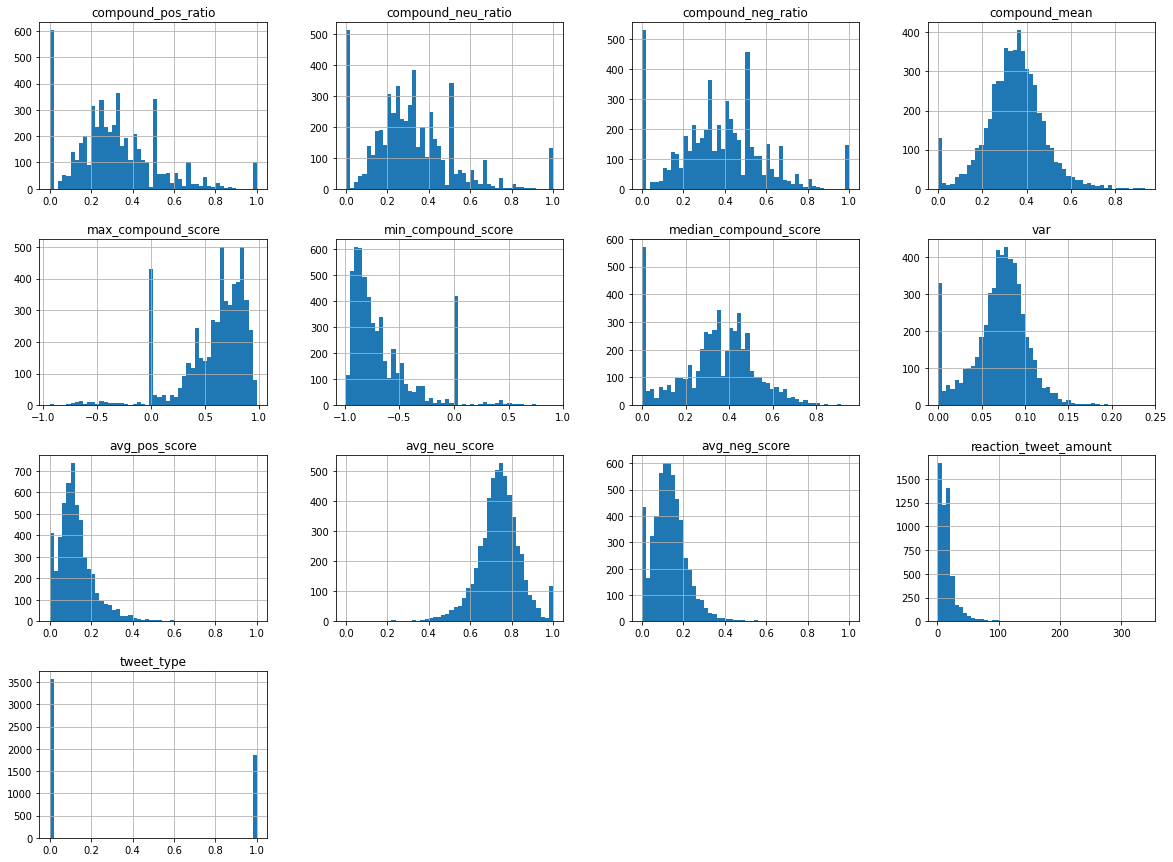

In [96]:
%matplotlib inline
import matplotlib.pyplot as plt

vader_pheme.hist(bins=50,figsize=(20,15))

From above histogram, we can see that the compound positive, compound neural and compound negative ratio distribution are very similar.The mean value of avg_pos_score and the mean value of avg_neg_score are both around 0.1 and mean value of avg_neu_score are more than 0.7, which means most reactions text fall in neural category.

In [97]:
vader_pheme["tweet_type"].value_counts()

0    3565
1    1853
Name: tweet_type, dtype: int64

In [98]:
## I found that the number of non-rumours and rumours labels in the dataset are not equal. 
## To ensure that the ratio of non-rumours and rumours in each dataset is the same after dividing the dataset into 
## train_set and test_set. The StratifiedShuffleSplit method of scikit-learn is used to split the dataset
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2,random_state=42)

for train_index, test_index in split.split(vader_pheme,vader_pheme["tweet_type"]):
    strat_train_set = vader_pheme.loc[train_index]
    strat_test_set = vader_pheme.loc[test_index]

In [99]:
print(strat_train_set["tweet_type"].value_counts())
print(strat_train_set["tweet_type"].value_counts()/len(strat_train_set))
print(strat_test_set["tweet_type"].value_counts())
print(strat_test_set["tweet_type"].value_counts()/len(strat_test_set))

0    2852
1    1482
Name: tweet_type, dtype: int64
0    0.658053
1    0.341947
Name: tweet_type, dtype: float64
0    713
1    371
Name: tweet_type, dtype: int64
0    0.657749
1    0.342251
Name: tweet_type, dtype: float64


In [100]:
strat_train_set.head()

tweet_text  compound_pos_ratio  \
2382  #Ferguson Police Department:\nRiot Gear ✔️\nTe...               0.242   
1866  Update - AFP says gunman who has taken a hosta...               0.286   
3112  2/2 on 4U 9525. If our fears are confirmed, th...               1.000   
1170  15 Cartoons From Artists Responding to #ParisS...               0.368   
3529  I covered Polytechnique, Concordia and Dawson ...               0.588   

      compound_neu_ratio  compound_neg_ratio  compound_mean  \
2382               0.515               0.242       0.215173   
1866               0.500               0.214       0.206586   
3112               0.000               0.000       0.599400   
1170               0.053               0.579       0.488484   
3529               0.118               0.294       0.470606   

      max_compound_score  min_compound_score  median_compound_score       var  \
2382              0.7992             -0.8225                 0.0129  0.071267   
1866              0.7650             -0.7003                 0.0387  0.073158   
3112              0.5994              0.5994                 0.5994  0.000000   
1170              0.7332             -0.9201                 0.4404  0.067414   
3529              0.8415             -0.7845                 0.4588  0.056764   

      avg_pos_score  avg_neu_score  avg_neg_score  reaction_tweet_amount  \
2382          0.085          0.839          0.076                     66   
1866          0.096          0.808          0.097                     14   
3112          0.290          0.710          0.000                      1   
1170          0.106          0.708          0.187                     19   
3529          0.199          0.706          0.096                     17   

      tweet_type  
2382           0  
1866           1  
3112           0  
1170           0  
3529           0

We need to process the data and labels differently, and a better way to do this is to create a pipeline model to process these columns. It is better to execute these pipelines in parallel and integrate their output in a 2D array

In [101]:
from sklearn.base import BaseEstimator
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

data_attribs = list(strat_train_set)
data_attribs.remove("tweet_type")
data_attribs.remove("tweet_text")

class DataFrameSelector(BaseEstimator):
    
    def __init__(self, attribute_names):
        self.attribute_names= attribute_names
        
    def fit(self,X, y = None):
        return self
    
    def transform(self, X):
        return X[self.attribute_names].values

data_pipeline = Pipeline([
    ('selector', DataFrameSelector(data_attribs)),
    ('std_scaler',StandardScaler())
])

In [102]:
pheme_processed = data_pipeline.fit_transform(strat_train_set)
pheme_processed_test = data_pipeline.fit_transform(strat_test_set)

print(pheme_processed.shape)
print(pheme_processed)

(4334, 12)
[[-0.33328197  1.00657753 -0.62686805 ...  0.97677334 -0.69445046
   2.57575081]
 [-0.11547161  0.93147317 -0.75715881 ...  0.68018659 -0.44570114
  -0.1552685 ]
 [ 3.4189965  -1.5720056  -1.75295244 ... -0.2574102  -1.59468609
  -0.83802332]
 ...
 [-1.53123895  0.09531126  1.35075951 ...  1.18725425  0.05179749
  -0.73298412]
 [-0.98176281 -1.01623331  1.86726929 ... -0.58269888  0.86911668
  -0.41786651]
 [-0.17982467 -0.66073933  0.78306407 ... -0.44875649  0.45453448
   0.26488832]]


In [103]:
pheme_labels = strat_train_set["tweet_type"].copy()
pheme_labels_test = strat_test_set["tweet_type"].copy()

print(pheme_labels.shape)
print(pheme_labels)

(4334,)
2382    0
1866    1
3112    0
1170    0
3529    0
       ..
165     0
1952    1
3383    1
4392    0
373     0
Name: tweet_type, Length: 4334, dtype: int64


After above operations, I have got the processed feature data and their labels. The next step is input them into linear regression model for **training**. For linear regression model, the whole data without being splitted by **StratifiedShuffleSplit** function are used for training and testing

In [104]:
## Use pipeline to process the whole dataset
X = data_pipeline.fit_transform(vader_pheme)
y = vader_pheme["tweet_type"]
print(len(X))
print(len(y))

5418
5418


In [105]:
## This method is designed for splitting the prediction value of Linear Regression model
## Prediction value < 0.5, non-rumour
## Prediction value >= 0.5, rumour
## Meanwhile, the confusion matrix is drawn and accuracy, recall, precision and f1 score is calculated
def confusionMatrix(prediction_score,labels,drawable = False):
    
    TP = 0
    FP = 0
    FN = 0
    TN = 0
    pos = 0
    for label_score in labels:
        appr_prediction_score = 1
        if prediction_score[pos] < 0.5:
            appr_prediction_score = 0
            
        if appr_prediction_score == 1 and label_score == 1:
            TP += 1
        elif appr_prediction_score == 0 and label_score == 1:
            FN += 1
        elif appr_prediction_score == 1 and label_score == 0:
            FP += 1
        else:
            TN += 1
            
        pos += 1

    accuracy = (TP + TN)/(TP+FP+FN+TN)
    recall = TP / (TP+FN)
    precision = TP / (TP+FP)
    f1score = 2 * (recall * precision)/(recall + precision)
    
    if drawable:
        x = PrettyTable(["  ", "Positive", "Negative"])
        x.align[" "] = "1"
        x.padding_width = 1
        x.add_row(["Positive",TP,FN])
        x.add_row(["Negative",FP,TN])
        print(x)
        print(f'Accuracy : {accuracy}')
        print(f'Recall   : {recall}')
        print(f'Precision: {precision}')
        print(f'F1 Score : {f1score}')
    
    return accuracy,recall,precision,f1score

In [111]:
## Linear Regression model for training
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold

accuracyList = []
precisionList = []
recallList = []
f1List = []

## 5-fold
kf = KFold(n_splits=5,shuffle=True)

for train_index,test_index in kf.split(X):
 
    X_train = X[train_index]
    X_test = X[test_index]
    y_train = y[train_index]
    y_test = y[test_index]
    ## Use training dataset to fit model
    lin_reg = LinearRegression()
    lin_reg.fit(X_train,y_train)

    ## Model prediction based on test dataset
    predict_score = lin_reg.predict(X_test)
    accuracy,recall,precision,f1score = confusionMatrix(predict_score,y_test,True)
    accuracyList.append(accuracy)
    precisionList.append(precision)
    recallList.append(recall)
    f1List.append(f1score)

print(f'The mean accuracy : {sum(accuracyList)/len(accuracyList)}')
print(f'The mean precision: {sum(precisionList)/len(precisionList)}')
print(f'The mean recall   : {sum(recallList)/len(recallList)}')
print(f'The mean f1       : {sum(f1List)/len(f1List)}')

+----------+----------+----------+
|          | Positive | Negative |
+----------+----------+----------+
| Positive |    25    |   335    |
| Negative |    31    |   693    |
+----------+----------+----------+
Accuracy : 0.6623616236162362
Recall   : 0.06944444444444445
Precision: 0.44642857142857145
F1 Score : 0.1201923076923077
+----------+----------+----------+
|          | Positive | Negative |
+----------+----------+----------+
| Positive |    10    |   345    |
| Negative |    17    |   712    |
+----------+----------+----------+
Accuracy : 0.6660516605166051
Recall   : 0.028169014084507043
Precision: 0.37037037037037035
F1 Score : 0.05235602094240837
+----------+----------+----------+
|          | Positive | Negative |
+----------+----------+----------+
| Positive |    27    |   342    |
| Negative |    45    |   670    |
+----------+----------+----------+
Accuracy : 0.6429889298892989
Recall   : 0.07317073170731707
Precision: 0.375
F1 Score : 0.12244897959183672
+----------+---

OLS model doesn't perform well for predict rumour tweets but perform well at predict rumour tweets. Then I will use another **Random Forest** model for prediction. Many parameters will influence the performance of Random Forest Model so I use GridSeach method to find best combination of these parameters based on their recall score. 

In [109]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier

def gridSearchRF_classifier(n_estimators,max_depth,max_features,data,label):
    
    ## Set the object to store the best score
    best_accuracy = {
        'n_estimators':0,
        'max_depth':0,
        'max_features':0,
        'value':0
    }
    best_recall = {
        'n_estimators':0,
        'max_depth':0,
        'max_features':0,
        'value':0
    }
    best_precision = {
        'n_estimators':0,
        'max_depth':0,
        'max_features':0,
        'value':0
    }
    best_f1_score = {
        'n_estimators':0,
        'max_depth':0,
        'max_features':0,
        'value':0
    }
    
    ## 5-fold
    kf = KFold(n_splits=5,shuffle=True,random_state=0)
    
    ## Conduct grid search method
    for n_estimator in n_estimators:
        for max_dep in max_depth:
            for max_feature in max_features:
                
                accuracyArray = []
                precisionArray = []
                recallArray = []
                f1Array = []
                
                ## Conduct 5-fold method
                for train_index,eval_index in kf.split(data):
                    X_train = data[train_index]
                    X_eval = data[eval_index]
                    y_train = label[train_index]
                    y_eval = label[eval_index]
                    
                    forest_cla = RandomForestClassifier(n_estimators=n_estimator,max_depth=max_dep,max_features=max_feature,random_state=1)
                    forest_cla.fit(X_train,y_train)
                    accuracy,recall,precision,f1score = confusionMatrix(forest_cla.predict(X_eval),y_eval)
                    accuracyArray.append(accuracy)
                    precisionArray.append(precision)
                    recallArray.append(recall)
                    f1Array.append(f1score)
                
                mean_accuracy = sum(accuracyArray)/len(accuracyArray)
                mean_precision = sum(precisionArray)/len(precisionArray)
                mean_recall = sum(recallArray)/len(recallArray)
                mean_f1 = sum(f1Array)/len(f1Array)
                print(f'n_estimators: {n_estimator}, max_depth: {max_dep}, max_features: {max_feature}, mean_accuracy: {mean_accuracy}, mean_recall: {mean_recall}, mean_precision: {mean_precision}, mean_f1_score: {mean_f1}')
                
                ## Compare each value with best ones
                if mean_recall > best_recall['value']:
                    best_recall['n_estimators'] = n_estimator
                    best_recall['max_depth'] = max_dep
                    best_recall['max_features'] = max_feature
                    best_recall['value'] = mean_recall
                if mean_accuracy > best_accuracy['value']:
                    best_accuracy['n_estimators'] = n_estimator
                    best_accuracy['max_depth'] = max_dep
                    best_accuracy['max_features'] = max_feature
                    best_accuracy['value'] = mean_accuracy
                if mean_precision > best_precision['value']:
                    best_precision['n_estimators'] = n_estimator
                    best_precision['max_depth'] = max_dep
                    best_precision['max_features'] = max_feature
                    best_precision['value'] = mean_precision
                if mean_f1 > best_f1_score['value']:
                    best_f1_score['n_estimators'] = n_estimator
                    best_f1_score['max_depth'] = max_dep
                    best_f1_score['max_features'] = max_feature
                    best_f1_score['value'] = mean_f1
                
    print(f"Best Accuracy : n_estimators: {best_accuracy['n_estimators']}, max_depth: {best_accuracy['max_depth']}, max_features: {best_accuracy['max_features']}, accuracy: {best_accuracy['value']}")
    print(f"Best Recall   : n_estimators: {best_recall['n_estimators']}, max_depth: {best_recall['max_depth']}, max_features: {best_recall['max_features']}, recall: {best_recall['value']}")
    print(f"Best Precision: n_estimators: {best_precision['n_estimators']}, max_depth: {best_precision['max_depth']}, max_features: {best_precision['max_features']}, precision: {best_precision['value']}")
    print(f"Best F1 score : n_estimators: {best_f1_score['n_estimators']}, max_depth: {best_f1_score['max_depth']}, max_features: {best_f1_score['max_features']}, f1 score: {best_f1_score['value']}")

In [110]:
gridSearchRF_classifier(range(110,135),range(15,18),[5,6,7,8],pheme_processed,pheme_labels.values)

n_estimators: 125, max_depth: 15, max_features: 5, mean_accuracy: 0.6377447650708157, mean_recall: 0.17216686695016334, mean_precision: 0.42787299736861656, mean_f1_score: 0.2442944686847885
n_estimators: 125, max_depth: 15, max_features: 6, mean_accuracy: 0.6340549424497418, mean_recall: 0.17391187756253032, mean_precision: 0.42160020372590096, mean_f1_score: 0.24408339299204376
n_estimators: 125, max_depth: 15, max_features: 7, mean_accuracy: 0.6365916289080502, mean_recall: 0.18036650387424222, mean_precision: 0.43146745407339154, mean_f1_score: 0.25305208381044275
n_estimators: 125, max_depth: 15, max_features: 8, mean_accuracy: 0.6328999416639364, mean_recall: 0.18010507263032824, mean_precision: 0.41843669172528236, mean_f1_score: 0.2503697127854653
n_estimators: 125, max_depth: 16, max_features: 5, mean_accuracy: 0.6317454736275708, mean_recall: 0.17293332153958924, mean_precision: 0.4142474362378767, mean_f1_score: 0.24226149758220364
n_estimators: 125, max_depth: 16, max_featu

n_estimators: 128, max_depth: 16, max_features: 8, mean_accuracy: 0.6287452951565085, mean_recall: 0.16901805305402368, mean_precision: 0.3998568846280931, mean_f1_score: 0.23601507826424806
n_estimators: 128, max_depth: 17, max_features: 5, mean_accuracy: 0.6345147052164161, mean_recall: 0.1817155848385071, mean_precision: 0.4252115227624677, mean_f1_score: 0.2529385265491005
n_estimators: 128, max_depth: 17, max_features: 6, mean_accuracy: 0.6303619233320281, mean_recall: 0.17566070897234481, mean_precision: 0.40795586633587544, mean_f1_score: 0.2445779867608338
n_estimators: 128, max_depth: 17, max_features: 7, mean_accuracy: 0.6280577820042567, mean_recall: 0.17988407886485044, mean_precision: 0.4055371814415795, mean_f1_score: 0.24767380327939267
n_estimators: 128, max_depth: 17, max_features: 8, mean_accuracy: 0.6301304437003711, mean_recall: 0.18119457460909044, mean_precision: 0.41154367267320957, mean_f1_score: 0.25043677498795536
n_estimators: 129, max_depth: 15, max_features

n_estimators: 132, max_depth: 15, max_features: 7, mean_accuracy: 0.6352083449872273, mean_recall: 0.17628671716877425, mean_precision: 0.4246915242567416, mean_f1_score: 0.24812690052236475
n_estimators: 132, max_depth: 15, max_features: 8, mean_accuracy: 0.6338234628180848, mean_recall: 0.1782582192222202, mean_precision: 0.419603085920255, mean_f1_score: 0.24887789275461847
n_estimators: 132, max_depth: 16, max_features: 5, mean_accuracy: 0.632207900141445, mean_recall: 0.17631584215296486, mean_precision: 0.41654714699150136, mean_f1_score: 0.24609124745058875
n_estimators: 132, max_depth: 16, max_features: 6, mean_accuracy: 0.6317454736275708, mean_recall: 0.17724513312363976, mean_precision: 0.41473412507546925, mean_f1_score: 0.246957607854432
n_estimators: 132, max_depth: 16, max_features: 7, mean_accuracy: 0.6236716558651717, mean_recall: 0.16775189276797228, mean_precision: 0.38877551886690764, mean_f1_score: 0.2326762300294259
n_estimators: 132, max_depth: 16, max_features: 

I find when number of estimators is **131**, max depth of tree is **16** and max features is **8** the random forest model gets highest score in both recall and F1 score.

when number of estimators is **110**, max depth of tree is **15** and max features is **5** the random forest model gets highest score in accuracy.

when number of estimators is **128**, max depth of tree is **17** and max features is **6** the random forest model gets highest score in precision.

I use these value to build model for test.

In [112]:
## Best recall and F1 score
forest_cal_1 = RandomForestClassifier(n_estimators=126,max_depth=17,max_features=8,random_state=1)
forest_cal_1.fit(pheme_processed,pheme_labels)
confusionMatrix(forest_cal_1.predict(pheme_processed_test),pheme_labels_test,True)

+----------+----------+----------+
|          | Positive | Negative |
+----------+----------+----------+
| Positive |    63    |   308    |
| Negative |    93    |   620    |
+----------+----------+----------+
Accuracy : 0.6300738007380073
Recall   : 0.16981132075471697
Precision: 0.40384615384615385
F1 Score : 0.23908918406072105


(0.6300738007380073,
 0.16981132075471697,
 0.40384615384615385,
 0.23908918406072105)

In [72]:
## Best accuracy
forest_cal_2 = RandomForestClassifier(n_estimators=110,max_depth=15,max_features=5,random_state=1)
forest_cal_2.fit(pheme_processed,pheme_labels)
confusionMatrix(forest_cal_2.predict(pheme_processed_test),pheme_labels_test,True)

+----------+----------+----------+
|          | Positive | Negative |
+----------+----------+----------+
| Positive |    53    |   318    |
| Negative |    79    |   634    |
+----------+----------+----------+
Accuracy : 0.6337638376383764
Recall   : 0.14285714285714285
Precision: 0.4015151515151515
F1 Score : 0.2107355864811133


(0.6337638376383764,
 0.14285714285714285,
 0.4015151515151515,
 0.2107355864811133)

In [74]:
## Best precision
forest_cal_3 = RandomForestClassifier(n_estimators=128,max_depth=17,max_features=6,random_state=1)
forest_cal_3.fit(pheme_processed,pheme_labels)
confusionMatrix(forest_cal_3.predict(pheme_processed_test),pheme_labels_test,True)

+----------+----------+----------+
|          | Positive | Negative |
+----------+----------+----------+
| Positive |    72    |   299    |
| Negative |   101    |   612    |
+----------+----------+----------+
Accuracy : 0.6309963099630996
Recall   : 0.1940700808625337
Precision: 0.4161849710982659
F1 Score : 0.2647058823529412


(0.6309963099630996,
 0.1940700808625337,
 0.4161849710982659,
 0.2647058823529412)

# TF-IFT and SVM Model

In [75]:
## data pre-processing
import argparse
import numpy as np
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk import word_tokenize, pos_tag
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from sklearn import svm
from sklearn.model_selection import KFold
from sklearn import metrics

spell = Speller()

In [76]:
basic_emotics_lexicon = []
for index,item in enumerate(lex_dic):
    if index < 201:
        basic_emotics_lexicon.append(item)
    else:
        break
basic_emotics_lexicon = sorted(basic_emotics_lexicon,key=len,reverse=True)
basic_emotics_lexicon[:10]

["---'-;-{@",
 "@}-;-'---",
 "( '}{' )",
 '--<--<@',
 '..###-:',
 ':-###..',
 '@>-->--',
 '(-:|>*',
 '*<|:-)',
 '..###:']

In [77]:
## Delete punctuation expect the western-style emotics, exclamation points and question marks.
## Keep the spece between words
def delete_punctuation(text):
    text = str(text)
    emotic_text = ""
    result_text = ""
    for emotic in basic_emotics_lexicon:
        if emotic in text:
            text = text.replace(emotic,"")
            emotic_text = emotic_text + emotic + " "
    for item in text:
        if item == "!" or item == "?":
            text = text.replace(item,"")
            emotic_text = emotic_text + item + " "
    for item in text:
        if item in string.punctuation:
            text = text.replace(item," ")
        elif item not in string.ascii_letters:
            text = text.replace(item," ")
    for item in text.split():
        result_text = result_text + " " + spell(item)
    return result_text,emotic_text

## Lemmatization
def lemmatization(text):
    all_words = word_tokenize(text)
    tagged_sent = pos_tag(all_words)
    
    wnl = WordNetLemmatizer()
    new_text = []
    for tag in tagged_sent:
        ##Get word lexical properties
        tag_flag = None
        if tag[1].startswith('J'):
            tag_flag = wordnet.ADJ
        elif tag[1].startswith('V'):
            tag_flag = wordnet.VERB
        elif tag[1].startswith('N'):
            tag_flag = wordnet.NOUN
        elif tag[1].startswith('R'):
            tag_flag = wordnet.ADV
        else:
            tag_flag = wordnet.NOUN
        
        new_text.append(wnl.lemmatize(tag[0], pos=tag_flag))
    return " ".join(new_text)

## Remove stop words
def remove_stop_words(text):
    stopwords_list = stopwords.words('english')
    new_text = []
    for word in text.split(' '):
        if word not in stopwords_list:
            new_text.append(word)
    return " ".join(new_text)

## TF-IDF method to extract features
def extract_features(reaction_texts, labels):
    vectorizer = TfidfVectorizer()
    vectors = vectorizer.fit_transform(reaction_texts)
    
    ## Conduct dimensionality reduction with SVD and LDA
    ## svd = TruncatedSVD(n_components = 10000, random_state = 500)
    ##lda = LatentDirichletAllocation(n_components = 5000, random_state = 600)
    
    ##svdvectors = svd.fit_transform(vectors)
    ## svdvectors = pd.DataFrame(svdvectors)
    
    ##ldavectors = lda.fit_transform(vectors)
    ##ldavectors = pd.DataFrame(ldavectors) 
    
    feature_names = vectorizer.get_feature_names_out()
    ## Convert a sparse matrix to a dense matrix
    dense = vectors.todense()
    denselist = dense.tolist()
    df = pd.DataFrame(denselist, columns=feature_names)
    df['@label'] = labels
    
    print(df)
    return df

In [78]:
rumur_data = pd.read_csv("rumours_pheme.csv")
rumur_data.head()

tweet_text  \
0  Ten people killed in attack at offices of sati...   
1  Ten people killed in attack at offices of sati...   
2  Ten people killed in attack at offices of sati...   
3  Ten people killed in attack at offices of sati...   
4  Ten people killed in attack at offices of sati...   

                                       reaction_text tweet_type  reaction_num  
0                                      Islamophobia?    rumours            59  
1           This is the future of Europe. Thank you.    rumours            59  
2       I'm sure it has nothing to today with Islam.    rumours            59  
3                                          holy shit    rumours            59  
4  Mag firebombed in '11 re Mohammed cartoon row ...    rumours            59

In [60]:
len(rumur_data)

4268

In [61]:
non_rumur_data = pd.read_csv("non_rumours_pheme.csv")
non_rumur_data.head()

tweet_text  \
0  Jews, Catholics, Muslims, white people, black ...   
1  Jews, Catholics, Muslims, white people, black ...   
2  Jews, Catholics, Muslims, white people, black ...   
3  Jews, Catholics, Muslims, white people, black ...   
4  Jews, Catholics, Muslims, white people, black ...   

                                       reaction_text   tweet_type  \
0  the ones the West has been killing non stop ma...  non-rumours   
1                                           Muslims?  non-rumours   
2  They would react the same even if the west pul...  non-rumours   
3  Why are some people of this faith so afraid of...  non-rumours   
4  How do you know who was attacked? Or who the a...  non-rumours   

   reaction_num  
0           108  
1           108  
2           108  
3           108  
4           108

In [62]:
len(non_rumur_data)

4339

In [41]:
## Combine rumour tweet and non-rumour tweet together
combined_data = pd.concat([rumur_data,non_rumur_data],axis=0)
combined_data.head()

tweet_text  \
0  Ten people killed in attack at offices of sati...   
1  Ten people killed in attack at offices of sati...   
2  Ten people killed in attack at offices of sati...   
3  Ten people killed in attack at offices of sati...   
4  Ten people killed in attack at offices of sati...   

                                       reaction_text tweet_type  reaction_num  
0                                      Islamophobia?    rumours            59  
1           This is the future of Europe. Thank you.    rumours            59  
2       I'm sure it has nothing to today with Islam.    rumours            59  
3                                          holy shit    rumours            59  
4  Mag firebombed in '11 re Mohammed cartoon row ...    rumours            59

In [25]:
len(combined_data)

8607

In [28]:
temp_tweet = ""
temp_type = ""
whole_text = ""
tweet_text = []
whole_reaction_content = []
tweet_label = []

# concatenate all reaction comments text of each tweet into one
for index,row in combined_data.iterrows():
    if index == 0:
        whole_text = whole_text + " " + str(row[1])
        temp_type = row[2]
        temp_tweet = row[0]
        continue
    if temp_tweet == row[0]:
        whole_text = whole_text + " " + str(row[1])
    else:
        whole_reaction_content.append(whole_text)
        if temp_type == "rumours":
            tweet_label.append(1)
        else:
            tweet_label.append(0)
        tweet_text.append(temp_tweet)
        whole_text = ""
        temp_type = row[2]
        temp_tweet = row[0]
whole_reaction_content.append(whole_text)
if temp_type == "rumours":
    tweet_label.append(1)
else:
    tweet_label.append(0)
tweet_text.append(temp_tweet)

with open('tfift_svm.csv','w',encoding='utf-8',newline='') as f:
    fieldnames = ['tweet_text','whole_reaction_text','label']
    writer = csv.DictWriter(f,fieldnames=fieldnames)
    writer.writeheader()  
    
    for i in range(len(tweet_text)):
        writer.writerow({'tweet_text':tweet_text[i],'whole_reaction_text':whole_reaction_content[i],'label':tweet_label[i]})
f.close()    

In [35]:
processed_svm_data = pd.read_csv("tfift_svm.csv")
reaction_text = []
label = []

for index,row in processed_svm_data.iterrows():
    text = row[1]
    text,symbol = delete_punctuation(text)
    text = lemmatization(text)
    text = remove_stop_words(text)
    
    reaction_text.append(text+" "+symbol)
    label.append(row[2])

processed_data = extract_features(reaction_text,label)
processed_data.to_csv('tfitf_svm_data.csv', index = False)

          86  aaa  aaaa    aaaaaa  aaaaand  aac  aaron  abandon  abbot  \
0   0.000000  0.0   0.0  0.000000      0.0  0.0    0.0      0.0    0.0   
1   0.000000  0.0   0.0  0.000000      0.0  0.0    0.0      0.0    0.0   
2   0.030497  0.0   0.0  0.000000      0.0  0.0    0.0      0.0    0.0   
3   0.000000  0.0   0.0  0.000000      0.0  0.0    0.0      0.0    0.0   
4   0.000000  0.0   0.0  0.000000      0.0  0.0    0.0      0.0    0.0   
..       ...  ...   ...       ...      ...  ...    ...      ...    ...   
94  0.000000  0.0   0.0  0.000000      0.0  0.0    0.0      0.0    0.0   
95  0.000000  0.0   0.0  0.000000      0.0  0.0    0.0      0.0    0.0   
96  0.000000  0.0   0.0  0.041141      0.0  0.0    0.0      0.0    0.0   
97  0.000000  0.0   0.0  0.000000      0.0  0.0    0.0      0.0    0.0   
98  0.000000  0.0   0.0  0.000000      0.0  0.0    0.0      0.0    0.0   

    abbott  ...  zahawiri  zealous  zero  zeroselfaaway  \
0      0.0  ...       0.0  0.00000   0.0            

In [4]:
processed_svm_data = pd.read_csv("tfitf_svm_data.csv")
processed_svm_data.head()

86  aaa  aaaa  aaaaaa  aaaaand  aac  aaron  abandon  abbot  abbott  \
0  0.000000  0.0   0.0     0.0      0.0  0.0    0.0      0.0    0.0     0.0   
1  0.000000  0.0   0.0     0.0      0.0  0.0    0.0      0.0    0.0     0.0   
2  0.030497  0.0   0.0     0.0      0.0  0.0    0.0      0.0    0.0     0.0   
3  0.000000  0.0   0.0     0.0      0.0  0.0    0.0      0.0    0.0     0.0   
4  0.000000  0.0   0.0     0.0      0.0  0.0    0.0      0.0    0.0     0.0   

   ...  zahawiri  zealous  zero  zeroselfaaway  zerotolerancetoblasphemy  \
0  ...       0.0      0.0   0.0            0.0                       0.0   
1  ...       0.0      0.0   0.0            0.0                       0.0   
2  ...       0.0      0.0   0.0            0.0                       0.0   
3  ...       0.0      0.0   0.0            0.0                       0.0   
4  ...       0.0      0.0   0.0            0.0                       0.0   

   zimmerman   zionism  zip  zone  @label  
0        0.0  0.071928  0.0   0.0       1  
1        0.0  0.000000  0.0   0.0       1  
2        0.0  0.000000  0.0   0.0       1  
3        0.0  0.000000  0.0   0.0       1  
4        0.0  0.000000  0.0   0.0       1  

[5 rows x 7346 columns]

In [5]:
## Read data
input_data = pd.read_table("tfitf_svm_data.csv",header=0,encoding='utf-8',sep=',',index_col=0)
input_data

aaa  aaaa    aaaaaa  aaaaand  aac  aaron  abandon  abbot  abbott  \
86                                                                           
0.000000  0.0   0.0  0.000000      0.0  0.0    0.0      0.0    0.0     0.0   
0.000000  0.0   0.0  0.000000      0.0  0.0    0.0      0.0    0.0     0.0   
0.030497  0.0   0.0  0.000000      0.0  0.0    0.0      0.0    0.0     0.0   
0.000000  0.0   0.0  0.000000      0.0  0.0    0.0      0.0    0.0     0.0   
0.000000  0.0   0.0  0.000000      0.0  0.0    0.0      0.0    0.0     0.0   
...       ...   ...       ...      ...  ...    ...      ...    ...     ...   
0.000000  0.0   0.0  0.000000      0.0  0.0    0.0      0.0    0.0     0.0   
0.000000  0.0   0.0  0.000000      0.0  0.0    0.0      0.0    0.0     0.0   
0.000000  0.0   0.0  0.041141      0.0  0.0    0.0      0.0    0.0     0.0   
0.000000  0.0   0.0  0.000000      0.0  0.0    0.0      0.0    0.0     0.0   
0.000000  0.0   0.0  0.000000      0.0  0.0    0.0      0.0    0.0     0.0   

          abbr  ...  zahawiri  zealous  zero  zeroselfaaway  \
86              ...                                           
0.000000   0.0  ...       0.0  0.00000   0.0            0.0   
0.000000   0.0  ...       0.0  0.00000   0.0            0.0   
0.030497   0.0  ...       0.0  0.00000   0.0            0.0   
0.000000   0.0  ...       0.0  0.00000   0.0            0.0   
0.000000   0.0  ...       0.0  0.00000   0.0            0.0   
...        ...  ...       ...      ...   ...            ...   
0.000000   0.0  ...       0.0  0.04237   0.0            0.0   
0.000000   0.0  ...       0.0  0.00000   0.0            0.0   
0.000000   0.0  ...       0.0  0.00000   0.0            0.0   
0.000000   0.0  ...       0.0  0.00000   0.0            0.0   
0.000000   0.0  ...       0.0  0.00000   0.0            0.0   

          zerotolerancetoblasphemy  zimmerman   zionism  zip  zone  @label  
86                                                                          
0.000000                       0.0        0.0  0.071928  0.0   0.0       1  
0.000000                       0.0        0.0  0.000000  0.0   0.0       1  
0.030497                       0.0        0.0  0.000000  0.0   0.0       1  
0.000000                       0.0        0.0  0.000000  0.0   0.0       1  
0.000000                       0.0        0.0  0.000000  0.0   0.0       1  
...                            ...        ...       ...  ...   ...     ...  
0.000000                       0.0        0.0  0.000000  0.0   0.0       0  
0.000000                       0.0        0.0  0.000000  0.0   0.0       0  
0.000000                       0.0        0.0  0.000000  0.0   0.0       0  
0.000000                       0.0        0.0  0.000000  0.0   0.0       0  
0.000000                       0.0        0.0  0.000000  0.0   0.0       0  

[99 rows x 7345 columns]

In [16]:
## begin training
data = input_data.values
## split 
X,y = data[:,0:-1],data[:,-1].astype(int)
## 5-fold training, disrupt the order of data
kf = KFold(n_splits=5, shuffle=True,random_state=0)
accuracyList = []
precisionList = []
recallList = []
f1List = []

for train_index, val_index in kf.split(X):
    
    X_train, X_val, y_train, y_val = X[train_index], X[val_index], y[train_index], y[val_index]
    
    # bild model
    clf = svm.SVC(kernel='rbf', gamma = 'scale')
    # model fitting
    clf.fit(X_train, y_train)
    # model prediction
    y_pred = clf.predict(X_val)
    # accuracy, precision, recall, f1_score
    accuracy,recall,precision,f1score = confusionMatrix(y_pred,y_val)
    accuracyList.append(accuracy)
    precisionList.append(precision)
    recallList.append(recall)
    f1List.append(f1score)

    print(f"accuracy : {accuracy}")
    print(f"precision: {precision}")
    print(f"recall   : {recall}")
    print(f"f1 score : {f1score}")
    
print(f"average accuracy : {np.mean(accuracyList)}")
print(f"average precision: {np.mean(precisionList)}")
print(f"average recall   : {np.mean(recallList)}")
print(f"average f1 score : {np.mean(f1List)}")

accuracy : 0.85
precision: 1.0
recall   : 0.7
f1 score : 0.8235294117647058
accuracy : 0.7
precision: 0.5714285714285714
recall   : 0.5714285714285714
f1 score : 0.5714285714285714
accuracy : 0.45
precision: 1.0
recall   : 0.26666666666666666
f1 score : 0.4210526315789474
accuracy : 0.8
precision: 0.6363636363636364
recall   : 1.0
f1 score : 0.7777777777777778
accuracy : 0.631578947368421
precision: 1.0
recall   : 0.3
f1 score : 0.4615384615384615
average accuracy : 0.6863157894736842
average precision: 0.8415584415584416
average recall   : 0.5676190476190476
average f1 score : 0.6110653708176927


## Use data which are processed by VADER for training
After finishing the whole process of training and testing. Use the data which are processed by VADER to compare the work of VADER with modified one.

In [6]:
origin_vader_df = pd.read_csv('original_vader_pheme.csv')
origin_vader_df.head()

tweet_text  compound_pos_ratio  \
0  Charlie Hebdo became well known for publishing...               0.282   
1  Charlie Hebdo’s Last Tweet Before Shootings ht...               0.375   
2  Prediction: the #CharlieHebdo massacre will no...               0.226   
3  10:28am Charlie Hebdo account mocks ISIS leade...               0.500   
4  If your faith isn't strong enough to cope with...               0.700   

   compound_neu_ratio  compound_neg_ratio  compound_mean  max_compound_score  \
0               0.256               0.462       0.420044              0.8070   
1               0.125               0.500       0.492575              0.6996   
2               0.161               0.613       0.429955              0.9101   
3               0.250               0.250       0.445450              0.7906   
4               0.300               0.000       0.340300              0.8555   

   min_compound_score  median_compound_score       var  avg_pos_score  \
0             -0.9169                 0.4585  0.098425          0.098   
1             -0.9022                 0.5683  0.092900          0.155   
2             -0.8990                 0.4329  0.078164          0.105   
3             -0.5697                 0.4956  0.083391          0.193   
4             -0.0005                 0.2989  0.098262          0.208   

   avg_neu_score  avg_neg_score  reaction_tweet_amount   tweet_type  
0          0.736          0.166                     39  non-rumours  
1          0.670          0.175                      8  non-rumours  
2          0.690          0.204                     31  non-rumours  
3          0.610          0.197                      4  non-rumours  
4          0.733          0.059                     10  non-rumours

In [7]:
value = {'non-rumours':0,'rumours':1}
origin_vader_df.tweet_type.replace(value,inplace=True)
origin_vader_pheme = origin_vader_df
origin_vader_pheme.head()

tweet_text  compound_pos_ratio  \
0  Charlie Hebdo became well known for publishing...               0.282   
1  Charlie Hebdo’s Last Tweet Before Shootings ht...               0.375   
2  Prediction: the #CharlieHebdo massacre will no...               0.226   
3  10:28am Charlie Hebdo account mocks ISIS leade...               0.500   
4  If your faith isn't strong enough to cope with...               0.700   

   compound_neu_ratio  compound_neg_ratio  compound_mean  max_compound_score  \
0               0.256               0.462       0.420044              0.8070   
1               0.125               0.500       0.492575              0.6996   
2               0.161               0.613       0.429955              0.9101   
3               0.250               0.250       0.445450              0.7906   
4               0.300               0.000       0.340300              0.8555   

   min_compound_score  median_compound_score       var  avg_pos_score  \
0             -0.9169                 0.4585  0.098425          0.098   
1             -0.9022                 0.5683  0.092900          0.155   
2             -0.8990                 0.4329  0.078164          0.105   
3             -0.5697                 0.4956  0.083391          0.193   
4             -0.0005                 0.2989  0.098262          0.208   

   avg_neu_score  avg_neg_score  reaction_tweet_amount  tweet_type  
0          0.736          0.166                     39           0  
1          0.670          0.175                      8           0  
2          0.690          0.204                     31           0  
3          0.610          0.197                      4           0  
4          0.733          0.059                     10           0

In [17]:
for train_index, test_index in split.split(origin_vader_pheme,origin_vader_pheme["tweet_type"]):
    train_set = origin_vader_pheme.loc[train_index]
    test_set = origin_vader_pheme.loc[test_index]

In [18]:
print(train_set["tweet_type"].value_counts())
print(train_set["tweet_type"].value_counts()/len(train_set))
print(test_set["tweet_type"].value_counts())
print(test_set["tweet_type"].value_counts()/len(test_set))

0    2852
1    1482
Name: tweet_type, dtype: int64
0    0.658053
1    0.341947
Name: tweet_type, dtype: float64
0    713
1    371
Name: tweet_type, dtype: int64
0    0.657749
1    0.342251
Name: tweet_type, dtype: float64


In [27]:
## Splitted training dataset
train_data = data_pipeline.fit_transform(train_set)
test_data = data_pipeline.fit_transform(test_set)

In [28]:
## Splitted test dataset
train_label = train_set["tweet_type"].copy()
test_label = test_set["tweet_type"].copy()

In [29]:
## Whole dataset
whole_data = data_pipeline.fit_transform(origin_vader_pheme)
whole_label = origin_vader_pheme["tweet_type"].copy()
print(len(whole_data))
print(len(whole_label))

5418
5418


In [113]:
## Linear Regression model for training

accuracyList = []
precisionList = []
recallList = []
f1List = []

## 5-fold
kf = KFold(n_splits=5,shuffle=True)

for train_index,test_index in kf.split(whole_data):
 
    X_train = whole_data[train_index]
    X_test = whole_data[test_index]
    y_train = whole_label[train_index]
    y_test = whole_label[test_index]
    ## Use training dataset to fit model
    lin_reg = LinearRegression()
    lin_reg.fit(X_train,y_train)

    ## Model prediction based on test dataset
    predict_score = lin_reg.predict(X_test)
    accuracy,recall,precision,f1score = confusionMatrix(predict_score,y_test,True)
    accuracyList.append(accuracy)
    precisionList.append(precision)
    recallList.append(recall)
    f1List.append(f1score)

print(f'The mean accuracy : {sum(accuracyList)/len(accuracyList)}')
print(f'The mean precision: {sum(precisionList)/len(precisionList)}')
print(f'The mean recall   : {sum(recallList)/len(recallList)}')
print(f'The mean f1       : {sum(f1List)/len(f1List)}')

+----------+----------+----------+
|          | Positive | Negative |
+----------+----------+----------+
| Positive |    23    |   330    |
| Negative |    47    |   684    |
+----------+----------+----------+
Accuracy : 0.6522140221402214
Recall   : 0.06515580736543909
Precision: 0.32857142857142857
F1 Score : 0.10874704491725769
+----------+----------+----------+
|          | Positive | Negative |
+----------+----------+----------+
| Positive |    9     |   383    |
| Negative |    17    |   675    |
+----------+----------+----------+
Accuracy : 0.6309963099630996
Recall   : 0.02295918367346939
Precision: 0.34615384615384615
F1 Score : 0.0430622009569378
+----------+----------+----------+
|          | Positive | Negative |
+----------+----------+----------+
| Positive |    22    |   352    |
| Negative |    23    |   687    |
+----------+----------+----------+
Accuracy : 0.6540590405904059
Recall   : 0.058823529411764705
Precision: 0.4888888888888889
F1 Score : 0.10501193317422435
+-

In [90]:
gridSearchRF_classifier(range(105,115),range(14,18),[6,7,8,9],train_data,train_label.values)

n_estimators: 105, max_depth: 14, max_features: 6, mean_accuracy: 0.6312881082333763, mean_recall: 0.40181025764178413, mean_precision: 0.15436022589054713, mean_f1_score: 0.22227034348020985
n_estimators: 105, max_depth: 14, max_features: 7, mean_accuracy: 0.6269038467173311, mean_recall: 0.392874078731101, mean_precision: 0.16366588348000433, mean_f1_score: 0.23048132817183808
n_estimators: 105, max_depth: 14, max_features: 8, mean_accuracy: 0.6310547639786794, mean_recall: 0.40553581876987865, mean_precision: 0.16476206166911456, mean_f1_score: 0.2335406960809013
n_estimators: 105, max_depth: 14, max_features: 9, mean_accuracy: 0.622751863957103, mean_recall: 0.37875740574484695, mean_precision: 0.1581664629565856, mean_f1_score: 0.22236483660779585
n_estimators: 105, max_depth: 15, max_features: 6, mean_accuracy: 0.632903138160576, mean_recall: 0.41166093407117677, mean_precision: 0.16958387836854744, mean_f1_score: 0.23917461196826664
n_estimators: 105, max_depth: 15, max_features

n_estimators: 107, max_depth: 16, max_features: 9, mean_accuracy: 0.6287434305334687, mean_recall: 0.40907353441341865, mean_precision: 0.18330211166978394, mean_f1_score: 0.25217029131580215
n_estimators: 107, max_depth: 17, max_features: 6, mean_accuracy: 0.6255157680515488, mean_recall: 0.3916228761056696, mean_precision: 0.1643038108336132, mean_f1_score: 0.23089168091462825
n_estimators: 107, max_depth: 17, max_features: 7, mean_accuracy: 0.6232108275996175, mean_recall: 0.3831699224533451, mean_precision: 0.1636897554152736, mean_f1_score: 0.2277540165502569
n_estimators: 107, max_depth: 17, max_features: 8, mean_accuracy: 0.6287487580278681, mean_recall: 0.3999719604898696, mean_precision: 0.1694877061484153, mean_f1_score: 0.23758796935326335
n_estimators: 107, max_depth: 17, max_features: 9, mean_accuracy: 0.6250565380343145, mean_recall: 0.39423476243707184, mean_precision: 0.17735004464064869, mean_f1_score: 0.2432761230349346
n_estimators: 108, max_depth: 14, max_features: 

n_estimators: 110, max_depth: 15, max_features: 8, mean_accuracy: 0.6257493786809657, mean_recall: 0.3929206021560097, mean_precision: 0.16509866119313166, mean_f1_score: 0.23140557827490987
n_estimators: 110, max_depth: 15, max_features: 9, mean_accuracy: 0.622519585201286, mean_recall: 0.37514346237901264, mean_precision: 0.15332105173508281, mean_f1_score: 0.21724750220865136
n_estimators: 110, max_depth: 16, max_features: 6, mean_accuracy: 0.6243634310129431, mean_recall: 0.38713592342342346, mean_precision: 0.16282026756632056, mean_f1_score: 0.2283767982056625
n_estimators: 110, max_depth: 16, max_features: 7, mean_accuracy: 0.625977928190703, mean_recall: 0.3924851757192104, mean_precision: 0.16562524544606344, mean_f1_score: 0.23206024803211228
n_estimators: 110, max_depth: 16, max_features: 8, mean_accuracy: 0.6322108302633647, mean_recall: 0.41006778990724413, mean_precision: 0.16943598796969467, mean_f1_score: 0.23896167280512975
n_estimators: 110, max_depth: 16, max_feature

n_estimators: 113, max_depth: 14, max_features: 7, mean_accuracy: 0.6266718343362341, mean_recall: 0.3796718887237219, mean_precision: 0.14281051992087124, mean_f1_score: 0.20697791692377293
n_estimators: 113, max_depth: 14, max_features: 8, mean_accuracy: 0.6287482252784281, mean_recall: 0.39057935806940486, mean_precision: 0.14783972508274984, mean_f1_score: 0.21338577174554946
n_estimators: 113, max_depth: 14, max_features: 9, mean_accuracy: 0.6301320419486909, mean_recall: 0.40474558672420613, mean_precision: 0.16094427079679147, mean_f1_score: 0.22906100071792465
n_estimators: 113, max_depth: 15, max_features: 6, mean_accuracy: 0.628517544770931, mean_recall: 0.3957151219929565, mean_precision: 0.16046955527741621, mean_f1_score: 0.22720997344549748
n_estimators: 113, max_depth: 15, max_features: 7, mean_accuracy: 0.6292106517923024, mean_recall: 0.3973181903189905, mean_precision: 0.1586245516474696, mean_f1_score: 0.22581187610223483
n_estimators: 113, max_depth: 15, max_feature

In [32]:
## Best accuracy
forest_cal_1_vader = RandomForestClassifier(n_estimators=112,max_depth=14,max_features=6,random_state=1)
forest_cal_1_vader.fit(train_data,train_label.values)
confusionMatrix(forest_cal_1_vader.predict(test_data),test_label.values,True)

+----------+----------+----------+
|          | Positive | Negative |
+----------+----------+----------+
| Positive |    56    |   315    |
| Negative |    71    |   642    |
+----------+----------+----------+
Accuracy : 0.6439114391143912
Recall   : 0.1509433962264151
Precision: 0.4409448818897638
F1 Score : 0.22489959839357432


(0.6439114391143912,
 0.1509433962264151,
 0.4409448818897638,
 0.22489959839357432)

In [35]:
## Best recall and f1 score
forest_cal_2_vader = RandomForestClassifier(n_estimators=106,max_depth=17,max_features=6,random_state=1)
forest_cal_2_vader.fit(train_data,train_label.values)
confusionMatrix(forest_cal_2_vader.predict(test_data),test_label.values,True)

+----------+----------+----------+
|          | Positive | Negative |
+----------+----------+----------+
| Positive |    61    |   310    |
| Negative |    72    |   641    |
+----------+----------+----------+
Accuracy : 0.6476014760147601
Recall   : 0.16442048517520216
Precision: 0.45864661654135336
F1 Score : 0.24206349206349204


(0.6476014760147601,
 0.16442048517520216,
 0.45864661654135336,
 0.24206349206349204)

In [36]:
## Best precision
forest_cal_3_vader = RandomForestClassifier(n_estimators=107,max_depth=16,max_features=9,random_state=1)
forest_cal_3_vader.fit(train_data,train_label.values)
confusionMatrix(forest_cal_3_vader.predict(test_data),test_label.values,True)

+----------+----------+----------+
|          | Positive | Negative |
+----------+----------+----------+
| Positive |    63    |   308    |
| Negative |    82    |   631    |
+----------+----------+----------+
Accuracy : 0.6402214022140221
Recall   : 0.16981132075471697
Precision: 0.43448275862068964
F1 Score : 0.24418604651162792


(0.6402214022140221,
 0.16981132075471697,
 0.43448275862068964,
 0.24418604651162792)

## Apply TF-IDF and SVM model to data without pre-processing

In [54]:
tempArray = []
flag = 0

for index,row in combined_data.iterrows():
    if index == 0:
        tempArray.append(row[0])
        flag = flag + 1
    elif tempArray[flag-1] != row[0]:
        tempArray.append(row[0])
        flag += 1

print(len(tempArray))

100


In [83]:
with open('pheme_csv.csv','r',encoding='utf-8') as r, open('small_pheme_csv.csv','w',encoding='utf-8',newline='') as w:
    fieldnames = ['tweet_text','whole_reaction_text','tweet_type']
    writer = csv.DictWriter(w,fieldnames=fieldnames)
    writer.writeheader()    
    
    content = ""
    pre_text = ""
    label = ""
    reader = csv.reader(r,delimiter=",")
    for index,row in enumerate(reader):
        if row[0] in tempArray:
            if pre_text == "":
                content = content + row[1]
                pre_text = row[0]
                label = row[2]
                continue
            else:
                if row[0] == pre_text:
                    content = content + " " + row[1]
                else:
                    writer.writerow({'tweet_text':pre_text,'whole_reaction_text':content,'tweet_type':label})
                    content = row[1]
                    label = row[2]
                    pre_text = row[0]
    writer.writerow({'tweet_text':pre_text,'whole_reaction_text':content,'tweet_type':label})
    r.close()
    w.close()

In [84]:
svm_data_nop = pd.read_csv("small_pheme_csv.csv")
reaction_text = []
label = []

for index,row in svm_data_nop.iterrows():
    text = row[1]
    text,symbol = delete_punctuation(text)
    text = lemmatization(text)
    text = remove_stop_words(text)
    
    reaction_text.append(text+" "+symbol)
    if row[2] == "non-rumours":
        label.append(0)
    else:
        label.append(1)

processed_svm_data_nop = extract_features(reaction_text,label)
processed_svm_data_nop.to_csv('small_tfitf_svm_data.csv', index = False)

    187   4q   86   8d  aaa  aaaa  aaaaaa  aac  aafkebrons  aag  ...  \
0   0.0  0.0  0.0  0.0  0.0   0.0     0.0  0.0         0.0  0.0  ...   
1   0.0  0.0  0.0  0.0  0.0   0.0     0.0  0.0         0.0  0.0  ...   
2   0.0  0.0  0.0  0.0  0.0   0.0     0.0  0.0         0.0  0.0  ...   
3   0.0  0.0  0.0  0.0  0.0   0.0     0.0  0.0         0.0  0.0  ...   
4   0.0  0.0  0.0  0.0  0.0   0.0     0.0  0.0         0.0  0.0  ...   
..  ...  ...  ...  ...  ...   ...     ...  ...         ...  ...  ...   
95  0.0  0.0  0.0  0.0  0.0   0.0     0.0  0.0         0.0  0.0  ...   
96  0.0  0.0  0.0  0.0  0.0   0.0     0.0  0.0         0.0  0.0  ...   
97  0.0  0.0  0.0  0.0  0.0   0.0     0.0  0.0         0.0  0.0  ...   
98  0.0  0.0  0.0  0.0  0.0   0.0     0.0  0.0         0.0  0.0  ...   
99  0.0  0.0  0.0  0.0  0.0   0.0     0.0  0.0         0.0  0.0  ...   

    zttrvtsxkq  zur   zw  zwvguiu  zwyecgvxya  zxxvsbtbs   zy  zydcimjyt   zz  \
0     0.000000  0.0  0.0      0.0         0.0        0

In [89]:
input_small_data = pd.read_table("small_tfitf_svm_data.csv",header=0,encoding='utf-8',sep=',',index_col=0)
input_small_data

4q   86   8d  aaa  aaaa  aaaaaa  aac  aafkebrons  aag  aamerismad  ...  \
187                                                                      ...   
0.0  0.0  0.0  0.0  0.0   0.0     0.0  0.0         0.0  0.0         0.0  ...   
0.0  0.0  0.0  0.0  0.0   0.0     0.0  0.0         0.0  0.0         0.0  ...   
0.0  0.0  0.0  0.0  0.0   0.0     0.0  0.0         0.0  0.0         0.0  ...   
0.0  0.0  0.0  0.0  0.0   0.0     0.0  0.0         0.0  0.0         0.0  ...   
0.0  0.0  0.0  0.0  0.0   0.0     0.0  0.0         0.0  0.0         0.0  ...   
..   ...  ...  ...  ...   ...     ...  ...         ...  ...         ...  ...   
0.0  0.0  0.0  0.0  0.0   0.0     0.0  0.0         0.0  0.0         0.0  ...   
0.0  0.0  0.0  0.0  0.0   0.0     0.0  0.0         0.0  0.0         0.0  ...   
0.0  0.0  0.0  0.0  0.0   0.0     0.0  0.0         0.0  0.0         0.0  ...   
0.0  0.0  0.0  0.0  0.0   0.0     0.0  0.0         0.0  0.0         0.0  ...   
0.0  0.0  0.0  0.0  0.0   0.0     0.0  0.0         0.0  0.0         0.0  ...   

     zttrvtsxkq  zur   zw  zwvguiu  zwyecgvxya  zxxvsbtbs   zy  zydcimjyt  \
187                                                                         
0.0    0.000000  0.0  0.0      0.0         0.0        0.0  0.0        0.0   
0.0    0.004157  0.0  0.0      0.0         0.0        0.0  0.0        0.0   
0.0    0.000000  0.0  0.0      0.0         0.0        0.0  0.0        0.0   
0.0    0.000000  0.0  0.0      0.0         0.0        0.0  0.0        0.0   
0.0    0.000000  0.0  0.0      0.0         0.0        0.0  0.0        0.0   
..          ...  ...  ...      ...         ...        ...  ...        ...   
0.0    0.000000  0.0  0.0      0.0         0.0        0.0  0.0        0.0   
0.0    0.000000  0.0  0.0      0.0         0.0        0.0  0.0        0.0   
0.0    0.000000  0.0  0.0      0.0         0.0        0.0  0.0        0.0   
0.0    0.000000  0.0  0.0      0.0         0.0        0.0  0.0        0.0   
0.0    0.000000  0.0  0.0      0.0         0.0        0.0  0.0        0.0   

      zz  @label  
187               
0.0  0.0       0  
0.0  0.0       0  
0.0  0.0       0  
0.0  0.0       0  
0.0  0.0       0  
..   ...     ...  
0.0  0.0       1  
0.0  0.0       1  
0.0  0.0       1  
0.0  0.0       1  
0.0  0.0       1  

[100 rows x 9373 columns]

In [91]:
## begin training
data = input_small_data.values
## split 
X,y = data[:,0:-1],data[:,-1].astype(int)
# 5-fold training, disrupt the order of data
kf = KFold(n_splits=5, shuffle=True,random_state=0)
accuracyList = []
precisionList = []
recallList = []
f1List = []

for train_index, val_index in kf.split(X):
    
    X_train, X_val, y_train, y_val = X[train_index], X[val_index], y[train_index], y[val_index]
    
    # bild model
    clf = svm.SVC(kernel='rbf', gamma = 'scale')
    # model fitting
    clf.fit(X_train, y_train)
    # model prediction
    y_pred = clf.predict(X_val)
    # accuracy, precision, recall, f1_score
    accuracy,recall,precision,f1score = confusionMatrix(y_pred,y_val)
    accuracyList.append(accuracy)
    precisionList.append(precision)
    recallList.append(recall)
    f1List.append(f1score)

    print(f"accuracy : {accuracy}")
    print(f"precision: {precision}")
    print(f"recall   : {recall}")
    print(f"f1 score : {f1score}")
    
print(f"average accuracy : {np.mean(accuracyList)}")
print(f"average precision: {np.mean(precisionList)}")
print(f"average recall   : {np.mean(recallList)}")
print(f"average f1 score : {np.mean(f1List)}")

accuracy : 0.65
precision: 1.0
recall   : 0.3
f1 score : 0.4615384615384615
accuracy : 0.4
precision: 1.0
recall   : 0.07692307692307693
f1 score : 0.14285714285714288
accuracy : 0.25
precision: 0.21052631578947367
recall   : 1.0
f1 score : 0.34782608695652173
accuracy : 0.5
precision: 1.0
recall   : 0.16666666666666666
f1 score : 0.2857142857142857
accuracy : 0.5
precision: 0.5
recall   : 0.1
f1 score : 0.16666666666666669
average accuracy : 0.45999999999999996
average precision: 0.7421052631578947
average recall   : 0.32871794871794874
average f1 score : 0.2809205287466157
